In [1]:
import sys,os
import random
import numpy as np
import json


In [2]:
from collections import OrderedDict
from gnn import GNNNet
from utils import *
from emetrics import *
from data_process import create_dataset_for_5folds

import rdkit as rd

import deepchem
import tensorflow as tf
import pandas as pd
import pickle

/rds/user/co-gora1/hpc-work/DGraphDTA/emetrics.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if pair is not 0:
RDKit WARNING: [12:06:12] Enabling RDKit 2019.09.3 jupyter extensions
[12:06:12] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
import torch.nn as nn

### Training

In [4]:
datasets = [['davis', 'kiba'][1]]
datasets 

['kiba']

In [5]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][3]
method

'rand_cmaps'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device('cuda:0')
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0]
print('cuda_name:', cuda_name)

cuda_name: cuda:0


In [7]:
fold = [0, 1, 2, 3, 4][3]
cross_validation_flag = True
# print(int(sys.argv[3]))

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
LR = 0.001
NUM_EPOCHS = 2000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

Learning rate:  0.001
Epochs:  2000


In [8]:
fold

3

In [9]:
models_dir = 'models_sample'
results_dir = 'results'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Main program: iterate over different datasets
result_str = ''
USE_CUDA = torch.cuda.is_available()
device = torch.device(cuda_name)
#model_file_name = 'models_sample/model_kiba_random_188_2000_GNNNet_kiba_1.model'
model = GNNNet()
model.to(device)
#model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
# model = GNNNet()
# model=model_kiba_esm__188_500_GNNNet_kiba_1.model
#model.to(device)
model_st = GNNNet.__name__
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

GNNNet Loaded


In [10]:
for dataset in datasets:
    train_data, valid_data = create_dataset_for_5folds(dataset, fold, method)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                               collate_fn=collate)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                               collate_fn=collate)

    best_mse = 1000
    best_test_mse = 1000
    best_epoch = -1
    model_file_name = 'models_sample/model_kiba_random_2_188_2000_' + model_st + '_' + dataset + '_' + str(fold) + '.model'
    mse_list1=[]
    for epoch in range(NUM_EPOCHS):
        train(model, device, train_loader, optimizer, epoch + 1)
        print('predicting for valid data')
        G, P = predicting(model, device, valid_loader)
        val = get_mse(G, P)
        mse_list1.append(val)
        print('valid result:', val, best_mse)
        if val < best_mse:
            best_mse = val
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_file_name)
            print('rmse improved at epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)
        else:
            print('No improvement since epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)


dataset: kiba
fold: 3
train entries: 63716 effective train entries 63597
valid entries: 15929 effective valid entries 15901
effective drugs,effective prot: 2068 187


/rds/user/co-gora1/hpc-work/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Training on 63597 samples...
Train epoch: 1 [0/63597 (0%)]	Loss: 10.435966
Train epoch: 1 [5120/63597 (2%)]	Loss: 2.516709
Train epoch: 1 [10240/63597 (4%)]	Loss: 1.187311
Train epoch: 1 [15360/63597 (6%)]	Loss: 0.685422
Train epoch: 1 [20480/63597 (8%)]	Loss: 0.746964
Train epoch: 1 [25600/63597 (10%)]	Loss: 0.629259
Train epoch: 1 [30720/63597 (12%)]	Loss: 0.466492
Train epoch: 1 [35840/63597 (14%)]	Loss: 0.551536
Train epoch: 1 [40960/63597 (16%)]	Loss: 0.536094
Train epoch: 1 [46080/63597 (18%)]	Loss: 0.712896
Train epoch: 1 [51200/63597 (20%)]	Loss: 0.926549
Train epoch: 1 [56320/63597 (22%)]	Loss: 0.868072
Train epoch: 1 [61440/63597 (24%)]	Loss: 0.680820
Train epoch: 1 [66560/63597 (26%)]	Loss: 0.720693
Train epoch: 1 [71680/63597 (28%)]	Loss: 0.611075
Train epoch: 1 [76800/63597 (30%)]	Loss: 0.569233
Train epoch: 1 [81920/63597 (32%)]	Loss: 0.712455
Train epoch: 1 [87040/63597 (34%)]	Loss: 0.536424
Train epoch: 1 [92160/63597 (36%)]	Loss: 0.554721
Train epoch: 1 [97280/63597 (3

Train epoch: 4 [5120/63597 (2%)]	Loss: 0.889740
Train epoch: 4 [10240/63597 (4%)]	Loss: 0.661643
Train epoch: 4 [15360/63597 (6%)]	Loss: 0.627848
Train epoch: 4 [20480/63597 (8%)]	Loss: 0.546922
Train epoch: 4 [25600/63597 (10%)]	Loss: 0.648528
Train epoch: 4 [30720/63597 (12%)]	Loss: 0.534334
Train epoch: 4 [35840/63597 (14%)]	Loss: 0.577434
Train epoch: 4 [40960/63597 (16%)]	Loss: 0.728754
Train epoch: 4 [46080/63597 (18%)]	Loss: 0.901628
Train epoch: 4 [51200/63597 (20%)]	Loss: 0.742293
Train epoch: 4 [56320/63597 (22%)]	Loss: 0.657845
Train epoch: 4 [61440/63597 (24%)]	Loss: 0.771368
Train epoch: 4 [66560/63597 (26%)]	Loss: 0.621416
Train epoch: 4 [71680/63597 (28%)]	Loss: 0.659726
Train epoch: 4 [76800/63597 (30%)]	Loss: 0.689737
Train epoch: 4 [81920/63597 (32%)]	Loss: 0.730765
Train epoch: 4 [87040/63597 (34%)]	Loss: 0.418633
Train epoch: 4 [92160/63597 (36%)]	Loss: 0.547731
Train epoch: 4 [97280/63597 (38%)]	Loss: 0.539674
Train epoch: 4 [102400/63597 (40%)]	Loss: 0.652498
Trai

Train epoch: 7 [15360/63597 (6%)]	Loss: 0.383591
Train epoch: 7 [20480/63597 (8%)]	Loss: 0.906630
Train epoch: 7 [25600/63597 (10%)]	Loss: 0.550274
Train epoch: 7 [30720/63597 (12%)]	Loss: 0.654942
Train epoch: 7 [35840/63597 (14%)]	Loss: 0.569991
Train epoch: 7 [40960/63597 (16%)]	Loss: 0.713922
Train epoch: 7 [46080/63597 (18%)]	Loss: 0.455679
Train epoch: 7 [51200/63597 (20%)]	Loss: 0.522073
Train epoch: 7 [56320/63597 (22%)]	Loss: 0.748041
Train epoch: 7 [61440/63597 (24%)]	Loss: 0.476593
Train epoch: 7 [66560/63597 (26%)]	Loss: 0.556974
Train epoch: 7 [71680/63597 (28%)]	Loss: 0.826867
Train epoch: 7 [76800/63597 (30%)]	Loss: 0.851226
Train epoch: 7 [81920/63597 (32%)]	Loss: 0.549887
Train epoch: 7 [87040/63597 (34%)]	Loss: 0.505905
Train epoch: 7 [92160/63597 (36%)]	Loss: 0.732265
Train epoch: 7 [97280/63597 (38%)]	Loss: 1.052474
Train epoch: 7 [102400/63597 (40%)]	Loss: 0.529006
Train epoch: 7 [107520/63597 (42%)]	Loss: 0.768317
Train epoch: 7 [112640/63597 (44%)]	Loss: 1.018283

Train epoch: 10 [25600/63597 (10%)]	Loss: 0.745609
Train epoch: 10 [30720/63597 (12%)]	Loss: 0.554731
Train epoch: 10 [35840/63597 (14%)]	Loss: 0.642221
Train epoch: 10 [40960/63597 (16%)]	Loss: 0.748877
Train epoch: 10 [46080/63597 (18%)]	Loss: 0.630620
Train epoch: 10 [51200/63597 (20%)]	Loss: 0.717591
Train epoch: 10 [56320/63597 (22%)]	Loss: 0.673342
Train epoch: 10 [61440/63597 (24%)]	Loss: 0.656403
Train epoch: 10 [66560/63597 (26%)]	Loss: 0.613567
Train epoch: 10 [71680/63597 (28%)]	Loss: 0.632845
Train epoch: 10 [76800/63597 (30%)]	Loss: 0.584301
Train epoch: 10 [81920/63597 (32%)]	Loss: 0.771143
Train epoch: 10 [87040/63597 (34%)]	Loss: 0.748924
Train epoch: 10 [92160/63597 (36%)]	Loss: 0.593762
Train epoch: 10 [97280/63597 (38%)]	Loss: 0.504707
Train epoch: 10 [102400/63597 (40%)]	Loss: 0.654289
Train epoch: 10 [107520/63597 (42%)]	Loss: 0.420865
Train epoch: 10 [112640/63597 (44%)]	Loss: 0.880190
Train epoch: 10 [117760/63597 (46%)]	Loss: 0.539267
Train epoch: 10 [122880/635

Train epoch: 13 [15360/63597 (6%)]	Loss: 0.398416
Train epoch: 13 [20480/63597 (8%)]	Loss: 0.425653
Train epoch: 13 [25600/63597 (10%)]	Loss: 0.362424
Train epoch: 13 [30720/63597 (12%)]	Loss: 0.772712
Train epoch: 13 [35840/63597 (14%)]	Loss: 0.526137
Train epoch: 13 [40960/63597 (16%)]	Loss: 0.578077
Train epoch: 13 [46080/63597 (18%)]	Loss: 0.477357
Train epoch: 13 [51200/63597 (20%)]	Loss: 0.546066
Train epoch: 13 [56320/63597 (22%)]	Loss: 0.653858
Train epoch: 13 [61440/63597 (24%)]	Loss: 0.626203
Train epoch: 13 [66560/63597 (26%)]	Loss: 0.646521
Train epoch: 13 [71680/63597 (28%)]	Loss: 0.393186
Train epoch: 13 [76800/63597 (30%)]	Loss: 0.545242
Train epoch: 13 [81920/63597 (32%)]	Loss: 0.637642
Train epoch: 13 [87040/63597 (34%)]	Loss: 0.529043
Train epoch: 13 [92160/63597 (36%)]	Loss: 0.496278
Train epoch: 13 [97280/63597 (38%)]	Loss: 0.776534
Train epoch: 13 [102400/63597 (40%)]	Loss: 0.433241
Train epoch: 13 [107520/63597 (42%)]	Loss: 0.550969
Train epoch: 13 [112640/63597 (

Train epoch: 16 [5120/63597 (2%)]	Loss: 0.460115
Train epoch: 16 [10240/63597 (4%)]	Loss: 0.636828
Train epoch: 16 [15360/63597 (6%)]	Loss: 0.625747
Train epoch: 16 [20480/63597 (8%)]	Loss: 0.630343
Train epoch: 16 [25600/63597 (10%)]	Loss: 0.634605
Train epoch: 16 [30720/63597 (12%)]	Loss: 0.577689
Train epoch: 16 [35840/63597 (14%)]	Loss: 0.758985
Train epoch: 16 [40960/63597 (16%)]	Loss: 0.743948
Train epoch: 16 [46080/63597 (18%)]	Loss: 0.794634
Train epoch: 16 [51200/63597 (20%)]	Loss: 0.459370
Train epoch: 16 [56320/63597 (22%)]	Loss: 0.590420
Train epoch: 16 [61440/63597 (24%)]	Loss: 0.634374
Train epoch: 16 [66560/63597 (26%)]	Loss: 0.437863
Train epoch: 16 [71680/63597 (28%)]	Loss: 0.778284
Train epoch: 16 [76800/63597 (30%)]	Loss: 0.659855
Train epoch: 16 [81920/63597 (32%)]	Loss: 0.728354
Train epoch: 16 [87040/63597 (34%)]	Loss: 0.648464
Train epoch: 16 [92160/63597 (36%)]	Loss: 0.509374
Train epoch: 16 [97280/63597 (38%)]	Loss: 0.491677
Train epoch: 16 [102400/63597 (40%)]

Train epoch: 19 [5120/63597 (2%)]	Loss: 0.659034
Train epoch: 19 [10240/63597 (4%)]	Loss: 0.738306
Train epoch: 19 [15360/63597 (6%)]	Loss: 0.398888
Train epoch: 19 [20480/63597 (8%)]	Loss: 0.567954
Train epoch: 19 [25600/63597 (10%)]	Loss: 0.589685
Train epoch: 19 [30720/63597 (12%)]	Loss: 0.663201
Train epoch: 19 [35840/63597 (14%)]	Loss: 0.646743
Train epoch: 19 [40960/63597 (16%)]	Loss: 0.398814
Train epoch: 19 [46080/63597 (18%)]	Loss: 0.643819
Train epoch: 19 [51200/63597 (20%)]	Loss: 0.524155
Train epoch: 19 [56320/63597 (22%)]	Loss: 0.422688
Train epoch: 19 [61440/63597 (24%)]	Loss: 0.749442
Train epoch: 19 [66560/63597 (26%)]	Loss: 0.805573
Train epoch: 19 [71680/63597 (28%)]	Loss: 0.718729
Train epoch: 19 [76800/63597 (30%)]	Loss: 0.616864
Train epoch: 19 [81920/63597 (32%)]	Loss: 0.497906
Train epoch: 19 [87040/63597 (34%)]	Loss: 0.311070
Train epoch: 19 [92160/63597 (36%)]	Loss: 0.491357
Train epoch: 19 [97280/63597 (38%)]	Loss: 0.610392
Train epoch: 19 [102400/63597 (40%)]

Train epoch: 22 [5120/63597 (2%)]	Loss: 0.583968
Train epoch: 22 [10240/63597 (4%)]	Loss: 0.445042
Train epoch: 22 [15360/63597 (6%)]	Loss: 0.555911
Train epoch: 22 [20480/63597 (8%)]	Loss: 0.522149
Train epoch: 22 [25600/63597 (10%)]	Loss: 0.547938
Train epoch: 22 [30720/63597 (12%)]	Loss: 0.697912
Train epoch: 22 [35840/63597 (14%)]	Loss: 0.548849
Train epoch: 22 [40960/63597 (16%)]	Loss: 0.613970
Train epoch: 22 [46080/63597 (18%)]	Loss: 0.641512
Train epoch: 22 [51200/63597 (20%)]	Loss: 0.370865
Train epoch: 22 [56320/63597 (22%)]	Loss: 0.516436
Train epoch: 22 [61440/63597 (24%)]	Loss: 0.455729
Train epoch: 22 [66560/63597 (26%)]	Loss: 0.628057
Train epoch: 22 [71680/63597 (28%)]	Loss: 0.559678
Train epoch: 22 [76800/63597 (30%)]	Loss: 0.403786
Train epoch: 22 [81920/63597 (32%)]	Loss: 0.516234
Train epoch: 22 [87040/63597 (34%)]	Loss: 0.650777
Train epoch: 22 [92160/63597 (36%)]	Loss: 0.524779
Train epoch: 22 [97280/63597 (38%)]	Loss: 0.596862
Train epoch: 22 [102400/63597 (40%)]

Train epoch: 25 [5120/63597 (2%)]	Loss: 0.532470
Train epoch: 25 [10240/63597 (4%)]	Loss: 0.713970
Train epoch: 25 [15360/63597 (6%)]	Loss: 0.531925
Train epoch: 25 [20480/63597 (8%)]	Loss: 0.469644
Train epoch: 25 [25600/63597 (10%)]	Loss: 0.453148
Train epoch: 25 [30720/63597 (12%)]	Loss: 0.520130
Train epoch: 25 [35840/63597 (14%)]	Loss: 0.623225
Train epoch: 25 [40960/63597 (16%)]	Loss: 1.365625
Train epoch: 25 [46080/63597 (18%)]	Loss: 0.413955
Train epoch: 25 [51200/63597 (20%)]	Loss: 0.524959
Train epoch: 25 [56320/63597 (22%)]	Loss: 0.495551
Train epoch: 25 [61440/63597 (24%)]	Loss: 0.625411
Train epoch: 25 [66560/63597 (26%)]	Loss: 0.539127
Train epoch: 25 [71680/63597 (28%)]	Loss: 0.522848
Train epoch: 25 [76800/63597 (30%)]	Loss: 0.542309
Train epoch: 25 [81920/63597 (32%)]	Loss: 0.623848
Train epoch: 25 [87040/63597 (34%)]	Loss: 0.597029
Train epoch: 25 [92160/63597 (36%)]	Loss: 0.735025
Train epoch: 25 [97280/63597 (38%)]	Loss: 0.574551
Train epoch: 25 [102400/63597 (40%)]

Train epoch: 28 [10240/63597 (4%)]	Loss: 0.333115
Train epoch: 28 [15360/63597 (6%)]	Loss: 0.524186
Train epoch: 28 [20480/63597 (8%)]	Loss: 0.393950
Train epoch: 28 [25600/63597 (10%)]	Loss: 0.598112
Train epoch: 28 [30720/63597 (12%)]	Loss: 0.520181
Train epoch: 28 [35840/63597 (14%)]	Loss: 0.520850
Train epoch: 28 [40960/63597 (16%)]	Loss: 0.433271
Train epoch: 28 [46080/63597 (18%)]	Loss: 0.540367
Train epoch: 28 [51200/63597 (20%)]	Loss: 0.596035
Train epoch: 28 [56320/63597 (22%)]	Loss: 0.581992
Train epoch: 28 [61440/63597 (24%)]	Loss: 0.439420
Train epoch: 28 [66560/63597 (26%)]	Loss: 0.454235
Train epoch: 28 [71680/63597 (28%)]	Loss: 0.532380
Train epoch: 28 [76800/63597 (30%)]	Loss: 0.382632
Train epoch: 28 [81920/63597 (32%)]	Loss: 0.451228
Train epoch: 28 [87040/63597 (34%)]	Loss: 0.489529
Train epoch: 28 [92160/63597 (36%)]	Loss: 0.514221
Train epoch: 28 [97280/63597 (38%)]	Loss: 0.466429
Train epoch: 28 [102400/63597 (40%)]	Loss: 0.494797
Train epoch: 28 [107520/63597 (42

Train epoch: 31 [5120/63597 (2%)]	Loss: 0.559957
Train epoch: 31 [10240/63597 (4%)]	Loss: 0.397815
Train epoch: 31 [15360/63597 (6%)]	Loss: 0.401807
Train epoch: 31 [20480/63597 (8%)]	Loss: 0.648506
Train epoch: 31 [25600/63597 (10%)]	Loss: 0.504639
Train epoch: 31 [30720/63597 (12%)]	Loss: 0.434952
Train epoch: 31 [35840/63597 (14%)]	Loss: 0.586397
Train epoch: 31 [40960/63597 (16%)]	Loss: 0.381652
Train epoch: 31 [46080/63597 (18%)]	Loss: 0.494095
Train epoch: 31 [51200/63597 (20%)]	Loss: 0.347936
Train epoch: 31 [56320/63597 (22%)]	Loss: 0.552352
Train epoch: 31 [61440/63597 (24%)]	Loss: 0.521667
Train epoch: 31 [66560/63597 (26%)]	Loss: 0.370781
Train epoch: 31 [71680/63597 (28%)]	Loss: 0.492520
Train epoch: 31 [76800/63597 (30%)]	Loss: 0.601751
Train epoch: 31 [81920/63597 (32%)]	Loss: 0.673223
Train epoch: 31 [87040/63597 (34%)]	Loss: 0.582169
Train epoch: 31 [92160/63597 (36%)]	Loss: 0.455609
Train epoch: 31 [97280/63597 (38%)]	Loss: 0.431511
Train epoch: 31 [102400/63597 (40%)]

Train epoch: 34 [5120/63597 (2%)]	Loss: 0.520684
Train epoch: 34 [10240/63597 (4%)]	Loss: 0.645240
Train epoch: 34 [15360/63597 (6%)]	Loss: 0.414211
Train epoch: 34 [20480/63597 (8%)]	Loss: 0.473167
Train epoch: 34 [25600/63597 (10%)]	Loss: 0.579145
Train epoch: 34 [30720/63597 (12%)]	Loss: 0.429185
Train epoch: 34 [35840/63597 (14%)]	Loss: 0.521874
Train epoch: 34 [40960/63597 (16%)]	Loss: 0.409454
Train epoch: 34 [46080/63597 (18%)]	Loss: 0.421678
Train epoch: 34 [51200/63597 (20%)]	Loss: 0.464836
Train epoch: 34 [56320/63597 (22%)]	Loss: 0.568839
Train epoch: 34 [61440/63597 (24%)]	Loss: 0.548434
Train epoch: 34 [66560/63597 (26%)]	Loss: 0.484337
Train epoch: 34 [71680/63597 (28%)]	Loss: 0.466253
Train epoch: 34 [76800/63597 (30%)]	Loss: 0.727573
Train epoch: 34 [81920/63597 (32%)]	Loss: 1.362683
Train epoch: 34 [87040/63597 (34%)]	Loss: 0.588572
Train epoch: 34 [92160/63597 (36%)]	Loss: 0.382733
Train epoch: 34 [97280/63597 (38%)]	Loss: 0.555615
Train epoch: 34 [102400/63597 (40%)]

Train epoch: 37 [10240/63597 (4%)]	Loss: 0.522002
Train epoch: 37 [15360/63597 (6%)]	Loss: 0.318126
Train epoch: 37 [20480/63597 (8%)]	Loss: 0.495737
Train epoch: 37 [25600/63597 (10%)]	Loss: 0.427919
Train epoch: 37 [30720/63597 (12%)]	Loss: 0.392431
Train epoch: 37 [35840/63597 (14%)]	Loss: 0.386723
Train epoch: 37 [40960/63597 (16%)]	Loss: 0.334905
Train epoch: 37 [46080/63597 (18%)]	Loss: 0.495001
Train epoch: 37 [51200/63597 (20%)]	Loss: 0.503115
Train epoch: 37 [56320/63597 (22%)]	Loss: 0.268566
Train epoch: 37 [61440/63597 (24%)]	Loss: 0.342928
Train epoch: 37 [66560/63597 (26%)]	Loss: 0.534716
Train epoch: 37 [71680/63597 (28%)]	Loss: 0.613990
Train epoch: 37 [76800/63597 (30%)]	Loss: 0.614544
Train epoch: 37 [81920/63597 (32%)]	Loss: 0.421594
Train epoch: 37 [87040/63597 (34%)]	Loss: 0.534825
Train epoch: 37 [92160/63597 (36%)]	Loss: 0.471724
Train epoch: 37 [97280/63597 (38%)]	Loss: 0.284493
Train epoch: 37 [102400/63597 (40%)]	Loss: 0.470021
Train epoch: 37 [107520/63597 (42

Train epoch: 40 [5120/63597 (2%)]	Loss: 0.337663
Train epoch: 40 [10240/63597 (4%)]	Loss: 0.598342
Train epoch: 40 [15360/63597 (6%)]	Loss: 0.375585
Train epoch: 40 [20480/63597 (8%)]	Loss: 0.490134
Train epoch: 40 [25600/63597 (10%)]	Loss: 0.421776
Train epoch: 40 [30720/63597 (12%)]	Loss: 0.510171
Train epoch: 40 [35840/63597 (14%)]	Loss: 0.407201
Train epoch: 40 [40960/63597 (16%)]	Loss: 0.417063
Train epoch: 40 [46080/63597 (18%)]	Loss: 0.528935
Train epoch: 40 [51200/63597 (20%)]	Loss: 0.555825
Train epoch: 40 [56320/63597 (22%)]	Loss: 0.520571
Train epoch: 40 [61440/63597 (24%)]	Loss: 0.623754
Train epoch: 40 [66560/63597 (26%)]	Loss: 0.542787
Train epoch: 40 [71680/63597 (28%)]	Loss: 0.528828
Train epoch: 40 [76800/63597 (30%)]	Loss: 0.662201
Train epoch: 40 [81920/63597 (32%)]	Loss: 0.591744
Train epoch: 40 [87040/63597 (34%)]	Loss: 0.561189
Train epoch: 40 [92160/63597 (36%)]	Loss: 0.691617
Train epoch: 40 [97280/63597 (38%)]	Loss: 0.508963
Train epoch: 40 [102400/63597 (40%)]

Train epoch: 43 [5120/63597 (2%)]	Loss: 0.365395
Train epoch: 43 [10240/63597 (4%)]	Loss: 0.382358
Train epoch: 43 [15360/63597 (6%)]	Loss: 0.411048
Train epoch: 43 [20480/63597 (8%)]	Loss: 0.223356
Train epoch: 43 [25600/63597 (10%)]	Loss: 0.478021
Train epoch: 43 [30720/63597 (12%)]	Loss: 0.621902
Train epoch: 43 [35840/63597 (14%)]	Loss: 0.344358
Train epoch: 43 [40960/63597 (16%)]	Loss: 0.540667
Train epoch: 43 [46080/63597 (18%)]	Loss: 0.786321
Train epoch: 43 [51200/63597 (20%)]	Loss: 0.353531
Train epoch: 43 [56320/63597 (22%)]	Loss: 0.414757
Train epoch: 43 [61440/63597 (24%)]	Loss: 1.296933
Train epoch: 43 [66560/63597 (26%)]	Loss: 0.503277
Train epoch: 43 [71680/63597 (28%)]	Loss: 0.451608
Train epoch: 43 [76800/63597 (30%)]	Loss: 0.489223
Train epoch: 43 [81920/63597 (32%)]	Loss: 0.446203
Train epoch: 43 [87040/63597 (34%)]	Loss: 0.256085
Train epoch: 43 [92160/63597 (36%)]	Loss: 0.696309
Train epoch: 43 [97280/63597 (38%)]	Loss: 0.345228
Train epoch: 43 [102400/63597 (40%)]

Train epoch: 46 [5120/63597 (2%)]	Loss: 0.569667
Train epoch: 46 [10240/63597 (4%)]	Loss: 0.699655
Train epoch: 46 [15360/63597 (6%)]	Loss: 0.468426
Train epoch: 46 [20480/63597 (8%)]	Loss: 0.492104
Train epoch: 46 [25600/63597 (10%)]	Loss: 0.367575
Train epoch: 46 [30720/63597 (12%)]	Loss: 0.261056
Train epoch: 46 [35840/63597 (14%)]	Loss: 0.652405
Train epoch: 46 [40960/63597 (16%)]	Loss: 0.614168
Train epoch: 46 [46080/63597 (18%)]	Loss: 0.381419
Train epoch: 46 [51200/63597 (20%)]	Loss: 0.243344
Train epoch: 46 [56320/63597 (22%)]	Loss: 0.332097
Train epoch: 46 [61440/63597 (24%)]	Loss: 0.448492
Train epoch: 46 [66560/63597 (26%)]	Loss: 0.505234
Train epoch: 46 [71680/63597 (28%)]	Loss: 0.644516
Train epoch: 46 [76800/63597 (30%)]	Loss: 0.374813
Train epoch: 46 [81920/63597 (32%)]	Loss: 0.435487
Train epoch: 46 [87040/63597 (34%)]	Loss: 0.278453
Train epoch: 46 [92160/63597 (36%)]	Loss: 0.663862
Train epoch: 46 [97280/63597 (38%)]	Loss: 0.461915
Train epoch: 46 [102400/63597 (40%)]

Train epoch: 49 [5120/63597 (2%)]	Loss: 0.531395
Train epoch: 49 [10240/63597 (4%)]	Loss: 0.530423
Train epoch: 49 [15360/63597 (6%)]	Loss: 0.441510
Train epoch: 49 [20480/63597 (8%)]	Loss: 0.257826
Train epoch: 49 [25600/63597 (10%)]	Loss: 0.487068
Train epoch: 49 [30720/63597 (12%)]	Loss: 0.372386
Train epoch: 49 [35840/63597 (14%)]	Loss: 0.646716
Train epoch: 49 [40960/63597 (16%)]	Loss: 0.709608
Train epoch: 49 [46080/63597 (18%)]	Loss: 0.356833
Train epoch: 49 [51200/63597 (20%)]	Loss: 0.352764
Train epoch: 49 [56320/63597 (22%)]	Loss: 0.371665
Train epoch: 49 [61440/63597 (24%)]	Loss: 0.489582
Train epoch: 49 [66560/63597 (26%)]	Loss: 0.379942
Train epoch: 49 [71680/63597 (28%)]	Loss: 0.507559
Train epoch: 49 [76800/63597 (30%)]	Loss: 0.416886
Train epoch: 49 [81920/63597 (32%)]	Loss: 0.495462
Train epoch: 49 [87040/63597 (34%)]	Loss: 0.364399
Train epoch: 49 [92160/63597 (36%)]	Loss: 0.327873
Train epoch: 49 [97280/63597 (38%)]	Loss: 0.439976
Train epoch: 49 [102400/63597 (40%)]

Train epoch: 52 [5120/63597 (2%)]	Loss: 0.514819
Train epoch: 52 [10240/63597 (4%)]	Loss: 0.419394
Train epoch: 52 [15360/63597 (6%)]	Loss: 0.373485
Train epoch: 52 [20480/63597 (8%)]	Loss: 0.316994
Train epoch: 52 [25600/63597 (10%)]	Loss: 0.319379
Train epoch: 52 [30720/63597 (12%)]	Loss: 0.334865
Train epoch: 52 [35840/63597 (14%)]	Loss: 0.410425
Train epoch: 52 [40960/63597 (16%)]	Loss: 0.469548
Train epoch: 52 [46080/63597 (18%)]	Loss: 0.349064
Train epoch: 52 [51200/63597 (20%)]	Loss: 0.318120
Train epoch: 52 [56320/63597 (22%)]	Loss: 0.362372
Train epoch: 52 [61440/63597 (24%)]	Loss: 0.327869
Train epoch: 52 [66560/63597 (26%)]	Loss: 0.490733
Train epoch: 52 [71680/63597 (28%)]	Loss: 0.405347
Train epoch: 52 [76800/63597 (30%)]	Loss: 0.314869
Train epoch: 52 [81920/63597 (32%)]	Loss: 0.362158
Train epoch: 52 [87040/63597 (34%)]	Loss: 0.357496
Train epoch: 52 [92160/63597 (36%)]	Loss: 0.578620
Train epoch: 52 [97280/63597 (38%)]	Loss: 0.550440
Train epoch: 52 [102400/63597 (40%)]

Train epoch: 55 [5120/63597 (2%)]	Loss: 0.334680
Train epoch: 55 [10240/63597 (4%)]	Loss: 0.351344
Train epoch: 55 [15360/63597 (6%)]	Loss: 0.496262
Train epoch: 55 [20480/63597 (8%)]	Loss: 0.526541
Train epoch: 55 [25600/63597 (10%)]	Loss: 0.553485
Train epoch: 55 [30720/63597 (12%)]	Loss: 0.413840
Train epoch: 55 [35840/63597 (14%)]	Loss: 0.524003
Train epoch: 55 [40960/63597 (16%)]	Loss: 0.484594
Train epoch: 55 [46080/63597 (18%)]	Loss: 0.433740
Train epoch: 55 [51200/63597 (20%)]	Loss: 0.389833
Train epoch: 55 [56320/63597 (22%)]	Loss: 0.289537
Train epoch: 55 [61440/63597 (24%)]	Loss: 0.425533
Train epoch: 55 [66560/63597 (26%)]	Loss: 0.466100
Train epoch: 55 [71680/63597 (28%)]	Loss: 0.299007
Train epoch: 55 [76800/63597 (30%)]	Loss: 0.479903
Train epoch: 55 [81920/63597 (32%)]	Loss: 0.337142
Train epoch: 55 [87040/63597 (34%)]	Loss: 0.487382
Train epoch: 55 [92160/63597 (36%)]	Loss: 0.424715
Train epoch: 55 [97280/63597 (38%)]	Loss: 0.393212
Train epoch: 55 [102400/63597 (40%)]

Train epoch: 58 [10240/63597 (4%)]	Loss: 0.230869
Train epoch: 58 [15360/63597 (6%)]	Loss: 0.321888
Train epoch: 58 [20480/63597 (8%)]	Loss: 0.323109
Train epoch: 58 [25600/63597 (10%)]	Loss: 0.369416
Train epoch: 58 [30720/63597 (12%)]	Loss: 0.445344
Train epoch: 58 [35840/63597 (14%)]	Loss: 0.373504
Train epoch: 58 [40960/63597 (16%)]	Loss: 0.406648
Train epoch: 58 [46080/63597 (18%)]	Loss: 0.347521
Train epoch: 58 [51200/63597 (20%)]	Loss: 0.402708
Train epoch: 58 [56320/63597 (22%)]	Loss: 0.294392
Train epoch: 58 [61440/63597 (24%)]	Loss: 0.275005
Train epoch: 58 [66560/63597 (26%)]	Loss: 0.458330
Train epoch: 58 [71680/63597 (28%)]	Loss: 0.590922
Train epoch: 58 [76800/63597 (30%)]	Loss: 0.329338
Train epoch: 58 [81920/63597 (32%)]	Loss: 0.387800
Train epoch: 58 [87040/63597 (34%)]	Loss: 0.486813
Train epoch: 58 [92160/63597 (36%)]	Loss: 0.426361
Train epoch: 58 [97280/63597 (38%)]	Loss: 0.444549
Train epoch: 58 [102400/63597 (40%)]	Loss: 0.498472
Train epoch: 58 [107520/63597 (42

Train epoch: 61 [5120/63597 (2%)]	Loss: 0.445197
Train epoch: 61 [10240/63597 (4%)]	Loss: 0.339899
Train epoch: 61 [15360/63597 (6%)]	Loss: 0.620775
Train epoch: 61 [20480/63597 (8%)]	Loss: 0.350449
Train epoch: 61 [25600/63597 (10%)]	Loss: 0.595615
Train epoch: 61 [30720/63597 (12%)]	Loss: 0.382760
Train epoch: 61 [35840/63597 (14%)]	Loss: 0.342351
Train epoch: 61 [40960/63597 (16%)]	Loss: 0.468183
Train epoch: 61 [46080/63597 (18%)]	Loss: 0.546457
Train epoch: 61 [51200/63597 (20%)]	Loss: 0.376994
Train epoch: 61 [56320/63597 (22%)]	Loss: 0.495964
Train epoch: 61 [61440/63597 (24%)]	Loss: 0.278115
Train epoch: 61 [66560/63597 (26%)]	Loss: 0.410234
Train epoch: 61 [71680/63597 (28%)]	Loss: 0.366793
Train epoch: 61 [76800/63597 (30%)]	Loss: 0.250662
Train epoch: 61 [81920/63597 (32%)]	Loss: 0.329103
Train epoch: 61 [87040/63597 (34%)]	Loss: 0.327719
Train epoch: 61 [92160/63597 (36%)]	Loss: 0.240812
Train epoch: 61 [97280/63597 (38%)]	Loss: 0.465775
Train epoch: 61 [102400/63597 (40%)]

Train epoch: 64 [5120/63597 (2%)]	Loss: 0.447781
Train epoch: 64 [10240/63597 (4%)]	Loss: 0.277434
Train epoch: 64 [15360/63597 (6%)]	Loss: 0.407121
Train epoch: 64 [20480/63597 (8%)]	Loss: 0.369538
Train epoch: 64 [25600/63597 (10%)]	Loss: 0.394701
Train epoch: 64 [30720/63597 (12%)]	Loss: 0.368749
Train epoch: 64 [35840/63597 (14%)]	Loss: 0.441078
Train epoch: 64 [40960/63597 (16%)]	Loss: 0.560281
Train epoch: 64 [46080/63597 (18%)]	Loss: 0.456445
Train epoch: 64 [51200/63597 (20%)]	Loss: 0.243656
Train epoch: 64 [56320/63597 (22%)]	Loss: 0.344211
Train epoch: 64 [61440/63597 (24%)]	Loss: 0.371510
Train epoch: 64 [66560/63597 (26%)]	Loss: 0.356982
Train epoch: 64 [71680/63597 (28%)]	Loss: 0.415700
Train epoch: 64 [76800/63597 (30%)]	Loss: 0.269141
Train epoch: 64 [81920/63597 (32%)]	Loss: 0.456812
Train epoch: 64 [87040/63597 (34%)]	Loss: 0.379964
Train epoch: 64 [92160/63597 (36%)]	Loss: 0.434512
Train epoch: 64 [97280/63597 (38%)]	Loss: 0.419236
Train epoch: 64 [102400/63597 (40%)]

Train epoch: 67 [5120/63597 (2%)]	Loss: 0.341747
Train epoch: 67 [10240/63597 (4%)]	Loss: 0.307279
Train epoch: 67 [15360/63597 (6%)]	Loss: 0.397893
Train epoch: 67 [20480/63597 (8%)]	Loss: 0.353367
Train epoch: 67 [25600/63597 (10%)]	Loss: 0.658224
Train epoch: 67 [30720/63597 (12%)]	Loss: 0.625022
Train epoch: 67 [35840/63597 (14%)]	Loss: 0.270208
Train epoch: 67 [40960/63597 (16%)]	Loss: 0.334623
Train epoch: 67 [46080/63597 (18%)]	Loss: 0.398491
Train epoch: 67 [51200/63597 (20%)]	Loss: 0.493083
Train epoch: 67 [56320/63597 (22%)]	Loss: 0.335074
Train epoch: 67 [61440/63597 (24%)]	Loss: 0.304028
Train epoch: 67 [66560/63597 (26%)]	Loss: 0.246028
Train epoch: 67 [71680/63597 (28%)]	Loss: 0.316723
Train epoch: 67 [76800/63597 (30%)]	Loss: 0.406772
Train epoch: 67 [81920/63597 (32%)]	Loss: 0.381075
Train epoch: 67 [87040/63597 (34%)]	Loss: 0.432986
Train epoch: 67 [92160/63597 (36%)]	Loss: 0.411695
Train epoch: 67 [97280/63597 (38%)]	Loss: 0.485382
Train epoch: 67 [102400/63597 (40%)]

Train epoch: 70 [5120/63597 (2%)]	Loss: 0.465844
Train epoch: 70 [10240/63597 (4%)]	Loss: 0.263346
Train epoch: 70 [15360/63597 (6%)]	Loss: 0.289183
Train epoch: 70 [20480/63597 (8%)]	Loss: 0.419054
Train epoch: 70 [25600/63597 (10%)]	Loss: 0.407794
Train epoch: 70 [30720/63597 (12%)]	Loss: 0.408836
Train epoch: 70 [35840/63597 (14%)]	Loss: 0.481429
Train epoch: 70 [40960/63597 (16%)]	Loss: 0.442111
Train epoch: 70 [46080/63597 (18%)]	Loss: 0.467841
Train epoch: 70 [51200/63597 (20%)]	Loss: 0.297208
Train epoch: 70 [56320/63597 (22%)]	Loss: 0.406731
Train epoch: 70 [61440/63597 (24%)]	Loss: 0.388521
Train epoch: 70 [66560/63597 (26%)]	Loss: 0.281727
Train epoch: 70 [71680/63597 (28%)]	Loss: 0.273560
Train epoch: 70 [76800/63597 (30%)]	Loss: 0.378613
Train epoch: 70 [81920/63597 (32%)]	Loss: 0.269938
Train epoch: 70 [87040/63597 (34%)]	Loss: 0.462991
Train epoch: 70 [92160/63597 (36%)]	Loss: 0.382692
Train epoch: 70 [97280/63597 (38%)]	Loss: 0.361449
Train epoch: 70 [102400/63597 (40%)]

Train epoch: 73 [5120/63597 (2%)]	Loss: 0.305165
Train epoch: 73 [10240/63597 (4%)]	Loss: 0.195983
Train epoch: 73 [15360/63597 (6%)]	Loss: 0.442392
Train epoch: 73 [20480/63597 (8%)]	Loss: 0.458166
Train epoch: 73 [25600/63597 (10%)]	Loss: 0.420050
Train epoch: 73 [30720/63597 (12%)]	Loss: 0.408538
Train epoch: 73 [35840/63597 (14%)]	Loss: 0.303632
Train epoch: 73 [40960/63597 (16%)]	Loss: 0.382542
Train epoch: 73 [46080/63597 (18%)]	Loss: 0.327650
Train epoch: 73 [51200/63597 (20%)]	Loss: 0.334206
Train epoch: 73 [56320/63597 (22%)]	Loss: 0.427139
Train epoch: 73 [61440/63597 (24%)]	Loss: 0.329079
Train epoch: 73 [66560/63597 (26%)]	Loss: 0.311598
Train epoch: 73 [71680/63597 (28%)]	Loss: 0.427253
Train epoch: 73 [76800/63597 (30%)]	Loss: 0.349375
Train epoch: 73 [81920/63597 (32%)]	Loss: 0.533054
Train epoch: 73 [87040/63597 (34%)]	Loss: 0.399379
Train epoch: 73 [92160/63597 (36%)]	Loss: 0.391433
Train epoch: 73 [97280/63597 (38%)]	Loss: 0.327087
Train epoch: 73 [102400/63597 (40%)]

Train epoch: 76 [5120/63597 (2%)]	Loss: 0.425139
Train epoch: 76 [10240/63597 (4%)]	Loss: 0.376024
Train epoch: 76 [15360/63597 (6%)]	Loss: 0.383491
Train epoch: 76 [20480/63597 (8%)]	Loss: 0.514545
Train epoch: 76 [25600/63597 (10%)]	Loss: 0.348576
Train epoch: 76 [30720/63597 (12%)]	Loss: 0.283456
Train epoch: 76 [35840/63597 (14%)]	Loss: 0.307463
Train epoch: 76 [40960/63597 (16%)]	Loss: 0.294590
Train epoch: 76 [46080/63597 (18%)]	Loss: 0.242224
Train epoch: 76 [51200/63597 (20%)]	Loss: 1.158474
Train epoch: 76 [56320/63597 (22%)]	Loss: 0.328067
Train epoch: 76 [61440/63597 (24%)]	Loss: 0.419165
Train epoch: 76 [66560/63597 (26%)]	Loss: 0.370187
Train epoch: 76 [71680/63597 (28%)]	Loss: 0.454600
Train epoch: 76 [76800/63597 (30%)]	Loss: 0.458392
Train epoch: 76 [81920/63597 (32%)]	Loss: 0.409105
Train epoch: 76 [87040/63597 (34%)]	Loss: 0.373390
Train epoch: 76 [92160/63597 (36%)]	Loss: 0.392683
Train epoch: 76 [97280/63597 (38%)]	Loss: 0.304041
Train epoch: 76 [102400/63597 (40%)]

Train epoch: 79 [5120/63597 (2%)]	Loss: 0.426409
Train epoch: 79 [10240/63597 (4%)]	Loss: 0.345461
Train epoch: 79 [15360/63597 (6%)]	Loss: 0.299676
Train epoch: 79 [20480/63597 (8%)]	Loss: 0.273334
Train epoch: 79 [25600/63597 (10%)]	Loss: 0.517007
Train epoch: 79 [30720/63597 (12%)]	Loss: 0.344879
Train epoch: 79 [35840/63597 (14%)]	Loss: 0.283013
Train epoch: 79 [40960/63597 (16%)]	Loss: 0.405770
Train epoch: 79 [46080/63597 (18%)]	Loss: 0.295887
Train epoch: 79 [51200/63597 (20%)]	Loss: 0.371350
Train epoch: 79 [56320/63597 (22%)]	Loss: 0.398303
Train epoch: 79 [61440/63597 (24%)]	Loss: 1.114950
Train epoch: 79 [66560/63597 (26%)]	Loss: 0.499289
Train epoch: 79 [71680/63597 (28%)]	Loss: 0.397700
Train epoch: 79 [76800/63597 (30%)]	Loss: 0.242128
Train epoch: 79 [81920/63597 (32%)]	Loss: 0.422477
Train epoch: 79 [87040/63597 (34%)]	Loss: 0.263360
Train epoch: 79 [92160/63597 (36%)]	Loss: 0.324101
Train epoch: 79 [97280/63597 (38%)]	Loss: 0.347576
Train epoch: 79 [102400/63597 (40%)]

Train epoch: 82 [10240/63597 (4%)]	Loss: 0.328053
Train epoch: 82 [15360/63597 (6%)]	Loss: 0.311120
Train epoch: 82 [20480/63597 (8%)]	Loss: 0.266606
Train epoch: 82 [25600/63597 (10%)]	Loss: 0.247111
Train epoch: 82 [30720/63597 (12%)]	Loss: 0.333309
Train epoch: 82 [35840/63597 (14%)]	Loss: 0.277426
Train epoch: 82 [40960/63597 (16%)]	Loss: 0.279660
Train epoch: 82 [46080/63597 (18%)]	Loss: 0.333474
Train epoch: 82 [51200/63597 (20%)]	Loss: 0.431285
Train epoch: 82 [56320/63597 (22%)]	Loss: 0.335965
Train epoch: 82 [61440/63597 (24%)]	Loss: 0.314089
Train epoch: 82 [66560/63597 (26%)]	Loss: 0.386278
Train epoch: 82 [71680/63597 (28%)]	Loss: 0.303320
Train epoch: 82 [76800/63597 (30%)]	Loss: 0.292301
Train epoch: 82 [81920/63597 (32%)]	Loss: 0.326667
Train epoch: 82 [87040/63597 (34%)]	Loss: 0.300797
Train epoch: 82 [92160/63597 (36%)]	Loss: 0.481951
Train epoch: 82 [97280/63597 (38%)]	Loss: 0.388523
Train epoch: 82 [102400/63597 (40%)]	Loss: 0.339746
Train epoch: 82 [107520/63597 (42

Train epoch: 85 [5120/63597 (2%)]	Loss: 0.343882
Train epoch: 85 [10240/63597 (4%)]	Loss: 0.332504
Train epoch: 85 [15360/63597 (6%)]	Loss: 0.456616
Train epoch: 85 [20480/63597 (8%)]	Loss: 0.337996
Train epoch: 85 [25600/63597 (10%)]	Loss: 0.423054
Train epoch: 85 [30720/63597 (12%)]	Loss: 0.242407
Train epoch: 85 [35840/63597 (14%)]	Loss: 0.368193
Train epoch: 85 [40960/63597 (16%)]	Loss: 0.268118
Train epoch: 85 [46080/63597 (18%)]	Loss: 0.526247
Train epoch: 85 [51200/63597 (20%)]	Loss: 0.304152
Train epoch: 85 [56320/63597 (22%)]	Loss: 0.354019
Train epoch: 85 [61440/63597 (24%)]	Loss: 0.320055
Train epoch: 85 [66560/63597 (26%)]	Loss: 0.429322
Train epoch: 85 [71680/63597 (28%)]	Loss: 0.403837
Train epoch: 85 [76800/63597 (30%)]	Loss: 0.401174
Train epoch: 85 [81920/63597 (32%)]	Loss: 0.281413
Train epoch: 85 [87040/63597 (34%)]	Loss: 0.348295
Train epoch: 85 [92160/63597 (36%)]	Loss: 0.536295
Train epoch: 85 [97280/63597 (38%)]	Loss: 0.334919
Train epoch: 85 [102400/63597 (40%)]

Train epoch: 88 [5120/63597 (2%)]	Loss: 0.293309
Train epoch: 88 [10240/63597 (4%)]	Loss: 0.264746
Train epoch: 88 [15360/63597 (6%)]	Loss: 0.371824
Train epoch: 88 [20480/63597 (8%)]	Loss: 0.400729
Train epoch: 88 [25600/63597 (10%)]	Loss: 0.408515
Train epoch: 88 [30720/63597 (12%)]	Loss: 0.273683
Train epoch: 88 [35840/63597 (14%)]	Loss: 0.329299
Train epoch: 88 [40960/63597 (16%)]	Loss: 0.345305
Train epoch: 88 [46080/63597 (18%)]	Loss: 0.295559
Train epoch: 88 [51200/63597 (20%)]	Loss: 0.364433
Train epoch: 88 [56320/63597 (22%)]	Loss: 0.305981
Train epoch: 88 [61440/63597 (24%)]	Loss: 0.553984
Train epoch: 88 [66560/63597 (26%)]	Loss: 0.232078
Train epoch: 88 [71680/63597 (28%)]	Loss: 0.452015
Train epoch: 88 [76800/63597 (30%)]	Loss: 0.507856
Train epoch: 88 [81920/63597 (32%)]	Loss: 0.369640
Train epoch: 88 [87040/63597 (34%)]	Loss: 0.338106
Train epoch: 88 [92160/63597 (36%)]	Loss: 0.476231
Train epoch: 88 [97280/63597 (38%)]	Loss: 0.312405
Train epoch: 88 [102400/63597 (40%)]

Train epoch: 91 [5120/63597 (2%)]	Loss: 0.523706
Train epoch: 91 [10240/63597 (4%)]	Loss: 0.327087
Train epoch: 91 [15360/63597 (6%)]	Loss: 0.521110
Train epoch: 91 [20480/63597 (8%)]	Loss: 1.127038
Train epoch: 91 [25600/63597 (10%)]	Loss: 0.374561
Train epoch: 91 [30720/63597 (12%)]	Loss: 0.286371
Train epoch: 91 [35840/63597 (14%)]	Loss: 0.381182
Train epoch: 91 [40960/63597 (16%)]	Loss: 0.307186
Train epoch: 91 [46080/63597 (18%)]	Loss: 0.519477
Train epoch: 91 [51200/63597 (20%)]	Loss: 0.314113
Train epoch: 91 [56320/63597 (22%)]	Loss: 0.360241
Train epoch: 91 [61440/63597 (24%)]	Loss: 0.376613
Train epoch: 91 [66560/63597 (26%)]	Loss: 0.272044
Train epoch: 91 [71680/63597 (28%)]	Loss: 0.537735
Train epoch: 91 [76800/63597 (30%)]	Loss: 0.308046
Train epoch: 91 [81920/63597 (32%)]	Loss: 0.346728
Train epoch: 91 [87040/63597 (34%)]	Loss: 0.321225
Train epoch: 91 [92160/63597 (36%)]	Loss: 0.407739
Train epoch: 91 [97280/63597 (38%)]	Loss: 0.385039
Train epoch: 91 [102400/63597 (40%)]

Train epoch: 94 [5120/63597 (2%)]	Loss: 0.348735
Train epoch: 94 [10240/63597 (4%)]	Loss: 0.392774
Train epoch: 94 [15360/63597 (6%)]	Loss: 0.311812
Train epoch: 94 [20480/63597 (8%)]	Loss: 0.383704
Train epoch: 94 [25600/63597 (10%)]	Loss: 0.327463
Train epoch: 94 [30720/63597 (12%)]	Loss: 0.335413
Train epoch: 94 [35840/63597 (14%)]	Loss: 0.285383
Train epoch: 94 [40960/63597 (16%)]	Loss: 0.203940
Train epoch: 94 [46080/63597 (18%)]	Loss: 0.190294
Train epoch: 94 [51200/63597 (20%)]	Loss: 0.320144
Train epoch: 94 [56320/63597 (22%)]	Loss: 0.361885
Train epoch: 94 [61440/63597 (24%)]	Loss: 0.398820
Train epoch: 94 [66560/63597 (26%)]	Loss: 0.409195
Train epoch: 94 [71680/63597 (28%)]	Loss: 0.192255
Train epoch: 94 [76800/63597 (30%)]	Loss: 0.326650
Train epoch: 94 [81920/63597 (32%)]	Loss: 0.418450
Train epoch: 94 [87040/63597 (34%)]	Loss: 0.459403
Train epoch: 94 [92160/63597 (36%)]	Loss: 0.284626
Train epoch: 94 [97280/63597 (38%)]	Loss: 0.301749
Train epoch: 94 [102400/63597 (40%)]

Train epoch: 97 [5120/63597 (2%)]	Loss: 0.353400
Train epoch: 97 [10240/63597 (4%)]	Loss: 0.383365
Train epoch: 97 [15360/63597 (6%)]	Loss: 0.248943
Train epoch: 97 [20480/63597 (8%)]	Loss: 0.426355
Train epoch: 97 [25600/63597 (10%)]	Loss: 0.390115
Train epoch: 97 [30720/63597 (12%)]	Loss: 0.191632
Train epoch: 97 [35840/63597 (14%)]	Loss: 0.363369
Train epoch: 97 [40960/63597 (16%)]	Loss: 0.316544
Train epoch: 97 [46080/63597 (18%)]	Loss: 0.298343
Train epoch: 97 [51200/63597 (20%)]	Loss: 0.251076
Train epoch: 97 [56320/63597 (22%)]	Loss: 0.296633
Train epoch: 97 [61440/63597 (24%)]	Loss: 0.269989
Train epoch: 97 [66560/63597 (26%)]	Loss: 0.347300
Train epoch: 97 [71680/63597 (28%)]	Loss: 0.283808
Train epoch: 97 [76800/63597 (30%)]	Loss: 0.249697
Train epoch: 97 [81920/63597 (32%)]	Loss: 0.238154
Train epoch: 97 [87040/63597 (34%)]	Loss: 0.445329
Train epoch: 97 [92160/63597 (36%)]	Loss: 0.326086
Train epoch: 97 [97280/63597 (38%)]	Loss: 0.258974
Train epoch: 97 [102400/63597 (40%)]

Train epoch: 100 [5120/63597 (2%)]	Loss: 0.329006
Train epoch: 100 [10240/63597 (4%)]	Loss: 0.326798
Train epoch: 100 [15360/63597 (6%)]	Loss: 0.417591
Train epoch: 100 [20480/63597 (8%)]	Loss: 0.342263
Train epoch: 100 [25600/63597 (10%)]	Loss: 0.436277
Train epoch: 100 [30720/63597 (12%)]	Loss: 0.440953
Train epoch: 100 [35840/63597 (14%)]	Loss: 0.430195
Train epoch: 100 [40960/63597 (16%)]	Loss: 0.298425
Train epoch: 100 [46080/63597 (18%)]	Loss: 0.355031
Train epoch: 100 [51200/63597 (20%)]	Loss: 0.273217
Train epoch: 100 [56320/63597 (22%)]	Loss: 0.427739
Train epoch: 100 [61440/63597 (24%)]	Loss: 0.302225
Train epoch: 100 [66560/63597 (26%)]	Loss: 0.314009
Train epoch: 100 [71680/63597 (28%)]	Loss: 0.321044
Train epoch: 100 [76800/63597 (30%)]	Loss: 0.423538
Train epoch: 100 [81920/63597 (32%)]	Loss: 0.284574
Train epoch: 100 [87040/63597 (34%)]	Loss: 0.212053
Train epoch: 100 [92160/63597 (36%)]	Loss: 0.236187
Train epoch: 100 [97280/63597 (38%)]	Loss: 0.296139
Train epoch: 100 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.33529156 0.3304495
No improvement since epoch  96 ; best_test_mse 0.3304495 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 103 [0/63597 (0%)]	Loss: 0.300945
Train epoch: 103 [5120/63597 (2%)]	Loss: 0.166411
Train epoch: 103 [10240/63597 (4%)]	Loss: 0.197980
Train epoch: 103 [15360/63597 (6%)]	Loss: 0.237462
Train epoch: 103 [20480/63597 (8%)]	Loss: 0.315784
Train epoch: 103 [25600/63597 (10%)]	Loss: 0.277295
Train epoch: 103 [30720/63597 (12%)]	Loss: 0.341431
Train epoch: 103 [35840/63597 (14%)]	Loss: 0.211425
Train epoch: 103 [40960/63597 (16%)]	Loss: 0.340341
Train epoch: 103 [46080/63597 (18%)]	Loss: 0.439953
Train epoch: 103 [51200/63597 (20%)]	Loss: 0.350480
Train epoch: 103 [56320/63597 (22%)]	Loss: 0.437795
Train epoch: 103 [61440/63597 (24%)]	Loss: 0.460881
Train epoch: 103 [66560/63597 (26%)]	Loss: 0.474084
Train epoch: 103 [71680/63597 (28%)]	Loss: 0.269945
Train epoch: 103 [76800/63597 (3

Train epoch: 105 [235520/63597 (93%)]	Loss: 0.310339
Train epoch: 105 [240640/63597 (95%)]	Loss: 0.360819
Train epoch: 105 [245760/63597 (97%)]	Loss: 0.387546
Train epoch: 105 [250880/63597 (99%)]	Loss: 0.324041
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.33420396 0.3304495
No improvement since epoch  96 ; best_test_mse 0.3304495 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 106 [0/63597 (0%)]	Loss: 0.303599
Train epoch: 106 [5120/63597 (2%)]	Loss: 0.215742
Train epoch: 106 [10240/63597 (4%)]	Loss: 0.223778
Train epoch: 106 [15360/63597 (6%)]	Loss: 0.303018
Train epoch: 106 [20480/63597 (8%)]	Loss: 0.285199
Train epoch: 106 [25600/63597 (10%)]	Loss: 0.463489
Train epoch: 106 [30720/63597 (12%)]	Loss: 0.271016
Train epoch: 106 [35840/63597 (14%)]	Loss: 0.271264
Train epoch: 106 [40960/63597 (16%)]	Loss: 0.426551
Train epoch: 106 [46080/63597 (18%)]	Loss: 0.428710
Train epoch: 106 [51200/63597 (20%)]	Loss: 0.343754
Train epoch: 106 [56320/6359

Train epoch: 108 [215040/63597 (85%)]	Loss: 0.461595
Train epoch: 108 [220160/63597 (87%)]	Loss: 0.416998
Train epoch: 108 [225280/63597 (89%)]	Loss: 0.222515
Train epoch: 108 [230400/63597 (91%)]	Loss: 0.305906
Train epoch: 108 [235520/63597 (93%)]	Loss: 0.440541
Train epoch: 108 [240640/63597 (95%)]	Loss: 0.327750
Train epoch: 108 [245760/63597 (97%)]	Loss: 0.317536
Train epoch: 108 [250880/63597 (99%)]	Loss: 0.190213
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.3330307 0.32257545
No improvement since epoch  106 ; best_test_mse 0.32257545 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 109 [0/63597 (0%)]	Loss: 0.290896
Train epoch: 109 [5120/63597 (2%)]	Loss: 0.323928
Train epoch: 109 [10240/63597 (4%)]	Loss: 0.285993
Train epoch: 109 [15360/63597 (6%)]	Loss: 0.348451
Train epoch: 109 [20480/63597 (8%)]	Loss: 0.519798
Train epoch: 109 [25600/63597 (10%)]	Loss: 0.342932
Train epoch: 109 [30720/63597 (12%)]	Loss: 0.416529
Train epoch: 109 [3584

Train epoch: 111 [194560/63597 (76%)]	Loss: 0.322000
Train epoch: 111 [199680/63597 (78%)]	Loss: 0.274872
Train epoch: 111 [204800/63597 (80%)]	Loss: 0.267891
Train epoch: 111 [209920/63597 (82%)]	Loss: 0.290608
Train epoch: 111 [215040/63597 (85%)]	Loss: 0.315963
Train epoch: 111 [220160/63597 (87%)]	Loss: 0.201313
Train epoch: 111 [225280/63597 (89%)]	Loss: 0.355536
Train epoch: 111 [230400/63597 (91%)]	Loss: 0.241811
Train epoch: 111 [235520/63597 (93%)]	Loss: 0.407711
Train epoch: 111 [240640/63597 (95%)]	Loss: 0.412542
Train epoch: 111 [245760/63597 (97%)]	Loss: 0.400792
Train epoch: 111 [250880/63597 (99%)]	Loss: 0.438252
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.33378428 0.32257545
No improvement since epoch  106 ; best_test_mse 0.32257545 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 112 [0/63597 (0%)]	Loss: 0.272968
Train epoch: 112 [5120/63597 (2%)]	Loss: 0.336323
Train epoch: 112 [10240/63597 (4%)]	Loss: 0.279228
Train epoch: 11

Train epoch: 114 [168960/63597 (66%)]	Loss: 0.248619
Train epoch: 114 [174080/63597 (68%)]	Loss: 0.291278
Train epoch: 114 [179200/63597 (70%)]	Loss: 0.353326
Train epoch: 114 [184320/63597 (72%)]	Loss: 0.361525
Train epoch: 114 [189440/63597 (74%)]	Loss: 0.263961
Train epoch: 114 [194560/63597 (76%)]	Loss: 0.349209
Train epoch: 114 [199680/63597 (78%)]	Loss: 0.151614
Train epoch: 114 [204800/63597 (80%)]	Loss: 0.183900
Train epoch: 114 [209920/63597 (82%)]	Loss: 0.603829
Train epoch: 114 [215040/63597 (85%)]	Loss: 0.247563
Train epoch: 114 [220160/63597 (87%)]	Loss: 0.197632
Train epoch: 114 [225280/63597 (89%)]	Loss: 0.300937
Train epoch: 114 [230400/63597 (91%)]	Loss: 0.432283
Train epoch: 114 [235520/63597 (93%)]	Loss: 0.275523
Train epoch: 114 [240640/63597 (95%)]	Loss: 0.336645
Train epoch: 114 [245760/63597 (97%)]	Loss: 0.339213
Train epoch: 114 [250880/63597 (99%)]	Loss: 0.268480
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.32761627 0.32257545


Train epoch: 117 [148480/63597 (58%)]	Loss: 0.413349
Train epoch: 117 [153600/63597 (60%)]	Loss: 0.377625
Train epoch: 117 [158720/63597 (62%)]	Loss: 0.372828
Train epoch: 117 [163840/63597 (64%)]	Loss: 0.267678
Train epoch: 117 [168960/63597 (66%)]	Loss: 0.370161
Train epoch: 117 [174080/63597 (68%)]	Loss: 0.213832
Train epoch: 117 [179200/63597 (70%)]	Loss: 0.452841
Train epoch: 117 [184320/63597 (72%)]	Loss: 0.207237
Train epoch: 117 [189440/63597 (74%)]	Loss: 0.197201
Train epoch: 117 [194560/63597 (76%)]	Loss: 0.275239
Train epoch: 117 [199680/63597 (78%)]	Loss: 0.291251
Train epoch: 117 [204800/63597 (80%)]	Loss: 0.260656
Train epoch: 117 [209920/63597 (82%)]	Loss: 0.277270
Train epoch: 117 [215040/63597 (85%)]	Loss: 0.209829
Train epoch: 117 [220160/63597 (87%)]	Loss: 0.178904
Train epoch: 117 [225280/63597 (89%)]	Loss: 0.295232
Train epoch: 117 [230400/63597 (91%)]	Loss: 0.261580
Train epoch: 117 [235520/63597 (93%)]	Loss: 0.247719
Train epoch: 117 [240640/63597 (95%)]	Loss: 0.

Train epoch: 120 [128000/63597 (50%)]	Loss: 0.195389
Train epoch: 120 [133120/63597 (52%)]	Loss: 0.330607
Train epoch: 120 [138240/63597 (54%)]	Loss: 0.240118
Train epoch: 120 [143360/63597 (56%)]	Loss: 0.391204
Train epoch: 120 [148480/63597 (58%)]	Loss: 0.439092
Train epoch: 120 [153600/63597 (60%)]	Loss: 0.278151
Train epoch: 120 [158720/63597 (62%)]	Loss: 0.234564
Train epoch: 120 [163840/63597 (64%)]	Loss: 0.388165
Train epoch: 120 [168960/63597 (66%)]	Loss: 0.277842
Train epoch: 120 [174080/63597 (68%)]	Loss: 0.235144
Train epoch: 120 [179200/63597 (70%)]	Loss: 0.281644
Train epoch: 120 [184320/63597 (72%)]	Loss: 0.355263
Train epoch: 120 [189440/63597 (74%)]	Loss: 0.354898
Train epoch: 120 [194560/63597 (76%)]	Loss: 0.340544
Train epoch: 120 [199680/63597 (78%)]	Loss: 0.225291
Train epoch: 120 [204800/63597 (80%)]	Loss: 0.259112
Train epoch: 120 [209920/63597 (82%)]	Loss: 0.204412
Train epoch: 120 [215040/63597 (85%)]	Loss: 0.374809
Train epoch: 120 [220160/63597 (87%)]	Loss: 0.

Train epoch: 123 [107520/63597 (42%)]	Loss: 0.249669
Train epoch: 123 [112640/63597 (44%)]	Loss: 0.356075
Train epoch: 123 [117760/63597 (46%)]	Loss: 0.311878
Train epoch: 123 [122880/63597 (48%)]	Loss: 0.311423
Train epoch: 123 [128000/63597 (50%)]	Loss: 0.256221
Train epoch: 123 [133120/63597 (52%)]	Loss: 0.202339
Train epoch: 123 [138240/63597 (54%)]	Loss: 0.385614
Train epoch: 123 [143360/63597 (56%)]	Loss: 0.283746
Train epoch: 123 [148480/63597 (58%)]	Loss: 0.343882
Train epoch: 123 [153600/63597 (60%)]	Loss: 0.254882
Train epoch: 123 [158720/63597 (62%)]	Loss: 0.372118
Train epoch: 123 [163840/63597 (64%)]	Loss: 0.491688
Train epoch: 123 [168960/63597 (66%)]	Loss: 0.307056
Train epoch: 123 [174080/63597 (68%)]	Loss: 0.345406
Train epoch: 123 [179200/63597 (70%)]	Loss: 0.236311
Train epoch: 123 [184320/63597 (72%)]	Loss: 0.260046
Train epoch: 123 [189440/63597 (74%)]	Loss: 0.238802
Train epoch: 123 [194560/63597 (76%)]	Loss: 0.352418
Train epoch: 123 [199680/63597 (78%)]	Loss: 0.

Train epoch: 126 [87040/63597 (34%)]	Loss: 0.452667
Train epoch: 126 [92160/63597 (36%)]	Loss: 0.323004
Train epoch: 126 [97280/63597 (38%)]	Loss: 0.418472
Train epoch: 126 [102400/63597 (40%)]	Loss: 0.270106
Train epoch: 126 [107520/63597 (42%)]	Loss: 0.213149
Train epoch: 126 [112640/63597 (44%)]	Loss: 0.378818
Train epoch: 126 [117760/63597 (46%)]	Loss: 0.345730
Train epoch: 126 [122880/63597 (48%)]	Loss: 0.322486
Train epoch: 126 [128000/63597 (50%)]	Loss: 0.520519
Train epoch: 126 [133120/63597 (52%)]	Loss: 0.276012
Train epoch: 126 [138240/63597 (54%)]	Loss: 0.355872
Train epoch: 126 [143360/63597 (56%)]	Loss: 0.258746
Train epoch: 126 [148480/63597 (58%)]	Loss: 0.247361
Train epoch: 126 [153600/63597 (60%)]	Loss: 0.288780
Train epoch: 126 [158720/63597 (62%)]	Loss: 0.439047
Train epoch: 126 [163840/63597 (64%)]	Loss: 0.580280
Train epoch: 126 [168960/63597 (66%)]	Loss: 0.293439
Train epoch: 126 [174080/63597 (68%)]	Loss: 0.251852
Train epoch: 126 [179200/63597 (70%)]	Loss: 0.308

Train epoch: 129 [61440/63597 (24%)]	Loss: 0.369506
Train epoch: 129 [66560/63597 (26%)]	Loss: 0.374095
Train epoch: 129 [71680/63597 (28%)]	Loss: 0.209223
Train epoch: 129 [76800/63597 (30%)]	Loss: 0.193028
Train epoch: 129 [81920/63597 (32%)]	Loss: 0.327970
Train epoch: 129 [87040/63597 (34%)]	Loss: 0.284625
Train epoch: 129 [92160/63597 (36%)]	Loss: 0.273552
Train epoch: 129 [97280/63597 (38%)]	Loss: 0.325613
Train epoch: 129 [102400/63597 (40%)]	Loss: 0.301116
Train epoch: 129 [107520/63597 (42%)]	Loss: 0.307494
Train epoch: 129 [112640/63597 (44%)]	Loss: 0.332060
Train epoch: 129 [117760/63597 (46%)]	Loss: 0.311010
Train epoch: 129 [122880/63597 (48%)]	Loss: 0.288611
Train epoch: 129 [128000/63597 (50%)]	Loss: 0.275908
Train epoch: 129 [133120/63597 (52%)]	Loss: 0.245001
Train epoch: 129 [138240/63597 (54%)]	Loss: 0.331560
Train epoch: 129 [143360/63597 (56%)]	Loss: 0.385466
Train epoch: 129 [148480/63597 (58%)]	Loss: 0.192898
Train epoch: 129 [153600/63597 (60%)]	Loss: 0.209864
T

Train epoch: 132 [40960/63597 (16%)]	Loss: 0.271150
Train epoch: 132 [46080/63597 (18%)]	Loss: 0.307542
Train epoch: 132 [51200/63597 (20%)]	Loss: 0.510032
Train epoch: 132 [56320/63597 (22%)]	Loss: 0.214477
Train epoch: 132 [61440/63597 (24%)]	Loss: 0.262453
Train epoch: 132 [66560/63597 (26%)]	Loss: 0.411918
Train epoch: 132 [71680/63597 (28%)]	Loss: 0.248823
Train epoch: 132 [76800/63597 (30%)]	Loss: 0.195680
Train epoch: 132 [81920/63597 (32%)]	Loss: 0.251945
Train epoch: 132 [87040/63597 (34%)]	Loss: 0.280556
Train epoch: 132 [92160/63597 (36%)]	Loss: 0.306732
Train epoch: 132 [97280/63597 (38%)]	Loss: 0.285661
Train epoch: 132 [102400/63597 (40%)]	Loss: 0.257440
Train epoch: 132 [107520/63597 (42%)]	Loss: 0.487165
Train epoch: 132 [112640/63597 (44%)]	Loss: 0.286846
Train epoch: 132 [117760/63597 (46%)]	Loss: 0.239657
Train epoch: 132 [122880/63597 (48%)]	Loss: 0.261034
Train epoch: 132 [128000/63597 (50%)]	Loss: 0.274972
Train epoch: 132 [133120/63597 (52%)]	Loss: 0.416385
Train

Train epoch: 135 [15360/63597 (6%)]	Loss: 0.232860
Train epoch: 135 [20480/63597 (8%)]	Loss: 0.393176
Train epoch: 135 [25600/63597 (10%)]	Loss: 0.375443
Train epoch: 135 [30720/63597 (12%)]	Loss: 0.271962
Train epoch: 135 [35840/63597 (14%)]	Loss: 0.181299
Train epoch: 135 [40960/63597 (16%)]	Loss: 0.354416
Train epoch: 135 [46080/63597 (18%)]	Loss: 0.442562
Train epoch: 135 [51200/63597 (20%)]	Loss: 0.354769
Train epoch: 135 [56320/63597 (22%)]	Loss: 0.370786
Train epoch: 135 [61440/63597 (24%)]	Loss: 0.236309
Train epoch: 135 [66560/63597 (26%)]	Loss: 0.193766
Train epoch: 135 [71680/63597 (28%)]	Loss: 0.317381
Train epoch: 135 [76800/63597 (30%)]	Loss: 0.285039
Train epoch: 135 [81920/63597 (32%)]	Loss: 0.338758
Train epoch: 135 [87040/63597 (34%)]	Loss: 0.257809
Train epoch: 135 [92160/63597 (36%)]	Loss: 0.329918
Train epoch: 135 [97280/63597 (38%)]	Loss: 0.187114
Train epoch: 135 [102400/63597 (40%)]	Loss: 0.215936
Train epoch: 135 [107520/63597 (42%)]	Loss: 0.273097
Train epoch:

Train epoch: 138 [10240/63597 (4%)]	Loss: 0.211680
Train epoch: 138 [15360/63597 (6%)]	Loss: 0.171610
Train epoch: 138 [20480/63597 (8%)]	Loss: 0.197814
Train epoch: 138 [25600/63597 (10%)]	Loss: 0.326793
Train epoch: 138 [30720/63597 (12%)]	Loss: 0.220366
Train epoch: 138 [35840/63597 (14%)]	Loss: 0.278012
Train epoch: 138 [40960/63597 (16%)]	Loss: 0.247593
Train epoch: 138 [46080/63597 (18%)]	Loss: 0.301582
Train epoch: 138 [51200/63597 (20%)]	Loss: 0.281395
Train epoch: 138 [56320/63597 (22%)]	Loss: 0.497305
Train epoch: 138 [61440/63597 (24%)]	Loss: 0.352921
Train epoch: 138 [66560/63597 (26%)]	Loss: 0.336715
Train epoch: 138 [71680/63597 (28%)]	Loss: 0.282056
Train epoch: 138 [76800/63597 (30%)]	Loss: 0.277044
Train epoch: 138 [81920/63597 (32%)]	Loss: 0.326210
Train epoch: 138 [87040/63597 (34%)]	Loss: 0.389506
Train epoch: 138 [92160/63597 (36%)]	Loss: 0.220994
Train epoch: 138 [97280/63597 (38%)]	Loss: 0.255389
Train epoch: 138 [102400/63597 (40%)]	Loss: 0.339975
Train epoch: 1

valid result: 0.31037128 0.31164488
rmse improved at epoch  140 ; best_test_mse 0.31037128 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 141 [0/63597 (0%)]	Loss: 1.007261
Train epoch: 141 [5120/63597 (2%)]	Loss: 0.320857
Train epoch: 141 [10240/63597 (4%)]	Loss: 0.239429
Train epoch: 141 [15360/63597 (6%)]	Loss: 0.295573
Train epoch: 141 [20480/63597 (8%)]	Loss: 0.209862
Train epoch: 141 [25600/63597 (10%)]	Loss: 0.263084
Train epoch: 141 [30720/63597 (12%)]	Loss: 0.196184
Train epoch: 141 [35840/63597 (14%)]	Loss: 0.251489
Train epoch: 141 [40960/63597 (16%)]	Loss: 0.291776
Train epoch: 141 [46080/63597 (18%)]	Loss: 0.394889
Train epoch: 141 [51200/63597 (20%)]	Loss: 0.250810
Train epoch: 141 [56320/63597 (22%)]	Loss: 0.178576
Train epoch: 141 [61440/63597 (24%)]	Loss: 0.340297
Train epoch: 141 [66560/63597 (26%)]	Loss: 0.253273
Train epoch: 141 [71680/63597 (28%)]	Loss: 0.256020
Train epoch: 141 [76800/63597 (30%)]	Loss: 0.358726
Train epoch: 141 [81920/63597 (32%)]	Loss: 0

Train epoch: 143 [245760/63597 (97%)]	Loss: 0.184049
Train epoch: 143 [250880/63597 (99%)]	Loss: 0.300569
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.31698686 0.31037128
No improvement since epoch  140 ; best_test_mse 0.31037128 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 144 [0/63597 (0%)]	Loss: 0.405674
Train epoch: 144 [5120/63597 (2%)]	Loss: 0.274283
Train epoch: 144 [10240/63597 (4%)]	Loss: 0.277571
Train epoch: 144 [15360/63597 (6%)]	Loss: 0.358706
Train epoch: 144 [20480/63597 (8%)]	Loss: 0.287799
Train epoch: 144 [25600/63597 (10%)]	Loss: 0.250983
Train epoch: 144 [30720/63597 (12%)]	Loss: 0.214554
Train epoch: 144 [35840/63597 (14%)]	Loss: 0.230897
Train epoch: 144 [40960/63597 (16%)]	Loss: 0.205874
Train epoch: 144 [46080/63597 (18%)]	Loss: 0.352400
Train epoch: 144 [51200/63597 (20%)]	Loss: 0.316129
Train epoch: 144 [56320/63597 (22%)]	Loss: 0.228718
Train epoch: 144 [61440/63597 (24%)]	Loss: 0.329942
Train epoch: 144 [66560/635

Train epoch: 146 [225280/63597 (89%)]	Loss: 0.206944
Train epoch: 146 [230400/63597 (91%)]	Loss: 0.345530
Train epoch: 146 [235520/63597 (93%)]	Loss: 0.213749
Train epoch: 146 [240640/63597 (95%)]	Loss: 0.398708
Train epoch: 146 [245760/63597 (97%)]	Loss: 0.292434
Train epoch: 146 [250880/63597 (99%)]	Loss: 0.383436
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.31534144 0.31037128
No improvement since epoch  140 ; best_test_mse 0.31037128 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 147 [0/63597 (0%)]	Loss: 0.296955
Train epoch: 147 [5120/63597 (2%)]	Loss: 0.294603
Train epoch: 147 [10240/63597 (4%)]	Loss: 0.328054
Train epoch: 147 [15360/63597 (6%)]	Loss: 0.291263
Train epoch: 147 [20480/63597 (8%)]	Loss: 0.234332
Train epoch: 147 [25600/63597 (10%)]	Loss: 0.295098
Train epoch: 147 [30720/63597 (12%)]	Loss: 0.402691
Train epoch: 147 [35840/63597 (14%)]	Loss: 0.312295
Train epoch: 147 [40960/63597 (16%)]	Loss: 0.201017
Train epoch: 147 [46080

Train epoch: 149 [204800/63597 (80%)]	Loss: 0.263384
Train epoch: 149 [209920/63597 (82%)]	Loss: 0.246243
Train epoch: 149 [215040/63597 (85%)]	Loss: 0.206699
Train epoch: 149 [220160/63597 (87%)]	Loss: 0.196635
Train epoch: 149 [225280/63597 (89%)]	Loss: 0.394281
Train epoch: 149 [230400/63597 (91%)]	Loss: 0.331008
Train epoch: 149 [235520/63597 (93%)]	Loss: 0.295259
Train epoch: 149 [240640/63597 (95%)]	Loss: 0.230057
Train epoch: 149 [245760/63597 (97%)]	Loss: 0.163509
Train epoch: 149 [250880/63597 (99%)]	Loss: 0.193197
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.31504115 0.30675372
No improvement since epoch  147 ; best_test_mse 0.30675372 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 150 [0/63597 (0%)]	Loss: 0.233940
Train epoch: 150 [5120/63597 (2%)]	Loss: 0.314275
Train epoch: 150 [10240/63597 (4%)]	Loss: 0.256756
Train epoch: 150 [15360/63597 (6%)]	Loss: 0.267255
Train epoch: 150 [20480/63597 (8%)]	Loss: 0.405009
Train epoch: 150 [2

Train epoch: 152 [184320/63597 (72%)]	Loss: 0.356579
Train epoch: 152 [189440/63597 (74%)]	Loss: 0.392015
Train epoch: 152 [194560/63597 (76%)]	Loss: 0.375519
Train epoch: 152 [199680/63597 (78%)]	Loss: 0.437188
Train epoch: 152 [204800/63597 (80%)]	Loss: 0.253666
Train epoch: 152 [209920/63597 (82%)]	Loss: 0.314334
Train epoch: 152 [215040/63597 (85%)]	Loss: 0.452114
Train epoch: 152 [220160/63597 (87%)]	Loss: 0.353585
Train epoch: 152 [225280/63597 (89%)]	Loss: 0.256851
Train epoch: 152 [230400/63597 (91%)]	Loss: 0.340042
Train epoch: 152 [235520/63597 (93%)]	Loss: 0.378743
Train epoch: 152 [240640/63597 (95%)]	Loss: 0.246904
Train epoch: 152 [245760/63597 (97%)]	Loss: 0.266030
Train epoch: 152 [250880/63597 (99%)]	Loss: 0.308131
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.3200481 0.30675372
No improvement since epoch  147 ; best_test_mse 0.30675372 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 153 [0/63597 (0%)]	Loss: 0.250465
Train epoch

Train epoch: 155 [163840/63597 (64%)]	Loss: 0.201489
Train epoch: 155 [168960/63597 (66%)]	Loss: 0.314446
Train epoch: 155 [174080/63597 (68%)]	Loss: 0.210555
Train epoch: 155 [179200/63597 (70%)]	Loss: 0.305041
Train epoch: 155 [184320/63597 (72%)]	Loss: 0.321751
Train epoch: 155 [189440/63597 (74%)]	Loss: 0.368141
Train epoch: 155 [194560/63597 (76%)]	Loss: 0.453065
Train epoch: 155 [199680/63597 (78%)]	Loss: 0.331424
Train epoch: 155 [204800/63597 (80%)]	Loss: 0.263163
Train epoch: 155 [209920/63597 (82%)]	Loss: 0.282053
Train epoch: 155 [215040/63597 (85%)]	Loss: 0.320919
Train epoch: 155 [220160/63597 (87%)]	Loss: 0.313583
Train epoch: 155 [225280/63597 (89%)]	Loss: 0.254151
Train epoch: 155 [230400/63597 (91%)]	Loss: 0.199176
Train epoch: 155 [235520/63597 (93%)]	Loss: 0.374667
Train epoch: 155 [240640/63597 (95%)]	Loss: 0.300788
Train epoch: 155 [245760/63597 (97%)]	Loss: 0.349690
Train epoch: 155 [250880/63597 (99%)]	Loss: 0.253656
predicting for valid data
Make prediction for 

Train epoch: 158 [143360/63597 (56%)]	Loss: 0.359255
Train epoch: 158 [148480/63597 (58%)]	Loss: 0.189829
Train epoch: 158 [153600/63597 (60%)]	Loss: 0.329859
Train epoch: 158 [158720/63597 (62%)]	Loss: 0.220694
Train epoch: 158 [163840/63597 (64%)]	Loss: 0.167413
Train epoch: 158 [168960/63597 (66%)]	Loss: 0.236629
Train epoch: 158 [174080/63597 (68%)]	Loss: 0.450307
Train epoch: 158 [179200/63597 (70%)]	Loss: 0.380291
Train epoch: 158 [184320/63597 (72%)]	Loss: 0.251588
Train epoch: 158 [189440/63597 (74%)]	Loss: 0.195706
Train epoch: 158 [194560/63597 (76%)]	Loss: 0.276230
Train epoch: 158 [199680/63597 (78%)]	Loss: 0.270888
Train epoch: 158 [204800/63597 (80%)]	Loss: 0.160898
Train epoch: 158 [209920/63597 (82%)]	Loss: 0.237404
Train epoch: 158 [215040/63597 (85%)]	Loss: 0.223675
Train epoch: 158 [220160/63597 (87%)]	Loss: 0.313534
Train epoch: 158 [225280/63597 (89%)]	Loss: 0.242822
Train epoch: 158 [230400/63597 (91%)]	Loss: 0.354801
Train epoch: 158 [235520/63597 (93%)]	Loss: 0.

Train epoch: 161 [128000/63597 (50%)]	Loss: 0.305249
Train epoch: 161 [133120/63597 (52%)]	Loss: 0.229475
Train epoch: 161 [138240/63597 (54%)]	Loss: 0.219677
Train epoch: 161 [143360/63597 (56%)]	Loss: 0.252320
Train epoch: 161 [148480/63597 (58%)]	Loss: 0.241926
Train epoch: 161 [153600/63597 (60%)]	Loss: 0.306354
Train epoch: 161 [158720/63597 (62%)]	Loss: 0.273058
Train epoch: 161 [163840/63597 (64%)]	Loss: 0.141535
Train epoch: 161 [168960/63597 (66%)]	Loss: 0.432115
Train epoch: 161 [174080/63597 (68%)]	Loss: 0.286835
Train epoch: 161 [179200/63597 (70%)]	Loss: 0.212618
Train epoch: 161 [184320/63597 (72%)]	Loss: 0.227659
Train epoch: 161 [189440/63597 (74%)]	Loss: 0.250495
Train epoch: 161 [194560/63597 (76%)]	Loss: 0.312891
Train epoch: 161 [199680/63597 (78%)]	Loss: 0.352242
Train epoch: 161 [204800/63597 (80%)]	Loss: 0.209209
Train epoch: 161 [209920/63597 (82%)]	Loss: 0.300371
Train epoch: 161 [215040/63597 (85%)]	Loss: 0.363030
Train epoch: 161 [220160/63597 (87%)]	Loss: 0.

Train epoch: 164 [102400/63597 (40%)]	Loss: 0.360026
Train epoch: 164 [107520/63597 (42%)]	Loss: 0.226017
Train epoch: 164 [112640/63597 (44%)]	Loss: 0.320632
Train epoch: 164 [117760/63597 (46%)]	Loss: 0.296320
Train epoch: 164 [122880/63597 (48%)]	Loss: 0.307863
Train epoch: 164 [128000/63597 (50%)]	Loss: 0.212775
Train epoch: 164 [133120/63597 (52%)]	Loss: 0.401923
Train epoch: 164 [138240/63597 (54%)]	Loss: 0.205424
Train epoch: 164 [143360/63597 (56%)]	Loss: 0.282683
Train epoch: 164 [148480/63597 (58%)]	Loss: 0.203558
Train epoch: 164 [153600/63597 (60%)]	Loss: 0.294588
Train epoch: 164 [158720/63597 (62%)]	Loss: 0.180085
Train epoch: 164 [163840/63597 (64%)]	Loss: 0.212999
Train epoch: 164 [168960/63597 (66%)]	Loss: 0.288567
Train epoch: 164 [174080/63597 (68%)]	Loss: 0.330788
Train epoch: 164 [179200/63597 (70%)]	Loss: 0.308001
Train epoch: 164 [184320/63597 (72%)]	Loss: 0.390263
Train epoch: 164 [189440/63597 (74%)]	Loss: 0.252217
Train epoch: 164 [194560/63597 (76%)]	Loss: 0.

Train epoch: 167 [81920/63597 (32%)]	Loss: 0.174389
Train epoch: 167 [87040/63597 (34%)]	Loss: 0.306627
Train epoch: 167 [92160/63597 (36%)]	Loss: 0.352085
Train epoch: 167 [97280/63597 (38%)]	Loss: 0.345739
Train epoch: 167 [102400/63597 (40%)]	Loss: 0.426994
Train epoch: 167 [107520/63597 (42%)]	Loss: 0.356489
Train epoch: 167 [112640/63597 (44%)]	Loss: 0.297898
Train epoch: 167 [117760/63597 (46%)]	Loss: 0.234289
Train epoch: 167 [122880/63597 (48%)]	Loss: 0.284313
Train epoch: 167 [128000/63597 (50%)]	Loss: 0.316270
Train epoch: 167 [133120/63597 (52%)]	Loss: 0.439302
Train epoch: 167 [138240/63597 (54%)]	Loss: 0.231070
Train epoch: 167 [143360/63597 (56%)]	Loss: 0.425840
Train epoch: 167 [148480/63597 (58%)]	Loss: 0.254997
Train epoch: 167 [153600/63597 (60%)]	Loss: 0.339722
Train epoch: 167 [158720/63597 (62%)]	Loss: 0.402210
Train epoch: 167 [163840/63597 (64%)]	Loss: 0.256748
Train epoch: 167 [168960/63597 (66%)]	Loss: 0.322451
Train epoch: 167 [174080/63597 (68%)]	Loss: 0.3022

Train epoch: 170 [61440/63597 (24%)]	Loss: 0.226683
Train epoch: 170 [66560/63597 (26%)]	Loss: 0.220337
Train epoch: 170 [71680/63597 (28%)]	Loss: 0.255406
Train epoch: 170 [76800/63597 (30%)]	Loss: 0.304963
Train epoch: 170 [81920/63597 (32%)]	Loss: 0.228802
Train epoch: 170 [87040/63597 (34%)]	Loss: 0.222926
Train epoch: 170 [92160/63597 (36%)]	Loss: 0.219475
Train epoch: 170 [97280/63597 (38%)]	Loss: 0.231133
Train epoch: 170 [102400/63597 (40%)]	Loss: 0.249962
Train epoch: 170 [107520/63597 (42%)]	Loss: 0.303740
Train epoch: 170 [112640/63597 (44%)]	Loss: 0.231615
Train epoch: 170 [117760/63597 (46%)]	Loss: 0.328031
Train epoch: 170 [122880/63597 (48%)]	Loss: 0.341333
Train epoch: 170 [128000/63597 (50%)]	Loss: 0.331437
Train epoch: 170 [133120/63597 (52%)]	Loss: 0.182749
Train epoch: 170 [138240/63597 (54%)]	Loss: 0.329815
Train epoch: 170 [143360/63597 (56%)]	Loss: 0.185755
Train epoch: 170 [148480/63597 (58%)]	Loss: 0.214738
Train epoch: 170 [153600/63597 (60%)]	Loss: 0.285155
T

Train epoch: 173 [40960/63597 (16%)]	Loss: 0.176083
Train epoch: 173 [46080/63597 (18%)]	Loss: 0.280433
Train epoch: 173 [51200/63597 (20%)]	Loss: 0.240252
Train epoch: 173 [56320/63597 (22%)]	Loss: 0.293348
Train epoch: 173 [61440/63597 (24%)]	Loss: 0.299324
Train epoch: 173 [66560/63597 (26%)]	Loss: 0.204194
Train epoch: 173 [71680/63597 (28%)]	Loss: 0.394033
Train epoch: 173 [76800/63597 (30%)]	Loss: 0.212678
Train epoch: 173 [81920/63597 (32%)]	Loss: 0.323850
Train epoch: 173 [87040/63597 (34%)]	Loss: 0.286964
Train epoch: 173 [92160/63597 (36%)]	Loss: 0.216362
Train epoch: 173 [97280/63597 (38%)]	Loss: 0.358825
Train epoch: 173 [102400/63597 (40%)]	Loss: 0.353031
Train epoch: 173 [107520/63597 (42%)]	Loss: 0.292850
Train epoch: 173 [112640/63597 (44%)]	Loss: 0.474064
Train epoch: 173 [117760/63597 (46%)]	Loss: 0.312474
Train epoch: 173 [122880/63597 (48%)]	Loss: 0.386280
Train epoch: 173 [128000/63597 (50%)]	Loss: 0.218547
Train epoch: 173 [133120/63597 (52%)]	Loss: 0.270440
Train

Train epoch: 176 [20480/63597 (8%)]	Loss: 0.250510
Train epoch: 176 [25600/63597 (10%)]	Loss: 0.363558
Train epoch: 176 [30720/63597 (12%)]	Loss: 0.630522
Train epoch: 176 [35840/63597 (14%)]	Loss: 0.374346
Train epoch: 176 [40960/63597 (16%)]	Loss: 0.274788
Train epoch: 176 [46080/63597 (18%)]	Loss: 0.270814
Train epoch: 176 [51200/63597 (20%)]	Loss: 0.275896
Train epoch: 176 [56320/63597 (22%)]	Loss: 0.481199
Train epoch: 176 [61440/63597 (24%)]	Loss: 0.169111
Train epoch: 176 [66560/63597 (26%)]	Loss: 0.253275
Train epoch: 176 [71680/63597 (28%)]	Loss: 0.164588
Train epoch: 176 [76800/63597 (30%)]	Loss: 0.287016
Train epoch: 176 [81920/63597 (32%)]	Loss: 0.313979
Train epoch: 176 [87040/63597 (34%)]	Loss: 0.355184
Train epoch: 176 [92160/63597 (36%)]	Loss: 0.236562
Train epoch: 176 [97280/63597 (38%)]	Loss: 0.348450
Train epoch: 176 [102400/63597 (40%)]	Loss: 0.289851
Train epoch: 176 [107520/63597 (42%)]	Loss: 0.298657
Train epoch: 176 [112640/63597 (44%)]	Loss: 0.383085
Train epoc

Train epoch: 179 [10240/63597 (4%)]	Loss: 0.186456
Train epoch: 179 [15360/63597 (6%)]	Loss: 0.220180
Train epoch: 179 [20480/63597 (8%)]	Loss: 0.271972
Train epoch: 179 [25600/63597 (10%)]	Loss: 0.241079
Train epoch: 179 [30720/63597 (12%)]	Loss: 0.263364
Train epoch: 179 [35840/63597 (14%)]	Loss: 0.257317
Train epoch: 179 [40960/63597 (16%)]	Loss: 0.282589
Train epoch: 179 [46080/63597 (18%)]	Loss: 0.239216
Train epoch: 179 [51200/63597 (20%)]	Loss: 0.270020
Train epoch: 179 [56320/63597 (22%)]	Loss: 0.252904
Train epoch: 179 [61440/63597 (24%)]	Loss: 0.389485
Train epoch: 179 [66560/63597 (26%)]	Loss: 0.230113
Train epoch: 179 [71680/63597 (28%)]	Loss: 0.306521
Train epoch: 179 [76800/63597 (30%)]	Loss: 0.198527
Train epoch: 179 [81920/63597 (32%)]	Loss: 0.328712
Train epoch: 179 [87040/63597 (34%)]	Loss: 0.267382
Train epoch: 179 [92160/63597 (36%)]	Loss: 0.277007
Train epoch: 179 [97280/63597 (38%)]	Loss: 0.287728
Train epoch: 179 [102400/63597 (40%)]	Loss: 0.403841
Train epoch: 1

valid result: 0.31067672 0.29626524
No improvement since epoch  170 ; best_test_mse 0.29626524 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 182 [0/63597 (0%)]	Loss: 0.336368
Train epoch: 182 [5120/63597 (2%)]	Loss: 0.226301
Train epoch: 182 [10240/63597 (4%)]	Loss: 0.198179
Train epoch: 182 [15360/63597 (6%)]	Loss: 0.389665
Train epoch: 182 [20480/63597 (8%)]	Loss: 0.121854
Train epoch: 182 [25600/63597 (10%)]	Loss: 0.400411
Train epoch: 182 [30720/63597 (12%)]	Loss: 0.223148
Train epoch: 182 [35840/63597 (14%)]	Loss: 0.196971
Train epoch: 182 [40960/63597 (16%)]	Loss: 0.179493
Train epoch: 182 [46080/63597 (18%)]	Loss: 0.285713
Train epoch: 182 [51200/63597 (20%)]	Loss: 0.344350
Train epoch: 182 [56320/63597 (22%)]	Loss: 0.305370
Train epoch: 182 [61440/63597 (24%)]	Loss: 0.190162
Train epoch: 182 [66560/63597 (26%)]	Loss: 0.316178
Train epoch: 182 [71680/63597 (28%)]	Loss: 0.207164
Train epoch: 182 [76800/63597 (30%)]	Loss: 0.199372
Train epoch: 182 [81920/63597 (32%)]	Los

Train epoch: 184 [240640/63597 (95%)]	Loss: 0.241297
Train epoch: 184 [245760/63597 (97%)]	Loss: 0.219647
Train epoch: 184 [250880/63597 (99%)]	Loss: 0.377407
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.29521233 0.2937979
No improvement since epoch  182 ; best_test_mse 0.2937979 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 185 [0/63597 (0%)]	Loss: 0.216343
Train epoch: 185 [5120/63597 (2%)]	Loss: 0.246826
Train epoch: 185 [10240/63597 (4%)]	Loss: 0.192897
Train epoch: 185 [15360/63597 (6%)]	Loss: 0.298100
Train epoch: 185 [20480/63597 (8%)]	Loss: 0.286024
Train epoch: 185 [25600/63597 (10%)]	Loss: 0.301421
Train epoch: 185 [30720/63597 (12%)]	Loss: 0.210378
Train epoch: 185 [35840/63597 (14%)]	Loss: 0.398191
Train epoch: 185 [40960/63597 (16%)]	Loss: 0.283600
Train epoch: 185 [46080/63597 (18%)]	Loss: 0.254315
Train epoch: 185 [51200/63597 (20%)]	Loss: 0.230527
Train epoch: 185 [56320/63597 (22%)]	Loss: 0.323521
Train epoch: 185 [61440/6359

Train epoch: 187 [225280/63597 (89%)]	Loss: 0.398155
Train epoch: 187 [230400/63597 (91%)]	Loss: 0.235084
Train epoch: 187 [235520/63597 (93%)]	Loss: 0.307080
Train epoch: 187 [240640/63597 (95%)]	Loss: 0.272146
Train epoch: 187 [245760/63597 (97%)]	Loss: 0.189677
Train epoch: 187 [250880/63597 (99%)]	Loss: 0.182122
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.29717717 0.2937979
No improvement since epoch  182 ; best_test_mse 0.2937979 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 188 [0/63597 (0%)]	Loss: 0.204389
Train epoch: 188 [5120/63597 (2%)]	Loss: 0.283383
Train epoch: 188 [10240/63597 (4%)]	Loss: 0.261603
Train epoch: 188 [15360/63597 (6%)]	Loss: 0.280651
Train epoch: 188 [20480/63597 (8%)]	Loss: 0.147566
Train epoch: 188 [25600/63597 (10%)]	Loss: 0.205081
Train epoch: 188 [30720/63597 (12%)]	Loss: 0.215697
Train epoch: 188 [35840/63597 (14%)]	Loss: 0.215912
Train epoch: 188 [40960/63597 (16%)]	Loss: 0.281019
Train epoch: 188 [46080/6

Train epoch: 190 [209920/63597 (82%)]	Loss: 0.309352
Train epoch: 190 [215040/63597 (85%)]	Loss: 0.245479
Train epoch: 190 [220160/63597 (87%)]	Loss: 0.304484
Train epoch: 190 [225280/63597 (89%)]	Loss: 0.279485
Train epoch: 190 [230400/63597 (91%)]	Loss: 0.328176
Train epoch: 190 [235520/63597 (93%)]	Loss: 0.232510
Train epoch: 190 [240640/63597 (95%)]	Loss: 0.279628
Train epoch: 190 [245760/63597 (97%)]	Loss: 0.221368
Train epoch: 190 [250880/63597 (99%)]	Loss: 0.210737
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.29250938 0.2901288
No improvement since epoch  189 ; best_test_mse 0.2901288 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 191 [0/63597 (0%)]	Loss: 0.372911
Train epoch: 191 [5120/63597 (2%)]	Loss: 0.246995
Train epoch: 191 [10240/63597 (4%)]	Loss: 0.257021
Train epoch: 191 [15360/63597 (6%)]	Loss: 0.202710
Train epoch: 191 [20480/63597 (8%)]	Loss: 0.273322
Train epoch: 191 [25600/63597 (10%)]	Loss: 0.312362
Train epoch: 191 [3072

Train epoch: 193 [194560/63597 (76%)]	Loss: 0.200849
Train epoch: 193 [199680/63597 (78%)]	Loss: 0.299844
Train epoch: 193 [204800/63597 (80%)]	Loss: 0.309828
Train epoch: 193 [209920/63597 (82%)]	Loss: 0.279898
Train epoch: 193 [215040/63597 (85%)]	Loss: 0.258830
Train epoch: 193 [220160/63597 (87%)]	Loss: 0.205138
Train epoch: 193 [225280/63597 (89%)]	Loss: 0.344505
Train epoch: 193 [230400/63597 (91%)]	Loss: 0.319212
Train epoch: 193 [235520/63597 (93%)]	Loss: 0.158220
Train epoch: 193 [240640/63597 (95%)]	Loss: 0.347649
Train epoch: 193 [245760/63597 (97%)]	Loss: 0.271312
Train epoch: 193 [250880/63597 (99%)]	Loss: 0.332650
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.29876408 0.2901288
No improvement since epoch  189 ; best_test_mse 0.2901288 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 194 [0/63597 (0%)]	Loss: 0.312094
Train epoch: 194 [5120/63597 (2%)]	Loss: 0.241514
Train epoch: 194 [10240/63597 (4%)]	Loss: 0.361155
Train epoch: 194 

Train epoch: 196 [174080/63597 (68%)]	Loss: 0.346255
Train epoch: 196 [179200/63597 (70%)]	Loss: 0.228715
Train epoch: 196 [184320/63597 (72%)]	Loss: 0.244840
Train epoch: 196 [189440/63597 (74%)]	Loss: 0.239033
Train epoch: 196 [194560/63597 (76%)]	Loss: 0.176837
Train epoch: 196 [199680/63597 (78%)]	Loss: 0.277560
Train epoch: 196 [204800/63597 (80%)]	Loss: 0.182189
Train epoch: 196 [209920/63597 (82%)]	Loss: 0.389684
Train epoch: 196 [215040/63597 (85%)]	Loss: 0.262638
Train epoch: 196 [220160/63597 (87%)]	Loss: 0.222470
Train epoch: 196 [225280/63597 (89%)]	Loss: 0.314153
Train epoch: 196 [230400/63597 (91%)]	Loss: 0.331987
Train epoch: 196 [235520/63597 (93%)]	Loss: 0.264227
Train epoch: 196 [240640/63597 (95%)]	Loss: 0.237734
Train epoch: 196 [245760/63597 (97%)]	Loss: 0.210725
Train epoch: 196 [250880/63597 (99%)]	Loss: 0.253766
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2934457 0.2901288
No improvement since epoch  189 ; best_test_mse 0.29012

Train epoch: 199 [153600/63597 (60%)]	Loss: 0.322495
Train epoch: 199 [158720/63597 (62%)]	Loss: 0.237389
Train epoch: 199 [163840/63597 (64%)]	Loss: 0.304388
Train epoch: 199 [168960/63597 (66%)]	Loss: 0.347368
Train epoch: 199 [174080/63597 (68%)]	Loss: 0.282294
Train epoch: 199 [179200/63597 (70%)]	Loss: 0.378144
Train epoch: 199 [184320/63597 (72%)]	Loss: 0.222019
Train epoch: 199 [189440/63597 (74%)]	Loss: 0.288437
Train epoch: 199 [194560/63597 (76%)]	Loss: 0.196910
Train epoch: 199 [199680/63597 (78%)]	Loss: 0.259343
Train epoch: 199 [204800/63597 (80%)]	Loss: 0.222955
Train epoch: 199 [209920/63597 (82%)]	Loss: 0.311842
Train epoch: 199 [215040/63597 (85%)]	Loss: 0.326448
Train epoch: 199 [220160/63597 (87%)]	Loss: 0.290171
Train epoch: 199 [225280/63597 (89%)]	Loss: 0.348347
Train epoch: 199 [230400/63597 (91%)]	Loss: 0.250740
Train epoch: 199 [235520/63597 (93%)]	Loss: 0.223916
Train epoch: 199 [240640/63597 (95%)]	Loss: 0.337720
Train epoch: 199 [245760/63597 (97%)]	Loss: 0.

Train epoch: 202 [133120/63597 (52%)]	Loss: 0.221554
Train epoch: 202 [138240/63597 (54%)]	Loss: 0.198759
Train epoch: 202 [143360/63597 (56%)]	Loss: 0.176223
Train epoch: 202 [148480/63597 (58%)]	Loss: 0.357841
Train epoch: 202 [153600/63597 (60%)]	Loss: 0.309790
Train epoch: 202 [158720/63597 (62%)]	Loss: 0.272915
Train epoch: 202 [163840/63597 (64%)]	Loss: 0.162307
Train epoch: 202 [168960/63597 (66%)]	Loss: 0.233507
Train epoch: 202 [174080/63597 (68%)]	Loss: 0.234601
Train epoch: 202 [179200/63597 (70%)]	Loss: 0.285721
Train epoch: 202 [184320/63597 (72%)]	Loss: 0.305254
Train epoch: 202 [189440/63597 (74%)]	Loss: 0.173338
Train epoch: 202 [194560/63597 (76%)]	Loss: 0.289038
Train epoch: 202 [199680/63597 (78%)]	Loss: 0.304014
Train epoch: 202 [204800/63597 (80%)]	Loss: 0.316589
Train epoch: 202 [209920/63597 (82%)]	Loss: 0.234620
Train epoch: 202 [215040/63597 (85%)]	Loss: 0.146680
Train epoch: 202 [220160/63597 (87%)]	Loss: 0.284667
Train epoch: 202 [225280/63597 (89%)]	Loss: 0.

Train epoch: 205 [112640/63597 (44%)]	Loss: 0.190683
Train epoch: 205 [117760/63597 (46%)]	Loss: 0.210592
Train epoch: 205 [122880/63597 (48%)]	Loss: 0.384169
Train epoch: 205 [128000/63597 (50%)]	Loss: 0.248783
Train epoch: 205 [133120/63597 (52%)]	Loss: 0.361890
Train epoch: 205 [138240/63597 (54%)]	Loss: 0.472423
Train epoch: 205 [143360/63597 (56%)]	Loss: 0.203967
Train epoch: 205 [148480/63597 (58%)]	Loss: 0.254852
Train epoch: 205 [153600/63597 (60%)]	Loss: 0.255531
Train epoch: 205 [158720/63597 (62%)]	Loss: 0.195730
Train epoch: 205 [163840/63597 (64%)]	Loss: 0.301256
Train epoch: 205 [168960/63597 (66%)]	Loss: 0.173136
Train epoch: 205 [174080/63597 (68%)]	Loss: 0.409998
Train epoch: 205 [179200/63597 (70%)]	Loss: 0.200782
Train epoch: 205 [184320/63597 (72%)]	Loss: 0.269522
Train epoch: 205 [189440/63597 (74%)]	Loss: 0.198991
Train epoch: 205 [194560/63597 (76%)]	Loss: 0.245613
Train epoch: 205 [199680/63597 (78%)]	Loss: 0.218765
Train epoch: 205 [204800/63597 (80%)]	Loss: 0.

Train epoch: 208 [92160/63597 (36%)]	Loss: 0.248039
Train epoch: 208 [97280/63597 (38%)]	Loss: 0.272714
Train epoch: 208 [102400/63597 (40%)]	Loss: 0.244639
Train epoch: 208 [107520/63597 (42%)]	Loss: 0.224819
Train epoch: 208 [112640/63597 (44%)]	Loss: 0.251242
Train epoch: 208 [117760/63597 (46%)]	Loss: 0.316943
Train epoch: 208 [122880/63597 (48%)]	Loss: 0.204925
Train epoch: 208 [128000/63597 (50%)]	Loss: 0.354342
Train epoch: 208 [133120/63597 (52%)]	Loss: 0.280295
Train epoch: 208 [138240/63597 (54%)]	Loss: 0.267768
Train epoch: 208 [143360/63597 (56%)]	Loss: 0.203298
Train epoch: 208 [148480/63597 (58%)]	Loss: 0.438540
Train epoch: 208 [153600/63597 (60%)]	Loss: 0.310189
Train epoch: 208 [158720/63597 (62%)]	Loss: 0.344916
Train epoch: 208 [163840/63597 (64%)]	Loss: 0.170854
Train epoch: 208 [168960/63597 (66%)]	Loss: 0.338422
Train epoch: 208 [174080/63597 (68%)]	Loss: 0.325803
Train epoch: 208 [179200/63597 (70%)]	Loss: 0.177195
Train epoch: 208 [184320/63597 (72%)]	Loss: 0.23

Train epoch: 211 [71680/63597 (28%)]	Loss: 0.249847
Train epoch: 211 [76800/63597 (30%)]	Loss: 0.189921
Train epoch: 211 [81920/63597 (32%)]	Loss: 0.279152
Train epoch: 211 [87040/63597 (34%)]	Loss: 0.255717
Train epoch: 211 [92160/63597 (36%)]	Loss: 0.428101
Train epoch: 211 [97280/63597 (38%)]	Loss: 0.321382
Train epoch: 211 [102400/63597 (40%)]	Loss: 0.258209
Train epoch: 211 [107520/63597 (42%)]	Loss: 0.158757
Train epoch: 211 [112640/63597 (44%)]	Loss: 0.371521
Train epoch: 211 [117760/63597 (46%)]	Loss: 0.272456
Train epoch: 211 [122880/63597 (48%)]	Loss: 0.261673
Train epoch: 211 [128000/63597 (50%)]	Loss: 0.271172
Train epoch: 211 [133120/63597 (52%)]	Loss: 0.275764
Train epoch: 211 [138240/63597 (54%)]	Loss: 0.216998
Train epoch: 211 [143360/63597 (56%)]	Loss: 0.169010
Train epoch: 211 [148480/63597 (58%)]	Loss: 0.300691
Train epoch: 211 [153600/63597 (60%)]	Loss: 0.523489
Train epoch: 211 [158720/63597 (62%)]	Loss: 0.293121
Train epoch: 211 [163840/63597 (64%)]	Loss: 0.328224

Train epoch: 214 [51200/63597 (20%)]	Loss: 0.235475
Train epoch: 214 [56320/63597 (22%)]	Loss: 0.217438
Train epoch: 214 [61440/63597 (24%)]	Loss: 0.250739
Train epoch: 214 [66560/63597 (26%)]	Loss: 0.234801
Train epoch: 214 [71680/63597 (28%)]	Loss: 0.309388
Train epoch: 214 [76800/63597 (30%)]	Loss: 0.246978
Train epoch: 214 [81920/63597 (32%)]	Loss: 0.225162
Train epoch: 214 [87040/63597 (34%)]	Loss: 0.263721
Train epoch: 214 [92160/63597 (36%)]	Loss: 0.223479
Train epoch: 214 [97280/63597 (38%)]	Loss: 0.296388
Train epoch: 214 [102400/63597 (40%)]	Loss: 0.242533
Train epoch: 214 [107520/63597 (42%)]	Loss: 0.340626
Train epoch: 214 [112640/63597 (44%)]	Loss: 0.209457
Train epoch: 214 [117760/63597 (46%)]	Loss: 0.246701
Train epoch: 214 [122880/63597 (48%)]	Loss: 0.253949
Train epoch: 214 [128000/63597 (50%)]	Loss: 0.142789
Train epoch: 214 [133120/63597 (52%)]	Loss: 0.267687
Train epoch: 214 [138240/63597 (54%)]	Loss: 0.227446
Train epoch: 214 [143360/63597 (56%)]	Loss: 0.324130
Tra

Train epoch: 217 [30720/63597 (12%)]	Loss: 1.170066
Train epoch: 217 [35840/63597 (14%)]	Loss: 0.300712
Train epoch: 217 [40960/63597 (16%)]	Loss: 0.218346
Train epoch: 217 [46080/63597 (18%)]	Loss: 0.314723
Train epoch: 217 [51200/63597 (20%)]	Loss: 0.297135
Train epoch: 217 [56320/63597 (22%)]	Loss: 0.233605
Train epoch: 217 [61440/63597 (24%)]	Loss: 0.196069
Train epoch: 217 [66560/63597 (26%)]	Loss: 0.214594
Train epoch: 217 [71680/63597 (28%)]	Loss: 0.310775
Train epoch: 217 [76800/63597 (30%)]	Loss: 0.310476
Train epoch: 217 [81920/63597 (32%)]	Loss: 0.154260
Train epoch: 217 [87040/63597 (34%)]	Loss: 0.245342
Train epoch: 217 [92160/63597 (36%)]	Loss: 0.191930
Train epoch: 217 [97280/63597 (38%)]	Loss: 0.183697
Train epoch: 217 [102400/63597 (40%)]	Loss: 0.163998
Train epoch: 217 [107520/63597 (42%)]	Loss: 0.209068
Train epoch: 217 [112640/63597 (44%)]	Loss: 0.150650
Train epoch: 217 [117760/63597 (46%)]	Loss: 0.369744
Train epoch: 217 [122880/63597 (48%)]	Loss: 0.210167
Train e

Train epoch: 220 [10240/63597 (4%)]	Loss: 0.288747
Train epoch: 220 [15360/63597 (6%)]	Loss: 0.290855
Train epoch: 220 [20480/63597 (8%)]	Loss: 0.210881
Train epoch: 220 [25600/63597 (10%)]	Loss: 0.278461
Train epoch: 220 [30720/63597 (12%)]	Loss: 0.260295
Train epoch: 220 [35840/63597 (14%)]	Loss: 0.346912
Train epoch: 220 [40960/63597 (16%)]	Loss: 0.307738
Train epoch: 220 [46080/63597 (18%)]	Loss: 0.228558
Train epoch: 220 [51200/63597 (20%)]	Loss: 0.192516
Train epoch: 220 [56320/63597 (22%)]	Loss: 0.243021
Train epoch: 220 [61440/63597 (24%)]	Loss: 0.232468
Train epoch: 220 [66560/63597 (26%)]	Loss: 0.297829
Train epoch: 220 [71680/63597 (28%)]	Loss: 0.306395
Train epoch: 220 [76800/63597 (30%)]	Loss: 0.260730
Train epoch: 220 [81920/63597 (32%)]	Loss: 0.327581
Train epoch: 220 [87040/63597 (34%)]	Loss: 0.238264
Train epoch: 220 [92160/63597 (36%)]	Loss: 0.396607
Train epoch: 220 [97280/63597 (38%)]	Loss: 0.290965
Train epoch: 220 [102400/63597 (40%)]	Loss: 0.245017
Train epoch: 2

valid result: 0.28397995 0.2814778
No improvement since epoch  203 ; best_test_mse 0.2814778 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 223 [0/63597 (0%)]	Loss: 0.290365
Train epoch: 223 [5120/63597 (2%)]	Loss: 0.250017
Train epoch: 223 [10240/63597 (4%)]	Loss: 0.329712
Train epoch: 223 [15360/63597 (6%)]	Loss: 0.248698
Train epoch: 223 [20480/63597 (8%)]	Loss: 0.201970
Train epoch: 223 [25600/63597 (10%)]	Loss: 0.191318
Train epoch: 223 [30720/63597 (12%)]	Loss: 0.232942
Train epoch: 223 [35840/63597 (14%)]	Loss: 0.207378
Train epoch: 223 [40960/63597 (16%)]	Loss: 0.337823
Train epoch: 223 [46080/63597 (18%)]	Loss: 0.322129
Train epoch: 223 [51200/63597 (20%)]	Loss: 0.248817
Train epoch: 223 [56320/63597 (22%)]	Loss: 0.250293
Train epoch: 223 [61440/63597 (24%)]	Loss: 0.184606
Train epoch: 223 [66560/63597 (26%)]	Loss: 0.322820
Train epoch: 223 [71680/63597 (28%)]	Loss: 0.201086
Train epoch: 223 [76800/63597 (30%)]	Loss: 0.292346
Train epoch: 223 [81920/63597 (32%)]	Loss:

Train epoch: 225 [245760/63597 (97%)]	Loss: 0.152938
Train epoch: 225 [250880/63597 (99%)]	Loss: 0.202844
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.28553078 0.27941865
No improvement since epoch  223 ; best_test_mse 0.27941865 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 226 [0/63597 (0%)]	Loss: 0.294403
Train epoch: 226 [5120/63597 (2%)]	Loss: 0.361737
Train epoch: 226 [10240/63597 (4%)]	Loss: 0.180696
Train epoch: 226 [15360/63597 (6%)]	Loss: 0.221231
Train epoch: 226 [20480/63597 (8%)]	Loss: 0.253834
Train epoch: 226 [25600/63597 (10%)]	Loss: 0.219984
Train epoch: 226 [30720/63597 (12%)]	Loss: 0.344539
Train epoch: 226 [35840/63597 (14%)]	Loss: 0.264939
Train epoch: 226 [40960/63597 (16%)]	Loss: 0.263676
Train epoch: 226 [46080/63597 (18%)]	Loss: 0.261998
Train epoch: 226 [51200/63597 (20%)]	Loss: 0.275594
Train epoch: 226 [56320/63597 (22%)]	Loss: 0.296728
Train epoch: 226 [61440/63597 (24%)]	Loss: 0.269791
Train epoch: 226 [66560/635

Train epoch: 228 [225280/63597 (89%)]	Loss: 0.224970
Train epoch: 228 [230400/63597 (91%)]	Loss: 0.335928
Train epoch: 228 [235520/63597 (93%)]	Loss: 0.213325
Train epoch: 228 [240640/63597 (95%)]	Loss: 0.340932
Train epoch: 228 [245760/63597 (97%)]	Loss: 0.221194
Train epoch: 228 [250880/63597 (99%)]	Loss: 0.356754
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.28393164 0.27941865
No improvement since epoch  223 ; best_test_mse 0.27941865 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 229 [0/63597 (0%)]	Loss: 0.391849
Train epoch: 229 [5120/63597 (2%)]	Loss: 0.238945
Train epoch: 229 [10240/63597 (4%)]	Loss: 0.191983
Train epoch: 229 [15360/63597 (6%)]	Loss: 0.293892
Train epoch: 229 [20480/63597 (8%)]	Loss: 0.198022
Train epoch: 229 [25600/63597 (10%)]	Loss: 0.256642
Train epoch: 229 [30720/63597 (12%)]	Loss: 0.239231
Train epoch: 229 [35840/63597 (14%)]	Loss: 0.379381
Train epoch: 229 [40960/63597 (16%)]	Loss: 0.243634
Train epoch: 229 [46080

Train epoch: 231 [204800/63597 (80%)]	Loss: 0.194448
Train epoch: 231 [209920/63597 (82%)]	Loss: 0.196649
Train epoch: 231 [215040/63597 (85%)]	Loss: 0.210368
Train epoch: 231 [220160/63597 (87%)]	Loss: 0.202925
Train epoch: 231 [225280/63597 (89%)]	Loss: 0.251549
Train epoch: 231 [230400/63597 (91%)]	Loss: 0.176519
Train epoch: 231 [235520/63597 (93%)]	Loss: 0.320438
Train epoch: 231 [240640/63597 (95%)]	Loss: 0.288152
Train epoch: 231 [245760/63597 (97%)]	Loss: 0.251942
Train epoch: 231 [250880/63597 (99%)]	Loss: 0.333278
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2891859 0.27941865
No improvement since epoch  223 ; best_test_mse 0.27941865 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 232 [0/63597 (0%)]	Loss: 0.319678
Train epoch: 232 [5120/63597 (2%)]	Loss: 0.240276
Train epoch: 232 [10240/63597 (4%)]	Loss: 0.279916
Train epoch: 232 [15360/63597 (6%)]	Loss: 0.292301
Train epoch: 232 [20480/63597 (8%)]	Loss: 0.352420
Train epoch: 232 [25

Train epoch: 234 [179200/63597 (70%)]	Loss: 0.291568
Train epoch: 234 [184320/63597 (72%)]	Loss: 0.351890
Train epoch: 234 [189440/63597 (74%)]	Loss: 0.211029
Train epoch: 234 [194560/63597 (76%)]	Loss: 0.244149
Train epoch: 234 [199680/63597 (78%)]	Loss: 0.297310
Train epoch: 234 [204800/63597 (80%)]	Loss: 0.287919
Train epoch: 234 [209920/63597 (82%)]	Loss: 0.298428
Train epoch: 234 [215040/63597 (85%)]	Loss: 0.283228
Train epoch: 234 [220160/63597 (87%)]	Loss: 0.371743
Train epoch: 234 [225280/63597 (89%)]	Loss: 0.232817
Train epoch: 234 [230400/63597 (91%)]	Loss: 0.263048
Train epoch: 234 [235520/63597 (93%)]	Loss: 0.226554
Train epoch: 234 [240640/63597 (95%)]	Loss: 0.286728
Train epoch: 234 [245760/63597 (97%)]	Loss: 0.273170
Train epoch: 234 [250880/63597 (99%)]	Loss: 0.220618
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.28373525 0.27941865
No improvement since epoch  223 ; best_test_mse 0.27941865 GNNNet kiba 3
Training on 63597 samples...
Trai

Train epoch: 237 [158720/63597 (62%)]	Loss: 0.290169
Train epoch: 237 [163840/63597 (64%)]	Loss: 0.220903
Train epoch: 237 [168960/63597 (66%)]	Loss: 0.261372
Train epoch: 237 [174080/63597 (68%)]	Loss: 0.177695
Train epoch: 237 [179200/63597 (70%)]	Loss: 0.197499
Train epoch: 237 [184320/63597 (72%)]	Loss: 0.220054
Train epoch: 237 [189440/63597 (74%)]	Loss: 0.159627
Train epoch: 237 [194560/63597 (76%)]	Loss: 0.412282
Train epoch: 237 [199680/63597 (78%)]	Loss: 0.241240
Train epoch: 237 [204800/63597 (80%)]	Loss: 0.318400
Train epoch: 237 [209920/63597 (82%)]	Loss: 0.252089
Train epoch: 237 [215040/63597 (85%)]	Loss: 0.234207
Train epoch: 237 [220160/63597 (87%)]	Loss: 0.255561
Train epoch: 237 [225280/63597 (89%)]	Loss: 0.253754
Train epoch: 237 [230400/63597 (91%)]	Loss: 0.343850
Train epoch: 237 [235520/63597 (93%)]	Loss: 0.194258
Train epoch: 237 [240640/63597 (95%)]	Loss: 0.275110
Train epoch: 237 [245760/63597 (97%)]	Loss: 0.165154
Train epoch: 237 [250880/63597 (99%)]	Loss: 0.

Train epoch: 240 [138240/63597 (54%)]	Loss: 0.231062
Train epoch: 240 [143360/63597 (56%)]	Loss: 0.189624
Train epoch: 240 [148480/63597 (58%)]	Loss: 0.168101
Train epoch: 240 [153600/63597 (60%)]	Loss: 0.200926
Train epoch: 240 [158720/63597 (62%)]	Loss: 0.270435
Train epoch: 240 [163840/63597 (64%)]	Loss: 0.282522
Train epoch: 240 [168960/63597 (66%)]	Loss: 0.272646
Train epoch: 240 [174080/63597 (68%)]	Loss: 0.253646
Train epoch: 240 [179200/63597 (70%)]	Loss: 0.250466
Train epoch: 240 [184320/63597 (72%)]	Loss: 0.189727
Train epoch: 240 [189440/63597 (74%)]	Loss: 0.247087
Train epoch: 240 [194560/63597 (76%)]	Loss: 0.156880
Train epoch: 240 [199680/63597 (78%)]	Loss: 0.168752
Train epoch: 240 [204800/63597 (80%)]	Loss: 0.299532
Train epoch: 240 [209920/63597 (82%)]	Loss: 0.187859
Train epoch: 240 [215040/63597 (85%)]	Loss: 0.176730
Train epoch: 240 [220160/63597 (87%)]	Loss: 0.229931
Train epoch: 240 [225280/63597 (89%)]	Loss: 0.347739
Train epoch: 240 [230400/63597 (91%)]	Loss: 0.

Train epoch: 243 [117760/63597 (46%)]	Loss: 0.212174
Train epoch: 243 [122880/63597 (48%)]	Loss: 0.199578
Train epoch: 243 [128000/63597 (50%)]	Loss: 0.323372
Train epoch: 243 [133120/63597 (52%)]	Loss: 0.265663
Train epoch: 243 [138240/63597 (54%)]	Loss: 0.240634
Train epoch: 243 [143360/63597 (56%)]	Loss: 0.263845
Train epoch: 243 [148480/63597 (58%)]	Loss: 0.273637
Train epoch: 243 [153600/63597 (60%)]	Loss: 0.177935
Train epoch: 243 [158720/63597 (62%)]	Loss: 0.400676
Train epoch: 243 [163840/63597 (64%)]	Loss: 0.247872
Train epoch: 243 [168960/63597 (66%)]	Loss: 0.141991
Train epoch: 243 [174080/63597 (68%)]	Loss: 0.260447
Train epoch: 243 [179200/63597 (70%)]	Loss: 0.335635
Train epoch: 243 [184320/63597 (72%)]	Loss: 0.248173
Train epoch: 243 [189440/63597 (74%)]	Loss: 0.215295
Train epoch: 243 [194560/63597 (76%)]	Loss: 0.222531
Train epoch: 243 [199680/63597 (78%)]	Loss: 0.167787
Train epoch: 243 [204800/63597 (80%)]	Loss: 0.388885
Train epoch: 243 [209920/63597 (82%)]	Loss: 0.

Train epoch: 246 [97280/63597 (38%)]	Loss: 0.262905
Train epoch: 246 [102400/63597 (40%)]	Loss: 0.212437
Train epoch: 246 [107520/63597 (42%)]	Loss: 0.281065
Train epoch: 246 [112640/63597 (44%)]	Loss: 0.184190
Train epoch: 246 [117760/63597 (46%)]	Loss: 0.183876
Train epoch: 246 [122880/63597 (48%)]	Loss: 0.195343
Train epoch: 246 [128000/63597 (50%)]	Loss: 0.239475
Train epoch: 246 [133120/63597 (52%)]	Loss: 0.163228
Train epoch: 246 [138240/63597 (54%)]	Loss: 0.335551
Train epoch: 246 [143360/63597 (56%)]	Loss: 0.242676
Train epoch: 246 [148480/63597 (58%)]	Loss: 0.246942
Train epoch: 246 [153600/63597 (60%)]	Loss: 0.262699
Train epoch: 246 [158720/63597 (62%)]	Loss: 0.212690
Train epoch: 246 [163840/63597 (64%)]	Loss: 0.297259
Train epoch: 246 [168960/63597 (66%)]	Loss: 0.201115
Train epoch: 246 [174080/63597 (68%)]	Loss: 0.205604
Train epoch: 246 [179200/63597 (70%)]	Loss: 0.335378
Train epoch: 246 [184320/63597 (72%)]	Loss: 0.279789
Train epoch: 246 [189440/63597 (74%)]	Loss: 0.2

Train epoch: 249 [76800/63597 (30%)]	Loss: 0.240415
Train epoch: 249 [81920/63597 (32%)]	Loss: 0.412484
Train epoch: 249 [87040/63597 (34%)]	Loss: 0.172836
Train epoch: 249 [92160/63597 (36%)]	Loss: 0.332932
Train epoch: 249 [97280/63597 (38%)]	Loss: 0.205025
Train epoch: 249 [102400/63597 (40%)]	Loss: 0.208907
Train epoch: 249 [107520/63597 (42%)]	Loss: 0.191842
Train epoch: 249 [112640/63597 (44%)]	Loss: 0.219989
Train epoch: 249 [117760/63597 (46%)]	Loss: 0.162662
Train epoch: 249 [122880/63597 (48%)]	Loss: 0.343429
Train epoch: 249 [128000/63597 (50%)]	Loss: 0.225404
Train epoch: 249 [133120/63597 (52%)]	Loss: 0.231344
Train epoch: 249 [138240/63597 (54%)]	Loss: 0.193043
Train epoch: 249 [143360/63597 (56%)]	Loss: 0.268173
Train epoch: 249 [148480/63597 (58%)]	Loss: 0.303586
Train epoch: 249 [153600/63597 (60%)]	Loss: 0.189891
Train epoch: 249 [158720/63597 (62%)]	Loss: 0.337903
Train epoch: 249 [163840/63597 (64%)]	Loss: 0.309924
Train epoch: 249 [168960/63597 (66%)]	Loss: 0.34766

Train epoch: 252 [56320/63597 (22%)]	Loss: 0.197462
Train epoch: 252 [61440/63597 (24%)]	Loss: 0.206491
Train epoch: 252 [66560/63597 (26%)]	Loss: 0.243797
Train epoch: 252 [71680/63597 (28%)]	Loss: 0.203036
Train epoch: 252 [76800/63597 (30%)]	Loss: 0.256910
Train epoch: 252 [81920/63597 (32%)]	Loss: 0.169433
Train epoch: 252 [87040/63597 (34%)]	Loss: 0.318795
Train epoch: 252 [92160/63597 (36%)]	Loss: 0.574898
Train epoch: 252 [97280/63597 (38%)]	Loss: 0.149077
Train epoch: 252 [102400/63597 (40%)]	Loss: 0.272382
Train epoch: 252 [107520/63597 (42%)]	Loss: 0.208659
Train epoch: 252 [112640/63597 (44%)]	Loss: 0.194231
Train epoch: 252 [117760/63597 (46%)]	Loss: 0.280203
Train epoch: 252 [122880/63597 (48%)]	Loss: 0.303279
Train epoch: 252 [128000/63597 (50%)]	Loss: 0.322757
Train epoch: 252 [133120/63597 (52%)]	Loss: 0.312136
Train epoch: 252 [138240/63597 (54%)]	Loss: 0.266603
Train epoch: 252 [143360/63597 (56%)]	Loss: 0.227725
Train epoch: 252 [148480/63597 (58%)]	Loss: 0.135318
Tr

Train epoch: 255 [35840/63597 (14%)]	Loss: 0.193173
Train epoch: 255 [40960/63597 (16%)]	Loss: 0.278752
Train epoch: 255 [46080/63597 (18%)]	Loss: 0.246117
Train epoch: 255 [51200/63597 (20%)]	Loss: 0.219831
Train epoch: 255 [56320/63597 (22%)]	Loss: 0.213546
Train epoch: 255 [61440/63597 (24%)]	Loss: 0.233689
Train epoch: 255 [66560/63597 (26%)]	Loss: 0.237921
Train epoch: 255 [71680/63597 (28%)]	Loss: 0.316665
Train epoch: 255 [76800/63597 (30%)]	Loss: 0.231509
Train epoch: 255 [81920/63597 (32%)]	Loss: 0.187694
Train epoch: 255 [87040/63597 (34%)]	Loss: 0.155788
Train epoch: 255 [92160/63597 (36%)]	Loss: 0.207508
Train epoch: 255 [97280/63597 (38%)]	Loss: 0.158896
Train epoch: 255 [102400/63597 (40%)]	Loss: 0.305615
Train epoch: 255 [107520/63597 (42%)]	Loss: 0.285057
Train epoch: 255 [112640/63597 (44%)]	Loss: 0.228806
Train epoch: 255 [117760/63597 (46%)]	Loss: 0.240083
Train epoch: 255 [122880/63597 (48%)]	Loss: 0.244994
Train epoch: 255 [128000/63597 (50%)]	Loss: 0.334934
Train 

Train epoch: 258 [10240/63597 (4%)]	Loss: 0.279918
Train epoch: 258 [15360/63597 (6%)]	Loss: 0.250472
Train epoch: 258 [20480/63597 (8%)]	Loss: 0.231759
Train epoch: 258 [25600/63597 (10%)]	Loss: 0.193506
Train epoch: 258 [30720/63597 (12%)]	Loss: 0.177635
Train epoch: 258 [35840/63597 (14%)]	Loss: 0.202206
Train epoch: 258 [40960/63597 (16%)]	Loss: 0.308607
Train epoch: 258 [46080/63597 (18%)]	Loss: 0.222847
Train epoch: 258 [51200/63597 (20%)]	Loss: 0.219886
Train epoch: 258 [56320/63597 (22%)]	Loss: 0.305198
Train epoch: 258 [61440/63597 (24%)]	Loss: 0.217172
Train epoch: 258 [66560/63597 (26%)]	Loss: 0.147472
Train epoch: 258 [71680/63597 (28%)]	Loss: 0.395308
Train epoch: 258 [76800/63597 (30%)]	Loss: 0.190965
Train epoch: 258 [81920/63597 (32%)]	Loss: 0.177664
Train epoch: 258 [87040/63597 (34%)]	Loss: 0.258248
Train epoch: 258 [92160/63597 (36%)]	Loss: 0.244226
Train epoch: 258 [97280/63597 (38%)]	Loss: 0.299147
Train epoch: 258 [102400/63597 (40%)]	Loss: 0.293362
Train epoch: 2

valid result: 0.28640372 0.27590424
No improvement since epoch  248 ; best_test_mse 0.27590424 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 261 [0/63597 (0%)]	Loss: 0.346486
Train epoch: 261 [5120/63597 (2%)]	Loss: 0.468275
Train epoch: 261 [10240/63597 (4%)]	Loss: 0.294597
Train epoch: 261 [15360/63597 (6%)]	Loss: 0.323512
Train epoch: 261 [20480/63597 (8%)]	Loss: 0.341599
Train epoch: 261 [25600/63597 (10%)]	Loss: 0.295315
Train epoch: 261 [30720/63597 (12%)]	Loss: 0.375356
Train epoch: 261 [35840/63597 (14%)]	Loss: 0.237750
Train epoch: 261 [40960/63597 (16%)]	Loss: 0.302159
Train epoch: 261 [46080/63597 (18%)]	Loss: 0.361141
Train epoch: 261 [51200/63597 (20%)]	Loss: 0.239779
Train epoch: 261 [56320/63597 (22%)]	Loss: 0.212340
Train epoch: 261 [61440/63597 (24%)]	Loss: 0.135558
Train epoch: 261 [66560/63597 (26%)]	Loss: 0.304664
Train epoch: 261 [71680/63597 (28%)]	Loss: 0.178523
Train epoch: 261 [76800/63597 (30%)]	Loss: 0.150581
Train epoch: 261 [81920/63597 (32%)]	Los

Train epoch: 263 [240640/63597 (95%)]	Loss: 0.374716
Train epoch: 263 [245760/63597 (97%)]	Loss: 0.211468
Train epoch: 263 [250880/63597 (99%)]	Loss: 0.264831
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.28241938 0.2754774
No improvement since epoch  262 ; best_test_mse 0.2754774 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 264 [0/63597 (0%)]	Loss: 0.181970
Train epoch: 264 [5120/63597 (2%)]	Loss: 0.246819
Train epoch: 264 [10240/63597 (4%)]	Loss: 0.208694
Train epoch: 264 [15360/63597 (6%)]	Loss: 0.290557
Train epoch: 264 [20480/63597 (8%)]	Loss: 0.226793
Train epoch: 264 [25600/63597 (10%)]	Loss: 0.201921
Train epoch: 264 [30720/63597 (12%)]	Loss: 0.209568
Train epoch: 264 [35840/63597 (14%)]	Loss: 0.149944
Train epoch: 264 [40960/63597 (16%)]	Loss: 0.226568
Train epoch: 264 [46080/63597 (18%)]	Loss: 0.259060
Train epoch: 264 [51200/63597 (20%)]	Loss: 0.378703
Train epoch: 264 [56320/63597 (22%)]	Loss: 0.289798
Train epoch: 264 [61440/6359

Train epoch: 266 [225280/63597 (89%)]	Loss: 0.244901
Train epoch: 266 [230400/63597 (91%)]	Loss: 0.187243
Train epoch: 266 [235520/63597 (93%)]	Loss: 0.237333
Train epoch: 266 [240640/63597 (95%)]	Loss: 0.215527
Train epoch: 266 [245760/63597 (97%)]	Loss: 0.304848
Train epoch: 266 [250880/63597 (99%)]	Loss: 0.192955
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.28554174 0.27246714
No improvement since epoch  264 ; best_test_mse 0.27246714 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 267 [0/63597 (0%)]	Loss: 0.252037
Train epoch: 267 [5120/63597 (2%)]	Loss: 0.201075
Train epoch: 267 [10240/63597 (4%)]	Loss: 0.191190
Train epoch: 267 [15360/63597 (6%)]	Loss: 0.238128
Train epoch: 267 [20480/63597 (8%)]	Loss: 0.225021
Train epoch: 267 [25600/63597 (10%)]	Loss: 0.301760
Train epoch: 267 [30720/63597 (12%)]	Loss: 0.284450
Train epoch: 267 [35840/63597 (14%)]	Loss: 0.400868
Train epoch: 267 [40960/63597 (16%)]	Loss: 0.216729
Train epoch: 267 [46080

Train epoch: 269 [204800/63597 (80%)]	Loss: 0.270713
Train epoch: 269 [209920/63597 (82%)]	Loss: 0.221162
Train epoch: 269 [215040/63597 (85%)]	Loss: 0.177375
Train epoch: 269 [220160/63597 (87%)]	Loss: 0.162922
Train epoch: 269 [225280/63597 (89%)]	Loss: 0.275490
Train epoch: 269 [230400/63597 (91%)]	Loss: 0.327242
Train epoch: 269 [235520/63597 (93%)]	Loss: 0.302359
Train epoch: 269 [240640/63597 (95%)]	Loss: 0.271674
Train epoch: 269 [245760/63597 (97%)]	Loss: 0.473689
Train epoch: 269 [250880/63597 (99%)]	Loss: 0.252027
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2751544 0.27246714
No improvement since epoch  264 ; best_test_mse 0.27246714 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 270 [0/63597 (0%)]	Loss: 0.309200
Train epoch: 270 [5120/63597 (2%)]	Loss: 0.334484
Train epoch: 270 [10240/63597 (4%)]	Loss: 0.251941
Train epoch: 270 [15360/63597 (6%)]	Loss: 0.426539
Train epoch: 270 [20480/63597 (8%)]	Loss: 0.310043
Train epoch: 270 [25

Train epoch: 272 [184320/63597 (72%)]	Loss: 0.211636
Train epoch: 272 [189440/63597 (74%)]	Loss: 0.251625
Train epoch: 272 [194560/63597 (76%)]	Loss: 0.359377
Train epoch: 272 [199680/63597 (78%)]	Loss: 0.178789
Train epoch: 272 [204800/63597 (80%)]	Loss: 0.281276
Train epoch: 272 [209920/63597 (82%)]	Loss: 0.474284
Train epoch: 272 [215040/63597 (85%)]	Loss: 0.213840
Train epoch: 272 [220160/63597 (87%)]	Loss: 0.194263
Train epoch: 272 [225280/63597 (89%)]	Loss: 0.171822
Train epoch: 272 [230400/63597 (91%)]	Loss: 0.272194
Train epoch: 272 [235520/63597 (93%)]	Loss: 0.285769
Train epoch: 272 [240640/63597 (95%)]	Loss: 0.195468
Train epoch: 272 [245760/63597 (97%)]	Loss: 0.227781
Train epoch: 272 [250880/63597 (99%)]	Loss: 0.220339
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27571225 0.27246714
No improvement since epoch  264 ; best_test_mse 0.27246714 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 273 [0/63597 (0%)]	Loss: 0.339088
Train epoc

Train epoch: 275 [163840/63597 (64%)]	Loss: 0.201409
Train epoch: 275 [168960/63597 (66%)]	Loss: 0.175094
Train epoch: 275 [174080/63597 (68%)]	Loss: 0.247458
Train epoch: 275 [179200/63597 (70%)]	Loss: 0.185653
Train epoch: 275 [184320/63597 (72%)]	Loss: 0.179287
Train epoch: 275 [189440/63597 (74%)]	Loss: 0.190584
Train epoch: 275 [194560/63597 (76%)]	Loss: 0.205787
Train epoch: 275 [199680/63597 (78%)]	Loss: 0.221164
Train epoch: 275 [204800/63597 (80%)]	Loss: 0.339792
Train epoch: 275 [209920/63597 (82%)]	Loss: 0.166732
Train epoch: 275 [215040/63597 (85%)]	Loss: 0.205649
Train epoch: 275 [220160/63597 (87%)]	Loss: 0.215375
Train epoch: 275 [225280/63597 (89%)]	Loss: 0.240111
Train epoch: 275 [230400/63597 (91%)]	Loss: 0.229117
Train epoch: 275 [235520/63597 (93%)]	Loss: 0.233058
Train epoch: 275 [240640/63597 (95%)]	Loss: 0.242477
Train epoch: 275 [245760/63597 (97%)]	Loss: 0.231345
Train epoch: 275 [250880/63597 (99%)]	Loss: 0.225889
predicting for valid data
Make prediction for 

Train epoch: 278 [143360/63597 (56%)]	Loss: 0.241901
Train epoch: 278 [148480/63597 (58%)]	Loss: 0.209731
Train epoch: 278 [153600/63597 (60%)]	Loss: 0.193269
Train epoch: 278 [158720/63597 (62%)]	Loss: 0.194323
Train epoch: 278 [163840/63597 (64%)]	Loss: 0.187386
Train epoch: 278 [168960/63597 (66%)]	Loss: 0.315728
Train epoch: 278 [174080/63597 (68%)]	Loss: 0.290528
Train epoch: 278 [179200/63597 (70%)]	Loss: 0.267438
Train epoch: 278 [184320/63597 (72%)]	Loss: 0.245337
Train epoch: 278 [189440/63597 (74%)]	Loss: 0.257857
Train epoch: 278 [194560/63597 (76%)]	Loss: 0.251496
Train epoch: 278 [199680/63597 (78%)]	Loss: 0.313677
Train epoch: 278 [204800/63597 (80%)]	Loss: 0.308797
Train epoch: 278 [209920/63597 (82%)]	Loss: 0.203928
Train epoch: 278 [215040/63597 (85%)]	Loss: 0.249546
Train epoch: 278 [220160/63597 (87%)]	Loss: 0.259676
Train epoch: 278 [225280/63597 (89%)]	Loss: 0.209258
Train epoch: 278 [230400/63597 (91%)]	Loss: 0.328008
Train epoch: 278 [235520/63597 (93%)]	Loss: 0.

Train epoch: 281 [122880/63597 (48%)]	Loss: 0.186947
Train epoch: 281 [128000/63597 (50%)]	Loss: 0.244264
Train epoch: 281 [133120/63597 (52%)]	Loss: 0.250670
Train epoch: 281 [138240/63597 (54%)]	Loss: 0.209324
Train epoch: 281 [143360/63597 (56%)]	Loss: 0.242298
Train epoch: 281 [148480/63597 (58%)]	Loss: 0.172313
Train epoch: 281 [153600/63597 (60%)]	Loss: 0.200482
Train epoch: 281 [158720/63597 (62%)]	Loss: 0.250733
Train epoch: 281 [163840/63597 (64%)]	Loss: 0.226647
Train epoch: 281 [168960/63597 (66%)]	Loss: 0.220152
Train epoch: 281 [174080/63597 (68%)]	Loss: 0.245364
Train epoch: 281 [179200/63597 (70%)]	Loss: 0.157450
Train epoch: 281 [184320/63597 (72%)]	Loss: 0.286546
Train epoch: 281 [189440/63597 (74%)]	Loss: 0.325412
Train epoch: 281 [194560/63597 (76%)]	Loss: 0.304350
Train epoch: 281 [199680/63597 (78%)]	Loss: 0.285283
Train epoch: 281 [204800/63597 (80%)]	Loss: 0.421393
Train epoch: 281 [209920/63597 (82%)]	Loss: 0.163818
Train epoch: 281 [215040/63597 (85%)]	Loss: 0.

Train epoch: 284 [102400/63597 (40%)]	Loss: 0.232183
Train epoch: 284 [107520/63597 (42%)]	Loss: 0.216471
Train epoch: 284 [112640/63597 (44%)]	Loss: 0.239855
Train epoch: 284 [117760/63597 (46%)]	Loss: 0.201466
Train epoch: 284 [122880/63597 (48%)]	Loss: 0.333687
Train epoch: 284 [128000/63597 (50%)]	Loss: 0.308086
Train epoch: 284 [133120/63597 (52%)]	Loss: 0.168434
Train epoch: 284 [138240/63597 (54%)]	Loss: 0.183128
Train epoch: 284 [143360/63597 (56%)]	Loss: 0.209615
Train epoch: 284 [148480/63597 (58%)]	Loss: 0.226464
Train epoch: 284 [153600/63597 (60%)]	Loss: 0.208533
Train epoch: 284 [158720/63597 (62%)]	Loss: 0.214494
Train epoch: 284 [163840/63597 (64%)]	Loss: 0.265488
Train epoch: 284 [168960/63597 (66%)]	Loss: 0.226345
Train epoch: 284 [174080/63597 (68%)]	Loss: 0.240698
Train epoch: 284 [179200/63597 (70%)]	Loss: 0.197796
Train epoch: 284 [184320/63597 (72%)]	Loss: 0.185588
Train epoch: 284 [189440/63597 (74%)]	Loss: 0.264639
Train epoch: 284 [194560/63597 (76%)]	Loss: 0.

Train epoch: 287 [76800/63597 (30%)]	Loss: 0.218833
Train epoch: 287 [81920/63597 (32%)]	Loss: 0.278016
Train epoch: 287 [87040/63597 (34%)]	Loss: 0.183381
Train epoch: 287 [92160/63597 (36%)]	Loss: 0.340470
Train epoch: 287 [97280/63597 (38%)]	Loss: 0.239320
Train epoch: 287 [102400/63597 (40%)]	Loss: 0.245314
Train epoch: 287 [107520/63597 (42%)]	Loss: 0.259930
Train epoch: 287 [112640/63597 (44%)]	Loss: 0.382026
Train epoch: 287 [117760/63597 (46%)]	Loss: 0.342023
Train epoch: 287 [122880/63597 (48%)]	Loss: 0.331461
Train epoch: 287 [128000/63597 (50%)]	Loss: 0.234667
Train epoch: 287 [133120/63597 (52%)]	Loss: 0.204712
Train epoch: 287 [138240/63597 (54%)]	Loss: 0.271102
Train epoch: 287 [143360/63597 (56%)]	Loss: 0.278692
Train epoch: 287 [148480/63597 (58%)]	Loss: 0.345214
Train epoch: 287 [153600/63597 (60%)]	Loss: 0.260318
Train epoch: 287 [158720/63597 (62%)]	Loss: 0.211127
Train epoch: 287 [163840/63597 (64%)]	Loss: 0.180419
Train epoch: 287 [168960/63597 (66%)]	Loss: 0.27591

Train epoch: 290 [51200/63597 (20%)]	Loss: 0.226145
Train epoch: 290 [56320/63597 (22%)]	Loss: 0.224103
Train epoch: 290 [61440/63597 (24%)]	Loss: 0.203993
Train epoch: 290 [66560/63597 (26%)]	Loss: 0.270094
Train epoch: 290 [71680/63597 (28%)]	Loss: 0.184032
Train epoch: 290 [76800/63597 (30%)]	Loss: 0.249373
Train epoch: 290 [81920/63597 (32%)]	Loss: 0.233927
Train epoch: 290 [87040/63597 (34%)]	Loss: 0.337278
Train epoch: 290 [92160/63597 (36%)]	Loss: 0.351855
Train epoch: 290 [97280/63597 (38%)]	Loss: 0.129040
Train epoch: 290 [102400/63597 (40%)]	Loss: 0.235923
Train epoch: 290 [107520/63597 (42%)]	Loss: 0.187417
Train epoch: 290 [112640/63597 (44%)]	Loss: 0.160476
Train epoch: 290 [117760/63597 (46%)]	Loss: 0.219536
Train epoch: 290 [122880/63597 (48%)]	Loss: 0.408985
Train epoch: 290 [128000/63597 (50%)]	Loss: 0.202010
Train epoch: 290 [133120/63597 (52%)]	Loss: 0.211480
Train epoch: 290 [138240/63597 (54%)]	Loss: 0.261688
Train epoch: 290 [143360/63597 (56%)]	Loss: 0.188036
Tra

Train epoch: 293 [30720/63597 (12%)]	Loss: 0.253904
Train epoch: 293 [35840/63597 (14%)]	Loss: 0.217112
Train epoch: 293 [40960/63597 (16%)]	Loss: 0.275553
Train epoch: 293 [46080/63597 (18%)]	Loss: 0.158603
Train epoch: 293 [51200/63597 (20%)]	Loss: 0.366407
Train epoch: 293 [56320/63597 (22%)]	Loss: 0.150315
Train epoch: 293 [61440/63597 (24%)]	Loss: 0.214765
Train epoch: 293 [66560/63597 (26%)]	Loss: 0.202892
Train epoch: 293 [71680/63597 (28%)]	Loss: 0.199734
Train epoch: 293 [76800/63597 (30%)]	Loss: 0.261036
Train epoch: 293 [81920/63597 (32%)]	Loss: 0.270653
Train epoch: 293 [87040/63597 (34%)]	Loss: 0.411545
Train epoch: 293 [92160/63597 (36%)]	Loss: 0.250985
Train epoch: 293 [97280/63597 (38%)]	Loss: 0.234549
Train epoch: 293 [102400/63597 (40%)]	Loss: 0.124740
Train epoch: 293 [107520/63597 (42%)]	Loss: 0.207640
Train epoch: 293 [112640/63597 (44%)]	Loss: 0.286499
Train epoch: 293 [117760/63597 (46%)]	Loss: 0.263725
Train epoch: 293 [122880/63597 (48%)]	Loss: 0.312042
Train e

Train epoch: 296 [10240/63597 (4%)]	Loss: 0.256439
Train epoch: 296 [15360/63597 (6%)]	Loss: 0.196526
Train epoch: 296 [20480/63597 (8%)]	Loss: 0.215740
Train epoch: 296 [25600/63597 (10%)]	Loss: 0.297489
Train epoch: 296 [30720/63597 (12%)]	Loss: 0.274276
Train epoch: 296 [35840/63597 (14%)]	Loss: 0.150847
Train epoch: 296 [40960/63597 (16%)]	Loss: 0.284746
Train epoch: 296 [46080/63597 (18%)]	Loss: 0.213235
Train epoch: 296 [51200/63597 (20%)]	Loss: 0.217979
Train epoch: 296 [56320/63597 (22%)]	Loss: 0.203452
Train epoch: 296 [61440/63597 (24%)]	Loss: 0.264036
Train epoch: 296 [66560/63597 (26%)]	Loss: 0.310062
Train epoch: 296 [71680/63597 (28%)]	Loss: 0.159631
Train epoch: 296 [76800/63597 (30%)]	Loss: 0.220054
Train epoch: 296 [81920/63597 (32%)]	Loss: 0.222027
Train epoch: 296 [87040/63597 (34%)]	Loss: 0.206601
Train epoch: 296 [92160/63597 (36%)]	Loss: 0.345056
Train epoch: 296 [97280/63597 (38%)]	Loss: 0.147183
Train epoch: 296 [102400/63597 (40%)]	Loss: 0.219314
Train epoch: 2

valid result: 0.2757957 0.27136806
No improvement since epoch  294 ; best_test_mse 0.27136806 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 299 [0/63597 (0%)]	Loss: 0.222784
Train epoch: 299 [5120/63597 (2%)]	Loss: 0.153504
Train epoch: 299 [10240/63597 (4%)]	Loss: 0.221940
Train epoch: 299 [15360/63597 (6%)]	Loss: 0.317902
Train epoch: 299 [20480/63597 (8%)]	Loss: 0.191981
Train epoch: 299 [25600/63597 (10%)]	Loss: 1.076594
Train epoch: 299 [30720/63597 (12%)]	Loss: 0.252483
Train epoch: 299 [35840/63597 (14%)]	Loss: 0.271725
Train epoch: 299 [40960/63597 (16%)]	Loss: 0.243041
Train epoch: 299 [46080/63597 (18%)]	Loss: 0.199666
Train epoch: 299 [51200/63597 (20%)]	Loss: 0.300227
Train epoch: 299 [56320/63597 (22%)]	Loss: 0.233481
Train epoch: 299 [61440/63597 (24%)]	Loss: 0.113223
Train epoch: 299 [66560/63597 (26%)]	Loss: 0.270304
Train epoch: 299 [71680/63597 (28%)]	Loss: 0.219848
Train epoch: 299 [76800/63597 (30%)]	Loss: 0.260429
Train epoch: 299 [81920/63597 (32%)]	Loss

Train epoch: 301 [245760/63597 (97%)]	Loss: 0.344323
Train epoch: 301 [250880/63597 (99%)]	Loss: 0.186702
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2764243 0.27136806
No improvement since epoch  294 ; best_test_mse 0.27136806 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 302 [0/63597 (0%)]	Loss: 0.193787
Train epoch: 302 [5120/63597 (2%)]	Loss: 0.169288
Train epoch: 302 [10240/63597 (4%)]	Loss: 0.239090
Train epoch: 302 [15360/63597 (6%)]	Loss: 0.177210
Train epoch: 302 [20480/63597 (8%)]	Loss: 0.261999
Train epoch: 302 [25600/63597 (10%)]	Loss: 0.229145
Train epoch: 302 [30720/63597 (12%)]	Loss: 0.314346
Train epoch: 302 [35840/63597 (14%)]	Loss: 0.193051
Train epoch: 302 [40960/63597 (16%)]	Loss: 0.182433
Train epoch: 302 [46080/63597 (18%)]	Loss: 0.177474
Train epoch: 302 [51200/63597 (20%)]	Loss: 0.188242
Train epoch: 302 [56320/63597 (22%)]	Loss: 0.226961
Train epoch: 302 [61440/63597 (24%)]	Loss: 0.287621
Train epoch: 302 [66560/6359

Train epoch: 304 [220160/63597 (87%)]	Loss: 0.285777
Train epoch: 304 [225280/63597 (89%)]	Loss: 0.234120
Train epoch: 304 [230400/63597 (91%)]	Loss: 0.108208
Train epoch: 304 [235520/63597 (93%)]	Loss: 0.238373
Train epoch: 304 [240640/63597 (95%)]	Loss: 0.361070
Train epoch: 304 [245760/63597 (97%)]	Loss: 0.207852
Train epoch: 304 [250880/63597 (99%)]	Loss: 0.233558
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27282125 0.27136806
No improvement since epoch  294 ; best_test_mse 0.27136806 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 305 [0/63597 (0%)]	Loss: 0.252054
Train epoch: 305 [5120/63597 (2%)]	Loss: 0.285635
Train epoch: 305 [10240/63597 (4%)]	Loss: 0.140832
Train epoch: 305 [15360/63597 (6%)]	Loss: 0.270243
Train epoch: 305 [20480/63597 (8%)]	Loss: 0.166418
Train epoch: 305 [25600/63597 (10%)]	Loss: 0.191417
Train epoch: 305 [30720/63597 (12%)]	Loss: 0.292879
Train epoch: 305 [35840/63597 (14%)]	Loss: 0.210840
Train epoch: 305 [4096

Train epoch: 307 [199680/63597 (78%)]	Loss: 0.195372
Train epoch: 307 [204800/63597 (80%)]	Loss: 0.330567
Train epoch: 307 [209920/63597 (82%)]	Loss: 0.229092
Train epoch: 307 [215040/63597 (85%)]	Loss: 0.211806
Train epoch: 307 [220160/63597 (87%)]	Loss: 0.238461
Train epoch: 307 [225280/63597 (89%)]	Loss: 0.207146
Train epoch: 307 [230400/63597 (91%)]	Loss: 0.523668
Train epoch: 307 [235520/63597 (93%)]	Loss: 0.157899
Train epoch: 307 [240640/63597 (95%)]	Loss: 0.183712
Train epoch: 307 [245760/63597 (97%)]	Loss: 0.253752
Train epoch: 307 [250880/63597 (99%)]	Loss: 0.207733
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27764863 0.2694968
No improvement since epoch  306 ; best_test_mse 0.2694968 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 308 [0/63597 (0%)]	Loss: 0.271921
Train epoch: 308 [5120/63597 (2%)]	Loss: 0.209912
Train epoch: 308 [10240/63597 (4%)]	Loss: 0.217218
Train epoch: 308 [15360/63597 (6%)]	Loss: 0.202505
Train epoch: 308 [2

Train epoch: 310 [179200/63597 (70%)]	Loss: 0.136847
Train epoch: 310 [184320/63597 (72%)]	Loss: 0.252100
Train epoch: 310 [189440/63597 (74%)]	Loss: 0.290966
Train epoch: 310 [194560/63597 (76%)]	Loss: 0.201576
Train epoch: 310 [199680/63597 (78%)]	Loss: 0.203989
Train epoch: 310 [204800/63597 (80%)]	Loss: 0.150647
Train epoch: 310 [209920/63597 (82%)]	Loss: 0.289103
Train epoch: 310 [215040/63597 (85%)]	Loss: 0.284913
Train epoch: 310 [220160/63597 (87%)]	Loss: 0.257660
Train epoch: 310 [225280/63597 (89%)]	Loss: 0.247039
Train epoch: 310 [230400/63597 (91%)]	Loss: 0.257717
Train epoch: 310 [235520/63597 (93%)]	Loss: 0.287861
Train epoch: 310 [240640/63597 (95%)]	Loss: 0.324458
Train epoch: 310 [245760/63597 (97%)]	Loss: 0.353002
Train epoch: 310 [250880/63597 (99%)]	Loss: 0.185771
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27353218 0.2694968
No improvement since epoch  306 ; best_test_mse 0.2694968 GNNNet kiba 3
Training on 63597 samples...
Train 

Train epoch: 313 [163840/63597 (64%)]	Loss: 0.239823
Train epoch: 313 [168960/63597 (66%)]	Loss: 0.205335
Train epoch: 313 [174080/63597 (68%)]	Loss: 0.187135
Train epoch: 313 [179200/63597 (70%)]	Loss: 0.235556
Train epoch: 313 [184320/63597 (72%)]	Loss: 0.264608
Train epoch: 313 [189440/63597 (74%)]	Loss: 0.216594
Train epoch: 313 [194560/63597 (76%)]	Loss: 0.187503
Train epoch: 313 [199680/63597 (78%)]	Loss: 0.295914
Train epoch: 313 [204800/63597 (80%)]	Loss: 0.235230
Train epoch: 313 [209920/63597 (82%)]	Loss: 0.264660
Train epoch: 313 [215040/63597 (85%)]	Loss: 0.165491
Train epoch: 313 [220160/63597 (87%)]	Loss: 0.301868
Train epoch: 313 [225280/63597 (89%)]	Loss: 0.206275
Train epoch: 313 [230400/63597 (91%)]	Loss: 0.181777
Train epoch: 313 [235520/63597 (93%)]	Loss: 0.197980
Train epoch: 313 [240640/63597 (95%)]	Loss: 0.247991
Train epoch: 313 [245760/63597 (97%)]	Loss: 0.355131
Train epoch: 313 [250880/63597 (99%)]	Loss: 0.339159
predicting for valid data
Make prediction for 

Train epoch: 316 [143360/63597 (56%)]	Loss: 0.258033
Train epoch: 316 [148480/63597 (58%)]	Loss: 0.274371
Train epoch: 316 [153600/63597 (60%)]	Loss: 0.232478
Train epoch: 316 [158720/63597 (62%)]	Loss: 0.268168
Train epoch: 316 [163840/63597 (64%)]	Loss: 0.230707
Train epoch: 316 [168960/63597 (66%)]	Loss: 0.246597
Train epoch: 316 [174080/63597 (68%)]	Loss: 0.160616
Train epoch: 316 [179200/63597 (70%)]	Loss: 0.128370
Train epoch: 316 [184320/63597 (72%)]	Loss: 0.220582
Train epoch: 316 [189440/63597 (74%)]	Loss: 0.209188
Train epoch: 316 [194560/63597 (76%)]	Loss: 0.263373
Train epoch: 316 [199680/63597 (78%)]	Loss: 0.205764
Train epoch: 316 [204800/63597 (80%)]	Loss: 0.544939
Train epoch: 316 [209920/63597 (82%)]	Loss: 0.167068
Train epoch: 316 [215040/63597 (85%)]	Loss: 0.204439
Train epoch: 316 [220160/63597 (87%)]	Loss: 0.288570
Train epoch: 316 [225280/63597 (89%)]	Loss: 0.237772
Train epoch: 316 [230400/63597 (91%)]	Loss: 0.256508
Train epoch: 316 [235520/63597 (93%)]	Loss: 0.

Train epoch: 319 [122880/63597 (48%)]	Loss: 0.211039
Train epoch: 319 [128000/63597 (50%)]	Loss: 0.322668
Train epoch: 319 [133120/63597 (52%)]	Loss: 0.167021
Train epoch: 319 [138240/63597 (54%)]	Loss: 0.231856
Train epoch: 319 [143360/63597 (56%)]	Loss: 0.231788
Train epoch: 319 [148480/63597 (58%)]	Loss: 0.213487
Train epoch: 319 [153600/63597 (60%)]	Loss: 0.299482
Train epoch: 319 [158720/63597 (62%)]	Loss: 0.204800
Train epoch: 319 [163840/63597 (64%)]	Loss: 0.167929
Train epoch: 319 [168960/63597 (66%)]	Loss: 0.262067
Train epoch: 319 [174080/63597 (68%)]	Loss: 0.262749
Train epoch: 319 [179200/63597 (70%)]	Loss: 0.149297
Train epoch: 319 [184320/63597 (72%)]	Loss: 0.244114
Train epoch: 319 [189440/63597 (74%)]	Loss: 0.159992
Train epoch: 319 [194560/63597 (76%)]	Loss: 0.221419
Train epoch: 319 [199680/63597 (78%)]	Loss: 0.248158
Train epoch: 319 [204800/63597 (80%)]	Loss: 0.321202
Train epoch: 319 [209920/63597 (82%)]	Loss: 0.217411
Train epoch: 319 [215040/63597 (85%)]	Loss: 0.

Train epoch: 322 [107520/63597 (42%)]	Loss: 0.211840
Train epoch: 322 [112640/63597 (44%)]	Loss: 0.239070
Train epoch: 322 [117760/63597 (46%)]	Loss: 0.264215
Train epoch: 322 [122880/63597 (48%)]	Loss: 0.143954
Train epoch: 322 [128000/63597 (50%)]	Loss: 0.202890
Train epoch: 322 [133120/63597 (52%)]	Loss: 0.175083
Train epoch: 322 [138240/63597 (54%)]	Loss: 0.180796
Train epoch: 322 [143360/63597 (56%)]	Loss: 0.225545
Train epoch: 322 [148480/63597 (58%)]	Loss: 0.241712
Train epoch: 322 [153600/63597 (60%)]	Loss: 0.286331
Train epoch: 322 [158720/63597 (62%)]	Loss: 0.212383
Train epoch: 322 [163840/63597 (64%)]	Loss: 0.205654
Train epoch: 322 [168960/63597 (66%)]	Loss: 0.268229
Train epoch: 322 [174080/63597 (68%)]	Loss: 0.305714
Train epoch: 322 [179200/63597 (70%)]	Loss: 0.207541
Train epoch: 322 [184320/63597 (72%)]	Loss: 0.218713
Train epoch: 322 [189440/63597 (74%)]	Loss: 0.225198
Train epoch: 322 [194560/63597 (76%)]	Loss: 0.166646
Train epoch: 322 [199680/63597 (78%)]	Loss: 0.

Train epoch: 325 [81920/63597 (32%)]	Loss: 0.299044
Train epoch: 325 [87040/63597 (34%)]	Loss: 0.201281
Train epoch: 325 [92160/63597 (36%)]	Loss: 0.172023
Train epoch: 325 [97280/63597 (38%)]	Loss: 0.196464
Train epoch: 325 [102400/63597 (40%)]	Loss: 0.244057
Train epoch: 325 [107520/63597 (42%)]	Loss: 0.207634
Train epoch: 325 [112640/63597 (44%)]	Loss: 0.199040
Train epoch: 325 [117760/63597 (46%)]	Loss: 0.206275
Train epoch: 325 [122880/63597 (48%)]	Loss: 0.147875
Train epoch: 325 [128000/63597 (50%)]	Loss: 0.189586
Train epoch: 325 [133120/63597 (52%)]	Loss: 0.181764
Train epoch: 325 [138240/63597 (54%)]	Loss: 0.181144
Train epoch: 325 [143360/63597 (56%)]	Loss: 0.167761
Train epoch: 325 [148480/63597 (58%)]	Loss: 0.215754
Train epoch: 325 [153600/63597 (60%)]	Loss: 0.282971
Train epoch: 325 [158720/63597 (62%)]	Loss: 0.193970
Train epoch: 325 [163840/63597 (64%)]	Loss: 0.231526
Train epoch: 325 [168960/63597 (66%)]	Loss: 0.279448
Train epoch: 325 [174080/63597 (68%)]	Loss: 0.2020

Train epoch: 328 [56320/63597 (22%)]	Loss: 0.229268
Train epoch: 328 [61440/63597 (24%)]	Loss: 0.177053
Train epoch: 328 [66560/63597 (26%)]	Loss: 0.246556
Train epoch: 328 [71680/63597 (28%)]	Loss: 0.233588
Train epoch: 328 [76800/63597 (30%)]	Loss: 0.229420
Train epoch: 328 [81920/63597 (32%)]	Loss: 0.338602
Train epoch: 328 [87040/63597 (34%)]	Loss: 0.244682
Train epoch: 328 [92160/63597 (36%)]	Loss: 0.339121
Train epoch: 328 [97280/63597 (38%)]	Loss: 0.246265
Train epoch: 328 [102400/63597 (40%)]	Loss: 0.271321
Train epoch: 328 [107520/63597 (42%)]	Loss: 0.123675
Train epoch: 328 [112640/63597 (44%)]	Loss: 0.241459
Train epoch: 328 [117760/63597 (46%)]	Loss: 0.211734
Train epoch: 328 [122880/63597 (48%)]	Loss: 0.211346
Train epoch: 328 [128000/63597 (50%)]	Loss: 0.198810
Train epoch: 328 [133120/63597 (52%)]	Loss: 0.265426
Train epoch: 328 [138240/63597 (54%)]	Loss: 0.364249
Train epoch: 328 [143360/63597 (56%)]	Loss: 0.262853
Train epoch: 328 [148480/63597 (58%)]	Loss: 0.231454
Tr

Train epoch: 331 [30720/63597 (12%)]	Loss: 0.174954
Train epoch: 331 [35840/63597 (14%)]	Loss: 0.175282
Train epoch: 331 [40960/63597 (16%)]	Loss: 0.168833
Train epoch: 331 [46080/63597 (18%)]	Loss: 0.287330
Train epoch: 331 [51200/63597 (20%)]	Loss: 0.235896
Train epoch: 331 [56320/63597 (22%)]	Loss: 0.274564
Train epoch: 331 [61440/63597 (24%)]	Loss: 0.220674
Train epoch: 331 [66560/63597 (26%)]	Loss: 0.340175
Train epoch: 331 [71680/63597 (28%)]	Loss: 0.215922
Train epoch: 331 [76800/63597 (30%)]	Loss: 0.266577
Train epoch: 331 [81920/63597 (32%)]	Loss: 0.380898
Train epoch: 331 [87040/63597 (34%)]	Loss: 0.200347
Train epoch: 331 [92160/63597 (36%)]	Loss: 0.170576
Train epoch: 331 [97280/63597 (38%)]	Loss: 0.181650
Train epoch: 331 [102400/63597 (40%)]	Loss: 0.259469
Train epoch: 331 [107520/63597 (42%)]	Loss: 0.170687
Train epoch: 331 [112640/63597 (44%)]	Loss: 0.285549
Train epoch: 331 [117760/63597 (46%)]	Loss: 0.210512
Train epoch: 331 [122880/63597 (48%)]	Loss: 0.316208
Train e

Train epoch: 334 [10240/63597 (4%)]	Loss: 0.129552
Train epoch: 334 [15360/63597 (6%)]	Loss: 0.236363
Train epoch: 334 [20480/63597 (8%)]	Loss: 0.173388
Train epoch: 334 [25600/63597 (10%)]	Loss: 0.193919
Train epoch: 334 [30720/63597 (12%)]	Loss: 0.191123
Train epoch: 334 [35840/63597 (14%)]	Loss: 0.319504
Train epoch: 334 [40960/63597 (16%)]	Loss: 0.238489
Train epoch: 334 [46080/63597 (18%)]	Loss: 0.173790
Train epoch: 334 [51200/63597 (20%)]	Loss: 0.183633
Train epoch: 334 [56320/63597 (22%)]	Loss: 0.192047
Train epoch: 334 [61440/63597 (24%)]	Loss: 0.150868
Train epoch: 334 [66560/63597 (26%)]	Loss: 0.225968
Train epoch: 334 [71680/63597 (28%)]	Loss: 0.174116
Train epoch: 334 [76800/63597 (30%)]	Loss: 0.307459
Train epoch: 334 [81920/63597 (32%)]	Loss: 0.281482
Train epoch: 334 [87040/63597 (34%)]	Loss: 0.325206
Train epoch: 334 [92160/63597 (36%)]	Loss: 0.202555
Train epoch: 334 [97280/63597 (38%)]	Loss: 0.158630
Train epoch: 334 [102400/63597 (40%)]	Loss: 0.242871
Train epoch: 3

valid result: 0.27041084 0.26620606
No improvement since epoch  322 ; best_test_mse 0.26620606 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 337 [0/63597 (0%)]	Loss: 0.254724
Train epoch: 337 [5120/63597 (2%)]	Loss: 0.141040
Train epoch: 337 [10240/63597 (4%)]	Loss: 0.262484
Train epoch: 337 [15360/63597 (6%)]	Loss: 0.261307
Train epoch: 337 [20480/63597 (8%)]	Loss: 0.158824
Train epoch: 337 [25600/63597 (10%)]	Loss: 0.182184
Train epoch: 337 [30720/63597 (12%)]	Loss: 0.209290
Train epoch: 337 [35840/63597 (14%)]	Loss: 0.180078
Train epoch: 337 [40960/63597 (16%)]	Loss: 0.153080
Train epoch: 337 [46080/63597 (18%)]	Loss: 0.267181
Train epoch: 337 [51200/63597 (20%)]	Loss: 0.278637
Train epoch: 337 [56320/63597 (22%)]	Loss: 0.292389
Train epoch: 337 [61440/63597 (24%)]	Loss: 0.241906
Train epoch: 337 [66560/63597 (26%)]	Loss: 0.252917
Train epoch: 337 [71680/63597 (28%)]	Loss: 0.172148
Train epoch: 337 [76800/63597 (30%)]	Loss: 0.241582
Train epoch: 337 [81920/63597 (32%)]	Los

Train epoch: 339 [245760/63597 (97%)]	Loss: 0.174247
Train epoch: 339 [250880/63597 (99%)]	Loss: 0.137295
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27395406 0.26620606
No improvement since epoch  322 ; best_test_mse 0.26620606 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 340 [0/63597 (0%)]	Loss: 0.171889
Train epoch: 340 [5120/63597 (2%)]	Loss: 0.275334
Train epoch: 340 [10240/63597 (4%)]	Loss: 0.241720
Train epoch: 340 [15360/63597 (6%)]	Loss: 0.229106
Train epoch: 340 [20480/63597 (8%)]	Loss: 0.190910
Train epoch: 340 [25600/63597 (10%)]	Loss: 0.189916
Train epoch: 340 [30720/63597 (12%)]	Loss: 0.302038
Train epoch: 340 [35840/63597 (14%)]	Loss: 0.256697
Train epoch: 340 [40960/63597 (16%)]	Loss: 0.370975
Train epoch: 340 [46080/63597 (18%)]	Loss: 0.127043
Train epoch: 340 [51200/63597 (20%)]	Loss: 0.178334
Train epoch: 340 [56320/63597 (22%)]	Loss: 0.218430
Train epoch: 340 [61440/63597 (24%)]	Loss: 0.159554
Train epoch: 340 [66560/635

Train epoch: 342 [225280/63597 (89%)]	Loss: 0.185102
Train epoch: 342 [230400/63597 (91%)]	Loss: 0.182117
Train epoch: 342 [235520/63597 (93%)]	Loss: 0.294253
Train epoch: 342 [240640/63597 (95%)]	Loss: 0.121228
Train epoch: 342 [245760/63597 (97%)]	Loss: 0.258971
Train epoch: 342 [250880/63597 (99%)]	Loss: 0.164784
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2672116 0.26620606
No improvement since epoch  322 ; best_test_mse 0.26620606 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 343 [0/63597 (0%)]	Loss: 0.172795
Train epoch: 343 [5120/63597 (2%)]	Loss: 0.173019
Train epoch: 343 [10240/63597 (4%)]	Loss: 0.196724
Train epoch: 343 [15360/63597 (6%)]	Loss: 0.184382
Train epoch: 343 [20480/63597 (8%)]	Loss: 0.198898
Train epoch: 343 [25600/63597 (10%)]	Loss: 0.138984
Train epoch: 343 [30720/63597 (12%)]	Loss: 0.200899
Train epoch: 343 [35840/63597 (14%)]	Loss: 0.376090
Train epoch: 343 [40960/63597 (16%)]	Loss: 0.267233
Train epoch: 343 [46080/

Train epoch: 345 [204800/63597 (80%)]	Loss: 0.157845
Train epoch: 345 [209920/63597 (82%)]	Loss: 0.188950
Train epoch: 345 [215040/63597 (85%)]	Loss: 0.216946
Train epoch: 345 [220160/63597 (87%)]	Loss: 0.149051
Train epoch: 345 [225280/63597 (89%)]	Loss: 0.228610
Train epoch: 345 [230400/63597 (91%)]	Loss: 0.270711
Train epoch: 345 [235520/63597 (93%)]	Loss: 0.225212
Train epoch: 345 [240640/63597 (95%)]	Loss: 0.205571
Train epoch: 345 [245760/63597 (97%)]	Loss: 0.223718
Train epoch: 345 [250880/63597 (99%)]	Loss: 0.266575
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27446386 0.26620606
No improvement since epoch  322 ; best_test_mse 0.26620606 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 346 [0/63597 (0%)]	Loss: 0.251666
Train epoch: 346 [5120/63597 (2%)]	Loss: 0.229420
Train epoch: 346 [10240/63597 (4%)]	Loss: 0.133677
Train epoch: 346 [15360/63597 (6%)]	Loss: 0.180380
Train epoch: 346 [20480/63597 (8%)]	Loss: 0.239508
Train epoch: 346 [2

Train epoch: 348 [184320/63597 (72%)]	Loss: 0.251999
Train epoch: 348 [189440/63597 (74%)]	Loss: 0.199176
Train epoch: 348 [194560/63597 (76%)]	Loss: 0.285493
Train epoch: 348 [199680/63597 (78%)]	Loss: 0.176320
Train epoch: 348 [204800/63597 (80%)]	Loss: 0.310387
Train epoch: 348 [209920/63597 (82%)]	Loss: 0.213923
Train epoch: 348 [215040/63597 (85%)]	Loss: 0.319591
Train epoch: 348 [220160/63597 (87%)]	Loss: 0.229569
Train epoch: 348 [225280/63597 (89%)]	Loss: 0.181115
Train epoch: 348 [230400/63597 (91%)]	Loss: 0.241598
Train epoch: 348 [235520/63597 (93%)]	Loss: 0.220922
Train epoch: 348 [240640/63597 (95%)]	Loss: 0.152694
Train epoch: 348 [245760/63597 (97%)]	Loss: 0.207350
Train epoch: 348 [250880/63597 (99%)]	Loss: 0.247542
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26692808 0.26620606
No improvement since epoch  322 ; best_test_mse 0.26620606 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 349 [0/63597 (0%)]	Loss: 0.313864
Train epoc

Train epoch: 351 [163840/63597 (64%)]	Loss: 0.322889
Train epoch: 351 [168960/63597 (66%)]	Loss: 0.219791
Train epoch: 351 [174080/63597 (68%)]	Loss: 0.249096
Train epoch: 351 [179200/63597 (70%)]	Loss: 0.189556
Train epoch: 351 [184320/63597 (72%)]	Loss: 0.181344
Train epoch: 351 [189440/63597 (74%)]	Loss: 0.261467
Train epoch: 351 [194560/63597 (76%)]	Loss: 0.229058
Train epoch: 351 [199680/63597 (78%)]	Loss: 0.292990
Train epoch: 351 [204800/63597 (80%)]	Loss: 0.353142
Train epoch: 351 [209920/63597 (82%)]	Loss: 0.194085
Train epoch: 351 [215040/63597 (85%)]	Loss: 1.092455
Train epoch: 351 [220160/63597 (87%)]	Loss: 0.202174
Train epoch: 351 [225280/63597 (89%)]	Loss: 0.314552
Train epoch: 351 [230400/63597 (91%)]	Loss: 0.258365
Train epoch: 351 [235520/63597 (93%)]	Loss: 0.203195
Train epoch: 351 [240640/63597 (95%)]	Loss: 0.178629
Train epoch: 351 [245760/63597 (97%)]	Loss: 0.249128
Train epoch: 351 [250880/63597 (99%)]	Loss: 0.213740
predicting for valid data
Make prediction for 

Train epoch: 354 [143360/63597 (56%)]	Loss: 0.244083
Train epoch: 354 [148480/63597 (58%)]	Loss: 0.232913
Train epoch: 354 [153600/63597 (60%)]	Loss: 0.221800
Train epoch: 354 [158720/63597 (62%)]	Loss: 0.220016
Train epoch: 354 [163840/63597 (64%)]	Loss: 0.177058
Train epoch: 354 [168960/63597 (66%)]	Loss: 0.259607
Train epoch: 354 [174080/63597 (68%)]	Loss: 0.234421
Train epoch: 354 [179200/63597 (70%)]	Loss: 0.344317
Train epoch: 354 [184320/63597 (72%)]	Loss: 0.350577
Train epoch: 354 [189440/63597 (74%)]	Loss: 0.219094
Train epoch: 354 [194560/63597 (76%)]	Loss: 0.278129
Train epoch: 354 [199680/63597 (78%)]	Loss: 0.170171
Train epoch: 354 [204800/63597 (80%)]	Loss: 0.354227
Train epoch: 354 [209920/63597 (82%)]	Loss: 0.213654
Train epoch: 354 [215040/63597 (85%)]	Loss: 0.278546
Train epoch: 354 [220160/63597 (87%)]	Loss: 0.207450
Train epoch: 354 [225280/63597 (89%)]	Loss: 0.318220
Train epoch: 354 [230400/63597 (91%)]	Loss: 0.178417
Train epoch: 354 [235520/63597 (93%)]	Loss: 0.

Train epoch: 357 [122880/63597 (48%)]	Loss: 0.278148
Train epoch: 357 [128000/63597 (50%)]	Loss: 0.162895
Train epoch: 357 [133120/63597 (52%)]	Loss: 0.348875
Train epoch: 357 [138240/63597 (54%)]	Loss: 0.196724
Train epoch: 357 [143360/63597 (56%)]	Loss: 0.212894
Train epoch: 357 [148480/63597 (58%)]	Loss: 0.249175
Train epoch: 357 [153600/63597 (60%)]	Loss: 0.256611
Train epoch: 357 [158720/63597 (62%)]	Loss: 0.162526
Train epoch: 357 [163840/63597 (64%)]	Loss: 0.338985
Train epoch: 357 [168960/63597 (66%)]	Loss: 0.304550
Train epoch: 357 [174080/63597 (68%)]	Loss: 0.206191
Train epoch: 357 [179200/63597 (70%)]	Loss: 0.198413
Train epoch: 357 [184320/63597 (72%)]	Loss: 0.371642
Train epoch: 357 [189440/63597 (74%)]	Loss: 0.179344
Train epoch: 357 [194560/63597 (76%)]	Loss: 0.258109
Train epoch: 357 [199680/63597 (78%)]	Loss: 0.264862
Train epoch: 357 [204800/63597 (80%)]	Loss: 0.208315
Train epoch: 357 [209920/63597 (82%)]	Loss: 0.238375
Train epoch: 357 [215040/63597 (85%)]	Loss: 0.

Train epoch: 360 [102400/63597 (40%)]	Loss: 0.228037
Train epoch: 360 [107520/63597 (42%)]	Loss: 0.230915
Train epoch: 360 [112640/63597 (44%)]	Loss: 0.231249
Train epoch: 360 [117760/63597 (46%)]	Loss: 0.288646
Train epoch: 360 [122880/63597 (48%)]	Loss: 0.136690
Train epoch: 360 [128000/63597 (50%)]	Loss: 0.222579
Train epoch: 360 [133120/63597 (52%)]	Loss: 0.161811
Train epoch: 360 [138240/63597 (54%)]	Loss: 0.187107
Train epoch: 360 [143360/63597 (56%)]	Loss: 0.309868
Train epoch: 360 [148480/63597 (58%)]	Loss: 0.259543
Train epoch: 360 [153600/63597 (60%)]	Loss: 0.318172
Train epoch: 360 [158720/63597 (62%)]	Loss: 0.166438
Train epoch: 360 [163840/63597 (64%)]	Loss: 0.275188
Train epoch: 360 [168960/63597 (66%)]	Loss: 0.285913
Train epoch: 360 [174080/63597 (68%)]	Loss: 0.122108
Train epoch: 360 [179200/63597 (70%)]	Loss: 0.224172
Train epoch: 360 [184320/63597 (72%)]	Loss: 0.341718
Train epoch: 360 [189440/63597 (74%)]	Loss: 0.303322
Train epoch: 360 [194560/63597 (76%)]	Loss: 0.

Train epoch: 363 [81920/63597 (32%)]	Loss: 0.218591
Train epoch: 363 [87040/63597 (34%)]	Loss: 0.173202
Train epoch: 363 [92160/63597 (36%)]	Loss: 0.237287
Train epoch: 363 [97280/63597 (38%)]	Loss: 0.206351
Train epoch: 363 [102400/63597 (40%)]	Loss: 0.281435
Train epoch: 363 [107520/63597 (42%)]	Loss: 0.228037
Train epoch: 363 [112640/63597 (44%)]	Loss: 0.165783
Train epoch: 363 [117760/63597 (46%)]	Loss: 0.165957
Train epoch: 363 [122880/63597 (48%)]	Loss: 0.179368
Train epoch: 363 [128000/63597 (50%)]	Loss: 0.210392
Train epoch: 363 [133120/63597 (52%)]	Loss: 0.148597
Train epoch: 363 [138240/63597 (54%)]	Loss: 0.186198
Train epoch: 363 [143360/63597 (56%)]	Loss: 0.162716
Train epoch: 363 [148480/63597 (58%)]	Loss: 0.322191
Train epoch: 363 [153600/63597 (60%)]	Loss: 0.189323
Train epoch: 363 [158720/63597 (62%)]	Loss: 0.238482
Train epoch: 363 [163840/63597 (64%)]	Loss: 0.191848
Train epoch: 363 [168960/63597 (66%)]	Loss: 0.283034
Train epoch: 363 [174080/63597 (68%)]	Loss: 0.2533

Train epoch: 366 [61440/63597 (24%)]	Loss: 0.126555
Train epoch: 366 [66560/63597 (26%)]	Loss: 0.244419
Train epoch: 366 [71680/63597 (28%)]	Loss: 0.278539
Train epoch: 366 [76800/63597 (30%)]	Loss: 0.271842
Train epoch: 366 [81920/63597 (32%)]	Loss: 0.274290
Train epoch: 366 [87040/63597 (34%)]	Loss: 0.181337
Train epoch: 366 [92160/63597 (36%)]	Loss: 0.140283
Train epoch: 366 [97280/63597 (38%)]	Loss: 0.191762
Train epoch: 366 [102400/63597 (40%)]	Loss: 0.204857
Train epoch: 366 [107520/63597 (42%)]	Loss: 0.142277
Train epoch: 366 [112640/63597 (44%)]	Loss: 0.190369
Train epoch: 366 [117760/63597 (46%)]	Loss: 0.234901
Train epoch: 366 [122880/63597 (48%)]	Loss: 0.260799
Train epoch: 366 [128000/63597 (50%)]	Loss: 0.183976
Train epoch: 366 [133120/63597 (52%)]	Loss: 0.173715
Train epoch: 366 [138240/63597 (54%)]	Loss: 0.107814
Train epoch: 366 [143360/63597 (56%)]	Loss: 0.396223
Train epoch: 366 [148480/63597 (58%)]	Loss: 0.181409
Train epoch: 366 [153600/63597 (60%)]	Loss: 0.322622
T

Train epoch: 369 [35840/63597 (14%)]	Loss: 0.147065
Train epoch: 369 [40960/63597 (16%)]	Loss: 0.173765
Train epoch: 369 [46080/63597 (18%)]	Loss: 0.157172
Train epoch: 369 [51200/63597 (20%)]	Loss: 0.134009
Train epoch: 369 [56320/63597 (22%)]	Loss: 0.233235
Train epoch: 369 [61440/63597 (24%)]	Loss: 0.270978
Train epoch: 369 [66560/63597 (26%)]	Loss: 0.190540
Train epoch: 369 [71680/63597 (28%)]	Loss: 0.201170
Train epoch: 369 [76800/63597 (30%)]	Loss: 0.208539
Train epoch: 369 [81920/63597 (32%)]	Loss: 0.163525
Train epoch: 369 [87040/63597 (34%)]	Loss: 0.247901
Train epoch: 369 [92160/63597 (36%)]	Loss: 0.240495
Train epoch: 369 [97280/63597 (38%)]	Loss: 0.253893
Train epoch: 369 [102400/63597 (40%)]	Loss: 0.247974
Train epoch: 369 [107520/63597 (42%)]	Loss: 0.235244
Train epoch: 369 [112640/63597 (44%)]	Loss: 0.283128
Train epoch: 369 [117760/63597 (46%)]	Loss: 0.140534
Train epoch: 369 [122880/63597 (48%)]	Loss: 0.179907
Train epoch: 369 [128000/63597 (50%)]	Loss: 0.342073
Train 

Train epoch: 372 [10240/63597 (4%)]	Loss: 0.242737
Train epoch: 372 [15360/63597 (6%)]	Loss: 0.245373
Train epoch: 372 [20480/63597 (8%)]	Loss: 0.190626
Train epoch: 372 [25600/63597 (10%)]	Loss: 0.268096
Train epoch: 372 [30720/63597 (12%)]	Loss: 0.267346
Train epoch: 372 [35840/63597 (14%)]	Loss: 0.190527
Train epoch: 372 [40960/63597 (16%)]	Loss: 0.329338
Train epoch: 372 [46080/63597 (18%)]	Loss: 0.281475
Train epoch: 372 [51200/63597 (20%)]	Loss: 0.211505
Train epoch: 372 [56320/63597 (22%)]	Loss: 0.255882
Train epoch: 372 [61440/63597 (24%)]	Loss: 0.260896
Train epoch: 372 [66560/63597 (26%)]	Loss: 0.342684
Train epoch: 372 [71680/63597 (28%)]	Loss: 0.261042
Train epoch: 372 [76800/63597 (30%)]	Loss: 0.193765
Train epoch: 372 [81920/63597 (32%)]	Loss: 0.214588
Train epoch: 372 [87040/63597 (34%)]	Loss: 0.238362
Train epoch: 372 [92160/63597 (36%)]	Loss: 0.155618
Train epoch: 372 [97280/63597 (38%)]	Loss: 0.237503
Train epoch: 372 [102400/63597 (40%)]	Loss: 0.269695
Train epoch: 3

valid result: 0.2645581 0.26377276
No improvement since epoch  363 ; best_test_mse 0.26377276 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 375 [0/63597 (0%)]	Loss: 0.299176
Train epoch: 375 [5120/63597 (2%)]	Loss: 0.350902
Train epoch: 375 [10240/63597 (4%)]	Loss: 0.170856
Train epoch: 375 [15360/63597 (6%)]	Loss: 0.312658
Train epoch: 375 [20480/63597 (8%)]	Loss: 0.192107
Train epoch: 375 [25600/63597 (10%)]	Loss: 0.321660
Train epoch: 375 [30720/63597 (12%)]	Loss: 0.246507
Train epoch: 375 [35840/63597 (14%)]	Loss: 0.149536
Train epoch: 375 [40960/63597 (16%)]	Loss: 0.217381
Train epoch: 375 [46080/63597 (18%)]	Loss: 0.325599
Train epoch: 375 [51200/63597 (20%)]	Loss: 0.185339
Train epoch: 375 [56320/63597 (22%)]	Loss: 0.247694
Train epoch: 375 [61440/63597 (24%)]	Loss: 0.290509
Train epoch: 375 [66560/63597 (26%)]	Loss: 0.226058
Train epoch: 375 [71680/63597 (28%)]	Loss: 0.205641
Train epoch: 375 [76800/63597 (30%)]	Loss: 0.199179
Train epoch: 375 [81920/63597 (32%)]	Loss

Train epoch: 377 [245760/63597 (97%)]	Loss: 0.117050
Train epoch: 377 [250880/63597 (99%)]	Loss: 0.249267
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2650822 0.26377276
No improvement since epoch  363 ; best_test_mse 0.26377276 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 378 [0/63597 (0%)]	Loss: 0.295652
Train epoch: 378 [5120/63597 (2%)]	Loss: 0.244781
Train epoch: 378 [10240/63597 (4%)]	Loss: 0.298371
Train epoch: 378 [15360/63597 (6%)]	Loss: 0.163842
Train epoch: 378 [20480/63597 (8%)]	Loss: 0.193596
Train epoch: 378 [25600/63597 (10%)]	Loss: 0.199777
Train epoch: 378 [30720/63597 (12%)]	Loss: 0.268617
Train epoch: 378 [35840/63597 (14%)]	Loss: 0.249499
Train epoch: 378 [40960/63597 (16%)]	Loss: 0.205022
Train epoch: 378 [46080/63597 (18%)]	Loss: 0.170282
Train epoch: 378 [51200/63597 (20%)]	Loss: 0.174323
Train epoch: 378 [56320/63597 (22%)]	Loss: 0.146686
Train epoch: 378 [61440/63597 (24%)]	Loss: 0.146698
Train epoch: 378 [66560/6359

Train epoch: 380 [225280/63597 (89%)]	Loss: 0.209263
Train epoch: 380 [230400/63597 (91%)]	Loss: 0.165179
Train epoch: 380 [235520/63597 (93%)]	Loss: 0.304053
Train epoch: 380 [240640/63597 (95%)]	Loss: 0.200403
Train epoch: 380 [245760/63597 (97%)]	Loss: 0.217817
Train epoch: 380 [250880/63597 (99%)]	Loss: 0.228196
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27026755 0.26377276
No improvement since epoch  363 ; best_test_mse 0.26377276 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 381 [0/63597 (0%)]	Loss: 0.156392
Train epoch: 381 [5120/63597 (2%)]	Loss: 0.192349
Train epoch: 381 [10240/63597 (4%)]	Loss: 0.185034
Train epoch: 381 [15360/63597 (6%)]	Loss: 0.166186
Train epoch: 381 [20480/63597 (8%)]	Loss: 0.117013
Train epoch: 381 [25600/63597 (10%)]	Loss: 0.268333
Train epoch: 381 [30720/63597 (12%)]	Loss: 0.308079
Train epoch: 381 [35840/63597 (14%)]	Loss: 0.256852
Train epoch: 381 [40960/63597 (16%)]	Loss: 0.256446
Train epoch: 381 [46080

Train epoch: 383 [204800/63597 (80%)]	Loss: 0.282596
Train epoch: 383 [209920/63597 (82%)]	Loss: 0.236322
Train epoch: 383 [215040/63597 (85%)]	Loss: 0.191941
Train epoch: 383 [220160/63597 (87%)]	Loss: 0.222281
Train epoch: 383 [225280/63597 (89%)]	Loss: 0.259286
Train epoch: 383 [230400/63597 (91%)]	Loss: 0.260977
Train epoch: 383 [235520/63597 (93%)]	Loss: 0.276337
Train epoch: 383 [240640/63597 (95%)]	Loss: 0.181311
Train epoch: 383 [245760/63597 (97%)]	Loss: 0.204858
Train epoch: 383 [250880/63597 (99%)]	Loss: 0.357545
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2667862 0.26377276
No improvement since epoch  363 ; best_test_mse 0.26377276 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 384 [0/63597 (0%)]	Loss: 0.198800
Train epoch: 384 [5120/63597 (2%)]	Loss: 0.265199
Train epoch: 384 [10240/63597 (4%)]	Loss: 0.215064
Train epoch: 384 [15360/63597 (6%)]	Loss: 0.194319
Train epoch: 384 [20480/63597 (8%)]	Loss: 0.161294
Train epoch: 384 [25

Train epoch: 386 [184320/63597 (72%)]	Loss: 0.318471
Train epoch: 386 [189440/63597 (74%)]	Loss: 0.249430
Train epoch: 386 [194560/63597 (76%)]	Loss: 0.226278
Train epoch: 386 [199680/63597 (78%)]	Loss: 0.250178
Train epoch: 386 [204800/63597 (80%)]	Loss: 0.303951
Train epoch: 386 [209920/63597 (82%)]	Loss: 0.257203
Train epoch: 386 [215040/63597 (85%)]	Loss: 0.175150
Train epoch: 386 [220160/63597 (87%)]	Loss: 0.190239
Train epoch: 386 [225280/63597 (89%)]	Loss: 0.245906
Train epoch: 386 [230400/63597 (91%)]	Loss: 0.132888
Train epoch: 386 [235520/63597 (93%)]	Loss: 0.203628
Train epoch: 386 [240640/63597 (95%)]	Loss: 0.164264
Train epoch: 386 [245760/63597 (97%)]	Loss: 0.201773
Train epoch: 386 [250880/63597 (99%)]	Loss: 0.220055
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26116008 0.26377276
rmse improved at epoch  386 ; best_test_mse 0.26116008 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 387 [0/63597 (0%)]	Loss: 0.171368
Train epoch: 3

Train epoch: 389 [158720/63597 (62%)]	Loss: 0.272819
Train epoch: 389 [163840/63597 (64%)]	Loss: 0.179097
Train epoch: 389 [168960/63597 (66%)]	Loss: 0.265966
Train epoch: 389 [174080/63597 (68%)]	Loss: 0.233730
Train epoch: 389 [179200/63597 (70%)]	Loss: 0.217336
Train epoch: 389 [184320/63597 (72%)]	Loss: 0.143506
Train epoch: 389 [189440/63597 (74%)]	Loss: 0.271242
Train epoch: 389 [194560/63597 (76%)]	Loss: 0.227075
Train epoch: 389 [199680/63597 (78%)]	Loss: 0.230495
Train epoch: 389 [204800/63597 (80%)]	Loss: 0.218172
Train epoch: 389 [209920/63597 (82%)]	Loss: 0.215338
Train epoch: 389 [215040/63597 (85%)]	Loss: 0.163847
Train epoch: 389 [220160/63597 (87%)]	Loss: 0.185884
Train epoch: 389 [225280/63597 (89%)]	Loss: 0.219332
Train epoch: 389 [230400/63597 (91%)]	Loss: 0.265341
Train epoch: 389 [235520/63597 (93%)]	Loss: 0.173195
Train epoch: 389 [240640/63597 (95%)]	Loss: 0.288423
Train epoch: 389 [245760/63597 (97%)]	Loss: 0.211617
Train epoch: 389 [250880/63597 (99%)]	Loss: 0.

Train epoch: 392 [133120/63597 (52%)]	Loss: 0.229072
Train epoch: 392 [138240/63597 (54%)]	Loss: 0.299066
Train epoch: 392 [143360/63597 (56%)]	Loss: 0.190070
Train epoch: 392 [148480/63597 (58%)]	Loss: 0.149160
Train epoch: 392 [153600/63597 (60%)]	Loss: 0.467817
Train epoch: 392 [158720/63597 (62%)]	Loss: 0.226599
Train epoch: 392 [163840/63597 (64%)]	Loss: 0.258684
Train epoch: 392 [168960/63597 (66%)]	Loss: 0.266223
Train epoch: 392 [174080/63597 (68%)]	Loss: 0.199003
Train epoch: 392 [179200/63597 (70%)]	Loss: 0.187522
Train epoch: 392 [184320/63597 (72%)]	Loss: 0.168307
Train epoch: 392 [189440/63597 (74%)]	Loss: 0.182208
Train epoch: 392 [194560/63597 (76%)]	Loss: 0.155814
Train epoch: 392 [199680/63597 (78%)]	Loss: 0.280311
Train epoch: 392 [204800/63597 (80%)]	Loss: 0.152334
Train epoch: 392 [209920/63597 (82%)]	Loss: 0.200880
Train epoch: 392 [215040/63597 (85%)]	Loss: 0.220369
Train epoch: 392 [220160/63597 (87%)]	Loss: 0.138660
Train epoch: 392 [225280/63597 (89%)]	Loss: 0.

Train epoch: 395 [107520/63597 (42%)]	Loss: 0.169132
Train epoch: 395 [112640/63597 (44%)]	Loss: 0.304366
Train epoch: 395 [117760/63597 (46%)]	Loss: 0.187040
Train epoch: 395 [122880/63597 (48%)]	Loss: 0.210327
Train epoch: 395 [128000/63597 (50%)]	Loss: 0.229080
Train epoch: 395 [133120/63597 (52%)]	Loss: 0.223837
Train epoch: 395 [138240/63597 (54%)]	Loss: 0.260060
Train epoch: 395 [143360/63597 (56%)]	Loss: 0.182435
Train epoch: 395 [148480/63597 (58%)]	Loss: 0.280789
Train epoch: 395 [153600/63597 (60%)]	Loss: 0.297059
Train epoch: 395 [158720/63597 (62%)]	Loss: 0.206947
Train epoch: 395 [163840/63597 (64%)]	Loss: 0.246051
Train epoch: 395 [168960/63597 (66%)]	Loss: 0.188138
Train epoch: 395 [174080/63597 (68%)]	Loss: 0.261358
Train epoch: 395 [179200/63597 (70%)]	Loss: 0.228143
Train epoch: 395 [184320/63597 (72%)]	Loss: 0.168288
Train epoch: 395 [189440/63597 (74%)]	Loss: 0.191971
Train epoch: 395 [194560/63597 (76%)]	Loss: 0.289546
Train epoch: 395 [199680/63597 (78%)]	Loss: 0.

Train epoch: 398 [81920/63597 (32%)]	Loss: 0.212114
Train epoch: 398 [87040/63597 (34%)]	Loss: 0.264704
Train epoch: 398 [92160/63597 (36%)]	Loss: 0.216325
Train epoch: 398 [97280/63597 (38%)]	Loss: 0.224384
Train epoch: 398 [102400/63597 (40%)]	Loss: 0.213140
Train epoch: 398 [107520/63597 (42%)]	Loss: 0.184802
Train epoch: 398 [112640/63597 (44%)]	Loss: 0.146632
Train epoch: 398 [117760/63597 (46%)]	Loss: 0.244143
Train epoch: 398 [122880/63597 (48%)]	Loss: 0.233641
Train epoch: 398 [128000/63597 (50%)]	Loss: 0.168380
Train epoch: 398 [133120/63597 (52%)]	Loss: 0.237967
Train epoch: 398 [138240/63597 (54%)]	Loss: 0.263168
Train epoch: 398 [143360/63597 (56%)]	Loss: 0.205625
Train epoch: 398 [148480/63597 (58%)]	Loss: 0.232869
Train epoch: 398 [153600/63597 (60%)]	Loss: 0.146240
Train epoch: 398 [158720/63597 (62%)]	Loss: 0.238512
Train epoch: 398 [163840/63597 (64%)]	Loss: 0.281670
Train epoch: 398 [168960/63597 (66%)]	Loss: 0.236540
Train epoch: 398 [174080/63597 (68%)]	Loss: 0.2455

Train epoch: 401 [61440/63597 (24%)]	Loss: 0.179445
Train epoch: 401 [66560/63597 (26%)]	Loss: 0.232306
Train epoch: 401 [71680/63597 (28%)]	Loss: 0.184954
Train epoch: 401 [76800/63597 (30%)]	Loss: 0.233177
Train epoch: 401 [81920/63597 (32%)]	Loss: 0.288801
Train epoch: 401 [87040/63597 (34%)]	Loss: 0.182935
Train epoch: 401 [92160/63597 (36%)]	Loss: 0.196376
Train epoch: 401 [97280/63597 (38%)]	Loss: 0.246185
Train epoch: 401 [102400/63597 (40%)]	Loss: 0.243018
Train epoch: 401 [107520/63597 (42%)]	Loss: 0.243552
Train epoch: 401 [112640/63597 (44%)]	Loss: 0.243432
Train epoch: 401 [117760/63597 (46%)]	Loss: 0.278400
Train epoch: 401 [122880/63597 (48%)]	Loss: 0.168057
Train epoch: 401 [128000/63597 (50%)]	Loss: 0.295347
Train epoch: 401 [133120/63597 (52%)]	Loss: 0.265063
Train epoch: 401 [138240/63597 (54%)]	Loss: 0.218225
Train epoch: 401 [143360/63597 (56%)]	Loss: 0.144325
Train epoch: 401 [148480/63597 (58%)]	Loss: 0.242669
Train epoch: 401 [153600/63597 (60%)]	Loss: 0.186628
T

Train epoch: 404 [40960/63597 (16%)]	Loss: 0.273196
Train epoch: 404 [46080/63597 (18%)]	Loss: 0.254258
Train epoch: 404 [51200/63597 (20%)]	Loss: 0.200291
Train epoch: 404 [56320/63597 (22%)]	Loss: 0.191949
Train epoch: 404 [61440/63597 (24%)]	Loss: 0.176648
Train epoch: 404 [66560/63597 (26%)]	Loss: 0.178443
Train epoch: 404 [71680/63597 (28%)]	Loss: 0.372183
Train epoch: 404 [76800/63597 (30%)]	Loss: 0.283072
Train epoch: 404 [81920/63597 (32%)]	Loss: 0.169711
Train epoch: 404 [87040/63597 (34%)]	Loss: 0.194891
Train epoch: 404 [92160/63597 (36%)]	Loss: 0.273420
Train epoch: 404 [97280/63597 (38%)]	Loss: 0.187113
Train epoch: 404 [102400/63597 (40%)]	Loss: 0.216627
Train epoch: 404 [107520/63597 (42%)]	Loss: 0.148173
Train epoch: 404 [112640/63597 (44%)]	Loss: 0.208323
Train epoch: 404 [117760/63597 (46%)]	Loss: 0.140902
Train epoch: 404 [122880/63597 (48%)]	Loss: 0.181615
Train epoch: 404 [128000/63597 (50%)]	Loss: 0.206465
Train epoch: 404 [133120/63597 (52%)]	Loss: 0.150620
Train

Train epoch: 407 [20480/63597 (8%)]	Loss: 0.221821
Train epoch: 407 [25600/63597 (10%)]	Loss: 0.243774
Train epoch: 407 [30720/63597 (12%)]	Loss: 0.255098
Train epoch: 407 [35840/63597 (14%)]	Loss: 0.212361
Train epoch: 407 [40960/63597 (16%)]	Loss: 0.268510
Train epoch: 407 [46080/63597 (18%)]	Loss: 0.148020
Train epoch: 407 [51200/63597 (20%)]	Loss: 0.227888
Train epoch: 407 [56320/63597 (22%)]	Loss: 0.160515
Train epoch: 407 [61440/63597 (24%)]	Loss: 0.225457
Train epoch: 407 [66560/63597 (26%)]	Loss: 0.158022
Train epoch: 407 [71680/63597 (28%)]	Loss: 0.178701
Train epoch: 407 [76800/63597 (30%)]	Loss: 0.274121
Train epoch: 407 [81920/63597 (32%)]	Loss: 0.265348
Train epoch: 407 [87040/63597 (34%)]	Loss: 0.198632
Train epoch: 407 [92160/63597 (36%)]	Loss: 0.167685
Train epoch: 407 [97280/63597 (38%)]	Loss: 0.167068
Train epoch: 407 [102400/63597 (40%)]	Loss: 0.218186
Train epoch: 407 [107520/63597 (42%)]	Loss: 0.200251
Train epoch: 407 [112640/63597 (44%)]	Loss: 0.208750
Train epoc

Train epoch: 410 [10240/63597 (4%)]	Loss: 0.207495
Train epoch: 410 [15360/63597 (6%)]	Loss: 0.211280
Train epoch: 410 [20480/63597 (8%)]	Loss: 0.213705
Train epoch: 410 [25600/63597 (10%)]	Loss: 0.218207
Train epoch: 410 [30720/63597 (12%)]	Loss: 0.197252
Train epoch: 410 [35840/63597 (14%)]	Loss: 0.172622
Train epoch: 410 [40960/63597 (16%)]	Loss: 0.166981
Train epoch: 410 [46080/63597 (18%)]	Loss: 0.237869
Train epoch: 410 [51200/63597 (20%)]	Loss: 0.259100
Train epoch: 410 [56320/63597 (22%)]	Loss: 0.165712
Train epoch: 410 [61440/63597 (24%)]	Loss: 0.357856
Train epoch: 410 [66560/63597 (26%)]	Loss: 0.177687
Train epoch: 410 [71680/63597 (28%)]	Loss: 0.264694
Train epoch: 410 [76800/63597 (30%)]	Loss: 0.140761
Train epoch: 410 [81920/63597 (32%)]	Loss: 0.175131
Train epoch: 410 [87040/63597 (34%)]	Loss: 0.147959
Train epoch: 410 [92160/63597 (36%)]	Loss: 0.323252
Train epoch: 410 [97280/63597 (38%)]	Loss: 0.265585
Train epoch: 410 [102400/63597 (40%)]	Loss: 0.206392
Train epoch: 4

valid result: 0.2716061 0.26116008
No improvement since epoch  386 ; best_test_mse 0.26116008 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 413 [0/63597 (0%)]	Loss: 0.222665
Train epoch: 413 [5120/63597 (2%)]	Loss: 0.311727
Train epoch: 413 [10240/63597 (4%)]	Loss: 0.250062
Train epoch: 413 [15360/63597 (6%)]	Loss: 0.191093
Train epoch: 413 [20480/63597 (8%)]	Loss: 0.283621
Train epoch: 413 [25600/63597 (10%)]	Loss: 0.157586
Train epoch: 413 [30720/63597 (12%)]	Loss: 0.264874
Train epoch: 413 [35840/63597 (14%)]	Loss: 0.177340
Train epoch: 413 [40960/63597 (16%)]	Loss: 0.215573
Train epoch: 413 [46080/63597 (18%)]	Loss: 0.203598
Train epoch: 413 [51200/63597 (20%)]	Loss: 0.171658
Train epoch: 413 [56320/63597 (22%)]	Loss: 0.236523
Train epoch: 413 [61440/63597 (24%)]	Loss: 0.250162
Train epoch: 413 [66560/63597 (26%)]	Loss: 0.289510
Train epoch: 413 [71680/63597 (28%)]	Loss: 0.242683
Train epoch: 413 [76800/63597 (30%)]	Loss: 0.206900
Train epoch: 413 [81920/63597 (32%)]	Loss

Train epoch: 415 [245760/63597 (97%)]	Loss: 0.307028
Train epoch: 415 [250880/63597 (99%)]	Loss: 0.250742
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2790687 0.26116008
No improvement since epoch  386 ; best_test_mse 0.26116008 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 416 [0/63597 (0%)]	Loss: 0.281200
Train epoch: 416 [5120/63597 (2%)]	Loss: 0.187116
Train epoch: 416 [10240/63597 (4%)]	Loss: 0.490917
Train epoch: 416 [15360/63597 (6%)]	Loss: 0.179647
Train epoch: 416 [20480/63597 (8%)]	Loss: 0.216142
Train epoch: 416 [25600/63597 (10%)]	Loss: 0.190488
Train epoch: 416 [30720/63597 (12%)]	Loss: 0.222623
Train epoch: 416 [35840/63597 (14%)]	Loss: 0.154308
Train epoch: 416 [40960/63597 (16%)]	Loss: 0.248941
Train epoch: 416 [46080/63597 (18%)]	Loss: 0.097781
Train epoch: 416 [51200/63597 (20%)]	Loss: 0.252429
Train epoch: 416 [56320/63597 (22%)]	Loss: 0.146669
Train epoch: 416 [61440/63597 (24%)]	Loss: 0.154162
Train epoch: 416 [66560/6359

Train epoch: 418 [220160/63597 (87%)]	Loss: 0.197722
Train epoch: 418 [225280/63597 (89%)]	Loss: 0.200132
Train epoch: 418 [230400/63597 (91%)]	Loss: 0.160154
Train epoch: 418 [235520/63597 (93%)]	Loss: 0.182962
Train epoch: 418 [240640/63597 (95%)]	Loss: 0.216004
Train epoch: 418 [245760/63597 (97%)]	Loss: 0.167399
Train epoch: 418 [250880/63597 (99%)]	Loss: 0.211535
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2743923 0.26116008
No improvement since epoch  386 ; best_test_mse 0.26116008 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 419 [0/63597 (0%)]	Loss: 0.272599
Train epoch: 419 [5120/63597 (2%)]	Loss: 0.289593
Train epoch: 419 [10240/63597 (4%)]	Loss: 0.258104
Train epoch: 419 [15360/63597 (6%)]	Loss: 0.164225
Train epoch: 419 [20480/63597 (8%)]	Loss: 0.247464
Train epoch: 419 [25600/63597 (10%)]	Loss: 0.163004
Train epoch: 419 [30720/63597 (12%)]	Loss: 0.258041
Train epoch: 419 [35840/63597 (14%)]	Loss: 0.129882
Train epoch: 419 [40960

Train epoch: 421 [194560/63597 (76%)]	Loss: 0.186653
Train epoch: 421 [199680/63597 (78%)]	Loss: 0.181139
Train epoch: 421 [204800/63597 (80%)]	Loss: 0.203369
Train epoch: 421 [209920/63597 (82%)]	Loss: 0.243348
Train epoch: 421 [215040/63597 (85%)]	Loss: 0.214812
Train epoch: 421 [220160/63597 (87%)]	Loss: 0.194449
Train epoch: 421 [225280/63597 (89%)]	Loss: 0.181628
Train epoch: 421 [230400/63597 (91%)]	Loss: 0.238042
Train epoch: 421 [235520/63597 (93%)]	Loss: 0.192615
Train epoch: 421 [240640/63597 (95%)]	Loss: 0.214610
Train epoch: 421 [245760/63597 (97%)]	Loss: 0.179691
Train epoch: 421 [250880/63597 (99%)]	Loss: 0.184756
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27145132 0.26116008
No improvement since epoch  386 ; best_test_mse 0.26116008 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 422 [0/63597 (0%)]	Loss: 0.182269
Train epoch: 422 [5120/63597 (2%)]	Loss: 0.155181
Train epoch: 422 [10240/63597 (4%)]	Loss: 0.189348
Train epoch: 42

Train epoch: 424 [174080/63597 (68%)]	Loss: 0.233863
Train epoch: 424 [179200/63597 (70%)]	Loss: 0.160455
Train epoch: 424 [184320/63597 (72%)]	Loss: 0.161967
Train epoch: 424 [189440/63597 (74%)]	Loss: 0.167444
Train epoch: 424 [194560/63597 (76%)]	Loss: 0.208700
Train epoch: 424 [199680/63597 (78%)]	Loss: 0.216043
Train epoch: 424 [204800/63597 (80%)]	Loss: 0.169940
Train epoch: 424 [209920/63597 (82%)]	Loss: 0.174969
Train epoch: 424 [215040/63597 (85%)]	Loss: 0.201798
Train epoch: 424 [220160/63597 (87%)]	Loss: 0.210702
Train epoch: 424 [225280/63597 (89%)]	Loss: 0.239641
Train epoch: 424 [230400/63597 (91%)]	Loss: 0.185519
Train epoch: 424 [235520/63597 (93%)]	Loss: 0.154864
Train epoch: 424 [240640/63597 (95%)]	Loss: 0.182843
Train epoch: 424 [245760/63597 (97%)]	Loss: 0.264539
Train epoch: 424 [250880/63597 (99%)]	Loss: 0.235442
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26351675 0.26116008
No improvement since epoch  386 ; best_test_mse 0.261

Train epoch: 427 [148480/63597 (58%)]	Loss: 0.250631
Train epoch: 427 [153600/63597 (60%)]	Loss: 0.257971
Train epoch: 427 [158720/63597 (62%)]	Loss: 0.204224
Train epoch: 427 [163840/63597 (64%)]	Loss: 0.232346
Train epoch: 427 [168960/63597 (66%)]	Loss: 0.145571
Train epoch: 427 [174080/63597 (68%)]	Loss: 0.203255
Train epoch: 427 [179200/63597 (70%)]	Loss: 0.289708
Train epoch: 427 [184320/63597 (72%)]	Loss: 0.208305
Train epoch: 427 [189440/63597 (74%)]	Loss: 0.151334
Train epoch: 427 [194560/63597 (76%)]	Loss: 0.231876
Train epoch: 427 [199680/63597 (78%)]	Loss: 0.280430
Train epoch: 427 [204800/63597 (80%)]	Loss: 0.222171
Train epoch: 427 [209920/63597 (82%)]	Loss: 0.305187
Train epoch: 427 [215040/63597 (85%)]	Loss: 0.273359
Train epoch: 427 [220160/63597 (87%)]	Loss: 0.324106
Train epoch: 427 [225280/63597 (89%)]	Loss: 0.197500
Train epoch: 427 [230400/63597 (91%)]	Loss: 0.232717
Train epoch: 427 [235520/63597 (93%)]	Loss: 0.216288
Train epoch: 427 [240640/63597 (95%)]	Loss: 0.

Train epoch: 430 [128000/63597 (50%)]	Loss: 0.205534
Train epoch: 430 [133120/63597 (52%)]	Loss: 0.196695
Train epoch: 430 [138240/63597 (54%)]	Loss: 0.157946
Train epoch: 430 [143360/63597 (56%)]	Loss: 0.171986
Train epoch: 430 [148480/63597 (58%)]	Loss: 0.254545
Train epoch: 430 [153600/63597 (60%)]	Loss: 0.116110
Train epoch: 430 [158720/63597 (62%)]	Loss: 0.247594
Train epoch: 430 [163840/63597 (64%)]	Loss: 0.162008
Train epoch: 430 [168960/63597 (66%)]	Loss: 0.160126
Train epoch: 430 [174080/63597 (68%)]	Loss: 0.301780
Train epoch: 430 [179200/63597 (70%)]	Loss: 0.171971
Train epoch: 430 [184320/63597 (72%)]	Loss: 0.179058
Train epoch: 430 [189440/63597 (74%)]	Loss: 0.233687
Train epoch: 430 [194560/63597 (76%)]	Loss: 0.242576
Train epoch: 430 [199680/63597 (78%)]	Loss: 0.227473
Train epoch: 430 [204800/63597 (80%)]	Loss: 0.170541
Train epoch: 430 [209920/63597 (82%)]	Loss: 0.187343
Train epoch: 430 [215040/63597 (85%)]	Loss: 0.277092
Train epoch: 430 [220160/63597 (87%)]	Loss: 0.

Train epoch: 433 [107520/63597 (42%)]	Loss: 0.118688
Train epoch: 433 [112640/63597 (44%)]	Loss: 0.159483
Train epoch: 433 [117760/63597 (46%)]	Loss: 0.269240
Train epoch: 433 [122880/63597 (48%)]	Loss: 0.198928
Train epoch: 433 [128000/63597 (50%)]	Loss: 0.298583
Train epoch: 433 [133120/63597 (52%)]	Loss: 0.175868
Train epoch: 433 [138240/63597 (54%)]	Loss: 0.123352
Train epoch: 433 [143360/63597 (56%)]	Loss: 0.245971
Train epoch: 433 [148480/63597 (58%)]	Loss: 0.171516
Train epoch: 433 [153600/63597 (60%)]	Loss: 0.160240
Train epoch: 433 [158720/63597 (62%)]	Loss: 0.175968
Train epoch: 433 [163840/63597 (64%)]	Loss: 0.215005
Train epoch: 433 [168960/63597 (66%)]	Loss: 0.255206
Train epoch: 433 [174080/63597 (68%)]	Loss: 0.150240
Train epoch: 433 [179200/63597 (70%)]	Loss: 0.128662
Train epoch: 433 [184320/63597 (72%)]	Loss: 0.169777
Train epoch: 433 [189440/63597 (74%)]	Loss: 0.195373
Train epoch: 433 [194560/63597 (76%)]	Loss: 0.387649
Train epoch: 433 [199680/63597 (78%)]	Loss: 0.

Train epoch: 436 [81920/63597 (32%)]	Loss: 0.229813
Train epoch: 436 [87040/63597 (34%)]	Loss: 0.264237
Train epoch: 436 [92160/63597 (36%)]	Loss: 0.261269
Train epoch: 436 [97280/63597 (38%)]	Loss: 0.173224
Train epoch: 436 [102400/63597 (40%)]	Loss: 0.196412
Train epoch: 436 [107520/63597 (42%)]	Loss: 0.217139
Train epoch: 436 [112640/63597 (44%)]	Loss: 0.173306
Train epoch: 436 [117760/63597 (46%)]	Loss: 0.184278
Train epoch: 436 [122880/63597 (48%)]	Loss: 0.127092
Train epoch: 436 [128000/63597 (50%)]	Loss: 0.209045
Train epoch: 436 [133120/63597 (52%)]	Loss: 0.149383
Train epoch: 436 [138240/63597 (54%)]	Loss: 0.186955
Train epoch: 436 [143360/63597 (56%)]	Loss: 0.164671
Train epoch: 436 [148480/63597 (58%)]	Loss: 0.174909
Train epoch: 436 [153600/63597 (60%)]	Loss: 0.187016
Train epoch: 436 [158720/63597 (62%)]	Loss: 0.265126
Train epoch: 436 [163840/63597 (64%)]	Loss: 0.236843
Train epoch: 436 [168960/63597 (66%)]	Loss: 0.340490
Train epoch: 436 [174080/63597 (68%)]	Loss: 0.1850

Train epoch: 439 [61440/63597 (24%)]	Loss: 0.172346
Train epoch: 439 [66560/63597 (26%)]	Loss: 0.253100
Train epoch: 439 [71680/63597 (28%)]	Loss: 0.298939
Train epoch: 439 [76800/63597 (30%)]	Loss: 0.273833
Train epoch: 439 [81920/63597 (32%)]	Loss: 0.373130
Train epoch: 439 [87040/63597 (34%)]	Loss: 0.221392
Train epoch: 439 [92160/63597 (36%)]	Loss: 0.122276
Train epoch: 439 [97280/63597 (38%)]	Loss: 0.199132
Train epoch: 439 [102400/63597 (40%)]	Loss: 0.194619
Train epoch: 439 [107520/63597 (42%)]	Loss: 0.251930
Train epoch: 439 [112640/63597 (44%)]	Loss: 0.212673
Train epoch: 439 [117760/63597 (46%)]	Loss: 0.214577
Train epoch: 439 [122880/63597 (48%)]	Loss: 0.281756
Train epoch: 439 [128000/63597 (50%)]	Loss: 0.207842
Train epoch: 439 [133120/63597 (52%)]	Loss: 0.140937
Train epoch: 439 [138240/63597 (54%)]	Loss: 0.337413
Train epoch: 439 [143360/63597 (56%)]	Loss: 0.219916
Train epoch: 439 [148480/63597 (58%)]	Loss: 0.261446
Train epoch: 439 [153600/63597 (60%)]	Loss: 0.221416
T

Train epoch: 442 [35840/63597 (14%)]	Loss: 0.274523
Train epoch: 442 [40960/63597 (16%)]	Loss: 0.137917
Train epoch: 442 [46080/63597 (18%)]	Loss: 0.286139
Train epoch: 442 [51200/63597 (20%)]	Loss: 0.261835
Train epoch: 442 [56320/63597 (22%)]	Loss: 0.181580
Train epoch: 442 [61440/63597 (24%)]	Loss: 0.164787
Train epoch: 442 [66560/63597 (26%)]	Loss: 0.127673
Train epoch: 442 [71680/63597 (28%)]	Loss: 0.226304
Train epoch: 442 [76800/63597 (30%)]	Loss: 0.323763
Train epoch: 442 [81920/63597 (32%)]	Loss: 0.281556
Train epoch: 442 [87040/63597 (34%)]	Loss: 0.204733
Train epoch: 442 [92160/63597 (36%)]	Loss: 0.324985
Train epoch: 442 [97280/63597 (38%)]	Loss: 0.246686
Train epoch: 442 [102400/63597 (40%)]	Loss: 0.213866
Train epoch: 442 [107520/63597 (42%)]	Loss: 0.165364
Train epoch: 442 [112640/63597 (44%)]	Loss: 0.165291
Train epoch: 442 [117760/63597 (46%)]	Loss: 0.263247
Train epoch: 442 [122880/63597 (48%)]	Loss: 0.164713
Train epoch: 442 [128000/63597 (50%)]	Loss: 0.254535
Train 

Train epoch: 445 [10240/63597 (4%)]	Loss: 0.209561
Train epoch: 445 [15360/63597 (6%)]	Loss: 0.251049
Train epoch: 445 [20480/63597 (8%)]	Loss: 0.150221
Train epoch: 445 [25600/63597 (10%)]	Loss: 0.145730
Train epoch: 445 [30720/63597 (12%)]	Loss: 0.272678
Train epoch: 445 [35840/63597 (14%)]	Loss: 0.255282
Train epoch: 445 [40960/63597 (16%)]	Loss: 0.162426
Train epoch: 445 [46080/63597 (18%)]	Loss: 0.175996
Train epoch: 445 [51200/63597 (20%)]	Loss: 0.257943
Train epoch: 445 [56320/63597 (22%)]	Loss: 0.184261
Train epoch: 445 [61440/63597 (24%)]	Loss: 0.153186
Train epoch: 445 [66560/63597 (26%)]	Loss: 0.261996
Train epoch: 445 [71680/63597 (28%)]	Loss: 0.156802
Train epoch: 445 [76800/63597 (30%)]	Loss: 0.161221
Train epoch: 445 [81920/63597 (32%)]	Loss: 0.248509
Train epoch: 445 [87040/63597 (34%)]	Loss: 0.161873
Train epoch: 445 [92160/63597 (36%)]	Loss: 0.181935
Train epoch: 445 [97280/63597 (38%)]	Loss: 0.254553
Train epoch: 445 [102400/63597 (40%)]	Loss: 0.190415
Train epoch: 4

valid result: 0.26248407 0.26115096
No improvement since epoch  441 ; best_test_mse 0.26115096 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 448 [0/63597 (0%)]	Loss: 0.211763
Train epoch: 448 [5120/63597 (2%)]	Loss: 0.148855
Train epoch: 448 [10240/63597 (4%)]	Loss: 0.199953
Train epoch: 448 [15360/63597 (6%)]	Loss: 0.196371
Train epoch: 448 [20480/63597 (8%)]	Loss: 0.146677
Train epoch: 448 [25600/63597 (10%)]	Loss: 0.253827
Train epoch: 448 [30720/63597 (12%)]	Loss: 0.136695
Train epoch: 448 [35840/63597 (14%)]	Loss: 0.241445
Train epoch: 448 [40960/63597 (16%)]	Loss: 0.200278
Train epoch: 448 [46080/63597 (18%)]	Loss: 0.124815
Train epoch: 448 [51200/63597 (20%)]	Loss: 0.165323
Train epoch: 448 [56320/63597 (22%)]	Loss: 0.212820
Train epoch: 448 [61440/63597 (24%)]	Loss: 0.199365
Train epoch: 448 [66560/63597 (26%)]	Loss: 0.149037
Train epoch: 448 [71680/63597 (28%)]	Loss: 0.184047
Train epoch: 448 [76800/63597 (30%)]	Loss: 0.223678
Train epoch: 448 [81920/63597 (32%)]	Los

Train epoch: 450 [245760/63597 (97%)]	Loss: 0.198430
Train epoch: 450 [250880/63597 (99%)]	Loss: 0.238939
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2596595 0.26115096
rmse improved at epoch  450 ; best_test_mse 0.2596595 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 451 [0/63597 (0%)]	Loss: 0.299014
Train epoch: 451 [5120/63597 (2%)]	Loss: 0.130832
Train epoch: 451 [10240/63597 (4%)]	Loss: 0.228900
Train epoch: 451 [15360/63597 (6%)]	Loss: 0.280582
Train epoch: 451 [20480/63597 (8%)]	Loss: 0.171219
Train epoch: 451 [25600/63597 (10%)]	Loss: 0.224193
Train epoch: 451 [30720/63597 (12%)]	Loss: 0.205644
Train epoch: 451 [35840/63597 (14%)]	Loss: 0.139077
Train epoch: 451 [40960/63597 (16%)]	Loss: 0.133840
Train epoch: 451 [46080/63597 (18%)]	Loss: 0.256777
Train epoch: 451 [51200/63597 (20%)]	Loss: 0.247538
Train epoch: 451 [56320/63597 (22%)]	Loss: 0.183988
Train epoch: 451 [61440/63597 (24%)]	Loss: 0.177625
Train epoch: 451 [66560/63597 (26

Train epoch: 453 [225280/63597 (89%)]	Loss: 0.253848
Train epoch: 453 [230400/63597 (91%)]	Loss: 0.331269
Train epoch: 453 [235520/63597 (93%)]	Loss: 0.239990
Train epoch: 453 [240640/63597 (95%)]	Loss: 0.211690
Train epoch: 453 [245760/63597 (97%)]	Loss: 0.172411
Train epoch: 453 [250880/63597 (99%)]	Loss: 0.208610
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26598796 0.2596595
No improvement since epoch  450 ; best_test_mse 0.2596595 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 454 [0/63597 (0%)]	Loss: 0.159750
Train epoch: 454 [5120/63597 (2%)]	Loss: 0.223443
Train epoch: 454 [10240/63597 (4%)]	Loss: 0.265667
Train epoch: 454 [15360/63597 (6%)]	Loss: 0.237473
Train epoch: 454 [20480/63597 (8%)]	Loss: 0.172361
Train epoch: 454 [25600/63597 (10%)]	Loss: 0.167930
Train epoch: 454 [30720/63597 (12%)]	Loss: 0.166625
Train epoch: 454 [35840/63597 (14%)]	Loss: 0.214587
Train epoch: 454 [40960/63597 (16%)]	Loss: 0.147761
Train epoch: 454 [46080/6

Train epoch: 456 [204800/63597 (80%)]	Loss: 0.233644
Train epoch: 456 [209920/63597 (82%)]	Loss: 0.119355
Train epoch: 456 [215040/63597 (85%)]	Loss: 0.287081
Train epoch: 456 [220160/63597 (87%)]	Loss: 0.100285
Train epoch: 456 [225280/63597 (89%)]	Loss: 0.358744
Train epoch: 456 [230400/63597 (91%)]	Loss: 0.193875
Train epoch: 456 [235520/63597 (93%)]	Loss: 0.226579
Train epoch: 456 [240640/63597 (95%)]	Loss: 0.206497
Train epoch: 456 [245760/63597 (97%)]	Loss: 0.232310
Train epoch: 456 [250880/63597 (99%)]	Loss: 0.158757
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26818305 0.2596595
No improvement since epoch  450 ; best_test_mse 0.2596595 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 457 [0/63597 (0%)]	Loss: 0.214543
Train epoch: 457 [5120/63597 (2%)]	Loss: 0.153758
Train epoch: 457 [10240/63597 (4%)]	Loss: 0.199314
Train epoch: 457 [15360/63597 (6%)]	Loss: 0.217261
Train epoch: 457 [20480/63597 (8%)]	Loss: 0.263399
Train epoch: 457 [256

Train epoch: 459 [184320/63597 (72%)]	Loss: 0.211072
Train epoch: 459 [189440/63597 (74%)]	Loss: 0.180463
Train epoch: 459 [194560/63597 (76%)]	Loss: 0.199557
Train epoch: 459 [199680/63597 (78%)]	Loss: 0.279973
Train epoch: 459 [204800/63597 (80%)]	Loss: 0.166867
Train epoch: 459 [209920/63597 (82%)]	Loss: 0.233721
Train epoch: 459 [215040/63597 (85%)]	Loss: 0.130874
Train epoch: 459 [220160/63597 (87%)]	Loss: 0.157212
Train epoch: 459 [225280/63597 (89%)]	Loss: 0.315940
Train epoch: 459 [230400/63597 (91%)]	Loss: 0.161894
Train epoch: 459 [235520/63597 (93%)]	Loss: 0.137501
Train epoch: 459 [240640/63597 (95%)]	Loss: 0.157730
Train epoch: 459 [245760/63597 (97%)]	Loss: 0.192664
Train epoch: 459 [250880/63597 (99%)]	Loss: 0.177084
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2746159 0.2596595
No improvement since epoch  450 ; best_test_mse 0.2596595 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 460 [0/63597 (0%)]	Loss: 0.110277
Train epoch: 

Train epoch: 462 [163840/63597 (64%)]	Loss: 0.149926
Train epoch: 462 [168960/63597 (66%)]	Loss: 0.177896
Train epoch: 462 [174080/63597 (68%)]	Loss: 0.179765
Train epoch: 462 [179200/63597 (70%)]	Loss: 0.136526
Train epoch: 462 [184320/63597 (72%)]	Loss: 0.114227
Train epoch: 462 [189440/63597 (74%)]	Loss: 0.210495
Train epoch: 462 [194560/63597 (76%)]	Loss: 0.336554
Train epoch: 462 [199680/63597 (78%)]	Loss: 0.170077
Train epoch: 462 [204800/63597 (80%)]	Loss: 0.182786
Train epoch: 462 [209920/63597 (82%)]	Loss: 0.167401
Train epoch: 462 [215040/63597 (85%)]	Loss: 0.254777
Train epoch: 462 [220160/63597 (87%)]	Loss: 0.132844
Train epoch: 462 [225280/63597 (89%)]	Loss: 0.244907
Train epoch: 462 [230400/63597 (91%)]	Loss: 0.237510
Train epoch: 462 [235520/63597 (93%)]	Loss: 0.174118
Train epoch: 462 [240640/63597 (95%)]	Loss: 0.117176
Train epoch: 462 [245760/63597 (97%)]	Loss: 0.213610
Train epoch: 462 [250880/63597 (99%)]	Loss: 0.220388
predicting for valid data
Make prediction for 

Train epoch: 465 [143360/63597 (56%)]	Loss: 0.175230
Train epoch: 465 [148480/63597 (58%)]	Loss: 0.158009
Train epoch: 465 [153600/63597 (60%)]	Loss: 0.217176
Train epoch: 465 [158720/63597 (62%)]	Loss: 0.136481
Train epoch: 465 [163840/63597 (64%)]	Loss: 0.102461
Train epoch: 465 [168960/63597 (66%)]	Loss: 0.163524
Train epoch: 465 [174080/63597 (68%)]	Loss: 0.236259
Train epoch: 465 [179200/63597 (70%)]	Loss: 0.219494
Train epoch: 465 [184320/63597 (72%)]	Loss: 0.251620
Train epoch: 465 [189440/63597 (74%)]	Loss: 0.172107
Train epoch: 465 [194560/63597 (76%)]	Loss: 0.169055
Train epoch: 465 [199680/63597 (78%)]	Loss: 0.246217
Train epoch: 465 [204800/63597 (80%)]	Loss: 0.182210
Train epoch: 465 [209920/63597 (82%)]	Loss: 0.172041
Train epoch: 465 [215040/63597 (85%)]	Loss: 0.263762
Train epoch: 465 [220160/63597 (87%)]	Loss: 0.213679
Train epoch: 465 [225280/63597 (89%)]	Loss: 0.237007
Train epoch: 465 [230400/63597 (91%)]	Loss: 0.227978
Train epoch: 465 [235520/63597 (93%)]	Loss: 0.

Train epoch: 468 [122880/63597 (48%)]	Loss: 0.184323
Train epoch: 468 [128000/63597 (50%)]	Loss: 0.180893
Train epoch: 468 [133120/63597 (52%)]	Loss: 0.289560
Train epoch: 468 [138240/63597 (54%)]	Loss: 0.226449
Train epoch: 468 [143360/63597 (56%)]	Loss: 0.158083
Train epoch: 468 [148480/63597 (58%)]	Loss: 0.168507
Train epoch: 468 [153600/63597 (60%)]	Loss: 0.138700
Train epoch: 468 [158720/63597 (62%)]	Loss: 0.171463
Train epoch: 468 [163840/63597 (64%)]	Loss: 0.165943
Train epoch: 468 [168960/63597 (66%)]	Loss: 0.325226
Train epoch: 468 [174080/63597 (68%)]	Loss: 0.233983
Train epoch: 468 [179200/63597 (70%)]	Loss: 0.128788
Train epoch: 468 [184320/63597 (72%)]	Loss: 0.183214
Train epoch: 468 [189440/63597 (74%)]	Loss: 0.210867
Train epoch: 468 [194560/63597 (76%)]	Loss: 0.310066
Train epoch: 468 [199680/63597 (78%)]	Loss: 0.122177
Train epoch: 468 [204800/63597 (80%)]	Loss: 0.164889
Train epoch: 468 [209920/63597 (82%)]	Loss: 0.195277
Train epoch: 468 [215040/63597 (85%)]	Loss: 0.

Train epoch: 471 [107520/63597 (42%)]	Loss: 0.152146
Train epoch: 471 [112640/63597 (44%)]	Loss: 0.107557
Train epoch: 471 [117760/63597 (46%)]	Loss: 0.137503
Train epoch: 471 [122880/63597 (48%)]	Loss: 0.204437
Train epoch: 471 [128000/63597 (50%)]	Loss: 0.241863
Train epoch: 471 [133120/63597 (52%)]	Loss: 0.225146
Train epoch: 471 [138240/63597 (54%)]	Loss: 0.157454
Train epoch: 471 [143360/63597 (56%)]	Loss: 0.219822
Train epoch: 471 [148480/63597 (58%)]	Loss: 0.159997
Train epoch: 471 [153600/63597 (60%)]	Loss: 0.141108
Train epoch: 471 [158720/63597 (62%)]	Loss: 0.193604
Train epoch: 471 [163840/63597 (64%)]	Loss: 0.191522
Train epoch: 471 [168960/63597 (66%)]	Loss: 0.361269
Train epoch: 471 [174080/63597 (68%)]	Loss: 0.142415
Train epoch: 471 [179200/63597 (70%)]	Loss: 0.172558
Train epoch: 471 [184320/63597 (72%)]	Loss: 0.261244
Train epoch: 471 [189440/63597 (74%)]	Loss: 0.181133
Train epoch: 471 [194560/63597 (76%)]	Loss: 0.194963
Train epoch: 471 [199680/63597 (78%)]	Loss: 0.

Train epoch: 474 [81920/63597 (32%)]	Loss: 0.163600
Train epoch: 474 [87040/63597 (34%)]	Loss: 0.225086
Train epoch: 474 [92160/63597 (36%)]	Loss: 0.240787
Train epoch: 474 [97280/63597 (38%)]	Loss: 0.151602
Train epoch: 474 [102400/63597 (40%)]	Loss: 0.227669
Train epoch: 474 [107520/63597 (42%)]	Loss: 0.168416
Train epoch: 474 [112640/63597 (44%)]	Loss: 0.204029
Train epoch: 474 [117760/63597 (46%)]	Loss: 0.182899
Train epoch: 474 [122880/63597 (48%)]	Loss: 0.222237
Train epoch: 474 [128000/63597 (50%)]	Loss: 0.279937
Train epoch: 474 [133120/63597 (52%)]	Loss: 0.161867
Train epoch: 474 [138240/63597 (54%)]	Loss: 0.189099
Train epoch: 474 [143360/63597 (56%)]	Loss: 0.209159
Train epoch: 474 [148480/63597 (58%)]	Loss: 0.247505
Train epoch: 474 [153600/63597 (60%)]	Loss: 0.226966
Train epoch: 474 [158720/63597 (62%)]	Loss: 0.188787
Train epoch: 474 [163840/63597 (64%)]	Loss: 0.160646
Train epoch: 474 [168960/63597 (66%)]	Loss: 0.364153
Train epoch: 474 [174080/63597 (68%)]	Loss: 0.1905

Train epoch: 477 [56320/63597 (22%)]	Loss: 0.207485
Train epoch: 477 [61440/63597 (24%)]	Loss: 0.101425
Train epoch: 477 [66560/63597 (26%)]	Loss: 0.159561
Train epoch: 477 [71680/63597 (28%)]	Loss: 0.233874
Train epoch: 477 [76800/63597 (30%)]	Loss: 0.216053
Train epoch: 477 [81920/63597 (32%)]	Loss: 0.181989
Train epoch: 477 [87040/63597 (34%)]	Loss: 0.265368
Train epoch: 477 [92160/63597 (36%)]	Loss: 0.218452
Train epoch: 477 [97280/63597 (38%)]	Loss: 0.178664
Train epoch: 477 [102400/63597 (40%)]	Loss: 0.200547
Train epoch: 477 [107520/63597 (42%)]	Loss: 0.187084
Train epoch: 477 [112640/63597 (44%)]	Loss: 0.218219
Train epoch: 477 [117760/63597 (46%)]	Loss: 0.121567
Train epoch: 477 [122880/63597 (48%)]	Loss: 0.169188
Train epoch: 477 [128000/63597 (50%)]	Loss: 0.105153
Train epoch: 477 [133120/63597 (52%)]	Loss: 0.246005
Train epoch: 477 [138240/63597 (54%)]	Loss: 0.260861
Train epoch: 477 [143360/63597 (56%)]	Loss: 0.159748
Train epoch: 477 [148480/63597 (58%)]	Loss: 0.147356
Tr

Train epoch: 480 [30720/63597 (12%)]	Loss: 0.203045
Train epoch: 480 [35840/63597 (14%)]	Loss: 0.231429
Train epoch: 480 [40960/63597 (16%)]	Loss: 0.206535
Train epoch: 480 [46080/63597 (18%)]	Loss: 0.222638
Train epoch: 480 [51200/63597 (20%)]	Loss: 0.203402
Train epoch: 480 [56320/63597 (22%)]	Loss: 0.163419
Train epoch: 480 [61440/63597 (24%)]	Loss: 0.128639
Train epoch: 480 [66560/63597 (26%)]	Loss: 0.169753
Train epoch: 480 [71680/63597 (28%)]	Loss: 0.226895
Train epoch: 480 [76800/63597 (30%)]	Loss: 0.263961
Train epoch: 480 [81920/63597 (32%)]	Loss: 0.123159
Train epoch: 480 [87040/63597 (34%)]	Loss: 0.270655
Train epoch: 480 [92160/63597 (36%)]	Loss: 0.220126
Train epoch: 480 [97280/63597 (38%)]	Loss: 0.152293
Train epoch: 480 [102400/63597 (40%)]	Loss: 0.132292
Train epoch: 480 [107520/63597 (42%)]	Loss: 0.101802
Train epoch: 480 [112640/63597 (44%)]	Loss: 0.313774
Train epoch: 480 [117760/63597 (46%)]	Loss: 0.216288
Train epoch: 480 [122880/63597 (48%)]	Loss: 0.275770
Train e

Train epoch: 483 [10240/63597 (4%)]	Loss: 0.162170
Train epoch: 483 [15360/63597 (6%)]	Loss: 0.167224
Train epoch: 483 [20480/63597 (8%)]	Loss: 0.184542
Train epoch: 483 [25600/63597 (10%)]	Loss: 0.204102
Train epoch: 483 [30720/63597 (12%)]	Loss: 0.191193
Train epoch: 483 [35840/63597 (14%)]	Loss: 0.239639
Train epoch: 483 [40960/63597 (16%)]	Loss: 0.127062
Train epoch: 483 [46080/63597 (18%)]	Loss: 0.160670
Train epoch: 483 [51200/63597 (20%)]	Loss: 0.203667
Train epoch: 483 [56320/63597 (22%)]	Loss: 0.252117
Train epoch: 483 [61440/63597 (24%)]	Loss: 0.324937
Train epoch: 483 [66560/63597 (26%)]	Loss: 0.175399
Train epoch: 483 [71680/63597 (28%)]	Loss: 0.152187
Train epoch: 483 [76800/63597 (30%)]	Loss: 0.174924
Train epoch: 483 [81920/63597 (32%)]	Loss: 0.248062
Train epoch: 483 [87040/63597 (34%)]	Loss: 0.243715
Train epoch: 483 [92160/63597 (36%)]	Loss: 0.251898
Train epoch: 483 [97280/63597 (38%)]	Loss: 0.189219
Train epoch: 483 [102400/63597 (40%)]	Loss: 0.202994
Train epoch: 4

valid result: 0.26275662 0.25881892
No improvement since epoch  470 ; best_test_mse 0.25881892 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 486 [0/63597 (0%)]	Loss: 0.227001
Train epoch: 486 [5120/63597 (2%)]	Loss: 0.224482
Train epoch: 486 [10240/63597 (4%)]	Loss: 0.142576
Train epoch: 486 [15360/63597 (6%)]	Loss: 0.146288
Train epoch: 486 [20480/63597 (8%)]	Loss: 0.178736
Train epoch: 486 [25600/63597 (10%)]	Loss: 0.250377
Train epoch: 486 [30720/63597 (12%)]	Loss: 0.166220
Train epoch: 486 [35840/63597 (14%)]	Loss: 0.227924
Train epoch: 486 [40960/63597 (16%)]	Loss: 0.174462
Train epoch: 486 [46080/63597 (18%)]	Loss: 0.168468
Train epoch: 486 [51200/63597 (20%)]	Loss: 0.229686
Train epoch: 486 [56320/63597 (22%)]	Loss: 0.236919
Train epoch: 486 [61440/63597 (24%)]	Loss: 0.209492
Train epoch: 486 [66560/63597 (26%)]	Loss: 0.244622
Train epoch: 486 [71680/63597 (28%)]	Loss: 0.194594
Train epoch: 486 [76800/63597 (30%)]	Loss: 0.169493
Train epoch: 486 [81920/63597 (32%)]	Los

Train epoch: 488 [245760/63597 (97%)]	Loss: 0.181706
Train epoch: 488 [250880/63597 (99%)]	Loss: 0.317315
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26328483 0.25881892
No improvement since epoch  470 ; best_test_mse 0.25881892 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 489 [0/63597 (0%)]	Loss: 0.112543
Train epoch: 489 [5120/63597 (2%)]	Loss: 0.136257
Train epoch: 489 [10240/63597 (4%)]	Loss: 0.234403
Train epoch: 489 [15360/63597 (6%)]	Loss: 0.209291
Train epoch: 489 [20480/63597 (8%)]	Loss: 0.181888
Train epoch: 489 [25600/63597 (10%)]	Loss: 0.222163
Train epoch: 489 [30720/63597 (12%)]	Loss: 0.290566
Train epoch: 489 [35840/63597 (14%)]	Loss: 0.142662
Train epoch: 489 [40960/63597 (16%)]	Loss: 0.274360
Train epoch: 489 [46080/63597 (18%)]	Loss: 0.269534
Train epoch: 489 [51200/63597 (20%)]	Loss: 0.280084
Train epoch: 489 [56320/63597 (22%)]	Loss: 0.277816
Train epoch: 489 [61440/63597 (24%)]	Loss: 0.222693
Train epoch: 489 [66560/635

Train epoch: 491 [225280/63597 (89%)]	Loss: 0.152847
Train epoch: 491 [230400/63597 (91%)]	Loss: 0.158280
Train epoch: 491 [235520/63597 (93%)]	Loss: 0.182160
Train epoch: 491 [240640/63597 (95%)]	Loss: 0.154965
Train epoch: 491 [245760/63597 (97%)]	Loss: 0.152464
Train epoch: 491 [250880/63597 (99%)]	Loss: 0.231920
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2613262 0.25881892
No improvement since epoch  470 ; best_test_mse 0.25881892 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 492 [0/63597 (0%)]	Loss: 0.265470
Train epoch: 492 [5120/63597 (2%)]	Loss: 0.181040
Train epoch: 492 [10240/63597 (4%)]	Loss: 0.232467
Train epoch: 492 [15360/63597 (6%)]	Loss: 0.242029
Train epoch: 492 [20480/63597 (8%)]	Loss: 0.193939
Train epoch: 492 [25600/63597 (10%)]	Loss: 0.187882
Train epoch: 492 [30720/63597 (12%)]	Loss: 0.124214
Train epoch: 492 [35840/63597 (14%)]	Loss: 0.277485
Train epoch: 492 [40960/63597 (16%)]	Loss: 0.229855
Train epoch: 492 [46080/

Train epoch: 494 [204800/63597 (80%)]	Loss: 0.203572
Train epoch: 494 [209920/63597 (82%)]	Loss: 0.195743
Train epoch: 494 [215040/63597 (85%)]	Loss: 0.214695
Train epoch: 494 [220160/63597 (87%)]	Loss: 0.349270
Train epoch: 494 [225280/63597 (89%)]	Loss: 0.145420
Train epoch: 494 [230400/63597 (91%)]	Loss: 0.126373
Train epoch: 494 [235520/63597 (93%)]	Loss: 0.203697
Train epoch: 494 [240640/63597 (95%)]	Loss: 0.176522
Train epoch: 494 [245760/63597 (97%)]	Loss: 0.186740
Train epoch: 494 [250880/63597 (99%)]	Loss: 0.214609
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2582941 0.25881892
rmse improved at epoch  494 ; best_test_mse 0.2582941 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 495 [0/63597 (0%)]	Loss: 0.221720
Train epoch: 495 [5120/63597 (2%)]	Loss: 0.324883
Train epoch: 495 [10240/63597 (4%)]	Loss: 0.217053
Train epoch: 495 [15360/63597 (6%)]	Loss: 0.212027
Train epoch: 495 [20480/63597 (8%)]	Loss: 0.139965
Train epoch: 495 [25600/6

Train epoch: 497 [184320/63597 (72%)]	Loss: 0.128729
Train epoch: 497 [189440/63597 (74%)]	Loss: 0.119708
Train epoch: 497 [194560/63597 (76%)]	Loss: 0.160254
Train epoch: 497 [199680/63597 (78%)]	Loss: 0.104922
Train epoch: 497 [204800/63597 (80%)]	Loss: 0.153836
Train epoch: 497 [209920/63597 (82%)]	Loss: 0.310225
Train epoch: 497 [215040/63597 (85%)]	Loss: 0.117106
Train epoch: 497 [220160/63597 (87%)]	Loss: 0.176291
Train epoch: 497 [225280/63597 (89%)]	Loss: 0.160954
Train epoch: 497 [230400/63597 (91%)]	Loss: 0.165942
Train epoch: 497 [235520/63597 (93%)]	Loss: 0.150897
Train epoch: 497 [240640/63597 (95%)]	Loss: 0.131712
Train epoch: 497 [245760/63597 (97%)]	Loss: 0.199708
Train epoch: 497 [250880/63597 (99%)]	Loss: 0.202070
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2607635 0.2582941
No improvement since epoch  494 ; best_test_mse 0.2582941 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 498 [0/63597 (0%)]	Loss: 0.174160
Train epoch: 

Train epoch: 500 [168960/63597 (66%)]	Loss: 0.154849
Train epoch: 500 [174080/63597 (68%)]	Loss: 0.194936
Train epoch: 500 [179200/63597 (70%)]	Loss: 0.219546
Train epoch: 500 [184320/63597 (72%)]	Loss: 0.185129
Train epoch: 500 [189440/63597 (74%)]	Loss: 0.232890
Train epoch: 500 [194560/63597 (76%)]	Loss: 0.356477
Train epoch: 500 [199680/63597 (78%)]	Loss: 0.235028
Train epoch: 500 [204800/63597 (80%)]	Loss: 0.244599
Train epoch: 500 [209920/63597 (82%)]	Loss: 0.226447
Train epoch: 500 [215040/63597 (85%)]	Loss: 0.189004
Train epoch: 500 [220160/63597 (87%)]	Loss: 0.152499
Train epoch: 500 [225280/63597 (89%)]	Loss: 0.218001
Train epoch: 500 [230400/63597 (91%)]	Loss: 0.186180
Train epoch: 500 [235520/63597 (93%)]	Loss: 0.228133
Train epoch: 500 [240640/63597 (95%)]	Loss: 0.247971
Train epoch: 500 [245760/63597 (97%)]	Loss: 0.180822
Train epoch: 500 [250880/63597 (99%)]	Loss: 0.145351
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26602408 0.2582941
N

Train epoch: 503 [148480/63597 (58%)]	Loss: 0.203063
Train epoch: 503 [153600/63597 (60%)]	Loss: 0.310239
Train epoch: 503 [158720/63597 (62%)]	Loss: 0.222522
Train epoch: 503 [163840/63597 (64%)]	Loss: 0.225795
Train epoch: 503 [168960/63597 (66%)]	Loss: 0.282924
Train epoch: 503 [174080/63597 (68%)]	Loss: 0.153742
Train epoch: 503 [179200/63597 (70%)]	Loss: 0.223539
Train epoch: 503 [184320/63597 (72%)]	Loss: 0.205961
Train epoch: 503 [189440/63597 (74%)]	Loss: 0.217605
Train epoch: 503 [194560/63597 (76%)]	Loss: 0.211531
Train epoch: 503 [199680/63597 (78%)]	Loss: 0.199836
Train epoch: 503 [204800/63597 (80%)]	Loss: 0.174697
Train epoch: 503 [209920/63597 (82%)]	Loss: 0.185826
Train epoch: 503 [215040/63597 (85%)]	Loss: 0.261612
Train epoch: 503 [220160/63597 (87%)]	Loss: 0.162089
Train epoch: 503 [225280/63597 (89%)]	Loss: 0.143288
Train epoch: 503 [230400/63597 (91%)]	Loss: 0.238213
Train epoch: 503 [235520/63597 (93%)]	Loss: 0.177148
Train epoch: 503 [240640/63597 (95%)]	Loss: 0.

Train epoch: 506 [133120/63597 (52%)]	Loss: 0.184213
Train epoch: 506 [138240/63597 (54%)]	Loss: 0.180279
Train epoch: 506 [143360/63597 (56%)]	Loss: 0.258215
Train epoch: 506 [148480/63597 (58%)]	Loss: 0.244238
Train epoch: 506 [153600/63597 (60%)]	Loss: 0.279548
Train epoch: 506 [158720/63597 (62%)]	Loss: 0.221819
Train epoch: 506 [163840/63597 (64%)]	Loss: 0.182847
Train epoch: 506 [168960/63597 (66%)]	Loss: 0.146078
Train epoch: 506 [174080/63597 (68%)]	Loss: 0.192269
Train epoch: 506 [179200/63597 (70%)]	Loss: 0.253387
Train epoch: 506 [184320/63597 (72%)]	Loss: 0.231191
Train epoch: 506 [189440/63597 (74%)]	Loss: 0.154574
Train epoch: 506 [194560/63597 (76%)]	Loss: 0.259167
Train epoch: 506 [199680/63597 (78%)]	Loss: 0.202122
Train epoch: 506 [204800/63597 (80%)]	Loss: 0.189798
Train epoch: 506 [209920/63597 (82%)]	Loss: 0.162900
Train epoch: 506 [215040/63597 (85%)]	Loss: 0.240954
Train epoch: 506 [220160/63597 (87%)]	Loss: 0.234494
Train epoch: 506 [225280/63597 (89%)]	Loss: 0.

Train epoch: 509 [112640/63597 (44%)]	Loss: 0.158901
Train epoch: 509 [117760/63597 (46%)]	Loss: 0.144726
Train epoch: 509 [122880/63597 (48%)]	Loss: 0.189894
Train epoch: 509 [128000/63597 (50%)]	Loss: 0.117763
Train epoch: 509 [133120/63597 (52%)]	Loss: 0.206368
Train epoch: 509 [138240/63597 (54%)]	Loss: 0.243878
Train epoch: 509 [143360/63597 (56%)]	Loss: 0.311179
Train epoch: 509 [148480/63597 (58%)]	Loss: 0.234883
Train epoch: 509 [153600/63597 (60%)]	Loss: 0.148610
Train epoch: 509 [158720/63597 (62%)]	Loss: 0.202083
Train epoch: 509 [163840/63597 (64%)]	Loss: 0.213759
Train epoch: 509 [168960/63597 (66%)]	Loss: 0.271485
Train epoch: 509 [174080/63597 (68%)]	Loss: 0.296325
Train epoch: 509 [179200/63597 (70%)]	Loss: 0.234328
Train epoch: 509 [184320/63597 (72%)]	Loss: 0.265676
Train epoch: 509 [189440/63597 (74%)]	Loss: 0.158027
Train epoch: 509 [194560/63597 (76%)]	Loss: 0.205867
Train epoch: 509 [199680/63597 (78%)]	Loss: 0.243437
Train epoch: 509 [204800/63597 (80%)]	Loss: 0.

Train epoch: 512 [92160/63597 (36%)]	Loss: 0.205412
Train epoch: 512 [97280/63597 (38%)]	Loss: 0.293703
Train epoch: 512 [102400/63597 (40%)]	Loss: 0.204513
Train epoch: 512 [107520/63597 (42%)]	Loss: 0.136204
Train epoch: 512 [112640/63597 (44%)]	Loss: 0.159691
Train epoch: 512 [117760/63597 (46%)]	Loss: 0.214383
Train epoch: 512 [122880/63597 (48%)]	Loss: 0.304651
Train epoch: 512 [128000/63597 (50%)]	Loss: 0.200993
Train epoch: 512 [133120/63597 (52%)]	Loss: 0.303773
Train epoch: 512 [138240/63597 (54%)]	Loss: 0.224418
Train epoch: 512 [143360/63597 (56%)]	Loss: 0.227580
Train epoch: 512 [148480/63597 (58%)]	Loss: 0.275911
Train epoch: 512 [153600/63597 (60%)]	Loss: 0.186735
Train epoch: 512 [158720/63597 (62%)]	Loss: 0.181910
Train epoch: 512 [163840/63597 (64%)]	Loss: 0.186246
Train epoch: 512 [168960/63597 (66%)]	Loss: 0.176391
Train epoch: 512 [174080/63597 (68%)]	Loss: 0.148840
Train epoch: 512 [179200/63597 (70%)]	Loss: 0.145083
Train epoch: 512 [184320/63597 (72%)]	Loss: 0.24

Train epoch: 515 [71680/63597 (28%)]	Loss: 0.160015
Train epoch: 515 [76800/63597 (30%)]	Loss: 0.184715
Train epoch: 515 [81920/63597 (32%)]	Loss: 0.169401
Train epoch: 515 [87040/63597 (34%)]	Loss: 0.161889
Train epoch: 515 [92160/63597 (36%)]	Loss: 0.141495
Train epoch: 515 [97280/63597 (38%)]	Loss: 0.161910
Train epoch: 515 [102400/63597 (40%)]	Loss: 0.174851
Train epoch: 515 [107520/63597 (42%)]	Loss: 0.153806
Train epoch: 515 [112640/63597 (44%)]	Loss: 0.216936
Train epoch: 515 [117760/63597 (46%)]	Loss: 0.138763
Train epoch: 515 [122880/63597 (48%)]	Loss: 0.141436
Train epoch: 515 [128000/63597 (50%)]	Loss: 0.173193
Train epoch: 515 [133120/63597 (52%)]	Loss: 0.111612
Train epoch: 515 [138240/63597 (54%)]	Loss: 0.224425
Train epoch: 515 [143360/63597 (56%)]	Loss: 0.128766
Train epoch: 515 [148480/63597 (58%)]	Loss: 0.128675
Train epoch: 515 [153600/63597 (60%)]	Loss: 0.152467
Train epoch: 515 [158720/63597 (62%)]	Loss: 0.287528
Train epoch: 515 [163840/63597 (64%)]	Loss: 0.165645

Train epoch: 518 [51200/63597 (20%)]	Loss: 0.227282
Train epoch: 518 [56320/63597 (22%)]	Loss: 0.245414
Train epoch: 518 [61440/63597 (24%)]	Loss: 0.180129
Train epoch: 518 [66560/63597 (26%)]	Loss: 0.215142
Train epoch: 518 [71680/63597 (28%)]	Loss: 0.192215
Train epoch: 518 [76800/63597 (30%)]	Loss: 0.211529
Train epoch: 518 [81920/63597 (32%)]	Loss: 0.169042
Train epoch: 518 [87040/63597 (34%)]	Loss: 0.307601
Train epoch: 518 [92160/63597 (36%)]	Loss: 0.264568
Train epoch: 518 [97280/63597 (38%)]	Loss: 0.176984
Train epoch: 518 [102400/63597 (40%)]	Loss: 0.186244
Train epoch: 518 [107520/63597 (42%)]	Loss: 0.244588
Train epoch: 518 [112640/63597 (44%)]	Loss: 0.212479
Train epoch: 518 [117760/63597 (46%)]	Loss: 0.217237
Train epoch: 518 [122880/63597 (48%)]	Loss: 0.165071
Train epoch: 518 [128000/63597 (50%)]	Loss: 0.220348
Train epoch: 518 [133120/63597 (52%)]	Loss: 0.289577
Train epoch: 518 [138240/63597 (54%)]	Loss: 0.270699
Train epoch: 518 [143360/63597 (56%)]	Loss: 0.201941
Tra

Train epoch: 521 [30720/63597 (12%)]	Loss: 0.160865
Train epoch: 521 [35840/63597 (14%)]	Loss: 0.197874
Train epoch: 521 [40960/63597 (16%)]	Loss: 0.173387
Train epoch: 521 [46080/63597 (18%)]	Loss: 0.112097
Train epoch: 521 [51200/63597 (20%)]	Loss: 0.219010
Train epoch: 521 [56320/63597 (22%)]	Loss: 0.231453
Train epoch: 521 [61440/63597 (24%)]	Loss: 0.158113
Train epoch: 521 [66560/63597 (26%)]	Loss: 0.201867
Train epoch: 521 [71680/63597 (28%)]	Loss: 0.115906
Train epoch: 521 [76800/63597 (30%)]	Loss: 0.127908
Train epoch: 521 [81920/63597 (32%)]	Loss: 0.235122
Train epoch: 521 [87040/63597 (34%)]	Loss: 0.136306
Train epoch: 521 [92160/63597 (36%)]	Loss: 0.153726
Train epoch: 521 [97280/63597 (38%)]	Loss: 0.191592
Train epoch: 521 [102400/63597 (40%)]	Loss: 0.190378
Train epoch: 521 [107520/63597 (42%)]	Loss: 0.154645
Train epoch: 521 [112640/63597 (44%)]	Loss: 0.117076
Train epoch: 521 [117760/63597 (46%)]	Loss: 0.219874
Train epoch: 521 [122880/63597 (48%)]	Loss: 0.265706
Train e

Train epoch: 524 [10240/63597 (4%)]	Loss: 0.197246
Train epoch: 524 [15360/63597 (6%)]	Loss: 0.102446
Train epoch: 524 [20480/63597 (8%)]	Loss: 0.189465
Train epoch: 524 [25600/63597 (10%)]	Loss: 0.319469
Train epoch: 524 [30720/63597 (12%)]	Loss: 0.165364
Train epoch: 524 [35840/63597 (14%)]	Loss: 0.122251
Train epoch: 524 [40960/63597 (16%)]	Loss: 0.292704
Train epoch: 524 [46080/63597 (18%)]	Loss: 0.202800
Train epoch: 524 [51200/63597 (20%)]	Loss: 0.158724
Train epoch: 524 [56320/63597 (22%)]	Loss: 0.153783
Train epoch: 524 [61440/63597 (24%)]	Loss: 0.162738
Train epoch: 524 [66560/63597 (26%)]	Loss: 0.117481
Train epoch: 524 [71680/63597 (28%)]	Loss: 0.140438
Train epoch: 524 [76800/63597 (30%)]	Loss: 0.205289
Train epoch: 524 [81920/63597 (32%)]	Loss: 0.104159
Train epoch: 524 [87040/63597 (34%)]	Loss: 0.276084
Train epoch: 524 [92160/63597 (36%)]	Loss: 0.163296
Train epoch: 524 [97280/63597 (38%)]	Loss: 0.194854
Train epoch: 524 [102400/63597 (40%)]	Loss: 0.553134
Train epoch: 5

valid result: 0.26195896 0.2556254
No improvement since epoch  502 ; best_test_mse 0.2556254 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 527 [0/63597 (0%)]	Loss: 0.245682
Train epoch: 527 [5120/63597 (2%)]	Loss: 0.126116
Train epoch: 527 [10240/63597 (4%)]	Loss: 0.147637
Train epoch: 527 [15360/63597 (6%)]	Loss: 0.257357
Train epoch: 527 [20480/63597 (8%)]	Loss: 0.252760
Train epoch: 527 [25600/63597 (10%)]	Loss: 0.159573
Train epoch: 527 [30720/63597 (12%)]	Loss: 0.201384
Train epoch: 527 [35840/63597 (14%)]	Loss: 0.201698
Train epoch: 527 [40960/63597 (16%)]	Loss: 0.214036
Train epoch: 527 [46080/63597 (18%)]	Loss: 0.275816
Train epoch: 527 [51200/63597 (20%)]	Loss: 0.191951
Train epoch: 527 [56320/63597 (22%)]	Loss: 0.161680
Train epoch: 527 [61440/63597 (24%)]	Loss: 0.175034
Train epoch: 527 [66560/63597 (26%)]	Loss: 0.196366
Train epoch: 527 [71680/63597 (28%)]	Loss: 0.243373
Train epoch: 527 [76800/63597 (30%)]	Loss: 0.239159
Train epoch: 527 [81920/63597 (32%)]	Loss:

Train epoch: 529 [245760/63597 (97%)]	Loss: 0.152794
Train epoch: 529 [250880/63597 (99%)]	Loss: 0.191188
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26253733 0.2556254
No improvement since epoch  502 ; best_test_mse 0.2556254 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 530 [0/63597 (0%)]	Loss: 0.210051
Train epoch: 530 [5120/63597 (2%)]	Loss: 0.191101
Train epoch: 530 [10240/63597 (4%)]	Loss: 0.177669
Train epoch: 530 [15360/63597 (6%)]	Loss: 0.259072
Train epoch: 530 [20480/63597 (8%)]	Loss: 0.171088
Train epoch: 530 [25600/63597 (10%)]	Loss: 0.184792
Train epoch: 530 [30720/63597 (12%)]	Loss: 0.169792
Train epoch: 530 [35840/63597 (14%)]	Loss: 0.246570
Train epoch: 530 [40960/63597 (16%)]	Loss: 0.250829
Train epoch: 530 [46080/63597 (18%)]	Loss: 0.305330
Train epoch: 530 [51200/63597 (20%)]	Loss: 0.201139
Train epoch: 530 [56320/63597 (22%)]	Loss: 0.383641
Train epoch: 530 [61440/63597 (24%)]	Loss: 0.211245
Train epoch: 530 [66560/63597

Train epoch: 532 [230400/63597 (91%)]	Loss: 0.190207
Train epoch: 532 [235520/63597 (93%)]	Loss: 0.141510
Train epoch: 532 [240640/63597 (95%)]	Loss: 0.247818
Train epoch: 532 [245760/63597 (97%)]	Loss: 0.209044
Train epoch: 532 [250880/63597 (99%)]	Loss: 0.098498
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2564318 0.2541244
No improvement since epoch  531 ; best_test_mse 0.2541244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 533 [0/63597 (0%)]	Loss: 0.312399
Train epoch: 533 [5120/63597 (2%)]	Loss: 0.184556
Train epoch: 533 [10240/63597 (4%)]	Loss: 0.196630
Train epoch: 533 [15360/63597 (6%)]	Loss: 0.127742
Train epoch: 533 [20480/63597 (8%)]	Loss: 0.175358
Train epoch: 533 [25600/63597 (10%)]	Loss: 0.129160
Train epoch: 533 [30720/63597 (12%)]	Loss: 0.254037
Train epoch: 533 [35840/63597 (14%)]	Loss: 0.261247
Train epoch: 533 [40960/63597 (16%)]	Loss: 0.235122
Train epoch: 533 [46080/63597 (18%)]	Loss: 0.250437
Train epoch: 533 [51200/635

Train epoch: 535 [215040/63597 (85%)]	Loss: 0.278176
Train epoch: 535 [220160/63597 (87%)]	Loss: 0.168988
Train epoch: 535 [225280/63597 (89%)]	Loss: 0.309406
Train epoch: 535 [230400/63597 (91%)]	Loss: 0.218506
Train epoch: 535 [235520/63597 (93%)]	Loss: 0.147128
Train epoch: 535 [240640/63597 (95%)]	Loss: 0.162989
Train epoch: 535 [245760/63597 (97%)]	Loss: 0.222513
Train epoch: 535 [250880/63597 (99%)]	Loss: 0.213858
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26138908 0.2541244
No improvement since epoch  531 ; best_test_mse 0.2541244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 536 [0/63597 (0%)]	Loss: 0.292741
Train epoch: 536 [5120/63597 (2%)]	Loss: 0.307457
Train epoch: 536 [10240/63597 (4%)]	Loss: 0.110311
Train epoch: 536 [15360/63597 (6%)]	Loss: 0.203710
Train epoch: 536 [20480/63597 (8%)]	Loss: 0.253632
Train epoch: 536 [25600/63597 (10%)]	Loss: 0.246072
Train epoch: 536 [30720/63597 (12%)]	Loss: 0.190571
Train epoch: 536 [35840

Train epoch: 538 [194560/63597 (76%)]	Loss: 0.203903
Train epoch: 538 [199680/63597 (78%)]	Loss: 0.194651
Train epoch: 538 [204800/63597 (80%)]	Loss: 0.108657
Train epoch: 538 [209920/63597 (82%)]	Loss: 0.288264
Train epoch: 538 [215040/63597 (85%)]	Loss: 0.223310
Train epoch: 538 [220160/63597 (87%)]	Loss: 0.193761
Train epoch: 538 [225280/63597 (89%)]	Loss: 0.244778
Train epoch: 538 [230400/63597 (91%)]	Loss: 0.195656
Train epoch: 538 [235520/63597 (93%)]	Loss: 0.114918
Train epoch: 538 [240640/63597 (95%)]	Loss: 0.141246
Train epoch: 538 [245760/63597 (97%)]	Loss: 0.287822
Train epoch: 538 [250880/63597 (99%)]	Loss: 0.213229
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25970107 0.2541244
No improvement since epoch  531 ; best_test_mse 0.2541244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 539 [0/63597 (0%)]	Loss: 0.191340
Train epoch: 539 [5120/63597 (2%)]	Loss: 0.214376
Train epoch: 539 [10240/63597 (4%)]	Loss: 0.244854
Train epoch: 539 

Train epoch: 541 [174080/63597 (68%)]	Loss: 0.119118
Train epoch: 541 [179200/63597 (70%)]	Loss: 0.310550
Train epoch: 541 [184320/63597 (72%)]	Loss: 0.140408
Train epoch: 541 [189440/63597 (74%)]	Loss: 0.227480
Train epoch: 541 [194560/63597 (76%)]	Loss: 0.115200
Train epoch: 541 [199680/63597 (78%)]	Loss: 0.292618
Train epoch: 541 [204800/63597 (80%)]	Loss: 0.193120
Train epoch: 541 [209920/63597 (82%)]	Loss: 0.205246
Train epoch: 541 [215040/63597 (85%)]	Loss: 0.277125
Train epoch: 541 [220160/63597 (87%)]	Loss: 0.333413
Train epoch: 541 [225280/63597 (89%)]	Loss: 0.246508
Train epoch: 541 [230400/63597 (91%)]	Loss: 0.183398
Train epoch: 541 [235520/63597 (93%)]	Loss: 0.205547
Train epoch: 541 [240640/63597 (95%)]	Loss: 0.172468
Train epoch: 541 [245760/63597 (97%)]	Loss: 0.192706
Train epoch: 541 [250880/63597 (99%)]	Loss: 0.172299
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2596456 0.2541244
No improvement since epoch  531 ; best_test_mse 0.25412

Train epoch: 544 [153600/63597 (60%)]	Loss: 0.230632
Train epoch: 544 [158720/63597 (62%)]	Loss: 0.143119
Train epoch: 544 [163840/63597 (64%)]	Loss: 0.151430
Train epoch: 544 [168960/63597 (66%)]	Loss: 0.198156
Train epoch: 544 [174080/63597 (68%)]	Loss: 0.166637
Train epoch: 544 [179200/63597 (70%)]	Loss: 0.151219
Train epoch: 544 [184320/63597 (72%)]	Loss: 0.144338
Train epoch: 544 [189440/63597 (74%)]	Loss: 0.197738
Train epoch: 544 [194560/63597 (76%)]	Loss: 0.232342
Train epoch: 544 [199680/63597 (78%)]	Loss: 0.170937
Train epoch: 544 [204800/63597 (80%)]	Loss: 0.141003
Train epoch: 544 [209920/63597 (82%)]	Loss: 0.243538
Train epoch: 544 [215040/63597 (85%)]	Loss: 0.138745
Train epoch: 544 [220160/63597 (87%)]	Loss: 0.182771
Train epoch: 544 [225280/63597 (89%)]	Loss: 0.192117
Train epoch: 544 [230400/63597 (91%)]	Loss: 0.205866
Train epoch: 544 [235520/63597 (93%)]	Loss: 0.173034
Train epoch: 544 [240640/63597 (95%)]	Loss: 0.193039
Train epoch: 544 [245760/63597 (97%)]	Loss: 0.

Train epoch: 547 [133120/63597 (52%)]	Loss: 0.205990
Train epoch: 547 [138240/63597 (54%)]	Loss: 0.162186
Train epoch: 547 [143360/63597 (56%)]	Loss: 0.124580
Train epoch: 547 [148480/63597 (58%)]	Loss: 0.127098
Train epoch: 547 [153600/63597 (60%)]	Loss: 0.180567
Train epoch: 547 [158720/63597 (62%)]	Loss: 0.175441
Train epoch: 547 [163840/63597 (64%)]	Loss: 0.274216
Train epoch: 547 [168960/63597 (66%)]	Loss: 0.201314
Train epoch: 547 [174080/63597 (68%)]	Loss: 0.176368
Train epoch: 547 [179200/63597 (70%)]	Loss: 0.352688
Train epoch: 547 [184320/63597 (72%)]	Loss: 0.150211
Train epoch: 547 [189440/63597 (74%)]	Loss: 0.192843
Train epoch: 547 [194560/63597 (76%)]	Loss: 0.238937
Train epoch: 547 [199680/63597 (78%)]	Loss: 0.133281
Train epoch: 547 [204800/63597 (80%)]	Loss: 0.187792
Train epoch: 547 [209920/63597 (82%)]	Loss: 0.189553
Train epoch: 547 [215040/63597 (85%)]	Loss: 0.147395
Train epoch: 547 [220160/63597 (87%)]	Loss: 0.182160
Train epoch: 547 [225280/63597 (89%)]	Loss: 0.

Train epoch: 550 [112640/63597 (44%)]	Loss: 0.109717
Train epoch: 550 [117760/63597 (46%)]	Loss: 0.227977
Train epoch: 550 [122880/63597 (48%)]	Loss: 0.178716
Train epoch: 550 [128000/63597 (50%)]	Loss: 0.183284
Train epoch: 550 [133120/63597 (52%)]	Loss: 0.195895
Train epoch: 550 [138240/63597 (54%)]	Loss: 0.116941
Train epoch: 550 [143360/63597 (56%)]	Loss: 0.210238
Train epoch: 550 [148480/63597 (58%)]	Loss: 0.183645
Train epoch: 550 [153600/63597 (60%)]	Loss: 0.335186
Train epoch: 550 [158720/63597 (62%)]	Loss: 0.262358
Train epoch: 550 [163840/63597 (64%)]	Loss: 0.255066
Train epoch: 550 [168960/63597 (66%)]	Loss: 0.198587
Train epoch: 550 [174080/63597 (68%)]	Loss: 0.154690
Train epoch: 550 [179200/63597 (70%)]	Loss: 0.263965
Train epoch: 550 [184320/63597 (72%)]	Loss: 0.191211
Train epoch: 550 [189440/63597 (74%)]	Loss: 0.206396
Train epoch: 550 [194560/63597 (76%)]	Loss: 0.150029
Train epoch: 550 [199680/63597 (78%)]	Loss: 0.200936
Train epoch: 550 [204800/63597 (80%)]	Loss: 0.

Train epoch: 553 [92160/63597 (36%)]	Loss: 0.187189
Train epoch: 553 [97280/63597 (38%)]	Loss: 0.142234
Train epoch: 553 [102400/63597 (40%)]	Loss: 0.147557
Train epoch: 553 [107520/63597 (42%)]	Loss: 0.187270
Train epoch: 553 [112640/63597 (44%)]	Loss: 0.164023
Train epoch: 553 [117760/63597 (46%)]	Loss: 0.275409
Train epoch: 553 [122880/63597 (48%)]	Loss: 0.159357
Train epoch: 553 [128000/63597 (50%)]	Loss: 0.145204
Train epoch: 553 [133120/63597 (52%)]	Loss: 0.297233
Train epoch: 553 [138240/63597 (54%)]	Loss: 0.227390
Train epoch: 553 [143360/63597 (56%)]	Loss: 0.194509
Train epoch: 553 [148480/63597 (58%)]	Loss: 0.187942
Train epoch: 553 [153600/63597 (60%)]	Loss: 0.210029
Train epoch: 553 [158720/63597 (62%)]	Loss: 0.166398
Train epoch: 553 [163840/63597 (64%)]	Loss: 0.211477
Train epoch: 553 [168960/63597 (66%)]	Loss: 0.103367
Train epoch: 553 [174080/63597 (68%)]	Loss: 0.168427
Train epoch: 553 [179200/63597 (70%)]	Loss: 0.226108
Train epoch: 553 [184320/63597 (72%)]	Loss: 0.15

Train epoch: 556 [71680/63597 (28%)]	Loss: 0.183091
Train epoch: 556 [76800/63597 (30%)]	Loss: 0.256968
Train epoch: 556 [81920/63597 (32%)]	Loss: 0.120138
Train epoch: 556 [87040/63597 (34%)]	Loss: 0.212230
Train epoch: 556 [92160/63597 (36%)]	Loss: 0.214449
Train epoch: 556 [97280/63597 (38%)]	Loss: 0.146553
Train epoch: 556 [102400/63597 (40%)]	Loss: 0.155298
Train epoch: 556 [107520/63597 (42%)]	Loss: 0.160474
Train epoch: 556 [112640/63597 (44%)]	Loss: 0.148375
Train epoch: 556 [117760/63597 (46%)]	Loss: 0.326893
Train epoch: 556 [122880/63597 (48%)]	Loss: 0.215332
Train epoch: 556 [128000/63597 (50%)]	Loss: 0.234196
Train epoch: 556 [133120/63597 (52%)]	Loss: 0.123188
Train epoch: 556 [138240/63597 (54%)]	Loss: 0.301594
Train epoch: 556 [143360/63597 (56%)]	Loss: 0.168605
Train epoch: 556 [148480/63597 (58%)]	Loss: 0.167201
Train epoch: 556 [153600/63597 (60%)]	Loss: 0.140083
Train epoch: 556 [158720/63597 (62%)]	Loss: 0.161064
Train epoch: 556 [163840/63597 (64%)]	Loss: 0.286159

Train epoch: 559 [51200/63597 (20%)]	Loss: 0.134350
Train epoch: 559 [56320/63597 (22%)]	Loss: 0.134961
Train epoch: 559 [61440/63597 (24%)]	Loss: 0.145148
Train epoch: 559 [66560/63597 (26%)]	Loss: 0.186058
Train epoch: 559 [71680/63597 (28%)]	Loss: 0.210362
Train epoch: 559 [76800/63597 (30%)]	Loss: 0.944096
Train epoch: 559 [81920/63597 (32%)]	Loss: 0.207425
Train epoch: 559 [87040/63597 (34%)]	Loss: 0.179554
Train epoch: 559 [92160/63597 (36%)]	Loss: 0.100046
Train epoch: 559 [97280/63597 (38%)]	Loss: 0.240536
Train epoch: 559 [102400/63597 (40%)]	Loss: 0.262893
Train epoch: 559 [107520/63597 (42%)]	Loss: 0.171504
Train epoch: 559 [112640/63597 (44%)]	Loss: 0.201203
Train epoch: 559 [117760/63597 (46%)]	Loss: 0.207494
Train epoch: 559 [122880/63597 (48%)]	Loss: 0.208270
Train epoch: 559 [128000/63597 (50%)]	Loss: 0.098980
Train epoch: 559 [133120/63597 (52%)]	Loss: 0.251081
Train epoch: 559 [138240/63597 (54%)]	Loss: 0.159095
Train epoch: 559 [143360/63597 (56%)]	Loss: 0.195117
Tra

Train epoch: 562 [25600/63597 (10%)]	Loss: 0.177005
Train epoch: 562 [30720/63597 (12%)]	Loss: 0.273541
Train epoch: 562 [35840/63597 (14%)]	Loss: 0.249662
Train epoch: 562 [40960/63597 (16%)]	Loss: 0.145027
Train epoch: 562 [46080/63597 (18%)]	Loss: 0.149410
Train epoch: 562 [51200/63597 (20%)]	Loss: 0.159223
Train epoch: 562 [56320/63597 (22%)]	Loss: 0.201277
Train epoch: 562 [61440/63597 (24%)]	Loss: 0.181248
Train epoch: 562 [66560/63597 (26%)]	Loss: 0.156094
Train epoch: 562 [71680/63597 (28%)]	Loss: 0.247755
Train epoch: 562 [76800/63597 (30%)]	Loss: 0.164897
Train epoch: 562 [81920/63597 (32%)]	Loss: 0.200186
Train epoch: 562 [87040/63597 (34%)]	Loss: 0.190582
Train epoch: 562 [92160/63597 (36%)]	Loss: 0.143275
Train epoch: 562 [97280/63597 (38%)]	Loss: 0.194090
Train epoch: 562 [102400/63597 (40%)]	Loss: 0.257653
Train epoch: 562 [107520/63597 (42%)]	Loss: 0.159225
Train epoch: 562 [112640/63597 (44%)]	Loss: 0.183688
Train epoch: 562 [117760/63597 (46%)]	Loss: 0.283340
Train ep

Train epoch: 565 [10240/63597 (4%)]	Loss: 0.231340
Train epoch: 565 [15360/63597 (6%)]	Loss: 0.149309
Train epoch: 565 [20480/63597 (8%)]	Loss: 0.261336
Train epoch: 565 [25600/63597 (10%)]	Loss: 0.184980
Train epoch: 565 [30720/63597 (12%)]	Loss: 0.159070
Train epoch: 565 [35840/63597 (14%)]	Loss: 0.184372
Train epoch: 565 [40960/63597 (16%)]	Loss: 0.185221
Train epoch: 565 [46080/63597 (18%)]	Loss: 0.187972
Train epoch: 565 [51200/63597 (20%)]	Loss: 0.247065
Train epoch: 565 [56320/63597 (22%)]	Loss: 0.126983
Train epoch: 565 [61440/63597 (24%)]	Loss: 0.132508
Train epoch: 565 [66560/63597 (26%)]	Loss: 0.328639
Train epoch: 565 [71680/63597 (28%)]	Loss: 0.117368
Train epoch: 565 [76800/63597 (30%)]	Loss: 0.237041
Train epoch: 565 [81920/63597 (32%)]	Loss: 0.284053
Train epoch: 565 [87040/63597 (34%)]	Loss: 0.165685
Train epoch: 565 [92160/63597 (36%)]	Loss: 0.147572
Train epoch: 565 [97280/63597 (38%)]	Loss: 0.230432
Train epoch: 565 [102400/63597 (40%)]	Loss: 0.182871
Train epoch: 5

valid result: 0.2574371 0.2541244
No improvement since epoch  531 ; best_test_mse 0.2541244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 568 [0/63597 (0%)]	Loss: 0.128453
Train epoch: 568 [5120/63597 (2%)]	Loss: 0.168111
Train epoch: 568 [10240/63597 (4%)]	Loss: 0.183186
Train epoch: 568 [15360/63597 (6%)]	Loss: 0.263223
Train epoch: 568 [20480/63597 (8%)]	Loss: 0.189106
Train epoch: 568 [25600/63597 (10%)]	Loss: 0.135261
Train epoch: 568 [30720/63597 (12%)]	Loss: 0.149788
Train epoch: 568 [35840/63597 (14%)]	Loss: 0.159278
Train epoch: 568 [40960/63597 (16%)]	Loss: 0.164246
Train epoch: 568 [46080/63597 (18%)]	Loss: 0.177324
Train epoch: 568 [51200/63597 (20%)]	Loss: 0.282615
Train epoch: 568 [56320/63597 (22%)]	Loss: 0.136186
Train epoch: 568 [61440/63597 (24%)]	Loss: 0.151997
Train epoch: 568 [66560/63597 (26%)]	Loss: 0.150125
Train epoch: 568 [71680/63597 (28%)]	Loss: 0.176971
Train epoch: 568 [76800/63597 (30%)]	Loss: 0.233847
Train epoch: 568 [81920/63597 (32%)]	Loss: 

Train epoch: 570 [245760/63597 (97%)]	Loss: 0.179945
Train epoch: 570 [250880/63597 (99%)]	Loss: 0.223936
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26393297 0.2541244
No improvement since epoch  531 ; best_test_mse 0.2541244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 571 [0/63597 (0%)]	Loss: 0.230650
Train epoch: 571 [5120/63597 (2%)]	Loss: 0.245632
Train epoch: 571 [10240/63597 (4%)]	Loss: 0.208441
Train epoch: 571 [15360/63597 (6%)]	Loss: 0.194742
Train epoch: 571 [20480/63597 (8%)]	Loss: 0.197820
Train epoch: 571 [25600/63597 (10%)]	Loss: 0.146613
Train epoch: 571 [30720/63597 (12%)]	Loss: 0.245530
Train epoch: 571 [35840/63597 (14%)]	Loss: 0.152668
Train epoch: 571 [40960/63597 (16%)]	Loss: 0.288872
Train epoch: 571 [46080/63597 (18%)]	Loss: 0.213320
Train epoch: 571 [51200/63597 (20%)]	Loss: 0.202457
Train epoch: 571 [56320/63597 (22%)]	Loss: 0.193584
Train epoch: 571 [61440/63597 (24%)]	Loss: 0.237736
Train epoch: 571 [66560/63597

Train epoch: 573 [225280/63597 (89%)]	Loss: 0.144833
Train epoch: 573 [230400/63597 (91%)]	Loss: 0.187409
Train epoch: 573 [235520/63597 (93%)]	Loss: 0.166707
Train epoch: 573 [240640/63597 (95%)]	Loss: 0.198548
Train epoch: 573 [245760/63597 (97%)]	Loss: 0.154104
Train epoch: 573 [250880/63597 (99%)]	Loss: 0.182746
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25060278 0.2541244
rmse improved at epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 574 [0/63597 (0%)]	Loss: 0.161932
Train epoch: 574 [5120/63597 (2%)]	Loss: 0.166807
Train epoch: 574 [10240/63597 (4%)]	Loss: 0.227686
Train epoch: 574 [15360/63597 (6%)]	Loss: 0.149855
Train epoch: 574 [20480/63597 (8%)]	Loss: 0.201233
Train epoch: 574 [25600/63597 (10%)]	Loss: 0.238910
Train epoch: 574 [30720/63597 (12%)]	Loss: 0.196601
Train epoch: 574 [35840/63597 (14%)]	Loss: 0.105263
Train epoch: 574 [40960/63597 (16%)]	Loss: 0.185805
Train epoch: 574 [46080/6359

Train epoch: 576 [204800/63597 (80%)]	Loss: 0.190108
Train epoch: 576 [209920/63597 (82%)]	Loss: 0.265185
Train epoch: 576 [215040/63597 (85%)]	Loss: 0.193156
Train epoch: 576 [220160/63597 (87%)]	Loss: 0.175162
Train epoch: 576 [225280/63597 (89%)]	Loss: 0.160411
Train epoch: 576 [230400/63597 (91%)]	Loss: 0.205532
Train epoch: 576 [235520/63597 (93%)]	Loss: 0.230254
Train epoch: 576 [240640/63597 (95%)]	Loss: 0.327257
Train epoch: 576 [245760/63597 (97%)]	Loss: 0.216337
Train epoch: 576 [250880/63597 (99%)]	Loss: 0.186766
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2621218 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 577 [0/63597 (0%)]	Loss: 0.182208
Train epoch: 577 [5120/63597 (2%)]	Loss: 0.223737
Train epoch: 577 [10240/63597 (4%)]	Loss: 0.194765
Train epoch: 577 [15360/63597 (6%)]	Loss: 0.176572
Train epoch: 577 [20480/63597 (8%)]	Loss: 0.241391
Train epoch: 577 [25

Train epoch: 579 [184320/63597 (72%)]	Loss: 0.147330
Train epoch: 579 [189440/63597 (74%)]	Loss: 0.170076
Train epoch: 579 [194560/63597 (76%)]	Loss: 0.283935
Train epoch: 579 [199680/63597 (78%)]	Loss: 0.191764
Train epoch: 579 [204800/63597 (80%)]	Loss: 0.256571
Train epoch: 579 [209920/63597 (82%)]	Loss: 0.155672
Train epoch: 579 [215040/63597 (85%)]	Loss: 0.284799
Train epoch: 579 [220160/63597 (87%)]	Loss: 0.242710
Train epoch: 579 [225280/63597 (89%)]	Loss: 0.124219
Train epoch: 579 [230400/63597 (91%)]	Loss: 0.134307
Train epoch: 579 [235520/63597 (93%)]	Loss: 0.148073
Train epoch: 579 [240640/63597 (95%)]	Loss: 0.112203
Train epoch: 579 [245760/63597 (97%)]	Loss: 0.172052
Train epoch: 579 [250880/63597 (99%)]	Loss: 0.236415
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25937134 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 580 [0/63597 (0%)]	Loss: 0.147316
Train epoc

Train epoch: 582 [163840/63597 (64%)]	Loss: 0.181917
Train epoch: 582 [168960/63597 (66%)]	Loss: 0.200045
Train epoch: 582 [174080/63597 (68%)]	Loss: 0.188834
Train epoch: 582 [179200/63597 (70%)]	Loss: 0.197016
Train epoch: 582 [184320/63597 (72%)]	Loss: 0.269222
Train epoch: 582 [189440/63597 (74%)]	Loss: 0.186466
Train epoch: 582 [194560/63597 (76%)]	Loss: 0.163910
Train epoch: 582 [199680/63597 (78%)]	Loss: 0.166452
Train epoch: 582 [204800/63597 (80%)]	Loss: 0.244801
Train epoch: 582 [209920/63597 (82%)]	Loss: 0.130645
Train epoch: 582 [215040/63597 (85%)]	Loss: 0.195873
Train epoch: 582 [220160/63597 (87%)]	Loss: 0.239166
Train epoch: 582 [225280/63597 (89%)]	Loss: 0.107969
Train epoch: 582 [230400/63597 (91%)]	Loss: 0.137540
Train epoch: 582 [235520/63597 (93%)]	Loss: 0.186274
Train epoch: 582 [240640/63597 (95%)]	Loss: 0.236464
Train epoch: 582 [245760/63597 (97%)]	Loss: 0.192625
Train epoch: 582 [250880/63597 (99%)]	Loss: 0.250013
predicting for valid data
Make prediction for 

Train epoch: 585 [143360/63597 (56%)]	Loss: 0.207199
Train epoch: 585 [148480/63597 (58%)]	Loss: 0.309648
Train epoch: 585 [153600/63597 (60%)]	Loss: 0.171512
Train epoch: 585 [158720/63597 (62%)]	Loss: 0.165425
Train epoch: 585 [163840/63597 (64%)]	Loss: 0.185833
Train epoch: 585 [168960/63597 (66%)]	Loss: 0.271458
Train epoch: 585 [174080/63597 (68%)]	Loss: 0.183265
Train epoch: 585 [179200/63597 (70%)]	Loss: 0.200873
Train epoch: 585 [184320/63597 (72%)]	Loss: 0.155571
Train epoch: 585 [189440/63597 (74%)]	Loss: 0.128402
Train epoch: 585 [194560/63597 (76%)]	Loss: 0.164558
Train epoch: 585 [199680/63597 (78%)]	Loss: 0.180298
Train epoch: 585 [204800/63597 (80%)]	Loss: 0.168615
Train epoch: 585 [209920/63597 (82%)]	Loss: 0.140486
Train epoch: 585 [215040/63597 (85%)]	Loss: 0.207943
Train epoch: 585 [220160/63597 (87%)]	Loss: 0.184424
Train epoch: 585 [225280/63597 (89%)]	Loss: 0.187607
Train epoch: 585 [230400/63597 (91%)]	Loss: 0.253901
Train epoch: 585 [235520/63597 (93%)]	Loss: 0.

Train epoch: 588 [122880/63597 (48%)]	Loss: 0.143133
Train epoch: 588 [128000/63597 (50%)]	Loss: 0.172766
Train epoch: 588 [133120/63597 (52%)]	Loss: 0.127199
Train epoch: 588 [138240/63597 (54%)]	Loss: 0.210609
Train epoch: 588 [143360/63597 (56%)]	Loss: 0.202448
Train epoch: 588 [148480/63597 (58%)]	Loss: 0.170885
Train epoch: 588 [153600/63597 (60%)]	Loss: 0.205959
Train epoch: 588 [158720/63597 (62%)]	Loss: 0.182398
Train epoch: 588 [163840/63597 (64%)]	Loss: 0.208312
Train epoch: 588 [168960/63597 (66%)]	Loss: 0.266188
Train epoch: 588 [174080/63597 (68%)]	Loss: 0.184789
Train epoch: 588 [179200/63597 (70%)]	Loss: 0.203227
Train epoch: 588 [184320/63597 (72%)]	Loss: 0.151568
Train epoch: 588 [189440/63597 (74%)]	Loss: 0.128374
Train epoch: 588 [194560/63597 (76%)]	Loss: 0.202989
Train epoch: 588 [199680/63597 (78%)]	Loss: 0.228570
Train epoch: 588 [204800/63597 (80%)]	Loss: 0.201439
Train epoch: 588 [209920/63597 (82%)]	Loss: 0.227872
Train epoch: 588 [215040/63597 (85%)]	Loss: 0.

Train epoch: 591 [102400/63597 (40%)]	Loss: 0.204199
Train epoch: 591 [107520/63597 (42%)]	Loss: 0.157474
Train epoch: 591 [112640/63597 (44%)]	Loss: 0.117579
Train epoch: 591 [117760/63597 (46%)]	Loss: 0.270683
Train epoch: 591 [122880/63597 (48%)]	Loss: 0.198222
Train epoch: 591 [128000/63597 (50%)]	Loss: 0.146277
Train epoch: 591 [133120/63597 (52%)]	Loss: 0.150012
Train epoch: 591 [138240/63597 (54%)]	Loss: 0.226749
Train epoch: 591 [143360/63597 (56%)]	Loss: 0.137463
Train epoch: 591 [148480/63597 (58%)]	Loss: 0.135756
Train epoch: 591 [153600/63597 (60%)]	Loss: 0.318157
Train epoch: 591 [158720/63597 (62%)]	Loss: 0.140618
Train epoch: 591 [163840/63597 (64%)]	Loss: 0.208500
Train epoch: 591 [168960/63597 (66%)]	Loss: 0.131777
Train epoch: 591 [174080/63597 (68%)]	Loss: 0.192420
Train epoch: 591 [179200/63597 (70%)]	Loss: 0.256919
Train epoch: 591 [184320/63597 (72%)]	Loss: 0.163291
Train epoch: 591 [189440/63597 (74%)]	Loss: 0.203987
Train epoch: 591 [194560/63597 (76%)]	Loss: 0.

Train epoch: 594 [81920/63597 (32%)]	Loss: 0.235255
Train epoch: 594 [87040/63597 (34%)]	Loss: 0.201556
Train epoch: 594 [92160/63597 (36%)]	Loss: 0.209189
Train epoch: 594 [97280/63597 (38%)]	Loss: 0.243359
Train epoch: 594 [102400/63597 (40%)]	Loss: 0.138335
Train epoch: 594 [107520/63597 (42%)]	Loss: 0.209514
Train epoch: 594 [112640/63597 (44%)]	Loss: 0.170318
Train epoch: 594 [117760/63597 (46%)]	Loss: 0.204241
Train epoch: 594 [122880/63597 (48%)]	Loss: 0.203783
Train epoch: 594 [128000/63597 (50%)]	Loss: 0.223224
Train epoch: 594 [133120/63597 (52%)]	Loss: 0.149843
Train epoch: 594 [138240/63597 (54%)]	Loss: 0.194147
Train epoch: 594 [143360/63597 (56%)]	Loss: 0.149918
Train epoch: 594 [148480/63597 (58%)]	Loss: 0.162751
Train epoch: 594 [153600/63597 (60%)]	Loss: 0.205457
Train epoch: 594 [158720/63597 (62%)]	Loss: 0.242035
Train epoch: 594 [163840/63597 (64%)]	Loss: 0.241759
Train epoch: 594 [168960/63597 (66%)]	Loss: 0.150246
Train epoch: 594 [174080/63597 (68%)]	Loss: 0.1835

Train epoch: 597 [56320/63597 (22%)]	Loss: 0.226220
Train epoch: 597 [61440/63597 (24%)]	Loss: 0.128905
Train epoch: 597 [66560/63597 (26%)]	Loss: 0.190941
Train epoch: 597 [71680/63597 (28%)]	Loss: 0.197436
Train epoch: 597 [76800/63597 (30%)]	Loss: 0.181035
Train epoch: 597 [81920/63597 (32%)]	Loss: 0.132772
Train epoch: 597 [87040/63597 (34%)]	Loss: 0.191091
Train epoch: 597 [92160/63597 (36%)]	Loss: 0.129260
Train epoch: 597 [97280/63597 (38%)]	Loss: 0.163280
Train epoch: 597 [102400/63597 (40%)]	Loss: 0.171545
Train epoch: 597 [107520/63597 (42%)]	Loss: 0.213787
Train epoch: 597 [112640/63597 (44%)]	Loss: 0.255489
Train epoch: 597 [117760/63597 (46%)]	Loss: 0.156700
Train epoch: 597 [122880/63597 (48%)]	Loss: 0.126549
Train epoch: 597 [128000/63597 (50%)]	Loss: 0.275682
Train epoch: 597 [133120/63597 (52%)]	Loss: 0.171321
Train epoch: 597 [138240/63597 (54%)]	Loss: 0.169095
Train epoch: 597 [143360/63597 (56%)]	Loss: 0.226999
Train epoch: 597 [148480/63597 (58%)]	Loss: 0.171789
Tr

Train epoch: 600 [35840/63597 (14%)]	Loss: 0.117312
Train epoch: 600 [40960/63597 (16%)]	Loss: 0.109518
Train epoch: 600 [46080/63597 (18%)]	Loss: 0.264004
Train epoch: 600 [51200/63597 (20%)]	Loss: 0.207767
Train epoch: 600 [56320/63597 (22%)]	Loss: 0.228580
Train epoch: 600 [61440/63597 (24%)]	Loss: 0.184748
Train epoch: 600 [66560/63597 (26%)]	Loss: 0.243186
Train epoch: 600 [71680/63597 (28%)]	Loss: 0.199522
Train epoch: 600 [76800/63597 (30%)]	Loss: 0.119031
Train epoch: 600 [81920/63597 (32%)]	Loss: 0.184390
Train epoch: 600 [87040/63597 (34%)]	Loss: 0.188051
Train epoch: 600 [92160/63597 (36%)]	Loss: 0.235158
Train epoch: 600 [97280/63597 (38%)]	Loss: 0.200189
Train epoch: 600 [102400/63597 (40%)]	Loss: 0.306338
Train epoch: 600 [107520/63597 (42%)]	Loss: 0.162276
Train epoch: 600 [112640/63597 (44%)]	Loss: 0.165329
Train epoch: 600 [117760/63597 (46%)]	Loss: 0.189608
Train epoch: 600 [122880/63597 (48%)]	Loss: 0.174309
Train epoch: 600 [128000/63597 (50%)]	Loss: 0.216524
Train 

Train epoch: 603 [10240/63597 (4%)]	Loss: 0.160672
Train epoch: 603 [15360/63597 (6%)]	Loss: 0.227469
Train epoch: 603 [20480/63597 (8%)]	Loss: 0.271930
Train epoch: 603 [25600/63597 (10%)]	Loss: 0.166508
Train epoch: 603 [30720/63597 (12%)]	Loss: 0.189928
Train epoch: 603 [35840/63597 (14%)]	Loss: 0.297254
Train epoch: 603 [40960/63597 (16%)]	Loss: 0.160295
Train epoch: 603 [46080/63597 (18%)]	Loss: 0.167422
Train epoch: 603 [51200/63597 (20%)]	Loss: 0.151401
Train epoch: 603 [56320/63597 (22%)]	Loss: 0.199700
Train epoch: 603 [61440/63597 (24%)]	Loss: 0.149474
Train epoch: 603 [66560/63597 (26%)]	Loss: 0.121405
Train epoch: 603 [71680/63597 (28%)]	Loss: 0.140877
Train epoch: 603 [76800/63597 (30%)]	Loss: 0.185689
Train epoch: 603 [81920/63597 (32%)]	Loss: 0.226163
Train epoch: 603 [87040/63597 (34%)]	Loss: 0.168334
Train epoch: 603 [92160/63597 (36%)]	Loss: 0.312575
Train epoch: 603 [97280/63597 (38%)]	Loss: 0.161622
Train epoch: 603 [102400/63597 (40%)]	Loss: 0.130071
Train epoch: 6

valid result: 0.25692186 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 606 [0/63597 (0%)]	Loss: 0.136388
Train epoch: 606 [5120/63597 (2%)]	Loss: 0.229204
Train epoch: 606 [10240/63597 (4%)]	Loss: 0.249309
Train epoch: 606 [15360/63597 (6%)]	Loss: 0.175776
Train epoch: 606 [20480/63597 (8%)]	Loss: 0.226290
Train epoch: 606 [25600/63597 (10%)]	Loss: 0.184053
Train epoch: 606 [30720/63597 (12%)]	Loss: 0.185142
Train epoch: 606 [35840/63597 (14%)]	Loss: 0.234384
Train epoch: 606 [40960/63597 (16%)]	Loss: 0.131554
Train epoch: 606 [46080/63597 (18%)]	Loss: 0.180274
Train epoch: 606 [51200/63597 (20%)]	Loss: 0.294716
Train epoch: 606 [56320/63597 (22%)]	Loss: 0.188845
Train epoch: 606 [61440/63597 (24%)]	Loss: 0.194013
Train epoch: 606 [66560/63597 (26%)]	Loss: 0.195273
Train epoch: 606 [71680/63597 (28%)]	Loss: 0.200842
Train epoch: 606 [76800/63597 (30%)]	Loss: 0.302600
Train epoch: 606 [81920/63597 (32%)]	Los

Train epoch: 608 [245760/63597 (97%)]	Loss: 0.180142
Train epoch: 608 [250880/63597 (99%)]	Loss: 0.120925
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2523375 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 609 [0/63597 (0%)]	Loss: 0.144996
Train epoch: 609 [5120/63597 (2%)]	Loss: 0.146814
Train epoch: 609 [10240/63597 (4%)]	Loss: 0.192836
Train epoch: 609 [15360/63597 (6%)]	Loss: 0.154986
Train epoch: 609 [20480/63597 (8%)]	Loss: 0.170724
Train epoch: 609 [25600/63597 (10%)]	Loss: 0.317819
Train epoch: 609 [30720/63597 (12%)]	Loss: 0.241723
Train epoch: 609 [35840/63597 (14%)]	Loss: 0.221411
Train epoch: 609 [40960/63597 (16%)]	Loss: 0.105668
Train epoch: 609 [46080/63597 (18%)]	Loss: 0.143056
Train epoch: 609 [51200/63597 (20%)]	Loss: 0.128731
Train epoch: 609 [56320/63597 (22%)]	Loss: 0.180341
Train epoch: 609 [61440/63597 (24%)]	Loss: 0.189754
Train epoch: 609 [66560/6359

Train epoch: 611 [225280/63597 (89%)]	Loss: 0.225815
Train epoch: 611 [230400/63597 (91%)]	Loss: 0.159149
Train epoch: 611 [235520/63597 (93%)]	Loss: 0.168592
Train epoch: 611 [240640/63597 (95%)]	Loss: 0.195136
Train epoch: 611 [245760/63597 (97%)]	Loss: 0.188741
Train epoch: 611 [250880/63597 (99%)]	Loss: 0.227281
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2560805 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 612 [0/63597 (0%)]	Loss: 0.144708
Train epoch: 612 [5120/63597 (2%)]	Loss: 0.210241
Train epoch: 612 [10240/63597 (4%)]	Loss: 0.278320
Train epoch: 612 [15360/63597 (6%)]	Loss: 0.229047
Train epoch: 612 [20480/63597 (8%)]	Loss: 0.157056
Train epoch: 612 [25600/63597 (10%)]	Loss: 0.193398
Train epoch: 612 [30720/63597 (12%)]	Loss: 0.158793
Train epoch: 612 [35840/63597 (14%)]	Loss: 0.127500
Train epoch: 612 [40960/63597 (16%)]	Loss: 0.132336
Train epoch: 612 [46080/

Train epoch: 614 [204800/63597 (80%)]	Loss: 0.555074
Train epoch: 614 [209920/63597 (82%)]	Loss: 0.244707
Train epoch: 614 [215040/63597 (85%)]	Loss: 0.193663
Train epoch: 614 [220160/63597 (87%)]	Loss: 0.129290
Train epoch: 614 [225280/63597 (89%)]	Loss: 0.186814
Train epoch: 614 [230400/63597 (91%)]	Loss: 0.236012
Train epoch: 614 [235520/63597 (93%)]	Loss: 0.150533
Train epoch: 614 [240640/63597 (95%)]	Loss: 0.191104
Train epoch: 614 [245760/63597 (97%)]	Loss: 0.189788
Train epoch: 614 [250880/63597 (99%)]	Loss: 0.113594
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26717758 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 615 [0/63597 (0%)]	Loss: 0.264850
Train epoch: 615 [5120/63597 (2%)]	Loss: 0.142752
Train epoch: 615 [10240/63597 (4%)]	Loss: 0.191518
Train epoch: 615 [15360/63597 (6%)]	Loss: 0.283320
Train epoch: 615 [20480/63597 (8%)]	Loss: 0.216748
Train epoch: 615 [2

Train epoch: 617 [184320/63597 (72%)]	Loss: 0.191491
Train epoch: 617 [189440/63597 (74%)]	Loss: 0.249964
Train epoch: 617 [194560/63597 (76%)]	Loss: 0.137868
Train epoch: 617 [199680/63597 (78%)]	Loss: 0.245726
Train epoch: 617 [204800/63597 (80%)]	Loss: 0.197148
Train epoch: 617 [209920/63597 (82%)]	Loss: 0.176888
Train epoch: 617 [215040/63597 (85%)]	Loss: 0.168835
Train epoch: 617 [220160/63597 (87%)]	Loss: 0.235222
Train epoch: 617 [225280/63597 (89%)]	Loss: 0.147878
Train epoch: 617 [230400/63597 (91%)]	Loss: 0.252208
Train epoch: 617 [235520/63597 (93%)]	Loss: 0.227632
Train epoch: 617 [240640/63597 (95%)]	Loss: 0.168040
Train epoch: 617 [245760/63597 (97%)]	Loss: 0.166993
Train epoch: 617 [250880/63597 (99%)]	Loss: 0.180457
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25320256 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 618 [0/63597 (0%)]	Loss: 0.220953
Train epoc

Train epoch: 620 [163840/63597 (64%)]	Loss: 0.194253
Train epoch: 620 [168960/63597 (66%)]	Loss: 0.176406
Train epoch: 620 [174080/63597 (68%)]	Loss: 0.194670
Train epoch: 620 [179200/63597 (70%)]	Loss: 0.169558
Train epoch: 620 [184320/63597 (72%)]	Loss: 0.124544
Train epoch: 620 [189440/63597 (74%)]	Loss: 0.186043
Train epoch: 620 [194560/63597 (76%)]	Loss: 0.252114
Train epoch: 620 [199680/63597 (78%)]	Loss: 0.123257
Train epoch: 620 [204800/63597 (80%)]	Loss: 0.099383
Train epoch: 620 [209920/63597 (82%)]	Loss: 0.083443
Train epoch: 620 [215040/63597 (85%)]	Loss: 0.198629
Train epoch: 620 [220160/63597 (87%)]	Loss: 0.149811
Train epoch: 620 [225280/63597 (89%)]	Loss: 0.158247
Train epoch: 620 [230400/63597 (91%)]	Loss: 0.191932
Train epoch: 620 [235520/63597 (93%)]	Loss: 0.214038
Train epoch: 620 [240640/63597 (95%)]	Loss: 0.248724
Train epoch: 620 [245760/63597 (97%)]	Loss: 0.154970
Train epoch: 620 [250880/63597 (99%)]	Loss: 0.147952
predicting for valid data
Make prediction for 

Train epoch: 623 [143360/63597 (56%)]	Loss: 0.267898
Train epoch: 623 [148480/63597 (58%)]	Loss: 0.224417
Train epoch: 623 [153600/63597 (60%)]	Loss: 0.230442
Train epoch: 623 [158720/63597 (62%)]	Loss: 0.134831
Train epoch: 623 [163840/63597 (64%)]	Loss: 0.216470
Train epoch: 623 [168960/63597 (66%)]	Loss: 0.130602
Train epoch: 623 [174080/63597 (68%)]	Loss: 0.172698
Train epoch: 623 [179200/63597 (70%)]	Loss: 0.236556
Train epoch: 623 [184320/63597 (72%)]	Loss: 0.203990
Train epoch: 623 [189440/63597 (74%)]	Loss: 0.134385
Train epoch: 623 [194560/63597 (76%)]	Loss: 0.160152
Train epoch: 623 [199680/63597 (78%)]	Loss: 0.121691
Train epoch: 623 [204800/63597 (80%)]	Loss: 0.170464
Train epoch: 623 [209920/63597 (82%)]	Loss: 0.156457
Train epoch: 623 [215040/63597 (85%)]	Loss: 0.163611
Train epoch: 623 [220160/63597 (87%)]	Loss: 0.175101
Train epoch: 623 [225280/63597 (89%)]	Loss: 0.164515
Train epoch: 623 [230400/63597 (91%)]	Loss: 0.283862
Train epoch: 623 [235520/63597 (93%)]	Loss: 0.

Train epoch: 626 [122880/63597 (48%)]	Loss: 0.174025
Train epoch: 626 [128000/63597 (50%)]	Loss: 0.220113
Train epoch: 626 [133120/63597 (52%)]	Loss: 0.240592
Train epoch: 626 [138240/63597 (54%)]	Loss: 0.139706
Train epoch: 626 [143360/63597 (56%)]	Loss: 0.145686
Train epoch: 626 [148480/63597 (58%)]	Loss: 0.130946
Train epoch: 626 [153600/63597 (60%)]	Loss: 0.185283
Train epoch: 626 [158720/63597 (62%)]	Loss: 0.118789
Train epoch: 626 [163840/63597 (64%)]	Loss: 0.187633
Train epoch: 626 [168960/63597 (66%)]	Loss: 0.150386
Train epoch: 626 [174080/63597 (68%)]	Loss: 0.196495
Train epoch: 626 [179200/63597 (70%)]	Loss: 0.155955
Train epoch: 626 [184320/63597 (72%)]	Loss: 0.219509
Train epoch: 626 [189440/63597 (74%)]	Loss: 0.194589
Train epoch: 626 [194560/63597 (76%)]	Loss: 0.172442
Train epoch: 626 [199680/63597 (78%)]	Loss: 0.250704
Train epoch: 626 [204800/63597 (80%)]	Loss: 0.212735
Train epoch: 626 [209920/63597 (82%)]	Loss: 0.175019
Train epoch: 626 [215040/63597 (85%)]	Loss: 0.

Train epoch: 629 [102400/63597 (40%)]	Loss: 0.217220
Train epoch: 629 [107520/63597 (42%)]	Loss: 0.159655
Train epoch: 629 [112640/63597 (44%)]	Loss: 0.261553
Train epoch: 629 [117760/63597 (46%)]	Loss: 0.105971
Train epoch: 629 [122880/63597 (48%)]	Loss: 0.140186
Train epoch: 629 [128000/63597 (50%)]	Loss: 0.192333
Train epoch: 629 [133120/63597 (52%)]	Loss: 0.138534
Train epoch: 629 [138240/63597 (54%)]	Loss: 0.198483
Train epoch: 629 [143360/63597 (56%)]	Loss: 0.195713
Train epoch: 629 [148480/63597 (58%)]	Loss: 0.177947
Train epoch: 629 [153600/63597 (60%)]	Loss: 0.163662
Train epoch: 629 [158720/63597 (62%)]	Loss: 0.231135
Train epoch: 629 [163840/63597 (64%)]	Loss: 0.188405
Train epoch: 629 [168960/63597 (66%)]	Loss: 0.177177
Train epoch: 629 [174080/63597 (68%)]	Loss: 0.169454
Train epoch: 629 [179200/63597 (70%)]	Loss: 0.195066
Train epoch: 629 [184320/63597 (72%)]	Loss: 0.210515
Train epoch: 629 [189440/63597 (74%)]	Loss: 0.253013
Train epoch: 629 [194560/63597 (76%)]	Loss: 0.

Train epoch: 632 [81920/63597 (32%)]	Loss: 0.157765
Train epoch: 632 [87040/63597 (34%)]	Loss: 0.195136
Train epoch: 632 [92160/63597 (36%)]	Loss: 0.299359
Train epoch: 632 [97280/63597 (38%)]	Loss: 0.263499
Train epoch: 632 [102400/63597 (40%)]	Loss: 0.249632
Train epoch: 632 [107520/63597 (42%)]	Loss: 0.285772
Train epoch: 632 [112640/63597 (44%)]	Loss: 0.258006
Train epoch: 632 [117760/63597 (46%)]	Loss: 0.221048
Train epoch: 632 [122880/63597 (48%)]	Loss: 0.155306
Train epoch: 632 [128000/63597 (50%)]	Loss: 0.192511
Train epoch: 632 [133120/63597 (52%)]	Loss: 0.215733
Train epoch: 632 [138240/63597 (54%)]	Loss: 0.177726
Train epoch: 632 [143360/63597 (56%)]	Loss: 0.131951
Train epoch: 632 [148480/63597 (58%)]	Loss: 0.223133
Train epoch: 632 [153600/63597 (60%)]	Loss: 0.252295
Train epoch: 632 [158720/63597 (62%)]	Loss: 0.327420
Train epoch: 632 [163840/63597 (64%)]	Loss: 0.213639
Train epoch: 632 [168960/63597 (66%)]	Loss: 0.190409
Train epoch: 632 [174080/63597 (68%)]	Loss: 0.1695

Train epoch: 635 [61440/63597 (24%)]	Loss: 0.158133
Train epoch: 635 [66560/63597 (26%)]	Loss: 0.178225
Train epoch: 635 [71680/63597 (28%)]	Loss: 0.282776
Train epoch: 635 [76800/63597 (30%)]	Loss: 0.150886
Train epoch: 635 [81920/63597 (32%)]	Loss: 0.165336
Train epoch: 635 [87040/63597 (34%)]	Loss: 0.157834
Train epoch: 635 [92160/63597 (36%)]	Loss: 0.156406
Train epoch: 635 [97280/63597 (38%)]	Loss: 0.207673
Train epoch: 635 [102400/63597 (40%)]	Loss: 0.192569
Train epoch: 635 [107520/63597 (42%)]	Loss: 0.311878
Train epoch: 635 [112640/63597 (44%)]	Loss: 0.225468
Train epoch: 635 [117760/63597 (46%)]	Loss: 0.260126
Train epoch: 635 [122880/63597 (48%)]	Loss: 0.212273
Train epoch: 635 [128000/63597 (50%)]	Loss: 0.386039
Train epoch: 635 [133120/63597 (52%)]	Loss: 0.182576
Train epoch: 635 [138240/63597 (54%)]	Loss: 0.209848
Train epoch: 635 [143360/63597 (56%)]	Loss: 0.256125
Train epoch: 635 [148480/63597 (58%)]	Loss: 0.188548
Train epoch: 635 [153600/63597 (60%)]	Loss: 0.191323
T

Train epoch: 638 [40960/63597 (16%)]	Loss: 0.273181
Train epoch: 638 [46080/63597 (18%)]	Loss: 0.171502
Train epoch: 638 [51200/63597 (20%)]	Loss: 0.214899
Train epoch: 638 [56320/63597 (22%)]	Loss: 0.276669
Train epoch: 638 [61440/63597 (24%)]	Loss: 0.233568
Train epoch: 638 [66560/63597 (26%)]	Loss: 0.134462
Train epoch: 638 [71680/63597 (28%)]	Loss: 0.199533
Train epoch: 638 [76800/63597 (30%)]	Loss: 0.231299
Train epoch: 638 [81920/63597 (32%)]	Loss: 0.128510
Train epoch: 638 [87040/63597 (34%)]	Loss: 0.181454
Train epoch: 638 [92160/63597 (36%)]	Loss: 0.271190
Train epoch: 638 [97280/63597 (38%)]	Loss: 0.184748
Train epoch: 638 [102400/63597 (40%)]	Loss: 0.181524
Train epoch: 638 [107520/63597 (42%)]	Loss: 0.177529
Train epoch: 638 [112640/63597 (44%)]	Loss: 0.226963
Train epoch: 638 [117760/63597 (46%)]	Loss: 0.213259
Train epoch: 638 [122880/63597 (48%)]	Loss: 0.194088
Train epoch: 638 [128000/63597 (50%)]	Loss: 0.200203
Train epoch: 638 [133120/63597 (52%)]	Loss: 0.205729
Train

Train epoch: 641 [20480/63597 (8%)]	Loss: 0.148567
Train epoch: 641 [25600/63597 (10%)]	Loss: 0.264074
Train epoch: 641 [30720/63597 (12%)]	Loss: 0.199724
Train epoch: 641 [35840/63597 (14%)]	Loss: 0.166198
Train epoch: 641 [40960/63597 (16%)]	Loss: 0.145452
Train epoch: 641 [46080/63597 (18%)]	Loss: 0.230160
Train epoch: 641 [51200/63597 (20%)]	Loss: 0.128976
Train epoch: 641 [56320/63597 (22%)]	Loss: 0.202205
Train epoch: 641 [61440/63597 (24%)]	Loss: 0.208528
Train epoch: 641 [66560/63597 (26%)]	Loss: 0.232551
Train epoch: 641 [71680/63597 (28%)]	Loss: 0.251626
Train epoch: 641 [76800/63597 (30%)]	Loss: 0.204292
Train epoch: 641 [81920/63597 (32%)]	Loss: 0.231885
Train epoch: 641 [87040/63597 (34%)]	Loss: 0.146826
Train epoch: 641 [92160/63597 (36%)]	Loss: 0.189369
Train epoch: 641 [97280/63597 (38%)]	Loss: 0.220143
Train epoch: 641 [102400/63597 (40%)]	Loss: 0.180436
Train epoch: 641 [107520/63597 (42%)]	Loss: 0.187273
Train epoch: 641 [112640/63597 (44%)]	Loss: 0.101026
Train epoc

Train epoch: 644 [10240/63597 (4%)]	Loss: 0.184160
Train epoch: 644 [15360/63597 (6%)]	Loss: 0.129889
Train epoch: 644 [20480/63597 (8%)]	Loss: 0.125891
Train epoch: 644 [25600/63597 (10%)]	Loss: 0.227990
Train epoch: 644 [30720/63597 (12%)]	Loss: 0.203550
Train epoch: 644 [35840/63597 (14%)]	Loss: 0.114229
Train epoch: 644 [40960/63597 (16%)]	Loss: 0.167386
Train epoch: 644 [46080/63597 (18%)]	Loss: 0.140118
Train epoch: 644 [51200/63597 (20%)]	Loss: 0.150662
Train epoch: 644 [56320/63597 (22%)]	Loss: 0.273859
Train epoch: 644 [61440/63597 (24%)]	Loss: 0.163124
Train epoch: 644 [66560/63597 (26%)]	Loss: 0.153616
Train epoch: 644 [71680/63597 (28%)]	Loss: 0.190758
Train epoch: 644 [76800/63597 (30%)]	Loss: 0.179324
Train epoch: 644 [81920/63597 (32%)]	Loss: 0.255285
Train epoch: 644 [87040/63597 (34%)]	Loss: 0.168806
Train epoch: 644 [92160/63597 (36%)]	Loss: 0.125636
Train epoch: 644 [97280/63597 (38%)]	Loss: 0.216048
Train epoch: 644 [102400/63597 (40%)]	Loss: 0.152032
Train epoch: 6

valid result: 0.25361294 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 647 [0/63597 (0%)]	Loss: 0.172731
Train epoch: 647 [5120/63597 (2%)]	Loss: 0.200629
Train epoch: 647 [10240/63597 (4%)]	Loss: 0.176647
Train epoch: 647 [15360/63597 (6%)]	Loss: 0.172277
Train epoch: 647 [20480/63597 (8%)]	Loss: 0.168602
Train epoch: 647 [25600/63597 (10%)]	Loss: 0.140269
Train epoch: 647 [30720/63597 (12%)]	Loss: 0.205143
Train epoch: 647 [35840/63597 (14%)]	Loss: 0.227871
Train epoch: 647 [40960/63597 (16%)]	Loss: 0.221395
Train epoch: 647 [46080/63597 (18%)]	Loss: 0.232475
Train epoch: 647 [51200/63597 (20%)]	Loss: 0.182042
Train epoch: 647 [56320/63597 (22%)]	Loss: 0.150864
Train epoch: 647 [61440/63597 (24%)]	Loss: 0.192400
Train epoch: 647 [66560/63597 (26%)]	Loss: 0.228572
Train epoch: 647 [71680/63597 (28%)]	Loss: 0.117313
Train epoch: 647 [76800/63597 (30%)]	Loss: 0.173574
Train epoch: 647 [81920/63597 (32%)]	Los

Train epoch: 649 [245760/63597 (97%)]	Loss: 0.181954
Train epoch: 649 [250880/63597 (99%)]	Loss: 0.224902
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26065522 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 650 [0/63597 (0%)]	Loss: 0.165597
Train epoch: 650 [5120/63597 (2%)]	Loss: 0.215577
Train epoch: 650 [10240/63597 (4%)]	Loss: 0.199510
Train epoch: 650 [15360/63597 (6%)]	Loss: 0.107155
Train epoch: 650 [20480/63597 (8%)]	Loss: 0.154741
Train epoch: 650 [25600/63597 (10%)]	Loss: 0.126194
Train epoch: 650 [30720/63597 (12%)]	Loss: 0.210885
Train epoch: 650 [35840/63597 (14%)]	Loss: 0.137382
Train epoch: 650 [40960/63597 (16%)]	Loss: 0.230828
Train epoch: 650 [46080/63597 (18%)]	Loss: 0.143127
Train epoch: 650 [51200/63597 (20%)]	Loss: 0.159290
Train epoch: 650 [56320/63597 (22%)]	Loss: 0.139204
Train epoch: 650 [61440/63597 (24%)]	Loss: 0.154556
Train epoch: 650 [66560/635

Train epoch: 652 [225280/63597 (89%)]	Loss: 0.207043
Train epoch: 652 [230400/63597 (91%)]	Loss: 0.193336
Train epoch: 652 [235520/63597 (93%)]	Loss: 0.150905
Train epoch: 652 [240640/63597 (95%)]	Loss: 0.135189
Train epoch: 652 [245760/63597 (97%)]	Loss: 0.135562
Train epoch: 652 [250880/63597 (99%)]	Loss: 0.249155
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25559688 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 653 [0/63597 (0%)]	Loss: 0.187408
Train epoch: 653 [5120/63597 (2%)]	Loss: 0.324419
Train epoch: 653 [10240/63597 (4%)]	Loss: 0.187562
Train epoch: 653 [15360/63597 (6%)]	Loss: 0.210194
Train epoch: 653 [20480/63597 (8%)]	Loss: 0.409505
Train epoch: 653 [25600/63597 (10%)]	Loss: 0.153176
Train epoch: 653 [30720/63597 (12%)]	Loss: 0.182517
Train epoch: 653 [35840/63597 (14%)]	Loss: 0.155974
Train epoch: 653 [40960/63597 (16%)]	Loss: 0.154488
Train epoch: 653 [46080

Train epoch: 655 [204800/63597 (80%)]	Loss: 0.174094
Train epoch: 655 [209920/63597 (82%)]	Loss: 0.183972
Train epoch: 655 [215040/63597 (85%)]	Loss: 0.187063
Train epoch: 655 [220160/63597 (87%)]	Loss: 0.178589
Train epoch: 655 [225280/63597 (89%)]	Loss: 0.143732
Train epoch: 655 [230400/63597 (91%)]	Loss: 0.167434
Train epoch: 655 [235520/63597 (93%)]	Loss: 0.147718
Train epoch: 655 [240640/63597 (95%)]	Loss: 0.161495
Train epoch: 655 [245760/63597 (97%)]	Loss: 0.216029
Train epoch: 655 [250880/63597 (99%)]	Loss: 0.183245
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25169098 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 656 [0/63597 (0%)]	Loss: 0.197148
Train epoch: 656 [5120/63597 (2%)]	Loss: 0.212671
Train epoch: 656 [10240/63597 (4%)]	Loss: 0.251606
Train epoch: 656 [15360/63597 (6%)]	Loss: 0.169079
Train epoch: 656 [20480/63597 (8%)]	Loss: 0.169162
Train epoch: 656 [2

Train epoch: 658 [184320/63597 (72%)]	Loss: 0.131607
Train epoch: 658 [189440/63597 (74%)]	Loss: 0.228018
Train epoch: 658 [194560/63597 (76%)]	Loss: 0.228530
Train epoch: 658 [199680/63597 (78%)]	Loss: 0.218468
Train epoch: 658 [204800/63597 (80%)]	Loss: 0.218140
Train epoch: 658 [209920/63597 (82%)]	Loss: 0.312399
Train epoch: 658 [215040/63597 (85%)]	Loss: 0.185839
Train epoch: 658 [220160/63597 (87%)]	Loss: 0.269483
Train epoch: 658 [225280/63597 (89%)]	Loss: 0.145866
Train epoch: 658 [230400/63597 (91%)]	Loss: 0.180882
Train epoch: 658 [235520/63597 (93%)]	Loss: 0.106408
Train epoch: 658 [240640/63597 (95%)]	Loss: 0.148843
Train epoch: 658 [245760/63597 (97%)]	Loss: 0.147692
Train epoch: 658 [250880/63597 (99%)]	Loss: 0.112623
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25906634 0.25060278
No improvement since epoch  573 ; best_test_mse 0.25060278 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 659 [0/63597 (0%)]	Loss: 0.090962
Train epoc

Train epoch: 661 [163840/63597 (64%)]	Loss: 0.379686
Train epoch: 661 [168960/63597 (66%)]	Loss: 0.164924
Train epoch: 661 [174080/63597 (68%)]	Loss: 0.234818
Train epoch: 661 [179200/63597 (70%)]	Loss: 0.204162
Train epoch: 661 [184320/63597 (72%)]	Loss: 0.153683
Train epoch: 661 [189440/63597 (74%)]	Loss: 0.168494
Train epoch: 661 [194560/63597 (76%)]	Loss: 0.137625
Train epoch: 661 [199680/63597 (78%)]	Loss: 0.162091
Train epoch: 661 [204800/63597 (80%)]	Loss: 0.181243
Train epoch: 661 [209920/63597 (82%)]	Loss: 0.154506
Train epoch: 661 [215040/63597 (85%)]	Loss: 0.206162
Train epoch: 661 [220160/63597 (87%)]	Loss: 0.250893
Train epoch: 661 [225280/63597 (89%)]	Loss: 0.082993
Train epoch: 661 [230400/63597 (91%)]	Loss: 0.126432
Train epoch: 661 [235520/63597 (93%)]	Loss: 0.182010
Train epoch: 661 [240640/63597 (95%)]	Loss: 0.297152
Train epoch: 661 [245760/63597 (97%)]	Loss: 0.187583
Train epoch: 661 [250880/63597 (99%)]	Loss: 0.200634
predicting for valid data
Make prediction for 

Train epoch: 664 [143360/63597 (56%)]	Loss: 0.242866
Train epoch: 664 [148480/63597 (58%)]	Loss: 0.198694
Train epoch: 664 [153600/63597 (60%)]	Loss: 0.201965
Train epoch: 664 [158720/63597 (62%)]	Loss: 0.112550
Train epoch: 664 [163840/63597 (64%)]	Loss: 0.131449
Train epoch: 664 [168960/63597 (66%)]	Loss: 0.141942
Train epoch: 664 [174080/63597 (68%)]	Loss: 0.161826
Train epoch: 664 [179200/63597 (70%)]	Loss: 0.123024
Train epoch: 664 [184320/63597 (72%)]	Loss: 0.182517
Train epoch: 664 [189440/63597 (74%)]	Loss: 0.134118
Train epoch: 664 [194560/63597 (76%)]	Loss: 0.095720
Train epoch: 664 [199680/63597 (78%)]	Loss: 0.135207
Train epoch: 664 [204800/63597 (80%)]	Loss: 0.250913
Train epoch: 664 [209920/63597 (82%)]	Loss: 0.177703
Train epoch: 664 [215040/63597 (85%)]	Loss: 0.245961
Train epoch: 664 [220160/63597 (87%)]	Loss: 0.280378
Train epoch: 664 [225280/63597 (89%)]	Loss: 0.217623
Train epoch: 664 [230400/63597 (91%)]	Loss: 0.176262
Train epoch: 664 [235520/63597 (93%)]	Loss: 0.

Train epoch: 667 [128000/63597 (50%)]	Loss: 0.158785
Train epoch: 667 [133120/63597 (52%)]	Loss: 0.172497
Train epoch: 667 [138240/63597 (54%)]	Loss: 0.211056
Train epoch: 667 [143360/63597 (56%)]	Loss: 0.294673
Train epoch: 667 [148480/63597 (58%)]	Loss: 0.885318
Train epoch: 667 [153600/63597 (60%)]	Loss: 0.303856
Train epoch: 667 [158720/63597 (62%)]	Loss: 0.186193
Train epoch: 667 [163840/63597 (64%)]	Loss: 0.191798
Train epoch: 667 [168960/63597 (66%)]	Loss: 0.141968
Train epoch: 667 [174080/63597 (68%)]	Loss: 0.209642
Train epoch: 667 [179200/63597 (70%)]	Loss: 0.131502
Train epoch: 667 [184320/63597 (72%)]	Loss: 0.097987
Train epoch: 667 [189440/63597 (74%)]	Loss: 0.174972
Train epoch: 667 [194560/63597 (76%)]	Loss: 0.214141
Train epoch: 667 [199680/63597 (78%)]	Loss: 0.287432
Train epoch: 667 [204800/63597 (80%)]	Loss: 0.168821
Train epoch: 667 [209920/63597 (82%)]	Loss: 0.208120
Train epoch: 667 [215040/63597 (85%)]	Loss: 0.331552
Train epoch: 667 [220160/63597 (87%)]	Loss: 0.

Train epoch: 670 [102400/63597 (40%)]	Loss: 0.114138
Train epoch: 670 [107520/63597 (42%)]	Loss: 0.127559
Train epoch: 670 [112640/63597 (44%)]	Loss: 0.161912
Train epoch: 670 [117760/63597 (46%)]	Loss: 0.103766
Train epoch: 670 [122880/63597 (48%)]	Loss: 0.159589
Train epoch: 670 [128000/63597 (50%)]	Loss: 0.230395
Train epoch: 670 [133120/63597 (52%)]	Loss: 0.136520
Train epoch: 670 [138240/63597 (54%)]	Loss: 0.136455
Train epoch: 670 [143360/63597 (56%)]	Loss: 0.268121
Train epoch: 670 [148480/63597 (58%)]	Loss: 0.229125
Train epoch: 670 [153600/63597 (60%)]	Loss: 0.204105
Train epoch: 670 [158720/63597 (62%)]	Loss: 0.166121
Train epoch: 670 [163840/63597 (64%)]	Loss: 0.083118
Train epoch: 670 [168960/63597 (66%)]	Loss: 0.273332
Train epoch: 670 [174080/63597 (68%)]	Loss: 0.157910
Train epoch: 670 [179200/63597 (70%)]	Loss: 0.185295
Train epoch: 670 [184320/63597 (72%)]	Loss: 0.220797
Train epoch: 670 [189440/63597 (74%)]	Loss: 0.137024
Train epoch: 670 [194560/63597 (76%)]	Loss: 0.

Train epoch: 673 [81920/63597 (32%)]	Loss: 0.272971
Train epoch: 673 [87040/63597 (34%)]	Loss: 0.154618
Train epoch: 673 [92160/63597 (36%)]	Loss: 0.161126
Train epoch: 673 [97280/63597 (38%)]	Loss: 0.160855
Train epoch: 673 [102400/63597 (40%)]	Loss: 0.265209
Train epoch: 673 [107520/63597 (42%)]	Loss: 0.242709
Train epoch: 673 [112640/63597 (44%)]	Loss: 0.227081
Train epoch: 673 [117760/63597 (46%)]	Loss: 0.163233
Train epoch: 673 [122880/63597 (48%)]	Loss: 0.177124
Train epoch: 673 [128000/63597 (50%)]	Loss: 0.326348
Train epoch: 673 [133120/63597 (52%)]	Loss: 0.266931
Train epoch: 673 [138240/63597 (54%)]	Loss: 0.180440
Train epoch: 673 [143360/63597 (56%)]	Loss: 0.169328
Train epoch: 673 [148480/63597 (58%)]	Loss: 0.208152
Train epoch: 673 [153600/63597 (60%)]	Loss: 0.199827
Train epoch: 673 [158720/63597 (62%)]	Loss: 0.244911
Train epoch: 673 [163840/63597 (64%)]	Loss: 0.120011
Train epoch: 673 [168960/63597 (66%)]	Loss: 0.118576
Train epoch: 673 [174080/63597 (68%)]	Loss: 0.1509

Train epoch: 676 [61440/63597 (24%)]	Loss: 0.117646
Train epoch: 676 [66560/63597 (26%)]	Loss: 0.147099
Train epoch: 676 [71680/63597 (28%)]	Loss: 0.153083
Train epoch: 676 [76800/63597 (30%)]	Loss: 0.130529
Train epoch: 676 [81920/63597 (32%)]	Loss: 0.170738
Train epoch: 676 [87040/63597 (34%)]	Loss: 0.139135
Train epoch: 676 [92160/63597 (36%)]	Loss: 0.096757
Train epoch: 676 [97280/63597 (38%)]	Loss: 0.152649
Train epoch: 676 [102400/63597 (40%)]	Loss: 0.253514
Train epoch: 676 [107520/63597 (42%)]	Loss: 0.204531
Train epoch: 676 [112640/63597 (44%)]	Loss: 0.253732
Train epoch: 676 [117760/63597 (46%)]	Loss: 0.192820
Train epoch: 676 [122880/63597 (48%)]	Loss: 0.195871
Train epoch: 676 [128000/63597 (50%)]	Loss: 0.129778
Train epoch: 676 [133120/63597 (52%)]	Loss: 0.163620
Train epoch: 676 [138240/63597 (54%)]	Loss: 0.195066
Train epoch: 676 [143360/63597 (56%)]	Loss: 0.192587
Train epoch: 676 [148480/63597 (58%)]	Loss: 0.275354
Train epoch: 676 [153600/63597 (60%)]	Loss: 0.223461
T

Train epoch: 679 [40960/63597 (16%)]	Loss: 0.313125
Train epoch: 679 [46080/63597 (18%)]	Loss: 0.164028
Train epoch: 679 [51200/63597 (20%)]	Loss: 0.117162
Train epoch: 679 [56320/63597 (22%)]	Loss: 0.121313
Train epoch: 679 [61440/63597 (24%)]	Loss: 0.173763
Train epoch: 679 [66560/63597 (26%)]	Loss: 0.163967
Train epoch: 679 [71680/63597 (28%)]	Loss: 0.243126
Train epoch: 679 [76800/63597 (30%)]	Loss: 0.131922
Train epoch: 679 [81920/63597 (32%)]	Loss: 0.161749
Train epoch: 679 [87040/63597 (34%)]	Loss: 0.197529
Train epoch: 679 [92160/63597 (36%)]	Loss: 0.198591
Train epoch: 679 [97280/63597 (38%)]	Loss: 0.165227
Train epoch: 679 [102400/63597 (40%)]	Loss: 0.174948
Train epoch: 679 [107520/63597 (42%)]	Loss: 0.253096
Train epoch: 679 [112640/63597 (44%)]	Loss: 0.234594
Train epoch: 679 [117760/63597 (46%)]	Loss: 0.170957
Train epoch: 679 [122880/63597 (48%)]	Loss: 0.198874
Train epoch: 679 [128000/63597 (50%)]	Loss: 0.251036
Train epoch: 679 [133120/63597 (52%)]	Loss: 0.202748
Train

Train epoch: 682 [20480/63597 (8%)]	Loss: 0.155718
Train epoch: 682 [25600/63597 (10%)]	Loss: 0.175968
Train epoch: 682 [30720/63597 (12%)]	Loss: 0.150997
Train epoch: 682 [35840/63597 (14%)]	Loss: 0.343693
Train epoch: 682 [40960/63597 (16%)]	Loss: 0.168887
Train epoch: 682 [46080/63597 (18%)]	Loss: 0.232038
Train epoch: 682 [51200/63597 (20%)]	Loss: 0.146315
Train epoch: 682 [56320/63597 (22%)]	Loss: 0.095852
Train epoch: 682 [61440/63597 (24%)]	Loss: 0.253890
Train epoch: 682 [66560/63597 (26%)]	Loss: 0.117469
Train epoch: 682 [71680/63597 (28%)]	Loss: 0.158255
Train epoch: 682 [76800/63597 (30%)]	Loss: 0.135848
Train epoch: 682 [81920/63597 (32%)]	Loss: 0.189325
Train epoch: 682 [87040/63597 (34%)]	Loss: 0.185171
Train epoch: 682 [92160/63597 (36%)]	Loss: 0.222733
Train epoch: 682 [97280/63597 (38%)]	Loss: 0.274971
Train epoch: 682 [102400/63597 (40%)]	Loss: 0.158169
Train epoch: 682 [107520/63597 (42%)]	Loss: 0.198862
Train epoch: 682 [112640/63597 (44%)]	Loss: 0.213206
Train epoc

Train epoch: 685 [10240/63597 (4%)]	Loss: 0.209009
Train epoch: 685 [15360/63597 (6%)]	Loss: 0.151546
Train epoch: 685 [20480/63597 (8%)]	Loss: 0.157088
Train epoch: 685 [25600/63597 (10%)]	Loss: 0.241138
Train epoch: 685 [30720/63597 (12%)]	Loss: 0.166864
Train epoch: 685 [35840/63597 (14%)]	Loss: 0.194604
Train epoch: 685 [40960/63597 (16%)]	Loss: 0.131401
Train epoch: 685 [46080/63597 (18%)]	Loss: 0.197680
Train epoch: 685 [51200/63597 (20%)]	Loss: 0.098842
Train epoch: 685 [56320/63597 (22%)]	Loss: 0.160307
Train epoch: 685 [61440/63597 (24%)]	Loss: 0.169497
Train epoch: 685 [66560/63597 (26%)]	Loss: 0.214835
Train epoch: 685 [71680/63597 (28%)]	Loss: 0.199997
Train epoch: 685 [76800/63597 (30%)]	Loss: 0.191011
Train epoch: 685 [81920/63597 (32%)]	Loss: 0.284600
Train epoch: 685 [87040/63597 (34%)]	Loss: 0.130877
Train epoch: 685 [92160/63597 (36%)]	Loss: 0.182475
Train epoch: 685 [97280/63597 (38%)]	Loss: 0.220528
Train epoch: 685 [102400/63597 (40%)]	Loss: 0.248367
Train epoch: 6

valid result: 0.25589022 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 688 [0/63597 (0%)]	Loss: 0.089571
Train epoch: 688 [5120/63597 (2%)]	Loss: 0.169668
Train epoch: 688 [10240/63597 (4%)]	Loss: 0.298673
Train epoch: 688 [15360/63597 (6%)]	Loss: 0.234129
Train epoch: 688 [20480/63597 (8%)]	Loss: 0.110020
Train epoch: 688 [25600/63597 (10%)]	Loss: 0.189382
Train epoch: 688 [30720/63597 (12%)]	Loss: 0.152123
Train epoch: 688 [35840/63597 (14%)]	Loss: 0.134159
Train epoch: 688 [40960/63597 (16%)]	Loss: 0.262102
Train epoch: 688 [46080/63597 (18%)]	Loss: 0.251094
Train epoch: 688 [51200/63597 (20%)]	Loss: 0.198111
Train epoch: 688 [56320/63597 (22%)]	Loss: 0.132011
Train epoch: 688 [61440/63597 (24%)]	Loss: 0.251836
Train epoch: 688 [66560/63597 (26%)]	Loss: 0.208965
Train epoch: 688 [71680/63597 (28%)]	Loss: 0.188601
Train epoch: 688 [76800/63597 (30%)]	Loss: 0.146568
Train epoch: 688 [81920/63597 (32%)]	Los

Train epoch: 690 [245760/63597 (97%)]	Loss: 0.341398
Train epoch: 690 [250880/63597 (99%)]	Loss: 0.177439
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24982725 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 691 [0/63597 (0%)]	Loss: 0.166020
Train epoch: 691 [5120/63597 (2%)]	Loss: 0.212812
Train epoch: 691 [10240/63597 (4%)]	Loss: 0.334102
Train epoch: 691 [15360/63597 (6%)]	Loss: 0.200039
Train epoch: 691 [20480/63597 (8%)]	Loss: 0.257446
Train epoch: 691 [25600/63597 (10%)]	Loss: 0.189250
Train epoch: 691 [30720/63597 (12%)]	Loss: 0.229114
Train epoch: 691 [35840/63597 (14%)]	Loss: 0.198426
Train epoch: 691 [40960/63597 (16%)]	Loss: 0.185000
Train epoch: 691 [46080/63597 (18%)]	Loss: 0.225680
Train epoch: 691 [51200/63597 (20%)]	Loss: 0.219570
Train epoch: 691 [56320/63597 (22%)]	Loss: 0.181800
Train epoch: 691 [61440/63597 (24%)]	Loss: 0.219288
Train epoch: 691 [66560/635

Train epoch: 693 [225280/63597 (89%)]	Loss: 0.265391
Train epoch: 693 [230400/63597 (91%)]	Loss: 0.112324
Train epoch: 693 [235520/63597 (93%)]	Loss: 0.149667
Train epoch: 693 [240640/63597 (95%)]	Loss: 0.123531
Train epoch: 693 [245760/63597 (97%)]	Loss: 0.227946
Train epoch: 693 [250880/63597 (99%)]	Loss: 0.157485
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2507402 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 694 [0/63597 (0%)]	Loss: 0.119527
Train epoch: 694 [5120/63597 (2%)]	Loss: 0.186766
Train epoch: 694 [10240/63597 (4%)]	Loss: 0.082389
Train epoch: 694 [15360/63597 (6%)]	Loss: 0.165301
Train epoch: 694 [20480/63597 (8%)]	Loss: 0.222489
Train epoch: 694 [25600/63597 (10%)]	Loss: 0.144934
Train epoch: 694 [30720/63597 (12%)]	Loss: 0.160096
Train epoch: 694 [35840/63597 (14%)]	Loss: 0.150023
Train epoch: 694 [40960/63597 (16%)]	Loss: 0.127773
Train epoch: 694 [46080/

Train epoch: 696 [204800/63597 (80%)]	Loss: 0.241436
Train epoch: 696 [209920/63597 (82%)]	Loss: 0.203596
Train epoch: 696 [215040/63597 (85%)]	Loss: 0.275236
Train epoch: 696 [220160/63597 (87%)]	Loss: 0.125466
Train epoch: 696 [225280/63597 (89%)]	Loss: 0.174535
Train epoch: 696 [230400/63597 (91%)]	Loss: 0.255626
Train epoch: 696 [235520/63597 (93%)]	Loss: 0.187587
Train epoch: 696 [240640/63597 (95%)]	Loss: 0.153605
Train epoch: 696 [245760/63597 (97%)]	Loss: 0.094901
Train epoch: 696 [250880/63597 (99%)]	Loss: 0.172011
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25645447 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 697 [0/63597 (0%)]	Loss: 0.130445
Train epoch: 697 [5120/63597 (2%)]	Loss: 0.240346
Train epoch: 697 [10240/63597 (4%)]	Loss: 0.150173
Train epoch: 697 [15360/63597 (6%)]	Loss: 0.167473
Train epoch: 697 [20480/63597 (8%)]	Loss: 0.176647
Train epoch: 697 [2

Train epoch: 699 [184320/63597 (72%)]	Loss: 0.197059
Train epoch: 699 [189440/63597 (74%)]	Loss: 0.197222
Train epoch: 699 [194560/63597 (76%)]	Loss: 0.177633
Train epoch: 699 [199680/63597 (78%)]	Loss: 0.219050
Train epoch: 699 [204800/63597 (80%)]	Loss: 0.174730
Train epoch: 699 [209920/63597 (82%)]	Loss: 0.158703
Train epoch: 699 [215040/63597 (85%)]	Loss: 0.175888
Train epoch: 699 [220160/63597 (87%)]	Loss: 0.124198
Train epoch: 699 [225280/63597 (89%)]	Loss: 0.183033
Train epoch: 699 [230400/63597 (91%)]	Loss: 0.144323
Train epoch: 699 [235520/63597 (93%)]	Loss: 0.202925
Train epoch: 699 [240640/63597 (95%)]	Loss: 0.111584
Train epoch: 699 [245760/63597 (97%)]	Loss: 0.169649
Train epoch: 699 [250880/63597 (99%)]	Loss: 0.133819
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2549346 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 700 [0/63597 (0%)]	Loss: 0.145998
Train epoch

Train epoch: 702 [163840/63597 (64%)]	Loss: 0.162776
Train epoch: 702 [168960/63597 (66%)]	Loss: 0.201298
Train epoch: 702 [174080/63597 (68%)]	Loss: 0.181073
Train epoch: 702 [179200/63597 (70%)]	Loss: 0.226987
Train epoch: 702 [184320/63597 (72%)]	Loss: 0.175447
Train epoch: 702 [189440/63597 (74%)]	Loss: 0.166257
Train epoch: 702 [194560/63597 (76%)]	Loss: 0.203535
Train epoch: 702 [199680/63597 (78%)]	Loss: 0.142714
Train epoch: 702 [204800/63597 (80%)]	Loss: 0.150141
Train epoch: 702 [209920/63597 (82%)]	Loss: 0.175233
Train epoch: 702 [215040/63597 (85%)]	Loss: 0.174879
Train epoch: 702 [220160/63597 (87%)]	Loss: 0.169141
Train epoch: 702 [225280/63597 (89%)]	Loss: 0.140041
Train epoch: 702 [230400/63597 (91%)]	Loss: 0.168622
Train epoch: 702 [235520/63597 (93%)]	Loss: 0.221379
Train epoch: 702 [240640/63597 (95%)]	Loss: 0.230573
Train epoch: 702 [245760/63597 (97%)]	Loss: 0.181459
Train epoch: 702 [250880/63597 (99%)]	Loss: 0.212622
predicting for valid data
Make prediction for 

Train epoch: 705 [143360/63597 (56%)]	Loss: 0.228166
Train epoch: 705 [148480/63597 (58%)]	Loss: 0.194021
Train epoch: 705 [153600/63597 (60%)]	Loss: 0.289489
Train epoch: 705 [158720/63597 (62%)]	Loss: 0.270737
Train epoch: 705 [163840/63597 (64%)]	Loss: 0.283538
Train epoch: 705 [168960/63597 (66%)]	Loss: 0.217796
Train epoch: 705 [174080/63597 (68%)]	Loss: 0.186228
Train epoch: 705 [179200/63597 (70%)]	Loss: 0.229794
Train epoch: 705 [184320/63597 (72%)]	Loss: 0.172944
Train epoch: 705 [189440/63597 (74%)]	Loss: 0.186398
Train epoch: 705 [194560/63597 (76%)]	Loss: 0.169610
Train epoch: 705 [199680/63597 (78%)]	Loss: 0.197652
Train epoch: 705 [204800/63597 (80%)]	Loss: 0.203347
Train epoch: 705 [209920/63597 (82%)]	Loss: 0.134996
Train epoch: 705 [215040/63597 (85%)]	Loss: 0.182552
Train epoch: 705 [220160/63597 (87%)]	Loss: 0.282943
Train epoch: 705 [225280/63597 (89%)]	Loss: 0.195512
Train epoch: 705 [230400/63597 (91%)]	Loss: 0.178073
Train epoch: 705 [235520/63597 (93%)]	Loss: 0.

Train epoch: 708 [122880/63597 (48%)]	Loss: 0.124011
Train epoch: 708 [128000/63597 (50%)]	Loss: 0.223627
Train epoch: 708 [133120/63597 (52%)]	Loss: 0.175510
Train epoch: 708 [138240/63597 (54%)]	Loss: 0.159573
Train epoch: 708 [143360/63597 (56%)]	Loss: 0.151053
Train epoch: 708 [148480/63597 (58%)]	Loss: 0.180667
Train epoch: 708 [153600/63597 (60%)]	Loss: 0.157748
Train epoch: 708 [158720/63597 (62%)]	Loss: 0.179169
Train epoch: 708 [163840/63597 (64%)]	Loss: 0.142598
Train epoch: 708 [168960/63597 (66%)]	Loss: 0.169077
Train epoch: 708 [174080/63597 (68%)]	Loss: 0.251331
Train epoch: 708 [179200/63597 (70%)]	Loss: 0.248328
Train epoch: 708 [184320/63597 (72%)]	Loss: 0.205955
Train epoch: 708 [189440/63597 (74%)]	Loss: 0.143066
Train epoch: 708 [194560/63597 (76%)]	Loss: 0.160822
Train epoch: 708 [199680/63597 (78%)]	Loss: 0.165650
Train epoch: 708 [204800/63597 (80%)]	Loss: 0.178262
Train epoch: 708 [209920/63597 (82%)]	Loss: 0.094900
Train epoch: 708 [215040/63597 (85%)]	Loss: 0.

Train epoch: 711 [102400/63597 (40%)]	Loss: 0.189604
Train epoch: 711 [107520/63597 (42%)]	Loss: 0.166005
Train epoch: 711 [112640/63597 (44%)]	Loss: 0.340633
Train epoch: 711 [117760/63597 (46%)]	Loss: 0.151066
Train epoch: 711 [122880/63597 (48%)]	Loss: 0.237347
Train epoch: 711 [128000/63597 (50%)]	Loss: 0.152837
Train epoch: 711 [133120/63597 (52%)]	Loss: 0.211401
Train epoch: 711 [138240/63597 (54%)]	Loss: 0.192635
Train epoch: 711 [143360/63597 (56%)]	Loss: 0.256024
Train epoch: 711 [148480/63597 (58%)]	Loss: 0.168700
Train epoch: 711 [153600/63597 (60%)]	Loss: 0.121570
Train epoch: 711 [158720/63597 (62%)]	Loss: 0.129297
Train epoch: 711 [163840/63597 (64%)]	Loss: 0.150752
Train epoch: 711 [168960/63597 (66%)]	Loss: 0.206473
Train epoch: 711 [174080/63597 (68%)]	Loss: 0.118124
Train epoch: 711 [179200/63597 (70%)]	Loss: 0.218789
Train epoch: 711 [184320/63597 (72%)]	Loss: 0.212854
Train epoch: 711 [189440/63597 (74%)]	Loss: 0.159446
Train epoch: 711 [194560/63597 (76%)]	Loss: 0.

Train epoch: 714 [81920/63597 (32%)]	Loss: 0.246560
Train epoch: 714 [87040/63597 (34%)]	Loss: 0.218485
Train epoch: 714 [92160/63597 (36%)]	Loss: 0.196549
Train epoch: 714 [97280/63597 (38%)]	Loss: 0.249468
Train epoch: 714 [102400/63597 (40%)]	Loss: 0.112152
Train epoch: 714 [107520/63597 (42%)]	Loss: 0.187062
Train epoch: 714 [112640/63597 (44%)]	Loss: 0.189015
Train epoch: 714 [117760/63597 (46%)]	Loss: 0.071151
Train epoch: 714 [122880/63597 (48%)]	Loss: 0.173568
Train epoch: 714 [128000/63597 (50%)]	Loss: 0.251189
Train epoch: 714 [133120/63597 (52%)]	Loss: 0.163559
Train epoch: 714 [138240/63597 (54%)]	Loss: 0.102630
Train epoch: 714 [143360/63597 (56%)]	Loss: 0.238474
Train epoch: 714 [148480/63597 (58%)]	Loss: 0.141817
Train epoch: 714 [153600/63597 (60%)]	Loss: 0.135472
Train epoch: 714 [158720/63597 (62%)]	Loss: 0.181680
Train epoch: 714 [163840/63597 (64%)]	Loss: 0.161871
Train epoch: 714 [168960/63597 (66%)]	Loss: 0.217974
Train epoch: 714 [174080/63597 (68%)]	Loss: 0.1540

Train epoch: 717 [61440/63597 (24%)]	Loss: 0.120478
Train epoch: 717 [66560/63597 (26%)]	Loss: 0.155092
Train epoch: 717 [71680/63597 (28%)]	Loss: 0.193776
Train epoch: 717 [76800/63597 (30%)]	Loss: 0.244752
Train epoch: 717 [81920/63597 (32%)]	Loss: 0.129737
Train epoch: 717 [87040/63597 (34%)]	Loss: 0.179775
Train epoch: 717 [92160/63597 (36%)]	Loss: 0.205996
Train epoch: 717 [97280/63597 (38%)]	Loss: 0.147871
Train epoch: 717 [102400/63597 (40%)]	Loss: 0.114644
Train epoch: 717 [107520/63597 (42%)]	Loss: 0.217204
Train epoch: 717 [112640/63597 (44%)]	Loss: 0.200890
Train epoch: 717 [117760/63597 (46%)]	Loss: 0.195302
Train epoch: 717 [122880/63597 (48%)]	Loss: 0.177124
Train epoch: 717 [128000/63597 (50%)]	Loss: 0.282289
Train epoch: 717 [133120/63597 (52%)]	Loss: 0.192633
Train epoch: 717 [138240/63597 (54%)]	Loss: 0.167392
Train epoch: 717 [143360/63597 (56%)]	Loss: 0.190095
Train epoch: 717 [148480/63597 (58%)]	Loss: 0.213603
Train epoch: 717 [153600/63597 (60%)]	Loss: 0.214943
T

Train epoch: 720 [35840/63597 (14%)]	Loss: 0.161300
Train epoch: 720 [40960/63597 (16%)]	Loss: 0.222009
Train epoch: 720 [46080/63597 (18%)]	Loss: 0.214279
Train epoch: 720 [51200/63597 (20%)]	Loss: 0.171459
Train epoch: 720 [56320/63597 (22%)]	Loss: 0.146158
Train epoch: 720 [61440/63597 (24%)]	Loss: 0.180750
Train epoch: 720 [66560/63597 (26%)]	Loss: 0.204702
Train epoch: 720 [71680/63597 (28%)]	Loss: 0.162262
Train epoch: 720 [76800/63597 (30%)]	Loss: 0.206985
Train epoch: 720 [81920/63597 (32%)]	Loss: 0.203131
Train epoch: 720 [87040/63597 (34%)]	Loss: 0.175753
Train epoch: 720 [92160/63597 (36%)]	Loss: 0.186985
Train epoch: 720 [97280/63597 (38%)]	Loss: 0.194381
Train epoch: 720 [102400/63597 (40%)]	Loss: 0.154468
Train epoch: 720 [107520/63597 (42%)]	Loss: 0.195263
Train epoch: 720 [112640/63597 (44%)]	Loss: 0.291173
Train epoch: 720 [117760/63597 (46%)]	Loss: 0.232174
Train epoch: 720 [122880/63597 (48%)]	Loss: 0.322028
Train epoch: 720 [128000/63597 (50%)]	Loss: 0.292599
Train 

Train epoch: 723 [10240/63597 (4%)]	Loss: 0.141864
Train epoch: 723 [15360/63597 (6%)]	Loss: 0.140246
Train epoch: 723 [20480/63597 (8%)]	Loss: 0.163442
Train epoch: 723 [25600/63597 (10%)]	Loss: 0.104655
Train epoch: 723 [30720/63597 (12%)]	Loss: 0.236519
Train epoch: 723 [35840/63597 (14%)]	Loss: 0.207475
Train epoch: 723 [40960/63597 (16%)]	Loss: 0.171401
Train epoch: 723 [46080/63597 (18%)]	Loss: 0.171967
Train epoch: 723 [51200/63597 (20%)]	Loss: 0.166485
Train epoch: 723 [56320/63597 (22%)]	Loss: 0.191146
Train epoch: 723 [61440/63597 (24%)]	Loss: 0.171676
Train epoch: 723 [66560/63597 (26%)]	Loss: 0.171312
Train epoch: 723 [71680/63597 (28%)]	Loss: 0.170876
Train epoch: 723 [76800/63597 (30%)]	Loss: 0.221842
Train epoch: 723 [81920/63597 (32%)]	Loss: 0.195994
Train epoch: 723 [87040/63597 (34%)]	Loss: 0.263699
Train epoch: 723 [92160/63597 (36%)]	Loss: 0.253512
Train epoch: 723 [97280/63597 (38%)]	Loss: 0.192207
Train epoch: 723 [102400/63597 (40%)]	Loss: 0.194612
Train epoch: 7

valid result: 0.2496916 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 726 [0/63597 (0%)]	Loss: 0.243606
Train epoch: 726 [5120/63597 (2%)]	Loss: 0.128737
Train epoch: 726 [10240/63597 (4%)]	Loss: 0.160489
Train epoch: 726 [15360/63597 (6%)]	Loss: 0.170264
Train epoch: 726 [20480/63597 (8%)]	Loss: 0.136535
Train epoch: 726 [25600/63597 (10%)]	Loss: 0.195997
Train epoch: 726 [30720/63597 (12%)]	Loss: 0.140109
Train epoch: 726 [35840/63597 (14%)]	Loss: 0.169011
Train epoch: 726 [40960/63597 (16%)]	Loss: 0.156029
Train epoch: 726 [46080/63597 (18%)]	Loss: 0.109558
Train epoch: 726 [51200/63597 (20%)]	Loss: 0.187816
Train epoch: 726 [56320/63597 (22%)]	Loss: 0.176630
Train epoch: 726 [61440/63597 (24%)]	Loss: 0.208375
Train epoch: 726 [66560/63597 (26%)]	Loss: 0.158512
Train epoch: 726 [71680/63597 (28%)]	Loss: 0.122332
Train epoch: 726 [76800/63597 (30%)]	Loss: 0.207331
Train epoch: 726 [81920/63597 (32%)]	Loss

Train epoch: 728 [245760/63597 (97%)]	Loss: 0.171345
Train epoch: 728 [250880/63597 (99%)]	Loss: 0.182611
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24830927 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 729 [0/63597 (0%)]	Loss: 0.450439
Train epoch: 729 [5120/63597 (2%)]	Loss: 0.210206
Train epoch: 729 [10240/63597 (4%)]	Loss: 0.171606
Train epoch: 729 [15360/63597 (6%)]	Loss: 0.126485
Train epoch: 729 [20480/63597 (8%)]	Loss: 0.198053
Train epoch: 729 [25600/63597 (10%)]	Loss: 0.151598
Train epoch: 729 [30720/63597 (12%)]	Loss: 0.143405
Train epoch: 729 [35840/63597 (14%)]	Loss: 0.170198
Train epoch: 729 [40960/63597 (16%)]	Loss: 0.343245
Train epoch: 729 [46080/63597 (18%)]	Loss: 0.159065
Train epoch: 729 [51200/63597 (20%)]	Loss: 0.183362
Train epoch: 729 [56320/63597 (22%)]	Loss: 0.182310
Train epoch: 729 [61440/63597 (24%)]	Loss: 0.165894
Train epoch: 729 [66560/635

Train epoch: 731 [225280/63597 (89%)]	Loss: 0.154449
Train epoch: 731 [230400/63597 (91%)]	Loss: 0.138177
Train epoch: 731 [235520/63597 (93%)]	Loss: 0.183471
Train epoch: 731 [240640/63597 (95%)]	Loss: 0.243085
Train epoch: 731 [245760/63597 (97%)]	Loss: 0.160869
Train epoch: 731 [250880/63597 (99%)]	Loss: 0.156187
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25632834 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 732 [0/63597 (0%)]	Loss: 0.151434
Train epoch: 732 [5120/63597 (2%)]	Loss: 0.167237
Train epoch: 732 [10240/63597 (4%)]	Loss: 0.173487
Train epoch: 732 [15360/63597 (6%)]	Loss: 0.138990
Train epoch: 732 [20480/63597 (8%)]	Loss: 0.113535
Train epoch: 732 [25600/63597 (10%)]	Loss: 0.179810
Train epoch: 732 [30720/63597 (12%)]	Loss: 0.134971
Train epoch: 732 [35840/63597 (14%)]	Loss: 0.202005
Train epoch: 732 [40960/63597 (16%)]	Loss: 0.220499
Train epoch: 732 [46080

Train epoch: 734 [204800/63597 (80%)]	Loss: 0.170035
Train epoch: 734 [209920/63597 (82%)]	Loss: 0.187811
Train epoch: 734 [215040/63597 (85%)]	Loss: 0.181991
Train epoch: 734 [220160/63597 (87%)]	Loss: 0.126393
Train epoch: 734 [225280/63597 (89%)]	Loss: 0.188122
Train epoch: 734 [230400/63597 (91%)]	Loss: 0.223694
Train epoch: 734 [235520/63597 (93%)]	Loss: 0.184954
Train epoch: 734 [240640/63597 (95%)]	Loss: 0.200356
Train epoch: 734 [245760/63597 (97%)]	Loss: 0.197071
Train epoch: 734 [250880/63597 (99%)]	Loss: 0.171213
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25459212 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 735 [0/63597 (0%)]	Loss: 0.142855
Train epoch: 735 [5120/63597 (2%)]	Loss: 0.166368
Train epoch: 735 [10240/63597 (4%)]	Loss: 0.111233
Train epoch: 735 [15360/63597 (6%)]	Loss: 0.163970
Train epoch: 735 [20480/63597 (8%)]	Loss: 0.212910
Train epoch: 735 [2

Train epoch: 737 [179200/63597 (70%)]	Loss: 0.128039
Train epoch: 737 [184320/63597 (72%)]	Loss: 0.173526
Train epoch: 737 [189440/63597 (74%)]	Loss: 0.182486
Train epoch: 737 [194560/63597 (76%)]	Loss: 0.182923
Train epoch: 737 [199680/63597 (78%)]	Loss: 0.141707
Train epoch: 737 [204800/63597 (80%)]	Loss: 0.160349
Train epoch: 737 [209920/63597 (82%)]	Loss: 0.160991
Train epoch: 737 [215040/63597 (85%)]	Loss: 0.240930
Train epoch: 737 [220160/63597 (87%)]	Loss: 0.149362
Train epoch: 737 [225280/63597 (89%)]	Loss: 0.098327
Train epoch: 737 [230400/63597 (91%)]	Loss: 0.194247
Train epoch: 737 [235520/63597 (93%)]	Loss: 0.226324
Train epoch: 737 [240640/63597 (95%)]	Loss: 0.142450
Train epoch: 737 [245760/63597 (97%)]	Loss: 0.209144
Train epoch: 737 [250880/63597 (99%)]	Loss: 0.198652
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25801057 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Trai

Train epoch: 740 [153600/63597 (60%)]	Loss: 0.224027
Train epoch: 740 [158720/63597 (62%)]	Loss: 0.103600
Train epoch: 740 [163840/63597 (64%)]	Loss: 0.236404
Train epoch: 740 [168960/63597 (66%)]	Loss: 0.167367
Train epoch: 740 [174080/63597 (68%)]	Loss: 0.205118
Train epoch: 740 [179200/63597 (70%)]	Loss: 0.159512
Train epoch: 740 [184320/63597 (72%)]	Loss: 0.133701
Train epoch: 740 [189440/63597 (74%)]	Loss: 0.189116
Train epoch: 740 [194560/63597 (76%)]	Loss: 0.310769
Train epoch: 740 [199680/63597 (78%)]	Loss: 0.269764
Train epoch: 740 [204800/63597 (80%)]	Loss: 0.155032
Train epoch: 740 [209920/63597 (82%)]	Loss: 0.193885
Train epoch: 740 [215040/63597 (85%)]	Loss: 0.151460
Train epoch: 740 [220160/63597 (87%)]	Loss: 0.202274
Train epoch: 740 [225280/63597 (89%)]	Loss: 0.158144
Train epoch: 740 [230400/63597 (91%)]	Loss: 0.170217
Train epoch: 740 [235520/63597 (93%)]	Loss: 0.163773
Train epoch: 740 [240640/63597 (95%)]	Loss: 0.180763
Train epoch: 740 [245760/63597 (97%)]	Loss: 0.

Train epoch: 743 [133120/63597 (52%)]	Loss: 0.235381
Train epoch: 743 [138240/63597 (54%)]	Loss: 0.238591
Train epoch: 743 [143360/63597 (56%)]	Loss: 0.241836
Train epoch: 743 [148480/63597 (58%)]	Loss: 0.188757
Train epoch: 743 [153600/63597 (60%)]	Loss: 0.218160
Train epoch: 743 [158720/63597 (62%)]	Loss: 0.216174
Train epoch: 743 [163840/63597 (64%)]	Loss: 0.105776
Train epoch: 743 [168960/63597 (66%)]	Loss: 0.145716
Train epoch: 743 [174080/63597 (68%)]	Loss: 0.142448
Train epoch: 743 [179200/63597 (70%)]	Loss: 0.195741
Train epoch: 743 [184320/63597 (72%)]	Loss: 0.140282
Train epoch: 743 [189440/63597 (74%)]	Loss: 0.180177
Train epoch: 743 [194560/63597 (76%)]	Loss: 0.142062
Train epoch: 743 [199680/63597 (78%)]	Loss: 0.161856
Train epoch: 743 [204800/63597 (80%)]	Loss: 0.120384
Train epoch: 743 [209920/63597 (82%)]	Loss: 0.118281
Train epoch: 743 [215040/63597 (85%)]	Loss: 0.229171
Train epoch: 743 [220160/63597 (87%)]	Loss: 0.157235
Train epoch: 743 [225280/63597 (89%)]	Loss: 0.

Train epoch: 746 [112640/63597 (44%)]	Loss: 0.193900
Train epoch: 746 [117760/63597 (46%)]	Loss: 0.143585
Train epoch: 746 [122880/63597 (48%)]	Loss: 0.178608
Train epoch: 746 [128000/63597 (50%)]	Loss: 0.239132
Train epoch: 746 [133120/63597 (52%)]	Loss: 0.132059
Train epoch: 746 [138240/63597 (54%)]	Loss: 0.201377
Train epoch: 746 [143360/63597 (56%)]	Loss: 0.079821
Train epoch: 746 [148480/63597 (58%)]	Loss: 0.141714
Train epoch: 746 [153600/63597 (60%)]	Loss: 0.168189
Train epoch: 746 [158720/63597 (62%)]	Loss: 0.115194
Train epoch: 746 [163840/63597 (64%)]	Loss: 0.236844
Train epoch: 746 [168960/63597 (66%)]	Loss: 0.191876
Train epoch: 746 [174080/63597 (68%)]	Loss: 0.290425
Train epoch: 746 [179200/63597 (70%)]	Loss: 0.170801
Train epoch: 746 [184320/63597 (72%)]	Loss: 0.115229
Train epoch: 746 [189440/63597 (74%)]	Loss: 0.215000
Train epoch: 746 [194560/63597 (76%)]	Loss: 0.149598
Train epoch: 746 [199680/63597 (78%)]	Loss: 0.244350
Train epoch: 746 [204800/63597 (80%)]	Loss: 0.

Train epoch: 749 [92160/63597 (36%)]	Loss: 0.131772
Train epoch: 749 [97280/63597 (38%)]	Loss: 0.137621
Train epoch: 749 [102400/63597 (40%)]	Loss: 0.232359
Train epoch: 749 [107520/63597 (42%)]	Loss: 0.158585
Train epoch: 749 [112640/63597 (44%)]	Loss: 0.104794
Train epoch: 749 [117760/63597 (46%)]	Loss: 0.192158
Train epoch: 749 [122880/63597 (48%)]	Loss: 0.161154
Train epoch: 749 [128000/63597 (50%)]	Loss: 0.165856
Train epoch: 749 [133120/63597 (52%)]	Loss: 0.121060
Train epoch: 749 [138240/63597 (54%)]	Loss: 0.196295
Train epoch: 749 [143360/63597 (56%)]	Loss: 0.241455
Train epoch: 749 [148480/63597 (58%)]	Loss: 0.195625
Train epoch: 749 [153600/63597 (60%)]	Loss: 0.230271
Train epoch: 749 [158720/63597 (62%)]	Loss: 0.240945
Train epoch: 749 [163840/63597 (64%)]	Loss: 0.260386
Train epoch: 749 [168960/63597 (66%)]	Loss: 0.194512
Train epoch: 749 [174080/63597 (68%)]	Loss: 0.191601
Train epoch: 749 [179200/63597 (70%)]	Loss: 0.131254
Train epoch: 749 [184320/63597 (72%)]	Loss: 0.15

Train epoch: 752 [71680/63597 (28%)]	Loss: 0.195590
Train epoch: 752 [76800/63597 (30%)]	Loss: 0.144874
Train epoch: 752 [81920/63597 (32%)]	Loss: 0.139309
Train epoch: 752 [87040/63597 (34%)]	Loss: 0.158510
Train epoch: 752 [92160/63597 (36%)]	Loss: 0.162859
Train epoch: 752 [97280/63597 (38%)]	Loss: 0.201108
Train epoch: 752 [102400/63597 (40%)]	Loss: 0.176930
Train epoch: 752 [107520/63597 (42%)]	Loss: 0.169232
Train epoch: 752 [112640/63597 (44%)]	Loss: 0.241932
Train epoch: 752 [117760/63597 (46%)]	Loss: 0.147534
Train epoch: 752 [122880/63597 (48%)]	Loss: 0.245171
Train epoch: 752 [128000/63597 (50%)]	Loss: 0.124886
Train epoch: 752 [133120/63597 (52%)]	Loss: 0.104272
Train epoch: 752 [138240/63597 (54%)]	Loss: 0.128461
Train epoch: 752 [143360/63597 (56%)]	Loss: 0.246446
Train epoch: 752 [148480/63597 (58%)]	Loss: 0.175367
Train epoch: 752 [153600/63597 (60%)]	Loss: 0.302409
Train epoch: 752 [158720/63597 (62%)]	Loss: 0.224042
Train epoch: 752 [163840/63597 (64%)]	Loss: 0.364807

Train epoch: 755 [51200/63597 (20%)]	Loss: 0.242870
Train epoch: 755 [56320/63597 (22%)]	Loss: 0.165587
Train epoch: 755 [61440/63597 (24%)]	Loss: 0.178457
Train epoch: 755 [66560/63597 (26%)]	Loss: 0.195428
Train epoch: 755 [71680/63597 (28%)]	Loss: 0.181328
Train epoch: 755 [76800/63597 (30%)]	Loss: 0.124625
Train epoch: 755 [81920/63597 (32%)]	Loss: 0.314291
Train epoch: 755 [87040/63597 (34%)]	Loss: 0.157301
Train epoch: 755 [92160/63597 (36%)]	Loss: 0.122749
Train epoch: 755 [97280/63597 (38%)]	Loss: 0.165735
Train epoch: 755 [102400/63597 (40%)]	Loss: 0.126821
Train epoch: 755 [107520/63597 (42%)]	Loss: 0.178145
Train epoch: 755 [112640/63597 (44%)]	Loss: 0.194749
Train epoch: 755 [117760/63597 (46%)]	Loss: 0.185025
Train epoch: 755 [122880/63597 (48%)]	Loss: 0.128615
Train epoch: 755 [128000/63597 (50%)]	Loss: 0.234203
Train epoch: 755 [133120/63597 (52%)]	Loss: 0.244279
Train epoch: 755 [138240/63597 (54%)]	Loss: 0.150945
Train epoch: 755 [143360/63597 (56%)]	Loss: 0.152078
Tra

Train epoch: 758 [30720/63597 (12%)]	Loss: 0.159462
Train epoch: 758 [35840/63597 (14%)]	Loss: 0.273581
Train epoch: 758 [40960/63597 (16%)]	Loss: 0.182422
Train epoch: 758 [46080/63597 (18%)]	Loss: 0.193314
Train epoch: 758 [51200/63597 (20%)]	Loss: 0.155527
Train epoch: 758 [56320/63597 (22%)]	Loss: 0.186714
Train epoch: 758 [61440/63597 (24%)]	Loss: 0.111832
Train epoch: 758 [66560/63597 (26%)]	Loss: 0.142772
Train epoch: 758 [71680/63597 (28%)]	Loss: 0.160353
Train epoch: 758 [76800/63597 (30%)]	Loss: 0.200147
Train epoch: 758 [81920/63597 (32%)]	Loss: 0.249329
Train epoch: 758 [87040/63597 (34%)]	Loss: 0.142893
Train epoch: 758 [92160/63597 (36%)]	Loss: 0.194309
Train epoch: 758 [97280/63597 (38%)]	Loss: 0.111155
Train epoch: 758 [102400/63597 (40%)]	Loss: 0.199960
Train epoch: 758 [107520/63597 (42%)]	Loss: 0.159528
Train epoch: 758 [112640/63597 (44%)]	Loss: 0.187966
Train epoch: 758 [117760/63597 (46%)]	Loss: 0.342115
Train epoch: 758 [122880/63597 (48%)]	Loss: 0.194029
Train e

Train epoch: 761 [10240/63597 (4%)]	Loss: 0.127110
Train epoch: 761 [15360/63597 (6%)]	Loss: 0.156547
Train epoch: 761 [20480/63597 (8%)]	Loss: 0.128072
Train epoch: 761 [25600/63597 (10%)]	Loss: 0.161512
Train epoch: 761 [30720/63597 (12%)]	Loss: 0.198732
Train epoch: 761 [35840/63597 (14%)]	Loss: 0.143040
Train epoch: 761 [40960/63597 (16%)]	Loss: 0.139218
Train epoch: 761 [46080/63597 (18%)]	Loss: 0.216221
Train epoch: 761 [51200/63597 (20%)]	Loss: 0.176408
Train epoch: 761 [56320/63597 (22%)]	Loss: 0.197829
Train epoch: 761 [61440/63597 (24%)]	Loss: 0.130303
Train epoch: 761 [66560/63597 (26%)]	Loss: 0.198224
Train epoch: 761 [71680/63597 (28%)]	Loss: 0.186768
Train epoch: 761 [76800/63597 (30%)]	Loss: 0.152554
Train epoch: 761 [81920/63597 (32%)]	Loss: 0.126788
Train epoch: 761 [87040/63597 (34%)]	Loss: 0.172905
Train epoch: 761 [92160/63597 (36%)]	Loss: 0.159411
Train epoch: 761 [97280/63597 (38%)]	Loss: 0.141024
Train epoch: 761 [102400/63597 (40%)]	Loss: 0.097020
Train epoch: 7

valid result: 0.2552484 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 764 [0/63597 (0%)]	Loss: 0.156229
Train epoch: 764 [5120/63597 (2%)]	Loss: 0.135002
Train epoch: 764 [10240/63597 (4%)]	Loss: 0.218945
Train epoch: 764 [15360/63597 (6%)]	Loss: 0.180620
Train epoch: 764 [20480/63597 (8%)]	Loss: 0.151088
Train epoch: 764 [25600/63597 (10%)]	Loss: 0.101210
Train epoch: 764 [30720/63597 (12%)]	Loss: 0.139944
Train epoch: 764 [35840/63597 (14%)]	Loss: 0.229969
Train epoch: 764 [40960/63597 (16%)]	Loss: 0.134609
Train epoch: 764 [46080/63597 (18%)]	Loss: 0.184595
Train epoch: 764 [51200/63597 (20%)]	Loss: 0.227104
Train epoch: 764 [56320/63597 (22%)]	Loss: 0.162569
Train epoch: 764 [61440/63597 (24%)]	Loss: 0.164777
Train epoch: 764 [66560/63597 (26%)]	Loss: 0.178274
Train epoch: 764 [71680/63597 (28%)]	Loss: 0.204299
Train epoch: 764 [76800/63597 (30%)]	Loss: 0.189466
Train epoch: 764 [81920/63597 (32%)]	Loss

Train epoch: 766 [245760/63597 (97%)]	Loss: 0.101753
Train epoch: 766 [250880/63597 (99%)]	Loss: 0.202172
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2544034 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 767 [0/63597 (0%)]	Loss: 0.103952
Train epoch: 767 [5120/63597 (2%)]	Loss: 0.183952
Train epoch: 767 [10240/63597 (4%)]	Loss: 0.154873
Train epoch: 767 [15360/63597 (6%)]	Loss: 0.195958
Train epoch: 767 [20480/63597 (8%)]	Loss: 0.216881
Train epoch: 767 [25600/63597 (10%)]	Loss: 0.184396
Train epoch: 767 [30720/63597 (12%)]	Loss: 0.153809
Train epoch: 767 [35840/63597 (14%)]	Loss: 0.113620
Train epoch: 767 [40960/63597 (16%)]	Loss: 0.188664
Train epoch: 767 [46080/63597 (18%)]	Loss: 0.158572
Train epoch: 767 [51200/63597 (20%)]	Loss: 0.114214
Train epoch: 767 [56320/63597 (22%)]	Loss: 0.131803
Train epoch: 767 [61440/63597 (24%)]	Loss: 0.144180
Train epoch: 767 [66560/6359

Train epoch: 769 [225280/63597 (89%)]	Loss: 0.188135
Train epoch: 769 [230400/63597 (91%)]	Loss: 0.280588
Train epoch: 769 [235520/63597 (93%)]	Loss: 0.163262
Train epoch: 769 [240640/63597 (95%)]	Loss: 0.148217
Train epoch: 769 [245760/63597 (97%)]	Loss: 0.157818
Train epoch: 769 [250880/63597 (99%)]	Loss: 0.187931
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25311527 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 770 [0/63597 (0%)]	Loss: 0.136197
Train epoch: 770 [5120/63597 (2%)]	Loss: 0.173745
Train epoch: 770 [10240/63597 (4%)]	Loss: 0.153361
Train epoch: 770 [15360/63597 (6%)]	Loss: 0.140111
Train epoch: 770 [20480/63597 (8%)]	Loss: 0.228606
Train epoch: 770 [25600/63597 (10%)]	Loss: 0.185934
Train epoch: 770 [30720/63597 (12%)]	Loss: 0.150824
Train epoch: 770 [35840/63597 (14%)]	Loss: 0.216843
Train epoch: 770 [40960/63597 (16%)]	Loss: 0.158471
Train epoch: 770 [46080

Train epoch: 772 [204800/63597 (80%)]	Loss: 0.225150
Train epoch: 772 [209920/63597 (82%)]	Loss: 0.161627
Train epoch: 772 [215040/63597 (85%)]	Loss: 0.176357
Train epoch: 772 [220160/63597 (87%)]	Loss: 0.154971
Train epoch: 772 [225280/63597 (89%)]	Loss: 0.250915
Train epoch: 772 [230400/63597 (91%)]	Loss: 0.148081
Train epoch: 772 [235520/63597 (93%)]	Loss: 0.199327
Train epoch: 772 [240640/63597 (95%)]	Loss: 0.292566
Train epoch: 772 [245760/63597 (97%)]	Loss: 0.077598
Train epoch: 772 [250880/63597 (99%)]	Loss: 0.132088
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25038803 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 773 [0/63597 (0%)]	Loss: 0.110542
Train epoch: 773 [5120/63597 (2%)]	Loss: 0.166996
Train epoch: 773 [10240/63597 (4%)]	Loss: 0.221839
Train epoch: 773 [15360/63597 (6%)]	Loss: 0.186759
Train epoch: 773 [20480/63597 (8%)]	Loss: 0.127596
Train epoch: 773 [2

Train epoch: 775 [184320/63597 (72%)]	Loss: 0.170476
Train epoch: 775 [189440/63597 (74%)]	Loss: 0.172445
Train epoch: 775 [194560/63597 (76%)]	Loss: 0.246805
Train epoch: 775 [199680/63597 (78%)]	Loss: 0.250188
Train epoch: 775 [204800/63597 (80%)]	Loss: 0.134135
Train epoch: 775 [209920/63597 (82%)]	Loss: 0.143775
Train epoch: 775 [215040/63597 (85%)]	Loss: 0.152372
Train epoch: 775 [220160/63597 (87%)]	Loss: 0.136042
Train epoch: 775 [225280/63597 (89%)]	Loss: 0.134291
Train epoch: 775 [230400/63597 (91%)]	Loss: 0.147314
Train epoch: 775 [235520/63597 (93%)]	Loss: 0.098353
Train epoch: 775 [240640/63597 (95%)]	Loss: 0.167634
Train epoch: 775 [245760/63597 (97%)]	Loss: 0.213844
Train epoch: 775 [250880/63597 (99%)]	Loss: 0.153943
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24963231 0.24768321
No improvement since epoch  666 ; best_test_mse 0.24768321 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 776 [0/63597 (0%)]	Loss: 0.119815
Train epoc

Train epoch: 778 [163840/63597 (64%)]	Loss: 0.121879
Train epoch: 778 [168960/63597 (66%)]	Loss: 0.208613
Train epoch: 778 [174080/63597 (68%)]	Loss: 0.189106
Train epoch: 778 [179200/63597 (70%)]	Loss: 0.158012
Train epoch: 778 [184320/63597 (72%)]	Loss: 0.220645
Train epoch: 778 [189440/63597 (74%)]	Loss: 0.129405
Train epoch: 778 [194560/63597 (76%)]	Loss: 0.204948
Train epoch: 778 [199680/63597 (78%)]	Loss: 0.174744
Train epoch: 778 [204800/63597 (80%)]	Loss: 0.204359
Train epoch: 778 [209920/63597 (82%)]	Loss: 0.202218
Train epoch: 778 [215040/63597 (85%)]	Loss: 0.154796
Train epoch: 778 [220160/63597 (87%)]	Loss: 0.200209
Train epoch: 778 [225280/63597 (89%)]	Loss: 0.137224
Train epoch: 778 [230400/63597 (91%)]	Loss: 0.232676
Train epoch: 778 [235520/63597 (93%)]	Loss: 0.200143
Train epoch: 778 [240640/63597 (95%)]	Loss: 0.178857
Train epoch: 778 [245760/63597 (97%)]	Loss: 0.181328
Train epoch: 778 [250880/63597 (99%)]	Loss: 0.146207
predicting for valid data
Make prediction for 

Train epoch: 781 [143360/63597 (56%)]	Loss: 0.145050
Train epoch: 781 [148480/63597 (58%)]	Loss: 0.188050
Train epoch: 781 [153600/63597 (60%)]	Loss: 0.151718
Train epoch: 781 [158720/63597 (62%)]	Loss: 0.138321
Train epoch: 781 [163840/63597 (64%)]	Loss: 0.165149
Train epoch: 781 [168960/63597 (66%)]	Loss: 0.170328
Train epoch: 781 [174080/63597 (68%)]	Loss: 0.089549
Train epoch: 781 [179200/63597 (70%)]	Loss: 0.249083
Train epoch: 781 [184320/63597 (72%)]	Loss: 0.151895
Train epoch: 781 [189440/63597 (74%)]	Loss: 0.239922
Train epoch: 781 [194560/63597 (76%)]	Loss: 0.141898
Train epoch: 781 [199680/63597 (78%)]	Loss: 0.202941
Train epoch: 781 [204800/63597 (80%)]	Loss: 0.171714
Train epoch: 781 [209920/63597 (82%)]	Loss: 0.192089
Train epoch: 781 [215040/63597 (85%)]	Loss: 0.309239
Train epoch: 781 [220160/63597 (87%)]	Loss: 0.194205
Train epoch: 781 [225280/63597 (89%)]	Loss: 0.314480
Train epoch: 781 [230400/63597 (91%)]	Loss: 0.121014
Train epoch: 781 [235520/63597 (93%)]	Loss: 0.

Train epoch: 784 [122880/63597 (48%)]	Loss: 0.161199
Train epoch: 784 [128000/63597 (50%)]	Loss: 0.170376
Train epoch: 784 [133120/63597 (52%)]	Loss: 0.190668
Train epoch: 784 [138240/63597 (54%)]	Loss: 0.191044
Train epoch: 784 [143360/63597 (56%)]	Loss: 0.161347
Train epoch: 784 [148480/63597 (58%)]	Loss: 0.150600
Train epoch: 784 [153600/63597 (60%)]	Loss: 0.122406
Train epoch: 784 [158720/63597 (62%)]	Loss: 0.113126
Train epoch: 784 [163840/63597 (64%)]	Loss: 0.245685
Train epoch: 784 [168960/63597 (66%)]	Loss: 0.131327
Train epoch: 784 [174080/63597 (68%)]	Loss: 0.151059
Train epoch: 784 [179200/63597 (70%)]	Loss: 0.146249
Train epoch: 784 [184320/63597 (72%)]	Loss: 0.237718
Train epoch: 784 [189440/63597 (74%)]	Loss: 0.189393
Train epoch: 784 [194560/63597 (76%)]	Loss: 0.108560
Train epoch: 784 [199680/63597 (78%)]	Loss: 0.234907
Train epoch: 784 [204800/63597 (80%)]	Loss: 0.138663
Train epoch: 784 [209920/63597 (82%)]	Loss: 0.201675
Train epoch: 784 [215040/63597 (85%)]	Loss: 0.

Train epoch: 787 [102400/63597 (40%)]	Loss: 0.177623
Train epoch: 787 [107520/63597 (42%)]	Loss: 0.154692
Train epoch: 787 [112640/63597 (44%)]	Loss: 0.154660
Train epoch: 787 [117760/63597 (46%)]	Loss: 0.259392
Train epoch: 787 [122880/63597 (48%)]	Loss: 0.206926
Train epoch: 787 [128000/63597 (50%)]	Loss: 0.152128
Train epoch: 787 [133120/63597 (52%)]	Loss: 0.141642
Train epoch: 787 [138240/63597 (54%)]	Loss: 0.224922
Train epoch: 787 [143360/63597 (56%)]	Loss: 0.173093
Train epoch: 787 [148480/63597 (58%)]	Loss: 0.218360
Train epoch: 787 [153600/63597 (60%)]	Loss: 0.560208
Train epoch: 787 [158720/63597 (62%)]	Loss: 0.225821
Train epoch: 787 [163840/63597 (64%)]	Loss: 0.195317
Train epoch: 787 [168960/63597 (66%)]	Loss: 0.128828
Train epoch: 787 [174080/63597 (68%)]	Loss: 0.154090
Train epoch: 787 [179200/63597 (70%)]	Loss: 0.313918
Train epoch: 787 [184320/63597 (72%)]	Loss: 0.118013
Train epoch: 787 [189440/63597 (74%)]	Loss: 0.202343
Train epoch: 787 [194560/63597 (76%)]	Loss: 0.

Train epoch: 790 [81920/63597 (32%)]	Loss: 0.156711
Train epoch: 790 [87040/63597 (34%)]	Loss: 0.189696
Train epoch: 790 [92160/63597 (36%)]	Loss: 0.146650
Train epoch: 790 [97280/63597 (38%)]	Loss: 0.206545
Train epoch: 790 [102400/63597 (40%)]	Loss: 0.175360
Train epoch: 790 [107520/63597 (42%)]	Loss: 0.246808
Train epoch: 790 [112640/63597 (44%)]	Loss: 0.211389
Train epoch: 790 [117760/63597 (46%)]	Loss: 0.174101
Train epoch: 790 [122880/63597 (48%)]	Loss: 0.137984
Train epoch: 790 [128000/63597 (50%)]	Loss: 0.201708
Train epoch: 790 [133120/63597 (52%)]	Loss: 0.194399
Train epoch: 790 [138240/63597 (54%)]	Loss: 0.145202
Train epoch: 790 [143360/63597 (56%)]	Loss: 0.213139
Train epoch: 790 [148480/63597 (58%)]	Loss: 0.200820
Train epoch: 790 [153600/63597 (60%)]	Loss: 0.147863
Train epoch: 790 [158720/63597 (62%)]	Loss: 0.133519
Train epoch: 790 [163840/63597 (64%)]	Loss: 0.168887
Train epoch: 790 [168960/63597 (66%)]	Loss: 0.127043
Train epoch: 790 [174080/63597 (68%)]	Loss: 0.1971

Train epoch: 793 [61440/63597 (24%)]	Loss: 0.199034
Train epoch: 793 [66560/63597 (26%)]	Loss: 0.156608
Train epoch: 793 [71680/63597 (28%)]	Loss: 0.145747
Train epoch: 793 [76800/63597 (30%)]	Loss: 0.179820
Train epoch: 793 [81920/63597 (32%)]	Loss: 0.142512
Train epoch: 793 [87040/63597 (34%)]	Loss: 0.193980
Train epoch: 793 [92160/63597 (36%)]	Loss: 0.313588
Train epoch: 793 [97280/63597 (38%)]	Loss: 0.150157
Train epoch: 793 [102400/63597 (40%)]	Loss: 0.205418
Train epoch: 793 [107520/63597 (42%)]	Loss: 0.213451
Train epoch: 793 [112640/63597 (44%)]	Loss: 0.139792
Train epoch: 793 [117760/63597 (46%)]	Loss: 0.205009
Train epoch: 793 [122880/63597 (48%)]	Loss: 0.271036
Train epoch: 793 [128000/63597 (50%)]	Loss: 0.161865
Train epoch: 793 [133120/63597 (52%)]	Loss: 0.120067
Train epoch: 793 [138240/63597 (54%)]	Loss: 0.194183
Train epoch: 793 [143360/63597 (56%)]	Loss: 0.255560
Train epoch: 793 [148480/63597 (58%)]	Loss: 0.257465
Train epoch: 793 [153600/63597 (60%)]	Loss: 0.188126
T

Train epoch: 796 [40960/63597 (16%)]	Loss: 0.191496
Train epoch: 796 [46080/63597 (18%)]	Loss: 0.160738
Train epoch: 796 [51200/63597 (20%)]	Loss: 0.136659
Train epoch: 796 [56320/63597 (22%)]	Loss: 0.177468
Train epoch: 796 [61440/63597 (24%)]	Loss: 0.177323
Train epoch: 796 [66560/63597 (26%)]	Loss: 0.245017
Train epoch: 796 [71680/63597 (28%)]	Loss: 0.176515
Train epoch: 796 [76800/63597 (30%)]	Loss: 0.094607
Train epoch: 796 [81920/63597 (32%)]	Loss: 0.207038
Train epoch: 796 [87040/63597 (34%)]	Loss: 0.285010
Train epoch: 796 [92160/63597 (36%)]	Loss: 0.168547
Train epoch: 796 [97280/63597 (38%)]	Loss: 0.139209
Train epoch: 796 [102400/63597 (40%)]	Loss: 0.188658
Train epoch: 796 [107520/63597 (42%)]	Loss: 0.311914
Train epoch: 796 [112640/63597 (44%)]	Loss: 0.157236
Train epoch: 796 [117760/63597 (46%)]	Loss: 0.201603
Train epoch: 796 [122880/63597 (48%)]	Loss: 0.239571
Train epoch: 796 [128000/63597 (50%)]	Loss: 0.111383
Train epoch: 796 [133120/63597 (52%)]	Loss: 0.121413
Train

Train epoch: 799 [20480/63597 (8%)]	Loss: 0.150168
Train epoch: 799 [25600/63597 (10%)]	Loss: 0.115796
Train epoch: 799 [30720/63597 (12%)]	Loss: 0.293865
Train epoch: 799 [35840/63597 (14%)]	Loss: 0.163756
Train epoch: 799 [40960/63597 (16%)]	Loss: 0.167995
Train epoch: 799 [46080/63597 (18%)]	Loss: 0.137964
Train epoch: 799 [51200/63597 (20%)]	Loss: 0.205049
Train epoch: 799 [56320/63597 (22%)]	Loss: 0.105281
Train epoch: 799 [61440/63597 (24%)]	Loss: 0.159729
Train epoch: 799 [66560/63597 (26%)]	Loss: 0.177015
Train epoch: 799 [71680/63597 (28%)]	Loss: 0.172563
Train epoch: 799 [76800/63597 (30%)]	Loss: 0.189660
Train epoch: 799 [81920/63597 (32%)]	Loss: 0.133757
Train epoch: 799 [87040/63597 (34%)]	Loss: 0.128788
Train epoch: 799 [92160/63597 (36%)]	Loss: 0.124300
Train epoch: 799 [97280/63597 (38%)]	Loss: 0.128586
Train epoch: 799 [102400/63597 (40%)]	Loss: 0.142373
Train epoch: 799 [107520/63597 (42%)]	Loss: 0.264479
Train epoch: 799 [112640/63597 (44%)]	Loss: 0.191514
Train epoc

Train epoch: 802 [10240/63597 (4%)]	Loss: 0.120292
Train epoch: 802 [15360/63597 (6%)]	Loss: 0.101688
Train epoch: 802 [20480/63597 (8%)]	Loss: 0.154742
Train epoch: 802 [25600/63597 (10%)]	Loss: 0.171680
Train epoch: 802 [30720/63597 (12%)]	Loss: 0.182482
Train epoch: 802 [35840/63597 (14%)]	Loss: 0.169375
Train epoch: 802 [40960/63597 (16%)]	Loss: 0.174226
Train epoch: 802 [46080/63597 (18%)]	Loss: 0.176464
Train epoch: 802 [51200/63597 (20%)]	Loss: 0.221234
Train epoch: 802 [56320/63597 (22%)]	Loss: 0.186651
Train epoch: 802 [61440/63597 (24%)]	Loss: 0.183805
Train epoch: 802 [66560/63597 (26%)]	Loss: 0.175843
Train epoch: 802 [71680/63597 (28%)]	Loss: 0.185416
Train epoch: 802 [76800/63597 (30%)]	Loss: 0.077001
Train epoch: 802 [81920/63597 (32%)]	Loss: 0.156464
Train epoch: 802 [87040/63597 (34%)]	Loss: 0.150704
Train epoch: 802 [92160/63597 (36%)]	Loss: 0.219908
Train epoch: 802 [97280/63597 (38%)]	Loss: 0.140545
Train epoch: 802 [102400/63597 (40%)]	Loss: 0.180885
Train epoch: 8

valid result: 0.24663886 0.24682754
rmse improved at epoch  804 ; best_test_mse 0.24663886 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 805 [0/63597 (0%)]	Loss: 0.112105
Train epoch: 805 [5120/63597 (2%)]	Loss: 0.261017
Train epoch: 805 [10240/63597 (4%)]	Loss: 0.216511
Train epoch: 805 [15360/63597 (6%)]	Loss: 0.248258
Train epoch: 805 [20480/63597 (8%)]	Loss: 0.211855
Train epoch: 805 [25600/63597 (10%)]	Loss: 0.178507
Train epoch: 805 [30720/63597 (12%)]	Loss: 0.196369
Train epoch: 805 [35840/63597 (14%)]	Loss: 0.130208
Train epoch: 805 [40960/63597 (16%)]	Loss: 0.155480
Train epoch: 805 [46080/63597 (18%)]	Loss: 0.103909
Train epoch: 805 [51200/63597 (20%)]	Loss: 0.158974
Train epoch: 805 [56320/63597 (22%)]	Loss: 0.177399
Train epoch: 805 [61440/63597 (24%)]	Loss: 0.171542
Train epoch: 805 [66560/63597 (26%)]	Loss: 0.200359
Train epoch: 805 [71680/63597 (28%)]	Loss: 0.220486
Train epoch: 805 [76800/63597 (30%)]	Loss: 0.343767
Train epoch: 805 [81920/63597 (32%)]	Loss: 0

Train epoch: 807 [245760/63597 (97%)]	Loss: 0.230098
Train epoch: 807 [250880/63597 (99%)]	Loss: 0.192295
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25093323 0.24663886
No improvement since epoch  804 ; best_test_mse 0.24663886 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 808 [0/63597 (0%)]	Loss: 0.141167
Train epoch: 808 [5120/63597 (2%)]	Loss: 0.126226
Train epoch: 808 [10240/63597 (4%)]	Loss: 0.087689
Train epoch: 808 [15360/63597 (6%)]	Loss: 0.135974
Train epoch: 808 [20480/63597 (8%)]	Loss: 0.129256
Train epoch: 808 [25600/63597 (10%)]	Loss: 0.160891
Train epoch: 808 [30720/63597 (12%)]	Loss: 0.172127
Train epoch: 808 [35840/63597 (14%)]	Loss: 0.119993
Train epoch: 808 [40960/63597 (16%)]	Loss: 0.128562
Train epoch: 808 [46080/63597 (18%)]	Loss: 0.144440
Train epoch: 808 [51200/63597 (20%)]	Loss: 0.192930
Train epoch: 808 [56320/63597 (22%)]	Loss: 0.179965
Train epoch: 808 [61440/63597 (24%)]	Loss: 0.233470
Train epoch: 808 [66560/635

Train epoch: 810 [225280/63597 (89%)]	Loss: 0.128182
Train epoch: 810 [230400/63597 (91%)]	Loss: 0.138145
Train epoch: 810 [235520/63597 (93%)]	Loss: 0.226164
Train epoch: 810 [240640/63597 (95%)]	Loss: 0.122303
Train epoch: 810 [245760/63597 (97%)]	Loss: 0.204465
Train epoch: 810 [250880/63597 (99%)]	Loss: 0.196501
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2582163 0.24663886
No improvement since epoch  804 ; best_test_mse 0.24663886 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 811 [0/63597 (0%)]	Loss: 0.123584
Train epoch: 811 [5120/63597 (2%)]	Loss: 0.131790
Train epoch: 811 [10240/63597 (4%)]	Loss: 0.178153
Train epoch: 811 [15360/63597 (6%)]	Loss: 0.250122
Train epoch: 811 [20480/63597 (8%)]	Loss: 0.223942
Train epoch: 811 [25600/63597 (10%)]	Loss: 0.178303
Train epoch: 811 [30720/63597 (12%)]	Loss: 0.164085
Train epoch: 811 [35840/63597 (14%)]	Loss: 0.211584
Train epoch: 811 [40960/63597 (16%)]	Loss: 0.144310
Train epoch: 811 [46080/

Train epoch: 813 [204800/63597 (80%)]	Loss: 0.198249
Train epoch: 813 [209920/63597 (82%)]	Loss: 0.276881
Train epoch: 813 [215040/63597 (85%)]	Loss: 0.251979
Train epoch: 813 [220160/63597 (87%)]	Loss: 0.239443
Train epoch: 813 [225280/63597 (89%)]	Loss: 0.237841
Train epoch: 813 [230400/63597 (91%)]	Loss: 0.201554
Train epoch: 813 [235520/63597 (93%)]	Loss: 0.138635
Train epoch: 813 [240640/63597 (95%)]	Loss: 0.184565
Train epoch: 813 [245760/63597 (97%)]	Loss: 0.175823
Train epoch: 813 [250880/63597 (99%)]	Loss: 0.120208
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24756858 0.24663886
No improvement since epoch  804 ; best_test_mse 0.24663886 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 814 [0/63597 (0%)]	Loss: 0.167675
Train epoch: 814 [5120/63597 (2%)]	Loss: 0.128315
Train epoch: 814 [10240/63597 (4%)]	Loss: 0.140218
Train epoch: 814 [15360/63597 (6%)]	Loss: 0.137153
Train epoch: 814 [20480/63597 (8%)]	Loss: 0.145405
Train epoch: 814 [2

Train epoch: 816 [184320/63597 (72%)]	Loss: 0.183428
Train epoch: 816 [189440/63597 (74%)]	Loss: 0.157679
Train epoch: 816 [194560/63597 (76%)]	Loss: 0.156840
Train epoch: 816 [199680/63597 (78%)]	Loss: 0.173763
Train epoch: 816 [204800/63597 (80%)]	Loss: 0.096126
Train epoch: 816 [209920/63597 (82%)]	Loss: 0.151611
Train epoch: 816 [215040/63597 (85%)]	Loss: 0.132474
Train epoch: 816 [220160/63597 (87%)]	Loss: 0.095838
Train epoch: 816 [225280/63597 (89%)]	Loss: 0.118772
Train epoch: 816 [230400/63597 (91%)]	Loss: 0.190412
Train epoch: 816 [235520/63597 (93%)]	Loss: 0.190377
Train epoch: 816 [240640/63597 (95%)]	Loss: 0.158090
Train epoch: 816 [245760/63597 (97%)]	Loss: 0.155679
Train epoch: 816 [250880/63597 (99%)]	Loss: 0.237682
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25871795 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 817 [0/63597 (0%)]	Loss: 0.141266
Train epoc

Train epoch: 819 [163840/63597 (64%)]	Loss: 0.189700
Train epoch: 819 [168960/63597 (66%)]	Loss: 0.219457
Train epoch: 819 [174080/63597 (68%)]	Loss: 0.142840
Train epoch: 819 [179200/63597 (70%)]	Loss: 0.181985
Train epoch: 819 [184320/63597 (72%)]	Loss: 0.145283
Train epoch: 819 [189440/63597 (74%)]	Loss: 0.168581
Train epoch: 819 [194560/63597 (76%)]	Loss: 0.221798
Train epoch: 819 [199680/63597 (78%)]	Loss: 0.204077
Train epoch: 819 [204800/63597 (80%)]	Loss: 0.163172
Train epoch: 819 [209920/63597 (82%)]	Loss: 0.146848
Train epoch: 819 [215040/63597 (85%)]	Loss: 0.169647
Train epoch: 819 [220160/63597 (87%)]	Loss: 0.134009
Train epoch: 819 [225280/63597 (89%)]	Loss: 0.192181
Train epoch: 819 [230400/63597 (91%)]	Loss: 0.132366
Train epoch: 819 [235520/63597 (93%)]	Loss: 0.214684
Train epoch: 819 [240640/63597 (95%)]	Loss: 0.233491
Train epoch: 819 [245760/63597 (97%)]	Loss: 0.210901
Train epoch: 819 [250880/63597 (99%)]	Loss: 0.175731
predicting for valid data
Make prediction for 

Train epoch: 822 [143360/63597 (56%)]	Loss: 0.174849
Train epoch: 822 [148480/63597 (58%)]	Loss: 0.218081
Train epoch: 822 [153600/63597 (60%)]	Loss: 0.145423
Train epoch: 822 [158720/63597 (62%)]	Loss: 0.163129
Train epoch: 822 [163840/63597 (64%)]	Loss: 0.154967
Train epoch: 822 [168960/63597 (66%)]	Loss: 0.139992
Train epoch: 822 [174080/63597 (68%)]	Loss: 0.140272
Train epoch: 822 [179200/63597 (70%)]	Loss: 0.172252
Train epoch: 822 [184320/63597 (72%)]	Loss: 0.194816
Train epoch: 822 [189440/63597 (74%)]	Loss: 0.156298
Train epoch: 822 [194560/63597 (76%)]	Loss: 0.090789
Train epoch: 822 [199680/63597 (78%)]	Loss: 0.167437
Train epoch: 822 [204800/63597 (80%)]	Loss: 0.197334
Train epoch: 822 [209920/63597 (82%)]	Loss: 0.182728
Train epoch: 822 [215040/63597 (85%)]	Loss: 0.179361
Train epoch: 822 [220160/63597 (87%)]	Loss: 0.232394
Train epoch: 822 [225280/63597 (89%)]	Loss: 0.201152
Train epoch: 822 [230400/63597 (91%)]	Loss: 0.154095
Train epoch: 822 [235520/63597 (93%)]	Loss: 0.

Train epoch: 825 [122880/63597 (48%)]	Loss: 0.220814
Train epoch: 825 [128000/63597 (50%)]	Loss: 0.155816
Train epoch: 825 [133120/63597 (52%)]	Loss: 0.148493
Train epoch: 825 [138240/63597 (54%)]	Loss: 0.166058
Train epoch: 825 [143360/63597 (56%)]	Loss: 0.131788
Train epoch: 825 [148480/63597 (58%)]	Loss: 0.249853
Train epoch: 825 [153600/63597 (60%)]	Loss: 0.135035
Train epoch: 825 [158720/63597 (62%)]	Loss: 0.096014
Train epoch: 825 [163840/63597 (64%)]	Loss: 0.125662
Train epoch: 825 [168960/63597 (66%)]	Loss: 0.210970
Train epoch: 825 [174080/63597 (68%)]	Loss: 0.117963
Train epoch: 825 [179200/63597 (70%)]	Loss: 0.323301
Train epoch: 825 [184320/63597 (72%)]	Loss: 0.087596
Train epoch: 825 [189440/63597 (74%)]	Loss: 0.117431
Train epoch: 825 [194560/63597 (76%)]	Loss: 0.172258
Train epoch: 825 [199680/63597 (78%)]	Loss: 0.159081
Train epoch: 825 [204800/63597 (80%)]	Loss: 0.196575
Train epoch: 825 [209920/63597 (82%)]	Loss: 0.213411
Train epoch: 825 [215040/63597 (85%)]	Loss: 0.

Train epoch: 828 [102400/63597 (40%)]	Loss: 0.264186
Train epoch: 828 [107520/63597 (42%)]	Loss: 0.157814
Train epoch: 828 [112640/63597 (44%)]	Loss: 0.154841
Train epoch: 828 [117760/63597 (46%)]	Loss: 0.201130
Train epoch: 828 [122880/63597 (48%)]	Loss: 0.259195
Train epoch: 828 [128000/63597 (50%)]	Loss: 0.190125
Train epoch: 828 [133120/63597 (52%)]	Loss: 0.196079
Train epoch: 828 [138240/63597 (54%)]	Loss: 0.118857
Train epoch: 828 [143360/63597 (56%)]	Loss: 0.121043
Train epoch: 828 [148480/63597 (58%)]	Loss: 0.132667
Train epoch: 828 [153600/63597 (60%)]	Loss: 0.196229
Train epoch: 828 [158720/63597 (62%)]	Loss: 0.194601
Train epoch: 828 [163840/63597 (64%)]	Loss: 0.140812
Train epoch: 828 [168960/63597 (66%)]	Loss: 0.117075
Train epoch: 828 [174080/63597 (68%)]	Loss: 0.187050
Train epoch: 828 [179200/63597 (70%)]	Loss: 0.196991
Train epoch: 828 [184320/63597 (72%)]	Loss: 0.159224
Train epoch: 828 [189440/63597 (74%)]	Loss: 0.112448
Train epoch: 828 [194560/63597 (76%)]	Loss: 0.

Train epoch: 831 [81920/63597 (32%)]	Loss: 0.137667
Train epoch: 831 [87040/63597 (34%)]	Loss: 0.237576
Train epoch: 831 [92160/63597 (36%)]	Loss: 0.216797
Train epoch: 831 [97280/63597 (38%)]	Loss: 0.153203
Train epoch: 831 [102400/63597 (40%)]	Loss: 0.111317
Train epoch: 831 [107520/63597 (42%)]	Loss: 0.155484
Train epoch: 831 [112640/63597 (44%)]	Loss: 0.203524
Train epoch: 831 [117760/63597 (46%)]	Loss: 0.150231
Train epoch: 831 [122880/63597 (48%)]	Loss: 0.189976
Train epoch: 831 [128000/63597 (50%)]	Loss: 0.149598
Train epoch: 831 [133120/63597 (52%)]	Loss: 0.153756
Train epoch: 831 [138240/63597 (54%)]	Loss: 0.126027
Train epoch: 831 [143360/63597 (56%)]	Loss: 0.105362
Train epoch: 831 [148480/63597 (58%)]	Loss: 0.104637
Train epoch: 831 [153600/63597 (60%)]	Loss: 0.124311
Train epoch: 831 [158720/63597 (62%)]	Loss: 0.212450
Train epoch: 831 [163840/63597 (64%)]	Loss: 0.211539
Train epoch: 831 [168960/63597 (66%)]	Loss: 0.206621
Train epoch: 831 [174080/63597 (68%)]	Loss: 0.1747

Train epoch: 834 [61440/63597 (24%)]	Loss: 0.217474
Train epoch: 834 [66560/63597 (26%)]	Loss: 0.152951
Train epoch: 834 [71680/63597 (28%)]	Loss: 0.169245
Train epoch: 834 [76800/63597 (30%)]	Loss: 0.174444
Train epoch: 834 [81920/63597 (32%)]	Loss: 0.174218
Train epoch: 834 [87040/63597 (34%)]	Loss: 0.170630
Train epoch: 834 [92160/63597 (36%)]	Loss: 0.124436
Train epoch: 834 [97280/63597 (38%)]	Loss: 0.130740
Train epoch: 834 [102400/63597 (40%)]	Loss: 0.218067
Train epoch: 834 [107520/63597 (42%)]	Loss: 0.228142
Train epoch: 834 [112640/63597 (44%)]	Loss: 0.186570
Train epoch: 834 [117760/63597 (46%)]	Loss: 0.174094
Train epoch: 834 [122880/63597 (48%)]	Loss: 0.186121
Train epoch: 834 [128000/63597 (50%)]	Loss: 0.212904
Train epoch: 834 [133120/63597 (52%)]	Loss: 0.208495
Train epoch: 834 [138240/63597 (54%)]	Loss: 0.147575
Train epoch: 834 [143360/63597 (56%)]	Loss: 0.122216
Train epoch: 834 [148480/63597 (58%)]	Loss: 0.174602
Train epoch: 834 [153600/63597 (60%)]	Loss: 0.160213
T

Train epoch: 837 [40960/63597 (16%)]	Loss: 0.155617
Train epoch: 837 [46080/63597 (18%)]	Loss: 0.151997
Train epoch: 837 [51200/63597 (20%)]	Loss: 0.152134
Train epoch: 837 [56320/63597 (22%)]	Loss: 0.166958
Train epoch: 837 [61440/63597 (24%)]	Loss: 0.213117
Train epoch: 837 [66560/63597 (26%)]	Loss: 0.153270
Train epoch: 837 [71680/63597 (28%)]	Loss: 0.262104
Train epoch: 837 [76800/63597 (30%)]	Loss: 0.147787
Train epoch: 837 [81920/63597 (32%)]	Loss: 0.168989
Train epoch: 837 [87040/63597 (34%)]	Loss: 0.157183
Train epoch: 837 [92160/63597 (36%)]	Loss: 0.230761
Train epoch: 837 [97280/63597 (38%)]	Loss: 0.151293
Train epoch: 837 [102400/63597 (40%)]	Loss: 0.158222
Train epoch: 837 [107520/63597 (42%)]	Loss: 0.183536
Train epoch: 837 [112640/63597 (44%)]	Loss: 0.165742
Train epoch: 837 [117760/63597 (46%)]	Loss: 0.169773
Train epoch: 837 [122880/63597 (48%)]	Loss: 0.173644
Train epoch: 837 [128000/63597 (50%)]	Loss: 0.215016
Train epoch: 837 [133120/63597 (52%)]	Loss: 0.181421
Train

Train epoch: 840 [20480/63597 (8%)]	Loss: 0.184660
Train epoch: 840 [25600/63597 (10%)]	Loss: 0.222340
Train epoch: 840 [30720/63597 (12%)]	Loss: 0.101021
Train epoch: 840 [35840/63597 (14%)]	Loss: 0.204652
Train epoch: 840 [40960/63597 (16%)]	Loss: 0.178850
Train epoch: 840 [46080/63597 (18%)]	Loss: 0.174183
Train epoch: 840 [51200/63597 (20%)]	Loss: 0.115991
Train epoch: 840 [56320/63597 (22%)]	Loss: 0.130272
Train epoch: 840 [61440/63597 (24%)]	Loss: 0.133033
Train epoch: 840 [66560/63597 (26%)]	Loss: 0.146105
Train epoch: 840 [71680/63597 (28%)]	Loss: 0.140226
Train epoch: 840 [76800/63597 (30%)]	Loss: 0.147691
Train epoch: 840 [81920/63597 (32%)]	Loss: 0.189028
Train epoch: 840 [87040/63597 (34%)]	Loss: 0.170218
Train epoch: 840 [92160/63597 (36%)]	Loss: 0.198279
Train epoch: 840 [97280/63597 (38%)]	Loss: 0.205661
Train epoch: 840 [102400/63597 (40%)]	Loss: 0.146224
Train epoch: 840 [107520/63597 (42%)]	Loss: 0.155929
Train epoch: 840 [112640/63597 (44%)]	Loss: 0.126304
Train epoc

Train epoch: 843 [10240/63597 (4%)]	Loss: 0.132660
Train epoch: 843 [15360/63597 (6%)]	Loss: 0.175693
Train epoch: 843 [20480/63597 (8%)]	Loss: 0.184932
Train epoch: 843 [25600/63597 (10%)]	Loss: 0.164461
Train epoch: 843 [30720/63597 (12%)]	Loss: 0.158575
Train epoch: 843 [35840/63597 (14%)]	Loss: 0.215244
Train epoch: 843 [40960/63597 (16%)]	Loss: 0.224517
Train epoch: 843 [46080/63597 (18%)]	Loss: 0.117460
Train epoch: 843 [51200/63597 (20%)]	Loss: 0.190597
Train epoch: 843 [56320/63597 (22%)]	Loss: 0.155335
Train epoch: 843 [61440/63597 (24%)]	Loss: 0.204105
Train epoch: 843 [66560/63597 (26%)]	Loss: 0.120889
Train epoch: 843 [71680/63597 (28%)]	Loss: 0.168648
Train epoch: 843 [76800/63597 (30%)]	Loss: 0.244531
Train epoch: 843 [81920/63597 (32%)]	Loss: 0.158933
Train epoch: 843 [87040/63597 (34%)]	Loss: 0.170099
Train epoch: 843 [92160/63597 (36%)]	Loss: 0.177895
Train epoch: 843 [97280/63597 (38%)]	Loss: 0.101627
Train epoch: 843 [102400/63597 (40%)]	Loss: 0.162200
Train epoch: 8

valid result: 0.25131568 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 846 [0/63597 (0%)]	Loss: 0.156427
Train epoch: 846 [5120/63597 (2%)]	Loss: 0.224107
Train epoch: 846 [10240/63597 (4%)]	Loss: 0.176527
Train epoch: 846 [15360/63597 (6%)]	Loss: 0.124759
Train epoch: 846 [20480/63597 (8%)]	Loss: 0.253158
Train epoch: 846 [25600/63597 (10%)]	Loss: 0.101455
Train epoch: 846 [30720/63597 (12%)]	Loss: 0.234829
Train epoch: 846 [35840/63597 (14%)]	Loss: 0.111570
Train epoch: 846 [40960/63597 (16%)]	Loss: 0.354899
Train epoch: 846 [46080/63597 (18%)]	Loss: 0.410476
Train epoch: 846 [51200/63597 (20%)]	Loss: 0.176020
Train epoch: 846 [56320/63597 (22%)]	Loss: 0.131084
Train epoch: 846 [61440/63597 (24%)]	Loss: 0.212745
Train epoch: 846 [66560/63597 (26%)]	Loss: 0.212898
Train epoch: 846 [71680/63597 (28%)]	Loss: 0.147908
Train epoch: 846 [76800/63597 (30%)]	Loss: 0.224609
Train epoch: 846 [81920/63597 (32%)]	Los

Train epoch: 848 [245760/63597 (97%)]	Loss: 0.387857
Train epoch: 848 [250880/63597 (99%)]	Loss: 0.203696
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25599387 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 849 [0/63597 (0%)]	Loss: 0.289920
Train epoch: 849 [5120/63597 (2%)]	Loss: 0.214895
Train epoch: 849 [10240/63597 (4%)]	Loss: 0.134956
Train epoch: 849 [15360/63597 (6%)]	Loss: 0.146235
Train epoch: 849 [20480/63597 (8%)]	Loss: 0.203053
Train epoch: 849 [25600/63597 (10%)]	Loss: 0.276339
Train epoch: 849 [30720/63597 (12%)]	Loss: 0.176947
Train epoch: 849 [35840/63597 (14%)]	Loss: 0.194073
Train epoch: 849 [40960/63597 (16%)]	Loss: 0.253271
Train epoch: 849 [46080/63597 (18%)]	Loss: 0.168693
Train epoch: 849 [51200/63597 (20%)]	Loss: 0.149834
Train epoch: 849 [56320/63597 (22%)]	Loss: 0.224394
Train epoch: 849 [61440/63597 (24%)]	Loss: 0.129502
Train epoch: 849 [66560/635

Train epoch: 851 [225280/63597 (89%)]	Loss: 0.150173
Train epoch: 851 [230400/63597 (91%)]	Loss: 0.181174
Train epoch: 851 [235520/63597 (93%)]	Loss: 0.247314
Train epoch: 851 [240640/63597 (95%)]	Loss: 0.113950
Train epoch: 851 [245760/63597 (97%)]	Loss: 0.195259
Train epoch: 851 [250880/63597 (99%)]	Loss: 0.197422
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24784961 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 852 [0/63597 (0%)]	Loss: 0.220579
Train epoch: 852 [5120/63597 (2%)]	Loss: 0.178720
Train epoch: 852 [10240/63597 (4%)]	Loss: 0.120752
Train epoch: 852 [15360/63597 (6%)]	Loss: 0.174336
Train epoch: 852 [20480/63597 (8%)]	Loss: 0.210556
Train epoch: 852 [25600/63597 (10%)]	Loss: 0.193379
Train epoch: 852 [30720/63597 (12%)]	Loss: 0.196490
Train epoch: 852 [35840/63597 (14%)]	Loss: 0.108905
Train epoch: 852 [40960/63597 (16%)]	Loss: 0.093164
Train epoch: 852 [46080

Train epoch: 854 [204800/63597 (80%)]	Loss: 0.159469
Train epoch: 854 [209920/63597 (82%)]	Loss: 0.216111
Train epoch: 854 [215040/63597 (85%)]	Loss: 0.176274
Train epoch: 854 [220160/63597 (87%)]	Loss: 0.139192
Train epoch: 854 [225280/63597 (89%)]	Loss: 0.118669
Train epoch: 854 [230400/63597 (91%)]	Loss: 0.140847
Train epoch: 854 [235520/63597 (93%)]	Loss: 0.174724
Train epoch: 854 [240640/63597 (95%)]	Loss: 0.232971
Train epoch: 854 [245760/63597 (97%)]	Loss: 0.156540
Train epoch: 854 [250880/63597 (99%)]	Loss: 0.129833
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.35478854 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 855 [0/63597 (0%)]	Loss: 0.273084
Train epoch: 855 [5120/63597 (2%)]	Loss: 0.244329
Train epoch: 855 [10240/63597 (4%)]	Loss: 0.205033
Train epoch: 855 [15360/63597 (6%)]	Loss: 0.173094
Train epoch: 855 [20480/63597 (8%)]	Loss: 0.163674
Train epoch: 855 [2

Train epoch: 857 [184320/63597 (72%)]	Loss: 0.142594
Train epoch: 857 [189440/63597 (74%)]	Loss: 0.170949
Train epoch: 857 [194560/63597 (76%)]	Loss: 0.156577
Train epoch: 857 [199680/63597 (78%)]	Loss: 0.178078
Train epoch: 857 [204800/63597 (80%)]	Loss: 0.247411
Train epoch: 857 [209920/63597 (82%)]	Loss: 0.197561
Train epoch: 857 [215040/63597 (85%)]	Loss: 0.204473
Train epoch: 857 [220160/63597 (87%)]	Loss: 0.183523
Train epoch: 857 [225280/63597 (89%)]	Loss: 0.156561
Train epoch: 857 [230400/63597 (91%)]	Loss: 0.157692
Train epoch: 857 [235520/63597 (93%)]	Loss: 0.135904
Train epoch: 857 [240640/63597 (95%)]	Loss: 0.147245
Train epoch: 857 [245760/63597 (97%)]	Loss: 0.149999
Train epoch: 857 [250880/63597 (99%)]	Loss: 0.158850
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24917834 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 858 [0/63597 (0%)]	Loss: 0.180322
Train epoc

Train epoch: 860 [163840/63597 (64%)]	Loss: 0.161800
Train epoch: 860 [168960/63597 (66%)]	Loss: 0.100515
Train epoch: 860 [174080/63597 (68%)]	Loss: 0.135739
Train epoch: 860 [179200/63597 (70%)]	Loss: 0.100039
Train epoch: 860 [184320/63597 (72%)]	Loss: 0.210322
Train epoch: 860 [189440/63597 (74%)]	Loss: 0.152834
Train epoch: 860 [194560/63597 (76%)]	Loss: 0.362984
Train epoch: 860 [199680/63597 (78%)]	Loss: 0.106620
Train epoch: 860 [204800/63597 (80%)]	Loss: 0.142117
Train epoch: 860 [209920/63597 (82%)]	Loss: 0.186860
Train epoch: 860 [215040/63597 (85%)]	Loss: 0.192933
Train epoch: 860 [220160/63597 (87%)]	Loss: 0.243329
Train epoch: 860 [225280/63597 (89%)]	Loss: 0.200486
Train epoch: 860 [230400/63597 (91%)]	Loss: 0.108968
Train epoch: 860 [235520/63597 (93%)]	Loss: 0.160938
Train epoch: 860 [240640/63597 (95%)]	Loss: 0.113804
Train epoch: 860 [245760/63597 (97%)]	Loss: 0.220681
Train epoch: 860 [250880/63597 (99%)]	Loss: 0.178549
predicting for valid data
Make prediction for 

Train epoch: 863 [143360/63597 (56%)]	Loss: 0.169970
Train epoch: 863 [148480/63597 (58%)]	Loss: 0.185897
Train epoch: 863 [153600/63597 (60%)]	Loss: 0.227922
Train epoch: 863 [158720/63597 (62%)]	Loss: 0.209031
Train epoch: 863 [163840/63597 (64%)]	Loss: 0.177953
Train epoch: 863 [168960/63597 (66%)]	Loss: 0.140854
Train epoch: 863 [174080/63597 (68%)]	Loss: 0.122888
Train epoch: 863 [179200/63597 (70%)]	Loss: 0.190841
Train epoch: 863 [184320/63597 (72%)]	Loss: 0.134271
Train epoch: 863 [189440/63597 (74%)]	Loss: 0.137633
Train epoch: 863 [194560/63597 (76%)]	Loss: 0.195216
Train epoch: 863 [199680/63597 (78%)]	Loss: 0.164299
Train epoch: 863 [204800/63597 (80%)]	Loss: 0.156624
Train epoch: 863 [209920/63597 (82%)]	Loss: 0.160196
Train epoch: 863 [215040/63597 (85%)]	Loss: 0.161312
Train epoch: 863 [220160/63597 (87%)]	Loss: 0.147534
Train epoch: 863 [225280/63597 (89%)]	Loss: 0.105614
Train epoch: 863 [230400/63597 (91%)]	Loss: 0.135721
Train epoch: 863 [235520/63597 (93%)]	Loss: 0.

Train epoch: 866 [122880/63597 (48%)]	Loss: 0.186032
Train epoch: 866 [128000/63597 (50%)]	Loss: 0.120790
Train epoch: 866 [133120/63597 (52%)]	Loss: 0.127691
Train epoch: 866 [138240/63597 (54%)]	Loss: 0.170579
Train epoch: 866 [143360/63597 (56%)]	Loss: 0.217569
Train epoch: 866 [148480/63597 (58%)]	Loss: 0.287963
Train epoch: 866 [153600/63597 (60%)]	Loss: 0.116581
Train epoch: 866 [158720/63597 (62%)]	Loss: 0.201408
Train epoch: 866 [163840/63597 (64%)]	Loss: 0.229850
Train epoch: 866 [168960/63597 (66%)]	Loss: 0.152437
Train epoch: 866 [174080/63597 (68%)]	Loss: 0.122666
Train epoch: 866 [179200/63597 (70%)]	Loss: 0.160675
Train epoch: 866 [184320/63597 (72%)]	Loss: 0.211372
Train epoch: 866 [189440/63597 (74%)]	Loss: 0.224460
Train epoch: 866 [194560/63597 (76%)]	Loss: 0.132909
Train epoch: 866 [199680/63597 (78%)]	Loss: 0.144551
Train epoch: 866 [204800/63597 (80%)]	Loss: 0.107092
Train epoch: 866 [209920/63597 (82%)]	Loss: 0.138697
Train epoch: 866 [215040/63597 (85%)]	Loss: 0.

Train epoch: 869 [102400/63597 (40%)]	Loss: 0.124478
Train epoch: 869 [107520/63597 (42%)]	Loss: 0.227764
Train epoch: 869 [112640/63597 (44%)]	Loss: 0.153658
Train epoch: 869 [117760/63597 (46%)]	Loss: 0.159422
Train epoch: 869 [122880/63597 (48%)]	Loss: 0.193245
Train epoch: 869 [128000/63597 (50%)]	Loss: 0.147483
Train epoch: 869 [133120/63597 (52%)]	Loss: 0.126185
Train epoch: 869 [138240/63597 (54%)]	Loss: 0.167348
Train epoch: 869 [143360/63597 (56%)]	Loss: 0.201930
Train epoch: 869 [148480/63597 (58%)]	Loss: 0.159603
Train epoch: 869 [153600/63597 (60%)]	Loss: 0.210928
Train epoch: 869 [158720/63597 (62%)]	Loss: 0.161956
Train epoch: 869 [163840/63597 (64%)]	Loss: 0.129570
Train epoch: 869 [168960/63597 (66%)]	Loss: 0.145722
Train epoch: 869 [174080/63597 (68%)]	Loss: 0.225472
Train epoch: 869 [179200/63597 (70%)]	Loss: 0.114942
Train epoch: 869 [184320/63597 (72%)]	Loss: 0.250138
Train epoch: 869 [189440/63597 (74%)]	Loss: 0.217107
Train epoch: 869 [194560/63597 (76%)]	Loss: 0.

Train epoch: 872 [81920/63597 (32%)]	Loss: 0.133604
Train epoch: 872 [87040/63597 (34%)]	Loss: 0.111252
Train epoch: 872 [92160/63597 (36%)]	Loss: 0.195247
Train epoch: 872 [97280/63597 (38%)]	Loss: 0.235250
Train epoch: 872 [102400/63597 (40%)]	Loss: 0.146047
Train epoch: 872 [107520/63597 (42%)]	Loss: 0.220396
Train epoch: 872 [112640/63597 (44%)]	Loss: 0.145092
Train epoch: 872 [117760/63597 (46%)]	Loss: 0.182394
Train epoch: 872 [122880/63597 (48%)]	Loss: 0.197033
Train epoch: 872 [128000/63597 (50%)]	Loss: 0.176885
Train epoch: 872 [133120/63597 (52%)]	Loss: 0.148511
Train epoch: 872 [138240/63597 (54%)]	Loss: 0.179927
Train epoch: 872 [143360/63597 (56%)]	Loss: 0.176663
Train epoch: 872 [148480/63597 (58%)]	Loss: 0.138838
Train epoch: 872 [153600/63597 (60%)]	Loss: 0.158862
Train epoch: 872 [158720/63597 (62%)]	Loss: 0.128189
Train epoch: 872 [163840/63597 (64%)]	Loss: 0.239147
Train epoch: 872 [168960/63597 (66%)]	Loss: 0.211072
Train epoch: 872 [174080/63597 (68%)]	Loss: 0.1158

Train epoch: 875 [61440/63597 (24%)]	Loss: 0.166474
Train epoch: 875 [66560/63597 (26%)]	Loss: 0.179513
Train epoch: 875 [71680/63597 (28%)]	Loss: 0.179868
Train epoch: 875 [76800/63597 (30%)]	Loss: 0.149081
Train epoch: 875 [81920/63597 (32%)]	Loss: 0.170125
Train epoch: 875 [87040/63597 (34%)]	Loss: 0.135958
Train epoch: 875 [92160/63597 (36%)]	Loss: 0.256736
Train epoch: 875 [97280/63597 (38%)]	Loss: 0.200044
Train epoch: 875 [102400/63597 (40%)]	Loss: 0.148115
Train epoch: 875 [107520/63597 (42%)]	Loss: 0.190965
Train epoch: 875 [112640/63597 (44%)]	Loss: 0.147038
Train epoch: 875 [117760/63597 (46%)]	Loss: 0.131540
Train epoch: 875 [122880/63597 (48%)]	Loss: 0.118191
Train epoch: 875 [128000/63597 (50%)]	Loss: 0.142752
Train epoch: 875 [133120/63597 (52%)]	Loss: 0.147307
Train epoch: 875 [138240/63597 (54%)]	Loss: 0.158887
Train epoch: 875 [143360/63597 (56%)]	Loss: 0.135992
Train epoch: 875 [148480/63597 (58%)]	Loss: 0.134187
Train epoch: 875 [153600/63597 (60%)]	Loss: 0.159333
T

Train epoch: 878 [40960/63597 (16%)]	Loss: 0.127925
Train epoch: 878 [46080/63597 (18%)]	Loss: 0.137029
Train epoch: 878 [51200/63597 (20%)]	Loss: 0.197895
Train epoch: 878 [56320/63597 (22%)]	Loss: 0.144747
Train epoch: 878 [61440/63597 (24%)]	Loss: 0.200664
Train epoch: 878 [66560/63597 (26%)]	Loss: 0.182712
Train epoch: 878 [71680/63597 (28%)]	Loss: 0.128151
Train epoch: 878 [76800/63597 (30%)]	Loss: 0.337718
Train epoch: 878 [81920/63597 (32%)]	Loss: 0.134847
Train epoch: 878 [87040/63597 (34%)]	Loss: 0.168544
Train epoch: 878 [92160/63597 (36%)]	Loss: 0.162018
Train epoch: 878 [97280/63597 (38%)]	Loss: 0.196644
Train epoch: 878 [102400/63597 (40%)]	Loss: 0.141842
Train epoch: 878 [107520/63597 (42%)]	Loss: 0.180632
Train epoch: 878 [112640/63597 (44%)]	Loss: 0.149524
Train epoch: 878 [117760/63597 (46%)]	Loss: 0.146263
Train epoch: 878 [122880/63597 (48%)]	Loss: 0.068173
Train epoch: 878 [128000/63597 (50%)]	Loss: 0.181373
Train epoch: 878 [133120/63597 (52%)]	Loss: 0.217599
Train

Train epoch: 881 [20480/63597 (8%)]	Loss: 0.171035
Train epoch: 881 [25600/63597 (10%)]	Loss: 0.148573
Train epoch: 881 [30720/63597 (12%)]	Loss: 0.170187
Train epoch: 881 [35840/63597 (14%)]	Loss: 0.169091
Train epoch: 881 [40960/63597 (16%)]	Loss: 0.116936
Train epoch: 881 [46080/63597 (18%)]	Loss: 0.168986
Train epoch: 881 [51200/63597 (20%)]	Loss: 0.206342
Train epoch: 881 [56320/63597 (22%)]	Loss: 0.255103
Train epoch: 881 [61440/63597 (24%)]	Loss: 0.106636
Train epoch: 881 [66560/63597 (26%)]	Loss: 0.141392
Train epoch: 881 [71680/63597 (28%)]	Loss: 0.145247
Train epoch: 881 [76800/63597 (30%)]	Loss: 0.116327
Train epoch: 881 [81920/63597 (32%)]	Loss: 0.151040
Train epoch: 881 [87040/63597 (34%)]	Loss: 0.120035
Train epoch: 881 [92160/63597 (36%)]	Loss: 0.176074
Train epoch: 881 [97280/63597 (38%)]	Loss: 0.159453
Train epoch: 881 [102400/63597 (40%)]	Loss: 0.126598
Train epoch: 881 [107520/63597 (42%)]	Loss: 0.159083
Train epoch: 881 [112640/63597 (44%)]	Loss: 0.177864
Train epoc

Train epoch: 884 [10240/63597 (4%)]	Loss: 0.129919
Train epoch: 884 [15360/63597 (6%)]	Loss: 0.152623
Train epoch: 884 [20480/63597 (8%)]	Loss: 0.143489
Train epoch: 884 [25600/63597 (10%)]	Loss: 0.151491
Train epoch: 884 [30720/63597 (12%)]	Loss: 0.142703
Train epoch: 884 [35840/63597 (14%)]	Loss: 0.210498
Train epoch: 884 [40960/63597 (16%)]	Loss: 0.118350
Train epoch: 884 [46080/63597 (18%)]	Loss: 0.159343
Train epoch: 884 [51200/63597 (20%)]	Loss: 0.192668
Train epoch: 884 [56320/63597 (22%)]	Loss: 0.123651
Train epoch: 884 [61440/63597 (24%)]	Loss: 0.214465
Train epoch: 884 [66560/63597 (26%)]	Loss: 0.144326
Train epoch: 884 [71680/63597 (28%)]	Loss: 0.159225
Train epoch: 884 [76800/63597 (30%)]	Loss: 0.201966
Train epoch: 884 [81920/63597 (32%)]	Loss: 0.179135
Train epoch: 884 [87040/63597 (34%)]	Loss: 0.248245
Train epoch: 884 [92160/63597 (36%)]	Loss: 0.161404
Train epoch: 884 [97280/63597 (38%)]	Loss: 0.158432
Train epoch: 884 [102400/63597 (40%)]	Loss: 0.162022
Train epoch: 8

valid result: 0.24830042 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 887 [0/63597 (0%)]	Loss: 0.120596
Train epoch: 887 [5120/63597 (2%)]	Loss: 0.134577
Train epoch: 887 [10240/63597 (4%)]	Loss: 0.252435
Train epoch: 887 [15360/63597 (6%)]	Loss: 0.196070
Train epoch: 887 [20480/63597 (8%)]	Loss: 0.131964
Train epoch: 887 [25600/63597 (10%)]	Loss: 0.180947
Train epoch: 887 [30720/63597 (12%)]	Loss: 0.156814
Train epoch: 887 [35840/63597 (14%)]	Loss: 0.132739
Train epoch: 887 [40960/63597 (16%)]	Loss: 0.130447
Train epoch: 887 [46080/63597 (18%)]	Loss: 0.122003
Train epoch: 887 [51200/63597 (20%)]	Loss: 0.115321
Train epoch: 887 [56320/63597 (22%)]	Loss: 0.181094
Train epoch: 887 [61440/63597 (24%)]	Loss: 0.141079
Train epoch: 887 [66560/63597 (26%)]	Loss: 0.124479
Train epoch: 887 [71680/63597 (28%)]	Loss: 0.137511
Train epoch: 887 [76800/63597 (30%)]	Loss: 0.187806
Train epoch: 887 [81920/63597 (32%)]	Los

Train epoch: 889 [245760/63597 (97%)]	Loss: 0.321456
Train epoch: 889 [250880/63597 (99%)]	Loss: 0.136924
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25224456 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 890 [0/63597 (0%)]	Loss: 0.162939
Train epoch: 890 [5120/63597 (2%)]	Loss: 0.181669
Train epoch: 890 [10240/63597 (4%)]	Loss: 0.180062
Train epoch: 890 [15360/63597 (6%)]	Loss: 0.225788
Train epoch: 890 [20480/63597 (8%)]	Loss: 0.183064
Train epoch: 890 [25600/63597 (10%)]	Loss: 0.182047
Train epoch: 890 [30720/63597 (12%)]	Loss: 0.131449
Train epoch: 890 [35840/63597 (14%)]	Loss: 0.197170
Train epoch: 890 [40960/63597 (16%)]	Loss: 0.172124
Train epoch: 890 [46080/63597 (18%)]	Loss: 0.133460
Train epoch: 890 [51200/63597 (20%)]	Loss: 0.160028
Train epoch: 890 [56320/63597 (22%)]	Loss: 0.162117
Train epoch: 890 [61440/63597 (24%)]	Loss: 0.150129
Train epoch: 890 [66560/635

Train epoch: 892 [225280/63597 (89%)]	Loss: 0.139086
Train epoch: 892 [230400/63597 (91%)]	Loss: 0.239192
Train epoch: 892 [235520/63597 (93%)]	Loss: 0.217416
Train epoch: 892 [240640/63597 (95%)]	Loss: 0.126578
Train epoch: 892 [245760/63597 (97%)]	Loss: 0.143427
Train epoch: 892 [250880/63597 (99%)]	Loss: 0.156973
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24981447 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 893 [0/63597 (0%)]	Loss: 0.137653
Train epoch: 893 [5120/63597 (2%)]	Loss: 0.123558
Train epoch: 893 [10240/63597 (4%)]	Loss: 0.205823
Train epoch: 893 [15360/63597 (6%)]	Loss: 0.236012
Train epoch: 893 [20480/63597 (8%)]	Loss: 0.183439
Train epoch: 893 [25600/63597 (10%)]	Loss: 0.173503
Train epoch: 893 [30720/63597 (12%)]	Loss: 0.193149
Train epoch: 893 [35840/63597 (14%)]	Loss: 0.189497
Train epoch: 893 [40960/63597 (16%)]	Loss: 0.160469
Train epoch: 893 [46080

Train epoch: 895 [204800/63597 (80%)]	Loss: 0.131497
Train epoch: 895 [209920/63597 (82%)]	Loss: 0.180200
Train epoch: 895 [215040/63597 (85%)]	Loss: 0.129327
Train epoch: 895 [220160/63597 (87%)]	Loss: 0.187223
Train epoch: 895 [225280/63597 (89%)]	Loss: 0.196585
Train epoch: 895 [230400/63597 (91%)]	Loss: 0.172389
Train epoch: 895 [235520/63597 (93%)]	Loss: 0.156897
Train epoch: 895 [240640/63597 (95%)]	Loss: 0.132302
Train epoch: 895 [245760/63597 (97%)]	Loss: 0.118806
Train epoch: 895 [250880/63597 (99%)]	Loss: 0.150178
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24725926 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 896 [0/63597 (0%)]	Loss: 0.187010
Train epoch: 896 [5120/63597 (2%)]	Loss: 0.118163
Train epoch: 896 [10240/63597 (4%)]	Loss: 0.177289
Train epoch: 896 [15360/63597 (6%)]	Loss: 0.165328
Train epoch: 896 [20480/63597 (8%)]	Loss: 0.177933
Train epoch: 896 [2

Train epoch: 898 [184320/63597 (72%)]	Loss: 0.171269
Train epoch: 898 [189440/63597 (74%)]	Loss: 0.295304
Train epoch: 898 [194560/63597 (76%)]	Loss: 0.178971
Train epoch: 898 [199680/63597 (78%)]	Loss: 0.106078
Train epoch: 898 [204800/63597 (80%)]	Loss: 0.194469
Train epoch: 898 [209920/63597 (82%)]	Loss: 0.143199
Train epoch: 898 [215040/63597 (85%)]	Loss: 0.138194
Train epoch: 898 [220160/63597 (87%)]	Loss: 0.129224
Train epoch: 898 [225280/63597 (89%)]	Loss: 0.112889
Train epoch: 898 [230400/63597 (91%)]	Loss: 0.171705
Train epoch: 898 [235520/63597 (93%)]	Loss: 0.174087
Train epoch: 898 [240640/63597 (95%)]	Loss: 0.143777
Train epoch: 898 [245760/63597 (97%)]	Loss: 0.162822
Train epoch: 898 [250880/63597 (99%)]	Loss: 0.175698
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25080943 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 899 [0/63597 (0%)]	Loss: 0.180904
Train epoc

Train epoch: 901 [163840/63597 (64%)]	Loss: 0.195278
Train epoch: 901 [168960/63597 (66%)]	Loss: 0.179413
Train epoch: 901 [174080/63597 (68%)]	Loss: 0.197607
Train epoch: 901 [179200/63597 (70%)]	Loss: 0.150323
Train epoch: 901 [184320/63597 (72%)]	Loss: 0.172544
Train epoch: 901 [189440/63597 (74%)]	Loss: 0.129841
Train epoch: 901 [194560/63597 (76%)]	Loss: 0.198064
Train epoch: 901 [199680/63597 (78%)]	Loss: 0.166460
Train epoch: 901 [204800/63597 (80%)]	Loss: 0.278528
Train epoch: 901 [209920/63597 (82%)]	Loss: 0.127490
Train epoch: 901 [215040/63597 (85%)]	Loss: 0.264431
Train epoch: 901 [220160/63597 (87%)]	Loss: 0.209251
Train epoch: 901 [225280/63597 (89%)]	Loss: 0.174438
Train epoch: 901 [230400/63597 (91%)]	Loss: 0.146417
Train epoch: 901 [235520/63597 (93%)]	Loss: 0.199074
Train epoch: 901 [240640/63597 (95%)]	Loss: 0.200695
Train epoch: 901 [245760/63597 (97%)]	Loss: 0.196750
Train epoch: 901 [250880/63597 (99%)]	Loss: 0.126068
predicting for valid data
Make prediction for 

Train epoch: 904 [143360/63597 (56%)]	Loss: 0.199322
Train epoch: 904 [148480/63597 (58%)]	Loss: 0.199586
Train epoch: 904 [153600/63597 (60%)]	Loss: 0.123114
Train epoch: 904 [158720/63597 (62%)]	Loss: 0.168517
Train epoch: 904 [163840/63597 (64%)]	Loss: 0.182167
Train epoch: 904 [168960/63597 (66%)]	Loss: 0.268251
Train epoch: 904 [174080/63597 (68%)]	Loss: 0.220177
Train epoch: 904 [179200/63597 (70%)]	Loss: 0.117574
Train epoch: 904 [184320/63597 (72%)]	Loss: 0.181214
Train epoch: 904 [189440/63597 (74%)]	Loss: 0.152712
Train epoch: 904 [194560/63597 (76%)]	Loss: 0.269487
Train epoch: 904 [199680/63597 (78%)]	Loss: 0.147754
Train epoch: 904 [204800/63597 (80%)]	Loss: 0.143122
Train epoch: 904 [209920/63597 (82%)]	Loss: 0.136283
Train epoch: 904 [215040/63597 (85%)]	Loss: 0.163497
Train epoch: 904 [220160/63597 (87%)]	Loss: 0.193705
Train epoch: 904 [225280/63597 (89%)]	Loss: 0.165689
Train epoch: 904 [230400/63597 (91%)]	Loss: 0.159306
Train epoch: 904 [235520/63597 (93%)]	Loss: 0.

Train epoch: 907 [122880/63597 (48%)]	Loss: 0.273413
Train epoch: 907 [128000/63597 (50%)]	Loss: 0.220735
Train epoch: 907 [133120/63597 (52%)]	Loss: 0.401677
Train epoch: 907 [138240/63597 (54%)]	Loss: 0.157073
Train epoch: 907 [143360/63597 (56%)]	Loss: 0.184185
Train epoch: 907 [148480/63597 (58%)]	Loss: 0.209939
Train epoch: 907 [153600/63597 (60%)]	Loss: 0.138814
Train epoch: 907 [158720/63597 (62%)]	Loss: 0.178643
Train epoch: 907 [163840/63597 (64%)]	Loss: 0.289514
Train epoch: 907 [168960/63597 (66%)]	Loss: 0.172087
Train epoch: 907 [174080/63597 (68%)]	Loss: 0.142872
Train epoch: 907 [179200/63597 (70%)]	Loss: 0.132314
Train epoch: 907 [184320/63597 (72%)]	Loss: 0.181801
Train epoch: 907 [189440/63597 (74%)]	Loss: 0.150313
Train epoch: 907 [194560/63597 (76%)]	Loss: 0.206651
Train epoch: 907 [199680/63597 (78%)]	Loss: 0.133233
Train epoch: 907 [204800/63597 (80%)]	Loss: 0.146632
Train epoch: 907 [209920/63597 (82%)]	Loss: 0.179598
Train epoch: 907 [215040/63597 (85%)]	Loss: 0.

Train epoch: 910 [102400/63597 (40%)]	Loss: 0.141918
Train epoch: 910 [107520/63597 (42%)]	Loss: 0.182366
Train epoch: 910 [112640/63597 (44%)]	Loss: 0.097245
Train epoch: 910 [117760/63597 (46%)]	Loss: 0.100250
Train epoch: 910 [122880/63597 (48%)]	Loss: 0.220727
Train epoch: 910 [128000/63597 (50%)]	Loss: 0.185247
Train epoch: 910 [133120/63597 (52%)]	Loss: 0.266507
Train epoch: 910 [138240/63597 (54%)]	Loss: 0.253524
Train epoch: 910 [143360/63597 (56%)]	Loss: 0.115926
Train epoch: 910 [148480/63597 (58%)]	Loss: 0.191996
Train epoch: 910 [153600/63597 (60%)]	Loss: 0.142049
Train epoch: 910 [158720/63597 (62%)]	Loss: 0.154729
Train epoch: 910 [163840/63597 (64%)]	Loss: 0.189775
Train epoch: 910 [168960/63597 (66%)]	Loss: 0.098930
Train epoch: 910 [174080/63597 (68%)]	Loss: 0.246759
Train epoch: 910 [179200/63597 (70%)]	Loss: 0.122617
Train epoch: 910 [184320/63597 (72%)]	Loss: 0.105590
Train epoch: 910 [189440/63597 (74%)]	Loss: 0.196767
Train epoch: 910 [194560/63597 (76%)]	Loss: 0.

Train epoch: 913 [81920/63597 (32%)]	Loss: 0.421278
Train epoch: 913 [87040/63597 (34%)]	Loss: 0.091899
Train epoch: 913 [92160/63597 (36%)]	Loss: 0.168809
Train epoch: 913 [97280/63597 (38%)]	Loss: 0.208311
Train epoch: 913 [102400/63597 (40%)]	Loss: 0.177162
Train epoch: 913 [107520/63597 (42%)]	Loss: 0.199507
Train epoch: 913 [112640/63597 (44%)]	Loss: 0.216136
Train epoch: 913 [117760/63597 (46%)]	Loss: 0.106850
Train epoch: 913 [122880/63597 (48%)]	Loss: 0.185362
Train epoch: 913 [128000/63597 (50%)]	Loss: 0.250172
Train epoch: 913 [133120/63597 (52%)]	Loss: 0.193290
Train epoch: 913 [138240/63597 (54%)]	Loss: 0.192380
Train epoch: 913 [143360/63597 (56%)]	Loss: 0.154149
Train epoch: 913 [148480/63597 (58%)]	Loss: 0.229169
Train epoch: 913 [153600/63597 (60%)]	Loss: 0.183852
Train epoch: 913 [158720/63597 (62%)]	Loss: 0.184772
Train epoch: 913 [163840/63597 (64%)]	Loss: 0.133941
Train epoch: 913 [168960/63597 (66%)]	Loss: 0.160745
Train epoch: 913 [174080/63597 (68%)]	Loss: 0.1413

Train epoch: 916 [61440/63597 (24%)]	Loss: 0.165134
Train epoch: 916 [66560/63597 (26%)]	Loss: 0.257641
Train epoch: 916 [71680/63597 (28%)]	Loss: 0.144463
Train epoch: 916 [76800/63597 (30%)]	Loss: 0.232787
Train epoch: 916 [81920/63597 (32%)]	Loss: 0.162381
Train epoch: 916 [87040/63597 (34%)]	Loss: 0.178670
Train epoch: 916 [92160/63597 (36%)]	Loss: 0.164893
Train epoch: 916 [97280/63597 (38%)]	Loss: 0.151891
Train epoch: 916 [102400/63597 (40%)]	Loss: 0.126112
Train epoch: 916 [107520/63597 (42%)]	Loss: 0.158789
Train epoch: 916 [112640/63597 (44%)]	Loss: 0.167362
Train epoch: 916 [117760/63597 (46%)]	Loss: 0.188870
Train epoch: 916 [122880/63597 (48%)]	Loss: 0.163842
Train epoch: 916 [128000/63597 (50%)]	Loss: 0.126711
Train epoch: 916 [133120/63597 (52%)]	Loss: 0.162947
Train epoch: 916 [138240/63597 (54%)]	Loss: 0.166028
Train epoch: 916 [143360/63597 (56%)]	Loss: 0.092950
Train epoch: 916 [148480/63597 (58%)]	Loss: 0.170359
Train epoch: 916 [153600/63597 (60%)]	Loss: 0.173389
T

Train epoch: 919 [40960/63597 (16%)]	Loss: 0.146777
Train epoch: 919 [46080/63597 (18%)]	Loss: 0.234283
Train epoch: 919 [51200/63597 (20%)]	Loss: 0.115845
Train epoch: 919 [56320/63597 (22%)]	Loss: 0.134227
Train epoch: 919 [61440/63597 (24%)]	Loss: 0.130975
Train epoch: 919 [66560/63597 (26%)]	Loss: 0.150714
Train epoch: 919 [71680/63597 (28%)]	Loss: 0.214424
Train epoch: 919 [76800/63597 (30%)]	Loss: 0.182697
Train epoch: 919 [81920/63597 (32%)]	Loss: 0.204480
Train epoch: 919 [87040/63597 (34%)]	Loss: 0.115942
Train epoch: 919 [92160/63597 (36%)]	Loss: 0.138988
Train epoch: 919 [97280/63597 (38%)]	Loss: 0.170008
Train epoch: 919 [102400/63597 (40%)]	Loss: 0.243762
Train epoch: 919 [107520/63597 (42%)]	Loss: 0.177569
Train epoch: 919 [112640/63597 (44%)]	Loss: 0.120927
Train epoch: 919 [117760/63597 (46%)]	Loss: 0.197358
Train epoch: 919 [122880/63597 (48%)]	Loss: 0.169706
Train epoch: 919 [128000/63597 (50%)]	Loss: 0.160155
Train epoch: 919 [133120/63597 (52%)]	Loss: 0.208630
Train

Train epoch: 922 [20480/63597 (8%)]	Loss: 0.202074
Train epoch: 922 [25600/63597 (10%)]	Loss: 0.168602
Train epoch: 922 [30720/63597 (12%)]	Loss: 0.144114
Train epoch: 922 [35840/63597 (14%)]	Loss: 0.170909
Train epoch: 922 [40960/63597 (16%)]	Loss: 0.172137
Train epoch: 922 [46080/63597 (18%)]	Loss: 0.134866
Train epoch: 922 [51200/63597 (20%)]	Loss: 0.137682
Train epoch: 922 [56320/63597 (22%)]	Loss: 0.210694
Train epoch: 922 [61440/63597 (24%)]	Loss: 0.146416
Train epoch: 922 [66560/63597 (26%)]	Loss: 0.163908
Train epoch: 922 [71680/63597 (28%)]	Loss: 0.130667
Train epoch: 922 [76800/63597 (30%)]	Loss: 0.127162
Train epoch: 922 [81920/63597 (32%)]	Loss: 0.256215
Train epoch: 922 [87040/63597 (34%)]	Loss: 0.173599
Train epoch: 922 [92160/63597 (36%)]	Loss: 0.193319
Train epoch: 922 [97280/63597 (38%)]	Loss: 0.139772
Train epoch: 922 [102400/63597 (40%)]	Loss: 0.152276
Train epoch: 922 [107520/63597 (42%)]	Loss: 0.256369
Train epoch: 922 [112640/63597 (44%)]	Loss: 0.220916
Train epoc

Train epoch: 925 [10240/63597 (4%)]	Loss: 0.111832
Train epoch: 925 [15360/63597 (6%)]	Loss: 0.170098
Train epoch: 925 [20480/63597 (8%)]	Loss: 0.121807
Train epoch: 925 [25600/63597 (10%)]	Loss: 0.115110
Train epoch: 925 [30720/63597 (12%)]	Loss: 0.184815
Train epoch: 925 [35840/63597 (14%)]	Loss: 0.112373
Train epoch: 925 [40960/63597 (16%)]	Loss: 0.182302
Train epoch: 925 [46080/63597 (18%)]	Loss: 0.117060
Train epoch: 925 [51200/63597 (20%)]	Loss: 0.157351
Train epoch: 925 [56320/63597 (22%)]	Loss: 0.123813
Train epoch: 925 [61440/63597 (24%)]	Loss: 0.136592
Train epoch: 925 [66560/63597 (26%)]	Loss: 0.168115
Train epoch: 925 [71680/63597 (28%)]	Loss: 0.229394
Train epoch: 925 [76800/63597 (30%)]	Loss: 0.179308
Train epoch: 925 [81920/63597 (32%)]	Loss: 0.217564
Train epoch: 925 [87040/63597 (34%)]	Loss: 0.145281
Train epoch: 925 [92160/63597 (36%)]	Loss: 0.104115
Train epoch: 925 [97280/63597 (38%)]	Loss: 0.169785
Train epoch: 925 [102400/63597 (40%)]	Loss: 0.112990
Train epoch: 9

valid result: 0.25634322 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 928 [0/63597 (0%)]	Loss: 0.097617
Train epoch: 928 [5120/63597 (2%)]	Loss: 0.248707
Train epoch: 928 [10240/63597 (4%)]	Loss: 0.194271
Train epoch: 928 [15360/63597 (6%)]	Loss: 0.142070
Train epoch: 928 [20480/63597 (8%)]	Loss: 0.171107
Train epoch: 928 [25600/63597 (10%)]	Loss: 0.246753
Train epoch: 928 [30720/63597 (12%)]	Loss: 1.039505
Train epoch: 928 [35840/63597 (14%)]	Loss: 0.200702
Train epoch: 928 [40960/63597 (16%)]	Loss: 0.158554
Train epoch: 928 [46080/63597 (18%)]	Loss: 0.179392
Train epoch: 928 [51200/63597 (20%)]	Loss: 0.164577
Train epoch: 928 [56320/63597 (22%)]	Loss: 0.176073
Train epoch: 928 [61440/63597 (24%)]	Loss: 0.174981
Train epoch: 928 [66560/63597 (26%)]	Loss: 0.147921
Train epoch: 928 [71680/63597 (28%)]	Loss: 0.152981
Train epoch: 928 [76800/63597 (30%)]	Loss: 0.161166
Train epoch: 928 [81920/63597 (32%)]	Los

Train epoch: 930 [245760/63597 (97%)]	Loss: 0.185643
Train epoch: 930 [250880/63597 (99%)]	Loss: 0.152018
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2603775 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 931 [0/63597 (0%)]	Loss: 0.167060
Train epoch: 931 [5120/63597 (2%)]	Loss: 0.153009
Train epoch: 931 [10240/63597 (4%)]	Loss: 0.267037
Train epoch: 931 [15360/63597 (6%)]	Loss: 0.174274
Train epoch: 931 [20480/63597 (8%)]	Loss: 0.246590
Train epoch: 931 [25600/63597 (10%)]	Loss: 0.127089
Train epoch: 931 [30720/63597 (12%)]	Loss: 0.120592
Train epoch: 931 [35840/63597 (14%)]	Loss: 0.175146
Train epoch: 931 [40960/63597 (16%)]	Loss: 0.165084
Train epoch: 931 [46080/63597 (18%)]	Loss: 0.084108
Train epoch: 931 [51200/63597 (20%)]	Loss: 0.200734
Train epoch: 931 [56320/63597 (22%)]	Loss: 0.139892
Train epoch: 931 [61440/63597 (24%)]	Loss: 0.212076
Train epoch: 931 [66560/6359

Train epoch: 933 [225280/63597 (89%)]	Loss: 0.164548
Train epoch: 933 [230400/63597 (91%)]	Loss: 0.112198
Train epoch: 933 [235520/63597 (93%)]	Loss: 0.116784
Train epoch: 933 [240640/63597 (95%)]	Loss: 0.235953
Train epoch: 933 [245760/63597 (97%)]	Loss: 0.171215
Train epoch: 933 [250880/63597 (99%)]	Loss: 0.171829
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25195608 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 934 [0/63597 (0%)]	Loss: 0.174496
Train epoch: 934 [5120/63597 (2%)]	Loss: 0.173936
Train epoch: 934 [10240/63597 (4%)]	Loss: 0.120912
Train epoch: 934 [15360/63597 (6%)]	Loss: 0.147503
Train epoch: 934 [20480/63597 (8%)]	Loss: 0.119392
Train epoch: 934 [25600/63597 (10%)]	Loss: 0.232942
Train epoch: 934 [30720/63597 (12%)]	Loss: 0.089659
Train epoch: 934 [35840/63597 (14%)]	Loss: 0.191352
Train epoch: 934 [40960/63597 (16%)]	Loss: 0.206327
Train epoch: 934 [46080

Train epoch: 936 [204800/63597 (80%)]	Loss: 0.103001
Train epoch: 936 [209920/63597 (82%)]	Loss: 0.141942
Train epoch: 936 [215040/63597 (85%)]	Loss: 0.160847
Train epoch: 936 [220160/63597 (87%)]	Loss: 0.139908
Train epoch: 936 [225280/63597 (89%)]	Loss: 0.204155
Train epoch: 936 [230400/63597 (91%)]	Loss: 0.204192
Train epoch: 936 [235520/63597 (93%)]	Loss: 0.174673
Train epoch: 936 [240640/63597 (95%)]	Loss: 0.169875
Train epoch: 936 [245760/63597 (97%)]	Loss: 0.246851
Train epoch: 936 [250880/63597 (99%)]	Loss: 0.136458
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25087646 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 937 [0/63597 (0%)]	Loss: 0.203387
Train epoch: 937 [5120/63597 (2%)]	Loss: 0.237951
Train epoch: 937 [10240/63597 (4%)]	Loss: 0.117338
Train epoch: 937 [15360/63597 (6%)]	Loss: 0.166464
Train epoch: 937 [20480/63597 (8%)]	Loss: 0.144313
Train epoch: 937 [2

Train epoch: 939 [184320/63597 (72%)]	Loss: 0.148759
Train epoch: 939 [189440/63597 (74%)]	Loss: 0.292199
Train epoch: 939 [194560/63597 (76%)]	Loss: 0.243673
Train epoch: 939 [199680/63597 (78%)]	Loss: 0.169270
Train epoch: 939 [204800/63597 (80%)]	Loss: 0.186988
Train epoch: 939 [209920/63597 (82%)]	Loss: 0.187526
Train epoch: 939 [215040/63597 (85%)]	Loss: 0.120955
Train epoch: 939 [220160/63597 (87%)]	Loss: 0.124070
Train epoch: 939 [225280/63597 (89%)]	Loss: 0.145767
Train epoch: 939 [230400/63597 (91%)]	Loss: 0.129578
Train epoch: 939 [235520/63597 (93%)]	Loss: 0.197241
Train epoch: 939 [240640/63597 (95%)]	Loss: 0.169116
Train epoch: 939 [245760/63597 (97%)]	Loss: 0.202984
Train epoch: 939 [250880/63597 (99%)]	Loss: 0.228848
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25492087 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 940 [0/63597 (0%)]	Loss: 0.201921
Train epoc

Train epoch: 942 [163840/63597 (64%)]	Loss: 0.127797
Train epoch: 942 [168960/63597 (66%)]	Loss: 0.160682
Train epoch: 942 [174080/63597 (68%)]	Loss: 0.140449
Train epoch: 942 [179200/63597 (70%)]	Loss: 0.203178
Train epoch: 942 [184320/63597 (72%)]	Loss: 0.149287
Train epoch: 942 [189440/63597 (74%)]	Loss: 0.175169
Train epoch: 942 [194560/63597 (76%)]	Loss: 0.196040
Train epoch: 942 [199680/63597 (78%)]	Loss: 0.194602
Train epoch: 942 [204800/63597 (80%)]	Loss: 0.236587
Train epoch: 942 [209920/63597 (82%)]	Loss: 0.133798
Train epoch: 942 [215040/63597 (85%)]	Loss: 0.175320
Train epoch: 942 [220160/63597 (87%)]	Loss: 0.256764
Train epoch: 942 [225280/63597 (89%)]	Loss: 0.156933
Train epoch: 942 [230400/63597 (91%)]	Loss: 0.168827
Train epoch: 942 [235520/63597 (93%)]	Loss: 0.183830
Train epoch: 942 [240640/63597 (95%)]	Loss: 0.190180
Train epoch: 942 [245760/63597 (97%)]	Loss: 0.214345
Train epoch: 942 [250880/63597 (99%)]	Loss: 0.208375
predicting for valid data
Make prediction for 

Train epoch: 945 [143360/63597 (56%)]	Loss: 0.149748
Train epoch: 945 [148480/63597 (58%)]	Loss: 0.185186
Train epoch: 945 [153600/63597 (60%)]	Loss: 0.125173
Train epoch: 945 [158720/63597 (62%)]	Loss: 0.168138
Train epoch: 945 [163840/63597 (64%)]	Loss: 0.192921
Train epoch: 945 [168960/63597 (66%)]	Loss: 0.129999
Train epoch: 945 [174080/63597 (68%)]	Loss: 0.209509
Train epoch: 945 [179200/63597 (70%)]	Loss: 0.172078
Train epoch: 945 [184320/63597 (72%)]	Loss: 0.174169
Train epoch: 945 [189440/63597 (74%)]	Loss: 0.156726
Train epoch: 945 [194560/63597 (76%)]	Loss: 0.129461
Train epoch: 945 [199680/63597 (78%)]	Loss: 0.159350
Train epoch: 945 [204800/63597 (80%)]	Loss: 0.129493
Train epoch: 945 [209920/63597 (82%)]	Loss: 0.127931
Train epoch: 945 [215040/63597 (85%)]	Loss: 0.137566
Train epoch: 945 [220160/63597 (87%)]	Loss: 0.194385
Train epoch: 945 [225280/63597 (89%)]	Loss: 0.230759
Train epoch: 945 [230400/63597 (91%)]	Loss: 0.178690
Train epoch: 945 [235520/63597 (93%)]	Loss: 0.

Train epoch: 948 [122880/63597 (48%)]	Loss: 0.134704
Train epoch: 948 [128000/63597 (50%)]	Loss: 0.160305
Train epoch: 948 [133120/63597 (52%)]	Loss: 0.148015
Train epoch: 948 [138240/63597 (54%)]	Loss: 0.211827
Train epoch: 948 [143360/63597 (56%)]	Loss: 0.204577
Train epoch: 948 [148480/63597 (58%)]	Loss: 0.172272
Train epoch: 948 [153600/63597 (60%)]	Loss: 0.151615
Train epoch: 948 [158720/63597 (62%)]	Loss: 0.197361
Train epoch: 948 [163840/63597 (64%)]	Loss: 0.089687
Train epoch: 948 [168960/63597 (66%)]	Loss: 0.111116
Train epoch: 948 [174080/63597 (68%)]	Loss: 0.123984
Train epoch: 948 [179200/63597 (70%)]	Loss: 0.128043
Train epoch: 948 [184320/63597 (72%)]	Loss: 0.185477
Train epoch: 948 [189440/63597 (74%)]	Loss: 0.201069
Train epoch: 948 [194560/63597 (76%)]	Loss: 0.142955
Train epoch: 948 [199680/63597 (78%)]	Loss: 0.148623
Train epoch: 948 [204800/63597 (80%)]	Loss: 0.224107
Train epoch: 948 [209920/63597 (82%)]	Loss: 0.121687
Train epoch: 948 [215040/63597 (85%)]	Loss: 0.

Train epoch: 951 [102400/63597 (40%)]	Loss: 0.237318
Train epoch: 951 [107520/63597 (42%)]	Loss: 0.220628
Train epoch: 951 [112640/63597 (44%)]	Loss: 0.103846
Train epoch: 951 [117760/63597 (46%)]	Loss: 0.243706
Train epoch: 951 [122880/63597 (48%)]	Loss: 0.172085
Train epoch: 951 [128000/63597 (50%)]	Loss: 0.200543
Train epoch: 951 [133120/63597 (52%)]	Loss: 0.106919
Train epoch: 951 [138240/63597 (54%)]	Loss: 0.090485
Train epoch: 951 [143360/63597 (56%)]	Loss: 0.090286
Train epoch: 951 [148480/63597 (58%)]	Loss: 0.179409
Train epoch: 951 [153600/63597 (60%)]	Loss: 0.119862
Train epoch: 951 [158720/63597 (62%)]	Loss: 0.160712
Train epoch: 951 [163840/63597 (64%)]	Loss: 0.241009
Train epoch: 951 [168960/63597 (66%)]	Loss: 0.170842
Train epoch: 951 [174080/63597 (68%)]	Loss: 0.099407
Train epoch: 951 [179200/63597 (70%)]	Loss: 0.139977
Train epoch: 951 [184320/63597 (72%)]	Loss: 0.170449
Train epoch: 951 [189440/63597 (74%)]	Loss: 0.197857
Train epoch: 951 [194560/63597 (76%)]	Loss: 0.

Train epoch: 954 [81920/63597 (32%)]	Loss: 0.095006
Train epoch: 954 [87040/63597 (34%)]	Loss: 0.156105
Train epoch: 954 [92160/63597 (36%)]	Loss: 0.153840
Train epoch: 954 [97280/63597 (38%)]	Loss: 0.224817
Train epoch: 954 [102400/63597 (40%)]	Loss: 0.194613
Train epoch: 954 [107520/63597 (42%)]	Loss: 0.214750
Train epoch: 954 [112640/63597 (44%)]	Loss: 0.233501
Train epoch: 954 [117760/63597 (46%)]	Loss: 0.097743
Train epoch: 954 [122880/63597 (48%)]	Loss: 0.262805
Train epoch: 954 [128000/63597 (50%)]	Loss: 0.137134
Train epoch: 954 [133120/63597 (52%)]	Loss: 0.213571
Train epoch: 954 [138240/63597 (54%)]	Loss: 0.142197
Train epoch: 954 [143360/63597 (56%)]	Loss: 0.262046
Train epoch: 954 [148480/63597 (58%)]	Loss: 0.134212
Train epoch: 954 [153600/63597 (60%)]	Loss: 0.236335
Train epoch: 954 [158720/63597 (62%)]	Loss: 0.147836
Train epoch: 954 [163840/63597 (64%)]	Loss: 0.127842
Train epoch: 954 [168960/63597 (66%)]	Loss: 0.221948
Train epoch: 954 [174080/63597 (68%)]	Loss: 0.1687

Train epoch: 957 [61440/63597 (24%)]	Loss: 0.096981
Train epoch: 957 [66560/63597 (26%)]	Loss: 0.115746
Train epoch: 957 [71680/63597 (28%)]	Loss: 0.186469
Train epoch: 957 [76800/63597 (30%)]	Loss: 0.171220
Train epoch: 957 [81920/63597 (32%)]	Loss: 0.237749
Train epoch: 957 [87040/63597 (34%)]	Loss: 0.154176
Train epoch: 957 [92160/63597 (36%)]	Loss: 0.148628
Train epoch: 957 [97280/63597 (38%)]	Loss: 0.181820
Train epoch: 957 [102400/63597 (40%)]	Loss: 0.129423
Train epoch: 957 [107520/63597 (42%)]	Loss: 0.190167
Train epoch: 957 [112640/63597 (44%)]	Loss: 0.110183
Train epoch: 957 [117760/63597 (46%)]	Loss: 0.227881
Train epoch: 957 [122880/63597 (48%)]	Loss: 0.182857
Train epoch: 957 [128000/63597 (50%)]	Loss: 0.147519
Train epoch: 957 [133120/63597 (52%)]	Loss: 0.182851
Train epoch: 957 [138240/63597 (54%)]	Loss: 0.142891
Train epoch: 957 [143360/63597 (56%)]	Loss: 0.160215
Train epoch: 957 [148480/63597 (58%)]	Loss: 0.124992
Train epoch: 957 [153600/63597 (60%)]	Loss: 0.147532
T

Train epoch: 960 [40960/63597 (16%)]	Loss: 0.130266
Train epoch: 960 [46080/63597 (18%)]	Loss: 0.104030
Train epoch: 960 [51200/63597 (20%)]	Loss: 0.172507
Train epoch: 960 [56320/63597 (22%)]	Loss: 0.103925
Train epoch: 960 [61440/63597 (24%)]	Loss: 0.250369
Train epoch: 960 [66560/63597 (26%)]	Loss: 0.203081
Train epoch: 960 [71680/63597 (28%)]	Loss: 0.146617
Train epoch: 960 [76800/63597 (30%)]	Loss: 0.144609
Train epoch: 960 [81920/63597 (32%)]	Loss: 0.155699
Train epoch: 960 [87040/63597 (34%)]	Loss: 0.238447
Train epoch: 960 [92160/63597 (36%)]	Loss: 0.106585
Train epoch: 960 [97280/63597 (38%)]	Loss: 0.155761
Train epoch: 960 [102400/63597 (40%)]	Loss: 0.187357
Train epoch: 960 [107520/63597 (42%)]	Loss: 0.162399
Train epoch: 960 [112640/63597 (44%)]	Loss: 0.132562
Train epoch: 960 [117760/63597 (46%)]	Loss: 0.091477
Train epoch: 960 [122880/63597 (48%)]	Loss: 0.152166
Train epoch: 960 [128000/63597 (50%)]	Loss: 0.244483
Train epoch: 960 [133120/63597 (52%)]	Loss: 0.174111
Train

Train epoch: 963 [20480/63597 (8%)]	Loss: 0.183733
Train epoch: 963 [25600/63597 (10%)]	Loss: 0.169368
Train epoch: 963 [30720/63597 (12%)]	Loss: 0.202810
Train epoch: 963 [35840/63597 (14%)]	Loss: 0.123993
Train epoch: 963 [40960/63597 (16%)]	Loss: 0.141556
Train epoch: 963 [46080/63597 (18%)]	Loss: 0.081356
Train epoch: 963 [51200/63597 (20%)]	Loss: 0.130398
Train epoch: 963 [56320/63597 (22%)]	Loss: 0.233257
Train epoch: 963 [61440/63597 (24%)]	Loss: 0.153299
Train epoch: 963 [66560/63597 (26%)]	Loss: 0.128995
Train epoch: 963 [71680/63597 (28%)]	Loss: 0.187045
Train epoch: 963 [76800/63597 (30%)]	Loss: 0.182557
Train epoch: 963 [81920/63597 (32%)]	Loss: 0.149926
Train epoch: 963 [87040/63597 (34%)]	Loss: 0.131419
Train epoch: 963 [92160/63597 (36%)]	Loss: 0.159863
Train epoch: 963 [97280/63597 (38%)]	Loss: 0.188405
Train epoch: 963 [102400/63597 (40%)]	Loss: 0.240348
Train epoch: 963 [107520/63597 (42%)]	Loss: 0.158142
Train epoch: 963 [112640/63597 (44%)]	Loss: 0.163098
Train epoc

Train epoch: 966 [10240/63597 (4%)]	Loss: 0.201172
Train epoch: 966 [15360/63597 (6%)]	Loss: 0.187965
Train epoch: 966 [20480/63597 (8%)]	Loss: 0.148163
Train epoch: 966 [25600/63597 (10%)]	Loss: 0.169797
Train epoch: 966 [30720/63597 (12%)]	Loss: 0.190636
Train epoch: 966 [35840/63597 (14%)]	Loss: 0.138747
Train epoch: 966 [40960/63597 (16%)]	Loss: 0.119118
Train epoch: 966 [46080/63597 (18%)]	Loss: 0.151139
Train epoch: 966 [51200/63597 (20%)]	Loss: 0.180747
Train epoch: 966 [56320/63597 (22%)]	Loss: 0.124976
Train epoch: 966 [61440/63597 (24%)]	Loss: 0.141319
Train epoch: 966 [66560/63597 (26%)]	Loss: 0.198881
Train epoch: 966 [71680/63597 (28%)]	Loss: 0.138915
Train epoch: 966 [76800/63597 (30%)]	Loss: 0.164345
Train epoch: 966 [81920/63597 (32%)]	Loss: 0.157808
Train epoch: 966 [87040/63597 (34%)]	Loss: 0.146558
Train epoch: 966 [92160/63597 (36%)]	Loss: 0.174140
Train epoch: 966 [97280/63597 (38%)]	Loss: 0.228831
Train epoch: 966 [102400/63597 (40%)]	Loss: 0.137355
Train epoch: 9

valid result: 0.25265104 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 969 [0/63597 (0%)]	Loss: 0.166444
Train epoch: 969 [5120/63597 (2%)]	Loss: 0.138171
Train epoch: 969 [10240/63597 (4%)]	Loss: 0.128174
Train epoch: 969 [15360/63597 (6%)]	Loss: 0.164598
Train epoch: 969 [20480/63597 (8%)]	Loss: 0.188580
Train epoch: 969 [25600/63597 (10%)]	Loss: 0.099956
Train epoch: 969 [30720/63597 (12%)]	Loss: 0.106338
Train epoch: 969 [35840/63597 (14%)]	Loss: 0.143952
Train epoch: 969 [40960/63597 (16%)]	Loss: 0.194860
Train epoch: 969 [46080/63597 (18%)]	Loss: 0.144756
Train epoch: 969 [51200/63597 (20%)]	Loss: 0.122634
Train epoch: 969 [56320/63597 (22%)]	Loss: 0.130122
Train epoch: 969 [61440/63597 (24%)]	Loss: 0.124251
Train epoch: 969 [66560/63597 (26%)]	Loss: 0.161511
Train epoch: 969 [71680/63597 (28%)]	Loss: 0.235508
Train epoch: 969 [76800/63597 (30%)]	Loss: 0.137166
Train epoch: 969 [81920/63597 (32%)]	Los

Train epoch: 971 [245760/63597 (97%)]	Loss: 0.150666
Train epoch: 971 [250880/63597 (99%)]	Loss: 0.159851
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24883078 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 972 [0/63597 (0%)]	Loss: 0.154072
Train epoch: 972 [5120/63597 (2%)]	Loss: 0.224650
Train epoch: 972 [10240/63597 (4%)]	Loss: 0.098105
Train epoch: 972 [15360/63597 (6%)]	Loss: 0.276109
Train epoch: 972 [20480/63597 (8%)]	Loss: 0.167636
Train epoch: 972 [25600/63597 (10%)]	Loss: 0.118081
Train epoch: 972 [30720/63597 (12%)]	Loss: 0.134163
Train epoch: 972 [35840/63597 (14%)]	Loss: 0.159106
Train epoch: 972 [40960/63597 (16%)]	Loss: 0.125526
Train epoch: 972 [46080/63597 (18%)]	Loss: 0.228043
Train epoch: 972 [51200/63597 (20%)]	Loss: 0.136979
Train epoch: 972 [56320/63597 (22%)]	Loss: 0.156815
Train epoch: 972 [61440/63597 (24%)]	Loss: 0.141405
Train epoch: 972 [66560/635

Train epoch: 974 [225280/63597 (89%)]	Loss: 0.202894
Train epoch: 974 [230400/63597 (91%)]	Loss: 0.137149
Train epoch: 974 [235520/63597 (93%)]	Loss: 0.180991
Train epoch: 974 [240640/63597 (95%)]	Loss: 0.152305
Train epoch: 974 [245760/63597 (97%)]	Loss: 0.234004
Train epoch: 974 [250880/63597 (99%)]	Loss: 0.133798
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25418496 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 975 [0/63597 (0%)]	Loss: 0.284187
Train epoch: 975 [5120/63597 (2%)]	Loss: 0.155382
Train epoch: 975 [10240/63597 (4%)]	Loss: 0.146570
Train epoch: 975 [15360/63597 (6%)]	Loss: 0.141851
Train epoch: 975 [20480/63597 (8%)]	Loss: 0.234559
Train epoch: 975 [25600/63597 (10%)]	Loss: 0.097044
Train epoch: 975 [30720/63597 (12%)]	Loss: 0.161235
Train epoch: 975 [35840/63597 (14%)]	Loss: 0.171606
Train epoch: 975 [40960/63597 (16%)]	Loss: 0.114528
Train epoch: 975 [46080

Train epoch: 977 [204800/63597 (80%)]	Loss: 0.131540
Train epoch: 977 [209920/63597 (82%)]	Loss: 0.138100
Train epoch: 977 [215040/63597 (85%)]	Loss: 0.098681
Train epoch: 977 [220160/63597 (87%)]	Loss: 0.131413
Train epoch: 977 [225280/63597 (89%)]	Loss: 0.235051
Train epoch: 977 [230400/63597 (91%)]	Loss: 0.142950
Train epoch: 977 [235520/63597 (93%)]	Loss: 0.157209
Train epoch: 977 [240640/63597 (95%)]	Loss: 0.342028
Train epoch: 977 [245760/63597 (97%)]	Loss: 0.141854
Train epoch: 977 [250880/63597 (99%)]	Loss: 0.177362
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25185072 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 978 [0/63597 (0%)]	Loss: 0.200080
Train epoch: 978 [5120/63597 (2%)]	Loss: 0.259873
Train epoch: 978 [10240/63597 (4%)]	Loss: 0.161437
Train epoch: 978 [15360/63597 (6%)]	Loss: 0.217380
Train epoch: 978 [20480/63597 (8%)]	Loss: 0.143649
Train epoch: 978 [2

Train epoch: 980 [184320/63597 (72%)]	Loss: 0.203687
Train epoch: 980 [189440/63597 (74%)]	Loss: 0.149917
Train epoch: 980 [194560/63597 (76%)]	Loss: 0.184330
Train epoch: 980 [199680/63597 (78%)]	Loss: 0.155714
Train epoch: 980 [204800/63597 (80%)]	Loss: 0.164495
Train epoch: 980 [209920/63597 (82%)]	Loss: 0.220178
Train epoch: 980 [215040/63597 (85%)]	Loss: 0.182731
Train epoch: 980 [220160/63597 (87%)]	Loss: 0.165802
Train epoch: 980 [225280/63597 (89%)]	Loss: 0.112824
Train epoch: 980 [230400/63597 (91%)]	Loss: 0.307743
Train epoch: 980 [235520/63597 (93%)]	Loss: 0.207976
Train epoch: 980 [240640/63597 (95%)]	Loss: 0.165564
Train epoch: 980 [245760/63597 (97%)]	Loss: 0.174410
Train epoch: 980 [250880/63597 (99%)]	Loss: 0.205256
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24947327 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 981 [0/63597 (0%)]	Loss: 0.272499
Train epoc

Train epoch: 983 [163840/63597 (64%)]	Loss: 0.177732
Train epoch: 983 [168960/63597 (66%)]	Loss: 0.173501
Train epoch: 983 [174080/63597 (68%)]	Loss: 0.150567
Train epoch: 983 [179200/63597 (70%)]	Loss: 0.137015
Train epoch: 983 [184320/63597 (72%)]	Loss: 0.096643
Train epoch: 983 [189440/63597 (74%)]	Loss: 0.154705
Train epoch: 983 [194560/63597 (76%)]	Loss: 0.219701
Train epoch: 983 [199680/63597 (78%)]	Loss: 0.200644
Train epoch: 983 [204800/63597 (80%)]	Loss: 0.133142
Train epoch: 983 [209920/63597 (82%)]	Loss: 0.169411
Train epoch: 983 [215040/63597 (85%)]	Loss: 0.156992
Train epoch: 983 [220160/63597 (87%)]	Loss: 0.090346
Train epoch: 983 [225280/63597 (89%)]	Loss: 0.230763
Train epoch: 983 [230400/63597 (91%)]	Loss: 0.170542
Train epoch: 983 [235520/63597 (93%)]	Loss: 0.131102
Train epoch: 983 [240640/63597 (95%)]	Loss: 0.122867
Train epoch: 983 [245760/63597 (97%)]	Loss: 0.087671
Train epoch: 983 [250880/63597 (99%)]	Loss: 0.188826
predicting for valid data
Make prediction for 

Train epoch: 986 [143360/63597 (56%)]	Loss: 0.136643
Train epoch: 986 [148480/63597 (58%)]	Loss: 0.185546
Train epoch: 986 [153600/63597 (60%)]	Loss: 0.123096
Train epoch: 986 [158720/63597 (62%)]	Loss: 0.224395
Train epoch: 986 [163840/63597 (64%)]	Loss: 0.113871
Train epoch: 986 [168960/63597 (66%)]	Loss: 0.254647
Train epoch: 986 [174080/63597 (68%)]	Loss: 0.115024
Train epoch: 986 [179200/63597 (70%)]	Loss: 0.174002
Train epoch: 986 [184320/63597 (72%)]	Loss: 0.211576
Train epoch: 986 [189440/63597 (74%)]	Loss: 0.123374
Train epoch: 986 [194560/63597 (76%)]	Loss: 0.096259
Train epoch: 986 [199680/63597 (78%)]	Loss: 0.139868
Train epoch: 986 [204800/63597 (80%)]	Loss: 0.111470
Train epoch: 986 [209920/63597 (82%)]	Loss: 0.097381
Train epoch: 986 [215040/63597 (85%)]	Loss: 0.220509
Train epoch: 986 [220160/63597 (87%)]	Loss: 0.145717
Train epoch: 986 [225280/63597 (89%)]	Loss: 0.258014
Train epoch: 986 [230400/63597 (91%)]	Loss: 0.171905
Train epoch: 986 [235520/63597 (93%)]	Loss: 0.

Train epoch: 989 [122880/63597 (48%)]	Loss: 0.197521
Train epoch: 989 [128000/63597 (50%)]	Loss: 0.153221
Train epoch: 989 [133120/63597 (52%)]	Loss: 0.139338
Train epoch: 989 [138240/63597 (54%)]	Loss: 0.142382
Train epoch: 989 [143360/63597 (56%)]	Loss: 0.211759
Train epoch: 989 [148480/63597 (58%)]	Loss: 0.191449
Train epoch: 989 [153600/63597 (60%)]	Loss: 0.128171
Train epoch: 989 [158720/63597 (62%)]	Loss: 0.301342
Train epoch: 989 [163840/63597 (64%)]	Loss: 0.155822
Train epoch: 989 [168960/63597 (66%)]	Loss: 0.136893
Train epoch: 989 [174080/63597 (68%)]	Loss: 0.178792
Train epoch: 989 [179200/63597 (70%)]	Loss: 0.118307
Train epoch: 989 [184320/63597 (72%)]	Loss: 0.171664
Train epoch: 989 [189440/63597 (74%)]	Loss: 0.179170
Train epoch: 989 [194560/63597 (76%)]	Loss: 0.139356
Train epoch: 989 [199680/63597 (78%)]	Loss: 0.176851
Train epoch: 989 [204800/63597 (80%)]	Loss: 0.182738
Train epoch: 989 [209920/63597 (82%)]	Loss: 0.150700
Train epoch: 989 [215040/63597 (85%)]	Loss: 0.

Train epoch: 992 [102400/63597 (40%)]	Loss: 0.209853
Train epoch: 992 [107520/63597 (42%)]	Loss: 0.167112
Train epoch: 992 [112640/63597 (44%)]	Loss: 0.261302
Train epoch: 992 [117760/63597 (46%)]	Loss: 0.147160
Train epoch: 992 [122880/63597 (48%)]	Loss: 0.196173
Train epoch: 992 [128000/63597 (50%)]	Loss: 0.165945
Train epoch: 992 [133120/63597 (52%)]	Loss: 0.154106
Train epoch: 992 [138240/63597 (54%)]	Loss: 0.119619
Train epoch: 992 [143360/63597 (56%)]	Loss: 0.170039
Train epoch: 992 [148480/63597 (58%)]	Loss: 0.240708
Train epoch: 992 [153600/63597 (60%)]	Loss: 0.200841
Train epoch: 992 [158720/63597 (62%)]	Loss: 0.160429
Train epoch: 992 [163840/63597 (64%)]	Loss: 0.172127
Train epoch: 992 [168960/63597 (66%)]	Loss: 0.224584
Train epoch: 992 [174080/63597 (68%)]	Loss: 0.142466
Train epoch: 992 [179200/63597 (70%)]	Loss: 0.108119
Train epoch: 992 [184320/63597 (72%)]	Loss: 0.130058
Train epoch: 992 [189440/63597 (74%)]	Loss: 0.197351
Train epoch: 992 [194560/63597 (76%)]	Loss: 0.

Train epoch: 995 [81920/63597 (32%)]	Loss: 0.109691
Train epoch: 995 [87040/63597 (34%)]	Loss: 0.119109
Train epoch: 995 [92160/63597 (36%)]	Loss: 0.156358
Train epoch: 995 [97280/63597 (38%)]	Loss: 0.084394
Train epoch: 995 [102400/63597 (40%)]	Loss: 0.210185
Train epoch: 995 [107520/63597 (42%)]	Loss: 0.115518
Train epoch: 995 [112640/63597 (44%)]	Loss: 0.171680
Train epoch: 995 [117760/63597 (46%)]	Loss: 0.225842
Train epoch: 995 [122880/63597 (48%)]	Loss: 0.105075
Train epoch: 995 [128000/63597 (50%)]	Loss: 0.157568
Train epoch: 995 [133120/63597 (52%)]	Loss: 0.197272
Train epoch: 995 [138240/63597 (54%)]	Loss: 0.180462
Train epoch: 995 [143360/63597 (56%)]	Loss: 0.175139
Train epoch: 995 [148480/63597 (58%)]	Loss: 0.137094
Train epoch: 995 [153600/63597 (60%)]	Loss: 0.151825
Train epoch: 995 [158720/63597 (62%)]	Loss: 0.231268
Train epoch: 995 [163840/63597 (64%)]	Loss: 0.140049
Train epoch: 995 [168960/63597 (66%)]	Loss: 0.221900
Train epoch: 995 [174080/63597 (68%)]	Loss: 0.1279

Train epoch: 998 [61440/63597 (24%)]	Loss: 0.133747
Train epoch: 998 [66560/63597 (26%)]	Loss: 0.195090
Train epoch: 998 [71680/63597 (28%)]	Loss: 0.170097
Train epoch: 998 [76800/63597 (30%)]	Loss: 0.137442
Train epoch: 998 [81920/63597 (32%)]	Loss: 0.280007
Train epoch: 998 [87040/63597 (34%)]	Loss: 0.118842
Train epoch: 998 [92160/63597 (36%)]	Loss: 0.240361
Train epoch: 998 [97280/63597 (38%)]	Loss: 0.163548
Train epoch: 998 [102400/63597 (40%)]	Loss: 0.143204
Train epoch: 998 [107520/63597 (42%)]	Loss: 0.181166
Train epoch: 998 [112640/63597 (44%)]	Loss: 0.125934
Train epoch: 998 [117760/63597 (46%)]	Loss: 0.134129
Train epoch: 998 [122880/63597 (48%)]	Loss: 0.215138
Train epoch: 998 [128000/63597 (50%)]	Loss: 0.125014
Train epoch: 998 [133120/63597 (52%)]	Loss: 0.116306
Train epoch: 998 [138240/63597 (54%)]	Loss: 0.201471
Train epoch: 998 [143360/63597 (56%)]	Loss: 0.156192
Train epoch: 998 [148480/63597 (58%)]	Loss: 0.324180
Train epoch: 998 [153600/63597 (60%)]	Loss: 0.179139
T

Train epoch: 1001 [30720/63597 (12%)]	Loss: 0.115913
Train epoch: 1001 [35840/63597 (14%)]	Loss: 0.157719
Train epoch: 1001 [40960/63597 (16%)]	Loss: 0.192702
Train epoch: 1001 [46080/63597 (18%)]	Loss: 0.134149
Train epoch: 1001 [51200/63597 (20%)]	Loss: 0.163882
Train epoch: 1001 [56320/63597 (22%)]	Loss: 0.189174
Train epoch: 1001 [61440/63597 (24%)]	Loss: 0.145116
Train epoch: 1001 [66560/63597 (26%)]	Loss: 0.098251
Train epoch: 1001 [71680/63597 (28%)]	Loss: 0.232487
Train epoch: 1001 [76800/63597 (30%)]	Loss: 0.157704
Train epoch: 1001 [81920/63597 (32%)]	Loss: 0.158609
Train epoch: 1001 [87040/63597 (34%)]	Loss: 0.203661
Train epoch: 1001 [92160/63597 (36%)]	Loss: 0.108064
Train epoch: 1001 [97280/63597 (38%)]	Loss: 0.115229
Train epoch: 1001 [102400/63597 (40%)]	Loss: 0.153373
Train epoch: 1001 [107520/63597 (42%)]	Loss: 0.164003
Train epoch: 1001 [112640/63597 (44%)]	Loss: 0.189875
Train epoch: 1001 [117760/63597 (46%)]	Loss: 0.170622
Train epoch: 1001 [122880/63597 (48%)]	Los

Train epoch: 1004 [10240/63597 (4%)]	Loss: 0.134959
Train epoch: 1004 [15360/63597 (6%)]	Loss: 0.265471
Train epoch: 1004 [20480/63597 (8%)]	Loss: 0.153662
Train epoch: 1004 [25600/63597 (10%)]	Loss: 0.245330
Train epoch: 1004 [30720/63597 (12%)]	Loss: 0.131654
Train epoch: 1004 [35840/63597 (14%)]	Loss: 0.188900
Train epoch: 1004 [40960/63597 (16%)]	Loss: 0.161918
Train epoch: 1004 [46080/63597 (18%)]	Loss: 0.100340
Train epoch: 1004 [51200/63597 (20%)]	Loss: 0.181937
Train epoch: 1004 [56320/63597 (22%)]	Loss: 0.125428
Train epoch: 1004 [61440/63597 (24%)]	Loss: 0.190466
Train epoch: 1004 [66560/63597 (26%)]	Loss: 0.159603
Train epoch: 1004 [71680/63597 (28%)]	Loss: 0.138945
Train epoch: 1004 [76800/63597 (30%)]	Loss: 0.133192
Train epoch: 1004 [81920/63597 (32%)]	Loss: 0.155212
Train epoch: 1004 [87040/63597 (34%)]	Loss: 0.194225
Train epoch: 1004 [92160/63597 (36%)]	Loss: 0.152625
Train epoch: 1004 [97280/63597 (38%)]	Loss: 0.101363
Train epoch: 1004 [102400/63597 (40%)]	Loss: 0.17

Train epoch: 1006 [245760/63597 (97%)]	Loss: 0.143557
Train epoch: 1006 [250880/63597 (99%)]	Loss: 0.220411
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2490384 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1007 [0/63597 (0%)]	Loss: 0.196247
Train epoch: 1007 [5120/63597 (2%)]	Loss: 0.128101
Train epoch: 1007 [10240/63597 (4%)]	Loss: 0.284149
Train epoch: 1007 [15360/63597 (6%)]	Loss: 0.320052
Train epoch: 1007 [20480/63597 (8%)]	Loss: 0.100933
Train epoch: 1007 [25600/63597 (10%)]	Loss: 0.211289
Train epoch: 1007 [30720/63597 (12%)]	Loss: 0.177979
Train epoch: 1007 [35840/63597 (14%)]	Loss: 0.239882
Train epoch: 1007 [40960/63597 (16%)]	Loss: 0.256670
Train epoch: 1007 [46080/63597 (18%)]	Loss: 0.256683
Train epoch: 1007 [51200/63597 (20%)]	Loss: 0.188714
Train epoch: 1007 [56320/63597 (22%)]	Loss: 0.171932
Train epoch: 1007 [61440/63597 (24%)]	Loss: 0.121434
Train epoch: 

Train epoch: 1009 [215040/63597 (85%)]	Loss: 0.155698
Train epoch: 1009 [220160/63597 (87%)]	Loss: 0.126520
Train epoch: 1009 [225280/63597 (89%)]	Loss: 0.176309
Train epoch: 1009 [230400/63597 (91%)]	Loss: 0.123609
Train epoch: 1009 [235520/63597 (93%)]	Loss: 0.089957
Train epoch: 1009 [240640/63597 (95%)]	Loss: 0.126264
Train epoch: 1009 [245760/63597 (97%)]	Loss: 0.178425
Train epoch: 1009 [250880/63597 (99%)]	Loss: 0.179837
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2502358 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1010 [0/63597 (0%)]	Loss: 0.142589
Train epoch: 1010 [5120/63597 (2%)]	Loss: 0.189746
Train epoch: 1010 [10240/63597 (4%)]	Loss: 0.161099
Train epoch: 1010 [15360/63597 (6%)]	Loss: 0.211760
Train epoch: 1010 [20480/63597 (8%)]	Loss: 0.151562
Train epoch: 1010 [25600/63597 (10%)]	Loss: 0.105245
Train epoch: 1010 [30720/63597 (12%)]	Loss: 0.120522
Train e

Train epoch: 1012 [184320/63597 (72%)]	Loss: 0.122982
Train epoch: 1012 [189440/63597 (74%)]	Loss: 0.148181
Train epoch: 1012 [194560/63597 (76%)]	Loss: 0.143516
Train epoch: 1012 [199680/63597 (78%)]	Loss: 0.163950
Train epoch: 1012 [204800/63597 (80%)]	Loss: 0.163400
Train epoch: 1012 [209920/63597 (82%)]	Loss: 0.103930
Train epoch: 1012 [215040/63597 (85%)]	Loss: 0.188993
Train epoch: 1012 [220160/63597 (87%)]	Loss: 0.143574
Train epoch: 1012 [225280/63597 (89%)]	Loss: 0.172539
Train epoch: 1012 [230400/63597 (91%)]	Loss: 0.131481
Train epoch: 1012 [235520/63597 (93%)]	Loss: 0.192359
Train epoch: 1012 [240640/63597 (95%)]	Loss: 0.102984
Train epoch: 1012 [245760/63597 (97%)]	Loss: 0.163489
Train epoch: 1012 [250880/63597 (99%)]	Loss: 0.154905
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24910583 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1013 [0/63597 (0%)]	Loss: 0.24

Train epoch: 1015 [153600/63597 (60%)]	Loss: 0.141002
Train epoch: 1015 [158720/63597 (62%)]	Loss: 0.240149
Train epoch: 1015 [163840/63597 (64%)]	Loss: 0.096657
Train epoch: 1015 [168960/63597 (66%)]	Loss: 0.228159
Train epoch: 1015 [174080/63597 (68%)]	Loss: 0.165873
Train epoch: 1015 [179200/63597 (70%)]	Loss: 0.198615
Train epoch: 1015 [184320/63597 (72%)]	Loss: 0.146413
Train epoch: 1015 [189440/63597 (74%)]	Loss: 0.141082
Train epoch: 1015 [194560/63597 (76%)]	Loss: 0.158460
Train epoch: 1015 [199680/63597 (78%)]	Loss: 0.133659
Train epoch: 1015 [204800/63597 (80%)]	Loss: 0.145131
Train epoch: 1015 [209920/63597 (82%)]	Loss: 0.125224
Train epoch: 1015 [215040/63597 (85%)]	Loss: 0.163045
Train epoch: 1015 [220160/63597 (87%)]	Loss: 0.129504
Train epoch: 1015 [225280/63597 (89%)]	Loss: 0.249054
Train epoch: 1015 [230400/63597 (91%)]	Loss: 0.100566
Train epoch: 1015 [235520/63597 (93%)]	Loss: 0.158315
Train epoch: 1015 [240640/63597 (95%)]	Loss: 0.171397
Train epoch: 1015 [245760/63

Train epoch: 1018 [122880/63597 (48%)]	Loss: 0.389336
Train epoch: 1018 [128000/63597 (50%)]	Loss: 0.203463
Train epoch: 1018 [133120/63597 (52%)]	Loss: 0.144867
Train epoch: 1018 [138240/63597 (54%)]	Loss: 0.172517
Train epoch: 1018 [143360/63597 (56%)]	Loss: 0.107713
Train epoch: 1018 [148480/63597 (58%)]	Loss: 0.141353
Train epoch: 1018 [153600/63597 (60%)]	Loss: 0.129967
Train epoch: 1018 [158720/63597 (62%)]	Loss: 0.211818
Train epoch: 1018 [163840/63597 (64%)]	Loss: 0.174707
Train epoch: 1018 [168960/63597 (66%)]	Loss: 0.165621
Train epoch: 1018 [174080/63597 (68%)]	Loss: 0.254725
Train epoch: 1018 [179200/63597 (70%)]	Loss: 0.110014
Train epoch: 1018 [184320/63597 (72%)]	Loss: 0.115841
Train epoch: 1018 [189440/63597 (74%)]	Loss: 0.230042
Train epoch: 1018 [194560/63597 (76%)]	Loss: 0.073529
Train epoch: 1018 [199680/63597 (78%)]	Loss: 0.114394
Train epoch: 1018 [204800/63597 (80%)]	Loss: 0.082526
Train epoch: 1018 [209920/63597 (82%)]	Loss: 0.184935
Train epoch: 1018 [215040/63

Train epoch: 1021 [92160/63597 (36%)]	Loss: 0.122911
Train epoch: 1021 [97280/63597 (38%)]	Loss: 0.115388
Train epoch: 1021 [102400/63597 (40%)]	Loss: 0.224290
Train epoch: 1021 [107520/63597 (42%)]	Loss: 0.122971
Train epoch: 1021 [112640/63597 (44%)]	Loss: 0.209254
Train epoch: 1021 [117760/63597 (46%)]	Loss: 0.142948
Train epoch: 1021 [122880/63597 (48%)]	Loss: 0.156392
Train epoch: 1021 [128000/63597 (50%)]	Loss: 0.172077
Train epoch: 1021 [133120/63597 (52%)]	Loss: 0.187430
Train epoch: 1021 [138240/63597 (54%)]	Loss: 0.173817
Train epoch: 1021 [143360/63597 (56%)]	Loss: 0.125409
Train epoch: 1021 [148480/63597 (58%)]	Loss: 0.125387
Train epoch: 1021 [153600/63597 (60%)]	Loss: 0.192435
Train epoch: 1021 [158720/63597 (62%)]	Loss: 0.138876
Train epoch: 1021 [163840/63597 (64%)]	Loss: 0.188774
Train epoch: 1021 [168960/63597 (66%)]	Loss: 0.117099
Train epoch: 1021 [174080/63597 (68%)]	Loss: 0.121816
Train epoch: 1021 [179200/63597 (70%)]	Loss: 0.392360
Train epoch: 1021 [184320/6359

Train epoch: 1024 [61440/63597 (24%)]	Loss: 0.116313
Train epoch: 1024 [66560/63597 (26%)]	Loss: 0.113028
Train epoch: 1024 [71680/63597 (28%)]	Loss: 0.149267
Train epoch: 1024 [76800/63597 (30%)]	Loss: 0.126699
Train epoch: 1024 [81920/63597 (32%)]	Loss: 0.249134
Train epoch: 1024 [87040/63597 (34%)]	Loss: 0.186624
Train epoch: 1024 [92160/63597 (36%)]	Loss: 0.110821
Train epoch: 1024 [97280/63597 (38%)]	Loss: 0.219399
Train epoch: 1024 [102400/63597 (40%)]	Loss: 0.166102
Train epoch: 1024 [107520/63597 (42%)]	Loss: 0.211785
Train epoch: 1024 [112640/63597 (44%)]	Loss: 0.180742
Train epoch: 1024 [117760/63597 (46%)]	Loss: 0.160384
Train epoch: 1024 [122880/63597 (48%)]	Loss: 0.167842
Train epoch: 1024 [128000/63597 (50%)]	Loss: 0.133924
Train epoch: 1024 [133120/63597 (52%)]	Loss: 0.132138
Train epoch: 1024 [138240/63597 (54%)]	Loss: 0.141104
Train epoch: 1024 [143360/63597 (56%)]	Loss: 0.092255
Train epoch: 1024 [148480/63597 (58%)]	Loss: 0.143404
Train epoch: 1024 [153600/63597 (60%

Train epoch: 1027 [30720/63597 (12%)]	Loss: 0.156995
Train epoch: 1027 [35840/63597 (14%)]	Loss: 0.138837
Train epoch: 1027 [40960/63597 (16%)]	Loss: 0.135805
Train epoch: 1027 [46080/63597 (18%)]	Loss: 0.168888
Train epoch: 1027 [51200/63597 (20%)]	Loss: 0.146598
Train epoch: 1027 [56320/63597 (22%)]	Loss: 0.163952
Train epoch: 1027 [61440/63597 (24%)]	Loss: 0.152037
Train epoch: 1027 [66560/63597 (26%)]	Loss: 0.138513
Train epoch: 1027 [71680/63597 (28%)]	Loss: 0.109285
Train epoch: 1027 [76800/63597 (30%)]	Loss: 0.135580
Train epoch: 1027 [81920/63597 (32%)]	Loss: 0.154988
Train epoch: 1027 [87040/63597 (34%)]	Loss: 0.168630
Train epoch: 1027 [92160/63597 (36%)]	Loss: 0.151472
Train epoch: 1027 [97280/63597 (38%)]	Loss: 0.107317
Train epoch: 1027 [102400/63597 (40%)]	Loss: 0.235905
Train epoch: 1027 [107520/63597 (42%)]	Loss: 0.165404
Train epoch: 1027 [112640/63597 (44%)]	Loss: 0.217101
Train epoch: 1027 [117760/63597 (46%)]	Loss: 0.220897
Train epoch: 1027 [122880/63597 (48%)]	Los

Train epoch: 1030 [10240/63597 (4%)]	Loss: 0.174887
Train epoch: 1030 [15360/63597 (6%)]	Loss: 0.181552
Train epoch: 1030 [20480/63597 (8%)]	Loss: 0.211609
Train epoch: 1030 [25600/63597 (10%)]	Loss: 0.141024
Train epoch: 1030 [30720/63597 (12%)]	Loss: 0.149657
Train epoch: 1030 [35840/63597 (14%)]	Loss: 0.111935
Train epoch: 1030 [40960/63597 (16%)]	Loss: 0.242295
Train epoch: 1030 [46080/63597 (18%)]	Loss: 0.179541
Train epoch: 1030 [51200/63597 (20%)]	Loss: 0.145847
Train epoch: 1030 [56320/63597 (22%)]	Loss: 0.164247
Train epoch: 1030 [61440/63597 (24%)]	Loss: 0.165530
Train epoch: 1030 [66560/63597 (26%)]	Loss: 0.239192
Train epoch: 1030 [71680/63597 (28%)]	Loss: 0.158887
Train epoch: 1030 [76800/63597 (30%)]	Loss: 0.161238
Train epoch: 1030 [81920/63597 (32%)]	Loss: 0.149171
Train epoch: 1030 [87040/63597 (34%)]	Loss: 0.152353
Train epoch: 1030 [92160/63597 (36%)]	Loss: 0.119445
Train epoch: 1030 [97280/63597 (38%)]	Loss: 0.127736
Train epoch: 1030 [102400/63597 (40%)]	Loss: 0.13

Train epoch: 1032 [245760/63597 (97%)]	Loss: 0.142204
Train epoch: 1032 [250880/63597 (99%)]	Loss: 0.162048
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25008753 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1033 [0/63597 (0%)]	Loss: 0.153482
Train epoch: 1033 [5120/63597 (2%)]	Loss: 0.199117
Train epoch: 1033 [10240/63597 (4%)]	Loss: 0.141755
Train epoch: 1033 [15360/63597 (6%)]	Loss: 0.174480
Train epoch: 1033 [20480/63597 (8%)]	Loss: 0.237508
Train epoch: 1033 [25600/63597 (10%)]	Loss: 0.215873
Train epoch: 1033 [30720/63597 (12%)]	Loss: 0.151689
Train epoch: 1033 [35840/63597 (14%)]	Loss: 0.153583
Train epoch: 1033 [40960/63597 (16%)]	Loss: 0.201011
Train epoch: 1033 [46080/63597 (18%)]	Loss: 0.193596
Train epoch: 1033 [51200/63597 (20%)]	Loss: 0.195927
Train epoch: 1033 [56320/63597 (22%)]	Loss: 0.155667
Train epoch: 1033 [61440/63597 (24%)]	Loss: 0.109301
Train epoch:

Train epoch: 1035 [215040/63597 (85%)]	Loss: 0.206008
Train epoch: 1035 [220160/63597 (87%)]	Loss: 0.230625
Train epoch: 1035 [225280/63597 (89%)]	Loss: 0.252487
Train epoch: 1035 [230400/63597 (91%)]	Loss: 0.212851
Train epoch: 1035 [235520/63597 (93%)]	Loss: 0.177665
Train epoch: 1035 [240640/63597 (95%)]	Loss: 0.134137
Train epoch: 1035 [245760/63597 (97%)]	Loss: 0.149617
Train epoch: 1035 [250880/63597 (99%)]	Loss: 0.166779
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2515422 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1036 [0/63597 (0%)]	Loss: 0.195153
Train epoch: 1036 [5120/63597 (2%)]	Loss: 0.183952
Train epoch: 1036 [10240/63597 (4%)]	Loss: 0.089451
Train epoch: 1036 [15360/63597 (6%)]	Loss: 0.148179
Train epoch: 1036 [20480/63597 (8%)]	Loss: 0.130726
Train epoch: 1036 [25600/63597 (10%)]	Loss: 0.171905
Train epoch: 1036 [30720/63597 (12%)]	Loss: 0.232864
Train e

Train epoch: 1038 [184320/63597 (72%)]	Loss: 0.086268
Train epoch: 1038 [189440/63597 (74%)]	Loss: 0.137058
Train epoch: 1038 [194560/63597 (76%)]	Loss: 0.198725
Train epoch: 1038 [199680/63597 (78%)]	Loss: 0.199381
Train epoch: 1038 [204800/63597 (80%)]	Loss: 0.195655
Train epoch: 1038 [209920/63597 (82%)]	Loss: 0.139743
Train epoch: 1038 [215040/63597 (85%)]	Loss: 0.228527
Train epoch: 1038 [220160/63597 (87%)]	Loss: 0.223821
Train epoch: 1038 [225280/63597 (89%)]	Loss: 0.132168
Train epoch: 1038 [230400/63597 (91%)]	Loss: 0.112682
Train epoch: 1038 [235520/63597 (93%)]	Loss: 0.127074
Train epoch: 1038 [240640/63597 (95%)]	Loss: 0.161426
Train epoch: 1038 [245760/63597 (97%)]	Loss: 0.121790
Train epoch: 1038 [250880/63597 (99%)]	Loss: 0.210782
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24825513 0.24455962
No improvement since epoch  814 ; best_test_mse 0.24455962 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1039 [0/63597 (0%)]	Loss: 0.14

Train epoch: 1041 [153600/63597 (60%)]	Loss: 0.122098
Train epoch: 1041 [158720/63597 (62%)]	Loss: 0.224498
Train epoch: 1041 [163840/63597 (64%)]	Loss: 0.113198
Train epoch: 1041 [168960/63597 (66%)]	Loss: 0.129000
Train epoch: 1041 [174080/63597 (68%)]	Loss: 0.214526
Train epoch: 1041 [179200/63597 (70%)]	Loss: 0.191944
Train epoch: 1041 [184320/63597 (72%)]	Loss: 0.158484
Train epoch: 1041 [189440/63597 (74%)]	Loss: 0.129606
Train epoch: 1041 [194560/63597 (76%)]	Loss: 0.168601
Train epoch: 1041 [199680/63597 (78%)]	Loss: 0.118299
Train epoch: 1041 [204800/63597 (80%)]	Loss: 0.130980
Train epoch: 1041 [209920/63597 (82%)]	Loss: 0.184930
Train epoch: 1041 [215040/63597 (85%)]	Loss: 0.225333
Train epoch: 1041 [220160/63597 (87%)]	Loss: 0.149579
Train epoch: 1041 [225280/63597 (89%)]	Loss: 0.141066
Train epoch: 1041 [230400/63597 (91%)]	Loss: 0.134191
Train epoch: 1041 [235520/63597 (93%)]	Loss: 0.102797
Train epoch: 1041 [240640/63597 (95%)]	Loss: 0.116650
Train epoch: 1041 [245760/63

Train epoch: 1044 [122880/63597 (48%)]	Loss: 0.133087
Train epoch: 1044 [128000/63597 (50%)]	Loss: 0.145446
Train epoch: 1044 [133120/63597 (52%)]	Loss: 0.159886
Train epoch: 1044 [138240/63597 (54%)]	Loss: 0.145706
Train epoch: 1044 [143360/63597 (56%)]	Loss: 0.212399
Train epoch: 1044 [148480/63597 (58%)]	Loss: 0.119093
Train epoch: 1044 [153600/63597 (60%)]	Loss: 0.112043
Train epoch: 1044 [158720/63597 (62%)]	Loss: 0.182790
Train epoch: 1044 [163840/63597 (64%)]	Loss: 0.176229
Train epoch: 1044 [168960/63597 (66%)]	Loss: 0.124711
Train epoch: 1044 [174080/63597 (68%)]	Loss: 0.187644
Train epoch: 1044 [179200/63597 (70%)]	Loss: 0.189153
Train epoch: 1044 [184320/63597 (72%)]	Loss: 0.207723
Train epoch: 1044 [189440/63597 (74%)]	Loss: 0.313317
Train epoch: 1044 [194560/63597 (76%)]	Loss: 0.171676
Train epoch: 1044 [199680/63597 (78%)]	Loss: 0.202682
Train epoch: 1044 [204800/63597 (80%)]	Loss: 0.220783
Train epoch: 1044 [209920/63597 (82%)]	Loss: 0.141416
Train epoch: 1044 [215040/63

Train epoch: 1047 [92160/63597 (36%)]	Loss: 0.139334
Train epoch: 1047 [97280/63597 (38%)]	Loss: 0.149150
Train epoch: 1047 [102400/63597 (40%)]	Loss: 0.119287
Train epoch: 1047 [107520/63597 (42%)]	Loss: 0.174299
Train epoch: 1047 [112640/63597 (44%)]	Loss: 0.118097
Train epoch: 1047 [117760/63597 (46%)]	Loss: 0.136990
Train epoch: 1047 [122880/63597 (48%)]	Loss: 0.126911
Train epoch: 1047 [128000/63597 (50%)]	Loss: 0.182932
Train epoch: 1047 [133120/63597 (52%)]	Loss: 0.117741
Train epoch: 1047 [138240/63597 (54%)]	Loss: 0.218399
Train epoch: 1047 [143360/63597 (56%)]	Loss: 0.152267
Train epoch: 1047 [148480/63597 (58%)]	Loss: 0.179413
Train epoch: 1047 [153600/63597 (60%)]	Loss: 0.132752
Train epoch: 1047 [158720/63597 (62%)]	Loss: 0.164938
Train epoch: 1047 [163840/63597 (64%)]	Loss: 0.176286
Train epoch: 1047 [168960/63597 (66%)]	Loss: 0.136809
Train epoch: 1047 [174080/63597 (68%)]	Loss: 0.188060
Train epoch: 1047 [179200/63597 (70%)]	Loss: 0.164749
Train epoch: 1047 [184320/6359

Train epoch: 1050 [56320/63597 (22%)]	Loss: 0.162540
Train epoch: 1050 [61440/63597 (24%)]	Loss: 0.087779
Train epoch: 1050 [66560/63597 (26%)]	Loss: 0.229336
Train epoch: 1050 [71680/63597 (28%)]	Loss: 0.180337
Train epoch: 1050 [76800/63597 (30%)]	Loss: 0.230896
Train epoch: 1050 [81920/63597 (32%)]	Loss: 0.223909
Train epoch: 1050 [87040/63597 (34%)]	Loss: 0.158006
Train epoch: 1050 [92160/63597 (36%)]	Loss: 0.131023
Train epoch: 1050 [97280/63597 (38%)]	Loss: 0.139897
Train epoch: 1050 [102400/63597 (40%)]	Loss: 0.187222
Train epoch: 1050 [107520/63597 (42%)]	Loss: 0.157631
Train epoch: 1050 [112640/63597 (44%)]	Loss: 0.164862
Train epoch: 1050 [117760/63597 (46%)]	Loss: 0.098347
Train epoch: 1050 [122880/63597 (48%)]	Loss: 0.094253
Train epoch: 1050 [128000/63597 (50%)]	Loss: 0.297628
Train epoch: 1050 [133120/63597 (52%)]	Loss: 0.189217
Train epoch: 1050 [138240/63597 (54%)]	Loss: 0.166748
Train epoch: 1050 [143360/63597 (56%)]	Loss: 0.138993
Train epoch: 1050 [148480/63597 (58%)

Train epoch: 1053 [20480/63597 (8%)]	Loss: 0.148752
Train epoch: 1053 [25600/63597 (10%)]	Loss: 0.112037
Train epoch: 1053 [30720/63597 (12%)]	Loss: 0.189313
Train epoch: 1053 [35840/63597 (14%)]	Loss: 0.196753
Train epoch: 1053 [40960/63597 (16%)]	Loss: 0.202371
Train epoch: 1053 [46080/63597 (18%)]	Loss: 0.111147
Train epoch: 1053 [51200/63597 (20%)]	Loss: 0.141299
Train epoch: 1053 [56320/63597 (22%)]	Loss: 0.148214
Train epoch: 1053 [61440/63597 (24%)]	Loss: 0.123750
Train epoch: 1053 [66560/63597 (26%)]	Loss: 0.171494
Train epoch: 1053 [71680/63597 (28%)]	Loss: 0.229205
Train epoch: 1053 [76800/63597 (30%)]	Loss: 0.165882
Train epoch: 1053 [81920/63597 (32%)]	Loss: 0.113444
Train epoch: 1053 [87040/63597 (34%)]	Loss: 0.147463
Train epoch: 1053 [92160/63597 (36%)]	Loss: 0.159344
Train epoch: 1053 [97280/63597 (38%)]	Loss: 0.201147
Train epoch: 1053 [102400/63597 (40%)]	Loss: 0.126553
Train epoch: 1053 [107520/63597 (42%)]	Loss: 0.163497
Train epoch: 1053 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.245755 0.24400456
No improvement since epoch  1049 ; best_test_mse 0.24400456 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1056 [0/63597 (0%)]	Loss: 0.237714
Train epoch: 1056 [5120/63597 (2%)]	Loss: 0.139089
Train epoch: 1056 [10240/63597 (4%)]	Loss: 0.197178
Train epoch: 1056 [15360/63597 (6%)]	Loss: 0.103975
Train epoch: 1056 [20480/63597 (8%)]	Loss: 0.125846
Train epoch: 1056 [25600/63597 (10%)]	Loss: 0.254597
Train epoch: 1056 [30720/63597 (12%)]	Loss: 0.173373
Train epoch: 1056 [35840/63597 (14%)]	Loss: 0.165457
Train epoch: 1056 [40960/63597 (16%)]	Loss: 0.167756
Train epoch: 1056 [46080/63597 (18%)]	Loss: 0.141557
Train epoch: 1056 [51200/63597 (20%)]	Loss: 0.144854
Train epoch: 1056 [56320/63597 (22%)]	Loss: 0.135670
Train epoch: 1056 [61440/63597 (24%)]	Loss: 0.126958
Train epoch: 1056 [66560/63597 (26%)]	Loss: 0.187359
Train epoch: 1056 [71680/63597 (28%)]	Loss: 0.206544
Train epoch: 10

Train epoch: 1058 [225280/63597 (89%)]	Loss: 0.150210
Train epoch: 1058 [230400/63597 (91%)]	Loss: 0.139616
Train epoch: 1058 [235520/63597 (93%)]	Loss: 0.239158
Train epoch: 1058 [240640/63597 (95%)]	Loss: 0.135704
Train epoch: 1058 [245760/63597 (97%)]	Loss: 0.119800
Train epoch: 1058 [250880/63597 (99%)]	Loss: 0.142494
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24701047 0.24400456
No improvement since epoch  1049 ; best_test_mse 0.24400456 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1059 [0/63597 (0%)]	Loss: 0.126553
Train epoch: 1059 [5120/63597 (2%)]	Loss: 0.194957
Train epoch: 1059 [10240/63597 (4%)]	Loss: 0.117501
Train epoch: 1059 [15360/63597 (6%)]	Loss: 0.346118
Train epoch: 1059 [20480/63597 (8%)]	Loss: 0.128533
Train epoch: 1059 [25600/63597 (10%)]	Loss: 0.198422
Train epoch: 1059 [30720/63597 (12%)]	Loss: 0.141596
Train epoch: 1059 [35840/63597 (14%)]	Loss: 0.140632
Train epoch: 1059 [40960/63597 (16%)]	Loss: 0.173693
Train e

Train epoch: 1061 [194560/63597 (76%)]	Loss: 0.195776
Train epoch: 1061 [199680/63597 (78%)]	Loss: 0.203569
Train epoch: 1061 [204800/63597 (80%)]	Loss: 0.203738
Train epoch: 1061 [209920/63597 (82%)]	Loss: 0.136930
Train epoch: 1061 [215040/63597 (85%)]	Loss: 0.236070
Train epoch: 1061 [220160/63597 (87%)]	Loss: 0.142441
Train epoch: 1061 [225280/63597 (89%)]	Loss: 0.211252
Train epoch: 1061 [230400/63597 (91%)]	Loss: 0.110708
Train epoch: 1061 [235520/63597 (93%)]	Loss: 0.220482
Train epoch: 1061 [240640/63597 (95%)]	Loss: 0.157267
Train epoch: 1061 [245760/63597 (97%)]	Loss: 0.118225
Train epoch: 1061 [250880/63597 (99%)]	Loss: 0.140913
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24388365 0.24400456
rmse improved at epoch  1061 ; best_test_mse 0.24388365 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1062 [0/63597 (0%)]	Loss: 0.102106
Train epoch: 1062 [5120/63597 (2%)]	Loss: 0.171520
Train epoch: 1062 [10240/63597 (4%)]	Loss: 0.152393
Tra

Train epoch: 1064 [163840/63597 (64%)]	Loss: 0.117498
Train epoch: 1064 [168960/63597 (66%)]	Loss: 0.126213
Train epoch: 1064 [174080/63597 (68%)]	Loss: 0.245937
Train epoch: 1064 [179200/63597 (70%)]	Loss: 0.139193
Train epoch: 1064 [184320/63597 (72%)]	Loss: 0.139484
Train epoch: 1064 [189440/63597 (74%)]	Loss: 0.141846
Train epoch: 1064 [194560/63597 (76%)]	Loss: 0.129294
Train epoch: 1064 [199680/63597 (78%)]	Loss: 0.159379
Train epoch: 1064 [204800/63597 (80%)]	Loss: 0.154824
Train epoch: 1064 [209920/63597 (82%)]	Loss: 0.229349
Train epoch: 1064 [215040/63597 (85%)]	Loss: 0.134012
Train epoch: 1064 [220160/63597 (87%)]	Loss: 0.177772
Train epoch: 1064 [225280/63597 (89%)]	Loss: 0.191371
Train epoch: 1064 [230400/63597 (91%)]	Loss: 0.104767
Train epoch: 1064 [235520/63597 (93%)]	Loss: 0.185354
Train epoch: 1064 [240640/63597 (95%)]	Loss: 0.181937
Train epoch: 1064 [245760/63597 (97%)]	Loss: 0.286161
Train epoch: 1064 [250880/63597 (99%)]	Loss: 0.142750
predicting for valid data
Ma

Train epoch: 1067 [133120/63597 (52%)]	Loss: 0.227668
Train epoch: 1067 [138240/63597 (54%)]	Loss: 0.155099
Train epoch: 1067 [143360/63597 (56%)]	Loss: 0.153685
Train epoch: 1067 [148480/63597 (58%)]	Loss: 0.168275
Train epoch: 1067 [153600/63597 (60%)]	Loss: 0.145473
Train epoch: 1067 [158720/63597 (62%)]	Loss: 0.159371
Train epoch: 1067 [163840/63597 (64%)]	Loss: 0.195981
Train epoch: 1067 [168960/63597 (66%)]	Loss: 0.192519
Train epoch: 1067 [174080/63597 (68%)]	Loss: 0.152687
Train epoch: 1067 [179200/63597 (70%)]	Loss: 0.138407
Train epoch: 1067 [184320/63597 (72%)]	Loss: 0.154681
Train epoch: 1067 [189440/63597 (74%)]	Loss: 0.184240
Train epoch: 1067 [194560/63597 (76%)]	Loss: 0.149193
Train epoch: 1067 [199680/63597 (78%)]	Loss: 0.153387
Train epoch: 1067 [204800/63597 (80%)]	Loss: 0.230352
Train epoch: 1067 [209920/63597 (82%)]	Loss: 0.235777
Train epoch: 1067 [215040/63597 (85%)]	Loss: 0.249349
Train epoch: 1067 [220160/63597 (87%)]	Loss: 0.253877
Train epoch: 1067 [225280/63

Train epoch: 1070 [102400/63597 (40%)]	Loss: 0.090071
Train epoch: 1070 [107520/63597 (42%)]	Loss: 0.142091
Train epoch: 1070 [112640/63597 (44%)]	Loss: 0.178424
Train epoch: 1070 [117760/63597 (46%)]	Loss: 0.166524
Train epoch: 1070 [122880/63597 (48%)]	Loss: 0.177498
Train epoch: 1070 [128000/63597 (50%)]	Loss: 0.144661
Train epoch: 1070 [133120/63597 (52%)]	Loss: 0.166040
Train epoch: 1070 [138240/63597 (54%)]	Loss: 0.207318
Train epoch: 1070 [143360/63597 (56%)]	Loss: 0.156323
Train epoch: 1070 [148480/63597 (58%)]	Loss: 0.146387
Train epoch: 1070 [153600/63597 (60%)]	Loss: 0.127732
Train epoch: 1070 [158720/63597 (62%)]	Loss: 0.168561
Train epoch: 1070 [163840/63597 (64%)]	Loss: 0.106294
Train epoch: 1070 [168960/63597 (66%)]	Loss: 0.111194
Train epoch: 1070 [174080/63597 (68%)]	Loss: 0.193052
Train epoch: 1070 [179200/63597 (70%)]	Loss: 0.194534
Train epoch: 1070 [184320/63597 (72%)]	Loss: 0.172606
Train epoch: 1070 [189440/63597 (74%)]	Loss: 0.115945
Train epoch: 1070 [194560/63

Train epoch: 1073 [71680/63597 (28%)]	Loss: 0.132104
Train epoch: 1073 [76800/63597 (30%)]	Loss: 0.146444
Train epoch: 1073 [81920/63597 (32%)]	Loss: 0.202372
Train epoch: 1073 [87040/63597 (34%)]	Loss: 0.128321
Train epoch: 1073 [92160/63597 (36%)]	Loss: 0.204252
Train epoch: 1073 [97280/63597 (38%)]	Loss: 0.189184
Train epoch: 1073 [102400/63597 (40%)]	Loss: 0.188231
Train epoch: 1073 [107520/63597 (42%)]	Loss: 0.103296
Train epoch: 1073 [112640/63597 (44%)]	Loss: 0.086681
Train epoch: 1073 [117760/63597 (46%)]	Loss: 0.165366
Train epoch: 1073 [122880/63597 (48%)]	Loss: 0.143997
Train epoch: 1073 [128000/63597 (50%)]	Loss: 0.142982
Train epoch: 1073 [133120/63597 (52%)]	Loss: 0.139143
Train epoch: 1073 [138240/63597 (54%)]	Loss: 0.164966
Train epoch: 1073 [143360/63597 (56%)]	Loss: 0.153301
Train epoch: 1073 [148480/63597 (58%)]	Loss: 0.178277
Train epoch: 1073 [153600/63597 (60%)]	Loss: 0.194123
Train epoch: 1073 [158720/63597 (62%)]	Loss: 0.197034
Train epoch: 1073 [163840/63597 (6

Train epoch: 1076 [40960/63597 (16%)]	Loss: 0.136381
Train epoch: 1076 [46080/63597 (18%)]	Loss: 0.190353
Train epoch: 1076 [51200/63597 (20%)]	Loss: 0.124777
Train epoch: 1076 [56320/63597 (22%)]	Loss: 0.116286
Train epoch: 1076 [61440/63597 (24%)]	Loss: 0.129262
Train epoch: 1076 [66560/63597 (26%)]	Loss: 0.156131
Train epoch: 1076 [71680/63597 (28%)]	Loss: 0.129769
Train epoch: 1076 [76800/63597 (30%)]	Loss: 0.174987
Train epoch: 1076 [81920/63597 (32%)]	Loss: 0.158949
Train epoch: 1076 [87040/63597 (34%)]	Loss: 0.158687
Train epoch: 1076 [92160/63597 (36%)]	Loss: 0.198315
Train epoch: 1076 [97280/63597 (38%)]	Loss: 0.159587
Train epoch: 1076 [102400/63597 (40%)]	Loss: 0.181498
Train epoch: 1076 [107520/63597 (42%)]	Loss: 0.144331
Train epoch: 1076 [112640/63597 (44%)]	Loss: 0.144921
Train epoch: 1076 [117760/63597 (46%)]	Loss: 0.218635
Train epoch: 1076 [122880/63597 (48%)]	Loss: 0.156751
Train epoch: 1076 [128000/63597 (50%)]	Loss: 0.258140
Train epoch: 1076 [133120/63597 (52%)]	L

Train epoch: 1079 [5120/63597 (2%)]	Loss: 0.141619
Train epoch: 1079 [10240/63597 (4%)]	Loss: 0.124400
Train epoch: 1079 [15360/63597 (6%)]	Loss: 0.159331
Train epoch: 1079 [20480/63597 (8%)]	Loss: 0.132173
Train epoch: 1079 [25600/63597 (10%)]	Loss: 0.143582
Train epoch: 1079 [30720/63597 (12%)]	Loss: 0.103426
Train epoch: 1079 [35840/63597 (14%)]	Loss: 0.217729
Train epoch: 1079 [40960/63597 (16%)]	Loss: 0.140378
Train epoch: 1079 [46080/63597 (18%)]	Loss: 0.166454
Train epoch: 1079 [51200/63597 (20%)]	Loss: 0.284710
Train epoch: 1079 [56320/63597 (22%)]	Loss: 0.129952
Train epoch: 1079 [61440/63597 (24%)]	Loss: 0.128146
Train epoch: 1079 [66560/63597 (26%)]	Loss: 0.155520
Train epoch: 1079 [71680/63597 (28%)]	Loss: 0.267334
Train epoch: 1079 [76800/63597 (30%)]	Loss: 0.139510
Train epoch: 1079 [81920/63597 (32%)]	Loss: 0.154143
Train epoch: 1079 [87040/63597 (34%)]	Loss: 0.175379
Train epoch: 1079 [92160/63597 (36%)]	Loss: 0.103661
Train epoch: 1079 [97280/63597 (38%)]	Loss: 0.19617

Train epoch: 1081 [245760/63597 (97%)]	Loss: 0.189973
Train epoch: 1081 [250880/63597 (99%)]	Loss: 0.151651
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25009996 0.24364157
No improvement since epoch  1078 ; best_test_mse 0.24364157 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1082 [0/63597 (0%)]	Loss: 0.104254
Train epoch: 1082 [5120/63597 (2%)]	Loss: 0.158774
Train epoch: 1082 [10240/63597 (4%)]	Loss: 0.152381
Train epoch: 1082 [15360/63597 (6%)]	Loss: 0.150614
Train epoch: 1082 [20480/63597 (8%)]	Loss: 0.137460
Train epoch: 1082 [25600/63597 (10%)]	Loss: 0.137413
Train epoch: 1082 [30720/63597 (12%)]	Loss: 0.216845
Train epoch: 1082 [35840/63597 (14%)]	Loss: 0.174695
Train epoch: 1082 [40960/63597 (16%)]	Loss: 0.145077
Train epoch: 1082 [46080/63597 (18%)]	Loss: 0.203090
Train epoch: 1082 [51200/63597 (20%)]	Loss: 0.191602
Train epoch: 1082 [56320/63597 (22%)]	Loss: 0.167744
Train epoch: 1082 [61440/63597 (24%)]	Loss: 0.170732
Train epoch

Train epoch: 1084 [215040/63597 (85%)]	Loss: 0.133733
Train epoch: 1084 [220160/63597 (87%)]	Loss: 0.154872
Train epoch: 1084 [225280/63597 (89%)]	Loss: 0.154252
Train epoch: 1084 [230400/63597 (91%)]	Loss: 0.194087
Train epoch: 1084 [235520/63597 (93%)]	Loss: 0.210635
Train epoch: 1084 [240640/63597 (95%)]	Loss: 0.106708
Train epoch: 1084 [245760/63597 (97%)]	Loss: 0.107011
Train epoch: 1084 [250880/63597 (99%)]	Loss: 0.170416
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24535078 0.24364157
No improvement since epoch  1078 ; best_test_mse 0.24364157 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1085 [0/63597 (0%)]	Loss: 0.134065
Train epoch: 1085 [5120/63597 (2%)]	Loss: 0.187974
Train epoch: 1085 [10240/63597 (4%)]	Loss: 0.089485
Train epoch: 1085 [15360/63597 (6%)]	Loss: 0.113507
Train epoch: 1085 [20480/63597 (8%)]	Loss: 0.166709
Train epoch: 1085 [25600/63597 (10%)]	Loss: 0.179635
Train epoch: 1085 [30720/63597 (12%)]	Loss: 0.158883
Train

Train epoch: 1087 [184320/63597 (72%)]	Loss: 0.193912
Train epoch: 1087 [189440/63597 (74%)]	Loss: 0.179604
Train epoch: 1087 [194560/63597 (76%)]	Loss: 0.117653
Train epoch: 1087 [199680/63597 (78%)]	Loss: 0.278972
Train epoch: 1087 [204800/63597 (80%)]	Loss: 0.140492
Train epoch: 1087 [209920/63597 (82%)]	Loss: 0.215497
Train epoch: 1087 [215040/63597 (85%)]	Loss: 0.157603
Train epoch: 1087 [220160/63597 (87%)]	Loss: 0.139404
Train epoch: 1087 [225280/63597 (89%)]	Loss: 0.171626
Train epoch: 1087 [230400/63597 (91%)]	Loss: 0.148394
Train epoch: 1087 [235520/63597 (93%)]	Loss: 0.136783
Train epoch: 1087 [240640/63597 (95%)]	Loss: 0.182936
Train epoch: 1087 [245760/63597 (97%)]	Loss: 0.152270
Train epoch: 1087 [250880/63597 (99%)]	Loss: 0.170209
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24836285 0.24364157
No improvement since epoch  1078 ; best_test_mse 0.24364157 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1088 [0/63597 (0%)]	Loss: 0.2

Train epoch: 1090 [153600/63597 (60%)]	Loss: 0.140376
Train epoch: 1090 [158720/63597 (62%)]	Loss: 0.173551
Train epoch: 1090 [163840/63597 (64%)]	Loss: 0.132089
Train epoch: 1090 [168960/63597 (66%)]	Loss: 0.157272
Train epoch: 1090 [174080/63597 (68%)]	Loss: 0.141885
Train epoch: 1090 [179200/63597 (70%)]	Loss: 0.214541
Train epoch: 1090 [184320/63597 (72%)]	Loss: 0.164195
Train epoch: 1090 [189440/63597 (74%)]	Loss: 0.187861
Train epoch: 1090 [194560/63597 (76%)]	Loss: 0.271697
Train epoch: 1090 [199680/63597 (78%)]	Loss: 0.184331
Train epoch: 1090 [204800/63597 (80%)]	Loss: 0.239037
Train epoch: 1090 [209920/63597 (82%)]	Loss: 0.156467
Train epoch: 1090 [215040/63597 (85%)]	Loss: 0.254825
Train epoch: 1090 [220160/63597 (87%)]	Loss: 0.086970
Train epoch: 1090 [225280/63597 (89%)]	Loss: 0.144959
Train epoch: 1090 [230400/63597 (91%)]	Loss: 0.120558
Train epoch: 1090 [235520/63597 (93%)]	Loss: 0.170493
Train epoch: 1090 [240640/63597 (95%)]	Loss: 0.188298
Train epoch: 1090 [245760/63

Train epoch: 1093 [122880/63597 (48%)]	Loss: 0.178360
Train epoch: 1093 [128000/63597 (50%)]	Loss: 0.128466
Train epoch: 1093 [133120/63597 (52%)]	Loss: 0.160927
Train epoch: 1093 [138240/63597 (54%)]	Loss: 0.136997
Train epoch: 1093 [143360/63597 (56%)]	Loss: 0.247260
Train epoch: 1093 [148480/63597 (58%)]	Loss: 0.152139
Train epoch: 1093 [153600/63597 (60%)]	Loss: 0.170504
Train epoch: 1093 [158720/63597 (62%)]	Loss: 0.127133
Train epoch: 1093 [163840/63597 (64%)]	Loss: 0.110693
Train epoch: 1093 [168960/63597 (66%)]	Loss: 0.161413
Train epoch: 1093 [174080/63597 (68%)]	Loss: 0.145609
Train epoch: 1093 [179200/63597 (70%)]	Loss: 0.107743
Train epoch: 1093 [184320/63597 (72%)]	Loss: 0.134636
Train epoch: 1093 [189440/63597 (74%)]	Loss: 0.112192
Train epoch: 1093 [194560/63597 (76%)]	Loss: 0.191615
Train epoch: 1093 [199680/63597 (78%)]	Loss: 0.178120
Train epoch: 1093 [204800/63597 (80%)]	Loss: 0.156242
Train epoch: 1093 [209920/63597 (82%)]	Loss: 0.141833
Train epoch: 1093 [215040/63

Train epoch: 1096 [92160/63597 (36%)]	Loss: 0.090630
Train epoch: 1096 [97280/63597 (38%)]	Loss: 0.182941
Train epoch: 1096 [102400/63597 (40%)]	Loss: 0.143990
Train epoch: 1096 [107520/63597 (42%)]	Loss: 0.122837
Train epoch: 1096 [112640/63597 (44%)]	Loss: 0.160803
Train epoch: 1096 [117760/63597 (46%)]	Loss: 0.130432
Train epoch: 1096 [122880/63597 (48%)]	Loss: 0.106001
Train epoch: 1096 [128000/63597 (50%)]	Loss: 0.168848
Train epoch: 1096 [133120/63597 (52%)]	Loss: 0.123477
Train epoch: 1096 [138240/63597 (54%)]	Loss: 0.204675
Train epoch: 1096 [143360/63597 (56%)]	Loss: 0.141228
Train epoch: 1096 [148480/63597 (58%)]	Loss: 0.210335
Train epoch: 1096 [153600/63597 (60%)]	Loss: 0.178158
Train epoch: 1096 [158720/63597 (62%)]	Loss: 0.173849
Train epoch: 1096 [163840/63597 (64%)]	Loss: 0.227999
Train epoch: 1096 [168960/63597 (66%)]	Loss: 0.141554
Train epoch: 1096 [174080/63597 (68%)]	Loss: 0.072402
Train epoch: 1096 [179200/63597 (70%)]	Loss: 0.205140
Train epoch: 1096 [184320/6359

Train epoch: 1099 [61440/63597 (24%)]	Loss: 0.125706
Train epoch: 1099 [66560/63597 (26%)]	Loss: 0.234709
Train epoch: 1099 [71680/63597 (28%)]	Loss: 0.141337
Train epoch: 1099 [76800/63597 (30%)]	Loss: 0.166410
Train epoch: 1099 [81920/63597 (32%)]	Loss: 0.213886
Train epoch: 1099 [87040/63597 (34%)]	Loss: 0.172650
Train epoch: 1099 [92160/63597 (36%)]	Loss: 0.221572
Train epoch: 1099 [97280/63597 (38%)]	Loss: 0.152872
Train epoch: 1099 [102400/63597 (40%)]	Loss: 0.092811
Train epoch: 1099 [107520/63597 (42%)]	Loss: 0.164554
Train epoch: 1099 [112640/63597 (44%)]	Loss: 0.192317
Train epoch: 1099 [117760/63597 (46%)]	Loss: 0.199096
Train epoch: 1099 [122880/63597 (48%)]	Loss: 0.134750
Train epoch: 1099 [128000/63597 (50%)]	Loss: 0.230953
Train epoch: 1099 [133120/63597 (52%)]	Loss: 0.126855
Train epoch: 1099 [138240/63597 (54%)]	Loss: 0.150011
Train epoch: 1099 [143360/63597 (56%)]	Loss: 0.162674
Train epoch: 1099 [148480/63597 (58%)]	Loss: 0.190616
Train epoch: 1099 [153600/63597 (60%

Train epoch: 1102 [20480/63597 (8%)]	Loss: 0.104188
Train epoch: 1102 [25600/63597 (10%)]	Loss: 0.269834
Train epoch: 1102 [30720/63597 (12%)]	Loss: 0.140056
Train epoch: 1102 [35840/63597 (14%)]	Loss: 0.136354
Train epoch: 1102 [40960/63597 (16%)]	Loss: 0.121122
Train epoch: 1102 [46080/63597 (18%)]	Loss: 0.183854
Train epoch: 1102 [51200/63597 (20%)]	Loss: 0.178982
Train epoch: 1102 [56320/63597 (22%)]	Loss: 0.370629
Train epoch: 1102 [61440/63597 (24%)]	Loss: 0.143751
Train epoch: 1102 [66560/63597 (26%)]	Loss: 0.243608
Train epoch: 1102 [71680/63597 (28%)]	Loss: 0.198108
Train epoch: 1102 [76800/63597 (30%)]	Loss: 0.170475
Train epoch: 1102 [81920/63597 (32%)]	Loss: 0.180421
Train epoch: 1102 [87040/63597 (34%)]	Loss: 0.101603
Train epoch: 1102 [92160/63597 (36%)]	Loss: 0.073285
Train epoch: 1102 [97280/63597 (38%)]	Loss: 0.175261
Train epoch: 1102 [102400/63597 (40%)]	Loss: 0.182019
Train epoch: 1102 [107520/63597 (42%)]	Loss: 0.134786
Train epoch: 1102 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24937375 0.24364157
No improvement since epoch  1078 ; best_test_mse 0.24364157 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1105 [0/63597 (0%)]	Loss: 0.171838
Train epoch: 1105 [5120/63597 (2%)]	Loss: 0.156101
Train epoch: 1105 [10240/63597 (4%)]	Loss: 0.134859
Train epoch: 1105 [15360/63597 (6%)]	Loss: 0.216240
Train epoch: 1105 [20480/63597 (8%)]	Loss: 0.117026
Train epoch: 1105 [25600/63597 (10%)]	Loss: 0.129823
Train epoch: 1105 [30720/63597 (12%)]	Loss: 0.219436
Train epoch: 1105 [35840/63597 (14%)]	Loss: 0.095995
Train epoch: 1105 [40960/63597 (16%)]	Loss: 0.115216
Train epoch: 1105 [46080/63597 (18%)]	Loss: 0.147377
Train epoch: 1105 [51200/63597 (20%)]	Loss: 0.131210
Train epoch: 1105 [56320/63597 (22%)]	Loss: 0.127940
Train epoch: 1105 [61440/63597 (24%)]	Loss: 0.219517
Train epoch: 1105 [66560/63597 (26%)]	Loss: 0.249435
Train epoch: 1105 [71680/63597 (28%)]	Loss: 0.226560
Train epoch: 

Train epoch: 1107 [225280/63597 (89%)]	Loss: 0.098948
Train epoch: 1107 [230400/63597 (91%)]	Loss: 0.145082
Train epoch: 1107 [235520/63597 (93%)]	Loss: 0.112226
Train epoch: 1107 [240640/63597 (95%)]	Loss: 0.179102
Train epoch: 1107 [245760/63597 (97%)]	Loss: 0.183652
Train epoch: 1107 [250880/63597 (99%)]	Loss: 0.151807
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2500033 0.24364157
No improvement since epoch  1078 ; best_test_mse 0.24364157 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1108 [0/63597 (0%)]	Loss: 0.135786
Train epoch: 1108 [5120/63597 (2%)]	Loss: 0.142830
Train epoch: 1108 [10240/63597 (4%)]	Loss: 0.153552
Train epoch: 1108 [15360/63597 (6%)]	Loss: 0.175903
Train epoch: 1108 [20480/63597 (8%)]	Loss: 0.181579
Train epoch: 1108 [25600/63597 (10%)]	Loss: 0.122940
Train epoch: 1108 [30720/63597 (12%)]	Loss: 0.165558
Train epoch: 1108 [35840/63597 (14%)]	Loss: 0.161564
Train epoch: 1108 [40960/63597 (16%)]	Loss: 0.138779
Train ep

Train epoch: 1110 [194560/63597 (76%)]	Loss: 0.149247
Train epoch: 1110 [199680/63597 (78%)]	Loss: 0.133999
Train epoch: 1110 [204800/63597 (80%)]	Loss: 0.157065
Train epoch: 1110 [209920/63597 (82%)]	Loss: 0.174903
Train epoch: 1110 [215040/63597 (85%)]	Loss: 0.115289
Train epoch: 1110 [220160/63597 (87%)]	Loss: 0.157064
Train epoch: 1110 [225280/63597 (89%)]	Loss: 0.127849
Train epoch: 1110 [230400/63597 (91%)]	Loss: 0.171396
Train epoch: 1110 [235520/63597 (93%)]	Loss: 0.152429
Train epoch: 1110 [240640/63597 (95%)]	Loss: 0.197582
Train epoch: 1110 [245760/63597 (97%)]	Loss: 0.135118
Train epoch: 1110 [250880/63597 (99%)]	Loss: 0.125912
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24661139 0.24364157
No improvement since epoch  1078 ; best_test_mse 0.24364157 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1111 [0/63597 (0%)]	Loss: 0.215501
Train epoch: 1111 [5120/63597 (2%)]	Loss: 0.133024
Train epoch: 1111 [10240/63597 (4%)]	Loss: 0.109107

Train epoch: 1113 [163840/63597 (64%)]	Loss: 0.209688
Train epoch: 1113 [168960/63597 (66%)]	Loss: 0.099159
Train epoch: 1113 [174080/63597 (68%)]	Loss: 0.199227
Train epoch: 1113 [179200/63597 (70%)]	Loss: 0.143050
Train epoch: 1113 [184320/63597 (72%)]	Loss: 0.153397
Train epoch: 1113 [189440/63597 (74%)]	Loss: 0.115687
Train epoch: 1113 [194560/63597 (76%)]	Loss: 0.105938
Train epoch: 1113 [199680/63597 (78%)]	Loss: 0.186862
Train epoch: 1113 [204800/63597 (80%)]	Loss: 0.224633
Train epoch: 1113 [209920/63597 (82%)]	Loss: 0.175185
Train epoch: 1113 [215040/63597 (85%)]	Loss: 0.168892
Train epoch: 1113 [220160/63597 (87%)]	Loss: 0.104888
Train epoch: 1113 [225280/63597 (89%)]	Loss: 0.139590
Train epoch: 1113 [230400/63597 (91%)]	Loss: 0.171197
Train epoch: 1113 [235520/63597 (93%)]	Loss: 0.132678
Train epoch: 1113 [240640/63597 (95%)]	Loss: 0.266146
Train epoch: 1113 [245760/63597 (97%)]	Loss: 0.209806
Train epoch: 1113 [250880/63597 (99%)]	Loss: 0.232434
predicting for valid data
Ma

Train epoch: 1116 [133120/63597 (52%)]	Loss: 0.184161
Train epoch: 1116 [138240/63597 (54%)]	Loss: 0.144525
Train epoch: 1116 [143360/63597 (56%)]	Loss: 0.102103
Train epoch: 1116 [148480/63597 (58%)]	Loss: 0.206612
Train epoch: 1116 [153600/63597 (60%)]	Loss: 0.202954
Train epoch: 1116 [158720/63597 (62%)]	Loss: 0.106071
Train epoch: 1116 [163840/63597 (64%)]	Loss: 0.172529
Train epoch: 1116 [168960/63597 (66%)]	Loss: 0.224692
Train epoch: 1116 [174080/63597 (68%)]	Loss: 0.194612
Train epoch: 1116 [179200/63597 (70%)]	Loss: 0.164416
Train epoch: 1116 [184320/63597 (72%)]	Loss: 0.179852
Train epoch: 1116 [189440/63597 (74%)]	Loss: 0.139097
Train epoch: 1116 [194560/63597 (76%)]	Loss: 0.281150
Train epoch: 1116 [199680/63597 (78%)]	Loss: 0.136324
Train epoch: 1116 [204800/63597 (80%)]	Loss: 0.144156
Train epoch: 1116 [209920/63597 (82%)]	Loss: 0.204479
Train epoch: 1116 [215040/63597 (85%)]	Loss: 0.110248
Train epoch: 1116 [220160/63597 (87%)]	Loss: 0.083015
Train epoch: 1116 [225280/63

Train epoch: 1119 [102400/63597 (40%)]	Loss: 0.179500
Train epoch: 1119 [107520/63597 (42%)]	Loss: 0.133105
Train epoch: 1119 [112640/63597 (44%)]	Loss: 0.178255
Train epoch: 1119 [117760/63597 (46%)]	Loss: 0.136036
Train epoch: 1119 [122880/63597 (48%)]	Loss: 0.153963
Train epoch: 1119 [128000/63597 (50%)]	Loss: 0.125437
Train epoch: 1119 [133120/63597 (52%)]	Loss: 0.171154
Train epoch: 1119 [138240/63597 (54%)]	Loss: 0.150705
Train epoch: 1119 [143360/63597 (56%)]	Loss: 0.160353
Train epoch: 1119 [148480/63597 (58%)]	Loss: 0.177990
Train epoch: 1119 [153600/63597 (60%)]	Loss: 0.121105
Train epoch: 1119 [158720/63597 (62%)]	Loss: 0.184223
Train epoch: 1119 [163840/63597 (64%)]	Loss: 0.225691
Train epoch: 1119 [168960/63597 (66%)]	Loss: 0.152521
Train epoch: 1119 [174080/63597 (68%)]	Loss: 0.106758
Train epoch: 1119 [179200/63597 (70%)]	Loss: 0.128890
Train epoch: 1119 [184320/63597 (72%)]	Loss: 0.072810
Train epoch: 1119 [189440/63597 (74%)]	Loss: 0.209811
Train epoch: 1119 [194560/63

Train epoch: 1122 [71680/63597 (28%)]	Loss: 0.109776
Train epoch: 1122 [76800/63597 (30%)]	Loss: 0.133661
Train epoch: 1122 [81920/63597 (32%)]	Loss: 0.099169
Train epoch: 1122 [87040/63597 (34%)]	Loss: 0.209162
Train epoch: 1122 [92160/63597 (36%)]	Loss: 0.351142
Train epoch: 1122 [97280/63597 (38%)]	Loss: 0.212559
Train epoch: 1122 [102400/63597 (40%)]	Loss: 0.095479
Train epoch: 1122 [107520/63597 (42%)]	Loss: 0.144807
Train epoch: 1122 [112640/63597 (44%)]	Loss: 0.156425
Train epoch: 1122 [117760/63597 (46%)]	Loss: 0.132071
Train epoch: 1122 [122880/63597 (48%)]	Loss: 0.126710
Train epoch: 1122 [128000/63597 (50%)]	Loss: 0.168749
Train epoch: 1122 [133120/63597 (52%)]	Loss: 0.118578
Train epoch: 1122 [138240/63597 (54%)]	Loss: 0.195992
Train epoch: 1122 [143360/63597 (56%)]	Loss: 0.192057
Train epoch: 1122 [148480/63597 (58%)]	Loss: 0.108581
Train epoch: 1122 [153600/63597 (60%)]	Loss: 0.130964
Train epoch: 1122 [158720/63597 (62%)]	Loss: 0.125896
Train epoch: 1122 [163840/63597 (6

Train epoch: 1125 [40960/63597 (16%)]	Loss: 0.142104
Train epoch: 1125 [46080/63597 (18%)]	Loss: 0.195378
Train epoch: 1125 [51200/63597 (20%)]	Loss: 0.227164
Train epoch: 1125 [56320/63597 (22%)]	Loss: 0.172784
Train epoch: 1125 [61440/63597 (24%)]	Loss: 0.101258
Train epoch: 1125 [66560/63597 (26%)]	Loss: 0.146752
Train epoch: 1125 [71680/63597 (28%)]	Loss: 0.072097
Train epoch: 1125 [76800/63597 (30%)]	Loss: 0.134201
Train epoch: 1125 [81920/63597 (32%)]	Loss: 0.117127
Train epoch: 1125 [87040/63597 (34%)]	Loss: 0.253514
Train epoch: 1125 [92160/63597 (36%)]	Loss: 0.209023
Train epoch: 1125 [97280/63597 (38%)]	Loss: 0.189990
Train epoch: 1125 [102400/63597 (40%)]	Loss: 0.140579
Train epoch: 1125 [107520/63597 (42%)]	Loss: 0.170728
Train epoch: 1125 [112640/63597 (44%)]	Loss: 0.196691
Train epoch: 1125 [117760/63597 (46%)]	Loss: 0.169788
Train epoch: 1125 [122880/63597 (48%)]	Loss: 0.205240
Train epoch: 1125 [128000/63597 (50%)]	Loss: 0.130567
Train epoch: 1125 [133120/63597 (52%)]	L

Train epoch: 1128 [10240/63597 (4%)]	Loss: 0.095860
Train epoch: 1128 [15360/63597 (6%)]	Loss: 0.180372
Train epoch: 1128 [20480/63597 (8%)]	Loss: 0.190141
Train epoch: 1128 [25600/63597 (10%)]	Loss: 0.145255
Train epoch: 1128 [30720/63597 (12%)]	Loss: 0.116647
Train epoch: 1128 [35840/63597 (14%)]	Loss: 0.161162
Train epoch: 1128 [40960/63597 (16%)]	Loss: 0.227888
Train epoch: 1128 [46080/63597 (18%)]	Loss: 0.115996
Train epoch: 1128 [51200/63597 (20%)]	Loss: 0.109873
Train epoch: 1128 [56320/63597 (22%)]	Loss: 0.192188
Train epoch: 1128 [61440/63597 (24%)]	Loss: 0.179592
Train epoch: 1128 [66560/63597 (26%)]	Loss: 0.112378
Train epoch: 1128 [71680/63597 (28%)]	Loss: 0.176572
Train epoch: 1128 [76800/63597 (30%)]	Loss: 0.148976
Train epoch: 1128 [81920/63597 (32%)]	Loss: 0.134716
Train epoch: 1128 [87040/63597 (34%)]	Loss: 0.153743
Train epoch: 1128 [92160/63597 (36%)]	Loss: 0.127922
Train epoch: 1128 [97280/63597 (38%)]	Loss: 0.103275
Train epoch: 1128 [102400/63597 (40%)]	Loss: 0.12

Train epoch: 1130 [245760/63597 (97%)]	Loss: 0.131723
Train epoch: 1130 [250880/63597 (99%)]	Loss: 0.132391
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24925657 0.24364157
No improvement since epoch  1078 ; best_test_mse 0.24364157 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1131 [0/63597 (0%)]	Loss: 0.159601
Train epoch: 1131 [5120/63597 (2%)]	Loss: 0.073025
Train epoch: 1131 [10240/63597 (4%)]	Loss: 0.096081
Train epoch: 1131 [15360/63597 (6%)]	Loss: 0.144386
Train epoch: 1131 [20480/63597 (8%)]	Loss: 0.128361
Train epoch: 1131 [25600/63597 (10%)]	Loss: 0.140598
Train epoch: 1131 [30720/63597 (12%)]	Loss: 0.202615
Train epoch: 1131 [35840/63597 (14%)]	Loss: 0.164823
Train epoch: 1131 [40960/63597 (16%)]	Loss: 0.114236
Train epoch: 1131 [46080/63597 (18%)]	Loss: 0.239806
Train epoch: 1131 [51200/63597 (20%)]	Loss: 0.132738
Train epoch: 1131 [56320/63597 (22%)]	Loss: 0.214668
Train epoch: 1131 [61440/63597 (24%)]	Loss: 0.228145
Train epoch

Train epoch: 1133 [215040/63597 (85%)]	Loss: 0.152762
Train epoch: 1133 [220160/63597 (87%)]	Loss: 0.104845
Train epoch: 1133 [225280/63597 (89%)]	Loss: 0.162027
Train epoch: 1133 [230400/63597 (91%)]	Loss: 0.131961
Train epoch: 1133 [235520/63597 (93%)]	Loss: 0.130824
Train epoch: 1133 [240640/63597 (95%)]	Loss: 0.182522
Train epoch: 1133 [245760/63597 (97%)]	Loss: 0.105928
Train epoch: 1133 [250880/63597 (99%)]	Loss: 0.204732
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24984373 0.24364157
No improvement since epoch  1078 ; best_test_mse 0.24364157 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1134 [0/63597 (0%)]	Loss: 0.119138
Train epoch: 1134 [5120/63597 (2%)]	Loss: 0.125050
Train epoch: 1134 [10240/63597 (4%)]	Loss: 0.167782
Train epoch: 1134 [15360/63597 (6%)]	Loss: 0.113308
Train epoch: 1134 [20480/63597 (8%)]	Loss: 0.124832
Train epoch: 1134 [25600/63597 (10%)]	Loss: 0.129214
Train epoch: 1134 [30720/63597 (12%)]	Loss: 0.204946
Train

Train epoch: 1136 [184320/63597 (72%)]	Loss: 0.182633
Train epoch: 1136 [189440/63597 (74%)]	Loss: 0.128644
Train epoch: 1136 [194560/63597 (76%)]	Loss: 0.129890
Train epoch: 1136 [199680/63597 (78%)]	Loss: 0.211737
Train epoch: 1136 [204800/63597 (80%)]	Loss: 0.144661
Train epoch: 1136 [209920/63597 (82%)]	Loss: 0.207040
Train epoch: 1136 [215040/63597 (85%)]	Loss: 0.129634
Train epoch: 1136 [220160/63597 (87%)]	Loss: 0.108939
Train epoch: 1136 [225280/63597 (89%)]	Loss: 0.258704
Train epoch: 1136 [230400/63597 (91%)]	Loss: 0.141054
Train epoch: 1136 [235520/63597 (93%)]	Loss: 0.178736
Train epoch: 1136 [240640/63597 (95%)]	Loss: 0.096281
Train epoch: 1136 [245760/63597 (97%)]	Loss: 0.166408
Train epoch: 1136 [250880/63597 (99%)]	Loss: 0.125418
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24932496 0.24364157
No improvement since epoch  1078 ; best_test_mse 0.24364157 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1137 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1139 [153600/63597 (60%)]	Loss: 0.156743
Train epoch: 1139 [158720/63597 (62%)]	Loss: 0.200568
Train epoch: 1139 [163840/63597 (64%)]	Loss: 0.122469
Train epoch: 1139 [168960/63597 (66%)]	Loss: 0.175814
Train epoch: 1139 [174080/63597 (68%)]	Loss: 0.289117
Train epoch: 1139 [179200/63597 (70%)]	Loss: 0.197284
Train epoch: 1139 [184320/63597 (72%)]	Loss: 0.163615
Train epoch: 1139 [189440/63597 (74%)]	Loss: 0.131765
Train epoch: 1139 [194560/63597 (76%)]	Loss: 0.184596
Train epoch: 1139 [199680/63597 (78%)]	Loss: 0.143355
Train epoch: 1139 [204800/63597 (80%)]	Loss: 0.097232
Train epoch: 1139 [209920/63597 (82%)]	Loss: 0.110519
Train epoch: 1139 [215040/63597 (85%)]	Loss: 0.204274
Train epoch: 1139 [220160/63597 (87%)]	Loss: 0.121356
Train epoch: 1139 [225280/63597 (89%)]	Loss: 0.186361
Train epoch: 1139 [230400/63597 (91%)]	Loss: 0.090085
Train epoch: 1139 [235520/63597 (93%)]	Loss: 0.622808
Train epoch: 1139 [240640/63597 (95%)]	Loss: 0.148969
Train epoch: 1139 [245760/63

Train epoch: 1142 [122880/63597 (48%)]	Loss: 0.122861
Train epoch: 1142 [128000/63597 (50%)]	Loss: 0.186562
Train epoch: 1142 [133120/63597 (52%)]	Loss: 0.255509
Train epoch: 1142 [138240/63597 (54%)]	Loss: 0.112122
Train epoch: 1142 [143360/63597 (56%)]	Loss: 0.134982
Train epoch: 1142 [148480/63597 (58%)]	Loss: 0.217111
Train epoch: 1142 [153600/63597 (60%)]	Loss: 0.137690
Train epoch: 1142 [158720/63597 (62%)]	Loss: 0.144058
Train epoch: 1142 [163840/63597 (64%)]	Loss: 0.187129
Train epoch: 1142 [168960/63597 (66%)]	Loss: 0.118600
Train epoch: 1142 [174080/63597 (68%)]	Loss: 0.261077
Train epoch: 1142 [179200/63597 (70%)]	Loss: 0.235122
Train epoch: 1142 [184320/63597 (72%)]	Loss: 0.202285
Train epoch: 1142 [189440/63597 (74%)]	Loss: 0.172747
Train epoch: 1142 [194560/63597 (76%)]	Loss: 0.152493
Train epoch: 1142 [199680/63597 (78%)]	Loss: 0.104490
Train epoch: 1142 [204800/63597 (80%)]	Loss: 0.111857
Train epoch: 1142 [209920/63597 (82%)]	Loss: 0.104268
Train epoch: 1142 [215040/63

Train epoch: 1145 [92160/63597 (36%)]	Loss: 0.178219
Train epoch: 1145 [97280/63597 (38%)]	Loss: 0.154273
Train epoch: 1145 [102400/63597 (40%)]	Loss: 0.152620
Train epoch: 1145 [107520/63597 (42%)]	Loss: 0.237717
Train epoch: 1145 [112640/63597 (44%)]	Loss: 0.129373
Train epoch: 1145 [117760/63597 (46%)]	Loss: 0.135660
Train epoch: 1145 [122880/63597 (48%)]	Loss: 0.176529
Train epoch: 1145 [128000/63597 (50%)]	Loss: 0.210102
Train epoch: 1145 [133120/63597 (52%)]	Loss: 0.093255
Train epoch: 1145 [138240/63597 (54%)]	Loss: 0.153313
Train epoch: 1145 [143360/63597 (56%)]	Loss: 0.161577
Train epoch: 1145 [148480/63597 (58%)]	Loss: 0.242082
Train epoch: 1145 [153600/63597 (60%)]	Loss: 0.151265
Train epoch: 1145 [158720/63597 (62%)]	Loss: 0.231277
Train epoch: 1145 [163840/63597 (64%)]	Loss: 0.164933
Train epoch: 1145 [168960/63597 (66%)]	Loss: 0.111206
Train epoch: 1145 [174080/63597 (68%)]	Loss: 0.186439
Train epoch: 1145 [179200/63597 (70%)]	Loss: 0.154631
Train epoch: 1145 [184320/6359

Train epoch: 1148 [61440/63597 (24%)]	Loss: 0.163221
Train epoch: 1148 [66560/63597 (26%)]	Loss: 0.146940
Train epoch: 1148 [71680/63597 (28%)]	Loss: 0.133639
Train epoch: 1148 [76800/63597 (30%)]	Loss: 0.130092
Train epoch: 1148 [81920/63597 (32%)]	Loss: 0.100576
Train epoch: 1148 [87040/63597 (34%)]	Loss: 0.197757
Train epoch: 1148 [92160/63597 (36%)]	Loss: 0.130495
Train epoch: 1148 [97280/63597 (38%)]	Loss: 0.165527
Train epoch: 1148 [102400/63597 (40%)]	Loss: 0.125006
Train epoch: 1148 [107520/63597 (42%)]	Loss: 0.162914
Train epoch: 1148 [112640/63597 (44%)]	Loss: 0.156162
Train epoch: 1148 [117760/63597 (46%)]	Loss: 0.161178
Train epoch: 1148 [122880/63597 (48%)]	Loss: 0.154784
Train epoch: 1148 [128000/63597 (50%)]	Loss: 0.129026
Train epoch: 1148 [133120/63597 (52%)]	Loss: 0.097827
Train epoch: 1148 [138240/63597 (54%)]	Loss: 0.204979
Train epoch: 1148 [143360/63597 (56%)]	Loss: 0.125265
Train epoch: 1148 [148480/63597 (58%)]	Loss: 0.134940
Train epoch: 1148 [153600/63597 (60%

Train epoch: 1151 [20480/63597 (8%)]	Loss: 0.125928
Train epoch: 1151 [25600/63597 (10%)]	Loss: 0.172583
Train epoch: 1151 [30720/63597 (12%)]	Loss: 0.144442
Train epoch: 1151 [35840/63597 (14%)]	Loss: 0.127462
Train epoch: 1151 [40960/63597 (16%)]	Loss: 0.140304
Train epoch: 1151 [46080/63597 (18%)]	Loss: 0.103676
Train epoch: 1151 [51200/63597 (20%)]	Loss: 0.133439
Train epoch: 1151 [56320/63597 (22%)]	Loss: 0.200174
Train epoch: 1151 [61440/63597 (24%)]	Loss: 0.225055
Train epoch: 1151 [66560/63597 (26%)]	Loss: 0.211603
Train epoch: 1151 [71680/63597 (28%)]	Loss: 0.201092
Train epoch: 1151 [76800/63597 (30%)]	Loss: 0.101930
Train epoch: 1151 [81920/63597 (32%)]	Loss: 0.184018
Train epoch: 1151 [87040/63597 (34%)]	Loss: 0.127991
Train epoch: 1151 [92160/63597 (36%)]	Loss: 0.206388
Train epoch: 1151 [97280/63597 (38%)]	Loss: 0.183032
Train epoch: 1151 [102400/63597 (40%)]	Loss: 0.179244
Train epoch: 1151 [107520/63597 (42%)]	Loss: 0.179630
Train epoch: 1151 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24301761 0.24364157
rmse improved at epoch  1153 ; best_test_mse 0.24301761 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1154 [0/63597 (0%)]	Loss: 0.107333
Train epoch: 1154 [5120/63597 (2%)]	Loss: 0.204727
Train epoch: 1154 [10240/63597 (4%)]	Loss: 0.098824
Train epoch: 1154 [15360/63597 (6%)]	Loss: 0.119923
Train epoch: 1154 [20480/63597 (8%)]	Loss: 0.130452
Train epoch: 1154 [25600/63597 (10%)]	Loss: 0.195806
Train epoch: 1154 [30720/63597 (12%)]	Loss: 0.158542
Train epoch: 1154 [35840/63597 (14%)]	Loss: 0.105000
Train epoch: 1154 [40960/63597 (16%)]	Loss: 0.106357
Train epoch: 1154 [46080/63597 (18%)]	Loss: 0.156080
Train epoch: 1154 [51200/63597 (20%)]	Loss: 0.221756
Train epoch: 1154 [56320/63597 (22%)]	Loss: 0.189553
Train epoch: 1154 [61440/63597 (24%)]	Loss: 0.109877
Train epoch: 1154 [66560/63597 (26%)]	Loss: 0.269015
Train epoch: 1154 [71680/63597 (28%)]	Loss: 0.115937
Train epoch: 1154

Train epoch: 1156 [225280/63597 (89%)]	Loss: 0.127231
Train epoch: 1156 [230400/63597 (91%)]	Loss: 0.160418
Train epoch: 1156 [235520/63597 (93%)]	Loss: 0.190708
Train epoch: 1156 [240640/63597 (95%)]	Loss: 0.149994
Train epoch: 1156 [245760/63597 (97%)]	Loss: 0.172188
Train epoch: 1156 [250880/63597 (99%)]	Loss: 0.149623
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2560048 0.24301761
No improvement since epoch  1153 ; best_test_mse 0.24301761 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1157 [0/63597 (0%)]	Loss: 0.134261
Train epoch: 1157 [5120/63597 (2%)]	Loss: 0.248052
Train epoch: 1157 [10240/63597 (4%)]	Loss: 0.140081
Train epoch: 1157 [15360/63597 (6%)]	Loss: 0.213845
Train epoch: 1157 [20480/63597 (8%)]	Loss: 0.109666
Train epoch: 1157 [25600/63597 (10%)]	Loss: 0.131536
Train epoch: 1157 [30720/63597 (12%)]	Loss: 0.210953
Train epoch: 1157 [35840/63597 (14%)]	Loss: 0.125697
Train epoch: 1157 [40960/63597 (16%)]	Loss: 0.163962
Train ep

Train epoch: 1159 [194560/63597 (76%)]	Loss: 0.193846
Train epoch: 1159 [199680/63597 (78%)]	Loss: 0.140003
Train epoch: 1159 [204800/63597 (80%)]	Loss: 0.300954
Train epoch: 1159 [209920/63597 (82%)]	Loss: 0.129079
Train epoch: 1159 [215040/63597 (85%)]	Loss: 0.129439
Train epoch: 1159 [220160/63597 (87%)]	Loss: 0.288340
Train epoch: 1159 [225280/63597 (89%)]	Loss: 0.143820
Train epoch: 1159 [230400/63597 (91%)]	Loss: 0.104663
Train epoch: 1159 [235520/63597 (93%)]	Loss: 0.218291
Train epoch: 1159 [240640/63597 (95%)]	Loss: 0.119232
Train epoch: 1159 [245760/63597 (97%)]	Loss: 0.213271
Train epoch: 1159 [250880/63597 (99%)]	Loss: 0.130482
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25001624 0.24301761
No improvement since epoch  1153 ; best_test_mse 0.24301761 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1160 [0/63597 (0%)]	Loss: 0.146637
Train epoch: 1160 [5120/63597 (2%)]	Loss: 0.145153
Train epoch: 1160 [10240/63597 (4%)]	Loss: 0.160852

Train epoch: 1162 [163840/63597 (64%)]	Loss: 0.154721
Train epoch: 1162 [168960/63597 (66%)]	Loss: 0.224945
Train epoch: 1162 [174080/63597 (68%)]	Loss: 0.137253
Train epoch: 1162 [179200/63597 (70%)]	Loss: 0.176675
Train epoch: 1162 [184320/63597 (72%)]	Loss: 0.155996
Train epoch: 1162 [189440/63597 (74%)]	Loss: 0.202515
Train epoch: 1162 [194560/63597 (76%)]	Loss: 0.158772
Train epoch: 1162 [199680/63597 (78%)]	Loss: 0.182494
Train epoch: 1162 [204800/63597 (80%)]	Loss: 0.314356
Train epoch: 1162 [209920/63597 (82%)]	Loss: 0.164091
Train epoch: 1162 [215040/63597 (85%)]	Loss: 0.186284
Train epoch: 1162 [220160/63597 (87%)]	Loss: 0.179982
Train epoch: 1162 [225280/63597 (89%)]	Loss: 0.174812
Train epoch: 1162 [230400/63597 (91%)]	Loss: 0.203787
Train epoch: 1162 [235520/63597 (93%)]	Loss: 0.196914
Train epoch: 1162 [240640/63597 (95%)]	Loss: 0.133472
Train epoch: 1162 [245760/63597 (97%)]	Loss: 0.094814
Train epoch: 1162 [250880/63597 (99%)]	Loss: 0.216381
predicting for valid data
Ma

Train epoch: 1165 [133120/63597 (52%)]	Loss: 0.204222
Train epoch: 1165 [138240/63597 (54%)]	Loss: 0.159408
Train epoch: 1165 [143360/63597 (56%)]	Loss: 0.117017
Train epoch: 1165 [148480/63597 (58%)]	Loss: 0.148197
Train epoch: 1165 [153600/63597 (60%)]	Loss: 0.147865
Train epoch: 1165 [158720/63597 (62%)]	Loss: 0.106174
Train epoch: 1165 [163840/63597 (64%)]	Loss: 0.161447
Train epoch: 1165 [168960/63597 (66%)]	Loss: 0.223106
Train epoch: 1165 [174080/63597 (68%)]	Loss: 0.180811
Train epoch: 1165 [179200/63597 (70%)]	Loss: 0.194417
Train epoch: 1165 [184320/63597 (72%)]	Loss: 0.134327
Train epoch: 1165 [189440/63597 (74%)]	Loss: 0.100532
Train epoch: 1165 [194560/63597 (76%)]	Loss: 0.128690
Train epoch: 1165 [199680/63597 (78%)]	Loss: 0.179656
Train epoch: 1165 [204800/63597 (80%)]	Loss: 0.146669
Train epoch: 1165 [209920/63597 (82%)]	Loss: 0.183222
Train epoch: 1165 [215040/63597 (85%)]	Loss: 0.142693
Train epoch: 1165 [220160/63597 (87%)]	Loss: 0.117129
Train epoch: 1165 [225280/63

Train epoch: 1168 [102400/63597 (40%)]	Loss: 0.139595
Train epoch: 1168 [107520/63597 (42%)]	Loss: 0.150772
Train epoch: 1168 [112640/63597 (44%)]	Loss: 0.174971
Train epoch: 1168 [117760/63597 (46%)]	Loss: 0.136314
Train epoch: 1168 [122880/63597 (48%)]	Loss: 0.166512
Train epoch: 1168 [128000/63597 (50%)]	Loss: 0.166360
Train epoch: 1168 [133120/63597 (52%)]	Loss: 0.130384
Train epoch: 1168 [138240/63597 (54%)]	Loss: 0.154166
Train epoch: 1168 [143360/63597 (56%)]	Loss: 0.143520
Train epoch: 1168 [148480/63597 (58%)]	Loss: 0.141822
Train epoch: 1168 [153600/63597 (60%)]	Loss: 0.134991
Train epoch: 1168 [158720/63597 (62%)]	Loss: 0.237392
Train epoch: 1168 [163840/63597 (64%)]	Loss: 0.126604
Train epoch: 1168 [168960/63597 (66%)]	Loss: 0.119699
Train epoch: 1168 [174080/63597 (68%)]	Loss: 0.256626
Train epoch: 1168 [179200/63597 (70%)]	Loss: 0.175753
Train epoch: 1168 [184320/63597 (72%)]	Loss: 0.164230
Train epoch: 1168 [189440/63597 (74%)]	Loss: 0.127702
Train epoch: 1168 [194560/63

Train epoch: 1171 [71680/63597 (28%)]	Loss: 0.192908
Train epoch: 1171 [76800/63597 (30%)]	Loss: 0.161013
Train epoch: 1171 [81920/63597 (32%)]	Loss: 0.131769
Train epoch: 1171 [87040/63597 (34%)]	Loss: 0.117556
Train epoch: 1171 [92160/63597 (36%)]	Loss: 0.206093
Train epoch: 1171 [97280/63597 (38%)]	Loss: 0.190484
Train epoch: 1171 [102400/63597 (40%)]	Loss: 0.126248
Train epoch: 1171 [107520/63597 (42%)]	Loss: 0.307185
Train epoch: 1171 [112640/63597 (44%)]	Loss: 0.115727
Train epoch: 1171 [117760/63597 (46%)]	Loss: 0.137980
Train epoch: 1171 [122880/63597 (48%)]	Loss: 0.115017
Train epoch: 1171 [128000/63597 (50%)]	Loss: 0.132461
Train epoch: 1171 [133120/63597 (52%)]	Loss: 0.117525
Train epoch: 1171 [138240/63597 (54%)]	Loss: 0.217752
Train epoch: 1171 [143360/63597 (56%)]	Loss: 0.114610
Train epoch: 1171 [148480/63597 (58%)]	Loss: 0.159923
Train epoch: 1171 [153600/63597 (60%)]	Loss: 0.116610
Train epoch: 1171 [158720/63597 (62%)]	Loss: 0.161236
Train epoch: 1171 [163840/63597 (6

Train epoch: 1174 [40960/63597 (16%)]	Loss: 0.160306
Train epoch: 1174 [46080/63597 (18%)]	Loss: 0.116040
Train epoch: 1174 [51200/63597 (20%)]	Loss: 0.125435
Train epoch: 1174 [56320/63597 (22%)]	Loss: 0.146980
Train epoch: 1174 [61440/63597 (24%)]	Loss: 0.177822
Train epoch: 1174 [66560/63597 (26%)]	Loss: 0.167310
Train epoch: 1174 [71680/63597 (28%)]	Loss: 0.179203
Train epoch: 1174 [76800/63597 (30%)]	Loss: 0.127233
Train epoch: 1174 [81920/63597 (32%)]	Loss: 0.194650
Train epoch: 1174 [87040/63597 (34%)]	Loss: 0.099153
Train epoch: 1174 [92160/63597 (36%)]	Loss: 0.157235
Train epoch: 1174 [97280/63597 (38%)]	Loss: 0.114564
Train epoch: 1174 [102400/63597 (40%)]	Loss: 0.235807
Train epoch: 1174 [107520/63597 (42%)]	Loss: 0.152842
Train epoch: 1174 [112640/63597 (44%)]	Loss: 0.174330
Train epoch: 1174 [117760/63597 (46%)]	Loss: 0.098079
Train epoch: 1174 [122880/63597 (48%)]	Loss: 0.185420
Train epoch: 1174 [128000/63597 (50%)]	Loss: 0.118976
Train epoch: 1174 [133120/63597 (52%)]	L

Train epoch: 1177 [10240/63597 (4%)]	Loss: 0.195731
Train epoch: 1177 [15360/63597 (6%)]	Loss: 0.121705
Train epoch: 1177 [20480/63597 (8%)]	Loss: 0.134920
Train epoch: 1177 [25600/63597 (10%)]	Loss: 0.240267
Train epoch: 1177 [30720/63597 (12%)]	Loss: 0.228821
Train epoch: 1177 [35840/63597 (14%)]	Loss: 0.151930
Train epoch: 1177 [40960/63597 (16%)]	Loss: 0.197729
Train epoch: 1177 [46080/63597 (18%)]	Loss: 0.218638
Train epoch: 1177 [51200/63597 (20%)]	Loss: 0.180470
Train epoch: 1177 [56320/63597 (22%)]	Loss: 0.113713
Train epoch: 1177 [61440/63597 (24%)]	Loss: 0.204862
Train epoch: 1177 [66560/63597 (26%)]	Loss: 0.210365
Train epoch: 1177 [71680/63597 (28%)]	Loss: 0.081295
Train epoch: 1177 [76800/63597 (30%)]	Loss: 0.256986
Train epoch: 1177 [81920/63597 (32%)]	Loss: 0.215000
Train epoch: 1177 [87040/63597 (34%)]	Loss: 0.160499
Train epoch: 1177 [92160/63597 (36%)]	Loss: 0.187228
Train epoch: 1177 [97280/63597 (38%)]	Loss: 0.153972
Train epoch: 1177 [102400/63597 (40%)]	Loss: 0.16

Train epoch: 1179 [245760/63597 (97%)]	Loss: 0.225171
Train epoch: 1179 [250880/63597 (99%)]	Loss: 0.202839
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26193804 0.24301761
No improvement since epoch  1153 ; best_test_mse 0.24301761 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1180 [0/63597 (0%)]	Loss: 0.181085
Train epoch: 1180 [5120/63597 (2%)]	Loss: 0.121853
Train epoch: 1180 [10240/63597 (4%)]	Loss: 0.229435
Train epoch: 1180 [15360/63597 (6%)]	Loss: 0.109997
Train epoch: 1180 [20480/63597 (8%)]	Loss: 0.150330
Train epoch: 1180 [25600/63597 (10%)]	Loss: 0.181925
Train epoch: 1180 [30720/63597 (12%)]	Loss: 0.113108
Train epoch: 1180 [35840/63597 (14%)]	Loss: 0.126897
Train epoch: 1180 [40960/63597 (16%)]	Loss: 0.189846
Train epoch: 1180 [46080/63597 (18%)]	Loss: 0.134285
Train epoch: 1180 [51200/63597 (20%)]	Loss: 0.198585
Train epoch: 1180 [56320/63597 (22%)]	Loss: 0.117675
Train epoch: 1180 [61440/63597 (24%)]	Loss: 0.107730
Train epoch

Train epoch: 1182 [215040/63597 (85%)]	Loss: 0.133106
Train epoch: 1182 [220160/63597 (87%)]	Loss: 0.217992
Train epoch: 1182 [225280/63597 (89%)]	Loss: 0.143503
Train epoch: 1182 [230400/63597 (91%)]	Loss: 0.137318
Train epoch: 1182 [235520/63597 (93%)]	Loss: 0.196043
Train epoch: 1182 [240640/63597 (95%)]	Loss: 0.102636
Train epoch: 1182 [245760/63597 (97%)]	Loss: 0.201855
Train epoch: 1182 [250880/63597 (99%)]	Loss: 0.152504
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24756426 0.24301761
No improvement since epoch  1153 ; best_test_mse 0.24301761 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1183 [0/63597 (0%)]	Loss: 0.087649
Train epoch: 1183 [5120/63597 (2%)]	Loss: 0.121950
Train epoch: 1183 [10240/63597 (4%)]	Loss: 0.157943
Train epoch: 1183 [15360/63597 (6%)]	Loss: 0.115519
Train epoch: 1183 [20480/63597 (8%)]	Loss: 0.093933
Train epoch: 1183 [25600/63597 (10%)]	Loss: 0.154514
Train epoch: 1183 [30720/63597 (12%)]	Loss: 0.160775
Train

Train epoch: 1185 [184320/63597 (72%)]	Loss: 0.170138
Train epoch: 1185 [189440/63597 (74%)]	Loss: 0.130520
Train epoch: 1185 [194560/63597 (76%)]	Loss: 0.187446
Train epoch: 1185 [199680/63597 (78%)]	Loss: 0.106763
Train epoch: 1185 [204800/63597 (80%)]	Loss: 0.137384
Train epoch: 1185 [209920/63597 (82%)]	Loss: 0.153416
Train epoch: 1185 [215040/63597 (85%)]	Loss: 0.132634
Train epoch: 1185 [220160/63597 (87%)]	Loss: 0.094557
Train epoch: 1185 [225280/63597 (89%)]	Loss: 0.126096
Train epoch: 1185 [230400/63597 (91%)]	Loss: 0.112351
Train epoch: 1185 [235520/63597 (93%)]	Loss: 0.173774
Train epoch: 1185 [240640/63597 (95%)]	Loss: 0.211692
Train epoch: 1185 [245760/63597 (97%)]	Loss: 0.169455
Train epoch: 1185 [250880/63597 (99%)]	Loss: 0.140569
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24780422 0.24301761
No improvement since epoch  1153 ; best_test_mse 0.24301761 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1186 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1188 [153600/63597 (60%)]	Loss: 0.136428
Train epoch: 1188 [158720/63597 (62%)]	Loss: 0.215628
Train epoch: 1188 [163840/63597 (64%)]	Loss: 0.215062
Train epoch: 1188 [168960/63597 (66%)]	Loss: 0.144260
Train epoch: 1188 [174080/63597 (68%)]	Loss: 0.174797
Train epoch: 1188 [179200/63597 (70%)]	Loss: 0.152713
Train epoch: 1188 [184320/63597 (72%)]	Loss: 0.134412
Train epoch: 1188 [189440/63597 (74%)]	Loss: 0.156358
Train epoch: 1188 [194560/63597 (76%)]	Loss: 0.132859
Train epoch: 1188 [199680/63597 (78%)]	Loss: 0.216530
Train epoch: 1188 [204800/63597 (80%)]	Loss: 0.096678
Train epoch: 1188 [209920/63597 (82%)]	Loss: 0.141979
Train epoch: 1188 [215040/63597 (85%)]	Loss: 0.234949
Train epoch: 1188 [220160/63597 (87%)]	Loss: 0.126269
Train epoch: 1188 [225280/63597 (89%)]	Loss: 0.157837
Train epoch: 1188 [230400/63597 (91%)]	Loss: 0.167178
Train epoch: 1188 [235520/63597 (93%)]	Loss: 0.162247
Train epoch: 1188 [240640/63597 (95%)]	Loss: 0.270235
Train epoch: 1188 [245760/63

Train epoch: 1191 [122880/63597 (48%)]	Loss: 0.157205
Train epoch: 1191 [128000/63597 (50%)]	Loss: 0.116420
Train epoch: 1191 [133120/63597 (52%)]	Loss: 0.153741
Train epoch: 1191 [138240/63597 (54%)]	Loss: 0.216841
Train epoch: 1191 [143360/63597 (56%)]	Loss: 0.179792
Train epoch: 1191 [148480/63597 (58%)]	Loss: 0.107771
Train epoch: 1191 [153600/63597 (60%)]	Loss: 0.113841
Train epoch: 1191 [158720/63597 (62%)]	Loss: 0.103845
Train epoch: 1191 [163840/63597 (64%)]	Loss: 0.139557
Train epoch: 1191 [168960/63597 (66%)]	Loss: 0.094299
Train epoch: 1191 [174080/63597 (68%)]	Loss: 0.134001
Train epoch: 1191 [179200/63597 (70%)]	Loss: 0.143610
Train epoch: 1191 [184320/63597 (72%)]	Loss: 0.249472
Train epoch: 1191 [189440/63597 (74%)]	Loss: 0.172383
Train epoch: 1191 [194560/63597 (76%)]	Loss: 0.118909
Train epoch: 1191 [199680/63597 (78%)]	Loss: 0.243943
Train epoch: 1191 [204800/63597 (80%)]	Loss: 0.124429
Train epoch: 1191 [209920/63597 (82%)]	Loss: 0.167355
Train epoch: 1191 [215040/63

Train epoch: 1194 [92160/63597 (36%)]	Loss: 0.099972
Train epoch: 1194 [97280/63597 (38%)]	Loss: 0.196899
Train epoch: 1194 [102400/63597 (40%)]	Loss: 0.177647
Train epoch: 1194 [107520/63597 (42%)]	Loss: 0.137594
Train epoch: 1194 [112640/63597 (44%)]	Loss: 0.147562
Train epoch: 1194 [117760/63597 (46%)]	Loss: 0.288410
Train epoch: 1194 [122880/63597 (48%)]	Loss: 0.117782
Train epoch: 1194 [128000/63597 (50%)]	Loss: 0.179184
Train epoch: 1194 [133120/63597 (52%)]	Loss: 0.153292
Train epoch: 1194 [138240/63597 (54%)]	Loss: 0.119172
Train epoch: 1194 [143360/63597 (56%)]	Loss: 0.138817
Train epoch: 1194 [148480/63597 (58%)]	Loss: 0.173556
Train epoch: 1194 [153600/63597 (60%)]	Loss: 0.150485
Train epoch: 1194 [158720/63597 (62%)]	Loss: 0.122830
Train epoch: 1194 [163840/63597 (64%)]	Loss: 0.166553
Train epoch: 1194 [168960/63597 (66%)]	Loss: 0.128097
Train epoch: 1194 [174080/63597 (68%)]	Loss: 0.116018
Train epoch: 1194 [179200/63597 (70%)]	Loss: 0.122234
Train epoch: 1194 [184320/6359

Train epoch: 1197 [61440/63597 (24%)]	Loss: 0.186476
Train epoch: 1197 [66560/63597 (26%)]	Loss: 0.130691
Train epoch: 1197 [71680/63597 (28%)]	Loss: 0.145699
Train epoch: 1197 [76800/63597 (30%)]	Loss: 0.179597
Train epoch: 1197 [81920/63597 (32%)]	Loss: 0.111064
Train epoch: 1197 [87040/63597 (34%)]	Loss: 0.151662
Train epoch: 1197 [92160/63597 (36%)]	Loss: 0.101964
Train epoch: 1197 [97280/63597 (38%)]	Loss: 0.186915
Train epoch: 1197 [102400/63597 (40%)]	Loss: 0.149354
Train epoch: 1197 [107520/63597 (42%)]	Loss: 0.208021
Train epoch: 1197 [112640/63597 (44%)]	Loss: 0.159692
Train epoch: 1197 [117760/63597 (46%)]	Loss: 0.187141
Train epoch: 1197 [122880/63597 (48%)]	Loss: 0.203677
Train epoch: 1197 [128000/63597 (50%)]	Loss: 0.148521
Train epoch: 1197 [133120/63597 (52%)]	Loss: 0.132143
Train epoch: 1197 [138240/63597 (54%)]	Loss: 0.148784
Train epoch: 1197 [143360/63597 (56%)]	Loss: 0.146881
Train epoch: 1197 [148480/63597 (58%)]	Loss: 0.094937
Train epoch: 1197 [153600/63597 (60%

Train epoch: 1200 [30720/63597 (12%)]	Loss: 0.271591
Train epoch: 1200 [35840/63597 (14%)]	Loss: 0.212250
Train epoch: 1200 [40960/63597 (16%)]	Loss: 0.135472
Train epoch: 1200 [46080/63597 (18%)]	Loss: 0.134843
Train epoch: 1200 [51200/63597 (20%)]	Loss: 0.162922
Train epoch: 1200 [56320/63597 (22%)]	Loss: 0.180942
Train epoch: 1200 [61440/63597 (24%)]	Loss: 0.157110
Train epoch: 1200 [66560/63597 (26%)]	Loss: 0.110034
Train epoch: 1200 [71680/63597 (28%)]	Loss: 0.207245
Train epoch: 1200 [76800/63597 (30%)]	Loss: 0.170000
Train epoch: 1200 [81920/63597 (32%)]	Loss: 0.137989
Train epoch: 1200 [87040/63597 (34%)]	Loss: 0.184689
Train epoch: 1200 [92160/63597 (36%)]	Loss: 0.099653
Train epoch: 1200 [97280/63597 (38%)]	Loss: 0.117650
Train epoch: 1200 [102400/63597 (40%)]	Loss: 0.091664
Train epoch: 1200 [107520/63597 (42%)]	Loss: 0.148690
Train epoch: 1200 [112640/63597 (44%)]	Loss: 0.135015
Train epoch: 1200 [117760/63597 (46%)]	Loss: 0.149806
Train epoch: 1200 [122880/63597 (48%)]	Los

Train epoch: 1203 [10240/63597 (4%)]	Loss: 0.153318
Train epoch: 1203 [15360/63597 (6%)]	Loss: 0.129528
Train epoch: 1203 [20480/63597 (8%)]	Loss: 0.147869
Train epoch: 1203 [25600/63597 (10%)]	Loss: 0.129944
Train epoch: 1203 [30720/63597 (12%)]	Loss: 0.114768
Train epoch: 1203 [35840/63597 (14%)]	Loss: 0.221709
Train epoch: 1203 [40960/63597 (16%)]	Loss: 0.250021
Train epoch: 1203 [46080/63597 (18%)]	Loss: 0.148510
Train epoch: 1203 [51200/63597 (20%)]	Loss: 0.143846
Train epoch: 1203 [56320/63597 (22%)]	Loss: 0.168686
Train epoch: 1203 [61440/63597 (24%)]	Loss: 0.165834
Train epoch: 1203 [66560/63597 (26%)]	Loss: 0.099242
Train epoch: 1203 [71680/63597 (28%)]	Loss: 0.132117
Train epoch: 1203 [76800/63597 (30%)]	Loss: 0.090434
Train epoch: 1203 [81920/63597 (32%)]	Loss: 0.197753
Train epoch: 1203 [87040/63597 (34%)]	Loss: 0.138136
Train epoch: 1203 [92160/63597 (36%)]	Loss: 0.153747
Train epoch: 1203 [97280/63597 (38%)]	Loss: 0.148863
Train epoch: 1203 [102400/63597 (40%)]	Loss: 0.15

Train epoch: 1205 [245760/63597 (97%)]	Loss: 0.137994
Train epoch: 1205 [250880/63597 (99%)]	Loss: 0.161055
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24906091 0.24301761
No improvement since epoch  1153 ; best_test_mse 0.24301761 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1206 [0/63597 (0%)]	Loss: 0.184016
Train epoch: 1206 [5120/63597 (2%)]	Loss: 0.158636
Train epoch: 1206 [10240/63597 (4%)]	Loss: 0.171496
Train epoch: 1206 [15360/63597 (6%)]	Loss: 0.199099
Train epoch: 1206 [20480/63597 (8%)]	Loss: 0.205325
Train epoch: 1206 [25600/63597 (10%)]	Loss: 0.146068
Train epoch: 1206 [30720/63597 (12%)]	Loss: 0.119245
Train epoch: 1206 [35840/63597 (14%)]	Loss: 0.126809
Train epoch: 1206 [40960/63597 (16%)]	Loss: 0.132346
Train epoch: 1206 [46080/63597 (18%)]	Loss: 0.111565
Train epoch: 1206 [51200/63597 (20%)]	Loss: 0.129027
Train epoch: 1206 [56320/63597 (22%)]	Loss: 0.114290
Train epoch: 1206 [61440/63597 (24%)]	Loss: 0.116288
Train epoch

Train epoch: 1208 [215040/63597 (85%)]	Loss: 0.274598
Train epoch: 1208 [220160/63597 (87%)]	Loss: 0.164812
Train epoch: 1208 [225280/63597 (89%)]	Loss: 0.128838
Train epoch: 1208 [230400/63597 (91%)]	Loss: 0.140798
Train epoch: 1208 [235520/63597 (93%)]	Loss: 0.170909
Train epoch: 1208 [240640/63597 (95%)]	Loss: 0.143754
Train epoch: 1208 [245760/63597 (97%)]	Loss: 0.169993
Train epoch: 1208 [250880/63597 (99%)]	Loss: 0.069345
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24416293 0.24301761
No improvement since epoch  1153 ; best_test_mse 0.24301761 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1209 [0/63597 (0%)]	Loss: 0.164202
Train epoch: 1209 [5120/63597 (2%)]	Loss: 0.111708
Train epoch: 1209 [10240/63597 (4%)]	Loss: 0.101408
Train epoch: 1209 [15360/63597 (6%)]	Loss: 0.164352
Train epoch: 1209 [20480/63597 (8%)]	Loss: 0.186111
Train epoch: 1209 [25600/63597 (10%)]	Loss: 0.110192
Train epoch: 1209 [30720/63597 (12%)]	Loss: 0.108548
Train

Train epoch: 1211 [184320/63597 (72%)]	Loss: 0.157414
Train epoch: 1211 [189440/63597 (74%)]	Loss: 0.139407
Train epoch: 1211 [194560/63597 (76%)]	Loss: 0.115889
Train epoch: 1211 [199680/63597 (78%)]	Loss: 0.096994
Train epoch: 1211 [204800/63597 (80%)]	Loss: 0.145577
Train epoch: 1211 [209920/63597 (82%)]	Loss: 0.159241
Train epoch: 1211 [215040/63597 (85%)]	Loss: 0.158968
Train epoch: 1211 [220160/63597 (87%)]	Loss: 0.117425
Train epoch: 1211 [225280/63597 (89%)]	Loss: 0.285499
Train epoch: 1211 [230400/63597 (91%)]	Loss: 0.150587
Train epoch: 1211 [235520/63597 (93%)]	Loss: 0.130214
Train epoch: 1211 [240640/63597 (95%)]	Loss: 0.132874
Train epoch: 1211 [245760/63597 (97%)]	Loss: 0.166720
Train epoch: 1211 [250880/63597 (99%)]	Loss: 0.149557
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24359989 0.24301761
No improvement since epoch  1153 ; best_test_mse 0.24301761 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1212 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1214 [153600/63597 (60%)]	Loss: 0.191476
Train epoch: 1214 [158720/63597 (62%)]	Loss: 0.207477
Train epoch: 1214 [163840/63597 (64%)]	Loss: 0.201265
Train epoch: 1214 [168960/63597 (66%)]	Loss: 0.186561
Train epoch: 1214 [174080/63597 (68%)]	Loss: 0.111074
Train epoch: 1214 [179200/63597 (70%)]	Loss: 0.176858
Train epoch: 1214 [184320/63597 (72%)]	Loss: 0.102329
Train epoch: 1214 [189440/63597 (74%)]	Loss: 0.162099
Train epoch: 1214 [194560/63597 (76%)]	Loss: 0.106985
Train epoch: 1214 [199680/63597 (78%)]	Loss: 0.168732
Train epoch: 1214 [204800/63597 (80%)]	Loss: 0.187370
Train epoch: 1214 [209920/63597 (82%)]	Loss: 0.109176
Train epoch: 1214 [215040/63597 (85%)]	Loss: 0.179649
Train epoch: 1214 [220160/63597 (87%)]	Loss: 0.183921
Train epoch: 1214 [225280/63597 (89%)]	Loss: 0.134858
Train epoch: 1214 [230400/63597 (91%)]	Loss: 0.154091
Train epoch: 1214 [235520/63597 (93%)]	Loss: 0.170333
Train epoch: 1214 [240640/63597 (95%)]	Loss: 0.236252
Train epoch: 1214 [245760/63

Train epoch: 1217 [122880/63597 (48%)]	Loss: 0.135834
Train epoch: 1217 [128000/63597 (50%)]	Loss: 0.116853
Train epoch: 1217 [133120/63597 (52%)]	Loss: 0.101948
Train epoch: 1217 [138240/63597 (54%)]	Loss: 0.147113
Train epoch: 1217 [143360/63597 (56%)]	Loss: 0.126476
Train epoch: 1217 [148480/63597 (58%)]	Loss: 0.198324
Train epoch: 1217 [153600/63597 (60%)]	Loss: 0.171886
Train epoch: 1217 [158720/63597 (62%)]	Loss: 0.248142
Train epoch: 1217 [163840/63597 (64%)]	Loss: 0.119241
Train epoch: 1217 [168960/63597 (66%)]	Loss: 0.207685
Train epoch: 1217 [174080/63597 (68%)]	Loss: 0.141496
Train epoch: 1217 [179200/63597 (70%)]	Loss: 0.156851
Train epoch: 1217 [184320/63597 (72%)]	Loss: 0.208387
Train epoch: 1217 [189440/63597 (74%)]	Loss: 0.173118
Train epoch: 1217 [194560/63597 (76%)]	Loss: 0.195920
Train epoch: 1217 [199680/63597 (78%)]	Loss: 0.206042
Train epoch: 1217 [204800/63597 (80%)]	Loss: 0.167519
Train epoch: 1217 [209920/63597 (82%)]	Loss: 0.135082
Train epoch: 1217 [215040/63

Train epoch: 1220 [87040/63597 (34%)]	Loss: 0.222445
Train epoch: 1220 [92160/63597 (36%)]	Loss: 0.227991
Train epoch: 1220 [97280/63597 (38%)]	Loss: 0.250030
Train epoch: 1220 [102400/63597 (40%)]	Loss: 0.106243
Train epoch: 1220 [107520/63597 (42%)]	Loss: 0.166650
Train epoch: 1220 [112640/63597 (44%)]	Loss: 0.248334
Train epoch: 1220 [117760/63597 (46%)]	Loss: 0.190200
Train epoch: 1220 [122880/63597 (48%)]	Loss: 0.219064
Train epoch: 1220 [128000/63597 (50%)]	Loss: 0.153427
Train epoch: 1220 [133120/63597 (52%)]	Loss: 0.165446
Train epoch: 1220 [138240/63597 (54%)]	Loss: 0.147058
Train epoch: 1220 [143360/63597 (56%)]	Loss: 0.195895
Train epoch: 1220 [148480/63597 (58%)]	Loss: 0.229749
Train epoch: 1220 [153600/63597 (60%)]	Loss: 0.079267
Train epoch: 1220 [158720/63597 (62%)]	Loss: 0.130036
Train epoch: 1220 [163840/63597 (64%)]	Loss: 0.174808
Train epoch: 1220 [168960/63597 (66%)]	Loss: 0.136437
Train epoch: 1220 [174080/63597 (68%)]	Loss: 0.177757
Train epoch: 1220 [179200/63597

Train epoch: 1223 [51200/63597 (20%)]	Loss: 0.122030
Train epoch: 1223 [56320/63597 (22%)]	Loss: 0.169208
Train epoch: 1223 [61440/63597 (24%)]	Loss: 0.142732
Train epoch: 1223 [66560/63597 (26%)]	Loss: 0.185284
Train epoch: 1223 [71680/63597 (28%)]	Loss: 0.149408
Train epoch: 1223 [76800/63597 (30%)]	Loss: 0.237476
Train epoch: 1223 [81920/63597 (32%)]	Loss: 0.142131
Train epoch: 1223 [87040/63597 (34%)]	Loss: 0.101690
Train epoch: 1223 [92160/63597 (36%)]	Loss: 0.082108
Train epoch: 1223 [97280/63597 (38%)]	Loss: 0.110656
Train epoch: 1223 [102400/63597 (40%)]	Loss: 0.095132
Train epoch: 1223 [107520/63597 (42%)]	Loss: 0.149920
Train epoch: 1223 [112640/63597 (44%)]	Loss: 0.159964
Train epoch: 1223 [117760/63597 (46%)]	Loss: 0.179016
Train epoch: 1223 [122880/63597 (48%)]	Loss: 0.098125
Train epoch: 1223 [128000/63597 (50%)]	Loss: 0.182208
Train epoch: 1223 [133120/63597 (52%)]	Loss: 0.166472
Train epoch: 1223 [138240/63597 (54%)]	Loss: 0.169076
Train epoch: 1223 [143360/63597 (56%)]

Train epoch: 1226 [10240/63597 (4%)]	Loss: 0.150330
Train epoch: 1226 [15360/63597 (6%)]	Loss: 0.134293
Train epoch: 1226 [20480/63597 (8%)]	Loss: 0.231713
Train epoch: 1226 [25600/63597 (10%)]	Loss: 0.140431
Train epoch: 1226 [30720/63597 (12%)]	Loss: 0.087450
Train epoch: 1226 [35840/63597 (14%)]	Loss: 0.114959
Train epoch: 1226 [40960/63597 (16%)]	Loss: 0.138265
Train epoch: 1226 [46080/63597 (18%)]	Loss: 0.096524
Train epoch: 1226 [51200/63597 (20%)]	Loss: 0.117257
Train epoch: 1226 [56320/63597 (22%)]	Loss: 0.133231
Train epoch: 1226 [61440/63597 (24%)]	Loss: 0.166568
Train epoch: 1226 [66560/63597 (26%)]	Loss: 0.137918
Train epoch: 1226 [71680/63597 (28%)]	Loss: 0.107158
Train epoch: 1226 [76800/63597 (30%)]	Loss: 0.200540
Train epoch: 1226 [81920/63597 (32%)]	Loss: 0.149274
Train epoch: 1226 [87040/63597 (34%)]	Loss: 0.172398
Train epoch: 1226 [92160/63597 (36%)]	Loss: 0.228187
Train epoch: 1226 [97280/63597 (38%)]	Loss: 0.146742
Train epoch: 1226 [102400/63597 (40%)]	Loss: 0.13

Train epoch: 1228 [245760/63597 (97%)]	Loss: 0.114091
Train epoch: 1228 [250880/63597 (99%)]	Loss: 0.132391
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24274857 0.24181338
No improvement since epoch  1219 ; best_test_mse 0.24181338 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1229 [0/63597 (0%)]	Loss: 0.183566
Train epoch: 1229 [5120/63597 (2%)]	Loss: 0.079930
Train epoch: 1229 [10240/63597 (4%)]	Loss: 0.231442
Train epoch: 1229 [15360/63597 (6%)]	Loss: 0.108250
Train epoch: 1229 [20480/63597 (8%)]	Loss: 0.111946
Train epoch: 1229 [25600/63597 (10%)]	Loss: 0.138053
Train epoch: 1229 [30720/63597 (12%)]	Loss: 0.140757
Train epoch: 1229 [35840/63597 (14%)]	Loss: 0.197221
Train epoch: 1229 [40960/63597 (16%)]	Loss: 0.164444
Train epoch: 1229 [46080/63597 (18%)]	Loss: 0.127332
Train epoch: 1229 [51200/63597 (20%)]	Loss: 0.112182
Train epoch: 1229 [56320/63597 (22%)]	Loss: 0.246002
Train epoch: 1229 [61440/63597 (24%)]	Loss: 0.172762
Train epoch

Train epoch: 1231 [215040/63597 (85%)]	Loss: 0.167033
Train epoch: 1231 [220160/63597 (87%)]	Loss: 0.103247
Train epoch: 1231 [225280/63597 (89%)]	Loss: 0.098005
Train epoch: 1231 [230400/63597 (91%)]	Loss: 0.188539
Train epoch: 1231 [235520/63597 (93%)]	Loss: 0.123544
Train epoch: 1231 [240640/63597 (95%)]	Loss: 0.156833
Train epoch: 1231 [245760/63597 (97%)]	Loss: 0.141831
Train epoch: 1231 [250880/63597 (99%)]	Loss: 0.142237
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25229564 0.24181338
No improvement since epoch  1219 ; best_test_mse 0.24181338 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1232 [0/63597 (0%)]	Loss: 0.188355
Train epoch: 1232 [5120/63597 (2%)]	Loss: 0.102374
Train epoch: 1232 [10240/63597 (4%)]	Loss: 0.174917
Train epoch: 1232 [15360/63597 (6%)]	Loss: 0.145161
Train epoch: 1232 [20480/63597 (8%)]	Loss: 0.175390
Train epoch: 1232 [25600/63597 (10%)]	Loss: 0.099584
Train epoch: 1232 [30720/63597 (12%)]	Loss: 0.120875
Train

Train epoch: 1234 [184320/63597 (72%)]	Loss: 0.083048
Train epoch: 1234 [189440/63597 (74%)]	Loss: 0.140927
Train epoch: 1234 [194560/63597 (76%)]	Loss: 0.101002
Train epoch: 1234 [199680/63597 (78%)]	Loss: 0.124166
Train epoch: 1234 [204800/63597 (80%)]	Loss: 0.108043
Train epoch: 1234 [209920/63597 (82%)]	Loss: 0.151937
Train epoch: 1234 [215040/63597 (85%)]	Loss: 0.140765
Train epoch: 1234 [220160/63597 (87%)]	Loss: 0.163103
Train epoch: 1234 [225280/63597 (89%)]	Loss: 0.172214
Train epoch: 1234 [230400/63597 (91%)]	Loss: 0.179635
Train epoch: 1234 [235520/63597 (93%)]	Loss: 0.103129
Train epoch: 1234 [240640/63597 (95%)]	Loss: 0.129431
Train epoch: 1234 [245760/63597 (97%)]	Loss: 0.133142
Train epoch: 1234 [250880/63597 (99%)]	Loss: 0.207698
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24343579 0.24181338
No improvement since epoch  1219 ; best_test_mse 0.24181338 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1235 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1237 [153600/63597 (60%)]	Loss: 0.150601
Train epoch: 1237 [158720/63597 (62%)]	Loss: 0.206785
Train epoch: 1237 [163840/63597 (64%)]	Loss: 0.191523
Train epoch: 1237 [168960/63597 (66%)]	Loss: 0.131407
Train epoch: 1237 [174080/63597 (68%)]	Loss: 0.180918
Train epoch: 1237 [179200/63597 (70%)]	Loss: 0.155822
Train epoch: 1237 [184320/63597 (72%)]	Loss: 0.151938
Train epoch: 1237 [189440/63597 (74%)]	Loss: 0.134503
Train epoch: 1237 [194560/63597 (76%)]	Loss: 0.115820
Train epoch: 1237 [199680/63597 (78%)]	Loss: 0.148955
Train epoch: 1237 [204800/63597 (80%)]	Loss: 0.189411
Train epoch: 1237 [209920/63597 (82%)]	Loss: 0.187612
Train epoch: 1237 [215040/63597 (85%)]	Loss: 0.218672
Train epoch: 1237 [220160/63597 (87%)]	Loss: 0.109318
Train epoch: 1237 [225280/63597 (89%)]	Loss: 0.110541
Train epoch: 1237 [230400/63597 (91%)]	Loss: 0.237112
Train epoch: 1237 [235520/63597 (93%)]	Loss: 0.165286
Train epoch: 1237 [240640/63597 (95%)]	Loss: 0.110224
Train epoch: 1237 [245760/63

Train epoch: 1240 [122880/63597 (48%)]	Loss: 0.126393
Train epoch: 1240 [128000/63597 (50%)]	Loss: 0.176076
Train epoch: 1240 [133120/63597 (52%)]	Loss: 0.250825
Train epoch: 1240 [138240/63597 (54%)]	Loss: 0.104720
Train epoch: 1240 [143360/63597 (56%)]	Loss: 0.124397
Train epoch: 1240 [148480/63597 (58%)]	Loss: 0.216121
Train epoch: 1240 [153600/63597 (60%)]	Loss: 0.148825
Train epoch: 1240 [158720/63597 (62%)]	Loss: 0.189570
Train epoch: 1240 [163840/63597 (64%)]	Loss: 0.118924
Train epoch: 1240 [168960/63597 (66%)]	Loss: 0.171649
Train epoch: 1240 [174080/63597 (68%)]	Loss: 0.245916
Train epoch: 1240 [179200/63597 (70%)]	Loss: 0.222176
Train epoch: 1240 [184320/63597 (72%)]	Loss: 0.245480
Train epoch: 1240 [189440/63597 (74%)]	Loss: 0.184557
Train epoch: 1240 [194560/63597 (76%)]	Loss: 0.215615
Train epoch: 1240 [199680/63597 (78%)]	Loss: 0.158138
Train epoch: 1240 [204800/63597 (80%)]	Loss: 0.115293
Train epoch: 1240 [209920/63597 (82%)]	Loss: 0.157178
Train epoch: 1240 [215040/63

Train epoch: 1243 [92160/63597 (36%)]	Loss: 0.104712
Train epoch: 1243 [97280/63597 (38%)]	Loss: 0.123518
Train epoch: 1243 [102400/63597 (40%)]	Loss: 0.188826
Train epoch: 1243 [107520/63597 (42%)]	Loss: 0.212130
Train epoch: 1243 [112640/63597 (44%)]	Loss: 0.130847
Train epoch: 1243 [117760/63597 (46%)]	Loss: 0.139741
Train epoch: 1243 [122880/63597 (48%)]	Loss: 0.116351
Train epoch: 1243 [128000/63597 (50%)]	Loss: 0.112699
Train epoch: 1243 [133120/63597 (52%)]	Loss: 0.173985
Train epoch: 1243 [138240/63597 (54%)]	Loss: 0.194073
Train epoch: 1243 [143360/63597 (56%)]	Loss: 0.121387
Train epoch: 1243 [148480/63597 (58%)]	Loss: 0.221876
Train epoch: 1243 [153600/63597 (60%)]	Loss: 0.144056
Train epoch: 1243 [158720/63597 (62%)]	Loss: 0.158130
Train epoch: 1243 [163840/63597 (64%)]	Loss: 0.135114
Train epoch: 1243 [168960/63597 (66%)]	Loss: 0.142166
Train epoch: 1243 [174080/63597 (68%)]	Loss: 0.221937
Train epoch: 1243 [179200/63597 (70%)]	Loss: 0.158306
Train epoch: 1243 [184320/6359

Train epoch: 1246 [61440/63597 (24%)]	Loss: 0.192164
Train epoch: 1246 [66560/63597 (26%)]	Loss: 0.194841
Train epoch: 1246 [71680/63597 (28%)]	Loss: 0.185324
Train epoch: 1246 [76800/63597 (30%)]	Loss: 0.151146
Train epoch: 1246 [81920/63597 (32%)]	Loss: 0.190925
Train epoch: 1246 [87040/63597 (34%)]	Loss: 0.137300
Train epoch: 1246 [92160/63597 (36%)]	Loss: 0.121796
Train epoch: 1246 [97280/63597 (38%)]	Loss: 0.133849
Train epoch: 1246 [102400/63597 (40%)]	Loss: 0.132091
Train epoch: 1246 [107520/63597 (42%)]	Loss: 0.271714
Train epoch: 1246 [112640/63597 (44%)]	Loss: 0.201446
Train epoch: 1246 [117760/63597 (46%)]	Loss: 0.105478
Train epoch: 1246 [122880/63597 (48%)]	Loss: 0.257864
Train epoch: 1246 [128000/63597 (50%)]	Loss: 0.179793
Train epoch: 1246 [133120/63597 (52%)]	Loss: 0.116645
Train epoch: 1246 [138240/63597 (54%)]	Loss: 0.150128
Train epoch: 1246 [143360/63597 (56%)]	Loss: 0.143404
Train epoch: 1246 [148480/63597 (58%)]	Loss: 0.290776
Train epoch: 1246 [153600/63597 (60%

Train epoch: 1249 [20480/63597 (8%)]	Loss: 0.136277
Train epoch: 1249 [25600/63597 (10%)]	Loss: 0.129876
Train epoch: 1249 [30720/63597 (12%)]	Loss: 0.124659
Train epoch: 1249 [35840/63597 (14%)]	Loss: 0.248045
Train epoch: 1249 [40960/63597 (16%)]	Loss: 0.127243
Train epoch: 1249 [46080/63597 (18%)]	Loss: 0.149605
Train epoch: 1249 [51200/63597 (20%)]	Loss: 0.115716
Train epoch: 1249 [56320/63597 (22%)]	Loss: 0.129682
Train epoch: 1249 [61440/63597 (24%)]	Loss: 0.091848
Train epoch: 1249 [66560/63597 (26%)]	Loss: 0.193812
Train epoch: 1249 [71680/63597 (28%)]	Loss: 0.205253
Train epoch: 1249 [76800/63597 (30%)]	Loss: 0.114381
Train epoch: 1249 [81920/63597 (32%)]	Loss: 0.152717
Train epoch: 1249 [87040/63597 (34%)]	Loss: 0.110048
Train epoch: 1249 [92160/63597 (36%)]	Loss: 0.177582
Train epoch: 1249 [97280/63597 (38%)]	Loss: 0.186832
Train epoch: 1249 [102400/63597 (40%)]	Loss: 0.155355
Train epoch: 1249 [107520/63597 (42%)]	Loss: 0.136222
Train epoch: 1249 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.243734 0.24181338
No improvement since epoch  1219 ; best_test_mse 0.24181338 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1252 [0/63597 (0%)]	Loss: 0.124967
Train epoch: 1252 [5120/63597 (2%)]	Loss: 0.243560
Train epoch: 1252 [10240/63597 (4%)]	Loss: 0.156355
Train epoch: 1252 [15360/63597 (6%)]	Loss: 0.143676
Train epoch: 1252 [20480/63597 (8%)]	Loss: 0.295813
Train epoch: 1252 [25600/63597 (10%)]	Loss: 0.153296
Train epoch: 1252 [30720/63597 (12%)]	Loss: 0.135905
Train epoch: 1252 [35840/63597 (14%)]	Loss: 0.276403
Train epoch: 1252 [40960/63597 (16%)]	Loss: 0.218776
Train epoch: 1252 [46080/63597 (18%)]	Loss: 0.152344
Train epoch: 1252 [51200/63597 (20%)]	Loss: 0.135386
Train epoch: 1252 [56320/63597 (22%)]	Loss: 0.141976
Train epoch: 1252 [61440/63597 (24%)]	Loss: 0.170316
Train epoch: 1252 [66560/63597 (26%)]	Loss: 0.185134
Train epoch: 1252 [71680/63597 (28%)]	Loss: 0.156836
Train epoch: 12

Train epoch: 1254 [225280/63597 (89%)]	Loss: 0.112082
Train epoch: 1254 [230400/63597 (91%)]	Loss: 0.126091
Train epoch: 1254 [235520/63597 (93%)]	Loss: 0.196406
Train epoch: 1254 [240640/63597 (95%)]	Loss: 0.127386
Train epoch: 1254 [245760/63597 (97%)]	Loss: 0.106285
Train epoch: 1254 [250880/63597 (99%)]	Loss: 0.123822
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24783163 0.24181338
No improvement since epoch  1219 ; best_test_mse 0.24181338 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1255 [0/63597 (0%)]	Loss: 0.126071
Train epoch: 1255 [5120/63597 (2%)]	Loss: 0.087661
Train epoch: 1255 [10240/63597 (4%)]	Loss: 0.104485
Train epoch: 1255 [15360/63597 (6%)]	Loss: 0.149770
Train epoch: 1255 [20480/63597 (8%)]	Loss: 0.102338
Train epoch: 1255 [25600/63597 (10%)]	Loss: 0.126197
Train epoch: 1255 [30720/63597 (12%)]	Loss: 0.090072
Train epoch: 1255 [35840/63597 (14%)]	Loss: 0.170153
Train epoch: 1255 [40960/63597 (16%)]	Loss: 0.202170
Train e

Train epoch: 1257 [194560/63597 (76%)]	Loss: 0.170330
Train epoch: 1257 [199680/63597 (78%)]	Loss: 0.150354
Train epoch: 1257 [204800/63597 (80%)]	Loss: 0.160211
Train epoch: 1257 [209920/63597 (82%)]	Loss: 0.138420
Train epoch: 1257 [215040/63597 (85%)]	Loss: 0.140097
Train epoch: 1257 [220160/63597 (87%)]	Loss: 0.126987
Train epoch: 1257 [225280/63597 (89%)]	Loss: 0.159192
Train epoch: 1257 [230400/63597 (91%)]	Loss: 0.088527
Train epoch: 1257 [235520/63597 (93%)]	Loss: 0.144557
Train epoch: 1257 [240640/63597 (95%)]	Loss: 0.139437
Train epoch: 1257 [245760/63597 (97%)]	Loss: 0.099040
Train epoch: 1257 [250880/63597 (99%)]	Loss: 0.125923
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24542321 0.24181338
No improvement since epoch  1219 ; best_test_mse 0.24181338 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1258 [0/63597 (0%)]	Loss: 0.123716
Train epoch: 1258 [5120/63597 (2%)]	Loss: 0.139096
Train epoch: 1258 [10240/63597 (4%)]	Loss: 0.137485

Train epoch: 1260 [163840/63597 (64%)]	Loss: 0.090563
Train epoch: 1260 [168960/63597 (66%)]	Loss: 0.157400
Train epoch: 1260 [174080/63597 (68%)]	Loss: 0.251057
Train epoch: 1260 [179200/63597 (70%)]	Loss: 0.180872
Train epoch: 1260 [184320/63597 (72%)]	Loss: 0.198655
Train epoch: 1260 [189440/63597 (74%)]	Loss: 0.129769
Train epoch: 1260 [194560/63597 (76%)]	Loss: 0.172454
Train epoch: 1260 [199680/63597 (78%)]	Loss: 0.158189
Train epoch: 1260 [204800/63597 (80%)]	Loss: 0.139893
Train epoch: 1260 [209920/63597 (82%)]	Loss: 0.176856
Train epoch: 1260 [215040/63597 (85%)]	Loss: 0.131207
Train epoch: 1260 [220160/63597 (87%)]	Loss: 0.124824
Train epoch: 1260 [225280/63597 (89%)]	Loss: 0.145497
Train epoch: 1260 [230400/63597 (91%)]	Loss: 0.155293
Train epoch: 1260 [235520/63597 (93%)]	Loss: 0.122515
Train epoch: 1260 [240640/63597 (95%)]	Loss: 0.143279
Train epoch: 1260 [245760/63597 (97%)]	Loss: 0.148564
Train epoch: 1260 [250880/63597 (99%)]	Loss: 0.280838
predicting for valid data
Ma

Train epoch: 1263 [133120/63597 (52%)]	Loss: 0.141121
Train epoch: 1263 [138240/63597 (54%)]	Loss: 0.114243
Train epoch: 1263 [143360/63597 (56%)]	Loss: 0.144511
Train epoch: 1263 [148480/63597 (58%)]	Loss: 0.163244
Train epoch: 1263 [153600/63597 (60%)]	Loss: 0.116905
Train epoch: 1263 [158720/63597 (62%)]	Loss: 0.142439
Train epoch: 1263 [163840/63597 (64%)]	Loss: 0.100558
Train epoch: 1263 [168960/63597 (66%)]	Loss: 0.129243
Train epoch: 1263 [174080/63597 (68%)]	Loss: 0.123954
Train epoch: 1263 [179200/63597 (70%)]	Loss: 0.241682
Train epoch: 1263 [184320/63597 (72%)]	Loss: 0.136558
Train epoch: 1263 [189440/63597 (74%)]	Loss: 0.144598
Train epoch: 1263 [194560/63597 (76%)]	Loss: 0.193649
Train epoch: 1263 [199680/63597 (78%)]	Loss: 0.145141
Train epoch: 1263 [204800/63597 (80%)]	Loss: 0.157163
Train epoch: 1263 [209920/63597 (82%)]	Loss: 0.262018
Train epoch: 1263 [215040/63597 (85%)]	Loss: 0.136210
Train epoch: 1263 [220160/63597 (87%)]	Loss: 0.164459
Train epoch: 1263 [225280/63

Train epoch: 1266 [102400/63597 (40%)]	Loss: 0.089155
Train epoch: 1266 [107520/63597 (42%)]	Loss: 0.170064
Train epoch: 1266 [112640/63597 (44%)]	Loss: 0.207298
Train epoch: 1266 [117760/63597 (46%)]	Loss: 0.200812
Train epoch: 1266 [122880/63597 (48%)]	Loss: 0.133040
Train epoch: 1266 [128000/63597 (50%)]	Loss: 0.163158
Train epoch: 1266 [133120/63597 (52%)]	Loss: 0.186075
Train epoch: 1266 [138240/63597 (54%)]	Loss: 0.139964
Train epoch: 1266 [143360/63597 (56%)]	Loss: 0.240976
Train epoch: 1266 [148480/63597 (58%)]	Loss: 0.119727
Train epoch: 1266 [153600/63597 (60%)]	Loss: 0.092963
Train epoch: 1266 [158720/63597 (62%)]	Loss: 0.159553
Train epoch: 1266 [163840/63597 (64%)]	Loss: 0.189925
Train epoch: 1266 [168960/63597 (66%)]	Loss: 0.097014
Train epoch: 1266 [174080/63597 (68%)]	Loss: 0.146885
Train epoch: 1266 [179200/63597 (70%)]	Loss: 0.143416
Train epoch: 1266 [184320/63597 (72%)]	Loss: 0.152120
Train epoch: 1266 [189440/63597 (74%)]	Loss: 0.161045
Train epoch: 1266 [194560/63

Train epoch: 1269 [71680/63597 (28%)]	Loss: 0.185092
Train epoch: 1269 [76800/63597 (30%)]	Loss: 0.182299
Train epoch: 1269 [81920/63597 (32%)]	Loss: 0.176435
Train epoch: 1269 [87040/63597 (34%)]	Loss: 0.171539
Train epoch: 1269 [92160/63597 (36%)]	Loss: 0.204648
Train epoch: 1269 [97280/63597 (38%)]	Loss: 0.117774
Train epoch: 1269 [102400/63597 (40%)]	Loss: 0.155460
Train epoch: 1269 [107520/63597 (42%)]	Loss: 0.080568
Train epoch: 1269 [112640/63597 (44%)]	Loss: 0.186909
Train epoch: 1269 [117760/63597 (46%)]	Loss: 0.148348
Train epoch: 1269 [122880/63597 (48%)]	Loss: 0.121208
Train epoch: 1269 [128000/63597 (50%)]	Loss: 0.090123
Train epoch: 1269 [133120/63597 (52%)]	Loss: 0.180405
Train epoch: 1269 [138240/63597 (54%)]	Loss: 0.153696
Train epoch: 1269 [143360/63597 (56%)]	Loss: 0.213138
Train epoch: 1269 [148480/63597 (58%)]	Loss: 0.112169
Train epoch: 1269 [153600/63597 (60%)]	Loss: 0.174132
Train epoch: 1269 [158720/63597 (62%)]	Loss: 0.098924
Train epoch: 1269 [163840/63597 (6

Train epoch: 1272 [40960/63597 (16%)]	Loss: 0.119128
Train epoch: 1272 [46080/63597 (18%)]	Loss: 0.101436
Train epoch: 1272 [51200/63597 (20%)]	Loss: 0.171612
Train epoch: 1272 [56320/63597 (22%)]	Loss: 0.140921
Train epoch: 1272 [61440/63597 (24%)]	Loss: 0.130361
Train epoch: 1272 [66560/63597 (26%)]	Loss: 0.241496
Train epoch: 1272 [71680/63597 (28%)]	Loss: 0.134059
Train epoch: 1272 [76800/63597 (30%)]	Loss: 0.141608
Train epoch: 1272 [81920/63597 (32%)]	Loss: 0.158373
Train epoch: 1272 [87040/63597 (34%)]	Loss: 0.199140
Train epoch: 1272 [92160/63597 (36%)]	Loss: 0.092691
Train epoch: 1272 [97280/63597 (38%)]	Loss: 0.110961
Train epoch: 1272 [102400/63597 (40%)]	Loss: 0.156535
Train epoch: 1272 [107520/63597 (42%)]	Loss: 0.211365
Train epoch: 1272 [112640/63597 (44%)]	Loss: 0.206058
Train epoch: 1272 [117760/63597 (46%)]	Loss: 0.107994
Train epoch: 1272 [122880/63597 (48%)]	Loss: 0.147630
Train epoch: 1272 [128000/63597 (50%)]	Loss: 0.103429
Train epoch: 1272 [133120/63597 (52%)]	L

Train epoch: 1275 [10240/63597 (4%)]	Loss: 0.125450
Train epoch: 1275 [15360/63597 (6%)]	Loss: 0.152611
Train epoch: 1275 [20480/63597 (8%)]	Loss: 0.177589
Train epoch: 1275 [25600/63597 (10%)]	Loss: 0.115100
Train epoch: 1275 [30720/63597 (12%)]	Loss: 0.111817
Train epoch: 1275 [35840/63597 (14%)]	Loss: 0.171369
Train epoch: 1275 [40960/63597 (16%)]	Loss: 0.096568
Train epoch: 1275 [46080/63597 (18%)]	Loss: 0.164671
Train epoch: 1275 [51200/63597 (20%)]	Loss: 0.185148
Train epoch: 1275 [56320/63597 (22%)]	Loss: 0.159502
Train epoch: 1275 [61440/63597 (24%)]	Loss: 0.166335
Train epoch: 1275 [66560/63597 (26%)]	Loss: 0.201136
Train epoch: 1275 [71680/63597 (28%)]	Loss: 0.115015
Train epoch: 1275 [76800/63597 (30%)]	Loss: 0.249091
Train epoch: 1275 [81920/63597 (32%)]	Loss: 0.196371
Train epoch: 1275 [87040/63597 (34%)]	Loss: 0.123889
Train epoch: 1275 [92160/63597 (36%)]	Loss: 0.162383
Train epoch: 1275 [97280/63597 (38%)]	Loss: 0.197092
Train epoch: 1275 [102400/63597 (40%)]	Loss: 0.09

Train epoch: 1277 [245760/63597 (97%)]	Loss: 0.116398
Train epoch: 1277 [250880/63597 (99%)]	Loss: 0.278785
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24965371 0.24181338
No improvement since epoch  1219 ; best_test_mse 0.24181338 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1278 [0/63597 (0%)]	Loss: 0.159088
Train epoch: 1278 [5120/63597 (2%)]	Loss: 0.264037
Train epoch: 1278 [10240/63597 (4%)]	Loss: 0.099179
Train epoch: 1278 [15360/63597 (6%)]	Loss: 0.107527
Train epoch: 1278 [20480/63597 (8%)]	Loss: 0.110018
Train epoch: 1278 [25600/63597 (10%)]	Loss: 0.127267
Train epoch: 1278 [30720/63597 (12%)]	Loss: 0.125129
Train epoch: 1278 [35840/63597 (14%)]	Loss: 0.108648
Train epoch: 1278 [40960/63597 (16%)]	Loss: 0.167185
Train epoch: 1278 [46080/63597 (18%)]	Loss: 0.155351
Train epoch: 1278 [51200/63597 (20%)]	Loss: 0.116855
Train epoch: 1278 [56320/63597 (22%)]	Loss: 0.243073
Train epoch: 1278 [61440/63597 (24%)]	Loss: 0.149583
Train epoch

Train epoch: 1280 [215040/63597 (85%)]	Loss: 0.164370
Train epoch: 1280 [220160/63597 (87%)]	Loss: 0.131030
Train epoch: 1280 [225280/63597 (89%)]	Loss: 0.139004
Train epoch: 1280 [230400/63597 (91%)]	Loss: 0.175445
Train epoch: 1280 [235520/63597 (93%)]	Loss: 0.174817
Train epoch: 1280 [240640/63597 (95%)]	Loss: 0.169189
Train epoch: 1280 [245760/63597 (97%)]	Loss: 0.120831
Train epoch: 1280 [250880/63597 (99%)]	Loss: 0.121924
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24570966 0.24181338
No improvement since epoch  1219 ; best_test_mse 0.24181338 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1281 [0/63597 (0%)]	Loss: 0.148426
Train epoch: 1281 [5120/63597 (2%)]	Loss: 0.111385
Train epoch: 1281 [10240/63597 (4%)]	Loss: 0.245411
Train epoch: 1281 [15360/63597 (6%)]	Loss: 0.127075
Train epoch: 1281 [20480/63597 (8%)]	Loss: 0.159311
Train epoch: 1281 [25600/63597 (10%)]	Loss: 0.114900
Train epoch: 1281 [30720/63597 (12%)]	Loss: 0.083729
Train

Train epoch: 1283 [184320/63597 (72%)]	Loss: 0.124721
Train epoch: 1283 [189440/63597 (74%)]	Loss: 0.111325
Train epoch: 1283 [194560/63597 (76%)]	Loss: 0.151387
Train epoch: 1283 [199680/63597 (78%)]	Loss: 0.179391
Train epoch: 1283 [204800/63597 (80%)]	Loss: 0.101014
Train epoch: 1283 [209920/63597 (82%)]	Loss: 0.185360
Train epoch: 1283 [215040/63597 (85%)]	Loss: 0.118945
Train epoch: 1283 [220160/63597 (87%)]	Loss: 0.099318
Train epoch: 1283 [225280/63597 (89%)]	Loss: 0.153305
Train epoch: 1283 [230400/63597 (91%)]	Loss: 0.142990
Train epoch: 1283 [235520/63597 (93%)]	Loss: 0.086793
Train epoch: 1283 [240640/63597 (95%)]	Loss: 0.108882
Train epoch: 1283 [245760/63597 (97%)]	Loss: 0.150255
Train epoch: 1283 [250880/63597 (99%)]	Loss: 0.149259
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2451513 0.24181338
No improvement since epoch  1219 ; best_test_mse 0.24181338 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1284 [0/63597 (0%)]	Loss: 0.08

Train epoch: 1286 [153600/63597 (60%)]	Loss: 0.121786
Train epoch: 1286 [158720/63597 (62%)]	Loss: 0.163025
Train epoch: 1286 [163840/63597 (64%)]	Loss: 0.113383
Train epoch: 1286 [168960/63597 (66%)]	Loss: 0.198542
Train epoch: 1286 [174080/63597 (68%)]	Loss: 0.148251
Train epoch: 1286 [179200/63597 (70%)]	Loss: 0.145591
Train epoch: 1286 [184320/63597 (72%)]	Loss: 0.117313
Train epoch: 1286 [189440/63597 (74%)]	Loss: 0.137288
Train epoch: 1286 [194560/63597 (76%)]	Loss: 0.166310
Train epoch: 1286 [199680/63597 (78%)]	Loss: 0.205731
Train epoch: 1286 [204800/63597 (80%)]	Loss: 0.203486
Train epoch: 1286 [209920/63597 (82%)]	Loss: 0.115352
Train epoch: 1286 [215040/63597 (85%)]	Loss: 0.212593
Train epoch: 1286 [220160/63597 (87%)]	Loss: 0.086257
Train epoch: 1286 [225280/63597 (89%)]	Loss: 0.129606
Train epoch: 1286 [230400/63597 (91%)]	Loss: 0.123657
Train epoch: 1286 [235520/63597 (93%)]	Loss: 0.113510
Train epoch: 1286 [240640/63597 (95%)]	Loss: 0.167474
Train epoch: 1286 [245760/63

Train epoch: 1289 [122880/63597 (48%)]	Loss: 0.199833
Train epoch: 1289 [128000/63597 (50%)]	Loss: 0.188261
Train epoch: 1289 [133120/63597 (52%)]	Loss: 0.131310
Train epoch: 1289 [138240/63597 (54%)]	Loss: 0.116084
Train epoch: 1289 [143360/63597 (56%)]	Loss: 0.160253
Train epoch: 1289 [148480/63597 (58%)]	Loss: 0.140595
Train epoch: 1289 [153600/63597 (60%)]	Loss: 0.118826
Train epoch: 1289 [158720/63597 (62%)]	Loss: 0.116258
Train epoch: 1289 [163840/63597 (64%)]	Loss: 0.111770
Train epoch: 1289 [168960/63597 (66%)]	Loss: 0.259943
Train epoch: 1289 [174080/63597 (68%)]	Loss: 0.142822
Train epoch: 1289 [179200/63597 (70%)]	Loss: 0.171843
Train epoch: 1289 [184320/63597 (72%)]	Loss: 0.186200
Train epoch: 1289 [189440/63597 (74%)]	Loss: 0.141204
Train epoch: 1289 [194560/63597 (76%)]	Loss: 0.154716
Train epoch: 1289 [199680/63597 (78%)]	Loss: 0.162706
Train epoch: 1289 [204800/63597 (80%)]	Loss: 0.156243
Train epoch: 1289 [209920/63597 (82%)]	Loss: 0.112930
Train epoch: 1289 [215040/63

Train epoch: 1292 [92160/63597 (36%)]	Loss: 0.092741
Train epoch: 1292 [97280/63597 (38%)]	Loss: 0.137429
Train epoch: 1292 [102400/63597 (40%)]	Loss: 0.219980
Train epoch: 1292 [107520/63597 (42%)]	Loss: 0.138169
Train epoch: 1292 [112640/63597 (44%)]	Loss: 0.108038
Train epoch: 1292 [117760/63597 (46%)]	Loss: 0.139670
Train epoch: 1292 [122880/63597 (48%)]	Loss: 0.077177
Train epoch: 1292 [128000/63597 (50%)]	Loss: 0.126331
Train epoch: 1292 [133120/63597 (52%)]	Loss: 0.102537
Train epoch: 1292 [138240/63597 (54%)]	Loss: 0.146403
Train epoch: 1292 [143360/63597 (56%)]	Loss: 0.187424
Train epoch: 1292 [148480/63597 (58%)]	Loss: 0.108947
Train epoch: 1292 [153600/63597 (60%)]	Loss: 0.135053
Train epoch: 1292 [158720/63597 (62%)]	Loss: 0.144854
Train epoch: 1292 [163840/63597 (64%)]	Loss: 0.142581
Train epoch: 1292 [168960/63597 (66%)]	Loss: 0.178869
Train epoch: 1292 [174080/63597 (68%)]	Loss: 0.133889
Train epoch: 1292 [179200/63597 (70%)]	Loss: 0.133924
Train epoch: 1292 [184320/6359

Train epoch: 1295 [61440/63597 (24%)]	Loss: 0.230704
Train epoch: 1295 [66560/63597 (26%)]	Loss: 0.179457
Train epoch: 1295 [71680/63597 (28%)]	Loss: 0.213961
Train epoch: 1295 [76800/63597 (30%)]	Loss: 0.150474
Train epoch: 1295 [81920/63597 (32%)]	Loss: 0.146272
Train epoch: 1295 [87040/63597 (34%)]	Loss: 0.122859
Train epoch: 1295 [92160/63597 (36%)]	Loss: 0.135225
Train epoch: 1295 [97280/63597 (38%)]	Loss: 0.092541
Train epoch: 1295 [102400/63597 (40%)]	Loss: 0.182256
Train epoch: 1295 [107520/63597 (42%)]	Loss: 0.124857
Train epoch: 1295 [112640/63597 (44%)]	Loss: 0.136548
Train epoch: 1295 [117760/63597 (46%)]	Loss: 0.153039
Train epoch: 1295 [122880/63597 (48%)]	Loss: 0.182999
Train epoch: 1295 [128000/63597 (50%)]	Loss: 0.099559
Train epoch: 1295 [133120/63597 (52%)]	Loss: 0.119490
Train epoch: 1295 [138240/63597 (54%)]	Loss: 0.160397
Train epoch: 1295 [143360/63597 (56%)]	Loss: 0.184520
Train epoch: 1295 [148480/63597 (58%)]	Loss: 0.187955
Train epoch: 1295 [153600/63597 (60%

Train epoch: 1298 [25600/63597 (10%)]	Loss: 0.171241
Train epoch: 1298 [30720/63597 (12%)]	Loss: 0.169287
Train epoch: 1298 [35840/63597 (14%)]	Loss: 0.190013
Train epoch: 1298 [40960/63597 (16%)]	Loss: 0.096321
Train epoch: 1298 [46080/63597 (18%)]	Loss: 0.185695
Train epoch: 1298 [51200/63597 (20%)]	Loss: 0.129004
Train epoch: 1298 [56320/63597 (22%)]	Loss: 0.134455
Train epoch: 1298 [61440/63597 (24%)]	Loss: 0.115417
Train epoch: 1298 [66560/63597 (26%)]	Loss: 0.098784
Train epoch: 1298 [71680/63597 (28%)]	Loss: 0.152299
Train epoch: 1298 [76800/63597 (30%)]	Loss: 0.108899
Train epoch: 1298 [81920/63597 (32%)]	Loss: 0.160486
Train epoch: 1298 [87040/63597 (34%)]	Loss: 0.104939
Train epoch: 1298 [92160/63597 (36%)]	Loss: 0.174081
Train epoch: 1298 [97280/63597 (38%)]	Loss: 0.141116
Train epoch: 1298 [102400/63597 (40%)]	Loss: 0.086420
Train epoch: 1298 [107520/63597 (42%)]	Loss: 0.145261
Train epoch: 1298 [112640/63597 (44%)]	Loss: 0.199134
Train epoch: 1298 [117760/63597 (46%)]	Loss

valid result: 0.24403487 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1301 [0/63597 (0%)]	Loss: 0.163439
Train epoch: 1301 [5120/63597 (2%)]	Loss: 0.110984
Train epoch: 1301 [10240/63597 (4%)]	Loss: 0.129016
Train epoch: 1301 [15360/63597 (6%)]	Loss: 0.138615
Train epoch: 1301 [20480/63597 (8%)]	Loss: 0.134735
Train epoch: 1301 [25600/63597 (10%)]	Loss: 0.083736
Train epoch: 1301 [30720/63597 (12%)]	Loss: 0.145834
Train epoch: 1301 [35840/63597 (14%)]	Loss: 0.156982
Train epoch: 1301 [40960/63597 (16%)]	Loss: 0.146752
Train epoch: 1301 [46080/63597 (18%)]	Loss: 0.145305
Train epoch: 1301 [51200/63597 (20%)]	Loss: 0.132412
Train epoch: 1301 [56320/63597 (22%)]	Loss: 0.110008
Train epoch: 1301 [61440/63597 (24%)]	Loss: 0.135283
Train epoch: 1301 [66560/63597 (26%)]	Loss: 0.151608
Train epoch: 1301 [71680/63597 (28%)]	Loss: 0.113488
Train epoch: 1301 [76800/63597 (30%)]	Loss: 0.110715
Train epoch: 1301 [8192

Train epoch: 1303 [225280/63597 (89%)]	Loss: 0.126449
Train epoch: 1303 [230400/63597 (91%)]	Loss: 0.138441
Train epoch: 1303 [235520/63597 (93%)]	Loss: 0.134647
Train epoch: 1303 [240640/63597 (95%)]	Loss: 0.168227
Train epoch: 1303 [245760/63597 (97%)]	Loss: 0.102583
Train epoch: 1303 [250880/63597 (99%)]	Loss: 0.183035
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25355712 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1304 [0/63597 (0%)]	Loss: 0.173367
Train epoch: 1304 [5120/63597 (2%)]	Loss: 0.191674
Train epoch: 1304 [10240/63597 (4%)]	Loss: 0.103913
Train epoch: 1304 [15360/63597 (6%)]	Loss: 0.129993
Train epoch: 1304 [20480/63597 (8%)]	Loss: 0.109434
Train epoch: 1304 [25600/63597 (10%)]	Loss: 0.175335
Train epoch: 1304 [30720/63597 (12%)]	Loss: 0.162274
Train epoch: 1304 [35840/63597 (14%)]	Loss: 0.106302
Train epoch: 1304 [40960/63597 (16%)]	Loss: 0.117235
Train e

Train epoch: 1306 [194560/63597 (76%)]	Loss: 0.122805
Train epoch: 1306 [199680/63597 (78%)]	Loss: 0.158690
Train epoch: 1306 [204800/63597 (80%)]	Loss: 0.127890
Train epoch: 1306 [209920/63597 (82%)]	Loss: 0.149018
Train epoch: 1306 [215040/63597 (85%)]	Loss: 0.222244
Train epoch: 1306 [220160/63597 (87%)]	Loss: 0.106178
Train epoch: 1306 [225280/63597 (89%)]	Loss: 0.177620
Train epoch: 1306 [230400/63597 (91%)]	Loss: 0.204827
Train epoch: 1306 [235520/63597 (93%)]	Loss: 0.168794
Train epoch: 1306 [240640/63597 (95%)]	Loss: 0.101286
Train epoch: 1306 [245760/63597 (97%)]	Loss: 0.167045
Train epoch: 1306 [250880/63597 (99%)]	Loss: 0.180389
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24203636 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1307 [0/63597 (0%)]	Loss: 0.120979
Train epoch: 1307 [5120/63597 (2%)]	Loss: 0.140939
Train epoch: 1307 [10240/63597 (4%)]	Loss: 0.194453

Train epoch: 1309 [163840/63597 (64%)]	Loss: 0.105105
Train epoch: 1309 [168960/63597 (66%)]	Loss: 0.113384
Train epoch: 1309 [174080/63597 (68%)]	Loss: 0.122241
Train epoch: 1309 [179200/63597 (70%)]	Loss: 0.194529
Train epoch: 1309 [184320/63597 (72%)]	Loss: 0.181487
Train epoch: 1309 [189440/63597 (74%)]	Loss: 0.081109
Train epoch: 1309 [194560/63597 (76%)]	Loss: 0.163205
Train epoch: 1309 [199680/63597 (78%)]	Loss: 0.173499
Train epoch: 1309 [204800/63597 (80%)]	Loss: 0.152196
Train epoch: 1309 [209920/63597 (82%)]	Loss: 0.138351
Train epoch: 1309 [215040/63597 (85%)]	Loss: 0.122994
Train epoch: 1309 [220160/63597 (87%)]	Loss: 0.091834
Train epoch: 1309 [225280/63597 (89%)]	Loss: 0.092947
Train epoch: 1309 [230400/63597 (91%)]	Loss: 0.156080
Train epoch: 1309 [235520/63597 (93%)]	Loss: 0.164775
Train epoch: 1309 [240640/63597 (95%)]	Loss: 0.173693
Train epoch: 1309 [245760/63597 (97%)]	Loss: 0.145064
Train epoch: 1309 [250880/63597 (99%)]	Loss: 0.111334
predicting for valid data
Ma

Train epoch: 1312 [133120/63597 (52%)]	Loss: 0.158151
Train epoch: 1312 [138240/63597 (54%)]	Loss: 0.150972
Train epoch: 1312 [143360/63597 (56%)]	Loss: 0.181228
Train epoch: 1312 [148480/63597 (58%)]	Loss: 0.152211
Train epoch: 1312 [153600/63597 (60%)]	Loss: 0.143324
Train epoch: 1312 [158720/63597 (62%)]	Loss: 0.132398
Train epoch: 1312 [163840/63597 (64%)]	Loss: 0.104384
Train epoch: 1312 [168960/63597 (66%)]	Loss: 0.189942
Train epoch: 1312 [174080/63597 (68%)]	Loss: 0.155555
Train epoch: 1312 [179200/63597 (70%)]	Loss: 0.203523
Train epoch: 1312 [184320/63597 (72%)]	Loss: 0.122455
Train epoch: 1312 [189440/63597 (74%)]	Loss: 0.180774
Train epoch: 1312 [194560/63597 (76%)]	Loss: 0.188674
Train epoch: 1312 [199680/63597 (78%)]	Loss: 0.231804
Train epoch: 1312 [204800/63597 (80%)]	Loss: 0.329918
Train epoch: 1312 [209920/63597 (82%)]	Loss: 0.320815
Train epoch: 1312 [215040/63597 (85%)]	Loss: 0.103366
Train epoch: 1312 [220160/63597 (87%)]	Loss: 0.125148
Train epoch: 1312 [225280/63

Train epoch: 1315 [102400/63597 (40%)]	Loss: 0.146798
Train epoch: 1315 [107520/63597 (42%)]	Loss: 0.163656
Train epoch: 1315 [112640/63597 (44%)]	Loss: 0.130536
Train epoch: 1315 [117760/63597 (46%)]	Loss: 0.149222
Train epoch: 1315 [122880/63597 (48%)]	Loss: 0.176546
Train epoch: 1315 [128000/63597 (50%)]	Loss: 0.167850
Train epoch: 1315 [133120/63597 (52%)]	Loss: 0.109969
Train epoch: 1315 [138240/63597 (54%)]	Loss: 0.127237
Train epoch: 1315 [143360/63597 (56%)]	Loss: 0.145178
Train epoch: 1315 [148480/63597 (58%)]	Loss: 0.206110
Train epoch: 1315 [153600/63597 (60%)]	Loss: 0.112429
Train epoch: 1315 [158720/63597 (62%)]	Loss: 0.115665
Train epoch: 1315 [163840/63597 (64%)]	Loss: 0.141115
Train epoch: 1315 [168960/63597 (66%)]	Loss: 0.123372
Train epoch: 1315 [174080/63597 (68%)]	Loss: 0.152048
Train epoch: 1315 [179200/63597 (70%)]	Loss: 0.108670
Train epoch: 1315 [184320/63597 (72%)]	Loss: 0.186746
Train epoch: 1315 [189440/63597 (74%)]	Loss: 0.155783
Train epoch: 1315 [194560/63

Train epoch: 1318 [71680/63597 (28%)]	Loss: 0.185712
Train epoch: 1318 [76800/63597 (30%)]	Loss: 0.144380
Train epoch: 1318 [81920/63597 (32%)]	Loss: 0.161894
Train epoch: 1318 [87040/63597 (34%)]	Loss: 0.110604
Train epoch: 1318 [92160/63597 (36%)]	Loss: 0.188173
Train epoch: 1318 [97280/63597 (38%)]	Loss: 0.078949
Train epoch: 1318 [102400/63597 (40%)]	Loss: 0.144803
Train epoch: 1318 [107520/63597 (42%)]	Loss: 0.150398
Train epoch: 1318 [112640/63597 (44%)]	Loss: 0.183946
Train epoch: 1318 [117760/63597 (46%)]	Loss: 0.140747
Train epoch: 1318 [122880/63597 (48%)]	Loss: 0.159431
Train epoch: 1318 [128000/63597 (50%)]	Loss: 0.164238
Train epoch: 1318 [133120/63597 (52%)]	Loss: 0.150059
Train epoch: 1318 [138240/63597 (54%)]	Loss: 0.175238
Train epoch: 1318 [143360/63597 (56%)]	Loss: 0.146293
Train epoch: 1318 [148480/63597 (58%)]	Loss: 0.130632
Train epoch: 1318 [153600/63597 (60%)]	Loss: 0.147684
Train epoch: 1318 [158720/63597 (62%)]	Loss: 0.142394
Train epoch: 1318 [163840/63597 (6

Train epoch: 1321 [40960/63597 (16%)]	Loss: 0.170792
Train epoch: 1321 [46080/63597 (18%)]	Loss: 0.119509
Train epoch: 1321 [51200/63597 (20%)]	Loss: 0.134226
Train epoch: 1321 [56320/63597 (22%)]	Loss: 0.179463
Train epoch: 1321 [61440/63597 (24%)]	Loss: 0.159950
Train epoch: 1321 [66560/63597 (26%)]	Loss: 0.172933
Train epoch: 1321 [71680/63597 (28%)]	Loss: 0.232440
Train epoch: 1321 [76800/63597 (30%)]	Loss: 0.168485
Train epoch: 1321 [81920/63597 (32%)]	Loss: 0.120878
Train epoch: 1321 [87040/63597 (34%)]	Loss: 0.128092
Train epoch: 1321 [92160/63597 (36%)]	Loss: 0.103875
Train epoch: 1321 [97280/63597 (38%)]	Loss: 0.128656
Train epoch: 1321 [102400/63597 (40%)]	Loss: 0.125504
Train epoch: 1321 [107520/63597 (42%)]	Loss: 0.087134
Train epoch: 1321 [112640/63597 (44%)]	Loss: 0.113733
Train epoch: 1321 [117760/63597 (46%)]	Loss: 0.144318
Train epoch: 1321 [122880/63597 (48%)]	Loss: 0.122932
Train epoch: 1321 [128000/63597 (50%)]	Loss: 0.136789
Train epoch: 1321 [133120/63597 (52%)]	L

Train epoch: 1324 [10240/63597 (4%)]	Loss: 0.194469
Train epoch: 1324 [15360/63597 (6%)]	Loss: 0.182809
Train epoch: 1324 [20480/63597 (8%)]	Loss: 0.194690
Train epoch: 1324 [25600/63597 (10%)]	Loss: 0.168967
Train epoch: 1324 [30720/63597 (12%)]	Loss: 0.151010
Train epoch: 1324 [35840/63597 (14%)]	Loss: 0.159274
Train epoch: 1324 [40960/63597 (16%)]	Loss: 0.206421
Train epoch: 1324 [46080/63597 (18%)]	Loss: 0.131572
Train epoch: 1324 [51200/63597 (20%)]	Loss: 0.157118
Train epoch: 1324 [56320/63597 (22%)]	Loss: 0.134462
Train epoch: 1324 [61440/63597 (24%)]	Loss: 0.131087
Train epoch: 1324 [66560/63597 (26%)]	Loss: 0.221775
Train epoch: 1324 [71680/63597 (28%)]	Loss: 0.081132
Train epoch: 1324 [76800/63597 (30%)]	Loss: 0.116772
Train epoch: 1324 [81920/63597 (32%)]	Loss: 0.117056
Train epoch: 1324 [87040/63597 (34%)]	Loss: 0.100558
Train epoch: 1324 [92160/63597 (36%)]	Loss: 0.156951
Train epoch: 1324 [97280/63597 (38%)]	Loss: 0.093274
Train epoch: 1324 [102400/63597 (40%)]	Loss: 0.16

Train epoch: 1326 [245760/63597 (97%)]	Loss: 0.124587
Train epoch: 1326 [250880/63597 (99%)]	Loss: 0.174081
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24911888 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1327 [0/63597 (0%)]	Loss: 0.140443
Train epoch: 1327 [5120/63597 (2%)]	Loss: 0.085899
Train epoch: 1327 [10240/63597 (4%)]	Loss: 0.120111
Train epoch: 1327 [15360/63597 (6%)]	Loss: 0.119475
Train epoch: 1327 [20480/63597 (8%)]	Loss: 0.129229
Train epoch: 1327 [25600/63597 (10%)]	Loss: 0.171956
Train epoch: 1327 [30720/63597 (12%)]	Loss: 0.203460
Train epoch: 1327 [35840/63597 (14%)]	Loss: 0.124414
Train epoch: 1327 [40960/63597 (16%)]	Loss: 0.143574
Train epoch: 1327 [46080/63597 (18%)]	Loss: 0.168492
Train epoch: 1327 [51200/63597 (20%)]	Loss: 0.235839
Train epoch: 1327 [56320/63597 (22%)]	Loss: 0.187724
Train epoch: 1327 [61440/63597 (24%)]	Loss: 0.143464
Train epoch

Train epoch: 1329 [215040/63597 (85%)]	Loss: 0.211072
Train epoch: 1329 [220160/63597 (87%)]	Loss: 0.133918
Train epoch: 1329 [225280/63597 (89%)]	Loss: 0.159228
Train epoch: 1329 [230400/63597 (91%)]	Loss: 0.120426
Train epoch: 1329 [235520/63597 (93%)]	Loss: 0.102796
Train epoch: 1329 [240640/63597 (95%)]	Loss: 0.122500
Train epoch: 1329 [245760/63597 (97%)]	Loss: 0.144269
Train epoch: 1329 [250880/63597 (99%)]	Loss: 0.201138
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25201878 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1330 [0/63597 (0%)]	Loss: 0.183853
Train epoch: 1330 [5120/63597 (2%)]	Loss: 0.233237
Train epoch: 1330 [10240/63597 (4%)]	Loss: 0.173682
Train epoch: 1330 [15360/63597 (6%)]	Loss: 0.083345
Train epoch: 1330 [20480/63597 (8%)]	Loss: 0.116775
Train epoch: 1330 [25600/63597 (10%)]	Loss: 0.161508
Train epoch: 1330 [30720/63597 (12%)]	Loss: 0.122264
Train

Train epoch: 1332 [184320/63597 (72%)]	Loss: 0.810197
Train epoch: 1332 [189440/63597 (74%)]	Loss: 0.223921
Train epoch: 1332 [194560/63597 (76%)]	Loss: 0.122871
Train epoch: 1332 [199680/63597 (78%)]	Loss: 0.175179
Train epoch: 1332 [204800/63597 (80%)]	Loss: 0.255214
Train epoch: 1332 [209920/63597 (82%)]	Loss: 0.124493
Train epoch: 1332 [215040/63597 (85%)]	Loss: 0.135913
Train epoch: 1332 [220160/63597 (87%)]	Loss: 0.185411
Train epoch: 1332 [225280/63597 (89%)]	Loss: 0.150778
Train epoch: 1332 [230400/63597 (91%)]	Loss: 0.203039
Train epoch: 1332 [235520/63597 (93%)]	Loss: 0.235490
Train epoch: 1332 [240640/63597 (95%)]	Loss: 0.184783
Train epoch: 1332 [245760/63597 (97%)]	Loss: 0.107423
Train epoch: 1332 [250880/63597 (99%)]	Loss: 0.138477
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2474776 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1333 [0/63597 (0%)]	Loss: 0.13

Train epoch: 1335 [153600/63597 (60%)]	Loss: 0.082954
Train epoch: 1335 [158720/63597 (62%)]	Loss: 0.244848
Train epoch: 1335 [163840/63597 (64%)]	Loss: 0.128877
Train epoch: 1335 [168960/63597 (66%)]	Loss: 0.114464
Train epoch: 1335 [174080/63597 (68%)]	Loss: 0.209609
Train epoch: 1335 [179200/63597 (70%)]	Loss: 0.138833
Train epoch: 1335 [184320/63597 (72%)]	Loss: 0.180290
Train epoch: 1335 [189440/63597 (74%)]	Loss: 0.239666
Train epoch: 1335 [194560/63597 (76%)]	Loss: 0.170959
Train epoch: 1335 [199680/63597 (78%)]	Loss: 0.194580
Train epoch: 1335 [204800/63597 (80%)]	Loss: 0.120789
Train epoch: 1335 [209920/63597 (82%)]	Loss: 0.151150
Train epoch: 1335 [215040/63597 (85%)]	Loss: 0.152050
Train epoch: 1335 [220160/63597 (87%)]	Loss: 0.097068
Train epoch: 1335 [225280/63597 (89%)]	Loss: 0.165868
Train epoch: 1335 [230400/63597 (91%)]	Loss: 0.124993
Train epoch: 1335 [235520/63597 (93%)]	Loss: 0.151255
Train epoch: 1335 [240640/63597 (95%)]	Loss: 0.141994
Train epoch: 1335 [245760/63

Train epoch: 1338 [122880/63597 (48%)]	Loss: 0.219005
Train epoch: 1338 [128000/63597 (50%)]	Loss: 0.191485
Train epoch: 1338 [133120/63597 (52%)]	Loss: 0.123963
Train epoch: 1338 [138240/63597 (54%)]	Loss: 0.145005
Train epoch: 1338 [143360/63597 (56%)]	Loss: 0.154226
Train epoch: 1338 [148480/63597 (58%)]	Loss: 0.189354
Train epoch: 1338 [153600/63597 (60%)]	Loss: 0.136734
Train epoch: 1338 [158720/63597 (62%)]	Loss: 0.179272
Train epoch: 1338 [163840/63597 (64%)]	Loss: 0.115462
Train epoch: 1338 [168960/63597 (66%)]	Loss: 0.087739
Train epoch: 1338 [174080/63597 (68%)]	Loss: 0.164304
Train epoch: 1338 [179200/63597 (70%)]	Loss: 0.146807
Train epoch: 1338 [184320/63597 (72%)]	Loss: 0.097694
Train epoch: 1338 [189440/63597 (74%)]	Loss: 0.153951
Train epoch: 1338 [194560/63597 (76%)]	Loss: 0.199876
Train epoch: 1338 [199680/63597 (78%)]	Loss: 0.114937
Train epoch: 1338 [204800/63597 (80%)]	Loss: 0.128946
Train epoch: 1338 [209920/63597 (82%)]	Loss: 0.129647
Train epoch: 1338 [215040/63

Train epoch: 1341 [92160/63597 (36%)]	Loss: 0.145115
Train epoch: 1341 [97280/63597 (38%)]	Loss: 0.152934
Train epoch: 1341 [102400/63597 (40%)]	Loss: 0.167874
Train epoch: 1341 [107520/63597 (42%)]	Loss: 0.111478
Train epoch: 1341 [112640/63597 (44%)]	Loss: 0.149507
Train epoch: 1341 [117760/63597 (46%)]	Loss: 0.144224
Train epoch: 1341 [122880/63597 (48%)]	Loss: 0.229790
Train epoch: 1341 [128000/63597 (50%)]	Loss: 0.138071
Train epoch: 1341 [133120/63597 (52%)]	Loss: 0.176026
Train epoch: 1341 [138240/63597 (54%)]	Loss: 0.192041
Train epoch: 1341 [143360/63597 (56%)]	Loss: 0.075732
Train epoch: 1341 [148480/63597 (58%)]	Loss: 0.119164
Train epoch: 1341 [153600/63597 (60%)]	Loss: 0.139893
Train epoch: 1341 [158720/63597 (62%)]	Loss: 0.109334
Train epoch: 1341 [163840/63597 (64%)]	Loss: 0.133007
Train epoch: 1341 [168960/63597 (66%)]	Loss: 0.168382
Train epoch: 1341 [174080/63597 (68%)]	Loss: 0.180644
Train epoch: 1341 [179200/63597 (70%)]	Loss: 0.212027
Train epoch: 1341 [184320/6359

Train epoch: 1344 [61440/63597 (24%)]	Loss: 0.200442
Train epoch: 1344 [66560/63597 (26%)]	Loss: 0.118775
Train epoch: 1344 [71680/63597 (28%)]	Loss: 0.168901
Train epoch: 1344 [76800/63597 (30%)]	Loss: 0.154366
Train epoch: 1344 [81920/63597 (32%)]	Loss: 0.166455
Train epoch: 1344 [87040/63597 (34%)]	Loss: 0.133360
Train epoch: 1344 [92160/63597 (36%)]	Loss: 0.143080
Train epoch: 1344 [97280/63597 (38%)]	Loss: 0.178542
Train epoch: 1344 [102400/63597 (40%)]	Loss: 0.103490
Train epoch: 1344 [107520/63597 (42%)]	Loss: 0.229650
Train epoch: 1344 [112640/63597 (44%)]	Loss: 0.231123
Train epoch: 1344 [117760/63597 (46%)]	Loss: 0.148275
Train epoch: 1344 [122880/63597 (48%)]	Loss: 0.163730
Train epoch: 1344 [128000/63597 (50%)]	Loss: 0.197490
Train epoch: 1344 [133120/63597 (52%)]	Loss: 0.169462
Train epoch: 1344 [138240/63597 (54%)]	Loss: 0.145336
Train epoch: 1344 [143360/63597 (56%)]	Loss: 0.166161
Train epoch: 1344 [148480/63597 (58%)]	Loss: 0.132650
Train epoch: 1344 [153600/63597 (60%

Train epoch: 1347 [20480/63597 (8%)]	Loss: 0.185374
Train epoch: 1347 [25600/63597 (10%)]	Loss: 0.133939
Train epoch: 1347 [30720/63597 (12%)]	Loss: 0.199261
Train epoch: 1347 [35840/63597 (14%)]	Loss: 0.125521
Train epoch: 1347 [40960/63597 (16%)]	Loss: 0.279769
Train epoch: 1347 [46080/63597 (18%)]	Loss: 0.200120
Train epoch: 1347 [51200/63597 (20%)]	Loss: 0.203805
Train epoch: 1347 [56320/63597 (22%)]	Loss: 0.145652
Train epoch: 1347 [61440/63597 (24%)]	Loss: 0.183368
Train epoch: 1347 [66560/63597 (26%)]	Loss: 0.122842
Train epoch: 1347 [71680/63597 (28%)]	Loss: 0.159522
Train epoch: 1347 [76800/63597 (30%)]	Loss: 0.149392
Train epoch: 1347 [81920/63597 (32%)]	Loss: 0.115823
Train epoch: 1347 [87040/63597 (34%)]	Loss: 0.184776
Train epoch: 1347 [92160/63597 (36%)]	Loss: 0.154417
Train epoch: 1347 [97280/63597 (38%)]	Loss: 0.144910
Train epoch: 1347 [102400/63597 (40%)]	Loss: 0.193654
Train epoch: 1347 [107520/63597 (42%)]	Loss: 0.213839
Train epoch: 1347 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25043166 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1350 [0/63597 (0%)]	Loss: 0.170604
Train epoch: 1350 [5120/63597 (2%)]	Loss: 0.120565
Train epoch: 1350 [10240/63597 (4%)]	Loss: 0.189552
Train epoch: 1350 [15360/63597 (6%)]	Loss: 0.175893
Train epoch: 1350 [20480/63597 (8%)]	Loss: 0.183669
Train epoch: 1350 [25600/63597 (10%)]	Loss: 0.097530
Train epoch: 1350 [30720/63597 (12%)]	Loss: 0.229559
Train epoch: 1350 [35840/63597 (14%)]	Loss: 0.092036
Train epoch: 1350 [40960/63597 (16%)]	Loss: 0.143476
Train epoch: 1350 [46080/63597 (18%)]	Loss: 0.209738
Train epoch: 1350 [51200/63597 (20%)]	Loss: 0.108023
Train epoch: 1350 [56320/63597 (22%)]	Loss: 0.128503
Train epoch: 1350 [61440/63597 (24%)]	Loss: 0.218839
Train epoch: 1350 [66560/63597 (26%)]	Loss: 0.123395
Train epoch: 1350 [71680/63597 (28%)]	Loss: 0.113046
Train epoch: 

Train epoch: 1352 [225280/63597 (89%)]	Loss: 0.153400
Train epoch: 1352 [230400/63597 (91%)]	Loss: 0.134190
Train epoch: 1352 [235520/63597 (93%)]	Loss: 0.130275
Train epoch: 1352 [240640/63597 (95%)]	Loss: 0.109534
Train epoch: 1352 [245760/63597 (97%)]	Loss: 0.110218
Train epoch: 1352 [250880/63597 (99%)]	Loss: 0.117811
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24571766 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1353 [0/63597 (0%)]	Loss: 0.111161
Train epoch: 1353 [5120/63597 (2%)]	Loss: 0.113257
Train epoch: 1353 [10240/63597 (4%)]	Loss: 0.123148
Train epoch: 1353 [15360/63597 (6%)]	Loss: 0.167367
Train epoch: 1353 [20480/63597 (8%)]	Loss: 0.106088
Train epoch: 1353 [25600/63597 (10%)]	Loss: 0.211199
Train epoch: 1353 [30720/63597 (12%)]	Loss: 0.155091
Train epoch: 1353 [35840/63597 (14%)]	Loss: 0.100176
Train epoch: 1353 [40960/63597 (16%)]	Loss: 0.135640
Train e

Train epoch: 1355 [194560/63597 (76%)]	Loss: 0.119279
Train epoch: 1355 [199680/63597 (78%)]	Loss: 0.159443
Train epoch: 1355 [204800/63597 (80%)]	Loss: 0.177716
Train epoch: 1355 [209920/63597 (82%)]	Loss: 0.133469
Train epoch: 1355 [215040/63597 (85%)]	Loss: 0.120821
Train epoch: 1355 [220160/63597 (87%)]	Loss: 0.186389
Train epoch: 1355 [225280/63597 (89%)]	Loss: 0.152369
Train epoch: 1355 [230400/63597 (91%)]	Loss: 0.204055
Train epoch: 1355 [235520/63597 (93%)]	Loss: 0.133502
Train epoch: 1355 [240640/63597 (95%)]	Loss: 0.148907
Train epoch: 1355 [245760/63597 (97%)]	Loss: 0.162305
Train epoch: 1355 [250880/63597 (99%)]	Loss: 0.189370
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25531283 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1356 [0/63597 (0%)]	Loss: 0.133428
Train epoch: 1356 [5120/63597 (2%)]	Loss: 0.164003
Train epoch: 1356 [10240/63597 (4%)]	Loss: 0.221963

Train epoch: 1358 [163840/63597 (64%)]	Loss: 0.161862
Train epoch: 1358 [168960/63597 (66%)]	Loss: 0.104736
Train epoch: 1358 [174080/63597 (68%)]	Loss: 0.092523
Train epoch: 1358 [179200/63597 (70%)]	Loss: 0.194553
Train epoch: 1358 [184320/63597 (72%)]	Loss: 0.212837
Train epoch: 1358 [189440/63597 (74%)]	Loss: 0.147782
Train epoch: 1358 [194560/63597 (76%)]	Loss: 0.103835
Train epoch: 1358 [199680/63597 (78%)]	Loss: 0.175518
Train epoch: 1358 [204800/63597 (80%)]	Loss: 0.150895
Train epoch: 1358 [209920/63597 (82%)]	Loss: 0.087067
Train epoch: 1358 [215040/63597 (85%)]	Loss: 0.163151
Train epoch: 1358 [220160/63597 (87%)]	Loss: 0.150480
Train epoch: 1358 [225280/63597 (89%)]	Loss: 0.164841
Train epoch: 1358 [230400/63597 (91%)]	Loss: 0.123751
Train epoch: 1358 [235520/63597 (93%)]	Loss: 0.209260
Train epoch: 1358 [240640/63597 (95%)]	Loss: 0.142507
Train epoch: 1358 [245760/63597 (97%)]	Loss: 0.161834
Train epoch: 1358 [250880/63597 (99%)]	Loss: 0.178390
predicting for valid data
Ma

Train epoch: 1361 [133120/63597 (52%)]	Loss: 0.079839
Train epoch: 1361 [138240/63597 (54%)]	Loss: 0.208437
Train epoch: 1361 [143360/63597 (56%)]	Loss: 0.173667
Train epoch: 1361 [148480/63597 (58%)]	Loss: 0.181609
Train epoch: 1361 [153600/63597 (60%)]	Loss: 0.102659
Train epoch: 1361 [158720/63597 (62%)]	Loss: 0.131265
Train epoch: 1361 [163840/63597 (64%)]	Loss: 0.172446
Train epoch: 1361 [168960/63597 (66%)]	Loss: 0.083965
Train epoch: 1361 [174080/63597 (68%)]	Loss: 0.146461
Train epoch: 1361 [179200/63597 (70%)]	Loss: 0.140985
Train epoch: 1361 [184320/63597 (72%)]	Loss: 0.209995
Train epoch: 1361 [189440/63597 (74%)]	Loss: 0.237216
Train epoch: 1361 [194560/63597 (76%)]	Loss: 0.102307
Train epoch: 1361 [199680/63597 (78%)]	Loss: 0.123902
Train epoch: 1361 [204800/63597 (80%)]	Loss: 0.156933
Train epoch: 1361 [209920/63597 (82%)]	Loss: 0.151818
Train epoch: 1361 [215040/63597 (85%)]	Loss: 0.143391
Train epoch: 1361 [220160/63597 (87%)]	Loss: 0.119123
Train epoch: 1361 [225280/63

Train epoch: 1364 [102400/63597 (40%)]	Loss: 0.241213
Train epoch: 1364 [107520/63597 (42%)]	Loss: 0.111174
Train epoch: 1364 [112640/63597 (44%)]	Loss: 0.106365
Train epoch: 1364 [117760/63597 (46%)]	Loss: 0.189907
Train epoch: 1364 [122880/63597 (48%)]	Loss: 0.130339
Train epoch: 1364 [128000/63597 (50%)]	Loss: 0.137936
Train epoch: 1364 [133120/63597 (52%)]	Loss: 0.099564
Train epoch: 1364 [138240/63597 (54%)]	Loss: 0.104809
Train epoch: 1364 [143360/63597 (56%)]	Loss: 0.218217
Train epoch: 1364 [148480/63597 (58%)]	Loss: 0.111656
Train epoch: 1364 [153600/63597 (60%)]	Loss: 0.124989
Train epoch: 1364 [158720/63597 (62%)]	Loss: 0.181194
Train epoch: 1364 [163840/63597 (64%)]	Loss: 0.165782
Train epoch: 1364 [168960/63597 (66%)]	Loss: 0.103875
Train epoch: 1364 [174080/63597 (68%)]	Loss: 0.203512
Train epoch: 1364 [179200/63597 (70%)]	Loss: 0.130140
Train epoch: 1364 [184320/63597 (72%)]	Loss: 0.169435
Train epoch: 1364 [189440/63597 (74%)]	Loss: 0.120929
Train epoch: 1364 [194560/63

Train epoch: 1367 [71680/63597 (28%)]	Loss: 0.154295
Train epoch: 1367 [76800/63597 (30%)]	Loss: 0.185956
Train epoch: 1367 [81920/63597 (32%)]	Loss: 0.193125
Train epoch: 1367 [87040/63597 (34%)]	Loss: 0.158776
Train epoch: 1367 [92160/63597 (36%)]	Loss: 0.150202
Train epoch: 1367 [97280/63597 (38%)]	Loss: 0.155418
Train epoch: 1367 [102400/63597 (40%)]	Loss: 0.091115
Train epoch: 1367 [107520/63597 (42%)]	Loss: 0.122411
Train epoch: 1367 [112640/63597 (44%)]	Loss: 0.120040
Train epoch: 1367 [117760/63597 (46%)]	Loss: 0.138942
Train epoch: 1367 [122880/63597 (48%)]	Loss: 0.098349
Train epoch: 1367 [128000/63597 (50%)]	Loss: 0.127549
Train epoch: 1367 [133120/63597 (52%)]	Loss: 0.226208
Train epoch: 1367 [138240/63597 (54%)]	Loss: 0.103033
Train epoch: 1367 [143360/63597 (56%)]	Loss: 0.108679
Train epoch: 1367 [148480/63597 (58%)]	Loss: 0.122692
Train epoch: 1367 [153600/63597 (60%)]	Loss: 0.138502
Train epoch: 1367 [158720/63597 (62%)]	Loss: 0.313926
Train epoch: 1367 [163840/63597 (6

Train epoch: 1370 [40960/63597 (16%)]	Loss: 0.158049
Train epoch: 1370 [46080/63597 (18%)]	Loss: 0.153711
Train epoch: 1370 [51200/63597 (20%)]	Loss: 0.085165
Train epoch: 1370 [56320/63597 (22%)]	Loss: 0.118210
Train epoch: 1370 [61440/63597 (24%)]	Loss: 0.118223
Train epoch: 1370 [66560/63597 (26%)]	Loss: 0.076559
Train epoch: 1370 [71680/63597 (28%)]	Loss: 0.176053
Train epoch: 1370 [76800/63597 (30%)]	Loss: 0.154539
Train epoch: 1370 [81920/63597 (32%)]	Loss: 0.143077
Train epoch: 1370 [87040/63597 (34%)]	Loss: 0.172406
Train epoch: 1370 [92160/63597 (36%)]	Loss: 0.171809
Train epoch: 1370 [97280/63597 (38%)]	Loss: 0.101294
Train epoch: 1370 [102400/63597 (40%)]	Loss: 0.154036
Train epoch: 1370 [107520/63597 (42%)]	Loss: 0.152765
Train epoch: 1370 [112640/63597 (44%)]	Loss: 0.185601
Train epoch: 1370 [117760/63597 (46%)]	Loss: 0.185757
Train epoch: 1370 [122880/63597 (48%)]	Loss: 0.180227
Train epoch: 1370 [128000/63597 (50%)]	Loss: 0.155466
Train epoch: 1370 [133120/63597 (52%)]	L

Train epoch: 1373 [10240/63597 (4%)]	Loss: 0.149989
Train epoch: 1373 [15360/63597 (6%)]	Loss: 0.093484
Train epoch: 1373 [20480/63597 (8%)]	Loss: 0.110993
Train epoch: 1373 [25600/63597 (10%)]	Loss: 0.139502
Train epoch: 1373 [30720/63597 (12%)]	Loss: 0.128158
Train epoch: 1373 [35840/63597 (14%)]	Loss: 0.143456
Train epoch: 1373 [40960/63597 (16%)]	Loss: 0.073818
Train epoch: 1373 [46080/63597 (18%)]	Loss: 0.208587
Train epoch: 1373 [51200/63597 (20%)]	Loss: 0.115929
Train epoch: 1373 [56320/63597 (22%)]	Loss: 0.159674
Train epoch: 1373 [61440/63597 (24%)]	Loss: 0.153775
Train epoch: 1373 [66560/63597 (26%)]	Loss: 0.147737
Train epoch: 1373 [71680/63597 (28%)]	Loss: 0.187236
Train epoch: 1373 [76800/63597 (30%)]	Loss: 0.176987
Train epoch: 1373 [81920/63597 (32%)]	Loss: 0.169492
Train epoch: 1373 [87040/63597 (34%)]	Loss: 0.206572
Train epoch: 1373 [92160/63597 (36%)]	Loss: 0.194713
Train epoch: 1373 [97280/63597 (38%)]	Loss: 0.163832
Train epoch: 1373 [102400/63597 (40%)]	Loss: 0.11

Train epoch: 1375 [245760/63597 (97%)]	Loss: 0.101429
Train epoch: 1375 [250880/63597 (99%)]	Loss: 0.148587
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24749048 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1376 [0/63597 (0%)]	Loss: 0.172266
Train epoch: 1376 [5120/63597 (2%)]	Loss: 0.202205
Train epoch: 1376 [10240/63597 (4%)]	Loss: 0.256214
Train epoch: 1376 [15360/63597 (6%)]	Loss: 0.103656
Train epoch: 1376 [20480/63597 (8%)]	Loss: 0.165052
Train epoch: 1376 [25600/63597 (10%)]	Loss: 0.162919
Train epoch: 1376 [30720/63597 (12%)]	Loss: 0.253759
Train epoch: 1376 [35840/63597 (14%)]	Loss: 0.143910
Train epoch: 1376 [40960/63597 (16%)]	Loss: 0.224128
Train epoch: 1376 [46080/63597 (18%)]	Loss: 0.084533
Train epoch: 1376 [51200/63597 (20%)]	Loss: 0.151106
Train epoch: 1376 [56320/63597 (22%)]	Loss: 0.165011
Train epoch: 1376 [61440/63597 (24%)]	Loss: 0.124333
Train epoch

Train epoch: 1378 [215040/63597 (85%)]	Loss: 0.109106
Train epoch: 1378 [220160/63597 (87%)]	Loss: 0.153792
Train epoch: 1378 [225280/63597 (89%)]	Loss: 0.095782
Train epoch: 1378 [230400/63597 (91%)]	Loss: 0.220735
Train epoch: 1378 [235520/63597 (93%)]	Loss: 0.142741
Train epoch: 1378 [240640/63597 (95%)]	Loss: 0.191168
Train epoch: 1378 [245760/63597 (97%)]	Loss: 0.176510
Train epoch: 1378 [250880/63597 (99%)]	Loss: 0.185908
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25085562 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1379 [0/63597 (0%)]	Loss: 0.207043
Train epoch: 1379 [5120/63597 (2%)]	Loss: 0.183068
Train epoch: 1379 [10240/63597 (4%)]	Loss: 0.111764
Train epoch: 1379 [15360/63597 (6%)]	Loss: 0.176036
Train epoch: 1379 [20480/63597 (8%)]	Loss: 0.189241
Train epoch: 1379 [25600/63597 (10%)]	Loss: 0.136125
Train epoch: 1379 [30720/63597 (12%)]	Loss: 0.107817
Train

Train epoch: 1381 [184320/63597 (72%)]	Loss: 0.130867
Train epoch: 1381 [189440/63597 (74%)]	Loss: 0.140401
Train epoch: 1381 [194560/63597 (76%)]	Loss: 0.098408
Train epoch: 1381 [199680/63597 (78%)]	Loss: 0.200647
Train epoch: 1381 [204800/63597 (80%)]	Loss: 0.142172
Train epoch: 1381 [209920/63597 (82%)]	Loss: 0.108415
Train epoch: 1381 [215040/63597 (85%)]	Loss: 0.167027
Train epoch: 1381 [220160/63597 (87%)]	Loss: 0.074675
Train epoch: 1381 [225280/63597 (89%)]	Loss: 0.146382
Train epoch: 1381 [230400/63597 (91%)]	Loss: 0.112863
Train epoch: 1381 [235520/63597 (93%)]	Loss: 0.134039
Train epoch: 1381 [240640/63597 (95%)]	Loss: 0.194593
Train epoch: 1381 [245760/63597 (97%)]	Loss: 0.115755
Train epoch: 1381 [250880/63597 (99%)]	Loss: 0.134777
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24744292 0.24084963
No improvement since epoch  1297 ; best_test_mse 0.24084963 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1382 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1384 [153600/63597 (60%)]	Loss: 0.210222
Train epoch: 1384 [158720/63597 (62%)]	Loss: 0.108574
Train epoch: 1384 [163840/63597 (64%)]	Loss: 0.252710
Train epoch: 1384 [168960/63597 (66%)]	Loss: 0.262314
Train epoch: 1384 [174080/63597 (68%)]	Loss: 0.207051
Train epoch: 1384 [179200/63597 (70%)]	Loss: 0.111781
Train epoch: 1384 [184320/63597 (72%)]	Loss: 0.151498
Train epoch: 1384 [189440/63597 (74%)]	Loss: 0.181416
Train epoch: 1384 [194560/63597 (76%)]	Loss: 0.146475
Train epoch: 1384 [199680/63597 (78%)]	Loss: 0.201539
Train epoch: 1384 [204800/63597 (80%)]	Loss: 0.118465
Train epoch: 1384 [209920/63597 (82%)]	Loss: 0.155405
Train epoch: 1384 [215040/63597 (85%)]	Loss: 0.132669
Train epoch: 1384 [220160/63597 (87%)]	Loss: 0.134491
Train epoch: 1384 [225280/63597 (89%)]	Loss: 0.109853
Train epoch: 1384 [230400/63597 (91%)]	Loss: 0.174515
Train epoch: 1384 [235520/63597 (93%)]	Loss: 0.195769
Train epoch: 1384 [240640/63597 (95%)]	Loss: 0.166088
Train epoch: 1384 [245760/63

Train epoch: 1387 [122880/63597 (48%)]	Loss: 0.167265
Train epoch: 1387 [128000/63597 (50%)]	Loss: 0.109476
Train epoch: 1387 [133120/63597 (52%)]	Loss: 0.168793
Train epoch: 1387 [138240/63597 (54%)]	Loss: 0.135620
Train epoch: 1387 [143360/63597 (56%)]	Loss: 0.132995
Train epoch: 1387 [148480/63597 (58%)]	Loss: 0.110861
Train epoch: 1387 [153600/63597 (60%)]	Loss: 0.177487
Train epoch: 1387 [158720/63597 (62%)]	Loss: 0.151756
Train epoch: 1387 [163840/63597 (64%)]	Loss: 0.165986
Train epoch: 1387 [168960/63597 (66%)]	Loss: 0.166655
Train epoch: 1387 [174080/63597 (68%)]	Loss: 0.201290
Train epoch: 1387 [179200/63597 (70%)]	Loss: 0.129940
Train epoch: 1387 [184320/63597 (72%)]	Loss: 0.185721
Train epoch: 1387 [189440/63597 (74%)]	Loss: 0.207215
Train epoch: 1387 [194560/63597 (76%)]	Loss: 0.102284
Train epoch: 1387 [199680/63597 (78%)]	Loss: 0.118110
Train epoch: 1387 [204800/63597 (80%)]	Loss: 0.154957
Train epoch: 1387 [209920/63597 (82%)]	Loss: 0.100298
Train epoch: 1387 [215040/63

Train epoch: 1390 [92160/63597 (36%)]	Loss: 0.120401
Train epoch: 1390 [97280/63597 (38%)]	Loss: 0.147566
Train epoch: 1390 [102400/63597 (40%)]	Loss: 0.101202
Train epoch: 1390 [107520/63597 (42%)]	Loss: 0.195090
Train epoch: 1390 [112640/63597 (44%)]	Loss: 0.131512
Train epoch: 1390 [117760/63597 (46%)]	Loss: 0.144564
Train epoch: 1390 [122880/63597 (48%)]	Loss: 0.151424
Train epoch: 1390 [128000/63597 (50%)]	Loss: 0.208310
Train epoch: 1390 [133120/63597 (52%)]	Loss: 0.126464
Train epoch: 1390 [138240/63597 (54%)]	Loss: 0.175889
Train epoch: 1390 [143360/63597 (56%)]	Loss: 0.179095
Train epoch: 1390 [148480/63597 (58%)]	Loss: 0.069318
Train epoch: 1390 [153600/63597 (60%)]	Loss: 0.106417
Train epoch: 1390 [158720/63597 (62%)]	Loss: 0.094929
Train epoch: 1390 [163840/63597 (64%)]	Loss: 0.138198
Train epoch: 1390 [168960/63597 (66%)]	Loss: 0.090711
Train epoch: 1390 [174080/63597 (68%)]	Loss: 0.157012
Train epoch: 1390 [179200/63597 (70%)]	Loss: 0.103982
Train epoch: 1390 [184320/6359

Train epoch: 1393 [56320/63597 (22%)]	Loss: 0.171238
Train epoch: 1393 [61440/63597 (24%)]	Loss: 0.173600
Train epoch: 1393 [66560/63597 (26%)]	Loss: 0.121057
Train epoch: 1393 [71680/63597 (28%)]	Loss: 0.106159
Train epoch: 1393 [76800/63597 (30%)]	Loss: 0.111443
Train epoch: 1393 [81920/63597 (32%)]	Loss: 0.130147
Train epoch: 1393 [87040/63597 (34%)]	Loss: 0.102818
Train epoch: 1393 [92160/63597 (36%)]	Loss: 0.157298
Train epoch: 1393 [97280/63597 (38%)]	Loss: 0.234162
Train epoch: 1393 [102400/63597 (40%)]	Loss: 0.125168
Train epoch: 1393 [107520/63597 (42%)]	Loss: 0.146418
Train epoch: 1393 [112640/63597 (44%)]	Loss: 0.073147
Train epoch: 1393 [117760/63597 (46%)]	Loss: 0.165928
Train epoch: 1393 [122880/63597 (48%)]	Loss: 0.191432
Train epoch: 1393 [128000/63597 (50%)]	Loss: 0.233809
Train epoch: 1393 [133120/63597 (52%)]	Loss: 0.169736
Train epoch: 1393 [138240/63597 (54%)]	Loss: 0.258794
Train epoch: 1393 [143360/63597 (56%)]	Loss: 0.122174
Train epoch: 1393 [148480/63597 (58%)

Train epoch: 1396 [20480/63597 (8%)]	Loss: 0.106525
Train epoch: 1396 [25600/63597 (10%)]	Loss: 0.140832
Train epoch: 1396 [30720/63597 (12%)]	Loss: 0.081447
Train epoch: 1396 [35840/63597 (14%)]	Loss: 0.172568
Train epoch: 1396 [40960/63597 (16%)]	Loss: 0.181270
Train epoch: 1396 [46080/63597 (18%)]	Loss: 0.119918
Train epoch: 1396 [51200/63597 (20%)]	Loss: 0.139286
Train epoch: 1396 [56320/63597 (22%)]	Loss: 0.163507
Train epoch: 1396 [61440/63597 (24%)]	Loss: 0.121960
Train epoch: 1396 [66560/63597 (26%)]	Loss: 0.114205
Train epoch: 1396 [71680/63597 (28%)]	Loss: 0.155008
Train epoch: 1396 [76800/63597 (30%)]	Loss: 0.104102
Train epoch: 1396 [81920/63597 (32%)]	Loss: 0.145126
Train epoch: 1396 [87040/63597 (34%)]	Loss: 0.113977
Train epoch: 1396 [92160/63597 (36%)]	Loss: 0.155044
Train epoch: 1396 [97280/63597 (38%)]	Loss: 0.189342
Train epoch: 1396 [102400/63597 (40%)]	Loss: 0.101670
Train epoch: 1396 [107520/63597 (42%)]	Loss: 0.133737
Train epoch: 1396 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24806581 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1399 [0/63597 (0%)]	Loss: 0.120517
Train epoch: 1399 [5120/63597 (2%)]	Loss: 0.087966
Train epoch: 1399 [10240/63597 (4%)]	Loss: 0.160868
Train epoch: 1399 [15360/63597 (6%)]	Loss: 0.129806
Train epoch: 1399 [20480/63597 (8%)]	Loss: 0.152433
Train epoch: 1399 [25600/63597 (10%)]	Loss: 0.129333
Train epoch: 1399 [30720/63597 (12%)]	Loss: 0.209486
Train epoch: 1399 [35840/63597 (14%)]	Loss: 0.130880
Train epoch: 1399 [40960/63597 (16%)]	Loss: 0.170430
Train epoch: 1399 [46080/63597 (18%)]	Loss: 0.110219
Train epoch: 1399 [51200/63597 (20%)]	Loss: 0.149191
Train epoch: 1399 [56320/63597 (22%)]	Loss: 0.125444
Train epoch: 1399 [61440/63597 (24%)]	Loss: 0.173712
Train epoch: 1399 [66560/63597 (26%)]	Loss: 0.142637
Train epoch: 1399 [71680/63597 (28%)]	Loss: 0.161561
Train epoch: 

Train epoch: 1401 [225280/63597 (89%)]	Loss: 0.176675
Train epoch: 1401 [230400/63597 (91%)]	Loss: 0.122595
Train epoch: 1401 [235520/63597 (93%)]	Loss: 0.204341
Train epoch: 1401 [240640/63597 (95%)]	Loss: 0.167508
Train epoch: 1401 [245760/63597 (97%)]	Loss: 0.124009
Train epoch: 1401 [250880/63597 (99%)]	Loss: 0.213036
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2510778 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1402 [0/63597 (0%)]	Loss: 0.151523
Train epoch: 1402 [5120/63597 (2%)]	Loss: 0.163714
Train epoch: 1402 [10240/63597 (4%)]	Loss: 0.191696
Train epoch: 1402 [15360/63597 (6%)]	Loss: 0.148730
Train epoch: 1402 [20480/63597 (8%)]	Loss: 0.085218
Train epoch: 1402 [25600/63597 (10%)]	Loss: 0.146103
Train epoch: 1402 [30720/63597 (12%)]	Loss: 0.167428
Train epoch: 1402 [35840/63597 (14%)]	Loss: 0.119776
Train epoch: 1402 [40960/63597 (16%)]	Loss: 0.191322
Train ep

Train epoch: 1404 [194560/63597 (76%)]	Loss: 0.152059
Train epoch: 1404 [199680/63597 (78%)]	Loss: 0.127021
Train epoch: 1404 [204800/63597 (80%)]	Loss: 0.126595
Train epoch: 1404 [209920/63597 (82%)]	Loss: 0.145735
Train epoch: 1404 [215040/63597 (85%)]	Loss: 0.152956
Train epoch: 1404 [220160/63597 (87%)]	Loss: 0.177435
Train epoch: 1404 [225280/63597 (89%)]	Loss: 0.145622
Train epoch: 1404 [230400/63597 (91%)]	Loss: 0.139507
Train epoch: 1404 [235520/63597 (93%)]	Loss: 0.085262
Train epoch: 1404 [240640/63597 (95%)]	Loss: 0.169471
Train epoch: 1404 [245760/63597 (97%)]	Loss: 0.112259
Train epoch: 1404 [250880/63597 (99%)]	Loss: 0.137351
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24641547 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1405 [0/63597 (0%)]	Loss: 0.105512
Train epoch: 1405 [5120/63597 (2%)]	Loss: 0.238172
Train epoch: 1405 [10240/63597 (4%)]	Loss: 0.217027

Train epoch: 1407 [163840/63597 (64%)]	Loss: 0.101240
Train epoch: 1407 [168960/63597 (66%)]	Loss: 0.155030
Train epoch: 1407 [174080/63597 (68%)]	Loss: 0.268418
Train epoch: 1407 [179200/63597 (70%)]	Loss: 0.169845
Train epoch: 1407 [184320/63597 (72%)]	Loss: 0.152717
Train epoch: 1407 [189440/63597 (74%)]	Loss: 0.168272
Train epoch: 1407 [194560/63597 (76%)]	Loss: 0.121315
Train epoch: 1407 [199680/63597 (78%)]	Loss: 0.160935
Train epoch: 1407 [204800/63597 (80%)]	Loss: 0.160301
Train epoch: 1407 [209920/63597 (82%)]	Loss: 0.095204
Train epoch: 1407 [215040/63597 (85%)]	Loss: 0.160296
Train epoch: 1407 [220160/63597 (87%)]	Loss: 0.126764
Train epoch: 1407 [225280/63597 (89%)]	Loss: 0.105271
Train epoch: 1407 [230400/63597 (91%)]	Loss: 0.253387
Train epoch: 1407 [235520/63597 (93%)]	Loss: 0.112544
Train epoch: 1407 [240640/63597 (95%)]	Loss: 0.170904
Train epoch: 1407 [245760/63597 (97%)]	Loss: 0.088521
Train epoch: 1407 [250880/63597 (99%)]	Loss: 0.147302
predicting for valid data
Ma

Train epoch: 1410 [133120/63597 (52%)]	Loss: 0.212863
Train epoch: 1410 [138240/63597 (54%)]	Loss: 0.180424
Train epoch: 1410 [143360/63597 (56%)]	Loss: 0.162595
Train epoch: 1410 [148480/63597 (58%)]	Loss: 0.111079
Train epoch: 1410 [153600/63597 (60%)]	Loss: 0.147604
Train epoch: 1410 [158720/63597 (62%)]	Loss: 0.172775
Train epoch: 1410 [163840/63597 (64%)]	Loss: 0.142090
Train epoch: 1410 [168960/63597 (66%)]	Loss: 0.104385
Train epoch: 1410 [174080/63597 (68%)]	Loss: 0.107490
Train epoch: 1410 [179200/63597 (70%)]	Loss: 0.198388
Train epoch: 1410 [184320/63597 (72%)]	Loss: 0.118923
Train epoch: 1410 [189440/63597 (74%)]	Loss: 0.142344
Train epoch: 1410 [194560/63597 (76%)]	Loss: 0.132427
Train epoch: 1410 [199680/63597 (78%)]	Loss: 0.146203
Train epoch: 1410 [204800/63597 (80%)]	Loss: 0.098552
Train epoch: 1410 [209920/63597 (82%)]	Loss: 0.200241
Train epoch: 1410 [215040/63597 (85%)]	Loss: 0.168925
Train epoch: 1410 [220160/63597 (87%)]	Loss: 0.119695
Train epoch: 1410 [225280/63

Train epoch: 1413 [102400/63597 (40%)]	Loss: 0.154298
Train epoch: 1413 [107520/63597 (42%)]	Loss: 0.086364
Train epoch: 1413 [112640/63597 (44%)]	Loss: 0.204951
Train epoch: 1413 [117760/63597 (46%)]	Loss: 0.127758
Train epoch: 1413 [122880/63597 (48%)]	Loss: 0.130298
Train epoch: 1413 [128000/63597 (50%)]	Loss: 0.226101
Train epoch: 1413 [133120/63597 (52%)]	Loss: 0.175600
Train epoch: 1413 [138240/63597 (54%)]	Loss: 0.129572
Train epoch: 1413 [143360/63597 (56%)]	Loss: 0.173335
Train epoch: 1413 [148480/63597 (58%)]	Loss: 0.183654
Train epoch: 1413 [153600/63597 (60%)]	Loss: 0.097713
Train epoch: 1413 [158720/63597 (62%)]	Loss: 0.118528
Train epoch: 1413 [163840/63597 (64%)]	Loss: 0.105412
Train epoch: 1413 [168960/63597 (66%)]	Loss: 0.072446
Train epoch: 1413 [174080/63597 (68%)]	Loss: 0.108156
Train epoch: 1413 [179200/63597 (70%)]	Loss: 0.073933
Train epoch: 1413 [184320/63597 (72%)]	Loss: 0.105560
Train epoch: 1413 [189440/63597 (74%)]	Loss: 0.139733
Train epoch: 1413 [194560/63

Train epoch: 1416 [71680/63597 (28%)]	Loss: 0.086439
Train epoch: 1416 [76800/63597 (30%)]	Loss: 0.131031
Train epoch: 1416 [81920/63597 (32%)]	Loss: 0.257761
Train epoch: 1416 [87040/63597 (34%)]	Loss: 0.193285
Train epoch: 1416 [92160/63597 (36%)]	Loss: 0.165683
Train epoch: 1416 [97280/63597 (38%)]	Loss: 0.143518
Train epoch: 1416 [102400/63597 (40%)]	Loss: 0.103087
Train epoch: 1416 [107520/63597 (42%)]	Loss: 0.097647
Train epoch: 1416 [112640/63597 (44%)]	Loss: 0.161333
Train epoch: 1416 [117760/63597 (46%)]	Loss: 0.163301
Train epoch: 1416 [122880/63597 (48%)]	Loss: 0.159223
Train epoch: 1416 [128000/63597 (50%)]	Loss: 0.118086
Train epoch: 1416 [133120/63597 (52%)]	Loss: 0.124357
Train epoch: 1416 [138240/63597 (54%)]	Loss: 0.151663
Train epoch: 1416 [143360/63597 (56%)]	Loss: 0.116570
Train epoch: 1416 [148480/63597 (58%)]	Loss: 0.174894
Train epoch: 1416 [153600/63597 (60%)]	Loss: 0.138240
Train epoch: 1416 [158720/63597 (62%)]	Loss: 0.156078
Train epoch: 1416 [163840/63597 (6

Train epoch: 1419 [40960/63597 (16%)]	Loss: 0.170187
Train epoch: 1419 [46080/63597 (18%)]	Loss: 0.117369
Train epoch: 1419 [51200/63597 (20%)]	Loss: 0.169219
Train epoch: 1419 [56320/63597 (22%)]	Loss: 0.166112
Train epoch: 1419 [61440/63597 (24%)]	Loss: 0.141507
Train epoch: 1419 [66560/63597 (26%)]	Loss: 0.209581
Train epoch: 1419 [71680/63597 (28%)]	Loss: 0.115059
Train epoch: 1419 [76800/63597 (30%)]	Loss: 0.199013
Train epoch: 1419 [81920/63597 (32%)]	Loss: 0.166041
Train epoch: 1419 [87040/63597 (34%)]	Loss: 0.164887
Train epoch: 1419 [92160/63597 (36%)]	Loss: 0.199487
Train epoch: 1419 [97280/63597 (38%)]	Loss: 0.124043
Train epoch: 1419 [102400/63597 (40%)]	Loss: 0.266444
Train epoch: 1419 [107520/63597 (42%)]	Loss: 0.138561
Train epoch: 1419 [112640/63597 (44%)]	Loss: 0.137306
Train epoch: 1419 [117760/63597 (46%)]	Loss: 0.224113
Train epoch: 1419 [122880/63597 (48%)]	Loss: 0.083282
Train epoch: 1419 [128000/63597 (50%)]	Loss: 0.144724
Train epoch: 1419 [133120/63597 (52%)]	L

Train epoch: 1422 [10240/63597 (4%)]	Loss: 0.116424
Train epoch: 1422 [15360/63597 (6%)]	Loss: 0.117369
Train epoch: 1422 [20480/63597 (8%)]	Loss: 0.142106
Train epoch: 1422 [25600/63597 (10%)]	Loss: 0.101493
Train epoch: 1422 [30720/63597 (12%)]	Loss: 0.187395
Train epoch: 1422 [35840/63597 (14%)]	Loss: 0.118590
Train epoch: 1422 [40960/63597 (16%)]	Loss: 0.129775
Train epoch: 1422 [46080/63597 (18%)]	Loss: 0.092439
Train epoch: 1422 [51200/63597 (20%)]	Loss: 0.242972
Train epoch: 1422 [56320/63597 (22%)]	Loss: 0.171180
Train epoch: 1422 [61440/63597 (24%)]	Loss: 0.160720
Train epoch: 1422 [66560/63597 (26%)]	Loss: 0.101252
Train epoch: 1422 [71680/63597 (28%)]	Loss: 0.197686
Train epoch: 1422 [76800/63597 (30%)]	Loss: 0.162427
Train epoch: 1422 [81920/63597 (32%)]	Loss: 0.139697
Train epoch: 1422 [87040/63597 (34%)]	Loss: 0.160920
Train epoch: 1422 [92160/63597 (36%)]	Loss: 0.194628
Train epoch: 1422 [97280/63597 (38%)]	Loss: 0.157693
Train epoch: 1422 [102400/63597 (40%)]	Loss: 0.14

Train epoch: 1424 [245760/63597 (97%)]	Loss: 0.129132
Train epoch: 1424 [250880/63597 (99%)]	Loss: 0.179010
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24582021 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1425 [0/63597 (0%)]	Loss: 0.141287
Train epoch: 1425 [5120/63597 (2%)]	Loss: 0.177442
Train epoch: 1425 [10240/63597 (4%)]	Loss: 0.095776
Train epoch: 1425 [15360/63597 (6%)]	Loss: 0.161264
Train epoch: 1425 [20480/63597 (8%)]	Loss: 0.125745
Train epoch: 1425 [25600/63597 (10%)]	Loss: 0.127273
Train epoch: 1425 [30720/63597 (12%)]	Loss: 0.181066
Train epoch: 1425 [35840/63597 (14%)]	Loss: 0.085126
Train epoch: 1425 [40960/63597 (16%)]	Loss: 0.098478
Train epoch: 1425 [46080/63597 (18%)]	Loss: 0.195139
Train epoch: 1425 [51200/63597 (20%)]	Loss: 0.166235
Train epoch: 1425 [56320/63597 (22%)]	Loss: 0.160755
Train epoch: 1425 [61440/63597 (24%)]	Loss: 0.143985
Train epoch

Train epoch: 1427 [215040/63597 (85%)]	Loss: 0.187019
Train epoch: 1427 [220160/63597 (87%)]	Loss: 0.162080
Train epoch: 1427 [225280/63597 (89%)]	Loss: 0.157115
Train epoch: 1427 [230400/63597 (91%)]	Loss: 0.129516
Train epoch: 1427 [235520/63597 (93%)]	Loss: 0.172009
Train epoch: 1427 [240640/63597 (95%)]	Loss: 0.118629
Train epoch: 1427 [245760/63597 (97%)]	Loss: 0.131495
Train epoch: 1427 [250880/63597 (99%)]	Loss: 0.148067
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24382934 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1428 [0/63597 (0%)]	Loss: 0.247687
Train epoch: 1428 [5120/63597 (2%)]	Loss: 0.195287
Train epoch: 1428 [10240/63597 (4%)]	Loss: 0.201867
Train epoch: 1428 [15360/63597 (6%)]	Loss: 0.088100
Train epoch: 1428 [20480/63597 (8%)]	Loss: 0.163436
Train epoch: 1428 [25600/63597 (10%)]	Loss: 0.104320
Train epoch: 1428 [30720/63597 (12%)]	Loss: 0.163453
Train

Train epoch: 1430 [184320/63597 (72%)]	Loss: 0.120558
Train epoch: 1430 [189440/63597 (74%)]	Loss: 0.148053
Train epoch: 1430 [194560/63597 (76%)]	Loss: 0.131998
Train epoch: 1430 [199680/63597 (78%)]	Loss: 0.130547
Train epoch: 1430 [204800/63597 (80%)]	Loss: 0.151488
Train epoch: 1430 [209920/63597 (82%)]	Loss: 0.100630
Train epoch: 1430 [215040/63597 (85%)]	Loss: 0.131145
Train epoch: 1430 [220160/63597 (87%)]	Loss: 0.098777
Train epoch: 1430 [225280/63597 (89%)]	Loss: 0.154110
Train epoch: 1430 [230400/63597 (91%)]	Loss: 0.160821
Train epoch: 1430 [235520/63597 (93%)]	Loss: 0.105638
Train epoch: 1430 [240640/63597 (95%)]	Loss: 0.136261
Train epoch: 1430 [245760/63597 (97%)]	Loss: 0.082926
Train epoch: 1430 [250880/63597 (99%)]	Loss: 0.103724
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2431196 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1431 [0/63597 (0%)]	Loss: 0.14

Train epoch: 1433 [153600/63597 (60%)]	Loss: 0.121727
Train epoch: 1433 [158720/63597 (62%)]	Loss: 0.168548
Train epoch: 1433 [163840/63597 (64%)]	Loss: 0.069345
Train epoch: 1433 [168960/63597 (66%)]	Loss: 0.123315
Train epoch: 1433 [174080/63597 (68%)]	Loss: 0.220464
Train epoch: 1433 [179200/63597 (70%)]	Loss: 0.104142
Train epoch: 1433 [184320/63597 (72%)]	Loss: 0.185983
Train epoch: 1433 [189440/63597 (74%)]	Loss: 0.172048
Train epoch: 1433 [194560/63597 (76%)]	Loss: 0.203335
Train epoch: 1433 [199680/63597 (78%)]	Loss: 0.204642
Train epoch: 1433 [204800/63597 (80%)]	Loss: 0.093526
Train epoch: 1433 [209920/63597 (82%)]	Loss: 0.141489
Train epoch: 1433 [215040/63597 (85%)]	Loss: 0.222599
Train epoch: 1433 [220160/63597 (87%)]	Loss: 0.186534
Train epoch: 1433 [225280/63597 (89%)]	Loss: 0.150899
Train epoch: 1433 [230400/63597 (91%)]	Loss: 0.169585
Train epoch: 1433 [235520/63597 (93%)]	Loss: 0.135741
Train epoch: 1433 [240640/63597 (95%)]	Loss: 0.139630
Train epoch: 1433 [245760/63

Train epoch: 1436 [122880/63597 (48%)]	Loss: 0.220875
Train epoch: 1436 [128000/63597 (50%)]	Loss: 0.207917
Train epoch: 1436 [133120/63597 (52%)]	Loss: 0.155063
Train epoch: 1436 [138240/63597 (54%)]	Loss: 0.128641
Train epoch: 1436 [143360/63597 (56%)]	Loss: 0.154756
Train epoch: 1436 [148480/63597 (58%)]	Loss: 0.153776
Train epoch: 1436 [153600/63597 (60%)]	Loss: 0.098267
Train epoch: 1436 [158720/63597 (62%)]	Loss: 0.099917
Train epoch: 1436 [163840/63597 (64%)]	Loss: 0.145918
Train epoch: 1436 [168960/63597 (66%)]	Loss: 0.123434
Train epoch: 1436 [174080/63597 (68%)]	Loss: 0.124895
Train epoch: 1436 [179200/63597 (70%)]	Loss: 0.137073
Train epoch: 1436 [184320/63597 (72%)]	Loss: 0.117760
Train epoch: 1436 [189440/63597 (74%)]	Loss: 0.206199
Train epoch: 1436 [194560/63597 (76%)]	Loss: 0.190856
Train epoch: 1436 [199680/63597 (78%)]	Loss: 0.104918
Train epoch: 1436 [204800/63597 (80%)]	Loss: 0.225375
Train epoch: 1436 [209920/63597 (82%)]	Loss: 0.141070
Train epoch: 1436 [215040/63

Train epoch: 1439 [92160/63597 (36%)]	Loss: 0.109033
Train epoch: 1439 [97280/63597 (38%)]	Loss: 0.113596
Train epoch: 1439 [102400/63597 (40%)]	Loss: 0.124422
Train epoch: 1439 [107520/63597 (42%)]	Loss: 0.098215
Train epoch: 1439 [112640/63597 (44%)]	Loss: 0.136898
Train epoch: 1439 [117760/63597 (46%)]	Loss: 0.305546
Train epoch: 1439 [122880/63597 (48%)]	Loss: 0.135409
Train epoch: 1439 [128000/63597 (50%)]	Loss: 0.122451
Train epoch: 1439 [133120/63597 (52%)]	Loss: 0.145032
Train epoch: 1439 [138240/63597 (54%)]	Loss: 0.153397
Train epoch: 1439 [143360/63597 (56%)]	Loss: 0.176622
Train epoch: 1439 [148480/63597 (58%)]	Loss: 0.142074
Train epoch: 1439 [153600/63597 (60%)]	Loss: 0.125435
Train epoch: 1439 [158720/63597 (62%)]	Loss: 0.091892
Train epoch: 1439 [163840/63597 (64%)]	Loss: 0.167800
Train epoch: 1439 [168960/63597 (66%)]	Loss: 0.138864
Train epoch: 1439 [174080/63597 (68%)]	Loss: 0.161115
Train epoch: 1439 [179200/63597 (70%)]	Loss: 0.178359
Train epoch: 1439 [184320/6359

Train epoch: 1442 [61440/63597 (24%)]	Loss: 0.116091
Train epoch: 1442 [66560/63597 (26%)]	Loss: 0.134666
Train epoch: 1442 [71680/63597 (28%)]	Loss: 0.159591
Train epoch: 1442 [76800/63597 (30%)]	Loss: 0.154609
Train epoch: 1442 [81920/63597 (32%)]	Loss: 0.146478
Train epoch: 1442 [87040/63597 (34%)]	Loss: 0.128722
Train epoch: 1442 [92160/63597 (36%)]	Loss: 0.121742
Train epoch: 1442 [97280/63597 (38%)]	Loss: 0.070989
Train epoch: 1442 [102400/63597 (40%)]	Loss: 0.140932
Train epoch: 1442 [107520/63597 (42%)]	Loss: 0.123886
Train epoch: 1442 [112640/63597 (44%)]	Loss: 0.188461
Train epoch: 1442 [117760/63597 (46%)]	Loss: 0.146929
Train epoch: 1442 [122880/63597 (48%)]	Loss: 0.184625
Train epoch: 1442 [128000/63597 (50%)]	Loss: 0.185901
Train epoch: 1442 [133120/63597 (52%)]	Loss: 0.111583
Train epoch: 1442 [138240/63597 (54%)]	Loss: 0.093442
Train epoch: 1442 [143360/63597 (56%)]	Loss: 0.117965
Train epoch: 1442 [148480/63597 (58%)]	Loss: 0.160214
Train epoch: 1442 [153600/63597 (60%

Train epoch: 1445 [20480/63597 (8%)]	Loss: 0.158222
Train epoch: 1445 [25600/63597 (10%)]	Loss: 0.153463
Train epoch: 1445 [30720/63597 (12%)]	Loss: 0.137270
Train epoch: 1445 [35840/63597 (14%)]	Loss: 0.061540
Train epoch: 1445 [40960/63597 (16%)]	Loss: 0.149545
Train epoch: 1445 [46080/63597 (18%)]	Loss: 0.119188
Train epoch: 1445 [51200/63597 (20%)]	Loss: 0.149312
Train epoch: 1445 [56320/63597 (22%)]	Loss: 0.121107
Train epoch: 1445 [61440/63597 (24%)]	Loss: 0.178213
Train epoch: 1445 [66560/63597 (26%)]	Loss: 0.126424
Train epoch: 1445 [71680/63597 (28%)]	Loss: 0.199146
Train epoch: 1445 [76800/63597 (30%)]	Loss: 0.175433
Train epoch: 1445 [81920/63597 (32%)]	Loss: 0.133915
Train epoch: 1445 [87040/63597 (34%)]	Loss: 0.119432
Train epoch: 1445 [92160/63597 (36%)]	Loss: 0.148131
Train epoch: 1445 [97280/63597 (38%)]	Loss: 0.142277
Train epoch: 1445 [102400/63597 (40%)]	Loss: 0.121242
Train epoch: 1445 [107520/63597 (42%)]	Loss: 0.219510
Train epoch: 1445 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24910496 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1448 [0/63597 (0%)]	Loss: 0.216801
Train epoch: 1448 [5120/63597 (2%)]	Loss: 0.114523
Train epoch: 1448 [10240/63597 (4%)]	Loss: 0.110004
Train epoch: 1448 [15360/63597 (6%)]	Loss: 0.139175
Train epoch: 1448 [20480/63597 (8%)]	Loss: 0.196211
Train epoch: 1448 [25600/63597 (10%)]	Loss: 0.097146
Train epoch: 1448 [30720/63597 (12%)]	Loss: 0.159225
Train epoch: 1448 [35840/63597 (14%)]	Loss: 0.218245
Train epoch: 1448 [40960/63597 (16%)]	Loss: 0.109184
Train epoch: 1448 [46080/63597 (18%)]	Loss: 0.109457
Train epoch: 1448 [51200/63597 (20%)]	Loss: 0.210841
Train epoch: 1448 [56320/63597 (22%)]	Loss: 0.110769
Train epoch: 1448 [61440/63597 (24%)]	Loss: 0.079984
Train epoch: 1448 [66560/63597 (26%)]	Loss: 0.161618
Train epoch: 1448 [71680/63597 (28%)]	Loss: 0.157129
Train epoch: 

Train epoch: 1450 [225280/63597 (89%)]	Loss: 0.142329
Train epoch: 1450 [230400/63597 (91%)]	Loss: 0.098022
Train epoch: 1450 [235520/63597 (93%)]	Loss: 0.112536
Train epoch: 1450 [240640/63597 (95%)]	Loss: 0.152733
Train epoch: 1450 [245760/63597 (97%)]	Loss: 0.148785
Train epoch: 1450 [250880/63597 (99%)]	Loss: 0.154948
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24819967 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1451 [0/63597 (0%)]	Loss: 0.105577
Train epoch: 1451 [5120/63597 (2%)]	Loss: 0.103935
Train epoch: 1451 [10240/63597 (4%)]	Loss: 0.137841
Train epoch: 1451 [15360/63597 (6%)]	Loss: 0.125103
Train epoch: 1451 [20480/63597 (8%)]	Loss: 0.183878
Train epoch: 1451 [25600/63597 (10%)]	Loss: 0.118202
Train epoch: 1451 [30720/63597 (12%)]	Loss: 0.158056
Train epoch: 1451 [35840/63597 (14%)]	Loss: 0.144379
Train epoch: 1451 [40960/63597 (16%)]	Loss: 0.178791
Train e

Train epoch: 1453 [194560/63597 (76%)]	Loss: 0.249945
Train epoch: 1453 [199680/63597 (78%)]	Loss: 0.210169
Train epoch: 1453 [204800/63597 (80%)]	Loss: 0.100849
Train epoch: 1453 [209920/63597 (82%)]	Loss: 0.220753
Train epoch: 1453 [215040/63597 (85%)]	Loss: 0.152486
Train epoch: 1453 [220160/63597 (87%)]	Loss: 0.110574
Train epoch: 1453 [225280/63597 (89%)]	Loss: 0.171571
Train epoch: 1453 [230400/63597 (91%)]	Loss: 0.141687
Train epoch: 1453 [235520/63597 (93%)]	Loss: 0.122062
Train epoch: 1453 [240640/63597 (95%)]	Loss: 0.135854
Train epoch: 1453 [245760/63597 (97%)]	Loss: 0.151124
Train epoch: 1453 [250880/63597 (99%)]	Loss: 0.107019
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2502278 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1454 [0/63597 (0%)]	Loss: 0.090812
Train epoch: 1454 [5120/63597 (2%)]	Loss: 0.188116
Train epoch: 1454 [10240/63597 (4%)]	Loss: 0.172094


Train epoch: 1456 [163840/63597 (64%)]	Loss: 0.158856
Train epoch: 1456 [168960/63597 (66%)]	Loss: 0.086043
Train epoch: 1456 [174080/63597 (68%)]	Loss: 0.147598
Train epoch: 1456 [179200/63597 (70%)]	Loss: 0.170669
Train epoch: 1456 [184320/63597 (72%)]	Loss: 0.130289
Train epoch: 1456 [189440/63597 (74%)]	Loss: 0.206186
Train epoch: 1456 [194560/63597 (76%)]	Loss: 0.116693
Train epoch: 1456 [199680/63597 (78%)]	Loss: 0.155029
Train epoch: 1456 [204800/63597 (80%)]	Loss: 0.265636
Train epoch: 1456 [209920/63597 (82%)]	Loss: 0.178134
Train epoch: 1456 [215040/63597 (85%)]	Loss: 0.174352
Train epoch: 1456 [220160/63597 (87%)]	Loss: 0.093270
Train epoch: 1456 [225280/63597 (89%)]	Loss: 0.078796
Train epoch: 1456 [230400/63597 (91%)]	Loss: 0.199701
Train epoch: 1456 [235520/63597 (93%)]	Loss: 0.142907
Train epoch: 1456 [240640/63597 (95%)]	Loss: 0.160490
Train epoch: 1456 [245760/63597 (97%)]	Loss: 0.159755
Train epoch: 1456 [250880/63597 (99%)]	Loss: 0.120783
predicting for valid data
Ma

Train epoch: 1459 [133120/63597 (52%)]	Loss: 0.148814
Train epoch: 1459 [138240/63597 (54%)]	Loss: 0.138313
Train epoch: 1459 [143360/63597 (56%)]	Loss: 0.169158
Train epoch: 1459 [148480/63597 (58%)]	Loss: 0.168907
Train epoch: 1459 [153600/63597 (60%)]	Loss: 0.088355
Train epoch: 1459 [158720/63597 (62%)]	Loss: 0.113180
Train epoch: 1459 [163840/63597 (64%)]	Loss: 0.119647
Train epoch: 1459 [168960/63597 (66%)]	Loss: 0.181333
Train epoch: 1459 [174080/63597 (68%)]	Loss: 0.214637
Train epoch: 1459 [179200/63597 (70%)]	Loss: 0.200936
Train epoch: 1459 [184320/63597 (72%)]	Loss: 0.152980
Train epoch: 1459 [189440/63597 (74%)]	Loss: 0.269976
Train epoch: 1459 [194560/63597 (76%)]	Loss: 0.208264
Train epoch: 1459 [199680/63597 (78%)]	Loss: 0.151046
Train epoch: 1459 [204800/63597 (80%)]	Loss: 0.159832
Train epoch: 1459 [209920/63597 (82%)]	Loss: 0.129012
Train epoch: 1459 [215040/63597 (85%)]	Loss: 0.128873
Train epoch: 1459 [220160/63597 (87%)]	Loss: 0.158606
Train epoch: 1459 [225280/63

Train epoch: 1462 [102400/63597 (40%)]	Loss: 0.121508
Train epoch: 1462 [107520/63597 (42%)]	Loss: 0.119019
Train epoch: 1462 [112640/63597 (44%)]	Loss: 0.193206
Train epoch: 1462 [117760/63597 (46%)]	Loss: 0.114259
Train epoch: 1462 [122880/63597 (48%)]	Loss: 0.125109
Train epoch: 1462 [128000/63597 (50%)]	Loss: 0.166184
Train epoch: 1462 [133120/63597 (52%)]	Loss: 0.160570
Train epoch: 1462 [138240/63597 (54%)]	Loss: 0.094961
Train epoch: 1462 [143360/63597 (56%)]	Loss: 0.170646
Train epoch: 1462 [148480/63597 (58%)]	Loss: 0.125268
Train epoch: 1462 [153600/63597 (60%)]	Loss: 0.128020
Train epoch: 1462 [158720/63597 (62%)]	Loss: 0.130085
Train epoch: 1462 [163840/63597 (64%)]	Loss: 0.246417
Train epoch: 1462 [168960/63597 (66%)]	Loss: 0.099010
Train epoch: 1462 [174080/63597 (68%)]	Loss: 0.120389
Train epoch: 1462 [179200/63597 (70%)]	Loss: 0.130400
Train epoch: 1462 [184320/63597 (72%)]	Loss: 0.133694
Train epoch: 1462 [189440/63597 (74%)]	Loss: 0.145717
Train epoch: 1462 [194560/63

Train epoch: 1465 [71680/63597 (28%)]	Loss: 0.206038
Train epoch: 1465 [76800/63597 (30%)]	Loss: 0.139553
Train epoch: 1465 [81920/63597 (32%)]	Loss: 0.107432
Train epoch: 1465 [87040/63597 (34%)]	Loss: 0.106386
Train epoch: 1465 [92160/63597 (36%)]	Loss: 0.119687
Train epoch: 1465 [97280/63597 (38%)]	Loss: 0.083731
Train epoch: 1465 [102400/63597 (40%)]	Loss: 0.137674
Train epoch: 1465 [107520/63597 (42%)]	Loss: 0.164284
Train epoch: 1465 [112640/63597 (44%)]	Loss: 0.246920
Train epoch: 1465 [117760/63597 (46%)]	Loss: 0.165116
Train epoch: 1465 [122880/63597 (48%)]	Loss: 0.110631
Train epoch: 1465 [128000/63597 (50%)]	Loss: 0.118367
Train epoch: 1465 [133120/63597 (52%)]	Loss: 0.087240
Train epoch: 1465 [138240/63597 (54%)]	Loss: 0.128413
Train epoch: 1465 [143360/63597 (56%)]	Loss: 0.129226
Train epoch: 1465 [148480/63597 (58%)]	Loss: 0.101904
Train epoch: 1465 [153600/63597 (60%)]	Loss: 0.093899
Train epoch: 1465 [158720/63597 (62%)]	Loss: 0.105493
Train epoch: 1465 [163840/63597 (6

Train epoch: 1468 [40960/63597 (16%)]	Loss: 0.131121
Train epoch: 1468 [46080/63597 (18%)]	Loss: 0.127102
Train epoch: 1468 [51200/63597 (20%)]	Loss: 0.276860
Train epoch: 1468 [56320/63597 (22%)]	Loss: 0.171974
Train epoch: 1468 [61440/63597 (24%)]	Loss: 0.158507
Train epoch: 1468 [66560/63597 (26%)]	Loss: 0.115904
Train epoch: 1468 [71680/63597 (28%)]	Loss: 0.098875
Train epoch: 1468 [76800/63597 (30%)]	Loss: 0.187827
Train epoch: 1468 [81920/63597 (32%)]	Loss: 0.110402
Train epoch: 1468 [87040/63597 (34%)]	Loss: 0.169511
Train epoch: 1468 [92160/63597 (36%)]	Loss: 0.102841
Train epoch: 1468 [97280/63597 (38%)]	Loss: 0.173998
Train epoch: 1468 [102400/63597 (40%)]	Loss: 0.125630
Train epoch: 1468 [107520/63597 (42%)]	Loss: 0.224970
Train epoch: 1468 [112640/63597 (44%)]	Loss: 0.130093
Train epoch: 1468 [117760/63597 (46%)]	Loss: 0.137778
Train epoch: 1468 [122880/63597 (48%)]	Loss: 0.128201
Train epoch: 1468 [128000/63597 (50%)]	Loss: 0.146745
Train epoch: 1468 [133120/63597 (52%)]	L

Train epoch: 1471 [10240/63597 (4%)]	Loss: 0.140211
Train epoch: 1471 [15360/63597 (6%)]	Loss: 0.129284
Train epoch: 1471 [20480/63597 (8%)]	Loss: 0.121240
Train epoch: 1471 [25600/63597 (10%)]	Loss: 0.115465
Train epoch: 1471 [30720/63597 (12%)]	Loss: 0.096726
Train epoch: 1471 [35840/63597 (14%)]	Loss: 0.097641
Train epoch: 1471 [40960/63597 (16%)]	Loss: 0.151387
Train epoch: 1471 [46080/63597 (18%)]	Loss: 0.153069
Train epoch: 1471 [51200/63597 (20%)]	Loss: 0.150217
Train epoch: 1471 [56320/63597 (22%)]	Loss: 0.102386
Train epoch: 1471 [61440/63597 (24%)]	Loss: 0.153047
Train epoch: 1471 [66560/63597 (26%)]	Loss: 0.081331
Train epoch: 1471 [71680/63597 (28%)]	Loss: 0.155969
Train epoch: 1471 [76800/63597 (30%)]	Loss: 0.151353
Train epoch: 1471 [81920/63597 (32%)]	Loss: 0.129138
Train epoch: 1471 [87040/63597 (34%)]	Loss: 0.210978
Train epoch: 1471 [92160/63597 (36%)]	Loss: 0.173554
Train epoch: 1471 [97280/63597 (38%)]	Loss: 0.207085
Train epoch: 1471 [102400/63597 (40%)]	Loss: 0.17

Train epoch: 1473 [245760/63597 (97%)]	Loss: 0.134298
Train epoch: 1473 [250880/63597 (99%)]	Loss: 0.270204
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25457343 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1474 [0/63597 (0%)]	Loss: 0.128916
Train epoch: 1474 [5120/63597 (2%)]	Loss: 0.119340
Train epoch: 1474 [10240/63597 (4%)]	Loss: 0.117964
Train epoch: 1474 [15360/63597 (6%)]	Loss: 0.209156
Train epoch: 1474 [20480/63597 (8%)]	Loss: 0.200147
Train epoch: 1474 [25600/63597 (10%)]	Loss: 0.179166
Train epoch: 1474 [30720/63597 (12%)]	Loss: 0.146511
Train epoch: 1474 [35840/63597 (14%)]	Loss: 0.192998
Train epoch: 1474 [40960/63597 (16%)]	Loss: 0.203357
Train epoch: 1474 [46080/63597 (18%)]	Loss: 0.160250
Train epoch: 1474 [51200/63597 (20%)]	Loss: 0.212619
Train epoch: 1474 [56320/63597 (22%)]	Loss: 0.208206
Train epoch: 1474 [61440/63597 (24%)]	Loss: 0.180432
Train epoch

Train epoch: 1476 [215040/63597 (85%)]	Loss: 0.161495
Train epoch: 1476 [220160/63597 (87%)]	Loss: 0.174739
Train epoch: 1476 [225280/63597 (89%)]	Loss: 0.123178
Train epoch: 1476 [230400/63597 (91%)]	Loss: 0.147490
Train epoch: 1476 [235520/63597 (93%)]	Loss: 0.124512
Train epoch: 1476 [240640/63597 (95%)]	Loss: 0.134979
Train epoch: 1476 [245760/63597 (97%)]	Loss: 0.124343
Train epoch: 1476 [250880/63597 (99%)]	Loss: 0.127872
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24788567 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1477 [0/63597 (0%)]	Loss: 0.062284
Train epoch: 1477 [5120/63597 (2%)]	Loss: 0.185663
Train epoch: 1477 [10240/63597 (4%)]	Loss: 0.105581
Train epoch: 1477 [15360/63597 (6%)]	Loss: 0.201322
Train epoch: 1477 [20480/63597 (8%)]	Loss: 0.190566
Train epoch: 1477 [25600/63597 (10%)]	Loss: 0.084694
Train epoch: 1477 [30720/63597 (12%)]	Loss: 0.144242
Train

Train epoch: 1479 [184320/63597 (72%)]	Loss: 0.154706
Train epoch: 1479 [189440/63597 (74%)]	Loss: 0.152542
Train epoch: 1479 [194560/63597 (76%)]	Loss: 0.141092
Train epoch: 1479 [199680/63597 (78%)]	Loss: 0.116861
Train epoch: 1479 [204800/63597 (80%)]	Loss: 0.111205
Train epoch: 1479 [209920/63597 (82%)]	Loss: 0.137482
Train epoch: 1479 [215040/63597 (85%)]	Loss: 0.125306
Train epoch: 1479 [220160/63597 (87%)]	Loss: 0.082921
Train epoch: 1479 [225280/63597 (89%)]	Loss: 0.140409
Train epoch: 1479 [230400/63597 (91%)]	Loss: 0.187338
Train epoch: 1479 [235520/63597 (93%)]	Loss: 0.146869
Train epoch: 1479 [240640/63597 (95%)]	Loss: 0.088013
Train epoch: 1479 [245760/63597 (97%)]	Loss: 0.191117
Train epoch: 1479 [250880/63597 (99%)]	Loss: 0.189720
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24411124 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1480 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1482 [153600/63597 (60%)]	Loss: 0.121714
Train epoch: 1482 [158720/63597 (62%)]	Loss: 0.184619
Train epoch: 1482 [163840/63597 (64%)]	Loss: 0.119174
Train epoch: 1482 [168960/63597 (66%)]	Loss: 0.136495
Train epoch: 1482 [174080/63597 (68%)]	Loss: 0.132629
Train epoch: 1482 [179200/63597 (70%)]	Loss: 0.180564
Train epoch: 1482 [184320/63597 (72%)]	Loss: 0.106345
Train epoch: 1482 [189440/63597 (74%)]	Loss: 0.110687
Train epoch: 1482 [194560/63597 (76%)]	Loss: 0.163414
Train epoch: 1482 [199680/63597 (78%)]	Loss: 0.145241
Train epoch: 1482 [204800/63597 (80%)]	Loss: 0.132150
Train epoch: 1482 [209920/63597 (82%)]	Loss: 0.179468
Train epoch: 1482 [215040/63597 (85%)]	Loss: 0.105447
Train epoch: 1482 [220160/63597 (87%)]	Loss: 0.154268
Train epoch: 1482 [225280/63597 (89%)]	Loss: 0.147536
Train epoch: 1482 [230400/63597 (91%)]	Loss: 0.166389
Train epoch: 1482 [235520/63597 (93%)]	Loss: 0.109476
Train epoch: 1482 [240640/63597 (95%)]	Loss: 0.072605
Train epoch: 1482 [245760/63

Train epoch: 1485 [122880/63597 (48%)]	Loss: 0.138427
Train epoch: 1485 [128000/63597 (50%)]	Loss: 0.130473
Train epoch: 1485 [133120/63597 (52%)]	Loss: 0.108547
Train epoch: 1485 [138240/63597 (54%)]	Loss: 0.095006
Train epoch: 1485 [143360/63597 (56%)]	Loss: 0.159675
Train epoch: 1485 [148480/63597 (58%)]	Loss: 0.172252
Train epoch: 1485 [153600/63597 (60%)]	Loss: 0.142634
Train epoch: 1485 [158720/63597 (62%)]	Loss: 0.124492
Train epoch: 1485 [163840/63597 (64%)]	Loss: 0.187486
Train epoch: 1485 [168960/63597 (66%)]	Loss: 0.196732
Train epoch: 1485 [174080/63597 (68%)]	Loss: 0.131651
Train epoch: 1485 [179200/63597 (70%)]	Loss: 0.183096
Train epoch: 1485 [184320/63597 (72%)]	Loss: 0.127665
Train epoch: 1485 [189440/63597 (74%)]	Loss: 0.127430
Train epoch: 1485 [194560/63597 (76%)]	Loss: 0.168872
Train epoch: 1485 [199680/63597 (78%)]	Loss: 0.128427
Train epoch: 1485 [204800/63597 (80%)]	Loss: 0.126927
Train epoch: 1485 [209920/63597 (82%)]	Loss: 0.177645
Train epoch: 1485 [215040/63

Train epoch: 1488 [92160/63597 (36%)]	Loss: 0.155556
Train epoch: 1488 [97280/63597 (38%)]	Loss: 0.180776
Train epoch: 1488 [102400/63597 (40%)]	Loss: 0.151831
Train epoch: 1488 [107520/63597 (42%)]	Loss: 0.111087
Train epoch: 1488 [112640/63597 (44%)]	Loss: 0.145482
Train epoch: 1488 [117760/63597 (46%)]	Loss: 0.129727
Train epoch: 1488 [122880/63597 (48%)]	Loss: 0.181445
Train epoch: 1488 [128000/63597 (50%)]	Loss: 0.101300
Train epoch: 1488 [133120/63597 (52%)]	Loss: 0.110770
Train epoch: 1488 [138240/63597 (54%)]	Loss: 0.101059
Train epoch: 1488 [143360/63597 (56%)]	Loss: 0.146647
Train epoch: 1488 [148480/63597 (58%)]	Loss: 0.120483
Train epoch: 1488 [153600/63597 (60%)]	Loss: 0.152018
Train epoch: 1488 [158720/63597 (62%)]	Loss: 0.174709
Train epoch: 1488 [163840/63597 (64%)]	Loss: 0.118584
Train epoch: 1488 [168960/63597 (66%)]	Loss: 0.132404
Train epoch: 1488 [174080/63597 (68%)]	Loss: 0.100955
Train epoch: 1488 [179200/63597 (70%)]	Loss: 0.190468
Train epoch: 1488 [184320/6359

Train epoch: 1491 [61440/63597 (24%)]	Loss: 0.141036
Train epoch: 1491 [66560/63597 (26%)]	Loss: 0.246531
Train epoch: 1491 [71680/63597 (28%)]	Loss: 0.213363
Train epoch: 1491 [76800/63597 (30%)]	Loss: 0.200890
Train epoch: 1491 [81920/63597 (32%)]	Loss: 0.096566
Train epoch: 1491 [87040/63597 (34%)]	Loss: 0.128484
Train epoch: 1491 [92160/63597 (36%)]	Loss: 0.138707
Train epoch: 1491 [97280/63597 (38%)]	Loss: 0.170463
Train epoch: 1491 [102400/63597 (40%)]	Loss: 0.137037
Train epoch: 1491 [107520/63597 (42%)]	Loss: 0.156687
Train epoch: 1491 [112640/63597 (44%)]	Loss: 0.101389
Train epoch: 1491 [117760/63597 (46%)]	Loss: 0.103863
Train epoch: 1491 [122880/63597 (48%)]	Loss: 0.145074
Train epoch: 1491 [128000/63597 (50%)]	Loss: 0.136673
Train epoch: 1491 [133120/63597 (52%)]	Loss: 0.106529
Train epoch: 1491 [138240/63597 (54%)]	Loss: 0.202637
Train epoch: 1491 [143360/63597 (56%)]	Loss: 0.128191
Train epoch: 1491 [148480/63597 (58%)]	Loss: 0.181219
Train epoch: 1491 [153600/63597 (60%

Train epoch: 1494 [20480/63597 (8%)]	Loss: 0.088447
Train epoch: 1494 [25600/63597 (10%)]	Loss: 0.141265
Train epoch: 1494 [30720/63597 (12%)]	Loss: 0.113998
Train epoch: 1494 [35840/63597 (14%)]	Loss: 0.092876
Train epoch: 1494 [40960/63597 (16%)]	Loss: 0.103082
Train epoch: 1494 [46080/63597 (18%)]	Loss: 0.160275
Train epoch: 1494 [51200/63597 (20%)]	Loss: 0.152958
Train epoch: 1494 [56320/63597 (22%)]	Loss: 0.131034
Train epoch: 1494 [61440/63597 (24%)]	Loss: 0.174217
Train epoch: 1494 [66560/63597 (26%)]	Loss: 0.235466
Train epoch: 1494 [71680/63597 (28%)]	Loss: 0.150875
Train epoch: 1494 [76800/63597 (30%)]	Loss: 0.090658
Train epoch: 1494 [81920/63597 (32%)]	Loss: 0.191313
Train epoch: 1494 [87040/63597 (34%)]	Loss: 0.137767
Train epoch: 1494 [92160/63597 (36%)]	Loss: 0.135329
Train epoch: 1494 [97280/63597 (38%)]	Loss: 0.169361
Train epoch: 1494 [102400/63597 (40%)]	Loss: 0.178589
Train epoch: 1494 [107520/63597 (42%)]	Loss: 0.192598
Train epoch: 1494 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25150105 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1497 [0/63597 (0%)]	Loss: 0.151460
Train epoch: 1497 [5120/63597 (2%)]	Loss: 0.128132
Train epoch: 1497 [10240/63597 (4%)]	Loss: 0.136201
Train epoch: 1497 [15360/63597 (6%)]	Loss: 0.161104
Train epoch: 1497 [20480/63597 (8%)]	Loss: 0.094712
Train epoch: 1497 [25600/63597 (10%)]	Loss: 0.235876
Train epoch: 1497 [30720/63597 (12%)]	Loss: 0.165981
Train epoch: 1497 [35840/63597 (14%)]	Loss: 0.143078
Train epoch: 1497 [40960/63597 (16%)]	Loss: 0.174077
Train epoch: 1497 [46080/63597 (18%)]	Loss: 0.192579
Train epoch: 1497 [51200/63597 (20%)]	Loss: 0.129427
Train epoch: 1497 [56320/63597 (22%)]	Loss: 0.132632
Train epoch: 1497 [61440/63597 (24%)]	Loss: 0.107489
Train epoch: 1497 [66560/63597 (26%)]	Loss: 0.084780
Train epoch: 1497 [71680/63597 (28%)]	Loss: 0.172298
Train epoch: 

Train epoch: 1499 [225280/63597 (89%)]	Loss: 0.312581
Train epoch: 1499 [230400/63597 (91%)]	Loss: 0.123959
Train epoch: 1499 [235520/63597 (93%)]	Loss: 0.157825
Train epoch: 1499 [240640/63597 (95%)]	Loss: 0.096210
Train epoch: 1499 [245760/63597 (97%)]	Loss: 0.138111
Train epoch: 1499 [250880/63597 (99%)]	Loss: 0.151619
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24274245 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1500 [0/63597 (0%)]	Loss: 0.172866
Train epoch: 1500 [5120/63597 (2%)]	Loss: 0.179067
Train epoch: 1500 [10240/63597 (4%)]	Loss: 0.104185
Train epoch: 1500 [15360/63597 (6%)]	Loss: 0.101675
Train epoch: 1500 [20480/63597 (8%)]	Loss: 0.165293
Train epoch: 1500 [25600/63597 (10%)]	Loss: 0.194689
Train epoch: 1500 [30720/63597 (12%)]	Loss: 0.109641
Train epoch: 1500 [35840/63597 (14%)]	Loss: 0.147246
Train epoch: 1500 [40960/63597 (16%)]	Loss: 0.165087
Train e

Train epoch: 1502 [194560/63597 (76%)]	Loss: 0.134217
Train epoch: 1502 [199680/63597 (78%)]	Loss: 0.150323
Train epoch: 1502 [204800/63597 (80%)]	Loss: 0.179522
Train epoch: 1502 [209920/63597 (82%)]	Loss: 0.099749
Train epoch: 1502 [215040/63597 (85%)]	Loss: 0.192607
Train epoch: 1502 [220160/63597 (87%)]	Loss: 0.228794
Train epoch: 1502 [225280/63597 (89%)]	Loss: 0.131227
Train epoch: 1502 [230400/63597 (91%)]	Loss: 0.178955
Train epoch: 1502 [235520/63597 (93%)]	Loss: 0.210873
Train epoch: 1502 [240640/63597 (95%)]	Loss: 0.162931
Train epoch: 1502 [245760/63597 (97%)]	Loss: 0.142813
Train epoch: 1502 [250880/63597 (99%)]	Loss: 0.121838
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2423481 0.23971027
No improvement since epoch  1392 ; best_test_mse 0.23971027 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1503 [0/63597 (0%)]	Loss: 0.151876
Train epoch: 1503 [5120/63597 (2%)]	Loss: 0.154502
Train epoch: 1503 [10240/63597 (4%)]	Loss: 0.224806


Train epoch: 1505 [163840/63597 (64%)]	Loss: 0.173036
Train epoch: 1505 [168960/63597 (66%)]	Loss: 0.155240
Train epoch: 1505 [174080/63597 (68%)]	Loss: 0.141789
Train epoch: 1505 [179200/63597 (70%)]	Loss: 0.122054
Train epoch: 1505 [184320/63597 (72%)]	Loss: 0.116181
Train epoch: 1505 [189440/63597 (74%)]	Loss: 0.095414
Train epoch: 1505 [194560/63597 (76%)]	Loss: 0.136363
Train epoch: 1505 [199680/63597 (78%)]	Loss: 0.136138
Train epoch: 1505 [204800/63597 (80%)]	Loss: 0.148266
Train epoch: 1505 [209920/63597 (82%)]	Loss: 0.142568
Train epoch: 1505 [215040/63597 (85%)]	Loss: 0.116549
Train epoch: 1505 [220160/63597 (87%)]	Loss: 0.147338
Train epoch: 1505 [225280/63597 (89%)]	Loss: 0.132165
Train epoch: 1505 [230400/63597 (91%)]	Loss: 0.154757
Train epoch: 1505 [235520/63597 (93%)]	Loss: 0.120321
Train epoch: 1505 [240640/63597 (95%)]	Loss: 0.107279
Train epoch: 1505 [245760/63597 (97%)]	Loss: 0.171184
Train epoch: 1505 [250880/63597 (99%)]	Loss: 0.109144
predicting for valid data
Ma

Train epoch: 1508 [133120/63597 (52%)]	Loss: 0.121037
Train epoch: 1508 [138240/63597 (54%)]	Loss: 0.088237
Train epoch: 1508 [143360/63597 (56%)]	Loss: 0.208684
Train epoch: 1508 [148480/63597 (58%)]	Loss: 0.090624
Train epoch: 1508 [153600/63597 (60%)]	Loss: 0.148772
Train epoch: 1508 [158720/63597 (62%)]	Loss: 0.166651
Train epoch: 1508 [163840/63597 (64%)]	Loss: 0.168212
Train epoch: 1508 [168960/63597 (66%)]	Loss: 0.175010
Train epoch: 1508 [174080/63597 (68%)]	Loss: 0.148667
Train epoch: 1508 [179200/63597 (70%)]	Loss: 0.148884
Train epoch: 1508 [184320/63597 (72%)]	Loss: 0.168516
Train epoch: 1508 [189440/63597 (74%)]	Loss: 0.086416
Train epoch: 1508 [194560/63597 (76%)]	Loss: 0.129488
Train epoch: 1508 [199680/63597 (78%)]	Loss: 0.174624
Train epoch: 1508 [204800/63597 (80%)]	Loss: 0.113228
Train epoch: 1508 [209920/63597 (82%)]	Loss: 0.165652
Train epoch: 1508 [215040/63597 (85%)]	Loss: 0.116760
Train epoch: 1508 [220160/63597 (87%)]	Loss: 0.113734
Train epoch: 1508 [225280/63

Train epoch: 1511 [102400/63597 (40%)]	Loss: 0.131669
Train epoch: 1511 [107520/63597 (42%)]	Loss: 0.125415
Train epoch: 1511 [112640/63597 (44%)]	Loss: 0.144367
Train epoch: 1511 [117760/63597 (46%)]	Loss: 0.100908
Train epoch: 1511 [122880/63597 (48%)]	Loss: 0.174113
Train epoch: 1511 [128000/63597 (50%)]	Loss: 0.131081
Train epoch: 1511 [133120/63597 (52%)]	Loss: 0.138085
Train epoch: 1511 [138240/63597 (54%)]	Loss: 0.118229
Train epoch: 1511 [143360/63597 (56%)]	Loss: 0.101072
Train epoch: 1511 [148480/63597 (58%)]	Loss: 0.232609
Train epoch: 1511 [153600/63597 (60%)]	Loss: 0.161168
Train epoch: 1511 [158720/63597 (62%)]	Loss: 0.144506
Train epoch: 1511 [163840/63597 (64%)]	Loss: 0.096639
Train epoch: 1511 [168960/63597 (66%)]	Loss: 0.139375
Train epoch: 1511 [174080/63597 (68%)]	Loss: 0.210476
Train epoch: 1511 [179200/63597 (70%)]	Loss: 0.100794
Train epoch: 1511 [184320/63597 (72%)]	Loss: 0.129345
Train epoch: 1511 [189440/63597 (74%)]	Loss: 0.127225
Train epoch: 1511 [194560/63

Train epoch: 1514 [71680/63597 (28%)]	Loss: 0.111527
Train epoch: 1514 [76800/63597 (30%)]	Loss: 0.190361
Train epoch: 1514 [81920/63597 (32%)]	Loss: 0.098564
Train epoch: 1514 [87040/63597 (34%)]	Loss: 0.110315
Train epoch: 1514 [92160/63597 (36%)]	Loss: 0.139376
Train epoch: 1514 [97280/63597 (38%)]	Loss: 0.184397
Train epoch: 1514 [102400/63597 (40%)]	Loss: 0.212716
Train epoch: 1514 [107520/63597 (42%)]	Loss: 0.110923
Train epoch: 1514 [112640/63597 (44%)]	Loss: 0.161687
Train epoch: 1514 [117760/63597 (46%)]	Loss: 0.174023
Train epoch: 1514 [122880/63597 (48%)]	Loss: 0.163352
Train epoch: 1514 [128000/63597 (50%)]	Loss: 0.151158
Train epoch: 1514 [133120/63597 (52%)]	Loss: 0.112666
Train epoch: 1514 [138240/63597 (54%)]	Loss: 0.169757
Train epoch: 1514 [143360/63597 (56%)]	Loss: 0.126106
Train epoch: 1514 [148480/63597 (58%)]	Loss: 0.232369
Train epoch: 1514 [153600/63597 (60%)]	Loss: 0.081881
Train epoch: 1514 [158720/63597 (62%)]	Loss: 0.126644
Train epoch: 1514 [163840/63597 (6

Train epoch: 1517 [40960/63597 (16%)]	Loss: 0.106680
Train epoch: 1517 [46080/63597 (18%)]	Loss: 0.163501
Train epoch: 1517 [51200/63597 (20%)]	Loss: 0.132048
Train epoch: 1517 [56320/63597 (22%)]	Loss: 0.144705
Train epoch: 1517 [61440/63597 (24%)]	Loss: 0.198792
Train epoch: 1517 [66560/63597 (26%)]	Loss: 0.146829
Train epoch: 1517 [71680/63597 (28%)]	Loss: 0.196653
Train epoch: 1517 [76800/63597 (30%)]	Loss: 0.176314
Train epoch: 1517 [81920/63597 (32%)]	Loss: 0.166251
Train epoch: 1517 [87040/63597 (34%)]	Loss: 0.146447
Train epoch: 1517 [92160/63597 (36%)]	Loss: 0.245345
Train epoch: 1517 [97280/63597 (38%)]	Loss: 0.181979
Train epoch: 1517 [102400/63597 (40%)]	Loss: 0.214264
Train epoch: 1517 [107520/63597 (42%)]	Loss: 0.183464
Train epoch: 1517 [112640/63597 (44%)]	Loss: 0.160272
Train epoch: 1517 [117760/63597 (46%)]	Loss: 0.188746
Train epoch: 1517 [122880/63597 (48%)]	Loss: 0.130053
Train epoch: 1517 [128000/63597 (50%)]	Loss: 0.123018
Train epoch: 1517 [133120/63597 (52%)]	L

Train epoch: 1520 [10240/63597 (4%)]	Loss: 0.210300
Train epoch: 1520 [15360/63597 (6%)]	Loss: 0.147753
Train epoch: 1520 [20480/63597 (8%)]	Loss: 0.210347
Train epoch: 1520 [25600/63597 (10%)]	Loss: 0.104767
Train epoch: 1520 [30720/63597 (12%)]	Loss: 0.142974
Train epoch: 1520 [35840/63597 (14%)]	Loss: 0.149585
Train epoch: 1520 [40960/63597 (16%)]	Loss: 0.103985
Train epoch: 1520 [46080/63597 (18%)]	Loss: 0.104145
Train epoch: 1520 [51200/63597 (20%)]	Loss: 0.140223
Train epoch: 1520 [56320/63597 (22%)]	Loss: 0.100978
Train epoch: 1520 [61440/63597 (24%)]	Loss: 0.136304
Train epoch: 1520 [66560/63597 (26%)]	Loss: 0.126260
Train epoch: 1520 [71680/63597 (28%)]	Loss: 0.168668
Train epoch: 1520 [76800/63597 (30%)]	Loss: 0.154222
Train epoch: 1520 [81920/63597 (32%)]	Loss: 0.099306
Train epoch: 1520 [87040/63597 (34%)]	Loss: 0.202725
Train epoch: 1520 [92160/63597 (36%)]	Loss: 0.210058
Train epoch: 1520 [97280/63597 (38%)]	Loss: 0.173393
Train epoch: 1520 [102400/63597 (40%)]	Loss: 0.11

Train epoch: 1522 [245760/63597 (97%)]	Loss: 0.155258
Train epoch: 1522 [250880/63597 (99%)]	Loss: 0.118280
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23843879 0.23971027
rmse improved at epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1523 [0/63597 (0%)]	Loss: 0.093917
Train epoch: 1523 [5120/63597 (2%)]	Loss: 0.135717
Train epoch: 1523 [10240/63597 (4%)]	Loss: 0.149899
Train epoch: 1523 [15360/63597 (6%)]	Loss: 0.177786
Train epoch: 1523 [20480/63597 (8%)]	Loss: 0.226712
Train epoch: 1523 [25600/63597 (10%)]	Loss: 0.144061
Train epoch: 1523 [30720/63597 (12%)]	Loss: 0.137077
Train epoch: 1523 [35840/63597 (14%)]	Loss: 0.149719
Train epoch: 1523 [40960/63597 (16%)]	Loss: 0.161342
Train epoch: 1523 [46080/63597 (18%)]	Loss: 0.358131
Train epoch: 1523 [51200/63597 (20%)]	Loss: 0.104346
Train epoch: 1523 [56320/63597 (22%)]	Loss: 0.144277
Train epoch: 1523 [61440/63597 (24%)]	Loss: 0.166734
Train epoch: 15

Train epoch: 1525 [215040/63597 (85%)]	Loss: 0.104982
Train epoch: 1525 [220160/63597 (87%)]	Loss: 0.113708
Train epoch: 1525 [225280/63597 (89%)]	Loss: 0.195304
Train epoch: 1525 [230400/63597 (91%)]	Loss: 0.196050
Train epoch: 1525 [235520/63597 (93%)]	Loss: 0.134288
Train epoch: 1525 [240640/63597 (95%)]	Loss: 0.159611
Train epoch: 1525 [245760/63597 (97%)]	Loss: 0.136321
Train epoch: 1525 [250880/63597 (99%)]	Loss: 0.183478
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2405241 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1526 [0/63597 (0%)]	Loss: 0.161749
Train epoch: 1526 [5120/63597 (2%)]	Loss: 0.113140
Train epoch: 1526 [10240/63597 (4%)]	Loss: 0.164568
Train epoch: 1526 [15360/63597 (6%)]	Loss: 0.118926
Train epoch: 1526 [20480/63597 (8%)]	Loss: 0.153171
Train epoch: 1526 [25600/63597 (10%)]	Loss: 0.067393
Train epoch: 1526 [30720/63597 (12%)]	Loss: 0.174510
Train 

Train epoch: 1528 [184320/63597 (72%)]	Loss: 0.171013
Train epoch: 1528 [189440/63597 (74%)]	Loss: 0.128063
Train epoch: 1528 [194560/63597 (76%)]	Loss: 0.139454
Train epoch: 1528 [199680/63597 (78%)]	Loss: 0.137167
Train epoch: 1528 [204800/63597 (80%)]	Loss: 0.172112
Train epoch: 1528 [209920/63597 (82%)]	Loss: 0.135710
Train epoch: 1528 [215040/63597 (85%)]	Loss: 0.107052
Train epoch: 1528 [220160/63597 (87%)]	Loss: 0.136902
Train epoch: 1528 [225280/63597 (89%)]	Loss: 0.114041
Train epoch: 1528 [230400/63597 (91%)]	Loss: 0.108369
Train epoch: 1528 [235520/63597 (93%)]	Loss: 0.158940
Train epoch: 1528 [240640/63597 (95%)]	Loss: 0.131251
Train epoch: 1528 [245760/63597 (97%)]	Loss: 0.210638
Train epoch: 1528 [250880/63597 (99%)]	Loss: 0.192575
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24200529 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1529 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1531 [153600/63597 (60%)]	Loss: 0.136677
Train epoch: 1531 [158720/63597 (62%)]	Loss: 0.155550
Train epoch: 1531 [163840/63597 (64%)]	Loss: 0.193330
Train epoch: 1531 [168960/63597 (66%)]	Loss: 0.111617
Train epoch: 1531 [174080/63597 (68%)]	Loss: 0.143962
Train epoch: 1531 [179200/63597 (70%)]	Loss: 0.082319
Train epoch: 1531 [184320/63597 (72%)]	Loss: 0.209810
Train epoch: 1531 [189440/63597 (74%)]	Loss: 0.107736
Train epoch: 1531 [194560/63597 (76%)]	Loss: 0.196092
Train epoch: 1531 [199680/63597 (78%)]	Loss: 0.151591
Train epoch: 1531 [204800/63597 (80%)]	Loss: 0.263668
Train epoch: 1531 [209920/63597 (82%)]	Loss: 0.157554
Train epoch: 1531 [215040/63597 (85%)]	Loss: 0.174661
Train epoch: 1531 [220160/63597 (87%)]	Loss: 0.131990
Train epoch: 1531 [225280/63597 (89%)]	Loss: 0.192762
Train epoch: 1531 [230400/63597 (91%)]	Loss: 0.116083
Train epoch: 1531 [235520/63597 (93%)]	Loss: 0.114591
Train epoch: 1531 [240640/63597 (95%)]	Loss: 0.106662
Train epoch: 1531 [245760/63

Train epoch: 1534 [122880/63597 (48%)]	Loss: 0.151823
Train epoch: 1534 [128000/63597 (50%)]	Loss: 0.086091
Train epoch: 1534 [133120/63597 (52%)]	Loss: 0.131412
Train epoch: 1534 [138240/63597 (54%)]	Loss: 0.195107
Train epoch: 1534 [143360/63597 (56%)]	Loss: 0.116050
Train epoch: 1534 [148480/63597 (58%)]	Loss: 0.113140
Train epoch: 1534 [153600/63597 (60%)]	Loss: 0.121180
Train epoch: 1534 [158720/63597 (62%)]	Loss: 0.130357
Train epoch: 1534 [163840/63597 (64%)]	Loss: 0.234165
Train epoch: 1534 [168960/63597 (66%)]	Loss: 0.174929
Train epoch: 1534 [174080/63597 (68%)]	Loss: 0.094535
Train epoch: 1534 [179200/63597 (70%)]	Loss: 0.138248
Train epoch: 1534 [184320/63597 (72%)]	Loss: 0.112846
Train epoch: 1534 [189440/63597 (74%)]	Loss: 0.114126
Train epoch: 1534 [194560/63597 (76%)]	Loss: 0.117882
Train epoch: 1534 [199680/63597 (78%)]	Loss: 0.112423
Train epoch: 1534 [204800/63597 (80%)]	Loss: 0.178096
Train epoch: 1534 [209920/63597 (82%)]	Loss: 0.204108
Train epoch: 1534 [215040/63

Train epoch: 1537 [92160/63597 (36%)]	Loss: 0.103376
Train epoch: 1537 [97280/63597 (38%)]	Loss: 0.206233
Train epoch: 1537 [102400/63597 (40%)]	Loss: 0.148717
Train epoch: 1537 [107520/63597 (42%)]	Loss: 0.105919
Train epoch: 1537 [112640/63597 (44%)]	Loss: 0.142150
Train epoch: 1537 [117760/63597 (46%)]	Loss: 0.103590
Train epoch: 1537 [122880/63597 (48%)]	Loss: 0.103956
Train epoch: 1537 [128000/63597 (50%)]	Loss: 0.122747
Train epoch: 1537 [133120/63597 (52%)]	Loss: 0.162369
Train epoch: 1537 [138240/63597 (54%)]	Loss: 0.111744
Train epoch: 1537 [143360/63597 (56%)]	Loss: 0.125558
Train epoch: 1537 [148480/63597 (58%)]	Loss: 0.159410
Train epoch: 1537 [153600/63597 (60%)]	Loss: 0.129681
Train epoch: 1537 [158720/63597 (62%)]	Loss: 0.080258
Train epoch: 1537 [163840/63597 (64%)]	Loss: 0.153399
Train epoch: 1537 [168960/63597 (66%)]	Loss: 0.199761
Train epoch: 1537 [174080/63597 (68%)]	Loss: 0.238090
Train epoch: 1537 [179200/63597 (70%)]	Loss: 0.256213
Train epoch: 1537 [184320/6359

Train epoch: 1540 [61440/63597 (24%)]	Loss: 0.160351
Train epoch: 1540 [66560/63597 (26%)]	Loss: 0.094590
Train epoch: 1540 [71680/63597 (28%)]	Loss: 0.183559
Train epoch: 1540 [76800/63597 (30%)]	Loss: 0.106094
Train epoch: 1540 [81920/63597 (32%)]	Loss: 0.128253
Train epoch: 1540 [87040/63597 (34%)]	Loss: 0.104679
Train epoch: 1540 [92160/63597 (36%)]	Loss: 0.224891
Train epoch: 1540 [97280/63597 (38%)]	Loss: 0.194575
Train epoch: 1540 [102400/63597 (40%)]	Loss: 0.176164
Train epoch: 1540 [107520/63597 (42%)]	Loss: 0.125574
Train epoch: 1540 [112640/63597 (44%)]	Loss: 0.125704
Train epoch: 1540 [117760/63597 (46%)]	Loss: 0.120372
Train epoch: 1540 [122880/63597 (48%)]	Loss: 0.166014
Train epoch: 1540 [128000/63597 (50%)]	Loss: 0.132611
Train epoch: 1540 [133120/63597 (52%)]	Loss: 0.110213
Train epoch: 1540 [138240/63597 (54%)]	Loss: 0.149605
Train epoch: 1540 [143360/63597 (56%)]	Loss: 0.196849
Train epoch: 1540 [148480/63597 (58%)]	Loss: 0.130570
Train epoch: 1540 [153600/63597 (60%

Train epoch: 1543 [30720/63597 (12%)]	Loss: 0.189761
Train epoch: 1543 [35840/63597 (14%)]	Loss: 0.182984
Train epoch: 1543 [40960/63597 (16%)]	Loss: 0.140646
Train epoch: 1543 [46080/63597 (18%)]	Loss: 0.155931
Train epoch: 1543 [51200/63597 (20%)]	Loss: 0.119116
Train epoch: 1543 [56320/63597 (22%)]	Loss: 0.220390
Train epoch: 1543 [61440/63597 (24%)]	Loss: 0.130784
Train epoch: 1543 [66560/63597 (26%)]	Loss: 0.114055
Train epoch: 1543 [71680/63597 (28%)]	Loss: 0.125442
Train epoch: 1543 [76800/63597 (30%)]	Loss: 0.103981
Train epoch: 1543 [81920/63597 (32%)]	Loss: 0.130681
Train epoch: 1543 [87040/63597 (34%)]	Loss: 0.119983
Train epoch: 1543 [92160/63597 (36%)]	Loss: 0.099011
Train epoch: 1543 [97280/63597 (38%)]	Loss: 0.155037
Train epoch: 1543 [102400/63597 (40%)]	Loss: 0.170231
Train epoch: 1543 [107520/63597 (42%)]	Loss: 0.115183
Train epoch: 1543 [112640/63597 (44%)]	Loss: 0.178952
Train epoch: 1543 [117760/63597 (46%)]	Loss: 0.126961
Train epoch: 1543 [122880/63597 (48%)]	Los

Train epoch: 1546 [10240/63597 (4%)]	Loss: 0.192999
Train epoch: 1546 [15360/63597 (6%)]	Loss: 0.120500
Train epoch: 1546 [20480/63597 (8%)]	Loss: 0.098118
Train epoch: 1546 [25600/63597 (10%)]	Loss: 0.190633
Train epoch: 1546 [30720/63597 (12%)]	Loss: 0.164714
Train epoch: 1546 [35840/63597 (14%)]	Loss: 0.148321
Train epoch: 1546 [40960/63597 (16%)]	Loss: 0.166354
Train epoch: 1546 [46080/63597 (18%)]	Loss: 0.170739
Train epoch: 1546 [51200/63597 (20%)]	Loss: 0.074244
Train epoch: 1546 [56320/63597 (22%)]	Loss: 0.195382
Train epoch: 1546 [61440/63597 (24%)]	Loss: 0.211894
Train epoch: 1546 [66560/63597 (26%)]	Loss: 0.081730
Train epoch: 1546 [71680/63597 (28%)]	Loss: 0.111723
Train epoch: 1546 [76800/63597 (30%)]	Loss: 0.164527
Train epoch: 1546 [81920/63597 (32%)]	Loss: 0.074222
Train epoch: 1546 [87040/63597 (34%)]	Loss: 0.157199
Train epoch: 1546 [92160/63597 (36%)]	Loss: 0.122328
Train epoch: 1546 [97280/63597 (38%)]	Loss: 0.105145
Train epoch: 1546 [102400/63597 (40%)]	Loss: 0.09

Train epoch: 1548 [245760/63597 (97%)]	Loss: 0.070605
Train epoch: 1548 [250880/63597 (99%)]	Loss: 0.126062
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24345818 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1549 [0/63597 (0%)]	Loss: 0.095955
Train epoch: 1549 [5120/63597 (2%)]	Loss: 0.119917
Train epoch: 1549 [10240/63597 (4%)]	Loss: 0.225262
Train epoch: 1549 [15360/63597 (6%)]	Loss: 0.126836
Train epoch: 1549 [20480/63597 (8%)]	Loss: 0.189047
Train epoch: 1549 [25600/63597 (10%)]	Loss: 0.092125
Train epoch: 1549 [30720/63597 (12%)]	Loss: 0.104753
Train epoch: 1549 [35840/63597 (14%)]	Loss: 0.140579
Train epoch: 1549 [40960/63597 (16%)]	Loss: 0.088708
Train epoch: 1549 [46080/63597 (18%)]	Loss: 0.128565
Train epoch: 1549 [51200/63597 (20%)]	Loss: 0.134573
Train epoch: 1549 [56320/63597 (22%)]	Loss: 0.145219
Train epoch: 1549 [61440/63597 (24%)]	Loss: 0.132167
Train epoch

Train epoch: 1551 [215040/63597 (85%)]	Loss: 0.160899
Train epoch: 1551 [220160/63597 (87%)]	Loss: 0.155470
Train epoch: 1551 [225280/63597 (89%)]	Loss: 0.128402
Train epoch: 1551 [230400/63597 (91%)]	Loss: 0.161427
Train epoch: 1551 [235520/63597 (93%)]	Loss: 0.214566
Train epoch: 1551 [240640/63597 (95%)]	Loss: 0.132757
Train epoch: 1551 [245760/63597 (97%)]	Loss: 0.136182
Train epoch: 1551 [250880/63597 (99%)]	Loss: 0.101210
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24109682 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1552 [0/63597 (0%)]	Loss: 0.102479
Train epoch: 1552 [5120/63597 (2%)]	Loss: 0.146052
Train epoch: 1552 [10240/63597 (4%)]	Loss: 0.116729
Train epoch: 1552 [15360/63597 (6%)]	Loss: 0.203527
Train epoch: 1552 [20480/63597 (8%)]	Loss: 0.124680
Train epoch: 1552 [25600/63597 (10%)]	Loss: 0.106015
Train epoch: 1552 [30720/63597 (12%)]	Loss: 0.146177
Train

Train epoch: 1554 [184320/63597 (72%)]	Loss: 0.135714
Train epoch: 1554 [189440/63597 (74%)]	Loss: 0.106418
Train epoch: 1554 [194560/63597 (76%)]	Loss: 0.140267
Train epoch: 1554 [199680/63597 (78%)]	Loss: 0.154196
Train epoch: 1554 [204800/63597 (80%)]	Loss: 0.120708
Train epoch: 1554 [209920/63597 (82%)]	Loss: 0.141103
Train epoch: 1554 [215040/63597 (85%)]	Loss: 0.074336
Train epoch: 1554 [220160/63597 (87%)]	Loss: 0.082652
Train epoch: 1554 [225280/63597 (89%)]	Loss: 0.152185
Train epoch: 1554 [230400/63597 (91%)]	Loss: 0.213798
Train epoch: 1554 [235520/63597 (93%)]	Loss: 0.053018
Train epoch: 1554 [240640/63597 (95%)]	Loss: 0.163158
Train epoch: 1554 [245760/63597 (97%)]	Loss: 0.123287
Train epoch: 1554 [250880/63597 (99%)]	Loss: 0.185486
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24726859 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1555 [0/63597 (0%)]	Loss: 0.2

Train epoch: 1557 [153600/63597 (60%)]	Loss: 0.164408
Train epoch: 1557 [158720/63597 (62%)]	Loss: 0.155615
Train epoch: 1557 [163840/63597 (64%)]	Loss: 0.123033
Train epoch: 1557 [168960/63597 (66%)]	Loss: 0.121177
Train epoch: 1557 [174080/63597 (68%)]	Loss: 0.115424
Train epoch: 1557 [179200/63597 (70%)]	Loss: 0.096299
Train epoch: 1557 [184320/63597 (72%)]	Loss: 0.080001
Train epoch: 1557 [189440/63597 (74%)]	Loss: 0.099758
Train epoch: 1557 [194560/63597 (76%)]	Loss: 0.151283
Train epoch: 1557 [199680/63597 (78%)]	Loss: 0.140772
Train epoch: 1557 [204800/63597 (80%)]	Loss: 0.100369
Train epoch: 1557 [209920/63597 (82%)]	Loss: 0.237490
Train epoch: 1557 [215040/63597 (85%)]	Loss: 0.185524
Train epoch: 1557 [220160/63597 (87%)]	Loss: 0.224403
Train epoch: 1557 [225280/63597 (89%)]	Loss: 0.136500
Train epoch: 1557 [230400/63597 (91%)]	Loss: 0.100394
Train epoch: 1557 [235520/63597 (93%)]	Loss: 0.143184
Train epoch: 1557 [240640/63597 (95%)]	Loss: 0.238991
Train epoch: 1557 [245760/63

Train epoch: 1560 [122880/63597 (48%)]	Loss: 0.112821
Train epoch: 1560 [128000/63597 (50%)]	Loss: 0.207860
Train epoch: 1560 [133120/63597 (52%)]	Loss: 0.153840
Train epoch: 1560 [138240/63597 (54%)]	Loss: 0.127285
Train epoch: 1560 [143360/63597 (56%)]	Loss: 0.100871
Train epoch: 1560 [148480/63597 (58%)]	Loss: 0.104253
Train epoch: 1560 [153600/63597 (60%)]	Loss: 0.200266
Train epoch: 1560 [158720/63597 (62%)]	Loss: 0.173954
Train epoch: 1560 [163840/63597 (64%)]	Loss: 0.148825
Train epoch: 1560 [168960/63597 (66%)]	Loss: 0.183923
Train epoch: 1560 [174080/63597 (68%)]	Loss: 0.112972
Train epoch: 1560 [179200/63597 (70%)]	Loss: 0.264465
Train epoch: 1560 [184320/63597 (72%)]	Loss: 0.148199
Train epoch: 1560 [189440/63597 (74%)]	Loss: 0.200088
Train epoch: 1560 [194560/63597 (76%)]	Loss: 0.142085
Train epoch: 1560 [199680/63597 (78%)]	Loss: 0.189781
Train epoch: 1560 [204800/63597 (80%)]	Loss: 0.145045
Train epoch: 1560 [209920/63597 (82%)]	Loss: 0.148302
Train epoch: 1560 [215040/63

Train epoch: 1563 [92160/63597 (36%)]	Loss: 0.142796
Train epoch: 1563 [97280/63597 (38%)]	Loss: 0.144061
Train epoch: 1563 [102400/63597 (40%)]	Loss: 0.085989
Train epoch: 1563 [107520/63597 (42%)]	Loss: 0.116072
Train epoch: 1563 [112640/63597 (44%)]	Loss: 0.143920
Train epoch: 1563 [117760/63597 (46%)]	Loss: 0.192402
Train epoch: 1563 [122880/63597 (48%)]	Loss: 0.164688
Train epoch: 1563 [128000/63597 (50%)]	Loss: 0.112393
Train epoch: 1563 [133120/63597 (52%)]	Loss: 0.096563
Train epoch: 1563 [138240/63597 (54%)]	Loss: 0.138248
Train epoch: 1563 [143360/63597 (56%)]	Loss: 0.097610
Train epoch: 1563 [148480/63597 (58%)]	Loss: 0.148912
Train epoch: 1563 [153600/63597 (60%)]	Loss: 0.134997
Train epoch: 1563 [158720/63597 (62%)]	Loss: 0.130957
Train epoch: 1563 [163840/63597 (64%)]	Loss: 0.154480
Train epoch: 1563 [168960/63597 (66%)]	Loss: 0.143748
Train epoch: 1563 [174080/63597 (68%)]	Loss: 0.100337
Train epoch: 1563 [179200/63597 (70%)]	Loss: 0.115274
Train epoch: 1563 [184320/6359

Train epoch: 1566 [61440/63597 (24%)]	Loss: 0.144639
Train epoch: 1566 [66560/63597 (26%)]	Loss: 0.222721
Train epoch: 1566 [71680/63597 (28%)]	Loss: 0.196459
Train epoch: 1566 [76800/63597 (30%)]	Loss: 0.099896
Train epoch: 1566 [81920/63597 (32%)]	Loss: 0.153730
Train epoch: 1566 [87040/63597 (34%)]	Loss: 0.138407
Train epoch: 1566 [92160/63597 (36%)]	Loss: 0.223136
Train epoch: 1566 [97280/63597 (38%)]	Loss: 0.162586
Train epoch: 1566 [102400/63597 (40%)]	Loss: 0.157667
Train epoch: 1566 [107520/63597 (42%)]	Loss: 0.151044
Train epoch: 1566 [112640/63597 (44%)]	Loss: 0.173859
Train epoch: 1566 [117760/63597 (46%)]	Loss: 0.126901
Train epoch: 1566 [122880/63597 (48%)]	Loss: 0.144573
Train epoch: 1566 [128000/63597 (50%)]	Loss: 0.154216
Train epoch: 1566 [133120/63597 (52%)]	Loss: 0.180352
Train epoch: 1566 [138240/63597 (54%)]	Loss: 0.301087
Train epoch: 1566 [143360/63597 (56%)]	Loss: 0.178858
Train epoch: 1566 [148480/63597 (58%)]	Loss: 0.163214
Train epoch: 1566 [153600/63597 (60%

Train epoch: 1569 [30720/63597 (12%)]	Loss: 0.210669
Train epoch: 1569 [35840/63597 (14%)]	Loss: 0.107376
Train epoch: 1569 [40960/63597 (16%)]	Loss: 0.108314
Train epoch: 1569 [46080/63597 (18%)]	Loss: 0.162268
Train epoch: 1569 [51200/63597 (20%)]	Loss: 0.102889
Train epoch: 1569 [56320/63597 (22%)]	Loss: 0.222663
Train epoch: 1569 [61440/63597 (24%)]	Loss: 0.210344
Train epoch: 1569 [66560/63597 (26%)]	Loss: 0.157897
Train epoch: 1569 [71680/63597 (28%)]	Loss: 0.162350
Train epoch: 1569 [76800/63597 (30%)]	Loss: 0.109759
Train epoch: 1569 [81920/63597 (32%)]	Loss: 0.173922
Train epoch: 1569 [87040/63597 (34%)]	Loss: 0.101488
Train epoch: 1569 [92160/63597 (36%)]	Loss: 0.148207
Train epoch: 1569 [97280/63597 (38%)]	Loss: 0.120354
Train epoch: 1569 [102400/63597 (40%)]	Loss: 0.168854
Train epoch: 1569 [107520/63597 (42%)]	Loss: 0.150617
Train epoch: 1569 [112640/63597 (44%)]	Loss: 0.182613
Train epoch: 1569 [117760/63597 (46%)]	Loss: 0.232509
Train epoch: 1569 [122880/63597 (48%)]	Los

Train epoch: 1572 [10240/63597 (4%)]	Loss: 0.182731
Train epoch: 1572 [15360/63597 (6%)]	Loss: 0.166565
Train epoch: 1572 [20480/63597 (8%)]	Loss: 0.162061
Train epoch: 1572 [25600/63597 (10%)]	Loss: 0.097736
Train epoch: 1572 [30720/63597 (12%)]	Loss: 0.098960
Train epoch: 1572 [35840/63597 (14%)]	Loss: 0.131204
Train epoch: 1572 [40960/63597 (16%)]	Loss: 0.216284
Train epoch: 1572 [46080/63597 (18%)]	Loss: 0.120923
Train epoch: 1572 [51200/63597 (20%)]	Loss: 0.256972
Train epoch: 1572 [56320/63597 (22%)]	Loss: 0.162566
Train epoch: 1572 [61440/63597 (24%)]	Loss: 0.138513
Train epoch: 1572 [66560/63597 (26%)]	Loss: 0.146072
Train epoch: 1572 [71680/63597 (28%)]	Loss: 0.190029
Train epoch: 1572 [76800/63597 (30%)]	Loss: 0.112532
Train epoch: 1572 [81920/63597 (32%)]	Loss: 0.102492
Train epoch: 1572 [87040/63597 (34%)]	Loss: 0.128362
Train epoch: 1572 [92160/63597 (36%)]	Loss: 0.146702
Train epoch: 1572 [97280/63597 (38%)]	Loss: 0.164779
Train epoch: 1572 [102400/63597 (40%)]	Loss: 0.17

Train epoch: 1574 [245760/63597 (97%)]	Loss: 0.133307
Train epoch: 1574 [250880/63597 (99%)]	Loss: 0.124369
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25118762 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1575 [0/63597 (0%)]	Loss: 0.143923
Train epoch: 1575 [5120/63597 (2%)]	Loss: 0.155726
Train epoch: 1575 [10240/63597 (4%)]	Loss: 0.195032
Train epoch: 1575 [15360/63597 (6%)]	Loss: 0.151726
Train epoch: 1575 [20480/63597 (8%)]	Loss: 0.176746
Train epoch: 1575 [25600/63597 (10%)]	Loss: 0.157192
Train epoch: 1575 [30720/63597 (12%)]	Loss: 0.129228
Train epoch: 1575 [35840/63597 (14%)]	Loss: 0.106156
Train epoch: 1575 [40960/63597 (16%)]	Loss: 0.115897
Train epoch: 1575 [46080/63597 (18%)]	Loss: 0.089930
Train epoch: 1575 [51200/63597 (20%)]	Loss: 0.181349
Train epoch: 1575 [56320/63597 (22%)]	Loss: 0.079545
Train epoch: 1575 [61440/63597 (24%)]	Loss: 0.131827
Train epoch

Train epoch: 1577 [215040/63597 (85%)]	Loss: 0.108695
Train epoch: 1577 [220160/63597 (87%)]	Loss: 0.181426
Train epoch: 1577 [225280/63597 (89%)]	Loss: 0.165050
Train epoch: 1577 [230400/63597 (91%)]	Loss: 0.147210
Train epoch: 1577 [235520/63597 (93%)]	Loss: 0.206525
Train epoch: 1577 [240640/63597 (95%)]	Loss: 0.138968
Train epoch: 1577 [245760/63597 (97%)]	Loss: 0.099129
Train epoch: 1577 [250880/63597 (99%)]	Loss: 0.112382
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24663562 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1578 [0/63597 (0%)]	Loss: 0.121086
Train epoch: 1578 [5120/63597 (2%)]	Loss: 0.190164
Train epoch: 1578 [10240/63597 (4%)]	Loss: 0.195816
Train epoch: 1578 [15360/63597 (6%)]	Loss: 0.134999
Train epoch: 1578 [20480/63597 (8%)]	Loss: 0.102794
Train epoch: 1578 [25600/63597 (10%)]	Loss: 0.136924
Train epoch: 1578 [30720/63597 (12%)]	Loss: 0.185781
Train

Train epoch: 1580 [184320/63597 (72%)]	Loss: 0.136250
Train epoch: 1580 [189440/63597 (74%)]	Loss: 0.165611
Train epoch: 1580 [194560/63597 (76%)]	Loss: 0.127934
Train epoch: 1580 [199680/63597 (78%)]	Loss: 0.267048
Train epoch: 1580 [204800/63597 (80%)]	Loss: 0.132957
Train epoch: 1580 [209920/63597 (82%)]	Loss: 0.124831
Train epoch: 1580 [215040/63597 (85%)]	Loss: 0.175108
Train epoch: 1580 [220160/63597 (87%)]	Loss: 0.131654
Train epoch: 1580 [225280/63597 (89%)]	Loss: 0.121396
Train epoch: 1580 [230400/63597 (91%)]	Loss: 0.197716
Train epoch: 1580 [235520/63597 (93%)]	Loss: 0.112312
Train epoch: 1580 [240640/63597 (95%)]	Loss: 0.112297
Train epoch: 1580 [245760/63597 (97%)]	Loss: 0.149104
Train epoch: 1580 [250880/63597 (99%)]	Loss: 0.124278
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24111512 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1581 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1583 [153600/63597 (60%)]	Loss: 0.111734
Train epoch: 1583 [158720/63597 (62%)]	Loss: 0.097518
Train epoch: 1583 [163840/63597 (64%)]	Loss: 0.141219
Train epoch: 1583 [168960/63597 (66%)]	Loss: 0.140143
Train epoch: 1583 [174080/63597 (68%)]	Loss: 0.164845
Train epoch: 1583 [179200/63597 (70%)]	Loss: 0.190280
Train epoch: 1583 [184320/63597 (72%)]	Loss: 0.088263
Train epoch: 1583 [189440/63597 (74%)]	Loss: 0.126999
Train epoch: 1583 [194560/63597 (76%)]	Loss: 0.113244
Train epoch: 1583 [199680/63597 (78%)]	Loss: 0.204279
Train epoch: 1583 [204800/63597 (80%)]	Loss: 0.140426
Train epoch: 1583 [209920/63597 (82%)]	Loss: 0.250672
Train epoch: 1583 [215040/63597 (85%)]	Loss: 0.152245
Train epoch: 1583 [220160/63597 (87%)]	Loss: 0.173546
Train epoch: 1583 [225280/63597 (89%)]	Loss: 0.116256
Train epoch: 1583 [230400/63597 (91%)]	Loss: 0.174893
Train epoch: 1583 [235520/63597 (93%)]	Loss: 0.161553
Train epoch: 1583 [240640/63597 (95%)]	Loss: 0.166467
Train epoch: 1583 [245760/63

Train epoch: 1586 [122880/63597 (48%)]	Loss: 0.108455
Train epoch: 1586 [128000/63597 (50%)]	Loss: 0.136606
Train epoch: 1586 [133120/63597 (52%)]	Loss: 0.186879
Train epoch: 1586 [138240/63597 (54%)]	Loss: 0.242875
Train epoch: 1586 [143360/63597 (56%)]	Loss: 0.184700
Train epoch: 1586 [148480/63597 (58%)]	Loss: 0.100153
Train epoch: 1586 [153600/63597 (60%)]	Loss: 0.139205
Train epoch: 1586 [158720/63597 (62%)]	Loss: 0.106126
Train epoch: 1586 [163840/63597 (64%)]	Loss: 0.111927
Train epoch: 1586 [168960/63597 (66%)]	Loss: 0.137562
Train epoch: 1586 [174080/63597 (68%)]	Loss: 0.235167
Train epoch: 1586 [179200/63597 (70%)]	Loss: 0.093582
Train epoch: 1586 [184320/63597 (72%)]	Loss: 0.151642
Train epoch: 1586 [189440/63597 (74%)]	Loss: 0.218907
Train epoch: 1586 [194560/63597 (76%)]	Loss: 0.184933
Train epoch: 1586 [199680/63597 (78%)]	Loss: 0.197388
Train epoch: 1586 [204800/63597 (80%)]	Loss: 0.168708
Train epoch: 1586 [209920/63597 (82%)]	Loss: 0.178610
Train epoch: 1586 [215040/63

Train epoch: 1589 [92160/63597 (36%)]	Loss: 0.121107
Train epoch: 1589 [97280/63597 (38%)]	Loss: 0.124426
Train epoch: 1589 [102400/63597 (40%)]	Loss: 0.149204
Train epoch: 1589 [107520/63597 (42%)]	Loss: 0.173360
Train epoch: 1589 [112640/63597 (44%)]	Loss: 0.170644
Train epoch: 1589 [117760/63597 (46%)]	Loss: 0.101108
Train epoch: 1589 [122880/63597 (48%)]	Loss: 0.110948
Train epoch: 1589 [128000/63597 (50%)]	Loss: 0.141719
Train epoch: 1589 [133120/63597 (52%)]	Loss: 0.113302
Train epoch: 1589 [138240/63597 (54%)]	Loss: 0.196375
Train epoch: 1589 [143360/63597 (56%)]	Loss: 0.136278
Train epoch: 1589 [148480/63597 (58%)]	Loss: 0.189083
Train epoch: 1589 [153600/63597 (60%)]	Loss: 0.132433
Train epoch: 1589 [158720/63597 (62%)]	Loss: 0.119806
Train epoch: 1589 [163840/63597 (64%)]	Loss: 0.090569
Train epoch: 1589 [168960/63597 (66%)]	Loss: 0.201999
Train epoch: 1589 [174080/63597 (68%)]	Loss: 0.146855
Train epoch: 1589 [179200/63597 (70%)]	Loss: 0.144527
Train epoch: 1589 [184320/6359

Train epoch: 1592 [61440/63597 (24%)]	Loss: 0.150090
Train epoch: 1592 [66560/63597 (26%)]	Loss: 0.156911
Train epoch: 1592 [71680/63597 (28%)]	Loss: 0.144373
Train epoch: 1592 [76800/63597 (30%)]	Loss: 0.207183
Train epoch: 1592 [81920/63597 (32%)]	Loss: 0.103146
Train epoch: 1592 [87040/63597 (34%)]	Loss: 0.154789
Train epoch: 1592 [92160/63597 (36%)]	Loss: 0.165906
Train epoch: 1592 [97280/63597 (38%)]	Loss: 0.160051
Train epoch: 1592 [102400/63597 (40%)]	Loss: 0.128497
Train epoch: 1592 [107520/63597 (42%)]	Loss: 0.140132
Train epoch: 1592 [112640/63597 (44%)]	Loss: 0.161997
Train epoch: 1592 [117760/63597 (46%)]	Loss: 0.152891
Train epoch: 1592 [122880/63597 (48%)]	Loss: 0.144497
Train epoch: 1592 [128000/63597 (50%)]	Loss: 0.191484
Train epoch: 1592 [133120/63597 (52%)]	Loss: 0.101418
Train epoch: 1592 [138240/63597 (54%)]	Loss: 0.112300
Train epoch: 1592 [143360/63597 (56%)]	Loss: 0.116560
Train epoch: 1592 [148480/63597 (58%)]	Loss: 0.162921
Train epoch: 1592 [153600/63597 (60%

Train epoch: 1595 [20480/63597 (8%)]	Loss: 0.146190
Train epoch: 1595 [25600/63597 (10%)]	Loss: 0.176915
Train epoch: 1595 [30720/63597 (12%)]	Loss: 0.216204
Train epoch: 1595 [35840/63597 (14%)]	Loss: 0.178399
Train epoch: 1595 [40960/63597 (16%)]	Loss: 0.119364
Train epoch: 1595 [46080/63597 (18%)]	Loss: 0.145369
Train epoch: 1595 [51200/63597 (20%)]	Loss: 0.168176
Train epoch: 1595 [56320/63597 (22%)]	Loss: 0.138441
Train epoch: 1595 [61440/63597 (24%)]	Loss: 0.163164
Train epoch: 1595 [66560/63597 (26%)]	Loss: 0.172354
Train epoch: 1595 [71680/63597 (28%)]	Loss: 0.188526
Train epoch: 1595 [76800/63597 (30%)]	Loss: 0.255088
Train epoch: 1595 [81920/63597 (32%)]	Loss: 0.084381
Train epoch: 1595 [87040/63597 (34%)]	Loss: 0.156689
Train epoch: 1595 [92160/63597 (36%)]	Loss: 0.082889
Train epoch: 1595 [97280/63597 (38%)]	Loss: 0.119116
Train epoch: 1595 [102400/63597 (40%)]	Loss: 0.169010
Train epoch: 1595 [107520/63597 (42%)]	Loss: 0.175739
Train epoch: 1595 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24387403 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1598 [0/63597 (0%)]	Loss: 0.119995
Train epoch: 1598 [5120/63597 (2%)]	Loss: 0.163353
Train epoch: 1598 [10240/63597 (4%)]	Loss: 0.227310
Train epoch: 1598 [15360/63597 (6%)]	Loss: 0.188267
Train epoch: 1598 [20480/63597 (8%)]	Loss: 0.204256
Train epoch: 1598 [25600/63597 (10%)]	Loss: 0.126200
Train epoch: 1598 [30720/63597 (12%)]	Loss: 0.153560
Train epoch: 1598 [35840/63597 (14%)]	Loss: 0.128980
Train epoch: 1598 [40960/63597 (16%)]	Loss: 0.140173
Train epoch: 1598 [46080/63597 (18%)]	Loss: 0.113098
Train epoch: 1598 [51200/63597 (20%)]	Loss: 0.143605
Train epoch: 1598 [56320/63597 (22%)]	Loss: 0.126639
Train epoch: 1598 [61440/63597 (24%)]	Loss: 0.158789
Train epoch: 1598 [66560/63597 (26%)]	Loss: 0.163323
Train epoch: 1598 [71680/63597 (28%)]	Loss: 0.157390
Train epoch: 

Train epoch: 1600 [225280/63597 (89%)]	Loss: 0.138827
Train epoch: 1600 [230400/63597 (91%)]	Loss: 0.138574
Train epoch: 1600 [235520/63597 (93%)]	Loss: 0.139469
Train epoch: 1600 [240640/63597 (95%)]	Loss: 0.123311
Train epoch: 1600 [245760/63597 (97%)]	Loss: 0.153616
Train epoch: 1600 [250880/63597 (99%)]	Loss: 0.124379
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24335918 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1601 [0/63597 (0%)]	Loss: 0.169402
Train epoch: 1601 [5120/63597 (2%)]	Loss: 0.134076
Train epoch: 1601 [10240/63597 (4%)]	Loss: 0.122623
Train epoch: 1601 [15360/63597 (6%)]	Loss: 0.173917
Train epoch: 1601 [20480/63597 (8%)]	Loss: 0.128198
Train epoch: 1601 [25600/63597 (10%)]	Loss: 0.096287
Train epoch: 1601 [30720/63597 (12%)]	Loss: 0.156629
Train epoch: 1601 [35840/63597 (14%)]	Loss: 0.152432
Train epoch: 1601 [40960/63597 (16%)]	Loss: 0.102557
Train e

Train epoch: 1603 [194560/63597 (76%)]	Loss: 0.100178
Train epoch: 1603 [199680/63597 (78%)]	Loss: 0.094729
Train epoch: 1603 [204800/63597 (80%)]	Loss: 0.120119
Train epoch: 1603 [209920/63597 (82%)]	Loss: 0.124045
Train epoch: 1603 [215040/63597 (85%)]	Loss: 0.149104
Train epoch: 1603 [220160/63597 (87%)]	Loss: 0.185507
Train epoch: 1603 [225280/63597 (89%)]	Loss: 0.150697
Train epoch: 1603 [230400/63597 (91%)]	Loss: 0.147063
Train epoch: 1603 [235520/63597 (93%)]	Loss: 0.193590
Train epoch: 1603 [240640/63597 (95%)]	Loss: 0.117247
Train epoch: 1603 [245760/63597 (97%)]	Loss: 0.176830
Train epoch: 1603 [250880/63597 (99%)]	Loss: 0.136731
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24485753 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1604 [0/63597 (0%)]	Loss: 0.107938
Train epoch: 1604 [5120/63597 (2%)]	Loss: 0.142291
Train epoch: 1604 [10240/63597 (4%)]	Loss: 0.203814

Train epoch: 1606 [163840/63597 (64%)]	Loss: 0.165913
Train epoch: 1606 [168960/63597 (66%)]	Loss: 0.137190
Train epoch: 1606 [174080/63597 (68%)]	Loss: 0.146865
Train epoch: 1606 [179200/63597 (70%)]	Loss: 0.131016
Train epoch: 1606 [184320/63597 (72%)]	Loss: 0.133360
Train epoch: 1606 [189440/63597 (74%)]	Loss: 0.148569
Train epoch: 1606 [194560/63597 (76%)]	Loss: 0.128404
Train epoch: 1606 [199680/63597 (78%)]	Loss: 0.147366
Train epoch: 1606 [204800/63597 (80%)]	Loss: 0.188713
Train epoch: 1606 [209920/63597 (82%)]	Loss: 0.128436
Train epoch: 1606 [215040/63597 (85%)]	Loss: 0.137777
Train epoch: 1606 [220160/63597 (87%)]	Loss: 0.140406
Train epoch: 1606 [225280/63597 (89%)]	Loss: 0.100016
Train epoch: 1606 [230400/63597 (91%)]	Loss: 0.123408
Train epoch: 1606 [235520/63597 (93%)]	Loss: 0.161231
Train epoch: 1606 [240640/63597 (95%)]	Loss: 0.095264
Train epoch: 1606 [245760/63597 (97%)]	Loss: 0.161856
Train epoch: 1606 [250880/63597 (99%)]	Loss: 0.105019
predicting for valid data
Ma

Train epoch: 1609 [133120/63597 (52%)]	Loss: 0.162385
Train epoch: 1609 [138240/63597 (54%)]	Loss: 0.145660
Train epoch: 1609 [143360/63597 (56%)]	Loss: 0.204586
Train epoch: 1609 [148480/63597 (58%)]	Loss: 0.146836
Train epoch: 1609 [153600/63597 (60%)]	Loss: 0.166248
Train epoch: 1609 [158720/63597 (62%)]	Loss: 0.296898
Train epoch: 1609 [163840/63597 (64%)]	Loss: 0.104755
Train epoch: 1609 [168960/63597 (66%)]	Loss: 0.148104
Train epoch: 1609 [174080/63597 (68%)]	Loss: 0.226643
Train epoch: 1609 [179200/63597 (70%)]	Loss: 0.201475
Train epoch: 1609 [184320/63597 (72%)]	Loss: 0.140418
Train epoch: 1609 [189440/63597 (74%)]	Loss: 0.153718
Train epoch: 1609 [194560/63597 (76%)]	Loss: 0.186025
Train epoch: 1609 [199680/63597 (78%)]	Loss: 0.147442
Train epoch: 1609 [204800/63597 (80%)]	Loss: 0.159853
Train epoch: 1609 [209920/63597 (82%)]	Loss: 0.121152
Train epoch: 1609 [215040/63597 (85%)]	Loss: 0.151327
Train epoch: 1609 [220160/63597 (87%)]	Loss: 0.096774
Train epoch: 1609 [225280/63

Train epoch: 1612 [102400/63597 (40%)]	Loss: 0.123702
Train epoch: 1612 [107520/63597 (42%)]	Loss: 0.152816
Train epoch: 1612 [112640/63597 (44%)]	Loss: 0.180806
Train epoch: 1612 [117760/63597 (46%)]	Loss: 0.129459
Train epoch: 1612 [122880/63597 (48%)]	Loss: 0.136047
Train epoch: 1612 [128000/63597 (50%)]	Loss: 0.283338
Train epoch: 1612 [133120/63597 (52%)]	Loss: 0.136865
Train epoch: 1612 [138240/63597 (54%)]	Loss: 0.137121
Train epoch: 1612 [143360/63597 (56%)]	Loss: 0.132587
Train epoch: 1612 [148480/63597 (58%)]	Loss: 0.106203
Train epoch: 1612 [153600/63597 (60%)]	Loss: 0.177918
Train epoch: 1612 [158720/63597 (62%)]	Loss: 0.141591
Train epoch: 1612 [163840/63597 (64%)]	Loss: 0.146030
Train epoch: 1612 [168960/63597 (66%)]	Loss: 0.209706
Train epoch: 1612 [174080/63597 (68%)]	Loss: 0.118868
Train epoch: 1612 [179200/63597 (70%)]	Loss: 0.171835
Train epoch: 1612 [184320/63597 (72%)]	Loss: 0.085863
Train epoch: 1612 [189440/63597 (74%)]	Loss: 0.129911
Train epoch: 1612 [194560/63

Train epoch: 1615 [71680/63597 (28%)]	Loss: 0.135776
Train epoch: 1615 [76800/63597 (30%)]	Loss: 0.086306
Train epoch: 1615 [81920/63597 (32%)]	Loss: 0.189433
Train epoch: 1615 [87040/63597 (34%)]	Loss: 0.204352
Train epoch: 1615 [92160/63597 (36%)]	Loss: 0.183568
Train epoch: 1615 [97280/63597 (38%)]	Loss: 0.099943
Train epoch: 1615 [102400/63597 (40%)]	Loss: 0.196431
Train epoch: 1615 [107520/63597 (42%)]	Loss: 0.192879
Train epoch: 1615 [112640/63597 (44%)]	Loss: 0.124122
Train epoch: 1615 [117760/63597 (46%)]	Loss: 0.138630
Train epoch: 1615 [122880/63597 (48%)]	Loss: 0.099637
Train epoch: 1615 [128000/63597 (50%)]	Loss: 0.069305
Train epoch: 1615 [133120/63597 (52%)]	Loss: 0.151520
Train epoch: 1615 [138240/63597 (54%)]	Loss: 0.145296
Train epoch: 1615 [143360/63597 (56%)]	Loss: 0.136395
Train epoch: 1615 [148480/63597 (58%)]	Loss: 0.158125
Train epoch: 1615 [153600/63597 (60%)]	Loss: 0.143189
Train epoch: 1615 [158720/63597 (62%)]	Loss: 0.172849
Train epoch: 1615 [163840/63597 (6

Train epoch: 1618 [40960/63597 (16%)]	Loss: 0.202278
Train epoch: 1618 [46080/63597 (18%)]	Loss: 0.175339
Train epoch: 1618 [51200/63597 (20%)]	Loss: 0.094396
Train epoch: 1618 [56320/63597 (22%)]	Loss: 0.173330
Train epoch: 1618 [61440/63597 (24%)]	Loss: 0.174693
Train epoch: 1618 [66560/63597 (26%)]	Loss: 0.116433
Train epoch: 1618 [71680/63597 (28%)]	Loss: 0.143878
Train epoch: 1618 [76800/63597 (30%)]	Loss: 0.164125
Train epoch: 1618 [81920/63597 (32%)]	Loss: 0.152384
Train epoch: 1618 [87040/63597 (34%)]	Loss: 0.145570
Train epoch: 1618 [92160/63597 (36%)]	Loss: 0.136085
Train epoch: 1618 [97280/63597 (38%)]	Loss: 0.146337
Train epoch: 1618 [102400/63597 (40%)]	Loss: 0.172758
Train epoch: 1618 [107520/63597 (42%)]	Loss: 0.119141
Train epoch: 1618 [112640/63597 (44%)]	Loss: 0.196796
Train epoch: 1618 [117760/63597 (46%)]	Loss: 0.157115
Train epoch: 1618 [122880/63597 (48%)]	Loss: 0.076079
Train epoch: 1618 [128000/63597 (50%)]	Loss: 0.128381
Train epoch: 1618 [133120/63597 (52%)]	L

Train epoch: 1621 [10240/63597 (4%)]	Loss: 0.118157
Train epoch: 1621 [15360/63597 (6%)]	Loss: 0.183256
Train epoch: 1621 [20480/63597 (8%)]	Loss: 0.204149
Train epoch: 1621 [25600/63597 (10%)]	Loss: 0.182576
Train epoch: 1621 [30720/63597 (12%)]	Loss: 0.106461
Train epoch: 1621 [35840/63597 (14%)]	Loss: 0.103684
Train epoch: 1621 [40960/63597 (16%)]	Loss: 0.121305
Train epoch: 1621 [46080/63597 (18%)]	Loss: 0.159284
Train epoch: 1621 [51200/63597 (20%)]	Loss: 0.185465
Train epoch: 1621 [56320/63597 (22%)]	Loss: 0.181092
Train epoch: 1621 [61440/63597 (24%)]	Loss: 0.102566
Train epoch: 1621 [66560/63597 (26%)]	Loss: 0.077338
Train epoch: 1621 [71680/63597 (28%)]	Loss: 0.221836
Train epoch: 1621 [76800/63597 (30%)]	Loss: 0.159230
Train epoch: 1621 [81920/63597 (32%)]	Loss: 0.198394
Train epoch: 1621 [87040/63597 (34%)]	Loss: 0.190783
Train epoch: 1621 [92160/63597 (36%)]	Loss: 0.127883
Train epoch: 1621 [97280/63597 (38%)]	Loss: 0.105855
Train epoch: 1621 [102400/63597 (40%)]	Loss: 0.09

Train epoch: 1623 [245760/63597 (97%)]	Loss: 0.136018
Train epoch: 1623 [250880/63597 (99%)]	Loss: 0.129156
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.251473 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1624 [0/63597 (0%)]	Loss: 0.132259
Train epoch: 1624 [5120/63597 (2%)]	Loss: 0.149941
Train epoch: 1624 [10240/63597 (4%)]	Loss: 0.151875
Train epoch: 1624 [15360/63597 (6%)]	Loss: 0.115353
Train epoch: 1624 [20480/63597 (8%)]	Loss: 0.108676
Train epoch: 1624 [25600/63597 (10%)]	Loss: 0.152582
Train epoch: 1624 [30720/63597 (12%)]	Loss: 0.142011
Train epoch: 1624 [35840/63597 (14%)]	Loss: 0.134879
Train epoch: 1624 [40960/63597 (16%)]	Loss: 0.169624
Train epoch: 1624 [46080/63597 (18%)]	Loss: 0.111734
Train epoch: 1624 [51200/63597 (20%)]	Loss: 0.171992
Train epoch: 1624 [56320/63597 (22%)]	Loss: 0.157989
Train epoch: 1624 [61440/63597 (24%)]	Loss: 0.139315
Train epoch: 

Train epoch: 1626 [215040/63597 (85%)]	Loss: 0.130585
Train epoch: 1626 [220160/63597 (87%)]	Loss: 0.105019
Train epoch: 1626 [225280/63597 (89%)]	Loss: 0.203581
Train epoch: 1626 [230400/63597 (91%)]	Loss: 0.226200
Train epoch: 1626 [235520/63597 (93%)]	Loss: 0.187545
Train epoch: 1626 [240640/63597 (95%)]	Loss: 0.202802
Train epoch: 1626 [245760/63597 (97%)]	Loss: 0.128919
Train epoch: 1626 [250880/63597 (99%)]	Loss: 0.163810
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24426469 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1627 [0/63597 (0%)]	Loss: 0.143210
Train epoch: 1627 [5120/63597 (2%)]	Loss: 0.117737
Train epoch: 1627 [10240/63597 (4%)]	Loss: 0.121461
Train epoch: 1627 [15360/63597 (6%)]	Loss: 0.154428
Train epoch: 1627 [20480/63597 (8%)]	Loss: 0.143641
Train epoch: 1627 [25600/63597 (10%)]	Loss: 0.075946
Train epoch: 1627 [30720/63597 (12%)]	Loss: 0.170633
Train

Train epoch: 1629 [184320/63597 (72%)]	Loss: 0.167841
Train epoch: 1629 [189440/63597 (74%)]	Loss: 0.206701
Train epoch: 1629 [194560/63597 (76%)]	Loss: 0.222928
Train epoch: 1629 [199680/63597 (78%)]	Loss: 0.259083
Train epoch: 1629 [204800/63597 (80%)]	Loss: 0.128858
Train epoch: 1629 [209920/63597 (82%)]	Loss: 0.151063
Train epoch: 1629 [215040/63597 (85%)]	Loss: 0.185725
Train epoch: 1629 [220160/63597 (87%)]	Loss: 0.126151
Train epoch: 1629 [225280/63597 (89%)]	Loss: 0.108452
Train epoch: 1629 [230400/63597 (91%)]	Loss: 0.139589
Train epoch: 1629 [235520/63597 (93%)]	Loss: 0.129615
Train epoch: 1629 [240640/63597 (95%)]	Loss: 0.129380
Train epoch: 1629 [245760/63597 (97%)]	Loss: 0.154452
Train epoch: 1629 [250880/63597 (99%)]	Loss: 0.211953
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24583006 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1630 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1632 [153600/63597 (60%)]	Loss: 0.153981
Train epoch: 1632 [158720/63597 (62%)]	Loss: 0.147698
Train epoch: 1632 [163840/63597 (64%)]	Loss: 0.193559
Train epoch: 1632 [168960/63597 (66%)]	Loss: 0.133303
Train epoch: 1632 [174080/63597 (68%)]	Loss: 0.120335
Train epoch: 1632 [179200/63597 (70%)]	Loss: 0.284852
Train epoch: 1632 [184320/63597 (72%)]	Loss: 0.159454
Train epoch: 1632 [189440/63597 (74%)]	Loss: 0.174913
Train epoch: 1632 [194560/63597 (76%)]	Loss: 0.119863
Train epoch: 1632 [199680/63597 (78%)]	Loss: 0.259656
Train epoch: 1632 [204800/63597 (80%)]	Loss: 0.080167
Train epoch: 1632 [209920/63597 (82%)]	Loss: 0.142197
Train epoch: 1632 [215040/63597 (85%)]	Loss: 0.114823
Train epoch: 1632 [220160/63597 (87%)]	Loss: 0.221995
Train epoch: 1632 [225280/63597 (89%)]	Loss: 0.086937
Train epoch: 1632 [230400/63597 (91%)]	Loss: 0.094213
Train epoch: 1632 [235520/63597 (93%)]	Loss: 0.123132
Train epoch: 1632 [240640/63597 (95%)]	Loss: 0.187680
Train epoch: 1632 [245760/63

Train epoch: 1635 [122880/63597 (48%)]	Loss: 0.241080
Train epoch: 1635 [128000/63597 (50%)]	Loss: 0.126166
Train epoch: 1635 [133120/63597 (52%)]	Loss: 0.151124
Train epoch: 1635 [138240/63597 (54%)]	Loss: 0.123943
Train epoch: 1635 [143360/63597 (56%)]	Loss: 0.111098
Train epoch: 1635 [148480/63597 (58%)]	Loss: 0.113090
Train epoch: 1635 [153600/63597 (60%)]	Loss: 0.202861
Train epoch: 1635 [158720/63597 (62%)]	Loss: 0.173100
Train epoch: 1635 [163840/63597 (64%)]	Loss: 0.187545
Train epoch: 1635 [168960/63597 (66%)]	Loss: 0.114374
Train epoch: 1635 [174080/63597 (68%)]	Loss: 0.143288
Train epoch: 1635 [179200/63597 (70%)]	Loss: 0.156777
Train epoch: 1635 [184320/63597 (72%)]	Loss: 0.110859
Train epoch: 1635 [189440/63597 (74%)]	Loss: 0.175191
Train epoch: 1635 [194560/63597 (76%)]	Loss: 0.174605
Train epoch: 1635 [199680/63597 (78%)]	Loss: 0.150127
Train epoch: 1635 [204800/63597 (80%)]	Loss: 0.145668
Train epoch: 1635 [209920/63597 (82%)]	Loss: 0.156744
Train epoch: 1635 [215040/63

Train epoch: 1638 [92160/63597 (36%)]	Loss: 0.082009
Train epoch: 1638 [97280/63597 (38%)]	Loss: 0.155498
Train epoch: 1638 [102400/63597 (40%)]	Loss: 0.190369
Train epoch: 1638 [107520/63597 (42%)]	Loss: 0.177424
Train epoch: 1638 [112640/63597 (44%)]	Loss: 0.116118
Train epoch: 1638 [117760/63597 (46%)]	Loss: 0.144438
Train epoch: 1638 [122880/63597 (48%)]	Loss: 0.158981
Train epoch: 1638 [128000/63597 (50%)]	Loss: 0.102669
Train epoch: 1638 [133120/63597 (52%)]	Loss: 0.142649
Train epoch: 1638 [138240/63597 (54%)]	Loss: 0.194805
Train epoch: 1638 [143360/63597 (56%)]	Loss: 0.093236
Train epoch: 1638 [148480/63597 (58%)]	Loss: 0.145797
Train epoch: 1638 [153600/63597 (60%)]	Loss: 0.166269
Train epoch: 1638 [158720/63597 (62%)]	Loss: 0.149124
Train epoch: 1638 [163840/63597 (64%)]	Loss: 0.130561
Train epoch: 1638 [168960/63597 (66%)]	Loss: 0.135590
Train epoch: 1638 [174080/63597 (68%)]	Loss: 0.112880
Train epoch: 1638 [179200/63597 (70%)]	Loss: 0.213847
Train epoch: 1638 [184320/6359

Train epoch: 1641 [61440/63597 (24%)]	Loss: 0.124999
Train epoch: 1641 [66560/63597 (26%)]	Loss: 0.133531
Train epoch: 1641 [71680/63597 (28%)]	Loss: 0.133915
Train epoch: 1641 [76800/63597 (30%)]	Loss: 0.151276
Train epoch: 1641 [81920/63597 (32%)]	Loss: 0.134794
Train epoch: 1641 [87040/63597 (34%)]	Loss: 0.114345
Train epoch: 1641 [92160/63597 (36%)]	Loss: 0.158857
Train epoch: 1641 [97280/63597 (38%)]	Loss: 0.121858
Train epoch: 1641 [102400/63597 (40%)]	Loss: 0.223545
Train epoch: 1641 [107520/63597 (42%)]	Loss: 0.112698
Train epoch: 1641 [112640/63597 (44%)]	Loss: 0.150766
Train epoch: 1641 [117760/63597 (46%)]	Loss: 0.175508
Train epoch: 1641 [122880/63597 (48%)]	Loss: 0.098735
Train epoch: 1641 [128000/63597 (50%)]	Loss: 0.236996
Train epoch: 1641 [133120/63597 (52%)]	Loss: 0.152887
Train epoch: 1641 [138240/63597 (54%)]	Loss: 0.098117
Train epoch: 1641 [143360/63597 (56%)]	Loss: 0.134109
Train epoch: 1641 [148480/63597 (58%)]	Loss: 0.105375
Train epoch: 1641 [153600/63597 (60%

Train epoch: 1644 [20480/63597 (8%)]	Loss: 0.126850
Train epoch: 1644 [25600/63597 (10%)]	Loss: 0.197058
Train epoch: 1644 [30720/63597 (12%)]	Loss: 0.237153
Train epoch: 1644 [35840/63597 (14%)]	Loss: 0.197995
Train epoch: 1644 [40960/63597 (16%)]	Loss: 0.131145
Train epoch: 1644 [46080/63597 (18%)]	Loss: 0.140314
Train epoch: 1644 [51200/63597 (20%)]	Loss: 0.115890
Train epoch: 1644 [56320/63597 (22%)]	Loss: 0.117149
Train epoch: 1644 [61440/63597 (24%)]	Loss: 0.219072
Train epoch: 1644 [66560/63597 (26%)]	Loss: 0.094226
Train epoch: 1644 [71680/63597 (28%)]	Loss: 0.114269
Train epoch: 1644 [76800/63597 (30%)]	Loss: 0.138778
Train epoch: 1644 [81920/63597 (32%)]	Loss: 0.152639
Train epoch: 1644 [87040/63597 (34%)]	Loss: 0.215593
Train epoch: 1644 [92160/63597 (36%)]	Loss: 0.213702
Train epoch: 1644 [97280/63597 (38%)]	Loss: 0.217126
Train epoch: 1644 [102400/63597 (40%)]	Loss: 0.106244
Train epoch: 1644 [107520/63597 (42%)]	Loss: 0.139450
Train epoch: 1644 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24317816 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1647 [0/63597 (0%)]	Loss: 0.091723
Train epoch: 1647 [5120/63597 (2%)]	Loss: 0.132804
Train epoch: 1647 [10240/63597 (4%)]	Loss: 0.139427
Train epoch: 1647 [15360/63597 (6%)]	Loss: 0.128387
Train epoch: 1647 [20480/63597 (8%)]	Loss: 0.119188
Train epoch: 1647 [25600/63597 (10%)]	Loss: 0.146270
Train epoch: 1647 [30720/63597 (12%)]	Loss: 0.151931
Train epoch: 1647 [35840/63597 (14%)]	Loss: 0.150026
Train epoch: 1647 [40960/63597 (16%)]	Loss: 0.131914
Train epoch: 1647 [46080/63597 (18%)]	Loss: 0.171195
Train epoch: 1647 [51200/63597 (20%)]	Loss: 0.227521
Train epoch: 1647 [56320/63597 (22%)]	Loss: 0.099692
Train epoch: 1647 [61440/63597 (24%)]	Loss: 0.135134
Train epoch: 1647 [66560/63597 (26%)]	Loss: 0.101835
Train epoch: 1647 [71680/63597 (28%)]	Loss: 0.105266
Train epoch: 

Train epoch: 1649 [225280/63597 (89%)]	Loss: 0.192983
Train epoch: 1649 [230400/63597 (91%)]	Loss: 0.121542
Train epoch: 1649 [235520/63597 (93%)]	Loss: 0.173473
Train epoch: 1649 [240640/63597 (95%)]	Loss: 0.150114
Train epoch: 1649 [245760/63597 (97%)]	Loss: 0.118748
Train epoch: 1649 [250880/63597 (99%)]	Loss: 0.096164
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24242926 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1650 [0/63597 (0%)]	Loss: 0.156801
Train epoch: 1650 [5120/63597 (2%)]	Loss: 0.107894
Train epoch: 1650 [10240/63597 (4%)]	Loss: 0.159676
Train epoch: 1650 [15360/63597 (6%)]	Loss: 0.082862
Train epoch: 1650 [20480/63597 (8%)]	Loss: 0.151997
Train epoch: 1650 [25600/63597 (10%)]	Loss: 0.149114
Train epoch: 1650 [30720/63597 (12%)]	Loss: 0.091692
Train epoch: 1650 [35840/63597 (14%)]	Loss: 0.153957
Train epoch: 1650 [40960/63597 (16%)]	Loss: 0.213531
Train e

Train epoch: 1652 [194560/63597 (76%)]	Loss: 0.193613
Train epoch: 1652 [199680/63597 (78%)]	Loss: 0.190664
Train epoch: 1652 [204800/63597 (80%)]	Loss: 0.072676
Train epoch: 1652 [209920/63597 (82%)]	Loss: 0.165243
Train epoch: 1652 [215040/63597 (85%)]	Loss: 0.144366
Train epoch: 1652 [220160/63597 (87%)]	Loss: 0.107418
Train epoch: 1652 [225280/63597 (89%)]	Loss: 0.172320
Train epoch: 1652 [230400/63597 (91%)]	Loss: 0.153104
Train epoch: 1652 [235520/63597 (93%)]	Loss: 0.183502
Train epoch: 1652 [240640/63597 (95%)]	Loss: 0.105414
Train epoch: 1652 [245760/63597 (97%)]	Loss: 0.130700
Train epoch: 1652 [250880/63597 (99%)]	Loss: 0.103427
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2464929 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1653 [0/63597 (0%)]	Loss: 0.111271
Train epoch: 1653 [5120/63597 (2%)]	Loss: 0.137410
Train epoch: 1653 [10240/63597 (4%)]	Loss: 0.178231


Train epoch: 1655 [163840/63597 (64%)]	Loss: 0.153190
Train epoch: 1655 [168960/63597 (66%)]	Loss: 0.129201
Train epoch: 1655 [174080/63597 (68%)]	Loss: 0.146147
Train epoch: 1655 [179200/63597 (70%)]	Loss: 0.156142
Train epoch: 1655 [184320/63597 (72%)]	Loss: 0.103350
Train epoch: 1655 [189440/63597 (74%)]	Loss: 0.096723
Train epoch: 1655 [194560/63597 (76%)]	Loss: 0.197374
Train epoch: 1655 [199680/63597 (78%)]	Loss: 0.186414
Train epoch: 1655 [204800/63597 (80%)]	Loss: 0.082739
Train epoch: 1655 [209920/63597 (82%)]	Loss: 0.102779
Train epoch: 1655 [215040/63597 (85%)]	Loss: 0.113026
Train epoch: 1655 [220160/63597 (87%)]	Loss: 0.185389
Train epoch: 1655 [225280/63597 (89%)]	Loss: 0.175532
Train epoch: 1655 [230400/63597 (91%)]	Loss: 0.135670
Train epoch: 1655 [235520/63597 (93%)]	Loss: 0.147899
Train epoch: 1655 [240640/63597 (95%)]	Loss: 0.149482
Train epoch: 1655 [245760/63597 (97%)]	Loss: 0.141787
Train epoch: 1655 [250880/63597 (99%)]	Loss: 0.202380
predicting for valid data
Ma

Train epoch: 1658 [133120/63597 (52%)]	Loss: 0.139898
Train epoch: 1658 [138240/63597 (54%)]	Loss: 0.146897
Train epoch: 1658 [143360/63597 (56%)]	Loss: 0.101630
Train epoch: 1658 [148480/63597 (58%)]	Loss: 0.161006
Train epoch: 1658 [153600/63597 (60%)]	Loss: 0.153815
Train epoch: 1658 [158720/63597 (62%)]	Loss: 0.115890
Train epoch: 1658 [163840/63597 (64%)]	Loss: 0.153157
Train epoch: 1658 [168960/63597 (66%)]	Loss: 0.121999
Train epoch: 1658 [174080/63597 (68%)]	Loss: 0.151713
Train epoch: 1658 [179200/63597 (70%)]	Loss: 0.093189
Train epoch: 1658 [184320/63597 (72%)]	Loss: 0.135215
Train epoch: 1658 [189440/63597 (74%)]	Loss: 0.114344
Train epoch: 1658 [194560/63597 (76%)]	Loss: 0.154259
Train epoch: 1658 [199680/63597 (78%)]	Loss: 0.113680
Train epoch: 1658 [204800/63597 (80%)]	Loss: 0.164388
Train epoch: 1658 [209920/63597 (82%)]	Loss: 0.138705
Train epoch: 1658 [215040/63597 (85%)]	Loss: 0.179569
Train epoch: 1658 [220160/63597 (87%)]	Loss: 0.108440
Train epoch: 1658 [225280/63

Train epoch: 1661 [102400/63597 (40%)]	Loss: 0.123359
Train epoch: 1661 [107520/63597 (42%)]	Loss: 0.202503
Train epoch: 1661 [112640/63597 (44%)]	Loss: 0.106351
Train epoch: 1661 [117760/63597 (46%)]	Loss: 0.133412
Train epoch: 1661 [122880/63597 (48%)]	Loss: 0.157439
Train epoch: 1661 [128000/63597 (50%)]	Loss: 0.169636
Train epoch: 1661 [133120/63597 (52%)]	Loss: 0.190133
Train epoch: 1661 [138240/63597 (54%)]	Loss: 0.087727
Train epoch: 1661 [143360/63597 (56%)]	Loss: 0.118349
Train epoch: 1661 [148480/63597 (58%)]	Loss: 0.198354
Train epoch: 1661 [153600/63597 (60%)]	Loss: 0.165493
Train epoch: 1661 [158720/63597 (62%)]	Loss: 0.102906
Train epoch: 1661 [163840/63597 (64%)]	Loss: 0.212702
Train epoch: 1661 [168960/63597 (66%)]	Loss: 0.186882
Train epoch: 1661 [174080/63597 (68%)]	Loss: 0.161449
Train epoch: 1661 [179200/63597 (70%)]	Loss: 0.151358
Train epoch: 1661 [184320/63597 (72%)]	Loss: 0.101148
Train epoch: 1661 [189440/63597 (74%)]	Loss: 0.226095
Train epoch: 1661 [194560/63

Train epoch: 1664 [71680/63597 (28%)]	Loss: 0.086364
Train epoch: 1664 [76800/63597 (30%)]	Loss: 0.178190
Train epoch: 1664 [81920/63597 (32%)]	Loss: 0.196912
Train epoch: 1664 [87040/63597 (34%)]	Loss: 0.208265
Train epoch: 1664 [92160/63597 (36%)]	Loss: 0.118582
Train epoch: 1664 [97280/63597 (38%)]	Loss: 0.135962
Train epoch: 1664 [102400/63597 (40%)]	Loss: 0.094745
Train epoch: 1664 [107520/63597 (42%)]	Loss: 0.125109
Train epoch: 1664 [112640/63597 (44%)]	Loss: 0.087899
Train epoch: 1664 [117760/63597 (46%)]	Loss: 0.083426
Train epoch: 1664 [122880/63597 (48%)]	Loss: 0.116066
Train epoch: 1664 [128000/63597 (50%)]	Loss: 0.080995
Train epoch: 1664 [133120/63597 (52%)]	Loss: 0.143647
Train epoch: 1664 [138240/63597 (54%)]	Loss: 0.113043
Train epoch: 1664 [143360/63597 (56%)]	Loss: 0.095530
Train epoch: 1664 [148480/63597 (58%)]	Loss: 0.180639
Train epoch: 1664 [153600/63597 (60%)]	Loss: 0.123450
Train epoch: 1664 [158720/63597 (62%)]	Loss: 0.156080
Train epoch: 1664 [163840/63597 (6

Train epoch: 1667 [40960/63597 (16%)]	Loss: 0.094760
Train epoch: 1667 [46080/63597 (18%)]	Loss: 0.091875
Train epoch: 1667 [51200/63597 (20%)]	Loss: 0.129757
Train epoch: 1667 [56320/63597 (22%)]	Loss: 0.100282
Train epoch: 1667 [61440/63597 (24%)]	Loss: 0.203786
Train epoch: 1667 [66560/63597 (26%)]	Loss: 0.091522
Train epoch: 1667 [71680/63597 (28%)]	Loss: 0.132386
Train epoch: 1667 [76800/63597 (30%)]	Loss: 0.157762
Train epoch: 1667 [81920/63597 (32%)]	Loss: 0.195038
Train epoch: 1667 [87040/63597 (34%)]	Loss: 0.163232
Train epoch: 1667 [92160/63597 (36%)]	Loss: 0.105923
Train epoch: 1667 [97280/63597 (38%)]	Loss: 0.219875
Train epoch: 1667 [102400/63597 (40%)]	Loss: 0.166051
Train epoch: 1667 [107520/63597 (42%)]	Loss: 0.125742
Train epoch: 1667 [112640/63597 (44%)]	Loss: 0.175411
Train epoch: 1667 [117760/63597 (46%)]	Loss: 0.118345
Train epoch: 1667 [122880/63597 (48%)]	Loss: 0.085468
Train epoch: 1667 [128000/63597 (50%)]	Loss: 0.138047
Train epoch: 1667 [133120/63597 (52%)]	L

Train epoch: 1670 [10240/63597 (4%)]	Loss: 0.147994
Train epoch: 1670 [15360/63597 (6%)]	Loss: 0.149914
Train epoch: 1670 [20480/63597 (8%)]	Loss: 0.092850
Train epoch: 1670 [25600/63597 (10%)]	Loss: 0.200787
Train epoch: 1670 [30720/63597 (12%)]	Loss: 0.204491
Train epoch: 1670 [35840/63597 (14%)]	Loss: 0.129489
Train epoch: 1670 [40960/63597 (16%)]	Loss: 0.179003
Train epoch: 1670 [46080/63597 (18%)]	Loss: 0.092531
Train epoch: 1670 [51200/63597 (20%)]	Loss: 0.187755
Train epoch: 1670 [56320/63597 (22%)]	Loss: 0.188606
Train epoch: 1670 [61440/63597 (24%)]	Loss: 0.118304
Train epoch: 1670 [66560/63597 (26%)]	Loss: 0.179015
Train epoch: 1670 [71680/63597 (28%)]	Loss: 0.157567
Train epoch: 1670 [76800/63597 (30%)]	Loss: 0.134010
Train epoch: 1670 [81920/63597 (32%)]	Loss: 0.189293
Train epoch: 1670 [87040/63597 (34%)]	Loss: 0.155226
Train epoch: 1670 [92160/63597 (36%)]	Loss: 0.257037
Train epoch: 1670 [97280/63597 (38%)]	Loss: 0.109686
Train epoch: 1670 [102400/63597 (40%)]	Loss: 0.08

Train epoch: 1672 [245760/63597 (97%)]	Loss: 0.105884
Train epoch: 1672 [250880/63597 (99%)]	Loss: 0.092612
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24372533 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1673 [0/63597 (0%)]	Loss: 0.116515
Train epoch: 1673 [5120/63597 (2%)]	Loss: 0.117160
Train epoch: 1673 [10240/63597 (4%)]	Loss: 0.211693
Train epoch: 1673 [15360/63597 (6%)]	Loss: 0.165822
Train epoch: 1673 [20480/63597 (8%)]	Loss: 0.138904
Train epoch: 1673 [25600/63597 (10%)]	Loss: 0.110508
Train epoch: 1673 [30720/63597 (12%)]	Loss: 0.134656
Train epoch: 1673 [35840/63597 (14%)]	Loss: 0.126485
Train epoch: 1673 [40960/63597 (16%)]	Loss: 0.190328
Train epoch: 1673 [46080/63597 (18%)]	Loss: 0.141149
Train epoch: 1673 [51200/63597 (20%)]	Loss: 0.130776
Train epoch: 1673 [56320/63597 (22%)]	Loss: 0.152914
Train epoch: 1673 [61440/63597 (24%)]	Loss: 0.163188
Train epoch

Train epoch: 1675 [215040/63597 (85%)]	Loss: 0.126483
Train epoch: 1675 [220160/63597 (87%)]	Loss: 0.105620
Train epoch: 1675 [225280/63597 (89%)]	Loss: 0.157623
Train epoch: 1675 [230400/63597 (91%)]	Loss: 0.100668
Train epoch: 1675 [235520/63597 (93%)]	Loss: 0.224514
Train epoch: 1675 [240640/63597 (95%)]	Loss: 0.084146
Train epoch: 1675 [245760/63597 (97%)]	Loss: 0.080950
Train epoch: 1675 [250880/63597 (99%)]	Loss: 0.150899
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24327326 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1676 [0/63597 (0%)]	Loss: 0.139920
Train epoch: 1676 [5120/63597 (2%)]	Loss: 0.106101
Train epoch: 1676 [10240/63597 (4%)]	Loss: 0.137244
Train epoch: 1676 [15360/63597 (6%)]	Loss: 0.102171
Train epoch: 1676 [20480/63597 (8%)]	Loss: 0.169015
Train epoch: 1676 [25600/63597 (10%)]	Loss: 0.084691
Train epoch: 1676 [30720/63597 (12%)]	Loss: 0.153953
Train

Train epoch: 1678 [184320/63597 (72%)]	Loss: 0.136444
Train epoch: 1678 [189440/63597 (74%)]	Loss: 0.117747
Train epoch: 1678 [194560/63597 (76%)]	Loss: 0.109556
Train epoch: 1678 [199680/63597 (78%)]	Loss: 0.102516
Train epoch: 1678 [204800/63597 (80%)]	Loss: 0.083567
Train epoch: 1678 [209920/63597 (82%)]	Loss: 0.276032
Train epoch: 1678 [215040/63597 (85%)]	Loss: 0.130503
Train epoch: 1678 [220160/63597 (87%)]	Loss: 0.081563
Train epoch: 1678 [225280/63597 (89%)]	Loss: 0.088135
Train epoch: 1678 [230400/63597 (91%)]	Loss: 0.085778
Train epoch: 1678 [235520/63597 (93%)]	Loss: 0.165898
Train epoch: 1678 [240640/63597 (95%)]	Loss: 0.227213
Train epoch: 1678 [245760/63597 (97%)]	Loss: 0.180791
Train epoch: 1678 [250880/63597 (99%)]	Loss: 0.112962
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24617128 0.23843879
No improvement since epoch  1522 ; best_test_mse 0.23843879 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1679 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1681 [153600/63597 (60%)]	Loss: 0.159932
Train epoch: 1681 [158720/63597 (62%)]	Loss: 0.082959
Train epoch: 1681 [163840/63597 (64%)]	Loss: 0.202939
Train epoch: 1681 [168960/63597 (66%)]	Loss: 0.144299
Train epoch: 1681 [174080/63597 (68%)]	Loss: 0.163314
Train epoch: 1681 [179200/63597 (70%)]	Loss: 0.132960
Train epoch: 1681 [184320/63597 (72%)]	Loss: 0.142593
Train epoch: 1681 [189440/63597 (74%)]	Loss: 0.197117
Train epoch: 1681 [194560/63597 (76%)]	Loss: 0.254242
Train epoch: 1681 [199680/63597 (78%)]	Loss: 0.147967
Train epoch: 1681 [204800/63597 (80%)]	Loss: 0.126450
Train epoch: 1681 [209920/63597 (82%)]	Loss: 0.140350
Train epoch: 1681 [215040/63597 (85%)]	Loss: 0.175818
Train epoch: 1681 [220160/63597 (87%)]	Loss: 0.206193
Train epoch: 1681 [225280/63597 (89%)]	Loss: 0.214001
Train epoch: 1681 [230400/63597 (91%)]	Loss: 0.089773
Train epoch: 1681 [235520/63597 (93%)]	Loss: 0.157701
Train epoch: 1681 [240640/63597 (95%)]	Loss: 0.148128
Train epoch: 1681 [245760/63

Train epoch: 1684 [122880/63597 (48%)]	Loss: 0.139586
Train epoch: 1684 [128000/63597 (50%)]	Loss: 0.124374
Train epoch: 1684 [133120/63597 (52%)]	Loss: 0.101656
Train epoch: 1684 [138240/63597 (54%)]	Loss: 0.146974
Train epoch: 1684 [143360/63597 (56%)]	Loss: 0.274993
Train epoch: 1684 [148480/63597 (58%)]	Loss: 0.219387
Train epoch: 1684 [153600/63597 (60%)]	Loss: 0.131989
Train epoch: 1684 [158720/63597 (62%)]	Loss: 0.130097
Train epoch: 1684 [163840/63597 (64%)]	Loss: 0.133036
Train epoch: 1684 [168960/63597 (66%)]	Loss: 0.145107
Train epoch: 1684 [174080/63597 (68%)]	Loss: 0.155157
Train epoch: 1684 [179200/63597 (70%)]	Loss: 0.208190
Train epoch: 1684 [184320/63597 (72%)]	Loss: 0.137759
Train epoch: 1684 [189440/63597 (74%)]	Loss: 0.109550
Train epoch: 1684 [194560/63597 (76%)]	Loss: 0.181547
Train epoch: 1684 [199680/63597 (78%)]	Loss: 0.169557
Train epoch: 1684 [204800/63597 (80%)]	Loss: 0.088921
Train epoch: 1684 [209920/63597 (82%)]	Loss: 0.164326
Train epoch: 1684 [215040/63

Train epoch: 1687 [92160/63597 (36%)]	Loss: 0.164884
Train epoch: 1687 [97280/63597 (38%)]	Loss: 0.189561
Train epoch: 1687 [102400/63597 (40%)]	Loss: 0.231034
Train epoch: 1687 [107520/63597 (42%)]	Loss: 0.266544
Train epoch: 1687 [112640/63597 (44%)]	Loss: 0.207013
Train epoch: 1687 [117760/63597 (46%)]	Loss: 0.122553
Train epoch: 1687 [122880/63597 (48%)]	Loss: 0.113332
Train epoch: 1687 [128000/63597 (50%)]	Loss: 0.199451
Train epoch: 1687 [133120/63597 (52%)]	Loss: 0.219613
Train epoch: 1687 [138240/63597 (54%)]	Loss: 0.226544
Train epoch: 1687 [143360/63597 (56%)]	Loss: 0.141643
Train epoch: 1687 [148480/63597 (58%)]	Loss: 0.132679
Train epoch: 1687 [153600/63597 (60%)]	Loss: 0.128026
Train epoch: 1687 [158720/63597 (62%)]	Loss: 0.136308
Train epoch: 1687 [163840/63597 (64%)]	Loss: 0.180835
Train epoch: 1687 [168960/63597 (66%)]	Loss: 0.137763
Train epoch: 1687 [174080/63597 (68%)]	Loss: 0.122638
Train epoch: 1687 [179200/63597 (70%)]	Loss: 0.177592
Train epoch: 1687 [184320/6359

Train epoch: 1690 [61440/63597 (24%)]	Loss: 0.158369
Train epoch: 1690 [66560/63597 (26%)]	Loss: 0.132248
Train epoch: 1690 [71680/63597 (28%)]	Loss: 0.100814
Train epoch: 1690 [76800/63597 (30%)]	Loss: 0.171141
Train epoch: 1690 [81920/63597 (32%)]	Loss: 0.118155
Train epoch: 1690 [87040/63597 (34%)]	Loss: 0.114327
Train epoch: 1690 [92160/63597 (36%)]	Loss: 0.160949
Train epoch: 1690 [97280/63597 (38%)]	Loss: 0.092968
Train epoch: 1690 [102400/63597 (40%)]	Loss: 0.231809
Train epoch: 1690 [107520/63597 (42%)]	Loss: 0.186114
Train epoch: 1690 [112640/63597 (44%)]	Loss: 0.156270
Train epoch: 1690 [117760/63597 (46%)]	Loss: 0.155395
Train epoch: 1690 [122880/63597 (48%)]	Loss: 0.159437
Train epoch: 1690 [128000/63597 (50%)]	Loss: 0.129805
Train epoch: 1690 [133120/63597 (52%)]	Loss: 0.102667
Train epoch: 1690 [138240/63597 (54%)]	Loss: 0.088315
Train epoch: 1690 [143360/63597 (56%)]	Loss: 0.142450
Train epoch: 1690 [148480/63597 (58%)]	Loss: 0.125488
Train epoch: 1690 [153600/63597 (60%

Train epoch: 1693 [20480/63597 (8%)]	Loss: 0.123862
Train epoch: 1693 [25600/63597 (10%)]	Loss: 0.155618
Train epoch: 1693 [30720/63597 (12%)]	Loss: 0.124588
Train epoch: 1693 [35840/63597 (14%)]	Loss: 0.191119
Train epoch: 1693 [40960/63597 (16%)]	Loss: 0.222342
Train epoch: 1693 [46080/63597 (18%)]	Loss: 0.121004
Train epoch: 1693 [51200/63597 (20%)]	Loss: 0.135831
Train epoch: 1693 [56320/63597 (22%)]	Loss: 0.121533
Train epoch: 1693 [61440/63597 (24%)]	Loss: 0.142877
Train epoch: 1693 [66560/63597 (26%)]	Loss: 0.060769
Train epoch: 1693 [71680/63597 (28%)]	Loss: 0.160386
Train epoch: 1693 [76800/63597 (30%)]	Loss: 0.173916
Train epoch: 1693 [81920/63597 (32%)]	Loss: 0.185266
Train epoch: 1693 [87040/63597 (34%)]	Loss: 0.082858
Train epoch: 1693 [92160/63597 (36%)]	Loss: 0.196722
Train epoch: 1693 [97280/63597 (38%)]	Loss: 0.177693
Train epoch: 1693 [102400/63597 (40%)]	Loss: 0.137609
Train epoch: 1693 [107520/63597 (42%)]	Loss: 0.138275
Train epoch: 1693 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24695851 0.23771128
No improvement since epoch  1685 ; best_test_mse 0.23771128 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1696 [0/63597 (0%)]	Loss: 0.168728
Train epoch: 1696 [5120/63597 (2%)]	Loss: 0.116471
Train epoch: 1696 [10240/63597 (4%)]	Loss: 0.212025
Train epoch: 1696 [15360/63597 (6%)]	Loss: 0.078275
Train epoch: 1696 [20480/63597 (8%)]	Loss: 0.142171
Train epoch: 1696 [25600/63597 (10%)]	Loss: 0.127106
Train epoch: 1696 [30720/63597 (12%)]	Loss: 0.180092
Train epoch: 1696 [35840/63597 (14%)]	Loss: 0.139787
Train epoch: 1696 [40960/63597 (16%)]	Loss: 0.129167
Train epoch: 1696 [46080/63597 (18%)]	Loss: 0.102783
Train epoch: 1696 [51200/63597 (20%)]	Loss: 0.119338
Train epoch: 1696 [56320/63597 (22%)]	Loss: 0.147410
Train epoch: 1696 [61440/63597 (24%)]	Loss: 0.119672
Train epoch: 1696 [66560/63597 (26%)]	Loss: 0.157295
Train epoch: 1696 [71680/63597 (28%)]	Loss: 0.105542
Train epoch: 

Train epoch: 1698 [225280/63597 (89%)]	Loss: 0.167167
Train epoch: 1698 [230400/63597 (91%)]	Loss: 0.106537
Train epoch: 1698 [235520/63597 (93%)]	Loss: 0.176869
Train epoch: 1698 [240640/63597 (95%)]	Loss: 0.098258
Train epoch: 1698 [245760/63597 (97%)]	Loss: 0.162945
Train epoch: 1698 [250880/63597 (99%)]	Loss: 0.114574
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24864209 0.23771128
No improvement since epoch  1685 ; best_test_mse 0.23771128 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1699 [0/63597 (0%)]	Loss: 0.135685
Train epoch: 1699 [5120/63597 (2%)]	Loss: 0.123594
Train epoch: 1699 [10240/63597 (4%)]	Loss: 0.116179
Train epoch: 1699 [15360/63597 (6%)]	Loss: 0.171614
Train epoch: 1699 [20480/63597 (8%)]	Loss: 0.166740
Train epoch: 1699 [25600/63597 (10%)]	Loss: 0.204559
Train epoch: 1699 [30720/63597 (12%)]	Loss: 0.109363
Train epoch: 1699 [35840/63597 (14%)]	Loss: 0.113519
Train epoch: 1699 [40960/63597 (16%)]	Loss: 0.141487
Train e

Train epoch: 1701 [194560/63597 (76%)]	Loss: 0.161015
Train epoch: 1701 [199680/63597 (78%)]	Loss: 0.150087
Train epoch: 1701 [204800/63597 (80%)]	Loss: 0.129377
Train epoch: 1701 [209920/63597 (82%)]	Loss: 0.172821
Train epoch: 1701 [215040/63597 (85%)]	Loss: 0.122933
Train epoch: 1701 [220160/63597 (87%)]	Loss: 0.103551
Train epoch: 1701 [225280/63597 (89%)]	Loss: 0.092267
Train epoch: 1701 [230400/63597 (91%)]	Loss: 0.090658
Train epoch: 1701 [235520/63597 (93%)]	Loss: 0.124511
Train epoch: 1701 [240640/63597 (95%)]	Loss: 0.126235
Train epoch: 1701 [245760/63597 (97%)]	Loss: 0.223392
Train epoch: 1701 [250880/63597 (99%)]	Loss: 0.116769
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2399136 0.23771128
No improvement since epoch  1685 ; best_test_mse 0.23771128 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1702 [0/63597 (0%)]	Loss: 0.139001
Train epoch: 1702 [5120/63597 (2%)]	Loss: 0.228872
Train epoch: 1702 [10240/63597 (4%)]	Loss: 0.096834


Train epoch: 1704 [163840/63597 (64%)]	Loss: 0.184556
Train epoch: 1704 [168960/63597 (66%)]	Loss: 0.163601
Train epoch: 1704 [174080/63597 (68%)]	Loss: 0.072424
Train epoch: 1704 [179200/63597 (70%)]	Loss: 0.156773
Train epoch: 1704 [184320/63597 (72%)]	Loss: 0.122372
Train epoch: 1704 [189440/63597 (74%)]	Loss: 0.151556
Train epoch: 1704 [194560/63597 (76%)]	Loss: 0.235023
Train epoch: 1704 [199680/63597 (78%)]	Loss: 0.121492
Train epoch: 1704 [204800/63597 (80%)]	Loss: 0.191166
Train epoch: 1704 [209920/63597 (82%)]	Loss: 0.118482
Train epoch: 1704 [215040/63597 (85%)]	Loss: 0.105238
Train epoch: 1704 [220160/63597 (87%)]	Loss: 0.098489
Train epoch: 1704 [225280/63597 (89%)]	Loss: 0.175233
Train epoch: 1704 [230400/63597 (91%)]	Loss: 0.117058
Train epoch: 1704 [235520/63597 (93%)]	Loss: 0.109355
Train epoch: 1704 [240640/63597 (95%)]	Loss: 0.136424
Train epoch: 1704 [245760/63597 (97%)]	Loss: 0.150529
Train epoch: 1704 [250880/63597 (99%)]	Loss: 0.078826
predicting for valid data
Ma

Train epoch: 1707 [133120/63597 (52%)]	Loss: 0.108063
Train epoch: 1707 [138240/63597 (54%)]	Loss: 0.202506
Train epoch: 1707 [143360/63597 (56%)]	Loss: 0.128861
Train epoch: 1707 [148480/63597 (58%)]	Loss: 0.116645
Train epoch: 1707 [153600/63597 (60%)]	Loss: 0.168836
Train epoch: 1707 [158720/63597 (62%)]	Loss: 0.068874
Train epoch: 1707 [163840/63597 (64%)]	Loss: 0.182717
Train epoch: 1707 [168960/63597 (66%)]	Loss: 0.142268
Train epoch: 1707 [174080/63597 (68%)]	Loss: 0.122422
Train epoch: 1707 [179200/63597 (70%)]	Loss: 0.218714
Train epoch: 1707 [184320/63597 (72%)]	Loss: 0.196966
Train epoch: 1707 [189440/63597 (74%)]	Loss: 0.069858
Train epoch: 1707 [194560/63597 (76%)]	Loss: 0.150637
Train epoch: 1707 [199680/63597 (78%)]	Loss: 0.137902
Train epoch: 1707 [204800/63597 (80%)]	Loss: 0.135221
Train epoch: 1707 [209920/63597 (82%)]	Loss: 0.126444
Train epoch: 1707 [215040/63597 (85%)]	Loss: 0.162744
Train epoch: 1707 [220160/63597 (87%)]	Loss: 0.115824
Train epoch: 1707 [225280/63

Train epoch: 1710 [102400/63597 (40%)]	Loss: 0.118416
Train epoch: 1710 [107520/63597 (42%)]	Loss: 0.223002
Train epoch: 1710 [112640/63597 (44%)]	Loss: 0.134456
Train epoch: 1710 [117760/63597 (46%)]	Loss: 0.125458
Train epoch: 1710 [122880/63597 (48%)]	Loss: 0.135738
Train epoch: 1710 [128000/63597 (50%)]	Loss: 0.117031
Train epoch: 1710 [133120/63597 (52%)]	Loss: 0.164665
Train epoch: 1710 [138240/63597 (54%)]	Loss: 0.100716
Train epoch: 1710 [143360/63597 (56%)]	Loss: 0.147722
Train epoch: 1710 [148480/63597 (58%)]	Loss: 0.173604
Train epoch: 1710 [153600/63597 (60%)]	Loss: 0.137932
Train epoch: 1710 [158720/63597 (62%)]	Loss: 0.108310
Train epoch: 1710 [163840/63597 (64%)]	Loss: 0.081809
Train epoch: 1710 [168960/63597 (66%)]	Loss: 0.152323
Train epoch: 1710 [174080/63597 (68%)]	Loss: 0.119069
Train epoch: 1710 [179200/63597 (70%)]	Loss: 0.159595
Train epoch: 1710 [184320/63597 (72%)]	Loss: 0.148039
Train epoch: 1710 [189440/63597 (74%)]	Loss: 0.178441
Train epoch: 1710 [194560/63

Train epoch: 1713 [71680/63597 (28%)]	Loss: 0.125066
Train epoch: 1713 [76800/63597 (30%)]	Loss: 0.131581
Train epoch: 1713 [81920/63597 (32%)]	Loss: 0.093186
Train epoch: 1713 [87040/63597 (34%)]	Loss: 0.191861
Train epoch: 1713 [92160/63597 (36%)]	Loss: 0.107893
Train epoch: 1713 [97280/63597 (38%)]	Loss: 0.121214
Train epoch: 1713 [102400/63597 (40%)]	Loss: 0.134630
Train epoch: 1713 [107520/63597 (42%)]	Loss: 0.099737
Train epoch: 1713 [112640/63597 (44%)]	Loss: 0.164180
Train epoch: 1713 [117760/63597 (46%)]	Loss: 0.131933
Train epoch: 1713 [122880/63597 (48%)]	Loss: 0.098070
Train epoch: 1713 [128000/63597 (50%)]	Loss: 0.111150
Train epoch: 1713 [133120/63597 (52%)]	Loss: 0.113746
Train epoch: 1713 [138240/63597 (54%)]	Loss: 0.146574
Train epoch: 1713 [143360/63597 (56%)]	Loss: 0.124105
Train epoch: 1713 [148480/63597 (58%)]	Loss: 0.247506
Train epoch: 1713 [153600/63597 (60%)]	Loss: 0.177639
Train epoch: 1713 [158720/63597 (62%)]	Loss: 0.161204
Train epoch: 1713 [163840/63597 (6

Train epoch: 1716 [40960/63597 (16%)]	Loss: 0.195350
Train epoch: 1716 [46080/63597 (18%)]	Loss: 0.144580
Train epoch: 1716 [51200/63597 (20%)]	Loss: 0.115600
Train epoch: 1716 [56320/63597 (22%)]	Loss: 0.172342
Train epoch: 1716 [61440/63597 (24%)]	Loss: 0.303812
Train epoch: 1716 [66560/63597 (26%)]	Loss: 0.115077
Train epoch: 1716 [71680/63597 (28%)]	Loss: 0.072608
Train epoch: 1716 [76800/63597 (30%)]	Loss: 0.118921
Train epoch: 1716 [81920/63597 (32%)]	Loss: 0.077384
Train epoch: 1716 [87040/63597 (34%)]	Loss: 0.101671
Train epoch: 1716 [92160/63597 (36%)]	Loss: 0.176016
Train epoch: 1716 [97280/63597 (38%)]	Loss: 0.144585
Train epoch: 1716 [102400/63597 (40%)]	Loss: 0.131332
Train epoch: 1716 [107520/63597 (42%)]	Loss: 0.132209
Train epoch: 1716 [112640/63597 (44%)]	Loss: 0.192353
Train epoch: 1716 [117760/63597 (46%)]	Loss: 0.143570
Train epoch: 1716 [122880/63597 (48%)]	Loss: 0.107921
Train epoch: 1716 [128000/63597 (50%)]	Loss: 0.107116
Train epoch: 1716 [133120/63597 (52%)]	L

Train epoch: 1719 [10240/63597 (4%)]	Loss: 0.152297
Train epoch: 1719 [15360/63597 (6%)]	Loss: 0.155695
Train epoch: 1719 [20480/63597 (8%)]	Loss: 0.140569
Train epoch: 1719 [25600/63597 (10%)]	Loss: 0.124089
Train epoch: 1719 [30720/63597 (12%)]	Loss: 0.109516
Train epoch: 1719 [35840/63597 (14%)]	Loss: 0.133832
Train epoch: 1719 [40960/63597 (16%)]	Loss: 0.132011
Train epoch: 1719 [46080/63597 (18%)]	Loss: 0.165509
Train epoch: 1719 [51200/63597 (20%)]	Loss: 0.186450
Train epoch: 1719 [56320/63597 (22%)]	Loss: 0.054358
Train epoch: 1719 [61440/63597 (24%)]	Loss: 0.113573
Train epoch: 1719 [66560/63597 (26%)]	Loss: 0.165453
Train epoch: 1719 [71680/63597 (28%)]	Loss: 0.130012
Train epoch: 1719 [76800/63597 (30%)]	Loss: 0.161803
Train epoch: 1719 [81920/63597 (32%)]	Loss: 0.144831
Train epoch: 1719 [87040/63597 (34%)]	Loss: 0.091486
Train epoch: 1719 [92160/63597 (36%)]	Loss: 0.070226
Train epoch: 1719 [97280/63597 (38%)]	Loss: 0.104285
Train epoch: 1719 [102400/63597 (40%)]	Loss: 0.12

Train epoch: 1721 [245760/63597 (97%)]	Loss: 0.139154
Train epoch: 1721 [250880/63597 (99%)]	Loss: 0.142446
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24516414 0.23771128
No improvement since epoch  1685 ; best_test_mse 0.23771128 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1722 [0/63597 (0%)]	Loss: 0.138754
Train epoch: 1722 [5120/63597 (2%)]	Loss: 0.102045
Train epoch: 1722 [10240/63597 (4%)]	Loss: 0.135505
Train epoch: 1722 [15360/63597 (6%)]	Loss: 0.092539
Train epoch: 1722 [20480/63597 (8%)]	Loss: 0.119967
Train epoch: 1722 [25600/63597 (10%)]	Loss: 0.145462
Train epoch: 1722 [30720/63597 (12%)]	Loss: 0.121316
Train epoch: 1722 [35840/63597 (14%)]	Loss: 0.211520
Train epoch: 1722 [40960/63597 (16%)]	Loss: 0.118439
Train epoch: 1722 [46080/63597 (18%)]	Loss: 0.074311
Train epoch: 1722 [51200/63597 (20%)]	Loss: 0.102374
Train epoch: 1722 [56320/63597 (22%)]	Loss: 0.157516
Train epoch: 1722 [61440/63597 (24%)]	Loss: 0.141078
Train epoch

Train epoch: 1724 [215040/63597 (85%)]	Loss: 0.236721
Train epoch: 1724 [220160/63597 (87%)]	Loss: 0.128792
Train epoch: 1724 [225280/63597 (89%)]	Loss: 0.151591
Train epoch: 1724 [230400/63597 (91%)]	Loss: 0.189276
Train epoch: 1724 [235520/63597 (93%)]	Loss: 0.096277
Train epoch: 1724 [240640/63597 (95%)]	Loss: 0.191744
Train epoch: 1724 [245760/63597 (97%)]	Loss: 0.142745
Train epoch: 1724 [250880/63597 (99%)]	Loss: 0.138095
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24080053 0.23771128
No improvement since epoch  1685 ; best_test_mse 0.23771128 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1725 [0/63597 (0%)]	Loss: 0.107337
Train epoch: 1725 [5120/63597 (2%)]	Loss: 0.158400
Train epoch: 1725 [10240/63597 (4%)]	Loss: 0.109636
Train epoch: 1725 [15360/63597 (6%)]	Loss: 0.149201
Train epoch: 1725 [20480/63597 (8%)]	Loss: 0.166482
Train epoch: 1725 [25600/63597 (10%)]	Loss: 0.107861
Train epoch: 1725 [30720/63597 (12%)]	Loss: 0.108426
Train

Train epoch: 1727 [184320/63597 (72%)]	Loss: 0.153032
Train epoch: 1727 [189440/63597 (74%)]	Loss: 0.183797
Train epoch: 1727 [194560/63597 (76%)]	Loss: 0.220994
Train epoch: 1727 [199680/63597 (78%)]	Loss: 0.143164
Train epoch: 1727 [204800/63597 (80%)]	Loss: 0.124280
Train epoch: 1727 [209920/63597 (82%)]	Loss: 0.107179
Train epoch: 1727 [215040/63597 (85%)]	Loss: 0.151675
Train epoch: 1727 [220160/63597 (87%)]	Loss: 0.204110
Train epoch: 1727 [225280/63597 (89%)]	Loss: 0.103919
Train epoch: 1727 [230400/63597 (91%)]	Loss: 0.153846
Train epoch: 1727 [235520/63597 (93%)]	Loss: 0.167807
Train epoch: 1727 [240640/63597 (95%)]	Loss: 0.179483
Train epoch: 1727 [245760/63597 (97%)]	Loss: 0.147313
Train epoch: 1727 [250880/63597 (99%)]	Loss: 0.064401
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2422132 0.23771128
No improvement since epoch  1685 ; best_test_mse 0.23771128 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1728 [0/63597 (0%)]	Loss: 0.16

Train epoch: 1730 [153600/63597 (60%)]	Loss: 0.067539
Train epoch: 1730 [158720/63597 (62%)]	Loss: 0.134113
Train epoch: 1730 [163840/63597 (64%)]	Loss: 0.110416
Train epoch: 1730 [168960/63597 (66%)]	Loss: 0.123974
Train epoch: 1730 [174080/63597 (68%)]	Loss: 0.109785
Train epoch: 1730 [179200/63597 (70%)]	Loss: 0.095509
Train epoch: 1730 [184320/63597 (72%)]	Loss: 0.158983
Train epoch: 1730 [189440/63597 (74%)]	Loss: 0.130001
Train epoch: 1730 [194560/63597 (76%)]	Loss: 0.097075
Train epoch: 1730 [199680/63597 (78%)]	Loss: 0.162377
Train epoch: 1730 [204800/63597 (80%)]	Loss: 0.145332
Train epoch: 1730 [209920/63597 (82%)]	Loss: 0.135188
Train epoch: 1730 [215040/63597 (85%)]	Loss: 0.125108
Train epoch: 1730 [220160/63597 (87%)]	Loss: 0.181663
Train epoch: 1730 [225280/63597 (89%)]	Loss: 0.173421
Train epoch: 1730 [230400/63597 (91%)]	Loss: 0.139471
Train epoch: 1730 [235520/63597 (93%)]	Loss: 0.151802
Train epoch: 1730 [240640/63597 (95%)]	Loss: 0.153995
Train epoch: 1730 [245760/63

Train epoch: 1733 [122880/63597 (48%)]	Loss: 0.113473
Train epoch: 1733 [128000/63597 (50%)]	Loss: 0.146939
Train epoch: 1733 [133120/63597 (52%)]	Loss: 0.141474
Train epoch: 1733 [138240/63597 (54%)]	Loss: 0.177814
Train epoch: 1733 [143360/63597 (56%)]	Loss: 0.187358
Train epoch: 1733 [148480/63597 (58%)]	Loss: 0.141721
Train epoch: 1733 [153600/63597 (60%)]	Loss: 0.126292
Train epoch: 1733 [158720/63597 (62%)]	Loss: 0.115344
Train epoch: 1733 [163840/63597 (64%)]	Loss: 0.135791
Train epoch: 1733 [168960/63597 (66%)]	Loss: 0.313121
Train epoch: 1733 [174080/63597 (68%)]	Loss: 0.155098
Train epoch: 1733 [179200/63597 (70%)]	Loss: 0.077437
Train epoch: 1733 [184320/63597 (72%)]	Loss: 0.086472
Train epoch: 1733 [189440/63597 (74%)]	Loss: 0.158922
Train epoch: 1733 [194560/63597 (76%)]	Loss: 0.112384
Train epoch: 1733 [199680/63597 (78%)]	Loss: 0.191984
Train epoch: 1733 [204800/63597 (80%)]	Loss: 0.217693
Train epoch: 1733 [209920/63597 (82%)]	Loss: 0.157436
Train epoch: 1733 [215040/63

Train epoch: 1736 [92160/63597 (36%)]	Loss: 0.172254
Train epoch: 1736 [97280/63597 (38%)]	Loss: 0.118510
Train epoch: 1736 [102400/63597 (40%)]	Loss: 0.119765
Train epoch: 1736 [107520/63597 (42%)]	Loss: 0.092596
Train epoch: 1736 [112640/63597 (44%)]	Loss: 0.142159
Train epoch: 1736 [117760/63597 (46%)]	Loss: 0.100757
Train epoch: 1736 [122880/63597 (48%)]	Loss: 0.135988
Train epoch: 1736 [128000/63597 (50%)]	Loss: 0.132901
Train epoch: 1736 [133120/63597 (52%)]	Loss: 0.125015
Train epoch: 1736 [138240/63597 (54%)]	Loss: 0.160357
Train epoch: 1736 [143360/63597 (56%)]	Loss: 0.142336
Train epoch: 1736 [148480/63597 (58%)]	Loss: 0.132467
Train epoch: 1736 [153600/63597 (60%)]	Loss: 0.122218
Train epoch: 1736 [158720/63597 (62%)]	Loss: 0.152541
Train epoch: 1736 [163840/63597 (64%)]	Loss: 0.077907
Train epoch: 1736 [168960/63597 (66%)]	Loss: 0.125043
Train epoch: 1736 [174080/63597 (68%)]	Loss: 0.087525
Train epoch: 1736 [179200/63597 (70%)]	Loss: 0.135925
Train epoch: 1736 [184320/6359

Train epoch: 1739 [61440/63597 (24%)]	Loss: 0.095592
Train epoch: 1739 [66560/63597 (26%)]	Loss: 0.124272
Train epoch: 1739 [71680/63597 (28%)]	Loss: 0.089203
Train epoch: 1739 [76800/63597 (30%)]	Loss: 0.090835
Train epoch: 1739 [81920/63597 (32%)]	Loss: 0.154195
Train epoch: 1739 [87040/63597 (34%)]	Loss: 0.179190
Train epoch: 1739 [92160/63597 (36%)]	Loss: 0.124895
Train epoch: 1739 [97280/63597 (38%)]	Loss: 0.169526
Train epoch: 1739 [102400/63597 (40%)]	Loss: 0.195081
Train epoch: 1739 [107520/63597 (42%)]	Loss: 0.143413
Train epoch: 1739 [112640/63597 (44%)]	Loss: 0.100226
Train epoch: 1739 [117760/63597 (46%)]	Loss: 0.140418
Train epoch: 1739 [122880/63597 (48%)]	Loss: 0.138360
Train epoch: 1739 [128000/63597 (50%)]	Loss: 0.103335
Train epoch: 1739 [133120/63597 (52%)]	Loss: 0.250864
Train epoch: 1739 [138240/63597 (54%)]	Loss: 0.134271
Train epoch: 1739 [143360/63597 (56%)]	Loss: 0.129102
Train epoch: 1739 [148480/63597 (58%)]	Loss: 0.115701
Train epoch: 1739 [153600/63597 (60%

Train epoch: 1742 [25600/63597 (10%)]	Loss: 0.232083
Train epoch: 1742 [30720/63597 (12%)]	Loss: 0.093056
Train epoch: 1742 [35840/63597 (14%)]	Loss: 0.127463
Train epoch: 1742 [40960/63597 (16%)]	Loss: 0.131838
Train epoch: 1742 [46080/63597 (18%)]	Loss: 0.195085
Train epoch: 1742 [51200/63597 (20%)]	Loss: 0.095419
Train epoch: 1742 [56320/63597 (22%)]	Loss: 0.107564
Train epoch: 1742 [61440/63597 (24%)]	Loss: 0.122918
Train epoch: 1742 [66560/63597 (26%)]	Loss: 0.073202
Train epoch: 1742 [71680/63597 (28%)]	Loss: 0.165569
Train epoch: 1742 [76800/63597 (30%)]	Loss: 0.107567
Train epoch: 1742 [81920/63597 (32%)]	Loss: 0.138933
Train epoch: 1742 [87040/63597 (34%)]	Loss: 0.104646
Train epoch: 1742 [92160/63597 (36%)]	Loss: 0.090074
Train epoch: 1742 [97280/63597 (38%)]	Loss: 0.167478
Train epoch: 1742 [102400/63597 (40%)]	Loss: 0.178201
Train epoch: 1742 [107520/63597 (42%)]	Loss: 0.173558
Train epoch: 1742 [112640/63597 (44%)]	Loss: 0.110471
Train epoch: 1742 [117760/63597 (46%)]	Loss

valid result: 0.2400301 0.23738895
No improvement since epoch  1741 ; best_test_mse 0.23738895 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1745 [0/63597 (0%)]	Loss: 0.082590
Train epoch: 1745 [5120/63597 (2%)]	Loss: 0.209958
Train epoch: 1745 [10240/63597 (4%)]	Loss: 0.139620
Train epoch: 1745 [15360/63597 (6%)]	Loss: 0.148219
Train epoch: 1745 [20480/63597 (8%)]	Loss: 0.138310
Train epoch: 1745 [25600/63597 (10%)]	Loss: 0.201800
Train epoch: 1745 [30720/63597 (12%)]	Loss: 0.197289
Train epoch: 1745 [35840/63597 (14%)]	Loss: 0.228299
Train epoch: 1745 [40960/63597 (16%)]	Loss: 0.236668
Train epoch: 1745 [46080/63597 (18%)]	Loss: 0.130187
Train epoch: 1745 [51200/63597 (20%)]	Loss: 0.156422
Train epoch: 1745 [56320/63597 (22%)]	Loss: 0.126057
Train epoch: 1745 [61440/63597 (24%)]	Loss: 0.100796
Train epoch: 1745 [66560/63597 (26%)]	Loss: 0.150087
Train epoch: 1745 [71680/63597 (28%)]	Loss: 0.190499
Train epoch: 1745 [76800/63597 (30%)]	Loss: 0.144177
Train epoch: 1745 [81920

Train epoch: 1747 [225280/63597 (89%)]	Loss: 0.165450
Train epoch: 1747 [230400/63597 (91%)]	Loss: 0.107104
Train epoch: 1747 [235520/63597 (93%)]	Loss: 0.118314
Train epoch: 1747 [240640/63597 (95%)]	Loss: 0.171053
Train epoch: 1747 [245760/63597 (97%)]	Loss: 0.137867
Train epoch: 1747 [250880/63597 (99%)]	Loss: 0.117496
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24494854 0.23738895
No improvement since epoch  1741 ; best_test_mse 0.23738895 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1748 [0/63597 (0%)]	Loss: 0.109008
Train epoch: 1748 [5120/63597 (2%)]	Loss: 0.057771
Train epoch: 1748 [10240/63597 (4%)]	Loss: 0.085037
Train epoch: 1748 [15360/63597 (6%)]	Loss: 0.097216
Train epoch: 1748 [20480/63597 (8%)]	Loss: 0.153580
Train epoch: 1748 [25600/63597 (10%)]	Loss: 0.121479
Train epoch: 1748 [30720/63597 (12%)]	Loss: 0.125154
Train epoch: 1748 [35840/63597 (14%)]	Loss: 0.130611
Train epoch: 1748 [40960/63597 (16%)]	Loss: 0.115038
Train e

Train epoch: 1750 [194560/63597 (76%)]	Loss: 0.140167
Train epoch: 1750 [199680/63597 (78%)]	Loss: 0.178843
Train epoch: 1750 [204800/63597 (80%)]	Loss: 0.066482
Train epoch: 1750 [209920/63597 (82%)]	Loss: 0.159044
Train epoch: 1750 [215040/63597 (85%)]	Loss: 0.150010
Train epoch: 1750 [220160/63597 (87%)]	Loss: 0.106908
Train epoch: 1750 [225280/63597 (89%)]	Loss: 0.161648
Train epoch: 1750 [230400/63597 (91%)]	Loss: 0.095862
Train epoch: 1750 [235520/63597 (93%)]	Loss: 0.114932
Train epoch: 1750 [240640/63597 (95%)]	Loss: 0.160837
Train epoch: 1750 [245760/63597 (97%)]	Loss: 0.183179
Train epoch: 1750 [250880/63597 (99%)]	Loss: 0.169625
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24508218 0.23738895
No improvement since epoch  1741 ; best_test_mse 0.23738895 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1751 [0/63597 (0%)]	Loss: 0.150811
Train epoch: 1751 [5120/63597 (2%)]	Loss: 0.112138
Train epoch: 1751 [10240/63597 (4%)]	Loss: 0.086126

Train epoch: 1753 [163840/63597 (64%)]	Loss: 0.115908
Train epoch: 1753 [168960/63597 (66%)]	Loss: 0.212232
Train epoch: 1753 [174080/63597 (68%)]	Loss: 0.067763
Train epoch: 1753 [179200/63597 (70%)]	Loss: 0.131574
Train epoch: 1753 [184320/63597 (72%)]	Loss: 0.105943
Train epoch: 1753 [189440/63597 (74%)]	Loss: 0.120262
Train epoch: 1753 [194560/63597 (76%)]	Loss: 0.098625
Train epoch: 1753 [199680/63597 (78%)]	Loss: 0.130290
Train epoch: 1753 [204800/63597 (80%)]	Loss: 0.200897
Train epoch: 1753 [209920/63597 (82%)]	Loss: 0.172551
Train epoch: 1753 [215040/63597 (85%)]	Loss: 0.137257
Train epoch: 1753 [220160/63597 (87%)]	Loss: 0.108417
Train epoch: 1753 [225280/63597 (89%)]	Loss: 0.098102
Train epoch: 1753 [230400/63597 (91%)]	Loss: 0.136638
Train epoch: 1753 [235520/63597 (93%)]	Loss: 0.142247
Train epoch: 1753 [240640/63597 (95%)]	Loss: 0.149686
Train epoch: 1753 [245760/63597 (97%)]	Loss: 0.079783
Train epoch: 1753 [250880/63597 (99%)]	Loss: 0.073255
predicting for valid data
Ma

Train epoch: 1756 [133120/63597 (52%)]	Loss: 0.186822
Train epoch: 1756 [138240/63597 (54%)]	Loss: 0.093093
Train epoch: 1756 [143360/63597 (56%)]	Loss: 0.136066
Train epoch: 1756 [148480/63597 (58%)]	Loss: 0.138670
Train epoch: 1756 [153600/63597 (60%)]	Loss: 0.108976
Train epoch: 1756 [158720/63597 (62%)]	Loss: 0.076281
Train epoch: 1756 [163840/63597 (64%)]	Loss: 0.192894
Train epoch: 1756 [168960/63597 (66%)]	Loss: 0.167308
Train epoch: 1756 [174080/63597 (68%)]	Loss: 0.147579
Train epoch: 1756 [179200/63597 (70%)]	Loss: 0.134533
Train epoch: 1756 [184320/63597 (72%)]	Loss: 0.154704
Train epoch: 1756 [189440/63597 (74%)]	Loss: 0.156743
Train epoch: 1756 [194560/63597 (76%)]	Loss: 0.128265
Train epoch: 1756 [199680/63597 (78%)]	Loss: 0.141085
Train epoch: 1756 [204800/63597 (80%)]	Loss: 0.163014
Train epoch: 1756 [209920/63597 (82%)]	Loss: 0.144248
Train epoch: 1756 [215040/63597 (85%)]	Loss: 0.088893
Train epoch: 1756 [220160/63597 (87%)]	Loss: 0.115135
Train epoch: 1756 [225280/63

Train epoch: 1759 [102400/63597 (40%)]	Loss: 0.106500
Train epoch: 1759 [107520/63597 (42%)]	Loss: 0.157426
Train epoch: 1759 [112640/63597 (44%)]	Loss: 0.130720
Train epoch: 1759 [117760/63597 (46%)]	Loss: 0.156692
Train epoch: 1759 [122880/63597 (48%)]	Loss: 0.141321
Train epoch: 1759 [128000/63597 (50%)]	Loss: 0.096423
Train epoch: 1759 [133120/63597 (52%)]	Loss: 0.132494
Train epoch: 1759 [138240/63597 (54%)]	Loss: 0.124226
Train epoch: 1759 [143360/63597 (56%)]	Loss: 0.149418
Train epoch: 1759 [148480/63597 (58%)]	Loss: 0.090113
Train epoch: 1759 [153600/63597 (60%)]	Loss: 0.094337
Train epoch: 1759 [158720/63597 (62%)]	Loss: 0.119289
Train epoch: 1759 [163840/63597 (64%)]	Loss: 0.126961
Train epoch: 1759 [168960/63597 (66%)]	Loss: 0.195239
Train epoch: 1759 [174080/63597 (68%)]	Loss: 0.121950
Train epoch: 1759 [179200/63597 (70%)]	Loss: 0.176778
Train epoch: 1759 [184320/63597 (72%)]	Loss: 0.120925
Train epoch: 1759 [189440/63597 (74%)]	Loss: 0.064582
Train epoch: 1759 [194560/63

Train epoch: 1762 [71680/63597 (28%)]	Loss: 0.164360
Train epoch: 1762 [76800/63597 (30%)]	Loss: 0.128959
Train epoch: 1762 [81920/63597 (32%)]	Loss: 0.115866
Train epoch: 1762 [87040/63597 (34%)]	Loss: 0.151356
Train epoch: 1762 [92160/63597 (36%)]	Loss: 0.124585
Train epoch: 1762 [97280/63597 (38%)]	Loss: 0.138283
Train epoch: 1762 [102400/63597 (40%)]	Loss: 0.121333
Train epoch: 1762 [107520/63597 (42%)]	Loss: 0.138368
Train epoch: 1762 [112640/63597 (44%)]	Loss: 0.138888
Train epoch: 1762 [117760/63597 (46%)]	Loss: 0.165596
Train epoch: 1762 [122880/63597 (48%)]	Loss: 0.164842
Train epoch: 1762 [128000/63597 (50%)]	Loss: 0.116512
Train epoch: 1762 [133120/63597 (52%)]	Loss: 0.129317
Train epoch: 1762 [138240/63597 (54%)]	Loss: 0.135317
Train epoch: 1762 [143360/63597 (56%)]	Loss: 0.146421
Train epoch: 1762 [148480/63597 (58%)]	Loss: 0.118113
Train epoch: 1762 [153600/63597 (60%)]	Loss: 0.134439
Train epoch: 1762 [158720/63597 (62%)]	Loss: 0.135740
Train epoch: 1762 [163840/63597 (6

Train epoch: 1765 [40960/63597 (16%)]	Loss: 0.138850
Train epoch: 1765 [46080/63597 (18%)]	Loss: 0.123278
Train epoch: 1765 [51200/63597 (20%)]	Loss: 0.182650
Train epoch: 1765 [56320/63597 (22%)]	Loss: 0.157676
Train epoch: 1765 [61440/63597 (24%)]	Loss: 0.123359
Train epoch: 1765 [66560/63597 (26%)]	Loss: 0.181516
Train epoch: 1765 [71680/63597 (28%)]	Loss: 0.072352
Train epoch: 1765 [76800/63597 (30%)]	Loss: 0.132139
Train epoch: 1765 [81920/63597 (32%)]	Loss: 0.101990
Train epoch: 1765 [87040/63597 (34%)]	Loss: 0.166439
Train epoch: 1765 [92160/63597 (36%)]	Loss: 0.188643
Train epoch: 1765 [97280/63597 (38%)]	Loss: 0.117068
Train epoch: 1765 [102400/63597 (40%)]	Loss: 0.195886
Train epoch: 1765 [107520/63597 (42%)]	Loss: 0.125614
Train epoch: 1765 [112640/63597 (44%)]	Loss: 0.141911
Train epoch: 1765 [117760/63597 (46%)]	Loss: 0.184390
Train epoch: 1765 [122880/63597 (48%)]	Loss: 0.140467
Train epoch: 1765 [128000/63597 (50%)]	Loss: 0.104831
Train epoch: 1765 [133120/63597 (52%)]	L

Train epoch: 1768 [10240/63597 (4%)]	Loss: 0.168152
Train epoch: 1768 [15360/63597 (6%)]	Loss: 0.176012
Train epoch: 1768 [20480/63597 (8%)]	Loss: 0.116180
Train epoch: 1768 [25600/63597 (10%)]	Loss: 0.172190
Train epoch: 1768 [30720/63597 (12%)]	Loss: 0.106264
Train epoch: 1768 [35840/63597 (14%)]	Loss: 0.137911
Train epoch: 1768 [40960/63597 (16%)]	Loss: 0.052589
Train epoch: 1768 [46080/63597 (18%)]	Loss: 0.136401
Train epoch: 1768 [51200/63597 (20%)]	Loss: 0.077758
Train epoch: 1768 [56320/63597 (22%)]	Loss: 0.099228
Train epoch: 1768 [61440/63597 (24%)]	Loss: 0.162013
Train epoch: 1768 [66560/63597 (26%)]	Loss: 0.111361
Train epoch: 1768 [71680/63597 (28%)]	Loss: 0.153702
Train epoch: 1768 [76800/63597 (30%)]	Loss: 0.133558
Train epoch: 1768 [81920/63597 (32%)]	Loss: 0.147160
Train epoch: 1768 [87040/63597 (34%)]	Loss: 0.150846
Train epoch: 1768 [92160/63597 (36%)]	Loss: 0.139414
Train epoch: 1768 [97280/63597 (38%)]	Loss: 0.155641
Train epoch: 1768 [102400/63597 (40%)]	Loss: 0.21

Train epoch: 1770 [245760/63597 (97%)]	Loss: 0.146116
Train epoch: 1770 [250880/63597 (99%)]	Loss: 0.081798
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23982343 0.23738895
No improvement since epoch  1741 ; best_test_mse 0.23738895 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1771 [0/63597 (0%)]	Loss: 0.143437
Train epoch: 1771 [5120/63597 (2%)]	Loss: 0.144471
Train epoch: 1771 [10240/63597 (4%)]	Loss: 0.133876
Train epoch: 1771 [15360/63597 (6%)]	Loss: 0.130193
Train epoch: 1771 [20480/63597 (8%)]	Loss: 0.168929
Train epoch: 1771 [25600/63597 (10%)]	Loss: 0.098576
Train epoch: 1771 [30720/63597 (12%)]	Loss: 0.087451
Train epoch: 1771 [35840/63597 (14%)]	Loss: 0.112613
Train epoch: 1771 [40960/63597 (16%)]	Loss: 0.103342
Train epoch: 1771 [46080/63597 (18%)]	Loss: 0.091332
Train epoch: 1771 [51200/63597 (20%)]	Loss: 0.101925
Train epoch: 1771 [56320/63597 (22%)]	Loss: 0.131941
Train epoch: 1771 [61440/63597 (24%)]	Loss: 0.132730
Train epoch

Train epoch: 1773 [215040/63597 (85%)]	Loss: 0.101024
Train epoch: 1773 [220160/63597 (87%)]	Loss: 0.163225
Train epoch: 1773 [225280/63597 (89%)]	Loss: 0.148491
Train epoch: 1773 [230400/63597 (91%)]	Loss: 0.185606
Train epoch: 1773 [235520/63597 (93%)]	Loss: 0.111256
Train epoch: 1773 [240640/63597 (95%)]	Loss: 0.160634
Train epoch: 1773 [245760/63597 (97%)]	Loss: 0.173612
Train epoch: 1773 [250880/63597 (99%)]	Loss: 0.105631
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24496515 0.23738895
No improvement since epoch  1741 ; best_test_mse 0.23738895 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1774 [0/63597 (0%)]	Loss: 0.140699
Train epoch: 1774 [5120/63597 (2%)]	Loss: 0.237942
Train epoch: 1774 [10240/63597 (4%)]	Loss: 0.107041
Train epoch: 1774 [15360/63597 (6%)]	Loss: 0.169921
Train epoch: 1774 [20480/63597 (8%)]	Loss: 0.197408
Train epoch: 1774 [25600/63597 (10%)]	Loss: 0.151702
Train epoch: 1774 [30720/63597 (12%)]	Loss: 0.180963
Train

Train epoch: 1776 [184320/63597 (72%)]	Loss: 0.171313
Train epoch: 1776 [189440/63597 (74%)]	Loss: 0.225768
Train epoch: 1776 [194560/63597 (76%)]	Loss: 0.144008
Train epoch: 1776 [199680/63597 (78%)]	Loss: 0.128891
Train epoch: 1776 [204800/63597 (80%)]	Loss: 0.125891
Train epoch: 1776 [209920/63597 (82%)]	Loss: 0.140140
Train epoch: 1776 [215040/63597 (85%)]	Loss: 0.081571
Train epoch: 1776 [220160/63597 (87%)]	Loss: 0.073965
Train epoch: 1776 [225280/63597 (89%)]	Loss: 0.141964
Train epoch: 1776 [230400/63597 (91%)]	Loss: 0.129158
Train epoch: 1776 [235520/63597 (93%)]	Loss: 0.106957
Train epoch: 1776 [240640/63597 (95%)]	Loss: 0.127799
Train epoch: 1776 [245760/63597 (97%)]	Loss: 0.138544
Train epoch: 1776 [250880/63597 (99%)]	Loss: 0.144753
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24168766 0.23738895
No improvement since epoch  1741 ; best_test_mse 0.23738895 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1777 [0/63597 (0%)]	Loss: 0.1

Train epoch: 1779 [153600/63597 (60%)]	Loss: 0.111948
Train epoch: 1779 [158720/63597 (62%)]	Loss: 0.126813
Train epoch: 1779 [163840/63597 (64%)]	Loss: 0.106694
Train epoch: 1779 [168960/63597 (66%)]	Loss: 0.120049
Train epoch: 1779 [174080/63597 (68%)]	Loss: 0.151224
Train epoch: 1779 [179200/63597 (70%)]	Loss: 0.168899
Train epoch: 1779 [184320/63597 (72%)]	Loss: 0.108978
Train epoch: 1779 [189440/63597 (74%)]	Loss: 0.182831
Train epoch: 1779 [194560/63597 (76%)]	Loss: 0.101931
Train epoch: 1779 [199680/63597 (78%)]	Loss: 0.111314
Train epoch: 1779 [204800/63597 (80%)]	Loss: 0.091333
Train epoch: 1779 [209920/63597 (82%)]	Loss: 0.168720
Train epoch: 1779 [215040/63597 (85%)]	Loss: 0.098483
Train epoch: 1779 [220160/63597 (87%)]	Loss: 0.277735
Train epoch: 1779 [225280/63597 (89%)]	Loss: 0.150962
Train epoch: 1779 [230400/63597 (91%)]	Loss: 0.153231
Train epoch: 1779 [235520/63597 (93%)]	Loss: 0.170000
Train epoch: 1779 [240640/63597 (95%)]	Loss: 0.108953
Train epoch: 1779 [245760/63

Train epoch: 1782 [122880/63597 (48%)]	Loss: 0.124573
Train epoch: 1782 [128000/63597 (50%)]	Loss: 0.128566
Train epoch: 1782 [133120/63597 (52%)]	Loss: 0.090461
Train epoch: 1782 [138240/63597 (54%)]	Loss: 0.118592
Train epoch: 1782 [143360/63597 (56%)]	Loss: 0.112836
Train epoch: 1782 [148480/63597 (58%)]	Loss: 0.112884
Train epoch: 1782 [153600/63597 (60%)]	Loss: 0.101677
Train epoch: 1782 [158720/63597 (62%)]	Loss: 0.149628
Train epoch: 1782 [163840/63597 (64%)]	Loss: 0.218960
Train epoch: 1782 [168960/63597 (66%)]	Loss: 0.137008
Train epoch: 1782 [174080/63597 (68%)]	Loss: 0.140943
Train epoch: 1782 [179200/63597 (70%)]	Loss: 0.077696
Train epoch: 1782 [184320/63597 (72%)]	Loss: 0.120494
Train epoch: 1782 [189440/63597 (74%)]	Loss: 0.091697
Train epoch: 1782 [194560/63597 (76%)]	Loss: 0.187722
Train epoch: 1782 [199680/63597 (78%)]	Loss: 0.125306
Train epoch: 1782 [204800/63597 (80%)]	Loss: 0.111805
Train epoch: 1782 [209920/63597 (82%)]	Loss: 0.134939
Train epoch: 1782 [215040/63

Train epoch: 1785 [92160/63597 (36%)]	Loss: 0.144784
Train epoch: 1785 [97280/63597 (38%)]	Loss: 0.149651
Train epoch: 1785 [102400/63597 (40%)]	Loss: 0.125689
Train epoch: 1785 [107520/63597 (42%)]	Loss: 0.101133
Train epoch: 1785 [112640/63597 (44%)]	Loss: 0.113441
Train epoch: 1785 [117760/63597 (46%)]	Loss: 0.125721
Train epoch: 1785 [122880/63597 (48%)]	Loss: 0.168361
Train epoch: 1785 [128000/63597 (50%)]	Loss: 0.135347
Train epoch: 1785 [133120/63597 (52%)]	Loss: 0.125759
Train epoch: 1785 [138240/63597 (54%)]	Loss: 0.123882
Train epoch: 1785 [143360/63597 (56%)]	Loss: 0.178174
Train epoch: 1785 [148480/63597 (58%)]	Loss: 0.120455
Train epoch: 1785 [153600/63597 (60%)]	Loss: 0.088609
Train epoch: 1785 [158720/63597 (62%)]	Loss: 0.073554
Train epoch: 1785 [163840/63597 (64%)]	Loss: 0.132069
Train epoch: 1785 [168960/63597 (66%)]	Loss: 0.099435
Train epoch: 1785 [174080/63597 (68%)]	Loss: 0.126236
Train epoch: 1785 [179200/63597 (70%)]	Loss: 0.127004
Train epoch: 1785 [184320/6359

Train epoch: 1788 [56320/63597 (22%)]	Loss: 0.176071
Train epoch: 1788 [61440/63597 (24%)]	Loss: 0.111583
Train epoch: 1788 [66560/63597 (26%)]	Loss: 0.152678
Train epoch: 1788 [71680/63597 (28%)]	Loss: 0.093806
Train epoch: 1788 [76800/63597 (30%)]	Loss: 0.159852
Train epoch: 1788 [81920/63597 (32%)]	Loss: 0.145496
Train epoch: 1788 [87040/63597 (34%)]	Loss: 0.181837
Train epoch: 1788 [92160/63597 (36%)]	Loss: 0.166334
Train epoch: 1788 [97280/63597 (38%)]	Loss: 0.127632
Train epoch: 1788 [102400/63597 (40%)]	Loss: 0.144546
Train epoch: 1788 [107520/63597 (42%)]	Loss: 0.138674
Train epoch: 1788 [112640/63597 (44%)]	Loss: 0.121854
Train epoch: 1788 [117760/63597 (46%)]	Loss: 0.136006
Train epoch: 1788 [122880/63597 (48%)]	Loss: 0.130645
Train epoch: 1788 [128000/63597 (50%)]	Loss: 0.164122
Train epoch: 1788 [133120/63597 (52%)]	Loss: 0.176479
Train epoch: 1788 [138240/63597 (54%)]	Loss: 0.144567
Train epoch: 1788 [143360/63597 (56%)]	Loss: 0.175909
Train epoch: 1788 [148480/63597 (58%)

Train epoch: 1791 [20480/63597 (8%)]	Loss: 0.102373
Train epoch: 1791 [25600/63597 (10%)]	Loss: 0.107295
Train epoch: 1791 [30720/63597 (12%)]	Loss: 0.101713
Train epoch: 1791 [35840/63597 (14%)]	Loss: 0.195047
Train epoch: 1791 [40960/63597 (16%)]	Loss: 0.115851
Train epoch: 1791 [46080/63597 (18%)]	Loss: 0.161987
Train epoch: 1791 [51200/63597 (20%)]	Loss: 0.151181
Train epoch: 1791 [56320/63597 (22%)]	Loss: 0.102902
Train epoch: 1791 [61440/63597 (24%)]	Loss: 0.178405
Train epoch: 1791 [66560/63597 (26%)]	Loss: 0.210874
Train epoch: 1791 [71680/63597 (28%)]	Loss: 0.104935
Train epoch: 1791 [76800/63597 (30%)]	Loss: 0.135593
Train epoch: 1791 [81920/63597 (32%)]	Loss: 0.095261
Train epoch: 1791 [87040/63597 (34%)]	Loss: 0.132441
Train epoch: 1791 [92160/63597 (36%)]	Loss: 0.145019
Train epoch: 1791 [97280/63597 (38%)]	Loss: 0.167523
Train epoch: 1791 [102400/63597 (40%)]	Loss: 0.133830
Train epoch: 1791 [107520/63597 (42%)]	Loss: 0.127500
Train epoch: 1791 [112640/63597 (44%)]	Loss: 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24039076 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1794 [0/63597 (0%)]	Loss: 0.170339
Train epoch: 1794 [5120/63597 (2%)]	Loss: 0.099277
Train epoch: 1794 [10240/63597 (4%)]	Loss: 0.126781
Train epoch: 1794 [15360/63597 (6%)]	Loss: 0.154137
Train epoch: 1794 [20480/63597 (8%)]	Loss: 0.098516
Train epoch: 1794 [25600/63597 (10%)]	Loss: 0.208593
Train epoch: 1794 [30720/63597 (12%)]	Loss: 0.098612
Train epoch: 1794 [35840/63597 (14%)]	Loss: 0.123335
Train epoch: 1794 [40960/63597 (16%)]	Loss: 0.157664
Train epoch: 1794 [46080/63597 (18%)]	Loss: 0.132192
Train epoch: 1794 [51200/63597 (20%)]	Loss: 0.212711
Train epoch: 1794 [56320/63597 (22%)]	Loss: 0.157454
Train epoch: 1794 [61440/63597 (24%)]	Loss: 0.233873
Train epoch: 1794 [66560/63597 (26%)]	Loss: 0.091911
Train epoch: 1794 [71680/63597 (28%)]	Loss: 0.143579
Train epoch: 17

Train epoch: 1796 [225280/63597 (89%)]	Loss: 0.067196
Train epoch: 1796 [230400/63597 (91%)]	Loss: 0.138178
Train epoch: 1796 [235520/63597 (93%)]	Loss: 0.098687
Train epoch: 1796 [240640/63597 (95%)]	Loss: 0.166640
Train epoch: 1796 [245760/63597 (97%)]	Loss: 0.112228
Train epoch: 1796 [250880/63597 (99%)]	Loss: 0.110722
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24139193 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1797 [0/63597 (0%)]	Loss: 0.101018
Train epoch: 1797 [5120/63597 (2%)]	Loss: 0.145348
Train epoch: 1797 [10240/63597 (4%)]	Loss: 0.155668
Train epoch: 1797 [15360/63597 (6%)]	Loss: 0.077470
Train epoch: 1797 [20480/63597 (8%)]	Loss: 0.136424
Train epoch: 1797 [25600/63597 (10%)]	Loss: 0.178568
Train epoch: 1797 [30720/63597 (12%)]	Loss: 0.125536
Train epoch: 1797 [35840/63597 (14%)]	Loss: 0.123205
Train epoch: 1797 [40960/63597 (16%)]	Loss: 0.101967
Train epo

Train epoch: 1799 [194560/63597 (76%)]	Loss: 0.175986
Train epoch: 1799 [199680/63597 (78%)]	Loss: 0.138034
Train epoch: 1799 [204800/63597 (80%)]	Loss: 0.196612
Train epoch: 1799 [209920/63597 (82%)]	Loss: 0.149238
Train epoch: 1799 [215040/63597 (85%)]	Loss: 0.168942
Train epoch: 1799 [220160/63597 (87%)]	Loss: 0.114511
Train epoch: 1799 [225280/63597 (89%)]	Loss: 0.157910
Train epoch: 1799 [230400/63597 (91%)]	Loss: 0.121265
Train epoch: 1799 [235520/63597 (93%)]	Loss: 0.133992
Train epoch: 1799 [240640/63597 (95%)]	Loss: 0.125898
Train epoch: 1799 [245760/63597 (97%)]	Loss: 0.323315
Train epoch: 1799 [250880/63597 (99%)]	Loss: 0.175047
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23931806 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1800 [0/63597 (0%)]	Loss: 0.131343
Train epoch: 1800 [5120/63597 (2%)]	Loss: 0.108150
Train epoch: 1800 [10240/63597 (4%)]	Loss: 0.103323
T

Train epoch: 1802 [163840/63597 (64%)]	Loss: 0.130965
Train epoch: 1802 [168960/63597 (66%)]	Loss: 0.149969
Train epoch: 1802 [174080/63597 (68%)]	Loss: 0.217200
Train epoch: 1802 [179200/63597 (70%)]	Loss: 0.440956
Train epoch: 1802 [184320/63597 (72%)]	Loss: 0.096269
Train epoch: 1802 [189440/63597 (74%)]	Loss: 0.093666
Train epoch: 1802 [194560/63597 (76%)]	Loss: 0.110146
Train epoch: 1802 [199680/63597 (78%)]	Loss: 0.127043
Train epoch: 1802 [204800/63597 (80%)]	Loss: 0.148415
Train epoch: 1802 [209920/63597 (82%)]	Loss: 0.746678
Train epoch: 1802 [215040/63597 (85%)]	Loss: 0.147252
Train epoch: 1802 [220160/63597 (87%)]	Loss: 0.174368
Train epoch: 1802 [225280/63597 (89%)]	Loss: 0.230558
Train epoch: 1802 [230400/63597 (91%)]	Loss: 0.154919
Train epoch: 1802 [235520/63597 (93%)]	Loss: 0.143010
Train epoch: 1802 [240640/63597 (95%)]	Loss: 0.142805
Train epoch: 1802 [245760/63597 (97%)]	Loss: 0.133941
Train epoch: 1802 [250880/63597 (99%)]	Loss: 0.137924
predicting for valid data
Ma

Train epoch: 1805 [133120/63597 (52%)]	Loss: 0.116702
Train epoch: 1805 [138240/63597 (54%)]	Loss: 0.150170
Train epoch: 1805 [143360/63597 (56%)]	Loss: 0.118465
Train epoch: 1805 [148480/63597 (58%)]	Loss: 0.119034
Train epoch: 1805 [153600/63597 (60%)]	Loss: 0.218763
Train epoch: 1805 [158720/63597 (62%)]	Loss: 0.153008
Train epoch: 1805 [163840/63597 (64%)]	Loss: 0.167787
Train epoch: 1805 [168960/63597 (66%)]	Loss: 0.172283
Train epoch: 1805 [174080/63597 (68%)]	Loss: 0.155506
Train epoch: 1805 [179200/63597 (70%)]	Loss: 0.229967
Train epoch: 1805 [184320/63597 (72%)]	Loss: 0.131429
Train epoch: 1805 [189440/63597 (74%)]	Loss: 0.126551
Train epoch: 1805 [194560/63597 (76%)]	Loss: 0.168670
Train epoch: 1805 [199680/63597 (78%)]	Loss: 0.107217
Train epoch: 1805 [204800/63597 (80%)]	Loss: 0.136963
Train epoch: 1805 [209920/63597 (82%)]	Loss: 0.140148
Train epoch: 1805 [215040/63597 (85%)]	Loss: 0.154946
Train epoch: 1805 [220160/63597 (87%)]	Loss: 0.137727
Train epoch: 1805 [225280/63

Train epoch: 1808 [102400/63597 (40%)]	Loss: 0.097871
Train epoch: 1808 [107520/63597 (42%)]	Loss: 0.149321
Train epoch: 1808 [112640/63597 (44%)]	Loss: 0.148179
Train epoch: 1808 [117760/63597 (46%)]	Loss: 0.172639
Train epoch: 1808 [122880/63597 (48%)]	Loss: 0.101273
Train epoch: 1808 [128000/63597 (50%)]	Loss: 0.116397
Train epoch: 1808 [133120/63597 (52%)]	Loss: 0.097576
Train epoch: 1808 [138240/63597 (54%)]	Loss: 0.161286
Train epoch: 1808 [143360/63597 (56%)]	Loss: 0.128394
Train epoch: 1808 [148480/63597 (58%)]	Loss: 0.167970
Train epoch: 1808 [153600/63597 (60%)]	Loss: 0.164735
Train epoch: 1808 [158720/63597 (62%)]	Loss: 0.114789
Train epoch: 1808 [163840/63597 (64%)]	Loss: 0.132258
Train epoch: 1808 [168960/63597 (66%)]	Loss: 0.166071
Train epoch: 1808 [174080/63597 (68%)]	Loss: 0.205944
Train epoch: 1808 [179200/63597 (70%)]	Loss: 0.149823
Train epoch: 1808 [184320/63597 (72%)]	Loss: 0.094637
Train epoch: 1808 [189440/63597 (74%)]	Loss: 0.138224
Train epoch: 1808 [194560/63

Train epoch: 1811 [71680/63597 (28%)]	Loss: 0.100897
Train epoch: 1811 [76800/63597 (30%)]	Loss: 0.177188
Train epoch: 1811 [81920/63597 (32%)]	Loss: 0.141913
Train epoch: 1811 [87040/63597 (34%)]	Loss: 0.120577
Train epoch: 1811 [92160/63597 (36%)]	Loss: 0.159385
Train epoch: 1811 [97280/63597 (38%)]	Loss: 0.116595
Train epoch: 1811 [102400/63597 (40%)]	Loss: 0.153633
Train epoch: 1811 [107520/63597 (42%)]	Loss: 0.134070
Train epoch: 1811 [112640/63597 (44%)]	Loss: 0.197463
Train epoch: 1811 [117760/63597 (46%)]	Loss: 0.126778
Train epoch: 1811 [122880/63597 (48%)]	Loss: 0.106259
Train epoch: 1811 [128000/63597 (50%)]	Loss: 0.140315
Train epoch: 1811 [133120/63597 (52%)]	Loss: 0.191151
Train epoch: 1811 [138240/63597 (54%)]	Loss: 0.134489
Train epoch: 1811 [143360/63597 (56%)]	Loss: 0.123000
Train epoch: 1811 [148480/63597 (58%)]	Loss: 0.138494
Train epoch: 1811 [153600/63597 (60%)]	Loss: 0.157101
Train epoch: 1811 [158720/63597 (62%)]	Loss: 0.126453
Train epoch: 1811 [163840/63597 (6

Train epoch: 1814 [40960/63597 (16%)]	Loss: 0.159956
Train epoch: 1814 [46080/63597 (18%)]	Loss: 0.126144
Train epoch: 1814 [51200/63597 (20%)]	Loss: 0.105672
Train epoch: 1814 [56320/63597 (22%)]	Loss: 0.129596
Train epoch: 1814 [61440/63597 (24%)]	Loss: 0.180794
Train epoch: 1814 [66560/63597 (26%)]	Loss: 0.189953
Train epoch: 1814 [71680/63597 (28%)]	Loss: 0.163719
Train epoch: 1814 [76800/63597 (30%)]	Loss: 0.218321
Train epoch: 1814 [81920/63597 (32%)]	Loss: 0.161106
Train epoch: 1814 [87040/63597 (34%)]	Loss: 0.151116
Train epoch: 1814 [92160/63597 (36%)]	Loss: 0.083564
Train epoch: 1814 [97280/63597 (38%)]	Loss: 0.137821
Train epoch: 1814 [102400/63597 (40%)]	Loss: 0.108718
Train epoch: 1814 [107520/63597 (42%)]	Loss: 0.238154
Train epoch: 1814 [112640/63597 (44%)]	Loss: 0.209830
Train epoch: 1814 [117760/63597 (46%)]	Loss: 0.216153
Train epoch: 1814 [122880/63597 (48%)]	Loss: 0.219561
Train epoch: 1814 [128000/63597 (50%)]	Loss: 0.145067
Train epoch: 1814 [133120/63597 (52%)]	L

Train epoch: 1817 [10240/63597 (4%)]	Loss: 0.099161
Train epoch: 1817 [15360/63597 (6%)]	Loss: 0.162069
Train epoch: 1817 [20480/63597 (8%)]	Loss: 0.151339
Train epoch: 1817 [25600/63597 (10%)]	Loss: 0.102189
Train epoch: 1817 [30720/63597 (12%)]	Loss: 0.209054
Train epoch: 1817 [35840/63597 (14%)]	Loss: 0.108950
Train epoch: 1817 [40960/63597 (16%)]	Loss: 0.195086
Train epoch: 1817 [46080/63597 (18%)]	Loss: 0.237506
Train epoch: 1817 [51200/63597 (20%)]	Loss: 0.101766
Train epoch: 1817 [56320/63597 (22%)]	Loss: 0.175429
Train epoch: 1817 [61440/63597 (24%)]	Loss: 0.101052
Train epoch: 1817 [66560/63597 (26%)]	Loss: 0.112959
Train epoch: 1817 [71680/63597 (28%)]	Loss: 0.115492
Train epoch: 1817 [76800/63597 (30%)]	Loss: 0.122377
Train epoch: 1817 [81920/63597 (32%)]	Loss: 0.133894
Train epoch: 1817 [87040/63597 (34%)]	Loss: 0.113793
Train epoch: 1817 [92160/63597 (36%)]	Loss: 0.200931
Train epoch: 1817 [97280/63597 (38%)]	Loss: 0.138281
Train epoch: 1817 [102400/63597 (40%)]	Loss: 0.19

Train epoch: 1819 [245760/63597 (97%)]	Loss: 0.118224
Train epoch: 1819 [250880/63597 (99%)]	Loss: 0.144251
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2429975 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1820 [0/63597 (0%)]	Loss: 0.119481
Train epoch: 1820 [5120/63597 (2%)]	Loss: 0.081717
Train epoch: 1820 [10240/63597 (4%)]	Loss: 0.072568
Train epoch: 1820 [15360/63597 (6%)]	Loss: 0.139931
Train epoch: 1820 [20480/63597 (8%)]	Loss: 0.121726
Train epoch: 1820 [25600/63597 (10%)]	Loss: 0.131246
Train epoch: 1820 [30720/63597 (12%)]	Loss: 0.126224
Train epoch: 1820 [35840/63597 (14%)]	Loss: 0.107689
Train epoch: 1820 [40960/63597 (16%)]	Loss: 0.109617
Train epoch: 1820 [46080/63597 (18%)]	Loss: 0.116276
Train epoch: 1820 [51200/63597 (20%)]	Loss: 0.131382
Train epoch: 1820 [56320/63597 (22%)]	Loss: 0.095428
Train epoch: 1820 [61440/63597 (24%)]	Loss: 0.097215
Train epoch: 1

Train epoch: 1822 [215040/63597 (85%)]	Loss: 0.121065
Train epoch: 1822 [220160/63597 (87%)]	Loss: 0.130254
Train epoch: 1822 [225280/63597 (89%)]	Loss: 0.100835
Train epoch: 1822 [230400/63597 (91%)]	Loss: 0.139257
Train epoch: 1822 [235520/63597 (93%)]	Loss: 0.162481
Train epoch: 1822 [240640/63597 (95%)]	Loss: 0.165629
Train epoch: 1822 [245760/63597 (97%)]	Loss: 0.129209
Train epoch: 1822 [250880/63597 (99%)]	Loss: 0.173367
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24838537 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1823 [0/63597 (0%)]	Loss: 0.135132
Train epoch: 1823 [5120/63597 (2%)]	Loss: 0.156560
Train epoch: 1823 [10240/63597 (4%)]	Loss: 0.102532
Train epoch: 1823 [15360/63597 (6%)]	Loss: 0.144114
Train epoch: 1823 [20480/63597 (8%)]	Loss: 0.106877
Train epoch: 1823 [25600/63597 (10%)]	Loss: 0.107743
Train epoch: 1823 [30720/63597 (12%)]	Loss: 0.121822
Train e

Train epoch: 1825 [184320/63597 (72%)]	Loss: 0.105336
Train epoch: 1825 [189440/63597 (74%)]	Loss: 0.106818
Train epoch: 1825 [194560/63597 (76%)]	Loss: 0.137456
Train epoch: 1825 [199680/63597 (78%)]	Loss: 0.215187
Train epoch: 1825 [204800/63597 (80%)]	Loss: 0.196934
Train epoch: 1825 [209920/63597 (82%)]	Loss: 0.170062
Train epoch: 1825 [215040/63597 (85%)]	Loss: 0.128757
Train epoch: 1825 [220160/63597 (87%)]	Loss: 0.210368
Train epoch: 1825 [225280/63597 (89%)]	Loss: 0.056965
Train epoch: 1825 [230400/63597 (91%)]	Loss: 0.114922
Train epoch: 1825 [235520/63597 (93%)]	Loss: 0.119929
Train epoch: 1825 [240640/63597 (95%)]	Loss: 0.158899
Train epoch: 1825 [245760/63597 (97%)]	Loss: 0.140858
Train epoch: 1825 [250880/63597 (99%)]	Loss: 0.118347
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23893784 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1826 [0/63597 (0%)]	Loss: 0.153

Train epoch: 1828 [153600/63597 (60%)]	Loss: 0.133507
Train epoch: 1828 [158720/63597 (62%)]	Loss: 0.118943
Train epoch: 1828 [163840/63597 (64%)]	Loss: 0.101753
Train epoch: 1828 [168960/63597 (66%)]	Loss: 0.113960
Train epoch: 1828 [174080/63597 (68%)]	Loss: 0.115885
Train epoch: 1828 [179200/63597 (70%)]	Loss: 0.136532
Train epoch: 1828 [184320/63597 (72%)]	Loss: 0.112794
Train epoch: 1828 [189440/63597 (74%)]	Loss: 0.117819
Train epoch: 1828 [194560/63597 (76%)]	Loss: 0.144229
Train epoch: 1828 [199680/63597 (78%)]	Loss: 0.112543
Train epoch: 1828 [204800/63597 (80%)]	Loss: 0.085679
Train epoch: 1828 [209920/63597 (82%)]	Loss: 0.180781
Train epoch: 1828 [215040/63597 (85%)]	Loss: 0.159312
Train epoch: 1828 [220160/63597 (87%)]	Loss: 0.186862
Train epoch: 1828 [225280/63597 (89%)]	Loss: 0.160243
Train epoch: 1828 [230400/63597 (91%)]	Loss: 0.163746
Train epoch: 1828 [235520/63597 (93%)]	Loss: 0.085260
Train epoch: 1828 [240640/63597 (95%)]	Loss: 0.126549
Train epoch: 1828 [245760/63

Train epoch: 1831 [122880/63597 (48%)]	Loss: 0.098096
Train epoch: 1831 [128000/63597 (50%)]	Loss: 0.151424
Train epoch: 1831 [133120/63597 (52%)]	Loss: 0.141347
Train epoch: 1831 [138240/63597 (54%)]	Loss: 0.190542
Train epoch: 1831 [143360/63597 (56%)]	Loss: 0.224164
Train epoch: 1831 [148480/63597 (58%)]	Loss: 0.106266
Train epoch: 1831 [153600/63597 (60%)]	Loss: 0.132974
Train epoch: 1831 [158720/63597 (62%)]	Loss: 0.139341
Train epoch: 1831 [163840/63597 (64%)]	Loss: 0.120166
Train epoch: 1831 [168960/63597 (66%)]	Loss: 0.111867
Train epoch: 1831 [174080/63597 (68%)]	Loss: 0.227891
Train epoch: 1831 [179200/63597 (70%)]	Loss: 0.097901
Train epoch: 1831 [184320/63597 (72%)]	Loss: 0.078413
Train epoch: 1831 [189440/63597 (74%)]	Loss: 0.130361
Train epoch: 1831 [194560/63597 (76%)]	Loss: 0.168046
Train epoch: 1831 [199680/63597 (78%)]	Loss: 0.134803
Train epoch: 1831 [204800/63597 (80%)]	Loss: 0.091369
Train epoch: 1831 [209920/63597 (82%)]	Loss: 0.114182
Train epoch: 1831 [215040/63

Train epoch: 1834 [92160/63597 (36%)]	Loss: 0.163765
Train epoch: 1834 [97280/63597 (38%)]	Loss: 0.116817
Train epoch: 1834 [102400/63597 (40%)]	Loss: 0.188592
Train epoch: 1834 [107520/63597 (42%)]	Loss: 0.139100
Train epoch: 1834 [112640/63597 (44%)]	Loss: 0.150721
Train epoch: 1834 [117760/63597 (46%)]	Loss: 0.112971
Train epoch: 1834 [122880/63597 (48%)]	Loss: 0.090104
Train epoch: 1834 [128000/63597 (50%)]	Loss: 0.106267
Train epoch: 1834 [133120/63597 (52%)]	Loss: 0.167853
Train epoch: 1834 [138240/63597 (54%)]	Loss: 0.190591
Train epoch: 1834 [143360/63597 (56%)]	Loss: 0.111997
Train epoch: 1834 [148480/63597 (58%)]	Loss: 0.122271
Train epoch: 1834 [153600/63597 (60%)]	Loss: 0.112622
Train epoch: 1834 [158720/63597 (62%)]	Loss: 0.171707
Train epoch: 1834 [163840/63597 (64%)]	Loss: 0.094569
Train epoch: 1834 [168960/63597 (66%)]	Loss: 0.120332
Train epoch: 1834 [174080/63597 (68%)]	Loss: 0.116223
Train epoch: 1834 [179200/63597 (70%)]	Loss: 0.202050
Train epoch: 1834 [184320/6359

Train epoch: 1837 [61440/63597 (24%)]	Loss: 0.121089
Train epoch: 1837 [66560/63597 (26%)]	Loss: 0.142704
Train epoch: 1837 [71680/63597 (28%)]	Loss: 0.142422
Train epoch: 1837 [76800/63597 (30%)]	Loss: 0.244200
Train epoch: 1837 [81920/63597 (32%)]	Loss: 0.089785
Train epoch: 1837 [87040/63597 (34%)]	Loss: 0.065399
Train epoch: 1837 [92160/63597 (36%)]	Loss: 0.154343
Train epoch: 1837 [97280/63597 (38%)]	Loss: 0.159970
Train epoch: 1837 [102400/63597 (40%)]	Loss: 0.158029
Train epoch: 1837 [107520/63597 (42%)]	Loss: 0.237025
Train epoch: 1837 [112640/63597 (44%)]	Loss: 0.144304
Train epoch: 1837 [117760/63597 (46%)]	Loss: 0.161851
Train epoch: 1837 [122880/63597 (48%)]	Loss: 0.113843
Train epoch: 1837 [128000/63597 (50%)]	Loss: 0.126107
Train epoch: 1837 [133120/63597 (52%)]	Loss: 0.107407
Train epoch: 1837 [138240/63597 (54%)]	Loss: 0.171324
Train epoch: 1837 [143360/63597 (56%)]	Loss: 0.138093
Train epoch: 1837 [148480/63597 (58%)]	Loss: 0.176488
Train epoch: 1837 [153600/63597 (60%

Train epoch: 1840 [30720/63597 (12%)]	Loss: 0.127777
Train epoch: 1840 [35840/63597 (14%)]	Loss: 0.162801
Train epoch: 1840 [40960/63597 (16%)]	Loss: 0.126537
Train epoch: 1840 [46080/63597 (18%)]	Loss: 0.251922
Train epoch: 1840 [51200/63597 (20%)]	Loss: 0.178452
Train epoch: 1840 [56320/63597 (22%)]	Loss: 0.121027
Train epoch: 1840 [61440/63597 (24%)]	Loss: 0.117003
Train epoch: 1840 [66560/63597 (26%)]	Loss: 0.142928
Train epoch: 1840 [71680/63597 (28%)]	Loss: 0.165100
Train epoch: 1840 [76800/63597 (30%)]	Loss: 0.120884
Train epoch: 1840 [81920/63597 (32%)]	Loss: 0.146065
Train epoch: 1840 [87040/63597 (34%)]	Loss: 0.158920
Train epoch: 1840 [92160/63597 (36%)]	Loss: 0.108381
Train epoch: 1840 [97280/63597 (38%)]	Loss: 0.079732
Train epoch: 1840 [102400/63597 (40%)]	Loss: 0.107998
Train epoch: 1840 [107520/63597 (42%)]	Loss: 0.125123
Train epoch: 1840 [112640/63597 (44%)]	Loss: 0.141459
Train epoch: 1840 [117760/63597 (46%)]	Loss: 0.175666
Train epoch: 1840 [122880/63597 (48%)]	Los

Train epoch: 1843 [10240/63597 (4%)]	Loss: 0.172433
Train epoch: 1843 [15360/63597 (6%)]	Loss: 0.129323
Train epoch: 1843 [20480/63597 (8%)]	Loss: 0.163606
Train epoch: 1843 [25600/63597 (10%)]	Loss: 0.197532
Train epoch: 1843 [30720/63597 (12%)]	Loss: 0.169077
Train epoch: 1843 [35840/63597 (14%)]	Loss: 0.162717
Train epoch: 1843 [40960/63597 (16%)]	Loss: 0.113915
Train epoch: 1843 [46080/63597 (18%)]	Loss: 0.123338
Train epoch: 1843 [51200/63597 (20%)]	Loss: 0.184233
Train epoch: 1843 [56320/63597 (22%)]	Loss: 0.166703
Train epoch: 1843 [61440/63597 (24%)]	Loss: 0.259830
Train epoch: 1843 [66560/63597 (26%)]	Loss: 0.089471
Train epoch: 1843 [71680/63597 (28%)]	Loss: 0.140784
Train epoch: 1843 [76800/63597 (30%)]	Loss: 0.163949
Train epoch: 1843 [81920/63597 (32%)]	Loss: 0.157533
Train epoch: 1843 [87040/63597 (34%)]	Loss: 0.095664
Train epoch: 1843 [92160/63597 (36%)]	Loss: 0.106417
Train epoch: 1843 [97280/63597 (38%)]	Loss: 0.144777
Train epoch: 1843 [102400/63597 (40%)]	Loss: 0.11

Train epoch: 1845 [245760/63597 (97%)]	Loss: 0.157963
Train epoch: 1845 [250880/63597 (99%)]	Loss: 0.148700
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2501384 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1846 [0/63597 (0%)]	Loss: 0.121361
Train epoch: 1846 [5120/63597 (2%)]	Loss: 0.165803
Train epoch: 1846 [10240/63597 (4%)]	Loss: 0.070857
Train epoch: 1846 [15360/63597 (6%)]	Loss: 0.136909
Train epoch: 1846 [20480/63597 (8%)]	Loss: 0.117789
Train epoch: 1846 [25600/63597 (10%)]	Loss: 0.121656
Train epoch: 1846 [30720/63597 (12%)]	Loss: 0.183273
Train epoch: 1846 [35840/63597 (14%)]	Loss: 0.104127
Train epoch: 1846 [40960/63597 (16%)]	Loss: 0.148794
Train epoch: 1846 [46080/63597 (18%)]	Loss: 0.129310
Train epoch: 1846 [51200/63597 (20%)]	Loss: 0.197086
Train epoch: 1846 [56320/63597 (22%)]	Loss: 0.160766
Train epoch: 1846 [61440/63597 (24%)]	Loss: 0.112485
Train epoch: 1

Train epoch: 1848 [215040/63597 (85%)]	Loss: 0.102502
Train epoch: 1848 [220160/63597 (87%)]	Loss: 0.127407
Train epoch: 1848 [225280/63597 (89%)]	Loss: 0.094037
Train epoch: 1848 [230400/63597 (91%)]	Loss: 0.213089
Train epoch: 1848 [235520/63597 (93%)]	Loss: 0.181536
Train epoch: 1848 [240640/63597 (95%)]	Loss: 0.111244
Train epoch: 1848 [245760/63597 (97%)]	Loss: 0.124966
Train epoch: 1848 [250880/63597 (99%)]	Loss: 0.122382
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24773447 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1849 [0/63597 (0%)]	Loss: 0.120308
Train epoch: 1849 [5120/63597 (2%)]	Loss: 0.133345
Train epoch: 1849 [10240/63597 (4%)]	Loss: 0.141529
Train epoch: 1849 [15360/63597 (6%)]	Loss: 0.121525
Train epoch: 1849 [20480/63597 (8%)]	Loss: 0.092977
Train epoch: 1849 [25600/63597 (10%)]	Loss: 0.102480
Train epoch: 1849 [30720/63597 (12%)]	Loss: 0.121506
Train e

Train epoch: 1851 [184320/63597 (72%)]	Loss: 0.135761
Train epoch: 1851 [189440/63597 (74%)]	Loss: 0.168870
Train epoch: 1851 [194560/63597 (76%)]	Loss: 0.177342
Train epoch: 1851 [199680/63597 (78%)]	Loss: 0.137470
Train epoch: 1851 [204800/63597 (80%)]	Loss: 0.136583
Train epoch: 1851 [209920/63597 (82%)]	Loss: 0.075126
Train epoch: 1851 [215040/63597 (85%)]	Loss: 0.085413
Train epoch: 1851 [220160/63597 (87%)]	Loss: 0.110141
Train epoch: 1851 [225280/63597 (89%)]	Loss: 0.146518
Train epoch: 1851 [230400/63597 (91%)]	Loss: 0.263134
Train epoch: 1851 [235520/63597 (93%)]	Loss: 0.104300
Train epoch: 1851 [240640/63597 (95%)]	Loss: 0.218313
Train epoch: 1851 [245760/63597 (97%)]	Loss: 0.129807
Train epoch: 1851 [250880/63597 (99%)]	Loss: 0.194975
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24641618 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1852 [0/63597 (0%)]	Loss: 0.115

Train epoch: 1854 [153600/63597 (60%)]	Loss: 0.170878
Train epoch: 1854 [158720/63597 (62%)]	Loss: 0.204504
Train epoch: 1854 [163840/63597 (64%)]	Loss: 0.142693
Train epoch: 1854 [168960/63597 (66%)]	Loss: 0.135934
Train epoch: 1854 [174080/63597 (68%)]	Loss: 0.109783
Train epoch: 1854 [179200/63597 (70%)]	Loss: 0.176398
Train epoch: 1854 [184320/63597 (72%)]	Loss: 0.117766
Train epoch: 1854 [189440/63597 (74%)]	Loss: 0.102690
Train epoch: 1854 [194560/63597 (76%)]	Loss: 0.111389
Train epoch: 1854 [199680/63597 (78%)]	Loss: 0.117562
Train epoch: 1854 [204800/63597 (80%)]	Loss: 0.144398
Train epoch: 1854 [209920/63597 (82%)]	Loss: 0.261819
Train epoch: 1854 [215040/63597 (85%)]	Loss: 0.108275
Train epoch: 1854 [220160/63597 (87%)]	Loss: 0.123167
Train epoch: 1854 [225280/63597 (89%)]	Loss: 0.139039
Train epoch: 1854 [230400/63597 (91%)]	Loss: 0.181019
Train epoch: 1854 [235520/63597 (93%)]	Loss: 0.198543
Train epoch: 1854 [240640/63597 (95%)]	Loss: 0.164337
Train epoch: 1854 [245760/63

Train epoch: 1857 [122880/63597 (48%)]	Loss: 0.125576
Train epoch: 1857 [128000/63597 (50%)]	Loss: 0.137322
Train epoch: 1857 [133120/63597 (52%)]	Loss: 0.113049
Train epoch: 1857 [138240/63597 (54%)]	Loss: 0.164551
Train epoch: 1857 [143360/63597 (56%)]	Loss: 0.127169
Train epoch: 1857 [148480/63597 (58%)]	Loss: 0.101852
Train epoch: 1857 [153600/63597 (60%)]	Loss: 0.118681
Train epoch: 1857 [158720/63597 (62%)]	Loss: 0.156677
Train epoch: 1857 [163840/63597 (64%)]	Loss: 0.129619
Train epoch: 1857 [168960/63597 (66%)]	Loss: 0.181501
Train epoch: 1857 [174080/63597 (68%)]	Loss: 0.180767
Train epoch: 1857 [179200/63597 (70%)]	Loss: 0.171034
Train epoch: 1857 [184320/63597 (72%)]	Loss: 0.077433
Train epoch: 1857 [189440/63597 (74%)]	Loss: 0.116171
Train epoch: 1857 [194560/63597 (76%)]	Loss: 0.157170
Train epoch: 1857 [199680/63597 (78%)]	Loss: 0.109117
Train epoch: 1857 [204800/63597 (80%)]	Loss: 0.166658
Train epoch: 1857 [209920/63597 (82%)]	Loss: 0.115855
Train epoch: 1857 [215040/63

Train epoch: 1860 [92160/63597 (36%)]	Loss: 0.098793
Train epoch: 1860 [97280/63597 (38%)]	Loss: 0.205093
Train epoch: 1860 [102400/63597 (40%)]	Loss: 0.129026
Train epoch: 1860 [107520/63597 (42%)]	Loss: 0.129373
Train epoch: 1860 [112640/63597 (44%)]	Loss: 0.089968
Train epoch: 1860 [117760/63597 (46%)]	Loss: 0.154462
Train epoch: 1860 [122880/63597 (48%)]	Loss: 0.199693
Train epoch: 1860 [128000/63597 (50%)]	Loss: 0.159066
Train epoch: 1860 [133120/63597 (52%)]	Loss: 0.150450
Train epoch: 1860 [138240/63597 (54%)]	Loss: 0.107271
Train epoch: 1860 [143360/63597 (56%)]	Loss: 0.125563
Train epoch: 1860 [148480/63597 (58%)]	Loss: 0.095858
Train epoch: 1860 [153600/63597 (60%)]	Loss: 0.100907
Train epoch: 1860 [158720/63597 (62%)]	Loss: 0.083089
Train epoch: 1860 [163840/63597 (64%)]	Loss: 0.122246
Train epoch: 1860 [168960/63597 (66%)]	Loss: 0.121492
Train epoch: 1860 [174080/63597 (68%)]	Loss: 0.090729
Train epoch: 1860 [179200/63597 (70%)]	Loss: 0.220515
Train epoch: 1860 [184320/6359

Train epoch: 1863 [61440/63597 (24%)]	Loss: 0.153386
Train epoch: 1863 [66560/63597 (26%)]	Loss: 0.173527
Train epoch: 1863 [71680/63597 (28%)]	Loss: 0.154962
Train epoch: 1863 [76800/63597 (30%)]	Loss: 0.208280
Train epoch: 1863 [81920/63597 (32%)]	Loss: 0.111258
Train epoch: 1863 [87040/63597 (34%)]	Loss: 0.092047
Train epoch: 1863 [92160/63597 (36%)]	Loss: 0.128314
Train epoch: 1863 [97280/63597 (38%)]	Loss: 0.122169
Train epoch: 1863 [102400/63597 (40%)]	Loss: 0.154221
Train epoch: 1863 [107520/63597 (42%)]	Loss: 0.092995
Train epoch: 1863 [112640/63597 (44%)]	Loss: 0.107631
Train epoch: 1863 [117760/63597 (46%)]	Loss: 0.189165
Train epoch: 1863 [122880/63597 (48%)]	Loss: 0.119099
Train epoch: 1863 [128000/63597 (50%)]	Loss: 0.138505
Train epoch: 1863 [133120/63597 (52%)]	Loss: 0.126202
Train epoch: 1863 [138240/63597 (54%)]	Loss: 0.118169
Train epoch: 1863 [143360/63597 (56%)]	Loss: 0.121355
Train epoch: 1863 [148480/63597 (58%)]	Loss: 0.125926
Train epoch: 1863 [153600/63597 (60%

Train epoch: 1866 [30720/63597 (12%)]	Loss: 0.110985
Train epoch: 1866 [35840/63597 (14%)]	Loss: 0.186307
Train epoch: 1866 [40960/63597 (16%)]	Loss: 0.209330
Train epoch: 1866 [46080/63597 (18%)]	Loss: 0.158716
Train epoch: 1866 [51200/63597 (20%)]	Loss: 0.158708
Train epoch: 1866 [56320/63597 (22%)]	Loss: 0.127271
Train epoch: 1866 [61440/63597 (24%)]	Loss: 0.105463
Train epoch: 1866 [66560/63597 (26%)]	Loss: 0.319494
Train epoch: 1866 [71680/63597 (28%)]	Loss: 0.178003
Train epoch: 1866 [76800/63597 (30%)]	Loss: 0.170040
Train epoch: 1866 [81920/63597 (32%)]	Loss: 0.100404
Train epoch: 1866 [87040/63597 (34%)]	Loss: 0.162312
Train epoch: 1866 [92160/63597 (36%)]	Loss: 0.163708
Train epoch: 1866 [97280/63597 (38%)]	Loss: 0.113058
Train epoch: 1866 [102400/63597 (40%)]	Loss: 0.140315
Train epoch: 1866 [107520/63597 (42%)]	Loss: 0.095230
Train epoch: 1866 [112640/63597 (44%)]	Loss: 0.119560
Train epoch: 1866 [117760/63597 (46%)]	Loss: 0.105162
Train epoch: 1866 [122880/63597 (48%)]	Los

Train epoch: 1869 [10240/63597 (4%)]	Loss: 0.124334
Train epoch: 1869 [15360/63597 (6%)]	Loss: 0.132193
Train epoch: 1869 [20480/63597 (8%)]	Loss: 0.161944
Train epoch: 1869 [25600/63597 (10%)]	Loss: 0.149940
Train epoch: 1869 [30720/63597 (12%)]	Loss: 0.117302
Train epoch: 1869 [35840/63597 (14%)]	Loss: 0.135648
Train epoch: 1869 [40960/63597 (16%)]	Loss: 0.102614
Train epoch: 1869 [46080/63597 (18%)]	Loss: 0.225868
Train epoch: 1869 [51200/63597 (20%)]	Loss: 0.141705
Train epoch: 1869 [56320/63597 (22%)]	Loss: 0.106231
Train epoch: 1869 [61440/63597 (24%)]	Loss: 0.153892
Train epoch: 1869 [66560/63597 (26%)]	Loss: 0.142030
Train epoch: 1869 [71680/63597 (28%)]	Loss: 0.141081
Train epoch: 1869 [76800/63597 (30%)]	Loss: 0.204091
Train epoch: 1869 [81920/63597 (32%)]	Loss: 0.188575
Train epoch: 1869 [87040/63597 (34%)]	Loss: 0.183084
Train epoch: 1869 [92160/63597 (36%)]	Loss: 0.101937
Train epoch: 1869 [97280/63597 (38%)]	Loss: 0.127365
Train epoch: 1869 [102400/63597 (40%)]	Loss: 0.09

Train epoch: 1871 [245760/63597 (97%)]	Loss: 0.142332
Train epoch: 1871 [250880/63597 (99%)]	Loss: 0.126170
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24003671 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1872 [0/63597 (0%)]	Loss: 0.095137
Train epoch: 1872 [5120/63597 (2%)]	Loss: 0.141560
Train epoch: 1872 [10240/63597 (4%)]	Loss: 0.140706
Train epoch: 1872 [15360/63597 (6%)]	Loss: 0.125361
Train epoch: 1872 [20480/63597 (8%)]	Loss: 0.123776
Train epoch: 1872 [25600/63597 (10%)]	Loss: 0.238515
Train epoch: 1872 [30720/63597 (12%)]	Loss: 0.125708
Train epoch: 1872 [35840/63597 (14%)]	Loss: 0.118447
Train epoch: 1872 [40960/63597 (16%)]	Loss: 0.125366
Train epoch: 1872 [46080/63597 (18%)]	Loss: 0.093064
Train epoch: 1872 [51200/63597 (20%)]	Loss: 0.138368
Train epoch: 1872 [56320/63597 (22%)]	Loss: 0.148854
Train epoch: 1872 [61440/63597 (24%)]	Loss: 0.130391
Train epoch: 

Train epoch: 1874 [215040/63597 (85%)]	Loss: 0.139729
Train epoch: 1874 [220160/63597 (87%)]	Loss: 0.151783
Train epoch: 1874 [225280/63597 (89%)]	Loss: 0.149031
Train epoch: 1874 [230400/63597 (91%)]	Loss: 0.122763
Train epoch: 1874 [235520/63597 (93%)]	Loss: 0.116374
Train epoch: 1874 [240640/63597 (95%)]	Loss: 0.156696
Train epoch: 1874 [245760/63597 (97%)]	Loss: 0.116538
Train epoch: 1874 [250880/63597 (99%)]	Loss: 0.131616
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24002737 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1875 [0/63597 (0%)]	Loss: 0.199027
Train epoch: 1875 [5120/63597 (2%)]	Loss: 0.108605
Train epoch: 1875 [10240/63597 (4%)]	Loss: 0.133703
Train epoch: 1875 [15360/63597 (6%)]	Loss: 0.094069
Train epoch: 1875 [20480/63597 (8%)]	Loss: 0.118549
Train epoch: 1875 [25600/63597 (10%)]	Loss: 0.129283
Train epoch: 1875 [30720/63597 (12%)]	Loss: 0.140499
Train e

Train epoch: 1877 [184320/63597 (72%)]	Loss: 0.188627
Train epoch: 1877 [189440/63597 (74%)]	Loss: 0.143422
Train epoch: 1877 [194560/63597 (76%)]	Loss: 0.125107
Train epoch: 1877 [199680/63597 (78%)]	Loss: 0.165714
Train epoch: 1877 [204800/63597 (80%)]	Loss: 0.115013
Train epoch: 1877 [209920/63597 (82%)]	Loss: 0.177588
Train epoch: 1877 [215040/63597 (85%)]	Loss: 0.144917
Train epoch: 1877 [220160/63597 (87%)]	Loss: 0.149315
Train epoch: 1877 [225280/63597 (89%)]	Loss: 0.145848
Train epoch: 1877 [230400/63597 (91%)]	Loss: 0.195934
Train epoch: 1877 [235520/63597 (93%)]	Loss: 0.145284
Train epoch: 1877 [240640/63597 (95%)]	Loss: 0.220058
Train epoch: 1877 [245760/63597 (97%)]	Loss: 0.162463
Train epoch: 1877 [250880/63597 (99%)]	Loss: 0.159772
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2426975 0.2355752
No improvement since epoch  1787 ; best_test_mse 0.2355752 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1878 [0/63597 (0%)]	Loss: 0.1108

Train epoch: 1880 [153600/63597 (60%)]	Loss: 0.132714
Train epoch: 1880 [158720/63597 (62%)]	Loss: 0.120490
Train epoch: 1880 [163840/63597 (64%)]	Loss: 0.126467
Train epoch: 1880 [168960/63597 (66%)]	Loss: 0.131421
Train epoch: 1880 [174080/63597 (68%)]	Loss: 0.107549
Train epoch: 1880 [179200/63597 (70%)]	Loss: 0.154501
Train epoch: 1880 [184320/63597 (72%)]	Loss: 0.156322
Train epoch: 1880 [189440/63597 (74%)]	Loss: 0.095126
Train epoch: 1880 [194560/63597 (76%)]	Loss: 0.099394
Train epoch: 1880 [199680/63597 (78%)]	Loss: 0.134777
Train epoch: 1880 [204800/63597 (80%)]	Loss: 0.114002
Train epoch: 1880 [209920/63597 (82%)]	Loss: 0.148671
Train epoch: 1880 [215040/63597 (85%)]	Loss: 0.174356
Train epoch: 1880 [220160/63597 (87%)]	Loss: 0.100549
Train epoch: 1880 [225280/63597 (89%)]	Loss: 0.117941
Train epoch: 1880 [230400/63597 (91%)]	Loss: 0.106487
Train epoch: 1880 [235520/63597 (93%)]	Loss: 0.114282
Train epoch: 1880 [240640/63597 (95%)]	Loss: 0.216051
Train epoch: 1880 [245760/63

Train epoch: 1883 [122880/63597 (48%)]	Loss: 0.143367
Train epoch: 1883 [128000/63597 (50%)]	Loss: 0.131721
Train epoch: 1883 [133120/63597 (52%)]	Loss: 0.121559
Train epoch: 1883 [138240/63597 (54%)]	Loss: 0.191311
Train epoch: 1883 [143360/63597 (56%)]	Loss: 0.123424
Train epoch: 1883 [148480/63597 (58%)]	Loss: 0.118600
Train epoch: 1883 [153600/63597 (60%)]	Loss: 0.141771
Train epoch: 1883 [158720/63597 (62%)]	Loss: 0.142611
Train epoch: 1883 [163840/63597 (64%)]	Loss: 0.128621
Train epoch: 1883 [168960/63597 (66%)]	Loss: 0.131407
Train epoch: 1883 [174080/63597 (68%)]	Loss: 0.133694
Train epoch: 1883 [179200/63597 (70%)]	Loss: 0.173094
Train epoch: 1883 [184320/63597 (72%)]	Loss: 0.250589
Train epoch: 1883 [189440/63597 (74%)]	Loss: 0.160200
Train epoch: 1883 [194560/63597 (76%)]	Loss: 0.108751
Train epoch: 1883 [199680/63597 (78%)]	Loss: 0.241914
Train epoch: 1883 [204800/63597 (80%)]	Loss: 0.184553
Train epoch: 1883 [209920/63597 (82%)]	Loss: 0.141624
Train epoch: 1883 [215040/63

Train epoch: 1886 [92160/63597 (36%)]	Loss: 0.172701
Train epoch: 1886 [97280/63597 (38%)]	Loss: 0.132338
Train epoch: 1886 [102400/63597 (40%)]	Loss: 0.118073
Train epoch: 1886 [107520/63597 (42%)]	Loss: 0.173083
Train epoch: 1886 [112640/63597 (44%)]	Loss: 0.080849
Train epoch: 1886 [117760/63597 (46%)]	Loss: 0.159849
Train epoch: 1886 [122880/63597 (48%)]	Loss: 0.128272
Train epoch: 1886 [128000/63597 (50%)]	Loss: 0.140815
Train epoch: 1886 [133120/63597 (52%)]	Loss: 0.180619
Train epoch: 1886 [138240/63597 (54%)]	Loss: 0.148075
Train epoch: 1886 [143360/63597 (56%)]	Loss: 0.106766
Train epoch: 1886 [148480/63597 (58%)]	Loss: 0.130992
Train epoch: 1886 [153600/63597 (60%)]	Loss: 0.187139
Train epoch: 1886 [158720/63597 (62%)]	Loss: 0.198102
Train epoch: 1886 [163840/63597 (64%)]	Loss: 0.150152
Train epoch: 1886 [168960/63597 (66%)]	Loss: 0.195457
Train epoch: 1886 [174080/63597 (68%)]	Loss: 0.138301
Train epoch: 1886 [179200/63597 (70%)]	Loss: 0.109234
Train epoch: 1886 [184320/6359

Train epoch: 1889 [61440/63597 (24%)]	Loss: 0.183165
Train epoch: 1889 [66560/63597 (26%)]	Loss: 0.137851
Train epoch: 1889 [71680/63597 (28%)]	Loss: 0.096635
Train epoch: 1889 [76800/63597 (30%)]	Loss: 0.117644
Train epoch: 1889 [81920/63597 (32%)]	Loss: 0.100514
Train epoch: 1889 [87040/63597 (34%)]	Loss: 0.139411
Train epoch: 1889 [92160/63597 (36%)]	Loss: 0.171480
Train epoch: 1889 [97280/63597 (38%)]	Loss: 0.137526
Train epoch: 1889 [102400/63597 (40%)]	Loss: 0.113307
Train epoch: 1889 [107520/63597 (42%)]	Loss: 0.179515
Train epoch: 1889 [112640/63597 (44%)]	Loss: 0.113325
Train epoch: 1889 [117760/63597 (46%)]	Loss: 0.089791
Train epoch: 1889 [122880/63597 (48%)]	Loss: 0.115115
Train epoch: 1889 [128000/63597 (50%)]	Loss: 0.254122
Train epoch: 1889 [133120/63597 (52%)]	Loss: 0.163856
Train epoch: 1889 [138240/63597 (54%)]	Loss: 0.151454
Train epoch: 1889 [143360/63597 (56%)]	Loss: 0.124960
Train epoch: 1889 [148480/63597 (58%)]	Loss: 0.151304
Train epoch: 1889 [153600/63597 (60%

Train epoch: 1892 [30720/63597 (12%)]	Loss: 0.078331
Train epoch: 1892 [35840/63597 (14%)]	Loss: 0.110692
Train epoch: 1892 [40960/63597 (16%)]	Loss: 0.096037
Train epoch: 1892 [46080/63597 (18%)]	Loss: 0.181301
Train epoch: 1892 [51200/63597 (20%)]	Loss: 0.108024
Train epoch: 1892 [56320/63597 (22%)]	Loss: 0.149467
Train epoch: 1892 [61440/63597 (24%)]	Loss: 0.089412
Train epoch: 1892 [66560/63597 (26%)]	Loss: 0.154545
Train epoch: 1892 [71680/63597 (28%)]	Loss: 0.072757
Train epoch: 1892 [76800/63597 (30%)]	Loss: 0.080098
Train epoch: 1892 [81920/63597 (32%)]	Loss: 0.150448
Train epoch: 1892 [87040/63597 (34%)]	Loss: 0.178908
Train epoch: 1892 [92160/63597 (36%)]	Loss: 0.131718
Train epoch: 1892 [97280/63597 (38%)]	Loss: 0.160225
Train epoch: 1892 [102400/63597 (40%)]	Loss: 0.155411
Train epoch: 1892 [107520/63597 (42%)]	Loss: 0.159326
Train epoch: 1892 [112640/63597 (44%)]	Loss: 0.234904
Train epoch: 1892 [117760/63597 (46%)]	Loss: 0.112053
Train epoch: 1892 [122880/63597 (48%)]	Los

Train epoch: 1895 [10240/63597 (4%)]	Loss: 0.158173
Train epoch: 1895 [15360/63597 (6%)]	Loss: 0.107867
Train epoch: 1895 [20480/63597 (8%)]	Loss: 0.200201
Train epoch: 1895 [25600/63597 (10%)]	Loss: 0.170937
Train epoch: 1895 [30720/63597 (12%)]	Loss: 0.156778
Train epoch: 1895 [35840/63597 (14%)]	Loss: 0.119919
Train epoch: 1895 [40960/63597 (16%)]	Loss: 0.201417
Train epoch: 1895 [46080/63597 (18%)]	Loss: 0.133860
Train epoch: 1895 [51200/63597 (20%)]	Loss: 0.078510
Train epoch: 1895 [56320/63597 (22%)]	Loss: 0.219704
Train epoch: 1895 [61440/63597 (24%)]	Loss: 0.149022
Train epoch: 1895 [66560/63597 (26%)]	Loss: 0.143945
Train epoch: 1895 [71680/63597 (28%)]	Loss: 0.112100
Train epoch: 1895 [76800/63597 (30%)]	Loss: 0.125851
Train epoch: 1895 [81920/63597 (32%)]	Loss: 0.101184
Train epoch: 1895 [87040/63597 (34%)]	Loss: 0.103765
Train epoch: 1895 [92160/63597 (36%)]	Loss: 0.133937
Train epoch: 1895 [97280/63597 (38%)]	Loss: 0.088188
Train epoch: 1895 [102400/63597 (40%)]	Loss: 0.15

Train epoch: 1897 [245760/63597 (97%)]	Loss: 0.137832
Train epoch: 1897 [250880/63597 (99%)]	Loss: 0.189448
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24643525 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1898 [0/63597 (0%)]	Loss: 0.104170
Train epoch: 1898 [5120/63597 (2%)]	Loss: 0.099987
Train epoch: 1898 [10240/63597 (4%)]	Loss: 0.187512
Train epoch: 1898 [15360/63597 (6%)]	Loss: 0.114998
Train epoch: 1898 [20480/63597 (8%)]	Loss: 0.153143
Train epoch: 1898 [25600/63597 (10%)]	Loss: 0.097774
Train epoch: 1898 [30720/63597 (12%)]	Loss: 0.184363
Train epoch: 1898 [35840/63597 (14%)]	Loss: 0.159024
Train epoch: 1898 [40960/63597 (16%)]	Loss: 0.169579
Train epoch: 1898 [46080/63597 (18%)]	Loss: 0.177843
Train epoch: 1898 [51200/63597 (20%)]	Loss: 0.149696
Train epoch: 1898 [56320/63597 (22%)]	Loss: 0.136324
Train epoch: 1898 [61440/63597 (24%)]	Loss: 0.110106
Train epoch

Train epoch: 1900 [215040/63597 (85%)]	Loss: 0.125889
Train epoch: 1900 [220160/63597 (87%)]	Loss: 0.147208
Train epoch: 1900 [225280/63597 (89%)]	Loss: 0.156418
Train epoch: 1900 [230400/63597 (91%)]	Loss: 0.231595
Train epoch: 1900 [235520/63597 (93%)]	Loss: 0.106368
Train epoch: 1900 [240640/63597 (95%)]	Loss: 0.111900
Train epoch: 1900 [245760/63597 (97%)]	Loss: 0.125370
Train epoch: 1900 [250880/63597 (99%)]	Loss: 0.141124
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24009326 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1901 [0/63597 (0%)]	Loss: 0.140142
Train epoch: 1901 [5120/63597 (2%)]	Loss: 0.147436
Train epoch: 1901 [10240/63597 (4%)]	Loss: 0.253198
Train epoch: 1901 [15360/63597 (6%)]	Loss: 0.149907
Train epoch: 1901 [20480/63597 (8%)]	Loss: 0.142769
Train epoch: 1901 [25600/63597 (10%)]	Loss: 0.088445
Train epoch: 1901 [30720/63597 (12%)]	Loss: 0.226621
Train

Train epoch: 1903 [184320/63597 (72%)]	Loss: 0.160959
Train epoch: 1903 [189440/63597 (74%)]	Loss: 0.107152
Train epoch: 1903 [194560/63597 (76%)]	Loss: 0.090590
Train epoch: 1903 [199680/63597 (78%)]	Loss: 0.098272
Train epoch: 1903 [204800/63597 (80%)]	Loss: 0.092794
Train epoch: 1903 [209920/63597 (82%)]	Loss: 0.144330
Train epoch: 1903 [215040/63597 (85%)]	Loss: 0.134451
Train epoch: 1903 [220160/63597 (87%)]	Loss: 0.094064
Train epoch: 1903 [225280/63597 (89%)]	Loss: 0.133389
Train epoch: 1903 [230400/63597 (91%)]	Loss: 0.195927
Train epoch: 1903 [235520/63597 (93%)]	Loss: 0.224220
Train epoch: 1903 [240640/63597 (95%)]	Loss: 0.100868
Train epoch: 1903 [245760/63597 (97%)]	Loss: 0.105754
Train epoch: 1903 [250880/63597 (99%)]	Loss: 0.142981
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2414282 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1904 [0/63597 (0%)]	Loss: 0.12

Train epoch: 1906 [153600/63597 (60%)]	Loss: 0.161694
Train epoch: 1906 [158720/63597 (62%)]	Loss: 0.154610
Train epoch: 1906 [163840/63597 (64%)]	Loss: 0.092655
Train epoch: 1906 [168960/63597 (66%)]	Loss: 0.189904
Train epoch: 1906 [174080/63597 (68%)]	Loss: 0.101598
Train epoch: 1906 [179200/63597 (70%)]	Loss: 0.153355
Train epoch: 1906 [184320/63597 (72%)]	Loss: 0.098776
Train epoch: 1906 [189440/63597 (74%)]	Loss: 0.223125
Train epoch: 1906 [194560/63597 (76%)]	Loss: 0.131656
Train epoch: 1906 [199680/63597 (78%)]	Loss: 0.101086
Train epoch: 1906 [204800/63597 (80%)]	Loss: 0.130261
Train epoch: 1906 [209920/63597 (82%)]	Loss: 0.134017
Train epoch: 1906 [215040/63597 (85%)]	Loss: 0.127978
Train epoch: 1906 [220160/63597 (87%)]	Loss: 0.219466
Train epoch: 1906 [225280/63597 (89%)]	Loss: 0.187223
Train epoch: 1906 [230400/63597 (91%)]	Loss: 0.174673
Train epoch: 1906 [235520/63597 (93%)]	Loss: 0.151077
Train epoch: 1906 [240640/63597 (95%)]	Loss: 0.114165
Train epoch: 1906 [245760/63

Train epoch: 1909 [122880/63597 (48%)]	Loss: 0.127333
Train epoch: 1909 [128000/63597 (50%)]	Loss: 0.124249
Train epoch: 1909 [133120/63597 (52%)]	Loss: 0.134302
Train epoch: 1909 [138240/63597 (54%)]	Loss: 0.149857
Train epoch: 1909 [143360/63597 (56%)]	Loss: 0.104860
Train epoch: 1909 [148480/63597 (58%)]	Loss: 0.105911
Train epoch: 1909 [153600/63597 (60%)]	Loss: 0.114941
Train epoch: 1909 [158720/63597 (62%)]	Loss: 0.120931
Train epoch: 1909 [163840/63597 (64%)]	Loss: 0.108432
Train epoch: 1909 [168960/63597 (66%)]	Loss: 0.156531
Train epoch: 1909 [174080/63597 (68%)]	Loss: 0.136141
Train epoch: 1909 [179200/63597 (70%)]	Loss: 0.176859
Train epoch: 1909 [184320/63597 (72%)]	Loss: 0.184858
Train epoch: 1909 [189440/63597 (74%)]	Loss: 0.117422
Train epoch: 1909 [194560/63597 (76%)]	Loss: 0.128519
Train epoch: 1909 [199680/63597 (78%)]	Loss: 0.166768
Train epoch: 1909 [204800/63597 (80%)]	Loss: 0.141850
Train epoch: 1909 [209920/63597 (82%)]	Loss: 0.117636
Train epoch: 1909 [215040/63

Train epoch: 1912 [92160/63597 (36%)]	Loss: 0.104761
Train epoch: 1912 [97280/63597 (38%)]	Loss: 0.157722
Train epoch: 1912 [102400/63597 (40%)]	Loss: 0.241331
Train epoch: 1912 [107520/63597 (42%)]	Loss: 0.127702
Train epoch: 1912 [112640/63597 (44%)]	Loss: 0.185274
Train epoch: 1912 [117760/63597 (46%)]	Loss: 0.116716
Train epoch: 1912 [122880/63597 (48%)]	Loss: 0.271742
Train epoch: 1912 [128000/63597 (50%)]	Loss: 0.119027
Train epoch: 1912 [133120/63597 (52%)]	Loss: 0.138317
Train epoch: 1912 [138240/63597 (54%)]	Loss: 0.095293
Train epoch: 1912 [143360/63597 (56%)]	Loss: 0.107749
Train epoch: 1912 [148480/63597 (58%)]	Loss: 0.185298
Train epoch: 1912 [153600/63597 (60%)]	Loss: 0.094197
Train epoch: 1912 [158720/63597 (62%)]	Loss: 0.118993
Train epoch: 1912 [163840/63597 (64%)]	Loss: 0.102426
Train epoch: 1912 [168960/63597 (66%)]	Loss: 0.212926
Train epoch: 1912 [174080/63597 (68%)]	Loss: 0.187613
Train epoch: 1912 [179200/63597 (70%)]	Loss: 0.131180
Train epoch: 1912 [184320/6359

Train epoch: 1915 [61440/63597 (24%)]	Loss: 0.166482
Train epoch: 1915 [66560/63597 (26%)]	Loss: 0.172181
Train epoch: 1915 [71680/63597 (28%)]	Loss: 0.157034
Train epoch: 1915 [76800/63597 (30%)]	Loss: 0.116544
Train epoch: 1915 [81920/63597 (32%)]	Loss: 0.175795
Train epoch: 1915 [87040/63597 (34%)]	Loss: 0.138877
Train epoch: 1915 [92160/63597 (36%)]	Loss: 0.083039
Train epoch: 1915 [97280/63597 (38%)]	Loss: 0.140347
Train epoch: 1915 [102400/63597 (40%)]	Loss: 0.136490
Train epoch: 1915 [107520/63597 (42%)]	Loss: 0.176798
Train epoch: 1915 [112640/63597 (44%)]	Loss: 0.086598
Train epoch: 1915 [117760/63597 (46%)]	Loss: 0.171319
Train epoch: 1915 [122880/63597 (48%)]	Loss: 0.125565
Train epoch: 1915 [128000/63597 (50%)]	Loss: 0.147953
Train epoch: 1915 [133120/63597 (52%)]	Loss: 0.092270
Train epoch: 1915 [138240/63597 (54%)]	Loss: 0.138634
Train epoch: 1915 [143360/63597 (56%)]	Loss: 0.100749
Train epoch: 1915 [148480/63597 (58%)]	Loss: 0.178830
Train epoch: 1915 [153600/63597 (60%

Train epoch: 1918 [30720/63597 (12%)]	Loss: 0.202782
Train epoch: 1918 [35840/63597 (14%)]	Loss: 0.118724
Train epoch: 1918 [40960/63597 (16%)]	Loss: 0.134875
Train epoch: 1918 [46080/63597 (18%)]	Loss: 0.129268
Train epoch: 1918 [51200/63597 (20%)]	Loss: 0.150019
Train epoch: 1918 [56320/63597 (22%)]	Loss: 0.154874
Train epoch: 1918 [61440/63597 (24%)]	Loss: 0.193056
Train epoch: 1918 [66560/63597 (26%)]	Loss: 0.107799
Train epoch: 1918 [71680/63597 (28%)]	Loss: 0.216421
Train epoch: 1918 [76800/63597 (30%)]	Loss: 0.183881
Train epoch: 1918 [81920/63597 (32%)]	Loss: 0.137534
Train epoch: 1918 [87040/63597 (34%)]	Loss: 0.129587
Train epoch: 1918 [92160/63597 (36%)]	Loss: 0.134610
Train epoch: 1918 [97280/63597 (38%)]	Loss: 0.213282
Train epoch: 1918 [102400/63597 (40%)]	Loss: 0.115974
Train epoch: 1918 [107520/63597 (42%)]	Loss: 0.124443
Train epoch: 1918 [112640/63597 (44%)]	Loss: 0.137814
Train epoch: 1918 [117760/63597 (46%)]	Loss: 0.139864
Train epoch: 1918 [122880/63597 (48%)]	Los

Train epoch: 1921 [10240/63597 (4%)]	Loss: 0.095292
Train epoch: 1921 [15360/63597 (6%)]	Loss: 0.129485
Train epoch: 1921 [20480/63597 (8%)]	Loss: 0.103782
Train epoch: 1921 [25600/63597 (10%)]	Loss: 0.110990
Train epoch: 1921 [30720/63597 (12%)]	Loss: 0.142556
Train epoch: 1921 [35840/63597 (14%)]	Loss: 0.160235
Train epoch: 1921 [40960/63597 (16%)]	Loss: 0.075914
Train epoch: 1921 [46080/63597 (18%)]	Loss: 0.160510
Train epoch: 1921 [51200/63597 (20%)]	Loss: 0.150772
Train epoch: 1921 [56320/63597 (22%)]	Loss: 0.122841
Train epoch: 1921 [61440/63597 (24%)]	Loss: 0.129444
Train epoch: 1921 [66560/63597 (26%)]	Loss: 0.079809
Train epoch: 1921 [71680/63597 (28%)]	Loss: 0.118011
Train epoch: 1921 [76800/63597 (30%)]	Loss: 0.082610
Train epoch: 1921 [81920/63597 (32%)]	Loss: 0.189434
Train epoch: 1921 [87040/63597 (34%)]	Loss: 0.137048
Train epoch: 1921 [92160/63597 (36%)]	Loss: 0.080672
Train epoch: 1921 [97280/63597 (38%)]	Loss: 0.118519
Train epoch: 1921 [102400/63597 (40%)]	Loss: 0.14

Train epoch: 1923 [245760/63597 (97%)]	Loss: 0.149283
Train epoch: 1923 [250880/63597 (99%)]	Loss: 0.106243
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2403796 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1924 [0/63597 (0%)]	Loss: 0.157876
Train epoch: 1924 [5120/63597 (2%)]	Loss: 0.127042
Train epoch: 1924 [10240/63597 (4%)]	Loss: 0.137617
Train epoch: 1924 [15360/63597 (6%)]	Loss: 0.129476
Train epoch: 1924 [20480/63597 (8%)]	Loss: 0.113051
Train epoch: 1924 [25600/63597 (10%)]	Loss: 0.151364
Train epoch: 1924 [30720/63597 (12%)]	Loss: 0.110785
Train epoch: 1924 [35840/63597 (14%)]	Loss: 0.172437
Train epoch: 1924 [40960/63597 (16%)]	Loss: 0.122852
Train epoch: 1924 [46080/63597 (18%)]	Loss: 0.143907
Train epoch: 1924 [51200/63597 (20%)]	Loss: 0.134932
Train epoch: 1924 [56320/63597 (22%)]	Loss: 0.167328
Train epoch: 1924 [61440/63597 (24%)]	Loss: 0.194650
Train epoch:

Train epoch: 1926 [215040/63597 (85%)]	Loss: 0.155849
Train epoch: 1926 [220160/63597 (87%)]	Loss: 0.085197
Train epoch: 1926 [225280/63597 (89%)]	Loss: 0.168662
Train epoch: 1926 [230400/63597 (91%)]	Loss: 0.091245
Train epoch: 1926 [235520/63597 (93%)]	Loss: 0.091654
Train epoch: 1926 [240640/63597 (95%)]	Loss: 0.133776
Train epoch: 1926 [245760/63597 (97%)]	Loss: 0.178073
Train epoch: 1926 [250880/63597 (99%)]	Loss: 0.154266
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2355702 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1927 [0/63597 (0%)]	Loss: 0.135153
Train epoch: 1927 [5120/63597 (2%)]	Loss: 0.138230
Train epoch: 1927 [10240/63597 (4%)]	Loss: 0.108838
Train epoch: 1927 [15360/63597 (6%)]	Loss: 0.166231
Train epoch: 1927 [20480/63597 (8%)]	Loss: 0.137204
Train epoch: 1927 [25600/63597 (10%)]	Loss: 0.142823
Train epoch: 1927 [30720/63597 (12%)]	Loss: 0.130820
Train 

Train epoch: 1929 [184320/63597 (72%)]	Loss: 0.161783
Train epoch: 1929 [189440/63597 (74%)]	Loss: 0.106011
Train epoch: 1929 [194560/63597 (76%)]	Loss: 0.156592
Train epoch: 1929 [199680/63597 (78%)]	Loss: 0.084807
Train epoch: 1929 [204800/63597 (80%)]	Loss: 0.240858
Train epoch: 1929 [209920/63597 (82%)]	Loss: 0.143856
Train epoch: 1929 [215040/63597 (85%)]	Loss: 0.138732
Train epoch: 1929 [220160/63597 (87%)]	Loss: 0.091776
Train epoch: 1929 [225280/63597 (89%)]	Loss: 0.164921
Train epoch: 1929 [230400/63597 (91%)]	Loss: 0.126179
Train epoch: 1929 [235520/63597 (93%)]	Loss: 0.127812
Train epoch: 1929 [240640/63597 (95%)]	Loss: 0.176206
Train epoch: 1929 [245760/63597 (97%)]	Loss: 0.111165
Train epoch: 1929 [250880/63597 (99%)]	Loss: 0.237718
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24618152 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1930 [0/63597 (0%)]	Loss: 0.0

Train epoch: 1932 [153600/63597 (60%)]	Loss: 0.099277
Train epoch: 1932 [158720/63597 (62%)]	Loss: 0.149946
Train epoch: 1932 [163840/63597 (64%)]	Loss: 0.117150
Train epoch: 1932 [168960/63597 (66%)]	Loss: 0.111002
Train epoch: 1932 [174080/63597 (68%)]	Loss: 0.121963
Train epoch: 1932 [179200/63597 (70%)]	Loss: 0.156998
Train epoch: 1932 [184320/63597 (72%)]	Loss: 0.179208
Train epoch: 1932 [189440/63597 (74%)]	Loss: 0.107807
Train epoch: 1932 [194560/63597 (76%)]	Loss: 0.205744
Train epoch: 1932 [199680/63597 (78%)]	Loss: 0.227326
Train epoch: 1932 [204800/63597 (80%)]	Loss: 0.127813
Train epoch: 1932 [209920/63597 (82%)]	Loss: 0.189328
Train epoch: 1932 [215040/63597 (85%)]	Loss: 0.133859
Train epoch: 1932 [220160/63597 (87%)]	Loss: 0.116730
Train epoch: 1932 [225280/63597 (89%)]	Loss: 0.144460
Train epoch: 1932 [230400/63597 (91%)]	Loss: 0.126400
Train epoch: 1932 [235520/63597 (93%)]	Loss: 0.133077
Train epoch: 1932 [240640/63597 (95%)]	Loss: 0.125531
Train epoch: 1932 [245760/63

Train epoch: 1935 [117760/63597 (46%)]	Loss: 0.127108
Train epoch: 1935 [122880/63597 (48%)]	Loss: 0.146081
Train epoch: 1935 [128000/63597 (50%)]	Loss: 0.121190
Train epoch: 1935 [133120/63597 (52%)]	Loss: 0.156806
Train epoch: 1935 [138240/63597 (54%)]	Loss: 0.128733
Train epoch: 1935 [143360/63597 (56%)]	Loss: 0.126597
Train epoch: 1935 [148480/63597 (58%)]	Loss: 0.154118
Train epoch: 1935 [153600/63597 (60%)]	Loss: 0.128292
Train epoch: 1935 [158720/63597 (62%)]	Loss: 0.093736
Train epoch: 1935 [163840/63597 (64%)]	Loss: 0.109104
Train epoch: 1935 [168960/63597 (66%)]	Loss: 0.141566
Train epoch: 1935 [174080/63597 (68%)]	Loss: 0.138261
Train epoch: 1935 [179200/63597 (70%)]	Loss: 0.116747
Train epoch: 1935 [184320/63597 (72%)]	Loss: 0.210826
Train epoch: 1935 [189440/63597 (74%)]	Loss: 0.135143
Train epoch: 1935 [194560/63597 (76%)]	Loss: 0.119897
Train epoch: 1935 [199680/63597 (78%)]	Loss: 0.110868
Train epoch: 1935 [204800/63597 (80%)]	Loss: 0.085621
Train epoch: 1935 [209920/63

Train epoch: 1938 [81920/63597 (32%)]	Loss: 0.129078
Train epoch: 1938 [87040/63597 (34%)]	Loss: 0.123720
Train epoch: 1938 [92160/63597 (36%)]	Loss: 0.097735
Train epoch: 1938 [97280/63597 (38%)]	Loss: 0.103659
Train epoch: 1938 [102400/63597 (40%)]	Loss: 0.173376
Train epoch: 1938 [107520/63597 (42%)]	Loss: 0.094990
Train epoch: 1938 [112640/63597 (44%)]	Loss: 0.086379
Train epoch: 1938 [117760/63597 (46%)]	Loss: 0.115629
Train epoch: 1938 [122880/63597 (48%)]	Loss: 0.114096
Train epoch: 1938 [128000/63597 (50%)]	Loss: 0.131226
Train epoch: 1938 [133120/63597 (52%)]	Loss: 0.184968
Train epoch: 1938 [138240/63597 (54%)]	Loss: 0.149466
Train epoch: 1938 [143360/63597 (56%)]	Loss: 0.080618
Train epoch: 1938 [148480/63597 (58%)]	Loss: 0.126321
Train epoch: 1938 [153600/63597 (60%)]	Loss: 0.082239
Train epoch: 1938 [158720/63597 (62%)]	Loss: 0.192401
Train epoch: 1938 [163840/63597 (64%)]	Loss: 0.135764
Train epoch: 1938 [168960/63597 (66%)]	Loss: 0.154840
Train epoch: 1938 [174080/63597 

Train epoch: 1941 [46080/63597 (18%)]	Loss: 0.106995
Train epoch: 1941 [51200/63597 (20%)]	Loss: 0.141203
Train epoch: 1941 [56320/63597 (22%)]	Loss: 0.153469
Train epoch: 1941 [61440/63597 (24%)]	Loss: 0.151060
Train epoch: 1941 [66560/63597 (26%)]	Loss: 0.146935
Train epoch: 1941 [71680/63597 (28%)]	Loss: 0.107521
Train epoch: 1941 [76800/63597 (30%)]	Loss: 0.108220
Train epoch: 1941 [81920/63597 (32%)]	Loss: 0.183005
Train epoch: 1941 [87040/63597 (34%)]	Loss: 0.177450
Train epoch: 1941 [92160/63597 (36%)]	Loss: 0.199312
Train epoch: 1941 [97280/63597 (38%)]	Loss: 0.116716
Train epoch: 1941 [102400/63597 (40%)]	Loss: 0.108541
Train epoch: 1941 [107520/63597 (42%)]	Loss: 0.141890
Train epoch: 1941 [112640/63597 (44%)]	Loss: 0.120346
Train epoch: 1941 [117760/63597 (46%)]	Loss: 0.151060
Train epoch: 1941 [122880/63597 (48%)]	Loss: 0.155324
Train epoch: 1941 [128000/63597 (50%)]	Loss: 0.209390
Train epoch: 1941 [133120/63597 (52%)]	Loss: 0.183372
Train epoch: 1941 [138240/63597 (54%)]	

Train epoch: 1944 [5120/63597 (2%)]	Loss: 0.112864
Train epoch: 1944 [10240/63597 (4%)]	Loss: 0.130584
Train epoch: 1944 [15360/63597 (6%)]	Loss: 0.132314
Train epoch: 1944 [20480/63597 (8%)]	Loss: 0.102097
Train epoch: 1944 [25600/63597 (10%)]	Loss: 0.112092
Train epoch: 1944 [30720/63597 (12%)]	Loss: 0.116966
Train epoch: 1944 [35840/63597 (14%)]	Loss: 0.111595
Train epoch: 1944 [40960/63597 (16%)]	Loss: 0.117140
Train epoch: 1944 [46080/63597 (18%)]	Loss: 0.123414
Train epoch: 1944 [51200/63597 (20%)]	Loss: 0.154263
Train epoch: 1944 [56320/63597 (22%)]	Loss: 0.099823
Train epoch: 1944 [61440/63597 (24%)]	Loss: 0.097545
Train epoch: 1944 [66560/63597 (26%)]	Loss: 0.113434
Train epoch: 1944 [71680/63597 (28%)]	Loss: 0.156509
Train epoch: 1944 [76800/63597 (30%)]	Loss: 0.182087
Train epoch: 1944 [81920/63597 (32%)]	Loss: 0.157325
Train epoch: 1944 [87040/63597 (34%)]	Loss: 0.099821
Train epoch: 1944 [92160/63597 (36%)]	Loss: 0.085290
Train epoch: 1944 [97280/63597 (38%)]	Loss: 0.10835

Train epoch: 1946 [240640/63597 (95%)]	Loss: 0.147464
Train epoch: 1946 [245760/63597 (97%)]	Loss: 0.205190
Train epoch: 1946 [250880/63597 (99%)]	Loss: 0.152649
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23816362 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1947 [0/63597 (0%)]	Loss: 0.101557
Train epoch: 1947 [5120/63597 (2%)]	Loss: 0.087042
Train epoch: 1947 [10240/63597 (4%)]	Loss: 0.138792
Train epoch: 1947 [15360/63597 (6%)]	Loss: 0.146138
Train epoch: 1947 [20480/63597 (8%)]	Loss: 0.154339
Train epoch: 1947 [25600/63597 (10%)]	Loss: 0.102202
Train epoch: 1947 [30720/63597 (12%)]	Loss: 0.175710
Train epoch: 1947 [35840/63597 (14%)]	Loss: 0.134879
Train epoch: 1947 [40960/63597 (16%)]	Loss: 0.134100
Train epoch: 1947 [46080/63597 (18%)]	Loss: 0.155638
Train epoch: 1947 [51200/63597 (20%)]	Loss: 0.165388
Train epoch: 1947 [56320/63597 (22%)]	Loss: 0.146331
Train epoc

Train epoch: 1949 [204800/63597 (80%)]	Loss: 0.121383
Train epoch: 1949 [209920/63597 (82%)]	Loss: 0.144246
Train epoch: 1949 [215040/63597 (85%)]	Loss: 0.143038
Train epoch: 1949 [220160/63597 (87%)]	Loss: 0.135030
Train epoch: 1949 [225280/63597 (89%)]	Loss: 0.142986
Train epoch: 1949 [230400/63597 (91%)]	Loss: 0.136293
Train epoch: 1949 [235520/63597 (93%)]	Loss: 0.060971
Train epoch: 1949 [240640/63597 (95%)]	Loss: 0.106015
Train epoch: 1949 [245760/63597 (97%)]	Loss: 0.133937
Train epoch: 1949 [250880/63597 (99%)]	Loss: 0.107253
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24498865 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1950 [0/63597 (0%)]	Loss: 0.121244
Train epoch: 1950 [5120/63597 (2%)]	Loss: 0.120114
Train epoch: 1950 [10240/63597 (4%)]	Loss: 0.099341
Train epoch: 1950 [15360/63597 (6%)]	Loss: 0.112691
Train epoch: 1950 [20480/63597 (8%)]	Loss: 0.118734
Tra

Train epoch: 1952 [168960/63597 (66%)]	Loss: 0.107937
Train epoch: 1952 [174080/63597 (68%)]	Loss: 0.164994
Train epoch: 1952 [179200/63597 (70%)]	Loss: 0.151162
Train epoch: 1952 [184320/63597 (72%)]	Loss: 0.133010
Train epoch: 1952 [189440/63597 (74%)]	Loss: 0.112748
Train epoch: 1952 [194560/63597 (76%)]	Loss: 0.162388
Train epoch: 1952 [199680/63597 (78%)]	Loss: 0.128836
Train epoch: 1952 [204800/63597 (80%)]	Loss: 0.120798
Train epoch: 1952 [209920/63597 (82%)]	Loss: 0.142594
Train epoch: 1952 [215040/63597 (85%)]	Loss: 0.088004
Train epoch: 1952 [220160/63597 (87%)]	Loss: 0.175516
Train epoch: 1952 [225280/63597 (89%)]	Loss: 0.090380
Train epoch: 1952 [230400/63597 (91%)]	Loss: 0.188441
Train epoch: 1952 [235520/63597 (93%)]	Loss: 0.195555
Train epoch: 1952 [240640/63597 (95%)]	Loss: 0.188466
Train epoch: 1952 [245760/63597 (97%)]	Loss: 0.129701
Train epoch: 1952 [250880/63597 (99%)]	Loss: 0.134941
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.242

Train epoch: 1955 [133120/63597 (52%)]	Loss: 0.115897
Train epoch: 1955 [138240/63597 (54%)]	Loss: 0.168398
Train epoch: 1955 [143360/63597 (56%)]	Loss: 0.103219
Train epoch: 1955 [148480/63597 (58%)]	Loss: 0.186047
Train epoch: 1955 [153600/63597 (60%)]	Loss: 0.138923
Train epoch: 1955 [158720/63597 (62%)]	Loss: 0.166135
Train epoch: 1955 [163840/63597 (64%)]	Loss: 0.167688
Train epoch: 1955 [168960/63597 (66%)]	Loss: 0.106002
Train epoch: 1955 [174080/63597 (68%)]	Loss: 0.141755
Train epoch: 1955 [179200/63597 (70%)]	Loss: 0.145141
Train epoch: 1955 [184320/63597 (72%)]	Loss: 0.120549
Train epoch: 1955 [189440/63597 (74%)]	Loss: 0.171051
Train epoch: 1955 [194560/63597 (76%)]	Loss: 0.083615
Train epoch: 1955 [199680/63597 (78%)]	Loss: 0.162152
Train epoch: 1955 [204800/63597 (80%)]	Loss: 0.156961
Train epoch: 1955 [209920/63597 (82%)]	Loss: 0.207604
Train epoch: 1955 [215040/63597 (85%)]	Loss: 0.132276
Train epoch: 1955 [220160/63597 (87%)]	Loss: 0.114974
Train epoch: 1955 [225280/63

Train epoch: 1958 [102400/63597 (40%)]	Loss: 0.092466
Train epoch: 1958 [107520/63597 (42%)]	Loss: 0.108016
Train epoch: 1958 [112640/63597 (44%)]	Loss: 0.116377
Train epoch: 1958 [117760/63597 (46%)]	Loss: 0.122777
Train epoch: 1958 [122880/63597 (48%)]	Loss: 0.130381
Train epoch: 1958 [128000/63597 (50%)]	Loss: 0.150116
Train epoch: 1958 [133120/63597 (52%)]	Loss: 0.150812
Train epoch: 1958 [138240/63597 (54%)]	Loss: 0.118440
Train epoch: 1958 [143360/63597 (56%)]	Loss: 0.178775
Train epoch: 1958 [148480/63597 (58%)]	Loss: 0.124531
Train epoch: 1958 [153600/63597 (60%)]	Loss: 0.161483
Train epoch: 1958 [158720/63597 (62%)]	Loss: 0.197615
Train epoch: 1958 [163840/63597 (64%)]	Loss: 0.133071
Train epoch: 1958 [168960/63597 (66%)]	Loss: 0.143392
Train epoch: 1958 [174080/63597 (68%)]	Loss: 0.099128
Train epoch: 1958 [179200/63597 (70%)]	Loss: 0.312970
Train epoch: 1958 [184320/63597 (72%)]	Loss: 0.129682
Train epoch: 1958 [189440/63597 (74%)]	Loss: 0.161902
Train epoch: 1958 [194560/63

Train epoch: 1961 [71680/63597 (28%)]	Loss: 0.130636
Train epoch: 1961 [76800/63597 (30%)]	Loss: 0.144116
Train epoch: 1961 [81920/63597 (32%)]	Loss: 0.117708
Train epoch: 1961 [87040/63597 (34%)]	Loss: 0.137294
Train epoch: 1961 [92160/63597 (36%)]	Loss: 0.178986
Train epoch: 1961 [97280/63597 (38%)]	Loss: 0.164871
Train epoch: 1961 [102400/63597 (40%)]	Loss: 0.155217
Train epoch: 1961 [107520/63597 (42%)]	Loss: 0.134877
Train epoch: 1961 [112640/63597 (44%)]	Loss: 0.112979
Train epoch: 1961 [117760/63597 (46%)]	Loss: 0.118480
Train epoch: 1961 [122880/63597 (48%)]	Loss: 0.111372
Train epoch: 1961 [128000/63597 (50%)]	Loss: 0.151579
Train epoch: 1961 [133120/63597 (52%)]	Loss: 0.234577
Train epoch: 1961 [138240/63597 (54%)]	Loss: 0.101927
Train epoch: 1961 [143360/63597 (56%)]	Loss: 0.110449
Train epoch: 1961 [148480/63597 (58%)]	Loss: 0.073903
Train epoch: 1961 [153600/63597 (60%)]	Loss: 0.145670
Train epoch: 1961 [158720/63597 (62%)]	Loss: 0.170517
Train epoch: 1961 [163840/63597 (6

Train epoch: 1964 [35840/63597 (14%)]	Loss: 0.232063
Train epoch: 1964 [40960/63597 (16%)]	Loss: 0.160152
Train epoch: 1964 [46080/63597 (18%)]	Loss: 0.121380
Train epoch: 1964 [51200/63597 (20%)]	Loss: 0.148456
Train epoch: 1964 [56320/63597 (22%)]	Loss: 0.177971
Train epoch: 1964 [61440/63597 (24%)]	Loss: 0.082266
Train epoch: 1964 [66560/63597 (26%)]	Loss: 0.160652
Train epoch: 1964 [71680/63597 (28%)]	Loss: 0.205490
Train epoch: 1964 [76800/63597 (30%)]	Loss: 0.228371
Train epoch: 1964 [81920/63597 (32%)]	Loss: 0.122327
Train epoch: 1964 [87040/63597 (34%)]	Loss: 0.124371
Train epoch: 1964 [92160/63597 (36%)]	Loss: 0.152509
Train epoch: 1964 [97280/63597 (38%)]	Loss: 0.136391
Train epoch: 1964 [102400/63597 (40%)]	Loss: 0.182052
Train epoch: 1964 [107520/63597 (42%)]	Loss: 0.086213
Train epoch: 1964 [112640/63597 (44%)]	Loss: 0.135254
Train epoch: 1964 [117760/63597 (46%)]	Loss: 0.112213
Train epoch: 1964 [122880/63597 (48%)]	Loss: 0.152566
Train epoch: 1964 [128000/63597 (50%)]	Lo

Train epoch: 1967 [5120/63597 (2%)]	Loss: 0.074657
Train epoch: 1967 [10240/63597 (4%)]	Loss: 0.147726
Train epoch: 1967 [15360/63597 (6%)]	Loss: 0.126348
Train epoch: 1967 [20480/63597 (8%)]	Loss: 0.140264
Train epoch: 1967 [25600/63597 (10%)]	Loss: 0.160718
Train epoch: 1967 [30720/63597 (12%)]	Loss: 0.087948
Train epoch: 1967 [35840/63597 (14%)]	Loss: 0.117462
Train epoch: 1967 [40960/63597 (16%)]	Loss: 0.125361
Train epoch: 1967 [46080/63597 (18%)]	Loss: 0.173897
Train epoch: 1967 [51200/63597 (20%)]	Loss: 0.175318
Train epoch: 1967 [56320/63597 (22%)]	Loss: 0.132094
Train epoch: 1967 [61440/63597 (24%)]	Loss: 0.104543
Train epoch: 1967 [66560/63597 (26%)]	Loss: 0.129539
Train epoch: 1967 [71680/63597 (28%)]	Loss: 0.095085
Train epoch: 1967 [76800/63597 (30%)]	Loss: 0.187752
Train epoch: 1967 [81920/63597 (32%)]	Loss: 0.115812
Train epoch: 1967 [87040/63597 (34%)]	Loss: 0.119910
Train epoch: 1967 [92160/63597 (36%)]	Loss: 0.183488
Train epoch: 1967 [97280/63597 (38%)]	Loss: 0.16541

Train epoch: 1969 [240640/63597 (95%)]	Loss: 0.141802
Train epoch: 1969 [245760/63597 (97%)]	Loss: 0.097880
Train epoch: 1969 [250880/63597 (99%)]	Loss: 0.138976
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24349971 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1970 [0/63597 (0%)]	Loss: 0.148073
Train epoch: 1970 [5120/63597 (2%)]	Loss: 0.152199
Train epoch: 1970 [10240/63597 (4%)]	Loss: 0.195723
Train epoch: 1970 [15360/63597 (6%)]	Loss: 0.082851
Train epoch: 1970 [20480/63597 (8%)]	Loss: 0.178139
Train epoch: 1970 [25600/63597 (10%)]	Loss: 0.123723
Train epoch: 1970 [30720/63597 (12%)]	Loss: 0.165229
Train epoch: 1970 [35840/63597 (14%)]	Loss: 0.097166
Train epoch: 1970 [40960/63597 (16%)]	Loss: 0.148465
Train epoch: 1970 [46080/63597 (18%)]	Loss: 0.163467
Train epoch: 1970 [51200/63597 (20%)]	Loss: 0.180423
Train epoch: 1970 [56320/63597 (22%)]	Loss: 0.104475
Train epoc

Train epoch: 1972 [204800/63597 (80%)]	Loss: 0.111775
Train epoch: 1972 [209920/63597 (82%)]	Loss: 0.160632
Train epoch: 1972 [215040/63597 (85%)]	Loss: 0.115347
Train epoch: 1972 [220160/63597 (87%)]	Loss: 0.100499
Train epoch: 1972 [225280/63597 (89%)]	Loss: 0.085762
Train epoch: 1972 [230400/63597 (91%)]	Loss: 0.138732
Train epoch: 1972 [235520/63597 (93%)]	Loss: 0.104601
Train epoch: 1972 [240640/63597 (95%)]	Loss: 0.111228
Train epoch: 1972 [245760/63597 (97%)]	Loss: 0.080149
Train epoch: 1972 [250880/63597 (99%)]	Loss: 0.102783
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24129546 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1973 [0/63597 (0%)]	Loss: 0.091621
Train epoch: 1973 [5120/63597 (2%)]	Loss: 0.147716
Train epoch: 1973 [10240/63597 (4%)]	Loss: 0.115411
Train epoch: 1973 [15360/63597 (6%)]	Loss: 0.097050
Train epoch: 1973 [20480/63597 (8%)]	Loss: 0.137022
Tra

Train epoch: 1975 [168960/63597 (66%)]	Loss: 0.153826
Train epoch: 1975 [174080/63597 (68%)]	Loss: 0.123760
Train epoch: 1975 [179200/63597 (70%)]	Loss: 0.169810
Train epoch: 1975 [184320/63597 (72%)]	Loss: 0.109852
Train epoch: 1975 [189440/63597 (74%)]	Loss: 0.115783
Train epoch: 1975 [194560/63597 (76%)]	Loss: 0.098678
Train epoch: 1975 [199680/63597 (78%)]	Loss: 0.438252
Train epoch: 1975 [204800/63597 (80%)]	Loss: 0.109831
Train epoch: 1975 [209920/63597 (82%)]	Loss: 0.100686
Train epoch: 1975 [215040/63597 (85%)]	Loss: 0.124984
Train epoch: 1975 [220160/63597 (87%)]	Loss: 0.120403
Train epoch: 1975 [225280/63597 (89%)]	Loss: 0.139806
Train epoch: 1975 [230400/63597 (91%)]	Loss: 0.096008
Train epoch: 1975 [235520/63597 (93%)]	Loss: 0.226157
Train epoch: 1975 [240640/63597 (95%)]	Loss: 0.102785
Train epoch: 1975 [245760/63597 (97%)]	Loss: 0.091884
Train epoch: 1975 [250880/63597 (99%)]	Loss: 0.167565
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.242

Train epoch: 1978 [133120/63597 (52%)]	Loss: 0.166624
Train epoch: 1978 [138240/63597 (54%)]	Loss: 0.127433
Train epoch: 1978 [143360/63597 (56%)]	Loss: 0.129428
Train epoch: 1978 [148480/63597 (58%)]	Loss: 0.117777
Train epoch: 1978 [153600/63597 (60%)]	Loss: 0.152037
Train epoch: 1978 [158720/63597 (62%)]	Loss: 0.073969
Train epoch: 1978 [163840/63597 (64%)]	Loss: 0.186203
Train epoch: 1978 [168960/63597 (66%)]	Loss: 0.128581
Train epoch: 1978 [174080/63597 (68%)]	Loss: 0.173532
Train epoch: 1978 [179200/63597 (70%)]	Loss: 0.232695
Train epoch: 1978 [184320/63597 (72%)]	Loss: 0.107055
Train epoch: 1978 [189440/63597 (74%)]	Loss: 0.201414
Train epoch: 1978 [194560/63597 (76%)]	Loss: 0.089464
Train epoch: 1978 [199680/63597 (78%)]	Loss: 0.105670
Train epoch: 1978 [204800/63597 (80%)]	Loss: 0.127309
Train epoch: 1978 [209920/63597 (82%)]	Loss: 0.122845
Train epoch: 1978 [215040/63597 (85%)]	Loss: 0.158592
Train epoch: 1978 [220160/63597 (87%)]	Loss: 0.173515
Train epoch: 1978 [225280/63

Train epoch: 1981 [97280/63597 (38%)]	Loss: 0.118105
Train epoch: 1981 [102400/63597 (40%)]	Loss: 0.088217
Train epoch: 1981 [107520/63597 (42%)]	Loss: 0.100971
Train epoch: 1981 [112640/63597 (44%)]	Loss: 0.159681
Train epoch: 1981 [117760/63597 (46%)]	Loss: 0.136603
Train epoch: 1981 [122880/63597 (48%)]	Loss: 0.203876
Train epoch: 1981 [128000/63597 (50%)]	Loss: 0.124010
Train epoch: 1981 [133120/63597 (52%)]	Loss: 0.119964
Train epoch: 1981 [138240/63597 (54%)]	Loss: 0.125752
Train epoch: 1981 [143360/63597 (56%)]	Loss: 0.156939
Train epoch: 1981 [148480/63597 (58%)]	Loss: 0.158960
Train epoch: 1981 [153600/63597 (60%)]	Loss: 0.090025
Train epoch: 1981 [158720/63597 (62%)]	Loss: 0.120775
Train epoch: 1981 [163840/63597 (64%)]	Loss: 0.249474
Train epoch: 1981 [168960/63597 (66%)]	Loss: 0.101610
Train epoch: 1981 [174080/63597 (68%)]	Loss: 0.127504
Train epoch: 1981 [179200/63597 (70%)]	Loss: 0.087804
Train epoch: 1981 [184320/63597 (72%)]	Loss: 0.101711
Train epoch: 1981 [189440/635

Train epoch: 1984 [61440/63597 (24%)]	Loss: 0.126704
Train epoch: 1984 [66560/63597 (26%)]	Loss: 0.197429
Train epoch: 1984 [71680/63597 (28%)]	Loss: 0.179319
Train epoch: 1984 [76800/63597 (30%)]	Loss: 0.143938
Train epoch: 1984 [81920/63597 (32%)]	Loss: 0.148952
Train epoch: 1984 [87040/63597 (34%)]	Loss: 0.088500
Train epoch: 1984 [92160/63597 (36%)]	Loss: 0.077934
Train epoch: 1984 [97280/63597 (38%)]	Loss: 0.247027
Train epoch: 1984 [102400/63597 (40%)]	Loss: 0.116096
Train epoch: 1984 [107520/63597 (42%)]	Loss: 0.107914
Train epoch: 1984 [112640/63597 (44%)]	Loss: 0.142601
Train epoch: 1984 [117760/63597 (46%)]	Loss: 0.098741
Train epoch: 1984 [122880/63597 (48%)]	Loss: 0.101831
Train epoch: 1984 [128000/63597 (50%)]	Loss: 0.114695
Train epoch: 1984 [133120/63597 (52%)]	Loss: 0.108155
Train epoch: 1984 [138240/63597 (54%)]	Loss: 0.153576
Train epoch: 1984 [143360/63597 (56%)]	Loss: 0.089407
Train epoch: 1984 [148480/63597 (58%)]	Loss: 0.146044
Train epoch: 1984 [153600/63597 (60%

Train epoch: 1987 [20480/63597 (8%)]	Loss: 0.179721
Train epoch: 1987 [25600/63597 (10%)]	Loss: 0.136504
Train epoch: 1987 [30720/63597 (12%)]	Loss: 0.155991
Train epoch: 1987 [35840/63597 (14%)]	Loss: 0.151193
Train epoch: 1987 [40960/63597 (16%)]	Loss: 0.112312
Train epoch: 1987 [46080/63597 (18%)]	Loss: 0.134308
Train epoch: 1987 [51200/63597 (20%)]	Loss: 0.271407
Train epoch: 1987 [56320/63597 (22%)]	Loss: 0.115122
Train epoch: 1987 [61440/63597 (24%)]	Loss: 0.187214
Train epoch: 1987 [66560/63597 (26%)]	Loss: 0.153607
Train epoch: 1987 [71680/63597 (28%)]	Loss: 0.135233
Train epoch: 1987 [76800/63597 (30%)]	Loss: 0.135137
Train epoch: 1987 [81920/63597 (32%)]	Loss: 0.127973
Train epoch: 1987 [87040/63597 (34%)]	Loss: 0.166550
Train epoch: 1987 [92160/63597 (36%)]	Loss: 0.151843
Train epoch: 1987 [97280/63597 (38%)]	Loss: 0.085490
Train epoch: 1987 [102400/63597 (40%)]	Loss: 0.134356
Train epoch: 1987 [107520/63597 (42%)]	Loss: 0.131363
Train epoch: 1987 [112640/63597 (44%)]	Loss: 

valid result: 0.24093917 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1990 [0/63597 (0%)]	Loss: 0.172167
Train epoch: 1990 [5120/63597 (2%)]	Loss: 0.102778
Train epoch: 1990 [10240/63597 (4%)]	Loss: 0.107147
Train epoch: 1990 [15360/63597 (6%)]	Loss: 0.145879
Train epoch: 1990 [20480/63597 (8%)]	Loss: 0.148383
Train epoch: 1990 [25600/63597 (10%)]	Loss: 0.145754
Train epoch: 1990 [30720/63597 (12%)]	Loss: 0.181889
Train epoch: 1990 [35840/63597 (14%)]	Loss: 0.114041
Train epoch: 1990 [40960/63597 (16%)]	Loss: 0.155636
Train epoch: 1990 [46080/63597 (18%)]	Loss: 0.125438
Train epoch: 1990 [51200/63597 (20%)]	Loss: 0.205658
Train epoch: 1990 [56320/63597 (22%)]	Loss: 0.154604
Train epoch: 1990 [61440/63597 (24%)]	Loss: 0.169731
Train epoch: 1990 [66560/63597 (26%)]	Loss: 0.093300
Train epoch: 1990 [71680/63597 (28%)]	Loss: 0.148558
Train epoch: 1990 [76800/63597 (30%)]	Loss: 0.132915
Train epoch: 1990 [8192

Train epoch: 1992 [225280/63597 (89%)]	Loss: 0.104700
Train epoch: 1992 [230400/63597 (91%)]	Loss: 0.147408
Train epoch: 1992 [235520/63597 (93%)]	Loss: 0.093702
Train epoch: 1992 [240640/63597 (95%)]	Loss: 0.116833
Train epoch: 1992 [245760/63597 (97%)]	Loss: 0.157757
Train epoch: 1992 [250880/63597 (99%)]	Loss: 0.106733
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24030578 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1993 [0/63597 (0%)]	Loss: 0.082563
Train epoch: 1993 [5120/63597 (2%)]	Loss: 0.112475
Train epoch: 1993 [10240/63597 (4%)]	Loss: 0.174855
Train epoch: 1993 [15360/63597 (6%)]	Loss: 0.079209
Train epoch: 1993 [20480/63597 (8%)]	Loss: 0.190197
Train epoch: 1993 [25600/63597 (10%)]	Loss: 0.133798
Train epoch: 1993 [30720/63597 (12%)]	Loss: 0.176080
Train epoch: 1993 [35840/63597 (14%)]	Loss: 0.066702
Train epoch: 1993 [40960/63597 (16%)]	Loss: 0.160440
Train e

Train epoch: 1995 [189440/63597 (74%)]	Loss: 0.121025
Train epoch: 1995 [194560/63597 (76%)]	Loss: 0.176191
Train epoch: 1995 [199680/63597 (78%)]	Loss: 0.196665
Train epoch: 1995 [204800/63597 (80%)]	Loss: 0.245922
Train epoch: 1995 [209920/63597 (82%)]	Loss: 0.075041
Train epoch: 1995 [215040/63597 (85%)]	Loss: 0.127616
Train epoch: 1995 [220160/63597 (87%)]	Loss: 0.194075
Train epoch: 1995 [225280/63597 (89%)]	Loss: 0.138690
Train epoch: 1995 [230400/63597 (91%)]	Loss: 0.122783
Train epoch: 1995 [235520/63597 (93%)]	Loss: 0.145183
Train epoch: 1995 [240640/63597 (95%)]	Loss: 0.127948
Train epoch: 1995 [245760/63597 (97%)]	Loss: 0.162509
Train epoch: 1995 [250880/63597 (99%)]	Loss: 0.105256
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2373537 0.23524477
No improvement since epoch  1893 ; best_test_mse 0.23524477 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1996 [0/63597 (0%)]	Loss: 0.142101
Train epoch: 1996 [5120/63597 (2%)]	Loss: 0.13894

Train epoch: 1998 [153600/63597 (60%)]	Loss: 0.183354
Train epoch: 1998 [158720/63597 (62%)]	Loss: 0.091525
Train epoch: 1998 [163840/63597 (64%)]	Loss: 0.140366
Train epoch: 1998 [168960/63597 (66%)]	Loss: 0.110398
Train epoch: 1998 [174080/63597 (68%)]	Loss: 0.133741
Train epoch: 1998 [179200/63597 (70%)]	Loss: 0.139391
Train epoch: 1998 [184320/63597 (72%)]	Loss: 0.128609
Train epoch: 1998 [189440/63597 (74%)]	Loss: 0.175580
Train epoch: 1998 [194560/63597 (76%)]	Loss: 0.115022
Train epoch: 1998 [199680/63597 (78%)]	Loss: 0.160962
Train epoch: 1998 [204800/63597 (80%)]	Loss: 0.172719
Train epoch: 1998 [209920/63597 (82%)]	Loss: 0.085924
Train epoch: 1998 [215040/63597 (85%)]	Loss: 0.144508
Train epoch: 1998 [220160/63597 (87%)]	Loss: 0.135972
Train epoch: 1998 [225280/63597 (89%)]	Loss: 0.145126
Train epoch: 1998 [230400/63597 (91%)]	Loss: 0.106118
Train epoch: 1998 [235520/63597 (93%)]	Loss: 0.142123
Train epoch: 1998 [240640/63597 (95%)]	Loss: 0.182266
Train epoch: 1998 [245760/63

In [ ]:
len(mse_list1)

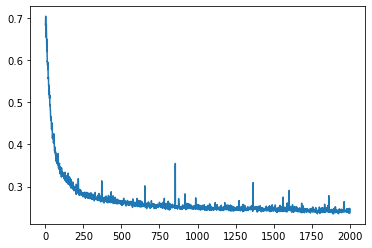

In [11]:
import matplotlib.pyplot as plt
ep=[i for i in range(1,2001)]

plt.plot(ep,mse_list1)

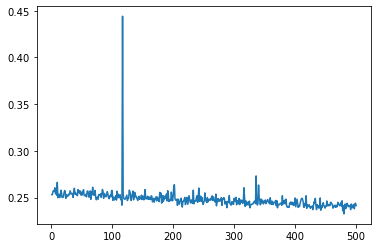

In [10]:
import matplotlib.pyplot as plt
ep=[i for i in range(1,501)]

plt.plot(ep,mse_list1)

In [12]:
with open('mse_esm_3_188_2000_file.txt', 'w') as f:
    for item in mse_list1:
        f.write("%s\n" % item)

In [12]:
with open('mse_random_2_188_2000_file.txt', 'w') as f:
    for item in mse_list1:
        f.write("%s\n" % item)

In [17]:
print(model)

GNNNet(
  (mol_conv1): GCNConv(78, 78)
  (mol_conv2): GCNConv(78, 156)
  (mol_conv3): GCNConv(156, 312)
  (mol_fc_g1): Linear(in_features=312, out_features=1024, bias=True)
  (mol_fc_g2): Linear(in_features=1024, out_features=128, bias=True)
  (pro_conv1): GCNConv(54, 54)
  (pro_conv2): GCNConv(54, 108)
  (pro_conv3): GCNConv(108, 216)
  (pro_fc_g1): Linear(in_features=216, out_features=1024, bias=True)
  (pro_fc_g2): Linear(in_features=1024, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
)


In [28]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f

25794048

In [10]:
torch.cuda.empty_cache()

In [27]:
print(t,r,a,f)

6222839808 3321888768 35023360 3286865408


In [29]:
print(t,r,a,f)

6222839808 60817408 35023360 25794048


In [30]:
torch.cuda.mem_get_info()

(4509466624, 6222839808)

In [33]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 150749902),
             ('active.all.current', 130),
             ('active.all.freed', 150749772),
             ('active.all.peak', 160),
             ('active.large_pool.allocated', 38701126),
             ('active.large_pool.current', 10),
             ('active.large_pool.freed', 38701116),
             ('active.large_pool.peak', 26),
             ('active.small_pool.allocated', 112048776),
             ('active.small_pool.current', 120),
             ('active.small_pool.freed', 112048656),
             ('active.small_pool.peak', 144),
             ('active_bytes.all.allocated', 1816698561822720),
             ('active_bytes.all.current', 35023360),
             ('active_bytes.all.freed', 1816698526799360),
             ('active_bytes.all.peak', 1744957440),
             ('active_bytes.large_pool.allocated', 1800748219243520),
             ('active_bytes.large_pool.current', 18009600),
             ('active_bytes.large_pool.freed', 1800748201233

In [34]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   34202 KB |    1664 MB |    1652 TB |    1652 TB |\n|       from large pool |   17587 KB |    1646 MB |    1637 TB |    1637 TB |\n|       from small pool |   16615 KB |      22 MB |      14 TB |      14 TB |\n|---------------------------------------------------------------------------|\n| Active memory         |   34202 KB |    1664 MB |    1652 TB |    1652 TB |\n|       from large pool |   17587 KB |    1646 MB |

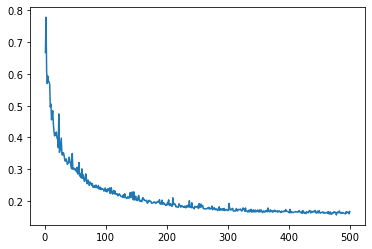

In [15]:
import matplotlib.pyplot as plt
ep=[i for i in range(1,501)]

plt.plot(ep,mse_list1)

In [16]:
with open('mse_pconsc4_500_file.txt', 'w') as f:
    for item in mse_list1:
        f.write("%s\n" % item)

In [6]:
import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test


def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_random_188_2000_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join('results', dataset + '_random_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')




In [7]:

dataset = ['davis', 'kiba'][1]  # dataset selection
model_st = GNNNet.__name__
print('dataset:', dataset)
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0] # gpu selection
print('cuda_name:', cuda_name)

 

dataset: kiba
cuda_name: cuda:0


In [8]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_random_188_2000_GNNNet_kiba_1.model'
result_file_name = 'results/result_random_188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/disk/scratch/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 15908 samples...
metrics for  kiba
cindex: 0.8520819188757928
cindex2 0.8511189152501929
rm2: 0.6537591848377793
mse: 0.22186139
pearson 0.819153153090887
kiba
rmse:0.4710216473365081  mse:0.22186139  pearson:0.819153153090887 spearman:0.8192545261805239 ci:0.8520819188757928 rm2:0.6537591848377793


In [26]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_esm__188_2000_GNNNet_kiba_1.model'
result_file_name = 'results/resul_esm1_188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...
metrics for  kiba
cindex: 0.8534776186807934
cindex2 0.8518979162871739
rm2: 0.6435438146015201
mse: 0.21435104
pearson 0.8267502330575496
kiba
rmse:0.4629806076987733  mse:0.21435104  pearson:0.8267502330575496 spearman:0.8207208767268495 ci:0.8534776186807934 rm2:0.6435438146015201


No handles with labels found to put in legend.


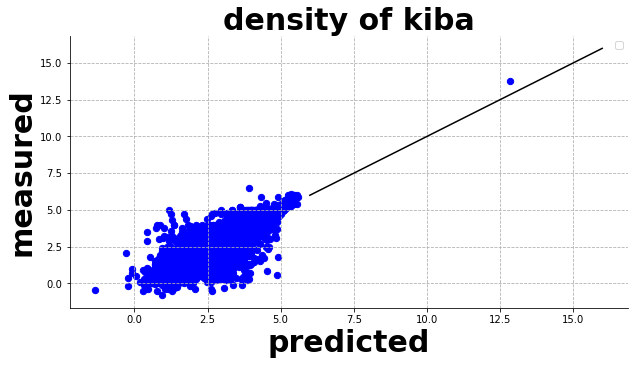

In [9]:
plot_density(Y, P, fold, dataset)

No handles with labels found to put in legend.


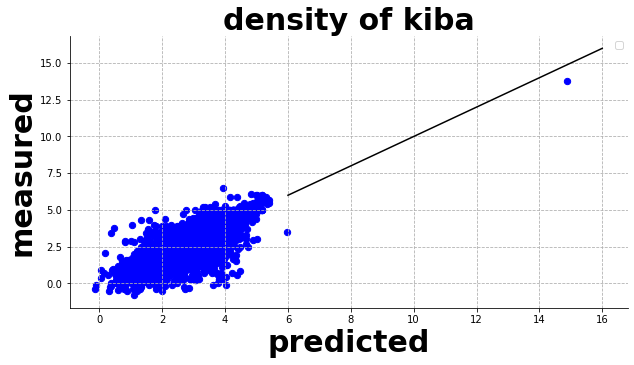

In [27]:
plot_density(Y, P, fold, dataset)

No handles with labels found to put in legend.


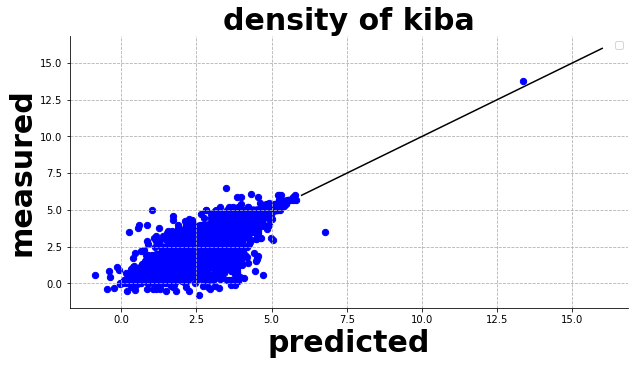

In [20]:
plot_density(Y, P, fold, dataset)

No handles with labels found to put in legend.


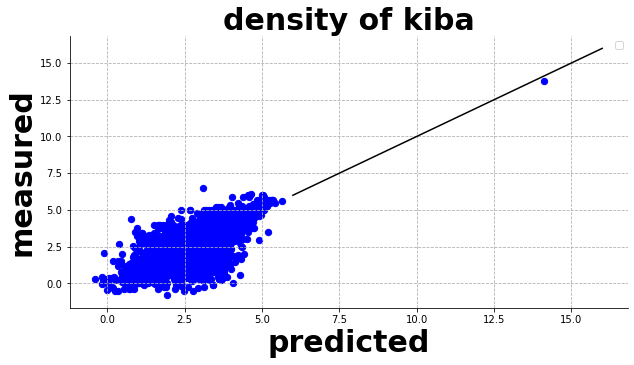

In [13]:
plot_density(Y, P, fold, dataset)

No handles with labels found to put in legend.


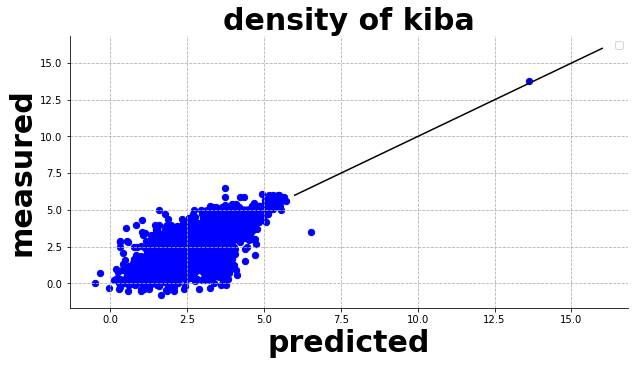

In [11]:
plot_density(Y, P, fold, dataset)

In [19]:
with open('esm_188_500_gt1_file.txt', 'w') as f:
    for item in list(Y):
        f.write("%s\n" % item)

In [18]:
with open('esm_188_500_pred1_file.txt', 'w') as f:
    for item in list(P):
        f.write("%s\n" % item)

In [18]:
test_loader

In [10]:
Y

array([14.400163, 12.399998, 11.400001, ..., 11.400001, 11.5     ,
       11.5     ], dtype=float32)

In [11]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

In [48]:

my_file = open("alpha500_pred_file.txt", "r")
content = my_file.read()
content=content.splitlines()
content=[float(i) for i in content]
print(content)

[13.572652, 12.826997, 11.444092, 10.318037, 11.341069, 11.559343, 11.85205, 11.203673, 10.334731, 11.582762, 13.900543, 12.97712, 11.691866, 12.792691, 14.458044, 11.520013, 12.257853, 11.212511, 12.006573, 11.880769, 11.1070795, 11.378011, 11.148856, 11.216189, 11.134102, 12.008484, 10.905703, 11.242366, 11.19693, 10.343345, 11.86922, 12.26573, 10.585809, 12.672529, 11.919928, 10.658084, 11.237454, 11.279299, 11.310264, 11.870662, 11.057477, 11.480621, 12.106813, 11.613607, 10.156403, 11.307625, 10.7861595, 11.92269, 11.224873, 12.009879, 10.479592, 11.211487, 11.759775, 11.364248, 11.742957, 12.0676775, 12.2011385, 11.140188, 11.8148365, 11.463266, 11.225105, 11.48033, 12.019633, 11.547219, 11.362604, 12.447442, 10.850902, 11.337198, 10.871161, 11.64067, 11.490308, 11.450138, 11.544379, 10.872649, 12.062119, 11.466935, 11.917785, 11.780647, 11.215674, 12.046588, 11.4404955, 10.219847, 11.889244, 11.15485, 11.559784, 12.427896, 12.339859, 10.860705, 12.2455225, 11.580148, 11.404127, 

In [49]:
P1=np.asarray(content)

In [50]:
P1

array([13.572652 , 12.826997 , 11.444092 , ..., 11.422882 , 11.5344305,
       11.544348 ])

In [52]:
plt.scatter(P,color='blue')

TypeError: scatter() missing 1 required positional argument: 'y'

In [37]:
type(content)

str

In [41]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

No handles with labels found to put in legend.


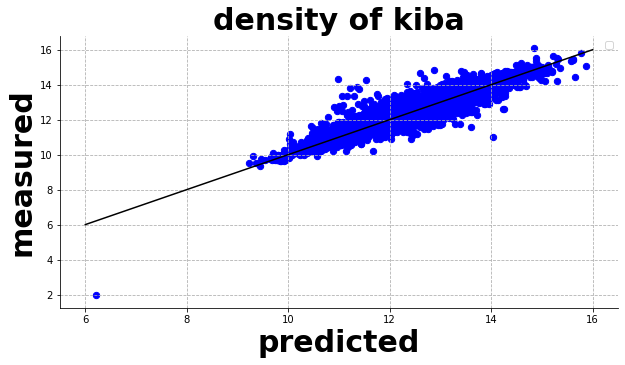

In [53]:
plot_density(P1, P, fold, dataset)

In [12]:
with open('pconsc4_500_gt_file.txt', 'w') as f:
    for item in list(Y):
        f.write("%s\n" % item)

In [13]:
with open('pconsc4_500_pred_file.txt', 'w') as f:
    for item in list(P):
        f.write("%s\n" % item)

No handles with labels found to put in legend.


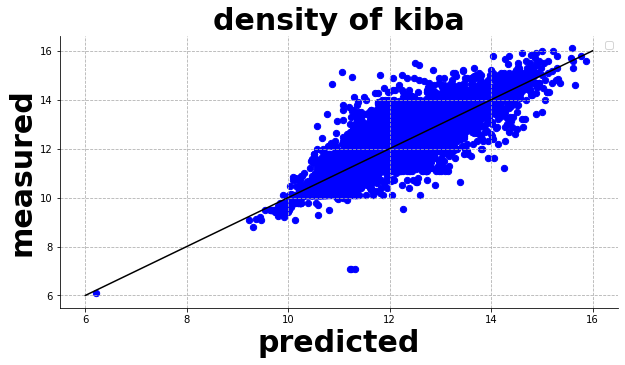

In [54]:
plot_density(Y, P, fold, dataset)

In [58]:
def plot_density1(Y, P,P1, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.scatter(P1, Y, color='green', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + 'alpha v/s pconsc4_500_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


No handles with labels found to put in legend.


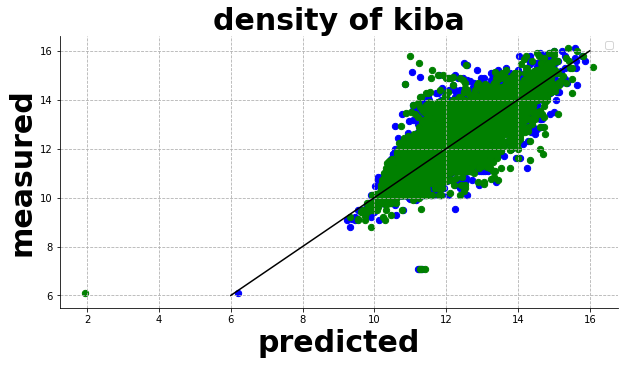

In [59]:
plot_density1(Y, P,P1, fold, dataset)

No handles with labels found to put in legend.


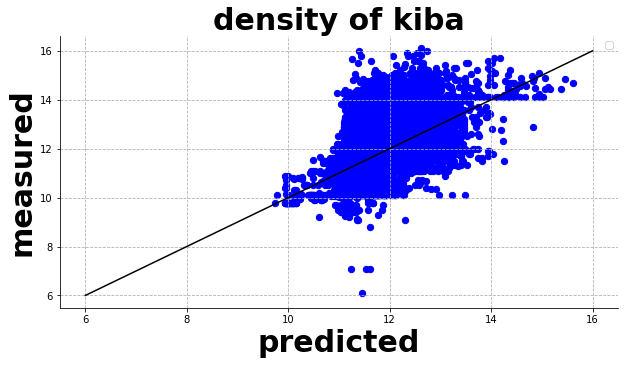

In [13]:
plot_density(Y, P, fold, dataset)

In [ ]:
plot_density(Y, P, fold, dataset)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'